In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data
import torch.optim as optim

from tensorboardX import SummaryWriter
import matplotlib.pyplot as plt

import os
from utils import tools
from sklearn import preprocessing
from torchviz import make_dot, make_dot_from_trace


# import FlowNetC
from networks import FlowNetC

from PIL import Image
import numpy as np
import pandas as pd

# import flowlib

from PIL import Image

import tqdm
import cv2
import csv
import time

In [206]:
cap = cv2.VideoCapture('data/caolin_foot_trial1-4.mp4')
name = 'caolin'

framerate = cap.get(5)
total_image = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

print(f'The oringinal framerate is {cap.get(5)} with frame resolution of: {cap.get(3), cap.get(4)}')
print(f'The total number of frame in this video is {total_image}')

The oringinal framerate is 25.0 with frame resolution of: (768.0, 576.0)
The total number of frame in this video is 17155


In [207]:
count = 1
while(cap.isOpened()):
    frameID = cap.get(1) # get the current frame number
    ret, frame = cap.read()
    
    if(ret != True):
        print(f'We\'ve gotten {int(frameID/5)+1} frames from this video.')
        break
    if (frameID % int(framerate/5) == 0):
        frame = frame[64:, 170:600 , :]
        filename = 'Train_1/'+ name + "_frame%04d.jpg" % count;count+=1
        cv2.imwrite(filename, frame)
cap.release()

We've gotten 3432 frames from this video.


## Building Dataset

In [13]:
image_files = dataset.image_files

In [2]:
class MyDataset:
    
    def __init__(self, num_train_img = 3400, base_dir = '/home/projectx/Documents/GitHub repos/VINET_modification/', sequence = 'Train_1/'):  # base_dir(image) and sequence(lstm) are directories
        self.base_dir = base_dir
        self.sequence = sequence
        self.base_path_img = self.base_dir + self.sequence
        
        self.image_files = os.listdir(self.base_path_img)
        self.image_files.sort()
        self.image_files = self.image_files[0:num_train_img]
        
        # normalization for lstm data
        self.train_scaler = preprocessing.StandardScaler()
        
        ## Omega.7 and load cells
        self.input_lstm = self.read_OMEGA7_LC()
        
        
        self.imu_seq_len = 20
    
    def read_OMEGA7_LC(self, path='data/result_1.csv'):
        # read csv data
        df = pd.read_csv(path,header = None)
        df = df[:874300]
        
        # take moving average of every 10 data points
        new_df = df.groupby(df.index//10).mean()
        array_input = np.array(new_df)
        
        # normalization
        array_input_scaled = self.train_scaler.fit_transform(array_input)
        
        input_lstm  = Variable(torch.from_numpy(array_input_scaled).type(torch.FloatTensor))
        input_lstm = input_lstm[:80000,:]
        
        
        
        # reshape to (num_dataset, sequence_length, feature_size)
        input_lstm = input_lstm.view(-1,20,11)
        
        return np.array(input_lstm)
    
    
    def get_input_lstm(self):
        return self.input_lstm
    
    def __len__(self):
        return len(self.image_files)
    
    def load_img_bat(self, idx, batch):
        batch_x = []
        batch_input_lstm = []
        for i in range(batch):
            x_data_np_1 = np.array(Image.open(self.base_path_img + self.image_files[idx + i]))
            x_data_np_2 = np.array(Image.open(self.base_path_img + self.image_files[idx+1 + i]))
            x_data_np_1 = x_data_np_1.reshape(3,512,430)
            x_data_np_2 = x_data_np_2.reshape(3,512,430)

#             ## 3 channels
#             x_data_np_1 = np.array([x_data_np_1, x_data_np_1, x_data_np_1])
#             x_data_np_2 = np.array([x_data_np_2, x_data_np_2, x_data_np_2])

            X = np.array([x_data_np_1, x_data_np_2])
            batch_x.append(X)
        
#           self.input_lstm of size: (num_dataset, sequence_length, feature_size)
            tmp = np.array(self.input_lstm[idx + i])
            batch_input_lstm.append(tmp)
            
        
        batch_x = np.array(batch_x)
        batch_input_lstm = np.array(batch_input_lstm)
        
        X = Variable(torch.from_numpy(batch_x).type(torch.FloatTensor).cuda())    
        X2 = Variable(torch.from_numpy(batch_input_lstm).type(torch.FloatTensor).cuda())    
        
        Y = X2[:,:,-3:]
        
     
        return X, X2 , Y.mean(1)

In [184]:
dataset = MyDataset()

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3248: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


(80000, 11)

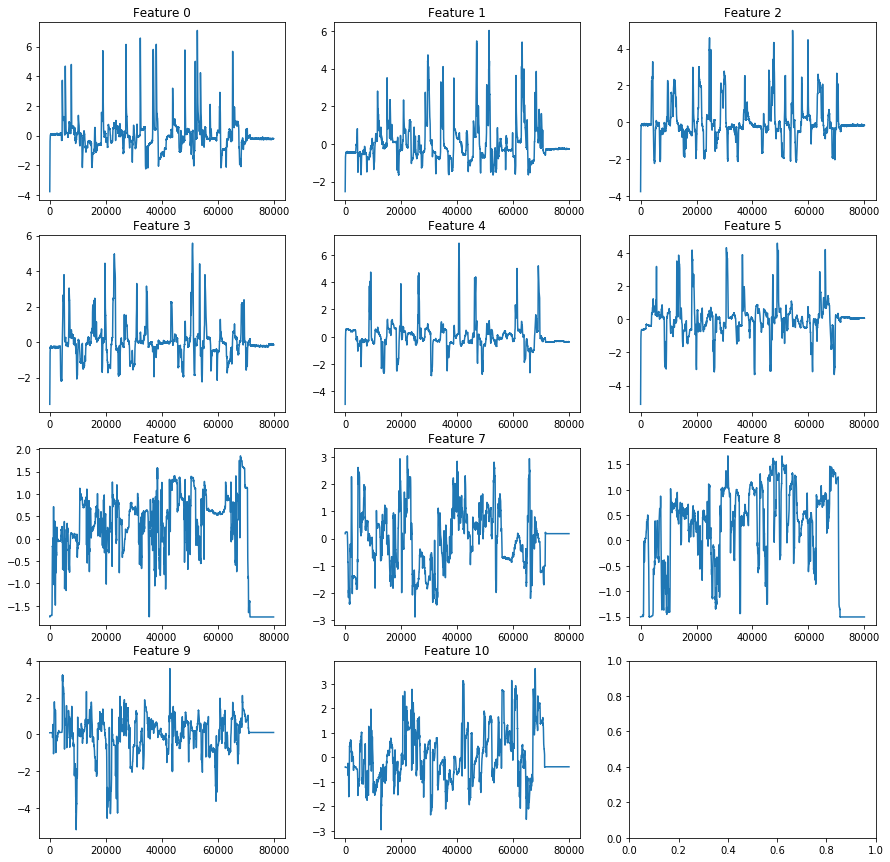

In [178]:
lstm_input = dataset.read_OMEGA7_LC()
lstm_input = lstm_input.reshape(4000*20, -1)
plot_feature_dim(lstm_input)
lstm_input.shape

In [3]:
def plot_feature_dim(lstm_input):
    fig, axs = plt.subplots(4,3,figsize=(15,15))

    for i in range(4):
        for j in range(3):
            if (i == 3 and j == 2):
                break

            x = np.arange(0,80000)
            axs[i,j].plot(x,lstm_input[:,i*3+j])
            axs[i,j].set_title(f'Feature {i*3+j}')

In [4]:
class Vinet(nn.Module):
    def __init__(self):
        super(Vinet, self).__init__()
        self.rnn = nn.LSTM(
            input_size=57464,#49152,#24576, 
            hidden_size=1024,#64, 
            num_layers=2,
            batch_first=True)
        self.rnn.cuda()
        
        self.rnnIMU = nn.LSTM(
            input_size=11, 
            hidden_size=6,
            num_layers=2,
            batch_first=True)
        self.rnnIMU.cuda()
        
        self.linear1 = nn.Linear(1024, 128)
        self.linear2 = nn.Linear(128, 3)
        #self.linear3 = nn.Linear(128, 6)
        self.linear1.cuda()
        self.linear2.cuda()
        #self.linear3.cuda()
        
        # load checkpoint state from NVIDIA training
        checkpoint = None
        checkpoint_pytorch = 'FlowNet2-C_checkpoint.pth.tar'
        #checkpoint_pytorch = '/notebooks/data/model/FlowNet2-SD_checkpoint.pth.tar'
        if os.path.isfile(checkpoint_pytorch):
            print('pre_trained_weights found')
            checkpoint = torch.load(checkpoint_pytorch,\
                                map_location=lambda storage, loc: storage.cuda(0))
            pop_list = ["deconv5.0.weight", "deconv5.0.bias", "deconv4.0.weight", "deconv4.0.bias", "deconv3.0.weight", "deconv3.0.bias", "deconv2.0.weight", "deconv2.0.bias", "predict_flow6.weight", "predict_flow6.bias", "predict_flow5.weight", "predict_flow5.bias", "predict_flow4.weight", "predict_flow4.bias", "predict_flow3.weight", "predict_flow3.bias", "predict_flow2.weight", "predict_flow2.bias", "upsampled_flow6_to_5.weight", "upsampled_flow6_to_5.bias", "upsampled_flow5_to_4.weight", "upsampled_flow5_to_4.bias", "upsampled_flow4_to_3.weight", "upsampled_flow4_to_3.bias", "upsampled_flow3_to_2.weight", "upsampled_flow3_to_2.bias"]
            for name in pop_list:
                checkpoint['state_dict'].pop(name);
        
        self.flownet_c = FlowNetC.FlowNetC(batchNorm=False)
        print('....creating model....')
        self.flownet_c.load_state_dict(checkpoint['state_dict'])
        print('....loading weights....')
        self.flownet_c.cuda()
        
        

    def forward(self, image, imu):
        batch_size, timesteps, C, H, W = image.size()
        
        ## Input1: Feed image pairs to FlownetC
        c_in = image.view(batch_size, timesteps * C, H, W)
        c_out = self.flownet_c(c_in)
#         print('c_out', c_out.shape)
        
        ## Input2: Feed IMU records to LSTM
        imu_out, (imu_n, imu_c) = self.rnnIMU(imu)
        # to match Vision output shape
        imu_out = imu_out.view(batch_size,1,-1)   # (batch_size, 1, total_hidden_size)
        
#         print('imu_out', imu_out.shape)
        
        
        ## Combine the output of input1 and 2 and feed it to LSTM
        #r_in = c_out.view(batch_size, timesteps, -1)
        r_in = c_out.view(batch_size, 1, -1)
#         print('r_in', r_in.shape)
        

        cat_out = torch.cat((r_in, imu_out), 2)#1 1 49158
#         print(cat_out.shape)
        
        
        r_out, (h_n, h_c) = self.rnn(cat_out)  # (1, 1, 1024)
#         print('r_out', r_out.shape)
        l_out1 = self.linear1(r_out[:,-1,:])
        l_out2 = self.linear2(l_out1)
        
#         print('r_ol_out2ut', l_out2.shape)
        #l_out3 = self.linear3(l_out2)

        return l_out2

In [11]:
model = Vinet()

pre_trained_weights found
....creating model....
....loading weights....


In [13]:
dataset = MyDataset()
X, X2 , Y = dataset.load_img_bat(0,1)
X.size(), X2.size() , Y.size() 

/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3325: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


(torch.Size([1, 2, 3, 512, 430]), torch.Size([1, 20, 11]), torch.Size([1, 3]))

In [14]:
output = model(X,X2)

/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [15]:
(output.size(), Y.size())

(torch.Size([1, 3]), torch.Size([1, 3]))

In [16]:
criterion = nn.MSELoss()

loss = criterion(output, Y)

## Visulization of network

In [197]:
image = X
imu   = X2
y = model(image, imu)
dot = make_dot(y, params = dict(list(model.named_parameters()) + [('x',X), ('x2',X2)]))

c_out torch.Size([1, 1024, 8, 7])
imu_out torch.Size([1, 1, 120])
r_in torch.Size([1, 1, 57344])
torch.Size([1, 1, 57464])
r_out torch.Size([1, 1, 1024])
r_ol_out2ut torch.Size([1, 3])


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


In [203]:
dot.save(filename='My_new_Network')

'My_new_Network'

In [204]:
dot.render()

'My_new_Network.pdf'

## Design the training loop

In [5]:
def train():
    # hyper-parameters
    epoch = 2
    batch = 1
    lr = 1e-5
    
    # creat model and dataset
    model = Vinet()
    mydataset = MyDataset()
    
    
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    
    # TensorBoard
    writer = SummaryWriter()
 
    model.train()
    
    mydataset = MyDataset()
    
    criterion = nn.MSELoss()
    
    start = 0
    end = len(mydataset) - batch
    batch_num = (end - start)
    startT = time.time()
    
    with tools.TimerBlock("Start training") as block :
        for k in range(epoch):
            for i in range(start, end):
                data, data_lstm, target = mydataset.load_img_bat(i, batch)
                data, data_lstm, target = data.cuda(), data_lstm.cuda(), target.cuda()
                
                optimizer.zero_grad()
                
                # forward pass
                output = model(data, data_lstm)
                
                # compute loss
                loss = criterion(output, target)
                
                # backward pass
                loss.backward()
                optimizer.step()
                
                avgTime = block.avg()
                remainingTime = int((batch_num*epoch -  (i + batch_num*k)) * avgTime)
                rTime_str = "{:02d}:{:02d}:{:02d}".format(int(remainingTime/60//60), 
                                                          int(remainingTime//60%60), 
                                                          int(remainingTime%60))
                block.log(f'Train Epoch: {k}\t[{i}/{batch_num} ({(100.*(i + batch_num*k)):.0f}%)]\tLoss: {loss.data:.6f}, TimeAvg: {avgTime:.4f}, Remaining: {rTime_str}')
                          
                writer.add_scalar('loss', loss.data, k*batch_num + i)
                

                
                
                
            check_str = 'checkpoint_{}.pt'.format(k)
            if (k+1)%5 == 0:
                torch.save(model.state_dict(), check_str)
    
    torch.save(model.state_dict(), 'test_network_trial_1.pt')
    writer.export_scalars_to_json("./summary_writer.json")
    writer.close()

In [6]:
train()

pre_trained_weights found
....creating model....
....loading weights....


/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/home/projectx/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  """Entry point for launching an IPython kernel.
/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


Start training
  [0.878s] Train Epoch: 0	[0/3399 (0%)]	Loss: 0.786931, TimeAvg: 0.2046, Remaining: 00:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.702s] Train Epoch: 0	[1/3399 (100%)]	Loss: 0.794434, TimeAvg: 1.0143, Remaining: 01:54:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.504s] Train Epoch: 0	[2/3399 (200%)]	Loss: 0.778238, TimeAvg: 0.9068, Remaining: 01:42:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.319s] Train Epoch: 0	[3/3399 (300%)]	Loss: 0.781971, TimeAvg: 0.8835, Remaining: 01:40:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.133s] Train Epoch: 0	[4/3399 (400%)]	Loss: 0.785605, TimeAvg: 0.8606, Remaining: 01:37:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.957s] Train Epoch: 0	[5/3399 (500%)]	Loss: 0.787872, TimeAvg: 0.8518, Remaining: 01:36:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.790s] Train Epoch: 0	[6/3399 (600%)]	Loss: 0.781545, TimeAvg: 0.8494, Remaining: 01:36:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.611s] Train Epoch: 0	[7/3399 (700%)]	Loss: 0.774117, TimeAvg: 0.8456, Remaining: 01:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.423s] Train Epoch: 0	[8/3399 (800%)]	Loss: 0.778672, TimeAvg: 0.8413, Remaining: 01:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.239s] Train Epoch: 0	[9/3399 (900%)]	Loss: 0.766141, TimeAvg: 0.8382, Remaining: 01:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.054s] Train Epoch: 0	[10/3399 (1000%)]	Loss: 0.750567, TimeAvg: 0.8359, Remaining: 01:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.870s] Train Epoch: 0	[11/3399 (1100%)]	Loss: 0.752832, TimeAvg: 0.8344, Remaining: 01:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.684s] Train Epoch: 0	[12/3399 (1200%)]	Loss: 0.741328, TimeAvg: 0.8330, Remaining: 01:34:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.499s] Train Epoch: 0	[13/3399 (1300%)]	Loss: 0.750519, TimeAvg: 0.8321, Remaining: 01:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.317s] Train Epoch: 0	[14/3399 (1400%)]	Loss: 0.749107, TimeAvg: 0.8308, Remaining: 01:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.131s] Train Epoch: 0	[15/3399 (1500%)]	Loss: 0.763739, TimeAvg: 0.8297, Remaining: 01:33:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.949s] Train Epoch: 0	[16/3399 (1600%)]	Loss: 0.755278, TimeAvg: 0.8292, Remaining: 01:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.769s] Train Epoch: 0	[17/3399 (1700%)]	Loss: 0.755405, TimeAvg: 0.8285, Remaining: 01:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.598s] Train Epoch: 0	[18/3399 (1800%)]	Loss: 0.748808, TimeAvg: 0.8278, Remaining: 01:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.425s] Train Epoch: 0	[19/3399 (1900%)]	Loss: 0.751022, TimeAvg: 0.8283, Remaining: 01:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.238s] Train Epoch: 0	[20/3399 (2000%)]	Loss: 0.754671, TimeAvg: 0.8273, Remaining: 01:33:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.046s] Train Epoch: 0	[21/3399 (2100%)]	Loss: 0.753429, TimeAvg: 0.8271, Remaining: 01:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.855s] Train Epoch: 0	[22/3399 (2200%)]	Loss: 0.730799, TimeAvg: 0.8262, Remaining: 01:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.674s] Train Epoch: 0	[23/3399 (2300%)]	Loss: 0.738189, TimeAvg: 0.8253, Remaining: 01:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.487s] Train Epoch: 0	[24/3399 (2400%)]	Loss: 0.727194, TimeAvg: 0.8252, Remaining: 01:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.300s] Train Epoch: 0	[25/3399 (2500%)]	Loss: 0.737673, TimeAvg: 0.8246, Remaining: 01:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.110s] Train Epoch: 0	[26/3399 (2600%)]	Loss: 0.759199, TimeAvg: 0.8241, Remaining: 01:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.919s] Train Epoch: 0	[27/3399 (2700%)]	Loss: 0.751086, TimeAvg: 0.8236, Remaining: 01:32:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.734s] Train Epoch: 0	[28/3399 (2800%)]	Loss: 0.733276, TimeAvg: 0.8232, Remaining: 01:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.545s] Train Epoch: 0	[29/3399 (2900%)]	Loss: 0.752635, TimeAvg: 0.8229, Remaining: 01:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.358s] Train Epoch: 0	[30/3399 (3000%)]	Loss: 0.751895, TimeAvg: 0.8224, Remaining: 01:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.171s] Train Epoch: 0	[31/3399 (3100%)]	Loss: 0.761163, TimeAvg: 0.8219, Remaining: 01:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.986s] Train Epoch: 0	[32/3399 (3200%)]	Loss: 0.745591, TimeAvg: 0.8217, Remaining: 01:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.798s] Train Epoch: 0	[33/3399 (3300%)]	Loss: 0.740052, TimeAvg: 0.8215, Remaining: 01:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.612s] Train Epoch: 0	[34/3399 (3400%)]	Loss: 0.744960, TimeAvg: 0.8213, Remaining: 01:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.419s] Train Epoch: 0	[35/3399 (3500%)]	Loss: 0.767100, TimeAvg: 0.8208, Remaining: 01:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.239s] Train Epoch: 0	[36/3399 (3600%)]	Loss: 0.758973, TimeAvg: 0.8209, Remaining: 01:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.064s] Train Epoch: 0	[37/3399 (3700%)]	Loss: 0.755514, TimeAvg: 0.8209, Remaining: 01:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.886s] Train Epoch: 0	[38/3399 (3800%)]	Loss: 0.747544, TimeAvg: 0.8210, Remaining: 01:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.698s] Train Epoch: 0	[39/3399 (3900%)]	Loss: 0.742061, TimeAvg: 0.8209, Remaining: 01:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.523s] Train Epoch: 0	[40/3399 (4000%)]	Loss: 0.745280, TimeAvg: 0.8207, Remaining: 01:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.350s] Train Epoch: 0	[41/3399 (4100%)]	Loss: 0.745245, TimeAvg: 0.8209, Remaining: 01:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.166s] Train Epoch: 0	[42/3399 (4200%)]	Loss: 0.761721, TimeAvg: 0.8211, Remaining: 01:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.984s] Train Epoch: 0	[43/3399 (4300%)]	Loss: 0.738140, TimeAvg: 0.8209, Remaining: 01:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.803s] Train Epoch: 0	[44/3399 (4400%)]	Loss: 0.736159, TimeAvg: 0.8208, Remaining: 01:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.615s] Train Epoch: 0	[45/3399 (4500%)]	Loss: 0.731794, TimeAvg: 0.8207, Remaining: 01:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.428s] Train Epoch: 0	[46/3399 (4600%)]	Loss: 0.745127, TimeAvg: 0.8204, Remaining: 01:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.249s] Train Epoch: 0	[47/3399 (4700%)]	Loss: 0.742028, TimeAvg: 0.8203, Remaining: 01:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.060s] Train Epoch: 0	[48/3399 (4800%)]	Loss: 0.695360, TimeAvg: 0.8202, Remaining: 01:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.872s] Train Epoch: 0	[49/3399 (4900%)]	Loss: 0.685472, TimeAvg: 0.8200, Remaining: 01:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.690s] Train Epoch: 0	[50/3399 (5000%)]	Loss: 0.678947, TimeAvg: 0.8199, Remaining: 01:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.503s] Train Epoch: 0	[51/3399 (5100%)]	Loss: 0.690165, TimeAvg: 0.8198, Remaining: 01:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.317s] Train Epoch: 0	[52/3399 (5200%)]	Loss: 0.640990, TimeAvg: 0.8198, Remaining: 01:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.125s] Train Epoch: 0	[53/3399 (5300%)]	Loss: 0.612610, TimeAvg: 0.8196, Remaining: 01:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.932s] Train Epoch: 0	[54/3399 (5400%)]	Loss: 0.506948, TimeAvg: 0.8194, Remaining: 01:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.743s] Train Epoch: 0	[55/3399 (5500%)]	Loss: 0.310407, TimeAvg: 0.8191, Remaining: 01:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.558s] Train Epoch: 0	[56/3399 (5600%)]	Loss: 0.146524, TimeAvg: 0.8190, Remaining: 01:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.371s] Train Epoch: 0	[57/3399 (5700%)]	Loss: 0.131434, TimeAvg: 0.8189, Remaining: 01:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.186s] Train Epoch: 0	[58/3399 (5800%)]	Loss: 0.147274, TimeAvg: 0.8188, Remaining: 01:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.999s] Train Epoch: 0	[59/3399 (5900%)]	Loss: 0.137688, TimeAvg: 0.8187, Remaining: 01:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.813s] Train Epoch: 0	[60/3399 (6000%)]	Loss: 0.147180, TimeAvg: 0.8187, Remaining: 01:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.626s] Train Epoch: 0	[61/3399 (6100%)]	Loss: 0.231979, TimeAvg: 0.8186, Remaining: 01:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.438s] Train Epoch: 0	[62/3399 (6200%)]	Loss: 0.461628, TimeAvg: 0.8185, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.264s] Train Epoch: 0	[63/3399 (6300%)]	Loss: 0.801470, TimeAvg: 0.8184, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.092s] Train Epoch: 0	[64/3399 (6400%)]	Loss: 0.951143, TimeAvg: 0.8188, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.914s] Train Epoch: 0	[65/3399 (6500%)]	Loss: 1.067543, TimeAvg: 0.8188, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.749s] Train Epoch: 0	[66/3399 (6600%)]	Loss: 1.239183, TimeAvg: 0.8190, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.574s] Train Epoch: 0	[67/3399 (6700%)]	Loss: 1.306835, TimeAvg: 0.8191, Remaining: 01:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.386s] Train Epoch: 0	[68/3399 (6800%)]	Loss: 1.282473, TimeAvg: 0.8192, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.204s] Train Epoch: 0	[69/3399 (6900%)]	Loss: 1.212136, TimeAvg: 0.8193, Remaining: 01:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.024s] Train Epoch: 0	[70/3399 (7000%)]	Loss: 0.990329, TimeAvg: 0.8192, Remaining: 01:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.855s] Train Epoch: 0	[71/3399 (7100%)]	Loss: 0.709844, TimeAvg: 0.8191, Remaining: 01:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.678s] Train Epoch: 0	[72/3399 (7200%)]	Loss: 0.353643, TimeAvg: 0.8192, Remaining: 01:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.008m] Train Epoch: 0	[73/3399 (7300%)]	Loss: 0.092998, TimeAvg: 0.8193, Remaining: 01:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.022m] Train Epoch: 0	[74/3399 (7400%)]	Loss: 0.022615, TimeAvg: 0.8195, Remaining: 01:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.036m] Train Epoch: 0	[75/3399 (7500%)]	Loss: 0.054430, TimeAvg: 0.8194, Remaining: 01:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.049m] Train Epoch: 0	[76/3399 (7600%)]	Loss: 0.261148, TimeAvg: 0.8195, Remaining: 01:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.063m] Train Epoch: 0	[77/3399 (7700%)]	Loss: 0.678532, TimeAvg: 0.8194, Remaining: 01:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.076m] Train Epoch: 0	[78/3399 (7800%)]	Loss: 0.921101, TimeAvg: 0.8192, Remaining: 01:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.090m] Train Epoch: 0	[79/3399 (7900%)]	Loss: 0.927282, TimeAvg: 0.8191, Remaining: 01:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.103m] Train Epoch: 0	[80/3399 (8000%)]	Loss: 1.004852, TimeAvg: 0.8191, Remaining: 01:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.117m] Train Epoch: 0	[81/3399 (8100%)]	Loss: 1.093044, TimeAvg: 0.8191, Remaining: 01:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.131m] Train Epoch: 0	[82/3399 (8200%)]	Loss: 1.127767, TimeAvg: 0.8189, Remaining: 01:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.144m] Train Epoch: 0	[83/3399 (8300%)]	Loss: 1.015903, TimeAvg: 0.8188, Remaining: 01:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.158m] Train Epoch: 0	[84/3399 (8400%)]	Loss: 0.890453, TimeAvg: 0.8188, Remaining: 01:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.171m] Train Epoch: 0	[85/3399 (8500%)]	Loss: 0.780736, TimeAvg: 0.8187, Remaining: 01:31:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.185m] Train Epoch: 0	[86/3399 (8600%)]	Loss: 0.753821, TimeAvg: 0.8186, Remaining: 01:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.198m] Train Epoch: 0	[87/3399 (8700%)]	Loss: 0.741394, TimeAvg: 0.8189, Remaining: 01:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.212m] Train Epoch: 0	[88/3399 (8800%)]	Loss: 0.739332, TimeAvg: 0.8186, Remaining: 01:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.226m] Train Epoch: 0	[89/3399 (8900%)]	Loss: 0.742128, TimeAvg: 0.8186, Remaining: 01:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.239m] Train Epoch: 0	[90/3399 (9000%)]	Loss: 0.717110, TimeAvg: 0.8184, Remaining: 01:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.253m] Train Epoch: 0	[91/3399 (9100%)]	Loss: 0.708680, TimeAvg: 0.8186, Remaining: 01:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.267m] Train Epoch: 0	[92/3399 (9200%)]	Loss: 0.713164, TimeAvg: 0.8185, Remaining: 01:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.280m] Train Epoch: 0	[93/3399 (9300%)]	Loss: 0.719190, TimeAvg: 0.8185, Remaining: 01:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.294m] Train Epoch: 0	[94/3399 (9400%)]	Loss: 0.725603, TimeAvg: 0.8185, Remaining: 01:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.308m] Train Epoch: 0	[95/3399 (9500%)]	Loss: 0.709169, TimeAvg: 0.8186, Remaining: 01:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.321m] Train Epoch: 0	[96/3399 (9600%)]	Loss: 0.694617, TimeAvg: 0.8186, Remaining: 01:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.335m] Train Epoch: 0	[97/3399 (9700%)]	Loss: 0.733874, TimeAvg: 0.8186, Remaining: 01:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.348m] Train Epoch: 0	[98/3399 (9800%)]	Loss: 0.736797, TimeAvg: 0.8185, Remaining: 01:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.362m] Train Epoch: 0	[99/3399 (9900%)]	Loss: 0.724017, TimeAvg: 0.8185, Remaining: 01:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.376m] Train Epoch: 0	[100/3399 (10000%)]	Loss: 0.717935, TimeAvg: 0.8184, Remaining: 01:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.389m] Train Epoch: 0	[101/3399 (10100%)]	Loss: 0.722014, TimeAvg: 0.8187, Remaining: 01:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.403m] Train Epoch: 0	[102/3399 (10200%)]	Loss: 0.710895, TimeAvg: 0.8185, Remaining: 01:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.417m] Train Epoch: 0	[103/3399 (10300%)]	Loss: 0.673647, TimeAvg: 0.8187, Remaining: 01:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.431m] Train Epoch: 0	[104/3399 (10400%)]	Loss: 0.599023, TimeAvg: 0.8188, Remaining: 01:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.444m] Train Epoch: 0	[105/3399 (10500%)]	Loss: 0.453108, TimeAvg: 0.8187, Remaining: 01:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.458m] Train Epoch: 0	[106/3399 (10600%)]	Loss: 0.203823, TimeAvg: 0.8187, Remaining: 01:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.471m] Train Epoch: 0	[107/3399 (10700%)]	Loss: 0.248617, TimeAvg: 0.8186, Remaining: 01:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.485m] Train Epoch: 0	[108/3399 (10800%)]	Loss: 0.411912, TimeAvg: 0.8186, Remaining: 01:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.499m] Train Epoch: 0	[109/3399 (10900%)]	Loss: 0.343526, TimeAvg: 0.8186, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.512m] Train Epoch: 0	[110/3399 (11000%)]	Loss: 0.245702, TimeAvg: 0.8187, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.526m] Train Epoch: 0	[111/3399 (11100%)]	Loss: 0.232492, TimeAvg: 0.8188, Remaining: 01:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.540m] Train Epoch: 0	[112/3399 (11200%)]	Loss: 0.226618, TimeAvg: 0.8187, Remaining: 01:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.553m] Train Epoch: 0	[113/3399 (11300%)]	Loss: 0.169577, TimeAvg: 0.8187, Remaining: 01:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.567m] Train Epoch: 0	[114/3399 (11400%)]	Loss: 0.094964, TimeAvg: 0.8188, Remaining: 01:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.581m] Train Epoch: 0	[115/3399 (11500%)]	Loss: 0.084594, TimeAvg: 0.8187, Remaining: 01:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.594m] Train Epoch: 0	[116/3399 (11600%)]	Loss: 0.085247, TimeAvg: 0.8188, Remaining: 01:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.608m] Train Epoch: 0	[117/3399 (11700%)]	Loss: 0.085263, TimeAvg: 0.8187, Remaining: 01:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.621m] Train Epoch: 0	[118/3399 (11800%)]	Loss: 0.077918, TimeAvg: 0.8187, Remaining: 01:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.635m] Train Epoch: 0	[119/3399 (11900%)]	Loss: 0.077489, TimeAvg: 0.8186, Remaining: 01:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.649m] Train Epoch: 0	[120/3399 (12000%)]	Loss: 0.078129, TimeAvg: 0.8186, Remaining: 01:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.663m] Train Epoch: 0	[121/3399 (12100%)]	Loss: 0.079449, TimeAvg: 0.8187, Remaining: 01:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.676m] Train Epoch: 0	[122/3399 (12200%)]	Loss: 0.077824, TimeAvg: 0.8188, Remaining: 01:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.690m] Train Epoch: 0	[123/3399 (12300%)]	Loss: 0.075351, TimeAvg: 0.8187, Remaining: 01:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.703m] Train Epoch: 0	[124/3399 (12400%)]	Loss: 0.086388, TimeAvg: 0.8187, Remaining: 01:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.717m] Train Epoch: 0	[125/3399 (12500%)]	Loss: 0.104851, TimeAvg: 0.8186, Remaining: 01:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.731m] Train Epoch: 0	[126/3399 (12600%)]	Loss: 0.125035, TimeAvg: 0.8186, Remaining: 01:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.744m] Train Epoch: 0	[127/3399 (12700%)]	Loss: 0.145665, TimeAvg: 0.8186, Remaining: 01:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.758m] Train Epoch: 0	[128/3399 (12800%)]	Loss: 0.145797, TimeAvg: 0.8186, Remaining: 01:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.771m] Train Epoch: 0	[129/3399 (12900%)]	Loss: 0.149392, TimeAvg: 0.8185, Remaining: 01:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.785m] Train Epoch: 0	[130/3399 (13000%)]	Loss: 0.132712, TimeAvg: 0.8185, Remaining: 01:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.798m] Train Epoch: 0	[131/3399 (13100%)]	Loss: 0.114679, TimeAvg: 0.8185, Remaining: 01:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.812m] Train Epoch: 0	[132/3399 (13200%)]	Loss: 0.113421, TimeAvg: 0.8184, Remaining: 01:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.826m] Train Epoch: 0	[133/3399 (13300%)]	Loss: 0.079659, TimeAvg: 0.8184, Remaining: 01:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.839m] Train Epoch: 0	[134/3399 (13400%)]	Loss: 0.044390, TimeAvg: 0.8184, Remaining: 01:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.853m] Train Epoch: 0	[135/3399 (13500%)]	Loss: 0.025972, TimeAvg: 0.8184, Remaining: 01:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.867m] Train Epoch: 0	[136/3399 (13600%)]	Loss: 0.016872, TimeAvg: 0.8185, Remaining: 01:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.880m] Train Epoch: 0	[137/3399 (13700%)]	Loss: 0.013180, TimeAvg: 0.8184, Remaining: 01:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.894m] Train Epoch: 0	[138/3399 (13800%)]	Loss: 0.011521, TimeAvg: 0.8184, Remaining: 01:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.907m] Train Epoch: 0	[139/3399 (13900%)]	Loss: 0.006687, TimeAvg: 0.8184, Remaining: 01:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.921m] Train Epoch: 0	[140/3399 (14000%)]	Loss: 0.009519, TimeAvg: 0.8184, Remaining: 01:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.935m] Train Epoch: 0	[141/3399 (14100%)]	Loss: 0.018431, TimeAvg: 0.8184, Remaining: 01:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.948m] Train Epoch: 0	[142/3399 (14200%)]	Loss: 0.034867, TimeAvg: 0.8184, Remaining: 01:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.962m] Train Epoch: 0	[143/3399 (14300%)]	Loss: 0.044994, TimeAvg: 0.8184, Remaining: 01:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.976m] Train Epoch: 0	[144/3399 (14400%)]	Loss: 0.051278, TimeAvg: 0.8183, Remaining: 01:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [1.990m] Train Epoch: 0	[145/3399 (14500%)]	Loss: 0.084849, TimeAvg: 0.8185, Remaining: 01:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.003m] Train Epoch: 0	[146/3399 (14600%)]	Loss: 0.157348, TimeAvg: 0.8185, Remaining: 01:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.017m] Train Epoch: 0	[147/3399 (14700%)]	Loss: 0.312454, TimeAvg: 0.8185, Remaining: 01:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.030m] Train Epoch: 0	[148/3399 (14800%)]	Loss: 0.604839, TimeAvg: 0.8184, Remaining: 01:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.044m] Train Epoch: 0	[149/3399 (14900%)]	Loss: 0.769160, TimeAvg: 0.8184, Remaining: 01:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.057m] Train Epoch: 0	[150/3399 (15000%)]	Loss: 0.760511, TimeAvg: 0.8184, Remaining: 01:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.071m] Train Epoch: 0	[151/3399 (15100%)]	Loss: 0.757497, TimeAvg: 0.8183, Remaining: 01:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.085m] Train Epoch: 0	[152/3399 (15200%)]	Loss: 0.758912, TimeAvg: 0.8183, Remaining: 01:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.098m] Train Epoch: 0	[153/3399 (15300%)]	Loss: 0.762720, TimeAvg: 0.8183, Remaining: 01:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.112m] Train Epoch: 0	[154/3399 (15400%)]	Loss: 0.761107, TimeAvg: 0.8182, Remaining: 01:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.125m] Train Epoch: 0	[155/3399 (15500%)]	Loss: 0.763081, TimeAvg: 0.8182, Remaining: 01:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.139m] Train Epoch: 0	[156/3399 (15600%)]	Loss: 0.759739, TimeAvg: 0.8182, Remaining: 01:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.152m] Train Epoch: 0	[157/3399 (15700%)]	Loss: 0.758910, TimeAvg: 0.8182, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.166m] Train Epoch: 0	[158/3399 (15800%)]	Loss: 0.760314, TimeAvg: 0.8182, Remaining: 01:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.180m] Train Epoch: 0	[159/3399 (15900%)]	Loss: 0.747902, TimeAvg: 0.8182, Remaining: 01:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.193m] Train Epoch: 0	[160/3399 (16000%)]	Loss: 0.755614, TimeAvg: 0.8182, Remaining: 01:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.207m] Train Epoch: 0	[161/3399 (16100%)]	Loss: 0.763033, TimeAvg: 0.8181, Remaining: 01:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.220m] Train Epoch: 0	[162/3399 (16200%)]	Loss: 0.756916, TimeAvg: 0.8181, Remaining: 01:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.234m] Train Epoch: 0	[163/3399 (16300%)]	Loss: 0.751988, TimeAvg: 0.8181, Remaining: 01:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.248m] Train Epoch: 0	[164/3399 (16400%)]	Loss: 0.752489, TimeAvg: 0.8181, Remaining: 01:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.261m] Train Epoch: 0	[165/3399 (16500%)]	Loss: 0.752741, TimeAvg: 0.8181, Remaining: 01:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.275m] Train Epoch: 0	[166/3399 (16600%)]	Loss: 0.753886, TimeAvg: 0.8181, Remaining: 01:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.288m] Train Epoch: 0	[167/3399 (16700%)]	Loss: 0.756829, TimeAvg: 0.8180, Remaining: 01:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.302m] Train Epoch: 0	[168/3399 (16800%)]	Loss: 0.749255, TimeAvg: 0.8181, Remaining: 01:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.315m] Train Epoch: 0	[169/3399 (16900%)]	Loss: 0.750999, TimeAvg: 0.8179, Remaining: 01:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.329m] Train Epoch: 0	[170/3399 (17000%)]	Loss: 0.741064, TimeAvg: 0.8179, Remaining: 01:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.343m] Train Epoch: 0	[171/3399 (17100%)]	Loss: 0.737227, TimeAvg: 0.8179, Remaining: 01:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.356m] Train Epoch: 0	[172/3399 (17200%)]	Loss: 0.740728, TimeAvg: 0.8179, Remaining: 01:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.370m] Train Epoch: 0	[173/3399 (17300%)]	Loss: 0.738040, TimeAvg: 0.8179, Remaining: 01:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.383m] Train Epoch: 0	[174/3399 (17400%)]	Loss: 0.745008, TimeAvg: 0.8179, Remaining: 01:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.397m] Train Epoch: 0	[175/3399 (17500%)]	Loss: 0.743865, TimeAvg: 0.8179, Remaining: 01:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.410m] Train Epoch: 0	[176/3399 (17600%)]	Loss: 0.742828, TimeAvg: 0.8178, Remaining: 01:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.424m] Train Epoch: 0	[177/3399 (17700%)]	Loss: 0.740207, TimeAvg: 0.8178, Remaining: 01:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.438m] Train Epoch: 0	[178/3399 (17800%)]	Loss: 0.726577, TimeAvg: 0.8178, Remaining: 01:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.451m] Train Epoch: 0	[179/3399 (17900%)]	Loss: 0.716929, TimeAvg: 0.8178, Remaining: 01:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.465m] Train Epoch: 0	[180/3399 (18000%)]	Loss: 0.712055, TimeAvg: 0.8178, Remaining: 01:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.478m] Train Epoch: 0	[181/3399 (18100%)]	Loss: 0.719447, TimeAvg: 0.8177, Remaining: 01:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.492m] Train Epoch: 0	[182/3399 (18200%)]	Loss: 0.714646, TimeAvg: 0.8177, Remaining: 01:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.505m] Train Epoch: 0	[183/3399 (18300%)]	Loss: 0.714589, TimeAvg: 0.8177, Remaining: 01:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.519m] Train Epoch: 0	[184/3399 (18400%)]	Loss: 0.719736, TimeAvg: 0.8176, Remaining: 01:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.532m] Train Epoch: 0	[185/3399 (18500%)]	Loss: 0.711702, TimeAvg: 0.8175, Remaining: 01:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.546m] Train Epoch: 0	[186/3399 (18600%)]	Loss: 0.714448, TimeAvg: 0.8175, Remaining: 01:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.559m] Train Epoch: 0	[187/3399 (18700%)]	Loss: 0.712978, TimeAvg: 0.8175, Remaining: 01:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.573m] Train Epoch: 0	[188/3399 (18800%)]	Loss: 0.704743, TimeAvg: 0.8174, Remaining: 01:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.586m] Train Epoch: 0	[189/3399 (18900%)]	Loss: 0.728581, TimeAvg: 0.8174, Remaining: 01:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.600m] Train Epoch: 0	[190/3399 (19000%)]	Loss: 0.723108, TimeAvg: 0.8174, Remaining: 01:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.613m] Train Epoch: 0	[191/3399 (19100%)]	Loss: 0.731782, TimeAvg: 0.8173, Remaining: 01:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.627m] Train Epoch: 0	[192/3399 (19200%)]	Loss: 0.720785, TimeAvg: 0.8173, Remaining: 01:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.641m] Train Epoch: 0	[193/3399 (19300%)]	Loss: 0.712517, TimeAvg: 0.8174, Remaining: 01:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.654m] Train Epoch: 0	[194/3399 (19400%)]	Loss: 0.719458, TimeAvg: 0.8173, Remaining: 01:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.668m] Train Epoch: 0	[195/3399 (19500%)]	Loss: 0.734111, TimeAvg: 0.8173, Remaining: 01:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.681m] Train Epoch: 0	[196/3399 (19600%)]	Loss: 0.730721, TimeAvg: 0.8173, Remaining: 01:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.695m] Train Epoch: 0	[197/3399 (19700%)]	Loss: 0.719842, TimeAvg: 0.8173, Remaining: 01:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.708m] Train Epoch: 0	[198/3399 (19800%)]	Loss: 0.715987, TimeAvg: 0.8173, Remaining: 01:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.722m] Train Epoch: 0	[199/3399 (19900%)]	Loss: 0.720783, TimeAvg: 0.8173, Remaining: 01:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.735m] Train Epoch: 0	[200/3399 (20000%)]	Loss: 0.734465, TimeAvg: 0.8172, Remaining: 01:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.749m] Train Epoch: 0	[201/3399 (20100%)]	Loss: 0.735212, TimeAvg: 0.8172, Remaining: 01:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.763m] Train Epoch: 0	[202/3399 (20200%)]	Loss: 0.736795, TimeAvg: 0.8172, Remaining: 01:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.776m] Train Epoch: 0	[203/3399 (20300%)]	Loss: 0.728085, TimeAvg: 0.8172, Remaining: 01:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.790m] Train Epoch: 0	[204/3399 (20400%)]	Loss: 0.728648, TimeAvg: 0.8171, Remaining: 01:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.803m] Train Epoch: 0	[205/3399 (20500%)]	Loss: 0.728233, TimeAvg: 0.8171, Remaining: 01:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.817m] Train Epoch: 0	[206/3399 (20600%)]	Loss: 0.730228, TimeAvg: 0.8171, Remaining: 01:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.830m] Train Epoch: 0	[207/3399 (20700%)]	Loss: 0.739644, TimeAvg: 0.8171, Remaining: 01:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.844m] Train Epoch: 0	[208/3399 (20800%)]	Loss: 0.736827, TimeAvg: 0.8171, Remaining: 01:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.857m] Train Epoch: 0	[209/3399 (20900%)]	Loss: 0.738974, TimeAvg: 0.8170, Remaining: 01:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.871m] Train Epoch: 0	[210/3399 (21000%)]	Loss: 0.736346, TimeAvg: 0.8170, Remaining: 01:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.884m] Train Epoch: 0	[211/3399 (21100%)]	Loss: 0.733079, TimeAvg: 0.8169, Remaining: 01:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.898m] Train Epoch: 0	[212/3399 (21200%)]	Loss: 0.726968, TimeAvg: 0.8169, Remaining: 01:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.912m] Train Epoch: 0	[213/3399 (21300%)]	Loss: 0.726774, TimeAvg: 0.8169, Remaining: 01:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.925m] Train Epoch: 0	[214/3399 (21400%)]	Loss: 0.726335, TimeAvg: 0.8169, Remaining: 01:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.939m] Train Epoch: 0	[215/3399 (21500%)]	Loss: 0.729088, TimeAvg: 0.8169, Remaining: 01:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.952m] Train Epoch: 0	[216/3399 (21600%)]	Loss: 0.731133, TimeAvg: 0.8168, Remaining: 01:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.966m] Train Epoch: 0	[217/3399 (21700%)]	Loss: 0.725921, TimeAvg: 0.8169, Remaining: 01:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.979m] Train Epoch: 0	[218/3399 (21800%)]	Loss: 0.734529, TimeAvg: 0.8168, Remaining: 01:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [2.993m] Train Epoch: 0	[219/3399 (21900%)]	Loss: 0.724191, TimeAvg: 0.8168, Remaining: 01:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.006m] Train Epoch: 0	[220/3399 (22000%)]	Loss: 0.732633, TimeAvg: 0.8168, Remaining: 01:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.020m] Train Epoch: 0	[221/3399 (22100%)]	Loss: 0.772040, TimeAvg: 0.8168, Remaining: 01:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.034m] Train Epoch: 0	[222/3399 (22200%)]	Loss: 0.782165, TimeAvg: 0.8168, Remaining: 01:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.047m] Train Epoch: 0	[223/3399 (22300%)]	Loss: 0.767105, TimeAvg: 0.8167, Remaining: 01:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.061m] Train Epoch: 0	[224/3399 (22400%)]	Loss: 0.815462, TimeAvg: 0.8167, Remaining: 01:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.074m] Train Epoch: 0	[225/3399 (22500%)]	Loss: 1.492061, TimeAvg: 0.8167, Remaining: 01:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.088m] Train Epoch: 0	[226/3399 (22600%)]	Loss: 3.393299, TimeAvg: 0.8167, Remaining: 01:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.101m] Train Epoch: 0	[227/3399 (22700%)]	Loss: 4.411877, TimeAvg: 0.8167, Remaining: 01:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.115m] Train Epoch: 0	[228/3399 (22800%)]	Loss: 4.010842, TimeAvg: 0.8167, Remaining: 01:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.128m] Train Epoch: 0	[229/3399 (22900%)]	Loss: 3.420593, TimeAvg: 0.8167, Remaining: 01:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.142m] Train Epoch: 0	[230/3399 (23000%)]	Loss: 3.648044, TimeAvg: 0.8166, Remaining: 01:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.155m] Train Epoch: 0	[231/3399 (23100%)]	Loss: 3.624034, TimeAvg: 0.8166, Remaining: 01:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.169m] Train Epoch: 0	[232/3399 (23200%)]	Loss: 2.964823, TimeAvg: 0.8166, Remaining: 01:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.183m] Train Epoch: 0	[233/3399 (23300%)]	Loss: 2.435953, TimeAvg: 0.8166, Remaining: 01:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.196m] Train Epoch: 0	[234/3399 (23400%)]	Loss: 2.241391, TimeAvg: 0.8166, Remaining: 01:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.210m] Train Epoch: 0	[235/3399 (23500%)]	Loss: 2.265100, TimeAvg: 0.8166, Remaining: 01:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.223m] Train Epoch: 0	[236/3399 (23600%)]	Loss: 2.523032, TimeAvg: 0.8166, Remaining: 01:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.237m] Train Epoch: 0	[237/3399 (23700%)]	Loss: 2.709598, TimeAvg: 0.8165, Remaining: 01:29:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.250m] Train Epoch: 0	[238/3399 (23800%)]	Loss: 2.712910, TimeAvg: 0.8165, Remaining: 01:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.264m] Train Epoch: 0	[239/3399 (23900%)]	Loss: 2.758207, TimeAvg: 0.8165, Remaining: 01:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.277m] Train Epoch: 0	[240/3399 (24000%)]	Loss: 2.783611, TimeAvg: 0.8165, Remaining: 01:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.291m] Train Epoch: 0	[241/3399 (24100%)]	Loss: 2.753437, TimeAvg: 0.8165, Remaining: 01:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.305m] Train Epoch: 0	[242/3399 (24200%)]	Loss: 2.721658, TimeAvg: 0.8164, Remaining: 01:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.318m] Train Epoch: 0	[243/3399 (24300%)]	Loss: 2.720560, TimeAvg: 0.8164, Remaining: 01:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.332m] Train Epoch: 0	[244/3399 (24400%)]	Loss: 2.730319, TimeAvg: 0.8165, Remaining: 01:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.345m] Train Epoch: 0	[245/3399 (24500%)]	Loss: 2.735939, TimeAvg: 0.8164, Remaining: 01:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.359m] Train Epoch: 0	[246/3399 (24600%)]	Loss: 2.731014, TimeAvg: 0.8164, Remaining: 01:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.372m] Train Epoch: 0	[247/3399 (24700%)]	Loss: 2.698621, TimeAvg: 0.8164, Remaining: 01:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.386m] Train Epoch: 0	[248/3399 (24800%)]	Loss: 2.477401, TimeAvg: 0.8164, Remaining: 01:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.399m] Train Epoch: 0	[249/3399 (24900%)]	Loss: 2.192998, TimeAvg: 0.8164, Remaining: 01:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.413m] Train Epoch: 0	[250/3399 (25000%)]	Loss: 2.134792, TimeAvg: 0.8164, Remaining: 01:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.427m] Train Epoch: 0	[251/3399 (25100%)]	Loss: 2.033859, TimeAvg: 0.8163, Remaining: 01:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.440m] Train Epoch: 0	[252/3399 (25200%)]	Loss: 2.005198, TimeAvg: 0.8163, Remaining: 01:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.454m] Train Epoch: 0	[253/3399 (25300%)]	Loss: 1.942039, TimeAvg: 0.8163, Remaining: 01:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.467m] Train Epoch: 0	[254/3399 (25400%)]	Loss: 1.853413, TimeAvg: 0.8163, Remaining: 01:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.481m] Train Epoch: 0	[255/3399 (25500%)]	Loss: 1.852447, TimeAvg: 0.8163, Remaining: 01:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.494m] Train Epoch: 0	[256/3399 (25600%)]	Loss: 1.700909, TimeAvg: 0.8163, Remaining: 01:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.508m] Train Epoch: 0	[257/3399 (25700%)]	Loss: 1.073675, TimeAvg: 0.8163, Remaining: 01:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.521m] Train Epoch: 0	[258/3399 (25800%)]	Loss: 0.479316, TimeAvg: 0.8163, Remaining: 01:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.535m] Train Epoch: 0	[259/3399 (25900%)]	Loss: 0.302170, TimeAvg: 0.8163, Remaining: 01:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.549m] Train Epoch: 0	[260/3399 (26000%)]	Loss: 0.275974, TimeAvg: 0.8163, Remaining: 01:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.562m] Train Epoch: 0	[261/3399 (26100%)]	Loss: 0.161412, TimeAvg: 0.8162, Remaining: 01:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.576m] Train Epoch: 0	[262/3399 (26200%)]	Loss: 0.090123, TimeAvg: 0.8162, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.589m] Train Epoch: 0	[263/3399 (26300%)]	Loss: 0.230926, TimeAvg: 0.8163, Remaining: 01:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.603m] Train Epoch: 0	[264/3399 (26400%)]	Loss: 0.221077, TimeAvg: 0.8162, Remaining: 01:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.616m] Train Epoch: 0	[265/3399 (26500%)]	Loss: 0.135956, TimeAvg: 0.8162, Remaining: 01:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.630m] Train Epoch: 0	[266/3399 (26600%)]	Loss: 0.071755, TimeAvg: 0.8162, Remaining: 01:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.644m] Train Epoch: 0	[267/3399 (26700%)]	Loss: 0.109429, TimeAvg: 0.8162, Remaining: 01:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.657m] Train Epoch: 0	[268/3399 (26800%)]	Loss: 0.197688, TimeAvg: 0.8162, Remaining: 01:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.671m] Train Epoch: 0	[269/3399 (26900%)]	Loss: 0.222205, TimeAvg: 0.8162, Remaining: 01:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.684m] Train Epoch: 0	[270/3399 (27000%)]	Loss: 0.221662, TimeAvg: 0.8162, Remaining: 01:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.698m] Train Epoch: 0	[271/3399 (27100%)]	Loss: 0.219136, TimeAvg: 0.8162, Remaining: 01:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.711m] Train Epoch: 0	[272/3399 (27200%)]	Loss: 0.241735, TimeAvg: 0.8161, Remaining: 01:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.725m] Train Epoch: 0	[273/3399 (27300%)]	Loss: 0.309457, TimeAvg: 0.8161, Remaining: 01:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.738m] Train Epoch: 0	[274/3399 (27400%)]	Loss: 0.312170, TimeAvg: 0.8161, Remaining: 01:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.752m] Train Epoch: 0	[275/3399 (27500%)]	Loss: 0.300931, TimeAvg: 0.8161, Remaining: 01:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.766m] Train Epoch: 0	[276/3399 (27600%)]	Loss: 0.290930, TimeAvg: 0.8161, Remaining: 01:28:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.779m] Train Epoch: 0	[277/3399 (27700%)]	Loss: 0.289971, TimeAvg: 0.8161, Remaining: 01:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.793m] Train Epoch: 0	[278/3399 (27800%)]	Loss: 0.293119, TimeAvg: 0.8161, Remaining: 01:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.806m] Train Epoch: 0	[279/3399 (27900%)]	Loss: 0.304083, TimeAvg: 0.8161, Remaining: 01:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.820m] Train Epoch: 0	[280/3399 (28000%)]	Loss: 0.359039, TimeAvg: 0.8161, Remaining: 01:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.833m] Train Epoch: 0	[281/3399 (28100%)]	Loss: 0.398854, TimeAvg: 0.8161, Remaining: 01:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.847m] Train Epoch: 0	[282/3399 (28200%)]	Loss: 0.414909, TimeAvg: 0.8161, Remaining: 01:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.861m] Train Epoch: 0	[283/3399 (28300%)]	Loss: 0.415278, TimeAvg: 0.8161, Remaining: 01:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.874m] Train Epoch: 0	[284/3399 (28400%)]	Loss: 0.409003, TimeAvg: 0.8161, Remaining: 01:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.888m] Train Epoch: 0	[285/3399 (28500%)]	Loss: 0.409777, TimeAvg: 0.8160, Remaining: 01:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.901m] Train Epoch: 0	[286/3399 (28600%)]	Loss: 0.408704, TimeAvg: 0.8160, Remaining: 01:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.915m] Train Epoch: 0	[287/3399 (28700%)]	Loss: 0.406507, TimeAvg: 0.8160, Remaining: 01:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.928m] Train Epoch: 0	[288/3399 (28800%)]	Loss: 0.402993, TimeAvg: 0.8160, Remaining: 01:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.942m] Train Epoch: 0	[289/3399 (28900%)]	Loss: 0.395663, TimeAvg: 0.8160, Remaining: 01:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.955m] Train Epoch: 0	[290/3399 (29000%)]	Loss: 0.422527, TimeAvg: 0.8161, Remaining: 01:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.969m] Train Epoch: 0	[291/3399 (29100%)]	Loss: 0.426279, TimeAvg: 0.8159, Remaining: 01:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.982m] Train Epoch: 0	[292/3399 (29200%)]	Loss: 0.419393, TimeAvg: 0.8159, Remaining: 01:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [3.996m] Train Epoch: 0	[293/3399 (29300%)]	Loss: 0.473797, TimeAvg: 0.8159, Remaining: 01:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.009m] Train Epoch: 0	[294/3399 (29400%)]	Loss: 0.542829, TimeAvg: 0.8159, Remaining: 01:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.023m] Train Epoch: 0	[295/3399 (29500%)]	Loss: 0.561433, TimeAvg: 0.8159, Remaining: 01:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.036m] Train Epoch: 0	[296/3399 (29600%)]	Loss: 0.535601, TimeAvg: 0.8159, Remaining: 01:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.050m] Train Epoch: 0	[297/3399 (29700%)]	Loss: 0.574490, TimeAvg: 0.8159, Remaining: 01:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.064m] Train Epoch: 0	[298/3399 (29800%)]	Loss: 0.803945, TimeAvg: 0.8159, Remaining: 01:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.077m] Train Epoch: 0	[299/3399 (29900%)]	Loss: 0.936643, TimeAvg: 0.8159, Remaining: 01:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.091m] Train Epoch: 0	[300/3399 (30000%)]	Loss: 0.585660, TimeAvg: 0.8159, Remaining: 01:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.104m] Train Epoch: 0	[301/3399 (30100%)]	Loss: 0.330897, TimeAvg: 0.8159, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.118m] Train Epoch: 0	[302/3399 (30200%)]	Loss: 0.410934, TimeAvg: 0.8159, Remaining: 01:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.132m] Train Epoch: 0	[303/3399 (30300%)]	Loss: 0.545882, TimeAvg: 0.8159, Remaining: 01:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.145m] Train Epoch: 0	[304/3399 (30400%)]	Loss: 0.533847, TimeAvg: 0.8159, Remaining: 01:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.159m] Train Epoch: 0	[305/3399 (30500%)]	Loss: 0.427189, TimeAvg: 0.8159, Remaining: 01:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.172m] Train Epoch: 0	[306/3399 (30600%)]	Loss: 0.300782, TimeAvg: 0.8159, Remaining: 01:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.186m] Train Epoch: 0	[307/3399 (30700%)]	Loss: 0.269418, TimeAvg: 0.8159, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.199m] Train Epoch: 0	[308/3399 (30800%)]	Loss: 0.285854, TimeAvg: 0.8159, Remaining: 01:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.213m] Train Epoch: 0	[309/3399 (30900%)]	Loss: 0.336386, TimeAvg: 0.8159, Remaining: 01:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.227m] Train Epoch: 0	[310/3399 (31000%)]	Loss: 0.357046, TimeAvg: 0.8159, Remaining: 01:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.240m] Train Epoch: 0	[311/3399 (31100%)]	Loss: 0.321705, TimeAvg: 0.8158, Remaining: 01:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.254m] Train Epoch: 0	[312/3399 (31200%)]	Loss: 0.322551, TimeAvg: 0.8158, Remaining: 01:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.267m] Train Epoch: 0	[313/3399 (31300%)]	Loss: 0.304527, TimeAvg: 0.8158, Remaining: 01:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.281m] Train Epoch: 0	[314/3399 (31400%)]	Loss: 0.304511, TimeAvg: 0.8158, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.294m] Train Epoch: 0	[315/3399 (31500%)]	Loss: 0.305072, TimeAvg: 0.8158, Remaining: 01:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.308m] Train Epoch: 0	[316/3399 (31600%)]	Loss: 0.308125, TimeAvg: 0.8158, Remaining: 01:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.321m] Train Epoch: 0	[317/3399 (31700%)]	Loss: 0.329933, TimeAvg: 0.8158, Remaining: 01:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.335m] Train Epoch: 0	[318/3399 (31800%)]	Loss: 0.353408, TimeAvg: 0.8158, Remaining: 01:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.349m] Train Epoch: 0	[319/3399 (31900%)]	Loss: 0.362788, TimeAvg: 0.8158, Remaining: 01:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.363m] Train Epoch: 0	[320/3399 (32000%)]	Loss: 0.379268, TimeAvg: 0.8158, Remaining: 01:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.376m] Train Epoch: 0	[321/3399 (32100%)]	Loss: 0.407914, TimeAvg: 0.8158, Remaining: 01:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.390m] Train Epoch: 0	[322/3399 (32200%)]	Loss: 0.437482, TimeAvg: 0.8158, Remaining: 01:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.403m] Train Epoch: 0	[323/3399 (32300%)]	Loss: 0.455481, TimeAvg: 0.8158, Remaining: 01:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.417m] Train Epoch: 0	[324/3399 (32400%)]	Loss: 0.449602, TimeAvg: 0.8158, Remaining: 01:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.430m] Train Epoch: 0	[325/3399 (32500%)]	Loss: 0.419060, TimeAvg: 0.8158, Remaining: 01:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.444m] Train Epoch: 0	[326/3399 (32600%)]	Loss: 0.362984, TimeAvg: 0.8158, Remaining: 01:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.458m] Train Epoch: 0	[327/3399 (32700%)]	Loss: 0.260427, TimeAvg: 0.8158, Remaining: 01:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.471m] Train Epoch: 0	[328/3399 (32800%)]	Loss: 0.308672, TimeAvg: 0.8158, Remaining: 01:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.485m] Train Epoch: 0	[329/3399 (32900%)]	Loss: 0.427376, TimeAvg: 0.8158, Remaining: 01:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.498m] Train Epoch: 0	[330/3399 (33000%)]	Loss: 0.465763, TimeAvg: 0.8158, Remaining: 01:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.512m] Train Epoch: 0	[331/3399 (33100%)]	Loss: 0.428398, TimeAvg: 0.8158, Remaining: 01:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.525m] Train Epoch: 0	[332/3399 (33200%)]	Loss: 0.451225, TimeAvg: 0.8158, Remaining: 01:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.539m] Train Epoch: 0	[333/3399 (33300%)]	Loss: 0.529166, TimeAvg: 0.8158, Remaining: 01:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.553m] Train Epoch: 0	[334/3399 (33400%)]	Loss: 0.616209, TimeAvg: 0.8158, Remaining: 01:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.566m] Train Epoch: 0	[335/3399 (33500%)]	Loss: 0.650053, TimeAvg: 0.8158, Remaining: 01:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.580m] Train Epoch: 0	[336/3399 (33600%)]	Loss: 0.636108, TimeAvg: 0.8158, Remaining: 01:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.594m] Train Epoch: 0	[337/3399 (33700%)]	Loss: 0.628141, TimeAvg: 0.8158, Remaining: 01:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.607m] Train Epoch: 0	[338/3399 (33800%)]	Loss: 0.610641, TimeAvg: 0.8158, Remaining: 01:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.621m] Train Epoch: 0	[339/3399 (33900%)]	Loss: 0.567161, TimeAvg: 0.8158, Remaining: 01:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.635m] Train Epoch: 0	[340/3399 (34000%)]	Loss: 0.530326, TimeAvg: 0.8158, Remaining: 01:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.648m] Train Epoch: 0	[341/3399 (34100%)]	Loss: 0.475435, TimeAvg: 0.8159, Remaining: 01:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.662m] Train Epoch: 0	[342/3399 (34200%)]	Loss: 0.457520, TimeAvg: 0.8159, Remaining: 01:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.676m] Train Epoch: 0	[343/3399 (34300%)]	Loss: 0.454778, TimeAvg: 0.8159, Remaining: 01:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.689m] Train Epoch: 0	[344/3399 (34400%)]	Loss: 0.463059, TimeAvg: 0.8159, Remaining: 01:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.703m] Train Epoch: 0	[345/3399 (34500%)]	Loss: 0.474379, TimeAvg: 0.8159, Remaining: 01:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.716m] Train Epoch: 0	[346/3399 (34600%)]	Loss: 0.470765, TimeAvg: 0.8159, Remaining: 01:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.730m] Train Epoch: 0	[347/3399 (34700%)]	Loss: 0.476712, TimeAvg: 0.8159, Remaining: 01:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.744m] Train Epoch: 0	[348/3399 (34800%)]	Loss: 0.478061, TimeAvg: 0.8159, Remaining: 01:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.757m] Train Epoch: 0	[349/3399 (34900%)]	Loss: 0.489258, TimeAvg: 0.8159, Remaining: 01:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.771m] Train Epoch: 0	[350/3399 (35000%)]	Loss: 0.486095, TimeAvg: 0.8159, Remaining: 01:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.784m] Train Epoch: 0	[351/3399 (35100%)]	Loss: 0.480828, TimeAvg: 0.8158, Remaining: 01:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.798m] Train Epoch: 0	[352/3399 (35200%)]	Loss: 0.483970, TimeAvg: 0.8158, Remaining: 01:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.811m] Train Epoch: 0	[353/3399 (35300%)]	Loss: 0.494164, TimeAvg: 0.8159, Remaining: 01:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.825m] Train Epoch: 0	[354/3399 (35400%)]	Loss: 0.476945, TimeAvg: 0.8159, Remaining: 01:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.839m] Train Epoch: 0	[355/3399 (35500%)]	Loss: 0.385492, TimeAvg: 0.8159, Remaining: 01:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.852m] Train Epoch: 0	[356/3399 (35600%)]	Loss: 0.268509, TimeAvg: 0.8159, Remaining: 01:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.866m] Train Epoch: 0	[357/3399 (35700%)]	Loss: 0.498449, TimeAvg: 0.8159, Remaining: 01:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.880m] Train Epoch: 0	[358/3399 (35800%)]	Loss: 0.495929, TimeAvg: 0.8159, Remaining: 01:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.893m] Train Epoch: 0	[359/3399 (35900%)]	Loss: 0.422813, TimeAvg: 0.8159, Remaining: 01:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.907m] Train Epoch: 0	[360/3399 (36000%)]	Loss: 0.186567, TimeAvg: 0.8159, Remaining: 01:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.920m] Train Epoch: 0	[361/3399 (36100%)]	Loss: 0.133793, TimeAvg: 0.8159, Remaining: 01:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.934m] Train Epoch: 0	[362/3399 (36200%)]	Loss: 0.324372, TimeAvg: 0.8159, Remaining: 01:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.948m] Train Epoch: 0	[363/3399 (36300%)]	Loss: 0.492325, TimeAvg: 0.8159, Remaining: 01:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.961m] Train Epoch: 0	[364/3399 (36400%)]	Loss: 0.608729, TimeAvg: 0.8159, Remaining: 01:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.975m] Train Epoch: 0	[365/3399 (36500%)]	Loss: 0.596628, TimeAvg: 0.8159, Remaining: 01:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [4.989m] Train Epoch: 0	[366/3399 (36600%)]	Loss: 0.548808, TimeAvg: 0.8159, Remaining: 01:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.002m] Train Epoch: 0	[367/3399 (36700%)]	Loss: 0.542145, TimeAvg: 0.8160, Remaining: 01:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.016m] Train Epoch: 0	[368/3399 (36800%)]	Loss: 0.585764, TimeAvg: 0.8160, Remaining: 01:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.029m] Train Epoch: 0	[369/3399 (36900%)]	Loss: 0.834336, TimeAvg: 0.8159, Remaining: 01:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.043m] Train Epoch: 0	[370/3399 (37000%)]	Loss: 1.074576, TimeAvg: 0.8159, Remaining: 01:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.057m] Train Epoch: 0	[371/3399 (37100%)]	Loss: 1.238547, TimeAvg: 0.8159, Remaining: 01:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.070m] Train Epoch: 0	[372/3399 (37200%)]	Loss: 1.271229, TimeAvg: 0.8159, Remaining: 01:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.084m] Train Epoch: 0	[373/3399 (37300%)]	Loss: 1.188815, TimeAvg: 0.8160, Remaining: 01:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.098m] Train Epoch: 0	[374/3399 (37400%)]	Loss: 1.067761, TimeAvg: 0.8160, Remaining: 01:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.111m] Train Epoch: 0	[375/3399 (37500%)]	Loss: 1.011871, TimeAvg: 0.8160, Remaining: 01:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.125m] Train Epoch: 0	[376/3399 (37600%)]	Loss: 1.132572, TimeAvg: 0.8159, Remaining: 01:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.138m] Train Epoch: 0	[377/3399 (37700%)]	Loss: 1.270518, TimeAvg: 0.8159, Remaining: 01:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.152m] Train Epoch: 0	[378/3399 (37800%)]	Loss: 1.277629, TimeAvg: 0.8159, Remaining: 01:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.165m] Train Epoch: 0	[379/3399 (37900%)]	Loss: 1.316544, TimeAvg: 0.8159, Remaining: 01:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.179m] Train Epoch: 0	[380/3399 (38000%)]	Loss: 1.302868, TimeAvg: 0.8159, Remaining: 01:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.192m] Train Epoch: 0	[381/3399 (38100%)]	Loss: 1.311037, TimeAvg: 0.8159, Remaining: 01:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.206m] Train Epoch: 0	[382/3399 (38200%)]	Loss: 1.290913, TimeAvg: 0.8159, Remaining: 01:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.220m] Train Epoch: 0	[383/3399 (38300%)]	Loss: 1.293055, TimeAvg: 0.8159, Remaining: 01:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.233m] Train Epoch: 0	[384/3399 (38400%)]	Loss: 1.286229, TimeAvg: 0.8159, Remaining: 01:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.247m] Train Epoch: 0	[385/3399 (38500%)]	Loss: 1.271598, TimeAvg: 0.8159, Remaining: 01:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.260m] Train Epoch: 0	[386/3399 (38600%)]	Loss: 1.161094, TimeAvg: 0.8159, Remaining: 01:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.274m] Train Epoch: 0	[387/3399 (38700%)]	Loss: 1.220523, TimeAvg: 0.8159, Remaining: 01:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.288m] Train Epoch: 0	[388/3399 (38800%)]	Loss: 1.308658, TimeAvg: 0.8159, Remaining: 01:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.301m] Train Epoch: 0	[389/3399 (38900%)]	Loss: 1.337180, TimeAvg: 0.8159, Remaining: 01:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.315m] Train Epoch: 0	[390/3399 (39000%)]	Loss: 1.653888, TimeAvg: 0.8159, Remaining: 01:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.328m] Train Epoch: 0	[391/3399 (39100%)]	Loss: 1.980446, TimeAvg: 0.8159, Remaining: 01:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.342m] Train Epoch: 0	[392/3399 (39200%)]	Loss: 2.075655, TimeAvg: 0.8159, Remaining: 01:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.355m] Train Epoch: 0	[393/3399 (39300%)]	Loss: 1.869927, TimeAvg: 0.8159, Remaining: 01:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.369m] Train Epoch: 0	[394/3399 (39400%)]	Loss: 1.203032, TimeAvg: 0.8159, Remaining: 01:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.383m] Train Epoch: 0	[395/3399 (39500%)]	Loss: 0.838062, TimeAvg: 0.8159, Remaining: 01:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.396m] Train Epoch: 0	[396/3399 (39600%)]	Loss: 0.752850, TimeAvg: 0.8159, Remaining: 01:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.410m] Train Epoch: 0	[397/3399 (39700%)]	Loss: 0.731018, TimeAvg: 0.8159, Remaining: 01:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.423m] Train Epoch: 0	[398/3399 (39800%)]	Loss: 0.767952, TimeAvg: 0.8159, Remaining: 01:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.437m] Train Epoch: 0	[399/3399 (39900%)]	Loss: 0.892746, TimeAvg: 0.8159, Remaining: 01:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.450m] Train Epoch: 0	[400/3399 (40000%)]	Loss: 0.947019, TimeAvg: 0.8159, Remaining: 01:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.464m] Train Epoch: 0	[401/3399 (40100%)]	Loss: 1.045208, TimeAvg: 0.8158, Remaining: 01:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.478m] Train Epoch: 0	[402/3399 (40200%)]	Loss: 1.235067, TimeAvg: 0.8158, Remaining: 01:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.491m] Train Epoch: 0	[403/3399 (40300%)]	Loss: 1.347304, TimeAvg: 0.8158, Remaining: 01:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.505m] Train Epoch: 0	[404/3399 (40400%)]	Loss: 1.351016, TimeAvg: 0.8159, Remaining: 01:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.519m] Train Epoch: 0	[405/3399 (40500%)]	Loss: 1.344992, TimeAvg: 0.8159, Remaining: 01:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.533m] Train Epoch: 0	[406/3399 (40600%)]	Loss: 1.296211, TimeAvg: 0.8159, Remaining: 01:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.546m] Train Epoch: 0	[407/3399 (40700%)]	Loss: 1.292519, TimeAvg: 0.8159, Remaining: 01:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.560m] Train Epoch: 0	[408/3399 (40800%)]	Loss: 1.299931, TimeAvg: 0.8159, Remaining: 01:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.574m] Train Epoch: 0	[409/3399 (40900%)]	Loss: 1.303059, TimeAvg: 0.8159, Remaining: 01:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.587m] Train Epoch: 0	[410/3399 (41000%)]	Loss: 1.302666, TimeAvg: 0.8159, Remaining: 01:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.601m] Train Epoch: 0	[411/3399 (41100%)]	Loss: 1.306970, TimeAvg: 0.8160, Remaining: 01:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.615m] Train Epoch: 0	[412/3399 (41200%)]	Loss: 1.321377, TimeAvg: 0.8160, Remaining: 01:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.628m] Train Epoch: 0	[413/3399 (41300%)]	Loss: 1.329692, TimeAvg: 0.8160, Remaining: 01:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.642m] Train Epoch: 0	[414/3399 (41400%)]	Loss: 1.370910, TimeAvg: 0.8160, Remaining: 01:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.656m] Train Epoch: 0	[415/3399 (41500%)]	Loss: 1.380278, TimeAvg: 0.8161, Remaining: 01:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.670m] Train Epoch: 0	[416/3399 (41600%)]	Loss: 1.359893, TimeAvg: 0.8161, Remaining: 01:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.683m] Train Epoch: 0	[417/3399 (41700%)]	Loss: 1.108807, TimeAvg: 0.8161, Remaining: 01:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.697m] Train Epoch: 0	[418/3399 (41800%)]	Loss: 0.574291, TimeAvg: 0.8161, Remaining: 01:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.710m] Train Epoch: 0	[419/3399 (41900%)]	Loss: 0.179660, TimeAvg: 0.8161, Remaining: 01:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.724m] Train Epoch: 0	[420/3399 (42000%)]	Loss: 0.443545, TimeAvg: 0.8161, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.737m] Train Epoch: 0	[421/3399 (42100%)]	Loss: 0.659439, TimeAvg: 0.8161, Remaining: 01:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.751m] Train Epoch: 0	[422/3399 (42200%)]	Loss: 0.511012, TimeAvg: 0.8161, Remaining: 01:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.765m] Train Epoch: 0	[423/3399 (42300%)]	Loss: 0.377005, TimeAvg: 0.8161, Remaining: 01:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.778m] Train Epoch: 0	[424/3399 (42400%)]	Loss: 0.275698, TimeAvg: 0.8161, Remaining: 01:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.792m] Train Epoch: 0	[425/3399 (42500%)]	Loss: 0.194128, TimeAvg: 0.8160, Remaining: 01:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.805m] Train Epoch: 0	[426/3399 (42600%)]	Loss: 0.174897, TimeAvg: 0.8160, Remaining: 01:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.819m] Train Epoch: 0	[427/3399 (42700%)]	Loss: 0.171313, TimeAvg: 0.8160, Remaining: 01:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.833m] Train Epoch: 0	[428/3399 (42800%)]	Loss: 0.161271, TimeAvg: 0.8161, Remaining: 01:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.846m] Train Epoch: 0	[429/3399 (42900%)]	Loss: 0.164927, TimeAvg: 0.8161, Remaining: 01:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.860m] Train Epoch: 0	[430/3399 (43000%)]	Loss: 0.168613, TimeAvg: 0.8161, Remaining: 01:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.874m] Train Epoch: 0	[431/3399 (43100%)]	Loss: 0.169159, TimeAvg: 0.8161, Remaining: 01:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.887m] Train Epoch: 0	[432/3399 (43200%)]	Loss: 0.162736, TimeAvg: 0.8161, Remaining: 01:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.901m] Train Epoch: 0	[433/3399 (43300%)]	Loss: 0.219731, TimeAvg: 0.8161, Remaining: 01:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.914m] Train Epoch: 0	[434/3399 (43400%)]	Loss: 0.545165, TimeAvg: 0.8161, Remaining: 01:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.928m] Train Epoch: 0	[435/3399 (43500%)]	Loss: 1.206207, TimeAvg: 0.8161, Remaining: 01:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.942m] Train Epoch: 0	[436/3399 (43600%)]	Loss: 1.517269, TimeAvg: 0.8161, Remaining: 01:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.955m] Train Epoch: 0	[437/3399 (43700%)]	Loss: 1.605560, TimeAvg: 0.8160, Remaining: 01:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.969m] Train Epoch: 0	[438/3399 (43800%)]	Loss: 1.731951, TimeAvg: 0.8160, Remaining: 01:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.982m] Train Epoch: 0	[439/3399 (43900%)]	Loss: 1.737410, TimeAvg: 0.8160, Remaining: 01:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [5.996m] Train Epoch: 0	[440/3399 (44000%)]	Loss: 1.738273, TimeAvg: 0.8160, Remaining: 01:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.009m] Train Epoch: 0	[441/3399 (44100%)]	Loss: 1.619694, TimeAvg: 0.8160, Remaining: 01:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.023m] Train Epoch: 0	[442/3399 (44200%)]	Loss: 1.360050, TimeAvg: 0.8160, Remaining: 01:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.036m] Train Epoch: 0	[443/3399 (44300%)]	Loss: 1.255411, TimeAvg: 0.8160, Remaining: 01:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.050m] Train Epoch: 0	[444/3399 (44400%)]	Loss: 1.271450, TimeAvg: 0.8160, Remaining: 01:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.064m] Train Epoch: 0	[445/3399 (44500%)]	Loss: 1.263697, TimeAvg: 0.8160, Remaining: 01:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.077m] Train Epoch: 0	[446/3399 (44600%)]	Loss: 1.230146, TimeAvg: 0.8160, Remaining: 01:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.091m] Train Epoch: 0	[447/3399 (44700%)]	Loss: 1.410828, TimeAvg: 0.8160, Remaining: 01:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.104m] Train Epoch: 0	[448/3399 (44800%)]	Loss: 1.659725, TimeAvg: 0.8160, Remaining: 01:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.118m] Train Epoch: 0	[449/3399 (44900%)]	Loss: 1.712044, TimeAvg: 0.8160, Remaining: 01:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.132m] Train Epoch: 0	[450/3399 (45000%)]	Loss: 1.524340, TimeAvg: 0.8160, Remaining: 01:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.145m] Train Epoch: 0	[451/3399 (45100%)]	Loss: 1.497411, TimeAvg: 0.8160, Remaining: 01:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.159m] Train Epoch: 0	[452/3399 (45200%)]	Loss: 1.485720, TimeAvg: 0.8160, Remaining: 01:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.172m] Train Epoch: 0	[453/3399 (45300%)]	Loss: 1.317491, TimeAvg: 0.8160, Remaining: 01:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.186m] Train Epoch: 0	[454/3399 (45400%)]	Loss: 1.312714, TimeAvg: 0.8160, Remaining: 01:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.199m] Train Epoch: 0	[455/3399 (45500%)]	Loss: 1.286126, TimeAvg: 0.8160, Remaining: 01:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.213m] Train Epoch: 0	[456/3399 (45600%)]	Loss: 1.361365, TimeAvg: 0.8160, Remaining: 01:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.227m] Train Epoch: 0	[457/3399 (45700%)]	Loss: 1.724415, TimeAvg: 0.8160, Remaining: 01:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.240m] Train Epoch: 0	[458/3399 (45800%)]	Loss: 2.219446, TimeAvg: 0.8160, Remaining: 01:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.254m] Train Epoch: 0	[459/3399 (45900%)]	Loss: 2.792315, TimeAvg: 0.8160, Remaining: 01:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.267m] Train Epoch: 0	[460/3399 (46000%)]	Loss: 3.486181, TimeAvg: 0.8160, Remaining: 01:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.281m] Train Epoch: 0	[461/3399 (46100%)]	Loss: 3.756736, TimeAvg: 0.8160, Remaining: 01:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.294m] Train Epoch: 0	[462/3399 (46200%)]	Loss: 4.200448, TimeAvg: 0.8160, Remaining: 01:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.308m] Train Epoch: 0	[463/3399 (46300%)]	Loss: 4.437575, TimeAvg: 0.8160, Remaining: 01:26:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.322m] Train Epoch: 0	[464/3399 (46400%)]	Loss: 4.397407, TimeAvg: 0.8160, Remaining: 01:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.335m] Train Epoch: 0	[465/3399 (46500%)]	Loss: 4.483675, TimeAvg: 0.8159, Remaining: 01:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.349m] Train Epoch: 0	[466/3399 (46600%)]	Loss: 5.280953, TimeAvg: 0.8159, Remaining: 01:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.362m] Train Epoch: 0	[467/3399 (46700%)]	Loss: 6.303585, TimeAvg: 0.8159, Remaining: 01:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.376m] Train Epoch: 0	[468/3399 (46800%)]	Loss: 6.486066, TimeAvg: 0.8159, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.389m] Train Epoch: 0	[469/3399 (46900%)]	Loss: 5.886899, TimeAvg: 0.8159, Remaining: 01:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.403m] Train Epoch: 0	[470/3399 (47000%)]	Loss: 4.668593, TimeAvg: 0.8159, Remaining: 01:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.416m] Train Epoch: 0	[471/3399 (47100%)]	Loss: 5.117806, TimeAvg: 0.8159, Remaining: 01:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.430m] Train Epoch: 0	[472/3399 (47200%)]	Loss: 8.552081, TimeAvg: 0.8159, Remaining: 01:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.443m] Train Epoch: 0	[473/3399 (47300%)]	Loss: 8.334927, TimeAvg: 0.8159, Remaining: 01:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.457m] Train Epoch: 0	[474/3399 (47400%)]	Loss: 7.240864, TimeAvg: 0.8159, Remaining: 01:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.471m] Train Epoch: 0	[475/3399 (47500%)]	Loss: 6.852660, TimeAvg: 0.8159, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.484m] Train Epoch: 0	[476/3399 (47600%)]	Loss: 6.398678, TimeAvg: 0.8159, Remaining: 01:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.498m] Train Epoch: 0	[477/3399 (47700%)]	Loss: 5.972550, TimeAvg: 0.8159, Remaining: 01:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.511m] Train Epoch: 0	[478/3399 (47800%)]	Loss: 5.391772, TimeAvg: 0.8159, Remaining: 01:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.525m] Train Epoch: 0	[479/3399 (47900%)]	Loss: 4.903059, TimeAvg: 0.8159, Remaining: 01:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.538m] Train Epoch: 0	[480/3399 (48000%)]	Loss: 4.750662, TimeAvg: 0.8159, Remaining: 01:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.552m] Train Epoch: 0	[481/3399 (48100%)]	Loss: 4.769749, TimeAvg: 0.8159, Remaining: 01:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.566m] Train Epoch: 0	[482/3399 (48200%)]	Loss: 4.758288, TimeAvg: 0.8159, Remaining: 01:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.579m] Train Epoch: 0	[483/3399 (48300%)]	Loss: 4.535576, TimeAvg: 0.8159, Remaining: 01:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.593m] Train Epoch: 0	[484/3399 (48400%)]	Loss: 3.700829, TimeAvg: 0.8159, Remaining: 01:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.607m] Train Epoch: 0	[485/3399 (48500%)]	Loss: 2.453026, TimeAvg: 0.8159, Remaining: 01:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.620m] Train Epoch: 0	[486/3399 (48600%)]	Loss: 1.687395, TimeAvg: 0.8159, Remaining: 01:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.634m] Train Epoch: 0	[487/3399 (48700%)]	Loss: 1.359895, TimeAvg: 0.8159, Remaining: 01:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.648m] Train Epoch: 0	[488/3399 (48800%)]	Loss: 1.248538, TimeAvg: 0.8159, Remaining: 01:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.661m] Train Epoch: 0	[489/3399 (48900%)]	Loss: 1.225754, TimeAvg: 0.8159, Remaining: 01:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.675m] Train Epoch: 0	[490/3399 (49000%)]	Loss: 1.526866, TimeAvg: 0.8159, Remaining: 01:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.688m] Train Epoch: 0	[491/3399 (49100%)]	Loss: 1.908908, TimeAvg: 0.8159, Remaining: 01:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.702m] Train Epoch: 0	[492/3399 (49200%)]	Loss: 1.857393, TimeAvg: 0.8159, Remaining: 01:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.716m] Train Epoch: 0	[493/3399 (49300%)]	Loss: 1.672299, TimeAvg: 0.8160, Remaining: 01:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.730m] Train Epoch: 0	[494/3399 (49400%)]	Loss: 1.234884, TimeAvg: 0.8160, Remaining: 01:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.743m] Train Epoch: 0	[495/3399 (49500%)]	Loss: 0.644356, TimeAvg: 0.8160, Remaining: 01:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.757m] Train Epoch: 0	[496/3399 (49600%)]	Loss: 0.367861, TimeAvg: 0.8160, Remaining: 01:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.770m] Train Epoch: 0	[497/3399 (49700%)]	Loss: 0.327539, TimeAvg: 0.8159, Remaining: 01:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.784m] Train Epoch: 0	[498/3399 (49800%)]	Loss: 0.447301, TimeAvg: 0.8159, Remaining: 01:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.798m] Train Epoch: 0	[499/3399 (49900%)]	Loss: 0.586834, TimeAvg: 0.8160, Remaining: 01:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.811m] Train Epoch: 0	[500/3399 (50000%)]	Loss: 0.605221, TimeAvg: 0.8160, Remaining: 01:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.825m] Train Epoch: 0	[501/3399 (50100%)]	Loss: 0.945558, TimeAvg: 0.8160, Remaining: 01:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.839m] Train Epoch: 0	[502/3399 (50200%)]	Loss: 1.230379, TimeAvg: 0.8160, Remaining: 01:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.852m] Train Epoch: 0	[503/3399 (50300%)]	Loss: 1.216884, TimeAvg: 0.8160, Remaining: 01:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.866m] Train Epoch: 0	[504/3399 (50400%)]	Loss: 1.197227, TimeAvg: 0.8160, Remaining: 01:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.879m] Train Epoch: 0	[505/3399 (50500%)]	Loss: 1.109525, TimeAvg: 0.8160, Remaining: 01:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.893m] Train Epoch: 0	[506/3399 (50600%)]	Loss: 1.000244, TimeAvg: 0.8160, Remaining: 01:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.907m] Train Epoch: 0	[507/3399 (50700%)]	Loss: 0.983030, TimeAvg: 0.8160, Remaining: 01:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.920m] Train Epoch: 0	[508/3399 (50800%)]	Loss: 0.981966, TimeAvg: 0.8160, Remaining: 01:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.934m] Train Epoch: 0	[509/3399 (50900%)]	Loss: 0.986066, TimeAvg: 0.8160, Remaining: 01:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.948m] Train Epoch: 0	[510/3399 (51000%)]	Loss: 0.984217, TimeAvg: 0.8160, Remaining: 01:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.962m] Train Epoch: 0	[511/3399 (51100%)]	Loss: 0.981028, TimeAvg: 0.8161, Remaining: 01:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.975m] Train Epoch: 0	[512/3399 (51200%)]	Loss: 0.934813, TimeAvg: 0.8161, Remaining: 01:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [6.989m] Train Epoch: 0	[513/3399 (51300%)]	Loss: 0.931446, TimeAvg: 0.8161, Remaining: 01:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.002m] Train Epoch: 0	[514/3399 (51400%)]	Loss: 0.945965, TimeAvg: 0.8160, Remaining: 01:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.016m] Train Epoch: 0	[515/3399 (51500%)]	Loss: 0.950497, TimeAvg: 0.8160, Remaining: 01:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.029m] Train Epoch: 0	[516/3399 (51600%)]	Loss: 0.949504, TimeAvg: 0.8160, Remaining: 01:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.043m] Train Epoch: 0	[517/3399 (51700%)]	Loss: 0.955121, TimeAvg: 0.8160, Remaining: 01:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.056m] Train Epoch: 0	[518/3399 (51800%)]	Loss: 0.956322, TimeAvg: 0.8160, Remaining: 01:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.070m] Train Epoch: 0	[519/3399 (51900%)]	Loss: 0.960840, TimeAvg: 0.8160, Remaining: 01:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.084m] Train Epoch: 0	[520/3399 (52000%)]	Loss: 0.969320, TimeAvg: 0.8160, Remaining: 01:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.097m] Train Epoch: 0	[521/3399 (52100%)]	Loss: 0.964511, TimeAvg: 0.8160, Remaining: 01:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.111m] Train Epoch: 0	[522/3399 (52200%)]	Loss: 0.966726, TimeAvg: 0.8160, Remaining: 01:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.124m] Train Epoch: 0	[523/3399 (52300%)]	Loss: 0.963379, TimeAvg: 0.8160, Remaining: 01:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.138m] Train Epoch: 0	[524/3399 (52400%)]	Loss: 1.019081, TimeAvg: 0.8160, Remaining: 01:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.151m] Train Epoch: 0	[525/3399 (52500%)]	Loss: 1.013011, TimeAvg: 0.8160, Remaining: 01:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.165m] Train Epoch: 0	[526/3399 (52600%)]	Loss: 0.924207, TimeAvg: 0.8160, Remaining: 01:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.179m] Train Epoch: 0	[527/3399 (52700%)]	Loss: 0.902289, TimeAvg: 0.8160, Remaining: 01:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.192m] Train Epoch: 0	[528/3399 (52800%)]	Loss: 0.836547, TimeAvg: 0.8160, Remaining: 01:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.206m] Train Epoch: 0	[529/3399 (52900%)]	Loss: 0.718082, TimeAvg: 0.8160, Remaining: 01:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.219m] Train Epoch: 0	[530/3399 (53000%)]	Loss: 0.719517, TimeAvg: 0.8160, Remaining: 01:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.233m] Train Epoch: 0	[531/3399 (53100%)]	Loss: 0.782348, TimeAvg: 0.8160, Remaining: 01:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.246m] Train Epoch: 0	[532/3399 (53200%)]	Loss: 0.809474, TimeAvg: 0.8160, Remaining: 01:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.260m] Train Epoch: 0	[533/3399 (53300%)]	Loss: 0.744162, TimeAvg: 0.8160, Remaining: 01:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.273m] Train Epoch: 0	[534/3399 (53400%)]	Loss: 0.715976, TimeAvg: 0.8160, Remaining: 01:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.287m] Train Epoch: 0	[535/3399 (53500%)]	Loss: 0.839999, TimeAvg: 0.8160, Remaining: 01:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.301m] Train Epoch: 0	[536/3399 (53600%)]	Loss: 0.964523, TimeAvg: 0.8160, Remaining: 01:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.314m] Train Epoch: 0	[537/3399 (53700%)]	Loss: 0.956172, TimeAvg: 0.8160, Remaining: 01:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.328m] Train Epoch: 0	[538/3399 (53800%)]	Loss: 0.950954, TimeAvg: 0.8160, Remaining: 01:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.341m] Train Epoch: 0	[539/3399 (53900%)]	Loss: 0.955450, TimeAvg: 0.8160, Remaining: 01:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.355m] Train Epoch: 0	[540/3399 (54000%)]	Loss: 0.936039, TimeAvg: 0.8160, Remaining: 01:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.368m] Train Epoch: 0	[541/3399 (54100%)]	Loss: 0.933445, TimeAvg: 0.8159, Remaining: 01:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.382m] Train Epoch: 0	[542/3399 (54200%)]	Loss: 0.937228, TimeAvg: 0.8159, Remaining: 01:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.395m] Train Epoch: 0	[543/3399 (54300%)]	Loss: 0.923088, TimeAvg: 0.8159, Remaining: 01:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.409m] Train Epoch: 0	[544/3399 (54400%)]	Loss: 0.881275, TimeAvg: 0.8159, Remaining: 01:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.423m] Train Epoch: 0	[545/3399 (54500%)]	Loss: 0.840788, TimeAvg: 0.8159, Remaining: 01:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.436m] Train Epoch: 0	[546/3399 (54600%)]	Loss: 0.839703, TimeAvg: 0.8159, Remaining: 01:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.450m] Train Epoch: 0	[547/3399 (54700%)]	Loss: 0.840408, TimeAvg: 0.8159, Remaining: 01:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.463m] Train Epoch: 0	[548/3399 (54800%)]	Loss: 0.826478, TimeAvg: 0.8159, Remaining: 01:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.477m] Train Epoch: 0	[549/3399 (54900%)]	Loss: 0.813875, TimeAvg: 0.8159, Remaining: 01:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.490m] Train Epoch: 0	[550/3399 (55000%)]	Loss: 0.811411, TimeAvg: 0.8159, Remaining: 01:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.504m] Train Epoch: 0	[551/3399 (55100%)]	Loss: 0.812672, TimeAvg: 0.8159, Remaining: 01:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.518m] Train Epoch: 0	[552/3399 (55200%)]	Loss: 0.813795, TimeAvg: 0.8159, Remaining: 01:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.531m] Train Epoch: 0	[553/3399 (55300%)]	Loss: 0.798041, TimeAvg: 0.8159, Remaining: 01:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.545m] Train Epoch: 0	[554/3399 (55400%)]	Loss: 0.778709, TimeAvg: 0.8159, Remaining: 01:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.558m] Train Epoch: 0	[555/3399 (55500%)]	Loss: 0.741203, TimeAvg: 0.8159, Remaining: 01:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.572m] Train Epoch: 0	[556/3399 (55600%)]	Loss: 0.702459, TimeAvg: 0.8159, Remaining: 01:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.585m] Train Epoch: 0	[557/3399 (55700%)]	Loss: 0.688049, TimeAvg: 0.8159, Remaining: 01:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.599m] Train Epoch: 0	[558/3399 (55800%)]	Loss: 0.672975, TimeAvg: 0.8159, Remaining: 01:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.613m] Train Epoch: 0	[559/3399 (55900%)]	Loss: 0.643926, TimeAvg: 0.8159, Remaining: 01:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.626m] Train Epoch: 0	[560/3399 (56000%)]	Loss: 0.582556, TimeAvg: 0.8159, Remaining: 01:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.640m] Train Epoch: 0	[561/3399 (56100%)]	Loss: 0.539349, TimeAvg: 0.8159, Remaining: 01:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.653m] Train Epoch: 0	[562/3399 (56200%)]	Loss: 0.519132, TimeAvg: 0.8159, Remaining: 01:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.667m] Train Epoch: 0	[563/3399 (56300%)]	Loss: 0.572836, TimeAvg: 0.8159, Remaining: 01:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.681m] Train Epoch: 0	[564/3399 (56400%)]	Loss: 0.657736, TimeAvg: 0.8159, Remaining: 01:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.694m] Train Epoch: 0	[565/3399 (56500%)]	Loss: 0.733180, TimeAvg: 0.8159, Remaining: 01:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.708m] Train Epoch: 0	[566/3399 (56600%)]	Loss: 0.801043, TimeAvg: 0.8159, Remaining: 01:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.721m] Train Epoch: 0	[567/3399 (56700%)]	Loss: 0.804722, TimeAvg: 0.8159, Remaining: 01:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.735m] Train Epoch: 0	[568/3399 (56800%)]	Loss: 0.798701, TimeAvg: 0.8159, Remaining: 01:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.748m] Train Epoch: 0	[569/3399 (56900%)]	Loss: 0.786518, TimeAvg: 0.8159, Remaining: 01:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.762m] Train Epoch: 0	[570/3399 (57000%)]	Loss: 0.773015, TimeAvg: 0.8159, Remaining: 01:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.776m] Train Epoch: 0	[571/3399 (57100%)]	Loss: 0.767386, TimeAvg: 0.8158, Remaining: 01:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.789m] Train Epoch: 0	[572/3399 (57200%)]	Loss: 0.731898, TimeAvg: 0.8158, Remaining: 01:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.803m] Train Epoch: 0	[573/3399 (57300%)]	Loss: 0.705230, TimeAvg: 0.8158, Remaining: 01:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.816m] Train Epoch: 0	[574/3399 (57400%)]	Loss: 0.644333, TimeAvg: 0.8158, Remaining: 01:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.830m] Train Epoch: 0	[575/3399 (57500%)]	Loss: 0.549105, TimeAvg: 0.8158, Remaining: 01:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.843m] Train Epoch: 0	[576/3399 (57600%)]	Loss: 0.538333, TimeAvg: 0.8158, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.857m] Train Epoch: 0	[577/3399 (57700%)]	Loss: 0.533314, TimeAvg: 0.8158, Remaining: 01:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.870m] Train Epoch: 0	[578/3399 (57800%)]	Loss: 0.534832, TimeAvg: 0.8158, Remaining: 01:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.884m] Train Epoch: 0	[579/3399 (57900%)]	Loss: 0.536757, TimeAvg: 0.8158, Remaining: 01:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.898m] Train Epoch: 0	[580/3399 (58000%)]	Loss: 0.537555, TimeAvg: 0.8158, Remaining: 01:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.911m] Train Epoch: 0	[581/3399 (58100%)]	Loss: 0.546068, TimeAvg: 0.8158, Remaining: 01:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.925m] Train Epoch: 0	[582/3399 (58200%)]	Loss: 0.534956, TimeAvg: 0.8158, Remaining: 01:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.938m] Train Epoch: 0	[583/3399 (58300%)]	Loss: 0.517390, TimeAvg: 0.8158, Remaining: 01:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.952m] Train Epoch: 0	[584/3399 (58400%)]	Loss: 0.545137, TimeAvg: 0.8158, Remaining: 01:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.965m] Train Epoch: 0	[585/3399 (58500%)]	Loss: 0.544447, TimeAvg: 0.8158, Remaining: 01:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.979m] Train Epoch: 0	[586/3399 (58600%)]	Loss: 0.522377, TimeAvg: 0.8158, Remaining: 01:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [7.992m] Train Epoch: 0	[587/3399 (58700%)]	Loss: 0.515531, TimeAvg: 0.8158, Remaining: 01:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.006m] Train Epoch: 0	[588/3399 (58800%)]	Loss: 0.506019, TimeAvg: 0.8158, Remaining: 01:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.019m] Train Epoch: 0	[589/3399 (58900%)]	Loss: 0.500637, TimeAvg: 0.8158, Remaining: 01:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.033m] Train Epoch: 0	[590/3399 (59000%)]	Loss: 0.504945, TimeAvg: 0.8158, Remaining: 01:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.047m] Train Epoch: 0	[591/3399 (59100%)]	Loss: 0.494190, TimeAvg: 0.8158, Remaining: 01:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.060m] Train Epoch: 0	[592/3399 (59200%)]	Loss: 0.474929, TimeAvg: 0.8158, Remaining: 01:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.074m] Train Epoch: 0	[593/3399 (59300%)]	Loss: 0.466485, TimeAvg: 0.8158, Remaining: 01:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.087m] Train Epoch: 0	[594/3399 (59400%)]	Loss: 0.445917, TimeAvg: 0.8158, Remaining: 01:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.101m] Train Epoch: 0	[595/3399 (59500%)]	Loss: 0.405881, TimeAvg: 0.8158, Remaining: 01:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.114m] Train Epoch: 0	[596/3399 (59600%)]	Loss: 0.412238, TimeAvg: 0.8157, Remaining: 01:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.128m] Train Epoch: 0	[597/3399 (59700%)]	Loss: 0.429459, TimeAvg: 0.8158, Remaining: 01:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.142m] Train Epoch: 0	[598/3399 (59800%)]	Loss: 0.401794, TimeAvg: 0.8157, Remaining: 01:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.155m] Train Epoch: 0	[599/3399 (59900%)]	Loss: 0.466717, TimeAvg: 0.8157, Remaining: 01:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.169m] Train Epoch: 0	[600/3399 (60000%)]	Loss: 0.451027, TimeAvg: 0.8157, Remaining: 01:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.182m] Train Epoch: 0	[601/3399 (60100%)]	Loss: 0.448606, TimeAvg: 0.8157, Remaining: 01:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.196m] Train Epoch: 0	[602/3399 (60200%)]	Loss: 0.466031, TimeAvg: 0.8157, Remaining: 01:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.210m] Train Epoch: 0	[603/3399 (60300%)]	Loss: 0.449347, TimeAvg: 0.8157, Remaining: 01:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.223m] Train Epoch: 0	[604/3399 (60400%)]	Loss: 0.469547, TimeAvg: 0.8157, Remaining: 01:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.237m] Train Epoch: 0	[605/3399 (60500%)]	Loss: 0.489562, TimeAvg: 0.8157, Remaining: 01:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.250m] Train Epoch: 0	[606/3399 (60600%)]	Loss: 0.447215, TimeAvg: 0.8157, Remaining: 01:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.264m] Train Epoch: 0	[607/3399 (60700%)]	Loss: 0.430983, TimeAvg: 0.8157, Remaining: 01:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.277m] Train Epoch: 0	[608/3399 (60800%)]	Loss: 0.414877, TimeAvg: 0.8157, Remaining: 01:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.291m] Train Epoch: 0	[609/3399 (60900%)]	Loss: 0.383861, TimeAvg: 0.8157, Remaining: 01:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.305m] Train Epoch: 0	[610/3399 (61000%)]	Loss: 0.379374, TimeAvg: 0.8157, Remaining: 01:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.318m] Train Epoch: 0	[611/3399 (61100%)]	Loss: 0.380084, TimeAvg: 0.8157, Remaining: 01:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.332m] Train Epoch: 0	[612/3399 (61200%)]	Loss: 0.393814, TimeAvg: 0.8157, Remaining: 01:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.345m] Train Epoch: 0	[613/3399 (61300%)]	Loss: 0.387230, TimeAvg: 0.8157, Remaining: 01:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.359m] Train Epoch: 0	[614/3399 (61400%)]	Loss: 0.386220, TimeAvg: 0.8157, Remaining: 01:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.372m] Train Epoch: 0	[615/3399 (61500%)]	Loss: 0.382421, TimeAvg: 0.8157, Remaining: 01:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.386m] Train Epoch: 0	[616/3399 (61600%)]	Loss: 0.377354, TimeAvg: 0.8157, Remaining: 01:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.400m] Train Epoch: 0	[617/3399 (61700%)]	Loss: 0.379835, TimeAvg: 0.8157, Remaining: 01:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.413m] Train Epoch: 0	[618/3399 (61800%)]	Loss: 0.371311, TimeAvg: 0.8157, Remaining: 01:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.427m] Train Epoch: 0	[619/3399 (61900%)]	Loss: 0.371987, TimeAvg: 0.8157, Remaining: 01:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.440m] Train Epoch: 0	[620/3399 (62000%)]	Loss: 0.380360, TimeAvg: 0.8157, Remaining: 01:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.454m] Train Epoch: 0	[621/3399 (62100%)]	Loss: 0.380563, TimeAvg: 0.8157, Remaining: 01:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.467m] Train Epoch: 0	[622/3399 (62200%)]	Loss: 0.383845, TimeAvg: 0.8157, Remaining: 01:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.481m] Train Epoch: 0	[623/3399 (62300%)]	Loss: 0.411888, TimeAvg: 0.8157, Remaining: 01:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.495m] Train Epoch: 0	[624/3399 (62400%)]	Loss: 0.398144, TimeAvg: 0.8157, Remaining: 01:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.508m] Train Epoch: 0	[625/3399 (62500%)]	Loss: 0.394004, TimeAvg: 0.8157, Remaining: 01:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.522m] Train Epoch: 0	[626/3399 (62600%)]	Loss: 0.384917, TimeAvg: 0.8157, Remaining: 01:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.535m] Train Epoch: 0	[627/3399 (62700%)]	Loss: 0.437257, TimeAvg: 0.8157, Remaining: 01:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.549m] Train Epoch: 0	[628/3399 (62800%)]	Loss: 0.491828, TimeAvg: 0.8157, Remaining: 01:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.562m] Train Epoch: 0	[629/3399 (62900%)]	Loss: 0.491629, TimeAvg: 0.8157, Remaining: 01:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.576m] Train Epoch: 0	[630/3399 (63000%)]	Loss: 0.501179, TimeAvg: 0.8157, Remaining: 01:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.589m] Train Epoch: 0	[631/3399 (63100%)]	Loss: 0.506333, TimeAvg: 0.8156, Remaining: 01:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.603m] Train Epoch: 0	[632/3399 (63200%)]	Loss: 0.493579, TimeAvg: 0.8156, Remaining: 01:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.617m] Train Epoch: 0	[633/3399 (63300%)]	Loss: 0.467435, TimeAvg: 0.8156, Remaining: 01:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.630m] Train Epoch: 0	[634/3399 (63400%)]	Loss: 0.473294, TimeAvg: 0.8156, Remaining: 01:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.644m] Train Epoch: 0	[635/3399 (63500%)]	Loss: 0.488898, TimeAvg: 0.8156, Remaining: 01:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.657m] Train Epoch: 0	[636/3399 (63600%)]	Loss: 0.546826, TimeAvg: 0.8156, Remaining: 01:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.671m] Train Epoch: 0	[637/3399 (63700%)]	Loss: 0.567380, TimeAvg: 0.8156, Remaining: 01:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.684m] Train Epoch: 0	[638/3399 (63800%)]	Loss: 0.533726, TimeAvg: 0.8156, Remaining: 01:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.698m] Train Epoch: 0	[639/3399 (63900%)]	Loss: 0.599280, TimeAvg: 0.8156, Remaining: 01:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.712m] Train Epoch: 0	[640/3399 (64000%)]	Loss: 1.839960, TimeAvg: 0.8156, Remaining: 01:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.725m] Train Epoch: 0	[641/3399 (64100%)]	Loss: 3.155304, TimeAvg: 0.8156, Remaining: 01:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.739m] Train Epoch: 0	[642/3399 (64200%)]	Loss: 2.908332, TimeAvg: 0.8156, Remaining: 01:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.752m] Train Epoch: 0	[643/3399 (64300%)]	Loss: 2.522209, TimeAvg: 0.8156, Remaining: 01:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.766m] Train Epoch: 0	[644/3399 (64400%)]	Loss: 2.191740, TimeAvg: 0.8156, Remaining: 01:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.779m] Train Epoch: 0	[645/3399 (64500%)]	Loss: 1.851189, TimeAvg: 0.8156, Remaining: 01:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.793m] Train Epoch: 0	[646/3399 (64600%)]	Loss: 1.525055, TimeAvg: 0.8156, Remaining: 01:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.807m] Train Epoch: 0	[647/3399 (64700%)]	Loss: 1.440344, TimeAvg: 0.8156, Remaining: 01:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.820m] Train Epoch: 0	[648/3399 (64800%)]	Loss: 1.487961, TimeAvg: 0.8156, Remaining: 01:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.834m] Train Epoch: 0	[649/3399 (64900%)]	Loss: 1.425440, TimeAvg: 0.8156, Remaining: 01:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.847m] Train Epoch: 0	[650/3399 (65000%)]	Loss: 1.347282, TimeAvg: 0.8156, Remaining: 01:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.861m] Train Epoch: 0	[651/3399 (65100%)]	Loss: 1.322850, TimeAvg: 0.8156, Remaining: 01:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.874m] Train Epoch: 0	[652/3399 (65200%)]	Loss: 1.328101, TimeAvg: 0.8156, Remaining: 01:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.888m] Train Epoch: 0	[653/3399 (65300%)]	Loss: 1.446607, TimeAvg: 0.8156, Remaining: 01:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.901m] Train Epoch: 0	[654/3399 (65400%)]	Loss: 1.955393, TimeAvg: 0.8156, Remaining: 01:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.915m] Train Epoch: 0	[655/3399 (65500%)]	Loss: 2.408020, TimeAvg: 0.8156, Remaining: 01:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.929m] Train Epoch: 0	[656/3399 (65600%)]	Loss: 1.921121, TimeAvg: 0.8156, Remaining: 01:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.942m] Train Epoch: 0	[657/3399 (65700%)]	Loss: 1.275864, TimeAvg: 0.8156, Remaining: 01:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.956m] Train Epoch: 0	[658/3399 (65800%)]	Loss: 1.024596, TimeAvg: 0.8156, Remaining: 01:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.969m] Train Epoch: 0	[659/3399 (65900%)]	Loss: 0.925168, TimeAvg: 0.8156, Remaining: 01:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.983m] Train Epoch: 0	[660/3399 (66000%)]	Loss: 0.874463, TimeAvg: 0.8156, Remaining: 01:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [8.996m] Train Epoch: 0	[661/3399 (66100%)]	Loss: 0.756331, TimeAvg: 0.8156, Remaining: 01:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.010m] Train Epoch: 0	[662/3399 (66200%)]	Loss: 0.523332, TimeAvg: 0.8156, Remaining: 01:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.024m] Train Epoch: 0	[663/3399 (66300%)]	Loss: 0.491894, TimeAvg: 0.8156, Remaining: 01:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.037m] Train Epoch: 0	[664/3399 (66400%)]	Loss: 0.567947, TimeAvg: 0.8156, Remaining: 01:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.051m] Train Epoch: 0	[665/3399 (66500%)]	Loss: 0.552439, TimeAvg: 0.8156, Remaining: 01:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.064m] Train Epoch: 0	[666/3399 (66600%)]	Loss: 0.538414, TimeAvg: 0.8156, Remaining: 01:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.078m] Train Epoch: 0	[667/3399 (66700%)]	Loss: 0.526192, TimeAvg: 0.8156, Remaining: 01:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.092m] Train Epoch: 0	[668/3399 (66800%)]	Loss: 0.478855, TimeAvg: 0.8156, Remaining: 01:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.105m] Train Epoch: 0	[669/3399 (66900%)]	Loss: 0.422390, TimeAvg: 0.8156, Remaining: 01:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.119m] Train Epoch: 0	[670/3399 (67000%)]	Loss: 0.383109, TimeAvg: 0.8156, Remaining: 01:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.132m] Train Epoch: 0	[671/3399 (67100%)]	Loss: 0.361028, TimeAvg: 0.8156, Remaining: 01:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.146m] Train Epoch: 0	[672/3399 (67200%)]	Loss: 0.337215, TimeAvg: 0.8156, Remaining: 01:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.159m] Train Epoch: 0	[673/3399 (67300%)]	Loss: 0.318029, TimeAvg: 0.8156, Remaining: 01:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.173m] Train Epoch: 0	[674/3399 (67400%)]	Loss: 0.348680, TimeAvg: 0.8156, Remaining: 01:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.186m] Train Epoch: 0	[675/3399 (67500%)]	Loss: 0.340454, TimeAvg: 0.8156, Remaining: 01:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.200m] Train Epoch: 0	[676/3399 (67600%)]	Loss: 0.305840, TimeAvg: 0.8156, Remaining: 01:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.214m] Train Epoch: 0	[677/3399 (67700%)]	Loss: 0.269266, TimeAvg: 0.8156, Remaining: 01:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.227m] Train Epoch: 0	[678/3399 (67800%)]	Loss: 0.258615, TimeAvg: 0.8156, Remaining: 01:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.241m] Train Epoch: 0	[679/3399 (67900%)]	Loss: 0.247234, TimeAvg: 0.8156, Remaining: 01:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.254m] Train Epoch: 0	[680/3399 (68000%)]	Loss: 0.253034, TimeAvg: 0.8156, Remaining: 01:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.268m] Train Epoch: 0	[681/3399 (68100%)]	Loss: 0.248305, TimeAvg: 0.8155, Remaining: 01:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.281m] Train Epoch: 0	[682/3399 (68200%)]	Loss: 0.305358, TimeAvg: 0.8155, Remaining: 01:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.295m] Train Epoch: 0	[683/3399 (68300%)]	Loss: 0.450563, TimeAvg: 0.8155, Remaining: 01:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.309m] Train Epoch: 0	[684/3399 (68400%)]	Loss: 0.568068, TimeAvg: 0.8155, Remaining: 01:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.322m] Train Epoch: 0	[685/3399 (68500%)]	Loss: 0.620508, TimeAvg: 0.8156, Remaining: 01:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.336m] Train Epoch: 0	[686/3399 (68600%)]	Loss: 0.581280, TimeAvg: 0.8156, Remaining: 01:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.350m] Train Epoch: 0	[687/3399 (68700%)]	Loss: 0.560305, TimeAvg: 0.8156, Remaining: 01:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.363m] Train Epoch: 0	[688/3399 (68800%)]	Loss: 0.544694, TimeAvg: 0.8156, Remaining: 01:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.377m] Train Epoch: 0	[689/3399 (68900%)]	Loss: 0.511221, TimeAvg: 0.8156, Remaining: 01:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.390m] Train Epoch: 0	[690/3399 (69000%)]	Loss: 0.470016, TimeAvg: 0.8156, Remaining: 01:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.404m] Train Epoch: 0	[691/3399 (69100%)]	Loss: 0.442923, TimeAvg: 0.8156, Remaining: 01:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.418m] Train Epoch: 0	[692/3399 (69200%)]	Loss: 0.439614, TimeAvg: 0.8156, Remaining: 01:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.431m] Train Epoch: 0	[693/3399 (69300%)]	Loss: 0.416573, TimeAvg: 0.8156, Remaining: 01:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.445m] Train Epoch: 0	[694/3399 (69400%)]	Loss: 0.408640, TimeAvg: 0.8156, Remaining: 01:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.458m] Train Epoch: 0	[695/3399 (69500%)]	Loss: 0.434058, TimeAvg: 0.8156, Remaining: 01:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.472m] Train Epoch: 0	[696/3399 (69600%)]	Loss: 0.416908, TimeAvg: 0.8155, Remaining: 01:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.485m] Train Epoch: 0	[697/3399 (69700%)]	Loss: 0.416849, TimeAvg: 0.8155, Remaining: 01:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.499m] Train Epoch: 0	[698/3399 (69800%)]	Loss: 0.444302, TimeAvg: 0.8155, Remaining: 01:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.512m] Train Epoch: 0	[699/3399 (69900%)]	Loss: 0.432435, TimeAvg: 0.8155, Remaining: 01:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.526m] Train Epoch: 0	[700/3399 (70000%)]	Loss: 0.440994, TimeAvg: 0.8155, Remaining: 01:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.540m] Train Epoch: 0	[701/3399 (70100%)]	Loss: 0.435742, TimeAvg: 0.8155, Remaining: 01:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.553m] Train Epoch: 0	[702/3399 (70200%)]	Loss: 0.437475, TimeAvg: 0.8155, Remaining: 01:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.567m] Train Epoch: 0	[703/3399 (70300%)]	Loss: 0.404976, TimeAvg: 0.8155, Remaining: 01:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.580m] Train Epoch: 0	[704/3399 (70400%)]	Loss: 0.408462, TimeAvg: 0.8155, Remaining: 01:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.594m] Train Epoch: 0	[705/3399 (70500%)]	Loss: 0.435637, TimeAvg: 0.8155, Remaining: 01:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.607m] Train Epoch: 0	[706/3399 (70600%)]	Loss: 0.459908, TimeAvg: 0.8155, Remaining: 01:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.621m] Train Epoch: 0	[707/3399 (70700%)]	Loss: 0.481408, TimeAvg: 0.8155, Remaining: 01:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.635m] Train Epoch: 0	[708/3399 (70800%)]	Loss: 0.531834, TimeAvg: 0.8155, Remaining: 01:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.648m] Train Epoch: 0	[709/3399 (70900%)]	Loss: 0.608741, TimeAvg: 0.8155, Remaining: 01:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.662m] Train Epoch: 0	[710/3399 (71000%)]	Loss: 0.693694, TimeAvg: 0.8155, Remaining: 01:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.675m] Train Epoch: 0	[711/3399 (71100%)]	Loss: 0.805503, TimeAvg: 0.8155, Remaining: 01:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.689m] Train Epoch: 0	[712/3399 (71200%)]	Loss: 0.945193, TimeAvg: 0.8155, Remaining: 01:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.702m] Train Epoch: 0	[713/3399 (71300%)]	Loss: 1.046975, TimeAvg: 0.8155, Remaining: 01:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.716m] Train Epoch: 0	[714/3399 (71400%)]	Loss: 0.768087, TimeAvg: 0.8155, Remaining: 01:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.729m] Train Epoch: 0	[715/3399 (71500%)]	Loss: 0.454524, TimeAvg: 0.8155, Remaining: 01:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.743m] Train Epoch: 0	[716/3399 (71600%)]	Loss: 0.279714, TimeAvg: 0.8155, Remaining: 01:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.757m] Train Epoch: 0	[717/3399 (71700%)]	Loss: 0.144622, TimeAvg: 0.8155, Remaining: 01:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.770m] Train Epoch: 0	[718/3399 (71800%)]	Loss: 0.056232, TimeAvg: 0.8155, Remaining: 01:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.784m] Train Epoch: 0	[719/3399 (71900%)]	Loss: 0.046887, TimeAvg: 0.8155, Remaining: 01:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.797m] Train Epoch: 0	[720/3399 (72000%)]	Loss: 0.048040, TimeAvg: 0.8155, Remaining: 01:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.811m] Train Epoch: 0	[721/3399 (72100%)]	Loss: 0.051212, TimeAvg: 0.8155, Remaining: 01:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.825m] Train Epoch: 0	[722/3399 (72200%)]	Loss: 0.047730, TimeAvg: 0.8155, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.838m] Train Epoch: 0	[723/3399 (72300%)]	Loss: 0.045410, TimeAvg: 0.8155, Remaining: 01:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.852m] Train Epoch: 0	[724/3399 (72400%)]	Loss: 0.052527, TimeAvg: 0.8155, Remaining: 01:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.865m] Train Epoch: 0	[725/3399 (72500%)]	Loss: 0.054379, TimeAvg: 0.8155, Remaining: 01:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.879m] Train Epoch: 0	[726/3399 (72600%)]	Loss: 0.052303, TimeAvg: 0.8155, Remaining: 01:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.892m] Train Epoch: 0	[727/3399 (72700%)]	Loss: 0.058307, TimeAvg: 0.8155, Remaining: 01:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.906m] Train Epoch: 0	[728/3399 (72800%)]	Loss: 0.061745, TimeAvg: 0.8155, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.920m] Train Epoch: 0	[729/3399 (72900%)]	Loss: 0.067140, TimeAvg: 0.8155, Remaining: 01:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.933m] Train Epoch: 0	[730/3399 (73000%)]	Loss: 0.074603, TimeAvg: 0.8155, Remaining: 01:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.947m] Train Epoch: 0	[731/3399 (73100%)]	Loss: 0.146451, TimeAvg: 0.8155, Remaining: 01:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.960m] Train Epoch: 0	[732/3399 (73200%)]	Loss: 0.355592, TimeAvg: 0.8155, Remaining: 01:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.974m] Train Epoch: 0	[733/3399 (73300%)]	Loss: 0.400686, TimeAvg: 0.8155, Remaining: 01:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [9.988m] Train Epoch: 0	[734/3399 (73400%)]	Loss: 0.461278, TimeAvg: 0.8155, Remaining: 01:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.001m] Train Epoch: 0	[735/3399 (73500%)]	Loss: 0.636795, TimeAvg: 0.8155, Remaining: 01:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.015m] Train Epoch: 0	[736/3399 (73600%)]	Loss: 0.825657, TimeAvg: 0.8155, Remaining: 01:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.028m] Train Epoch: 0	[737/3399 (73700%)]	Loss: 0.902395, TimeAvg: 0.8155, Remaining: 01:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.042m] Train Epoch: 0	[738/3399 (73800%)]	Loss: 0.860404, TimeAvg: 0.8155, Remaining: 01:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.055m] Train Epoch: 0	[739/3399 (73900%)]	Loss: 0.887043, TimeAvg: 0.8155, Remaining: 01:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.069m] Train Epoch: 0	[740/3399 (74000%)]	Loss: 1.092749, TimeAvg: 0.8155, Remaining: 01:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.082m] Train Epoch: 0	[741/3399 (74100%)]	Loss: 1.218691, TimeAvg: 0.8155, Remaining: 01:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.096m] Train Epoch: 0	[742/3399 (74200%)]	Loss: 1.235135, TimeAvg: 0.8155, Remaining: 01:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.110m] Train Epoch: 0	[743/3399 (74300%)]	Loss: 1.219352, TimeAvg: 0.8155, Remaining: 01:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.123m] Train Epoch: 0	[744/3399 (74400%)]	Loss: 1.170424, TimeAvg: 0.8155, Remaining: 01:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.137m] Train Epoch: 0	[745/3399 (74500%)]	Loss: 1.133968, TimeAvg: 0.8154, Remaining: 01:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.150m] Train Epoch: 0	[746/3399 (74600%)]	Loss: 1.060753, TimeAvg: 0.8155, Remaining: 01:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.164m] Train Epoch: 0	[747/3399 (74700%)]	Loss: 0.889885, TimeAvg: 0.8155, Remaining: 01:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.178m] Train Epoch: 0	[748/3399 (74800%)]	Loss: 0.737773, TimeAvg: 0.8155, Remaining: 01:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.191m] Train Epoch: 0	[749/3399 (74900%)]	Loss: 0.596501, TimeAvg: 0.8155, Remaining: 01:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.205m] Train Epoch: 0	[750/3399 (75000%)]	Loss: 0.541534, TimeAvg: 0.8155, Remaining: 01:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.218m] Train Epoch: 0	[751/3399 (75100%)]	Loss: 0.502884, TimeAvg: 0.8155, Remaining: 01:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.232m] Train Epoch: 0	[752/3399 (75200%)]	Loss: 0.436975, TimeAvg: 0.8155, Remaining: 01:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.245m] Train Epoch: 0	[753/3399 (75300%)]	Loss: 0.398255, TimeAvg: 0.8155, Remaining: 01:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.259m] Train Epoch: 0	[754/3399 (75400%)]	Loss: 0.367863, TimeAvg: 0.8155, Remaining: 01:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.273m] Train Epoch: 0	[755/3399 (75500%)]	Loss: 0.321342, TimeAvg: 0.8155, Remaining: 01:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.286m] Train Epoch: 0	[756/3399 (75600%)]	Loss: 0.311999, TimeAvg: 0.8155, Remaining: 01:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.300m] Train Epoch: 0	[757/3399 (75700%)]	Loss: 0.286404, TimeAvg: 0.8155, Remaining: 01:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.313m] Train Epoch: 0	[758/3399 (75800%)]	Loss: 0.281511, TimeAvg: 0.8154, Remaining: 01:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.327m] Train Epoch: 0	[759/3399 (75900%)]	Loss: 0.230588, TimeAvg: 0.8154, Remaining: 01:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.340m] Train Epoch: 0	[760/3399 (76000%)]	Loss: 0.162697, TimeAvg: 0.8154, Remaining: 01:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.354m] Train Epoch: 0	[761/3399 (76100%)]	Loss: 0.153560, TimeAvg: 0.8154, Remaining: 01:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.367m] Train Epoch: 0	[762/3399 (76200%)]	Loss: 0.162744, TimeAvg: 0.8154, Remaining: 01:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.381m] Train Epoch: 0	[763/3399 (76300%)]	Loss: 0.178681, TimeAvg: 0.8154, Remaining: 01:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.395m] Train Epoch: 0	[764/3399 (76400%)]	Loss: 0.170058, TimeAvg: 0.8154, Remaining: 01:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.408m] Train Epoch: 0	[765/3399 (76500%)]	Loss: 0.167873, TimeAvg: 0.8154, Remaining: 01:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.422m] Train Epoch: 0	[766/3399 (76600%)]	Loss: 0.169471, TimeAvg: 0.8154, Remaining: 01:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.435m] Train Epoch: 0	[767/3399 (76700%)]	Loss: 0.166970, TimeAvg: 0.8154, Remaining: 01:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.449m] Train Epoch: 0	[768/3399 (76800%)]	Loss: 0.167487, TimeAvg: 0.8154, Remaining: 01:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.462m] Train Epoch: 0	[769/3399 (76900%)]	Loss: 0.170013, TimeAvg: 0.8154, Remaining: 01:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.476m] Train Epoch: 0	[770/3399 (77000%)]	Loss: 0.166817, TimeAvg: 0.8154, Remaining: 01:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.489m] Train Epoch: 0	[771/3399 (77100%)]	Loss: 0.151819, TimeAvg: 0.8154, Remaining: 01:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.503m] Train Epoch: 0	[772/3399 (77200%)]	Loss: 0.148898, TimeAvg: 0.8154, Remaining: 01:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.517m] Train Epoch: 0	[773/3399 (77300%)]	Loss: 0.142771, TimeAvg: 0.8154, Remaining: 01:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.530m] Train Epoch: 0	[774/3399 (77400%)]	Loss: 0.128515, TimeAvg: 0.8154, Remaining: 01:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.544m] Train Epoch: 0	[775/3399 (77500%)]	Loss: 0.119292, TimeAvg: 0.8154, Remaining: 01:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.557m] Train Epoch: 0	[776/3399 (77600%)]	Loss: 0.121934, TimeAvg: 0.8154, Remaining: 01:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.571m] Train Epoch: 0	[777/3399 (77700%)]	Loss: 0.124457, TimeAvg: 0.8154, Remaining: 01:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.584m] Train Epoch: 0	[778/3399 (77800%)]	Loss: 0.125649, TimeAvg: 0.8154, Remaining: 01:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.598m] Train Epoch: 0	[779/3399 (77900%)]	Loss: 0.124048, TimeAvg: 0.8154, Remaining: 01:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.612m] Train Epoch: 0	[780/3399 (78000%)]	Loss: 0.128854, TimeAvg: 0.8154, Remaining: 01:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.625m] Train Epoch: 0	[781/3399 (78100%)]	Loss: 0.122640, TimeAvg: 0.8154, Remaining: 01:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.639m] Train Epoch: 0	[782/3399 (78200%)]	Loss: 0.114542, TimeAvg: 0.8154, Remaining: 01:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.652m] Train Epoch: 0	[783/3399 (78300%)]	Loss: 0.115299, TimeAvg: 0.8154, Remaining: 01:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.666m] Train Epoch: 0	[784/3399 (78400%)]	Loss: 0.113362, TimeAvg: 0.8154, Remaining: 01:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.679m] Train Epoch: 0	[785/3399 (78500%)]	Loss: 0.112747, TimeAvg: 0.8154, Remaining: 01:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.693m] Train Epoch: 0	[786/3399 (78600%)]	Loss: 0.117290, TimeAvg: 0.8154, Remaining: 01:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.706m] Train Epoch: 0	[787/3399 (78700%)]	Loss: 0.125664, TimeAvg: 0.8154, Remaining: 01:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.720m] Train Epoch: 0	[788/3399 (78800%)]	Loss: 0.145366, TimeAvg: 0.8154, Remaining: 01:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.734m] Train Epoch: 0	[789/3399 (78900%)]	Loss: 0.191375, TimeAvg: 0.8154, Remaining: 01:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.747m] Train Epoch: 0	[790/3399 (79000%)]	Loss: 0.263902, TimeAvg: 0.8154, Remaining: 01:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.761m] Train Epoch: 0	[791/3399 (79100%)]	Loss: 0.263976, TimeAvg: 0.8154, Remaining: 01:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.774m] Train Epoch: 0	[792/3399 (79200%)]	Loss: 0.289658, TimeAvg: 0.8154, Remaining: 01:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.788m] Train Epoch: 0	[793/3399 (79300%)]	Loss: 0.340694, TimeAvg: 0.8154, Remaining: 01:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.801m] Train Epoch: 0	[794/3399 (79400%)]	Loss: 0.375518, TimeAvg: 0.8154, Remaining: 01:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.815m] Train Epoch: 0	[795/3399 (79500%)]	Loss: 0.407712, TimeAvg: 0.8154, Remaining: 01:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.828m] Train Epoch: 0	[796/3399 (79600%)]	Loss: 0.422996, TimeAvg: 0.8154, Remaining: 01:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.842m] Train Epoch: 0	[797/3399 (79700%)]	Loss: 0.417316, TimeAvg: 0.8153, Remaining: 01:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.855m] Train Epoch: 0	[798/3399 (79800%)]	Loss: 0.422988, TimeAvg: 0.8154, Remaining: 01:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.869m] Train Epoch: 0	[799/3399 (79900%)]	Loss: 0.445091, TimeAvg: 0.8154, Remaining: 01:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.883m] Train Epoch: 0	[800/3399 (80000%)]	Loss: 0.540092, TimeAvg: 0.8153, Remaining: 01:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.896m] Train Epoch: 0	[801/3399 (80100%)]	Loss: 0.634252, TimeAvg: 0.8154, Remaining: 01:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.910m] Train Epoch: 0	[802/3399 (80200%)]	Loss: 0.696496, TimeAvg: 0.8153, Remaining: 01:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.923m] Train Epoch: 0	[803/3399 (80300%)]	Loss: 0.723654, TimeAvg: 0.8153, Remaining: 01:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.937m] Train Epoch: 0	[804/3399 (80400%)]	Loss: 0.723043, TimeAvg: 0.8153, Remaining: 01:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.951m] Train Epoch: 0	[805/3399 (80500%)]	Loss: 0.722215, TimeAvg: 0.8153, Remaining: 01:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.964m] Train Epoch: 0	[806/3399 (80600%)]	Loss: 0.725289, TimeAvg: 0.8153, Remaining: 01:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.978m] Train Epoch: 0	[807/3399 (80700%)]	Loss: 0.724403, TimeAvg: 0.8153, Remaining: 01:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [10.991m] Train Epoch: 0	[808/3399 (80800%)]	Loss: 0.732985, TimeAvg: 0.8153, Remaining: 01:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.005m] Train Epoch: 0	[809/3399 (80900%)]	Loss: 0.743547, TimeAvg: 0.8153, Remaining: 01:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.018m] Train Epoch: 0	[810/3399 (81000%)]	Loss: 0.721667, TimeAvg: 0.8153, Remaining: 01:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.032m] Train Epoch: 0	[811/3399 (81100%)]	Loss: 0.724649, TimeAvg: 0.8153, Remaining: 01:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.045m] Train Epoch: 0	[812/3399 (81200%)]	Loss: 0.725464, TimeAvg: 0.8153, Remaining: 01:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.059m] Train Epoch: 0	[813/3399 (81300%)]	Loss: 0.782649, TimeAvg: 0.8153, Remaining: 01:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.073m] Train Epoch: 0	[814/3399 (81400%)]	Loss: 0.867294, TimeAvg: 0.8153, Remaining: 01:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.086m] Train Epoch: 0	[815/3399 (81500%)]	Loss: 1.278734, TimeAvg: 0.8153, Remaining: 01:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.100m] Train Epoch: 0	[816/3399 (81600%)]	Loss: 1.656314, TimeAvg: 0.8153, Remaining: 01:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.113m] Train Epoch: 0	[817/3399 (81700%)]	Loss: 1.604637, TimeAvg: 0.8153, Remaining: 01:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.127m] Train Epoch: 0	[818/3399 (81800%)]	Loss: 1.487107, TimeAvg: 0.8153, Remaining: 01:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.140m] Train Epoch: 0	[819/3399 (81900%)]	Loss: 1.248333, TimeAvg: 0.8153, Remaining: 01:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.154m] Train Epoch: 0	[820/3399 (82000%)]	Loss: 0.962792, TimeAvg: 0.8153, Remaining: 01:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.167m] Train Epoch: 0	[821/3399 (82100%)]	Loss: 0.875407, TimeAvg: 0.8153, Remaining: 01:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.181m] Train Epoch: 0	[822/3399 (82200%)]	Loss: 1.021380, TimeAvg: 0.8153, Remaining: 01:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.195m] Train Epoch: 0	[823/3399 (82300%)]	Loss: 1.184624, TimeAvg: 0.8153, Remaining: 01:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.208m] Train Epoch: 0	[824/3399 (82400%)]	Loss: 1.311276, TimeAvg: 0.8153, Remaining: 01:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.222m] Train Epoch: 0	[825/3399 (82500%)]	Loss: 1.319373, TimeAvg: 0.8153, Remaining: 01:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.235m] Train Epoch: 0	[826/3399 (82600%)]	Loss: 1.339411, TimeAvg: 0.8153, Remaining: 01:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.249m] Train Epoch: 0	[827/3399 (82700%)]	Loss: 1.357455, TimeAvg: 0.8153, Remaining: 01:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.263m] Train Epoch: 0	[828/3399 (82800%)]	Loss: 1.368109, TimeAvg: 0.8153, Remaining: 01:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.276m] Train Epoch: 0	[829/3399 (82900%)]	Loss: 1.397633, TimeAvg: 0.8153, Remaining: 01:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.290m] Train Epoch: 0	[830/3399 (83000%)]	Loss: 1.401210, TimeAvg: 0.8153, Remaining: 01:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.303m] Train Epoch: 0	[831/3399 (83100%)]	Loss: 1.463732, TimeAvg: 0.8153, Remaining: 01:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.317m] Train Epoch: 0	[832/3399 (83200%)]	Loss: 1.600399, TimeAvg: 0.8153, Remaining: 01:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.331m] Train Epoch: 0	[833/3399 (83300%)]	Loss: 1.680213, TimeAvg: 0.8153, Remaining: 01:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.344m] Train Epoch: 0	[834/3399 (83400%)]	Loss: 1.747006, TimeAvg: 0.8153, Remaining: 01:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.358m] Train Epoch: 0	[835/3399 (83500%)]	Loss: 1.798794, TimeAvg: 0.8153, Remaining: 01:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.371m] Train Epoch: 0	[836/3399 (83600%)]	Loss: 1.864295, TimeAvg: 0.8153, Remaining: 01:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.385m] Train Epoch: 0	[837/3399 (83700%)]	Loss: 1.855663, TimeAvg: 0.8153, Remaining: 01:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.398m] Train Epoch: 0	[838/3399 (83800%)]	Loss: 1.798962, TimeAvg: 0.8153, Remaining: 01:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.412m] Train Epoch: 0	[839/3399 (83900%)]	Loss: 1.786623, TimeAvg: 0.8153, Remaining: 01:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.425m] Train Epoch: 0	[840/3399 (84000%)]	Loss: 1.710545, TimeAvg: 0.8153, Remaining: 01:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.439m] Train Epoch: 0	[841/3399 (84100%)]	Loss: 1.610955, TimeAvg: 0.8153, Remaining: 01:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.452m] Train Epoch: 0	[842/3399 (84200%)]	Loss: 1.626245, TimeAvg: 0.8153, Remaining: 01:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.466m] Train Epoch: 0	[843/3399 (84300%)]	Loss: 1.645520, TimeAvg: 0.8153, Remaining: 01:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.480m] Train Epoch: 0	[844/3399 (84400%)]	Loss: 1.624573, TimeAvg: 0.8153, Remaining: 01:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.493m] Train Epoch: 0	[845/3399 (84500%)]	Loss: 1.609268, TimeAvg: 0.8153, Remaining: 01:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.507m] Train Epoch: 0	[846/3399 (84600%)]	Loss: 1.548941, TimeAvg: 0.8153, Remaining: 01:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.520m] Train Epoch: 0	[847/3399 (84700%)]	Loss: 1.257905, TimeAvg: 0.8153, Remaining: 01:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.534m] Train Epoch: 0	[848/3399 (84800%)]	Loss: 1.088840, TimeAvg: 0.8153, Remaining: 01:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.547m] Train Epoch: 0	[849/3399 (84900%)]	Loss: 0.873793, TimeAvg: 0.8153, Remaining: 01:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.561m] Train Epoch: 0	[850/3399 (85000%)]	Loss: 0.445907, TimeAvg: 0.8153, Remaining: 01:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.574m] Train Epoch: 0	[851/3399 (85100%)]	Loss: 0.271493, TimeAvg: 0.8153, Remaining: 01:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.588m] Train Epoch: 0	[852/3399 (85200%)]	Loss: 0.183578, TimeAvg: 0.8153, Remaining: 01:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.602m] Train Epoch: 0	[853/3399 (85300%)]	Loss: 0.125852, TimeAvg: 0.8153, Remaining: 01:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.615m] Train Epoch: 0	[854/3399 (85400%)]	Loss: 0.081911, TimeAvg: 0.8153, Remaining: 01:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.629m] Train Epoch: 0	[855/3399 (85500%)]	Loss: 0.034349, TimeAvg: 0.8153, Remaining: 01:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.642m] Train Epoch: 0	[856/3399 (85600%)]	Loss: 0.030837, TimeAvg: 0.8153, Remaining: 01:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.656m] Train Epoch: 0	[857/3399 (85700%)]	Loss: 0.047340, TimeAvg: 0.8152, Remaining: 01:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.669m] Train Epoch: 0	[858/3399 (85800%)]	Loss: 0.044501, TimeAvg: 0.8153, Remaining: 01:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.683m] Train Epoch: 0	[859/3399 (85900%)]	Loss: 0.043233, TimeAvg: 0.8152, Remaining: 01:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.697m] Train Epoch: 0	[860/3399 (86000%)]	Loss: 0.050912, TimeAvg: 0.8152, Remaining: 01:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.710m] Train Epoch: 0	[861/3399 (86100%)]	Loss: 0.047687, TimeAvg: 0.8152, Remaining: 01:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.724m] Train Epoch: 0	[862/3399 (86200%)]	Loss: 0.093128, TimeAvg: 0.8152, Remaining: 01:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.737m] Train Epoch: 0	[863/3399 (86300%)]	Loss: 0.209695, TimeAvg: 0.8152, Remaining: 01:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.751m] Train Epoch: 0	[864/3399 (86400%)]	Loss: 0.312451, TimeAvg: 0.8152, Remaining: 01:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.765m] Train Epoch: 0	[865/3399 (86500%)]	Loss: 0.297331, TimeAvg: 0.8153, Remaining: 01:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.778m] Train Epoch: 0	[866/3399 (86600%)]	Loss: 0.122993, TimeAvg: 0.8153, Remaining: 01:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.792m] Train Epoch: 0	[867/3399 (86700%)]	Loss: 0.104499, TimeAvg: 0.8152, Remaining: 01:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.805m] Train Epoch: 0	[868/3399 (86800%)]	Loss: 0.175246, TimeAvg: 0.8152, Remaining: 01:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.819m] Train Epoch: 0	[869/3399 (86900%)]	Loss: 0.276814, TimeAvg: 0.8152, Remaining: 01:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.833m] Train Epoch: 0	[870/3399 (87000%)]	Loss: 0.454947, TimeAvg: 0.8152, Remaining: 01:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.846m] Train Epoch: 0	[871/3399 (87100%)]	Loss: 0.778099, TimeAvg: 0.8152, Remaining: 01:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.860m] Train Epoch: 0	[872/3399 (87200%)]	Loss: 0.832052, TimeAvg: 0.8152, Remaining: 01:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.873m] Train Epoch: 0	[873/3399 (87300%)]	Loss: 0.778546, TimeAvg: 0.8152, Remaining: 01:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.887m] Train Epoch: 0	[874/3399 (87400%)]	Loss: 0.816221, TimeAvg: 0.8152, Remaining: 01:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.900m] Train Epoch: 0	[875/3399 (87500%)]	Loss: 0.792991, TimeAvg: 0.8152, Remaining: 01:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.914m] Train Epoch: 0	[876/3399 (87600%)]	Loss: 0.742596, TimeAvg: 0.8153, Remaining: 01:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.928m] Train Epoch: 0	[877/3399 (87700%)]	Loss: 0.731726, TimeAvg: 0.8152, Remaining: 01:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.941m] Train Epoch: 0	[878/3399 (87800%)]	Loss: 0.696885, TimeAvg: 0.8152, Remaining: 01:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.955m] Train Epoch: 0	[879/3399 (87900%)]	Loss: 0.680448, TimeAvg: 0.8152, Remaining: 01:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.968m] Train Epoch: 0	[880/3399 (88000%)]	Loss: 0.639740, TimeAvg: 0.8152, Remaining: 01:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.982m] Train Epoch: 0	[881/3399 (88100%)]	Loss: 0.618986, TimeAvg: 0.8152, Remaining: 01:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [11.995m] Train Epoch: 0	[882/3399 (88200%)]	Loss: 0.601966, TimeAvg: 0.8152, Remaining: 01:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.009m] Train Epoch: 0	[883/3399 (88300%)]	Loss: 0.579820, TimeAvg: 0.8152, Remaining: 01:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.023m] Train Epoch: 0	[884/3399 (88400%)]	Loss: 0.584993, TimeAvg: 0.8152, Remaining: 01:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.036m] Train Epoch: 0	[885/3399 (88500%)]	Loss: 0.578949, TimeAvg: 0.8152, Remaining: 01:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.050m] Train Epoch: 0	[886/3399 (88600%)]	Loss: 0.576858, TimeAvg: 0.8152, Remaining: 01:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.063m] Train Epoch: 0	[887/3399 (88700%)]	Loss: 0.555804, TimeAvg: 0.8152, Remaining: 01:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.077m] Train Epoch: 0	[888/3399 (88800%)]	Loss: 0.519535, TimeAvg: 0.8152, Remaining: 01:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.090m] Train Epoch: 0	[889/3399 (88900%)]	Loss: 0.329649, TimeAvg: 0.8152, Remaining: 01:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.104m] Train Epoch: 0	[890/3399 (89000%)]	Loss: 0.105065, TimeAvg: 0.8152, Remaining: 01:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.117m] Train Epoch: 0	[891/3399 (89100%)]	Loss: 0.122885, TimeAvg: 0.8152, Remaining: 01:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.131m] Train Epoch: 0	[892/3399 (89200%)]	Loss: 0.245311, TimeAvg: 0.8152, Remaining: 01:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.145m] Train Epoch: 0	[893/3399 (89300%)]	Loss: 0.467608, TimeAvg: 0.8152, Remaining: 01:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.158m] Train Epoch: 0	[894/3399 (89400%)]	Loss: 0.579853, TimeAvg: 0.8152, Remaining: 01:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.171m] Train Epoch: 0	[895/3399 (89500%)]	Loss: 0.617291, TimeAvg: 0.8152, Remaining: 01:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.185m] Train Epoch: 0	[896/3399 (89600%)]	Loss: 0.539867, TimeAvg: 0.8152, Remaining: 01:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.199m] Train Epoch: 0	[897/3399 (89700%)]	Loss: 0.413981, TimeAvg: 0.8152, Remaining: 01:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.212m] Train Epoch: 0	[898/3399 (89800%)]	Loss: 0.343298, TimeAvg: 0.8152, Remaining: 01:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.226m] Train Epoch: 0	[899/3399 (89900%)]	Loss: 0.329056, TimeAvg: 0.8152, Remaining: 01:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.239m] Train Epoch: 0	[900/3399 (90000%)]	Loss: 0.297345, TimeAvg: 0.8152, Remaining: 01:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.253m] Train Epoch: 0	[901/3399 (90100%)]	Loss: 0.243026, TimeAvg: 0.8152, Remaining: 01:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.266m] Train Epoch: 0	[902/3399 (90200%)]	Loss: 0.218354, TimeAvg: 0.8152, Remaining: 01:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.280m] Train Epoch: 0	[903/3399 (90300%)]	Loss: 0.210562, TimeAvg: 0.8152, Remaining: 01:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.294m] Train Epoch: 0	[904/3399 (90400%)]	Loss: 0.217220, TimeAvg: 0.8152, Remaining: 01:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.307m] Train Epoch: 0	[905/3399 (90500%)]	Loss: 0.198233, TimeAvg: 0.8152, Remaining: 01:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.321m] Train Epoch: 0	[906/3399 (90600%)]	Loss: 0.198584, TimeAvg: 0.8152, Remaining: 01:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.334m] Train Epoch: 0	[907/3399 (90700%)]	Loss: 0.187705, TimeAvg: 0.8152, Remaining: 01:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.348m] Train Epoch: 0	[908/3399 (90800%)]	Loss: 0.188683, TimeAvg: 0.8152, Remaining: 01:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.361m] Train Epoch: 0	[909/3399 (90900%)]	Loss: 0.170146, TimeAvg: 0.8152, Remaining: 01:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.375m] Train Epoch: 0	[910/3399 (91000%)]	Loss: 0.173354, TimeAvg: 0.8152, Remaining: 01:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.388m] Train Epoch: 0	[911/3399 (91100%)]	Loss: 0.165395, TimeAvg: 0.8152, Remaining: 01:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.402m] Train Epoch: 0	[912/3399 (91200%)]	Loss: 0.159952, TimeAvg: 0.8152, Remaining: 01:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.415m] Train Epoch: 0	[913/3399 (91300%)]	Loss: 0.143035, TimeAvg: 0.8152, Remaining: 01:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.429m] Train Epoch: 0	[914/3399 (91400%)]	Loss: 0.121498, TimeAvg: 0.8152, Remaining: 01:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.442m] Train Epoch: 0	[915/3399 (91500%)]	Loss: 0.105798, TimeAvg: 0.8152, Remaining: 01:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.456m] Train Epoch: 0	[916/3399 (91600%)]	Loss: 0.106427, TimeAvg: 0.8152, Remaining: 01:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.470m] Train Epoch: 0	[917/3399 (91700%)]	Loss: 0.105936, TimeAvg: 0.8152, Remaining: 01:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.483m] Train Epoch: 0	[918/3399 (91800%)]	Loss: 0.112713, TimeAvg: 0.8151, Remaining: 01:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.497m] Train Epoch: 0	[919/3399 (91900%)]	Loss: 0.131036, TimeAvg: 0.8151, Remaining: 01:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.510m] Train Epoch: 0	[920/3399 (92000%)]	Loss: 0.143027, TimeAvg: 0.8152, Remaining: 01:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.524m] Train Epoch: 0	[921/3399 (92100%)]	Loss: 0.148612, TimeAvg: 0.8152, Remaining: 01:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.537m] Train Epoch: 0	[922/3399 (92200%)]	Loss: 0.155287, TimeAvg: 0.8151, Remaining: 01:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.551m] Train Epoch: 0	[923/3399 (92300%)]	Loss: 0.148511, TimeAvg: 0.8151, Remaining: 01:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.565m] Train Epoch: 0	[924/3399 (92400%)]	Loss: 0.149457, TimeAvg: 0.8151, Remaining: 01:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.578m] Train Epoch: 0	[925/3399 (92500%)]	Loss: 0.159780, TimeAvg: 0.8151, Remaining: 01:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.592m] Train Epoch: 0	[926/3399 (92600%)]	Loss: 0.177103, TimeAvg: 0.8151, Remaining: 01:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.605m] Train Epoch: 0	[927/3399 (92700%)]	Loss: 0.220130, TimeAvg: 0.8151, Remaining: 01:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.619m] Train Epoch: 0	[928/3399 (92800%)]	Loss: 0.292729, TimeAvg: 0.8151, Remaining: 01:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.632m] Train Epoch: 0	[929/3399 (92900%)]	Loss: 0.354593, TimeAvg: 0.8151, Remaining: 01:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.646m] Train Epoch: 0	[930/3399 (93000%)]	Loss: 0.408667, TimeAvg: 0.8151, Remaining: 01:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.659m] Train Epoch: 0	[931/3399 (93100%)]	Loss: 0.466780, TimeAvg: 0.8151, Remaining: 01:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.673m] Train Epoch: 0	[932/3399 (93200%)]	Loss: 0.544197, TimeAvg: 0.8151, Remaining: 01:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.687m] Train Epoch: 0	[933/3399 (93300%)]	Loss: 0.630946, TimeAvg: 0.8151, Remaining: 01:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.700m] Train Epoch: 0	[934/3399 (93400%)]	Loss: 0.668713, TimeAvg: 0.8151, Remaining: 01:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.714m] Train Epoch: 0	[935/3399 (93500%)]	Loss: 0.645562, TimeAvg: 0.8151, Remaining: 01:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.727m] Train Epoch: 0	[936/3399 (93600%)]	Loss: 0.638977, TimeAvg: 0.8151, Remaining: 01:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.741m] Train Epoch: 0	[937/3399 (93700%)]	Loss: 0.618281, TimeAvg: 0.8151, Remaining: 01:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.754m] Train Epoch: 0	[938/3399 (93800%)]	Loss: 0.635506, TimeAvg: 0.8151, Remaining: 01:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.768m] Train Epoch: 0	[939/3399 (93900%)]	Loss: 0.496595, TimeAvg: 0.8151, Remaining: 01:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.781m] Train Epoch: 0	[940/3399 (94000%)]	Loss: 0.409174, TimeAvg: 0.8151, Remaining: 01:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.795m] Train Epoch: 0	[941/3399 (94100%)]	Loss: 0.782050, TimeAvg: 0.8151, Remaining: 01:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.808m] Train Epoch: 0	[942/3399 (94200%)]	Loss: 0.960292, TimeAvg: 0.8151, Remaining: 01:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.822m] Train Epoch: 0	[943/3399 (94300%)]	Loss: 0.829719, TimeAvg: 0.8151, Remaining: 01:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.835m] Train Epoch: 0	[944/3399 (94400%)]	Loss: 0.786405, TimeAvg: 0.8151, Remaining: 01:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.849m] Train Epoch: 0	[945/3399 (94500%)]	Loss: 0.738536, TimeAvg: 0.8151, Remaining: 01:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.863m] Train Epoch: 0	[946/3399 (94600%)]	Loss: 0.817142, TimeAvg: 0.8151, Remaining: 01:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.876m] Train Epoch: 0	[947/3399 (94700%)]	Loss: 0.880759, TimeAvg: 0.8151, Remaining: 01:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.890m] Train Epoch: 0	[948/3399 (94800%)]	Loss: 0.907484, TimeAvg: 0.8151, Remaining: 01:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.903m] Train Epoch: 0	[949/3399 (94900%)]	Loss: 0.871653, TimeAvg: 0.8151, Remaining: 01:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.917m] Train Epoch: 0	[950/3399 (95000%)]	Loss: 0.611325, TimeAvg: 0.8151, Remaining: 01:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.931m] Train Epoch: 0	[951/3399 (95100%)]	Loss: 0.493866, TimeAvg: 0.8151, Remaining: 01:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.944m] Train Epoch: 0	[952/3399 (95200%)]	Loss: 0.498161, TimeAvg: 0.8151, Remaining: 01:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.958m] Train Epoch: 0	[953/3399 (95300%)]	Loss: 0.424567, TimeAvg: 0.8151, Remaining: 01:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.971m] Train Epoch: 0	[954/3399 (95400%)]	Loss: 0.375320, TimeAvg: 0.8151, Remaining: 01:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.985m] Train Epoch: 0	[955/3399 (95500%)]	Loss: 0.382174, TimeAvg: 0.8151, Remaining: 01:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [12.998m] Train Epoch: 0	[956/3399 (95600%)]	Loss: 0.408428, TimeAvg: 0.8151, Remaining: 01:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.012m] Train Epoch: 0	[957/3399 (95700%)]	Loss: 0.458208, TimeAvg: 0.8151, Remaining: 01:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.025m] Train Epoch: 0	[958/3399 (95800%)]	Loss: 0.467539, TimeAvg: 0.8151, Remaining: 01:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.039m] Train Epoch: 0	[959/3399 (95900%)]	Loss: 0.458323, TimeAvg: 0.8151, Remaining: 01:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.052m] Train Epoch: 0	[960/3399 (96000%)]	Loss: 0.441374, TimeAvg: 0.8151, Remaining: 01:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.066m] Train Epoch: 0	[961/3399 (96100%)]	Loss: 0.459176, TimeAvg: 0.8151, Remaining: 01:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.080m] Train Epoch: 0	[962/3399 (96200%)]	Loss: 0.486005, TimeAvg: 0.8151, Remaining: 01:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.093m] Train Epoch: 0	[963/3399 (96300%)]	Loss: 0.458386, TimeAvg: 0.8151, Remaining: 01:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.107m] Train Epoch: 0	[964/3399 (96400%)]	Loss: 0.476180, TimeAvg: 0.8151, Remaining: 01:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.120m] Train Epoch: 0	[965/3399 (96500%)]	Loss: 0.468876, TimeAvg: 0.8151, Remaining: 01:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.134m] Train Epoch: 0	[966/3399 (96600%)]	Loss: 0.479493, TimeAvg: 0.8151, Remaining: 01:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.148m] Train Epoch: 0	[967/3399 (96700%)]	Loss: 0.497177, TimeAvg: 0.8151, Remaining: 01:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.161m] Train Epoch: 0	[968/3399 (96800%)]	Loss: 0.473071, TimeAvg: 0.8151, Remaining: 01:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.175m] Train Epoch: 0	[969/3399 (96900%)]	Loss: 0.454420, TimeAvg: 0.8151, Remaining: 01:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.188m] Train Epoch: 0	[970/3399 (97000%)]	Loss: 0.455521, TimeAvg: 0.8151, Remaining: 01:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.202m] Train Epoch: 0	[971/3399 (97100%)]	Loss: 0.473641, TimeAvg: 0.8151, Remaining: 01:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.215m] Train Epoch: 0	[972/3399 (97200%)]	Loss: 0.491182, TimeAvg: 0.8151, Remaining: 01:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.229m] Train Epoch: 0	[973/3399 (97300%)]	Loss: 0.488500, TimeAvg: 0.8151, Remaining: 01:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.243m] Train Epoch: 0	[974/3399 (97400%)]	Loss: 0.439089, TimeAvg: 0.8151, Remaining: 01:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.256m] Train Epoch: 0	[975/3399 (97500%)]	Loss: 0.410788, TimeAvg: 0.8151, Remaining: 01:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.270m] Train Epoch: 0	[976/3399 (97600%)]	Loss: 0.390892, TimeAvg: 0.8151, Remaining: 01:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.283m] Train Epoch: 0	[977/3399 (97700%)]	Loss: 0.337288, TimeAvg: 0.8151, Remaining: 01:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.297m] Train Epoch: 0	[978/3399 (97800%)]	Loss: 0.351221, TimeAvg: 0.8151, Remaining: 01:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.310m] Train Epoch: 0	[979/3399 (97900%)]	Loss: 0.336394, TimeAvg: 0.8151, Remaining: 01:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.324m] Train Epoch: 0	[980/3399 (98000%)]	Loss: 0.330681, TimeAvg: 0.8151, Remaining: 01:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.338m] Train Epoch: 0	[981/3399 (98100%)]	Loss: 0.280040, TimeAvg: 0.8151, Remaining: 01:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.351m] Train Epoch: 0	[982/3399 (98200%)]	Loss: 0.214650, TimeAvg: 0.8151, Remaining: 01:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.365m] Train Epoch: 0	[983/3399 (98300%)]	Loss: 0.173002, TimeAvg: 0.8151, Remaining: 01:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.378m] Train Epoch: 0	[984/3399 (98400%)]	Loss: 0.183455, TimeAvg: 0.8151, Remaining: 01:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.392m] Train Epoch: 0	[985/3399 (98500%)]	Loss: 0.182742, TimeAvg: 0.8150, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.405m] Train Epoch: 0	[986/3399 (98600%)]	Loss: 0.196313, TimeAvg: 0.8150, Remaining: 01:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.419m] Train Epoch: 0	[987/3399 (98700%)]	Loss: 0.200473, TimeAvg: 0.8150, Remaining: 01:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.433m] Train Epoch: 0	[988/3399 (98800%)]	Loss: 0.196989, TimeAvg: 0.8150, Remaining: 01:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.446m] Train Epoch: 0	[989/3399 (98900%)]	Loss: 0.181869, TimeAvg: 0.8151, Remaining: 01:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.460m] Train Epoch: 0	[990/3399 (99000%)]	Loss: 0.173091, TimeAvg: 0.8150, Remaining: 01:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.473m] Train Epoch: 0	[991/3399 (99100%)]	Loss: 0.118933, TimeAvg: 0.8150, Remaining: 01:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.487m] Train Epoch: 0	[992/3399 (99200%)]	Loss: 0.107046, TimeAvg: 0.8150, Remaining: 01:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.500m] Train Epoch: 0	[993/3399 (99300%)]	Loss: 0.114538, TimeAvg: 0.8150, Remaining: 01:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.514m] Train Epoch: 0	[994/3399 (99400%)]	Loss: 0.114284, TimeAvg: 0.8151, Remaining: 01:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.528m] Train Epoch: 0	[995/3399 (99500%)]	Loss: 0.098792, TimeAvg: 0.8150, Remaining: 01:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.541m] Train Epoch: 0	[996/3399 (99600%)]	Loss: 0.116031, TimeAvg: 0.8150, Remaining: 01:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.555m] Train Epoch: 0	[997/3399 (99700%)]	Loss: 0.106937, TimeAvg: 0.8150, Remaining: 01:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.568m] Train Epoch: 0	[998/3399 (99800%)]	Loss: 0.105139, TimeAvg: 0.8150, Remaining: 01:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.582m] Train Epoch: 0	[999/3399 (99900%)]	Loss: 0.106866, TimeAvg: 0.8150, Remaining: 01:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.596m] Train Epoch: 0	[1000/3399 (100000%)]	Loss: 0.087228, TimeAvg: 0.8151, Remaining: 01:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.609m] Train Epoch: 0	[1001/3399 (100100%)]	Loss: 0.079504, TimeAvg: 0.8151, Remaining: 01:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.623m] Train Epoch: 0	[1002/3399 (100200%)]	Loss: 0.109308, TimeAvg: 0.8151, Remaining: 01:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.637m] Train Epoch: 0	[1003/3399 (100300%)]	Loss: 0.170787, TimeAvg: 0.8151, Remaining: 01:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.650m] Train Epoch: 0	[1004/3399 (100400%)]	Loss: 0.223134, TimeAvg: 0.8151, Remaining: 01:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.664m] Train Epoch: 0	[1005/3399 (100500%)]	Loss: 0.234917, TimeAvg: 0.8151, Remaining: 01:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.677m] Train Epoch: 0	[1006/3399 (100600%)]	Loss: 0.227252, TimeAvg: 0.8151, Remaining: 01:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.691m] Train Epoch: 0	[1007/3399 (100700%)]	Loss: 0.246232, TimeAvg: 0.8151, Remaining: 01:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.705m] Train Epoch: 0	[1008/3399 (100800%)]	Loss: 0.228296, TimeAvg: 0.8151, Remaining: 01:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.718m] Train Epoch: 0	[1009/3399 (100900%)]	Loss: 0.192229, TimeAvg: 0.8151, Remaining: 01:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.732m] Train Epoch: 0	[1010/3399 (101000%)]	Loss: 0.183178, TimeAvg: 0.8151, Remaining: 01:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.745m] Train Epoch: 0	[1011/3399 (101100%)]	Loss: 0.174496, TimeAvg: 0.8151, Remaining: 01:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.759m] Train Epoch: 0	[1012/3399 (101200%)]	Loss: 0.169749, TimeAvg: 0.8151, Remaining: 01:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.772m] Train Epoch: 0	[1013/3399 (101300%)]	Loss: 0.145582, TimeAvg: 0.8151, Remaining: 01:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.786m] Train Epoch: 0	[1014/3399 (101400%)]	Loss: 0.131454, TimeAvg: 0.8151, Remaining: 01:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.800m] Train Epoch: 0	[1015/3399 (101500%)]	Loss: 0.161057, TimeAvg: 0.8151, Remaining: 01:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.813m] Train Epoch: 0	[1016/3399 (101600%)]	Loss: 0.217015, TimeAvg: 0.8151, Remaining: 01:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.827m] Train Epoch: 0	[1017/3399 (101700%)]	Loss: 0.364892, TimeAvg: 0.8151, Remaining: 01:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.840m] Train Epoch: 0	[1018/3399 (101800%)]	Loss: 0.659305, TimeAvg: 0.8151, Remaining: 01:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.854m] Train Epoch: 0	[1019/3399 (101900%)]	Loss: 1.035817, TimeAvg: 0.8151, Remaining: 01:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.867m] Train Epoch: 0	[1020/3399 (102000%)]	Loss: 1.468768, TimeAvg: 0.8151, Remaining: 01:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.881m] Train Epoch: 0	[1021/3399 (102100%)]	Loss: 2.169626, TimeAvg: 0.8151, Remaining: 01:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.895m] Train Epoch: 0	[1022/3399 (102200%)]	Loss: 3.354865, TimeAvg: 0.8151, Remaining: 01:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.908m] Train Epoch: 0	[1023/3399 (102300%)]	Loss: 4.762179, TimeAvg: 0.8151, Remaining: 01:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.922m] Train Epoch: 0	[1024/3399 (102400%)]	Loss: 5.929539, TimeAvg: 0.8151, Remaining: 01:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.935m] Train Epoch: 0	[1025/3399 (102500%)]	Loss: 6.765318, TimeAvg: 0.8151, Remaining: 01:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.949m] Train Epoch: 0	[1026/3399 (102600%)]	Loss: 6.409473, TimeAvg: 0.8151, Remaining: 01:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.963m] Train Epoch: 0	[1027/3399 (102700%)]	Loss: 6.066244, TimeAvg: 0.8151, Remaining: 01:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.976m] Train Epoch: 0	[1028/3399 (102800%)]	Loss: 5.942266, TimeAvg: 0.8151, Remaining: 01:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [13.990m] Train Epoch: 0	[1029/3399 (102900%)]	Loss: 5.035105, TimeAvg: 0.8151, Remaining: 01:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.003m] Train Epoch: 0	[1030/3399 (103000%)]	Loss: 4.786467, TimeAvg: 0.8151, Remaining: 01:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.017m] Train Epoch: 0	[1031/3399 (103100%)]	Loss: 5.306109, TimeAvg: 0.8151, Remaining: 01:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.031m] Train Epoch: 0	[1032/3399 (103200%)]	Loss: 5.959516, TimeAvg: 0.8151, Remaining: 01:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.044m] Train Epoch: 0	[1033/3399 (103300%)]	Loss: 6.412401, TimeAvg: 0.8151, Remaining: 01:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.058m] Train Epoch: 0	[1034/3399 (103400%)]	Loss: 6.244545, TimeAvg: 0.8151, Remaining: 01:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.071m] Train Epoch: 0	[1035/3399 (103500%)]	Loss: 5.967442, TimeAvg: 0.8151, Remaining: 01:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.085m] Train Epoch: 0	[1036/3399 (103600%)]	Loss: 5.249987, TimeAvg: 0.8151, Remaining: 01:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.099m] Train Epoch: 0	[1037/3399 (103700%)]	Loss: 4.678514, TimeAvg: 0.8151, Remaining: 01:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.113m] Train Epoch: 0	[1038/3399 (103800%)]	Loss: 4.413192, TimeAvg: 0.8151, Remaining: 01:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.126m] Train Epoch: 0	[1039/3399 (103900%)]	Loss: 4.153177, TimeAvg: 0.8151, Remaining: 01:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.140m] Train Epoch: 0	[1040/3399 (104000%)]	Loss: 4.141026, TimeAvg: 0.8151, Remaining: 01:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.153m] Train Epoch: 0	[1041/3399 (104100%)]	Loss: 4.179410, TimeAvg: 0.8151, Remaining: 01:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.167m] Train Epoch: 0	[1042/3399 (104200%)]	Loss: 4.181485, TimeAvg: 0.8151, Remaining: 01:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.181m] Train Epoch: 0	[1043/3399 (104300%)]	Loss: 4.179110, TimeAvg: 0.8151, Remaining: 01:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.194m] Train Epoch: 0	[1044/3399 (104400%)]	Loss: 4.217110, TimeAvg: 0.8151, Remaining: 01:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.208m] Train Epoch: 0	[1045/3399 (104500%)]	Loss: 4.344185, TimeAvg: 0.8151, Remaining: 01:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.221m] Train Epoch: 0	[1046/3399 (104600%)]	Loss: 4.539839, TimeAvg: 0.8151, Remaining: 01:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.235m] Train Epoch: 0	[1047/3399 (104700%)]	Loss: 4.747751, TimeAvg: 0.8151, Remaining: 01:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.249m] Train Epoch: 0	[1048/3399 (104800%)]	Loss: 4.882206, TimeAvg: 0.8151, Remaining: 01:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.262m] Train Epoch: 0	[1049/3399 (104900%)]	Loss: 5.043763, TimeAvg: 0.8151, Remaining: 01:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.276m] Train Epoch: 0	[1050/3399 (105000%)]	Loss: 5.190715, TimeAvg: 0.8151, Remaining: 01:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.289m] Train Epoch: 0	[1051/3399 (105100%)]	Loss: 5.104317, TimeAvg: 0.8151, Remaining: 01:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.303m] Train Epoch: 0	[1052/3399 (105200%)]	Loss: 4.729472, TimeAvg: 0.8151, Remaining: 01:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.317m] Train Epoch: 0	[1053/3399 (105300%)]	Loss: 4.277038, TimeAvg: 0.8151, Remaining: 01:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.330m] Train Epoch: 0	[1054/3399 (105400%)]	Loss: 4.147465, TimeAvg: 0.8151, Remaining: 01:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.344m] Train Epoch: 0	[1055/3399 (105500%)]	Loss: 4.226827, TimeAvg: 0.8151, Remaining: 01:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.358m] Train Epoch: 0	[1056/3399 (105600%)]	Loss: 4.284197, TimeAvg: 0.8151, Remaining: 01:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.371m] Train Epoch: 0	[1057/3399 (105700%)]	Loss: 4.552235, TimeAvg: 0.8151, Remaining: 01:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.385m] Train Epoch: 0	[1058/3399 (105800%)]	Loss: 4.868468, TimeAvg: 0.8151, Remaining: 01:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.398m] Train Epoch: 0	[1059/3399 (105900%)]	Loss: 4.822297, TimeAvg: 0.8151, Remaining: 01:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.412m] Train Epoch: 0	[1060/3399 (106000%)]	Loss: 4.293886, TimeAvg: 0.8151, Remaining: 01:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.426m] Train Epoch: 0	[1061/3399 (106100%)]	Loss: 3.102317, TimeAvg: 0.8151, Remaining: 01:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.439m] Train Epoch: 0	[1062/3399 (106200%)]	Loss: 2.632644, TimeAvg: 0.8151, Remaining: 01:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.453m] Train Epoch: 0	[1063/3399 (106300%)]	Loss: 2.278584, TimeAvg: 0.8151, Remaining: 01:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.466m] Train Epoch: 0	[1064/3399 (106400%)]	Loss: 1.686550, TimeAvg: 0.8151, Remaining: 01:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.480m] Train Epoch: 0	[1065/3399 (106500%)]	Loss: 0.931026, TimeAvg: 0.8151, Remaining: 01:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.494m] Train Epoch: 0	[1066/3399 (106600%)]	Loss: 0.308549, TimeAvg: 0.8151, Remaining: 01:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.507m] Train Epoch: 0	[1067/3399 (106700%)]	Loss: 0.915813, TimeAvg: 0.8151, Remaining: 01:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.521m] Train Epoch: 0	[1068/3399 (106800%)]	Loss: 1.709346, TimeAvg: 0.8151, Remaining: 01:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.535m] Train Epoch: 0	[1069/3399 (106900%)]	Loss: 2.152725, TimeAvg: 0.8151, Remaining: 01:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.548m] Train Epoch: 0	[1070/3399 (107000%)]	Loss: 2.439301, TimeAvg: 0.8151, Remaining: 01:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.562m] Train Epoch: 0	[1071/3399 (107100%)]	Loss: 2.530239, TimeAvg: 0.8151, Remaining: 01:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.575m] Train Epoch: 0	[1072/3399 (107200%)]	Loss: 2.629397, TimeAvg: 0.8151, Remaining: 01:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.589m] Train Epoch: 0	[1073/3399 (107300%)]	Loss: 2.912492, TimeAvg: 0.8151, Remaining: 01:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.603m] Train Epoch: 0	[1074/3399 (107400%)]	Loss: 3.578149, TimeAvg: 0.8151, Remaining: 01:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.616m] Train Epoch: 0	[1075/3399 (107500%)]	Loss: 4.273121, TimeAvg: 0.8152, Remaining: 01:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.630m] Train Epoch: 0	[1076/3399 (107600%)]	Loss: 4.777676, TimeAvg: 0.8152, Remaining: 01:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.643m] Train Epoch: 0	[1077/3399 (107700%)]	Loss: 4.951329, TimeAvg: 0.8152, Remaining: 01:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.657m] Train Epoch: 0	[1078/3399 (107800%)]	Loss: 5.241627, TimeAvg: 0.8152, Remaining: 01:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.671m] Train Epoch: 0	[1079/3399 (107900%)]	Loss: 5.504971, TimeAvg: 0.8152, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.684m] Train Epoch: 0	[1080/3399 (108000%)]	Loss: 5.615319, TimeAvg: 0.8151, Remaining: 01:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.698m] Train Epoch: 0	[1081/3399 (108100%)]	Loss: 5.791614, TimeAvg: 0.8151, Remaining: 01:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.711m] Train Epoch: 0	[1082/3399 (108200%)]	Loss: 6.009827, TimeAvg: 0.8151, Remaining: 01:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.725m] Train Epoch: 0	[1083/3399 (108300%)]	Loss: 6.139465, TimeAvg: 0.8151, Remaining: 01:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.738m] Train Epoch: 0	[1084/3399 (108400%)]	Loss: 6.176183, TimeAvg: 0.8151, Remaining: 01:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.752m] Train Epoch: 0	[1085/3399 (108500%)]	Loss: 6.042547, TimeAvg: 0.8151, Remaining: 01:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.766m] Train Epoch: 0	[1086/3399 (108600%)]	Loss: 5.879902, TimeAvg: 0.8151, Remaining: 01:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.779m] Train Epoch: 0	[1087/3399 (108700%)]	Loss: 5.755186, TimeAvg: 0.8152, Remaining: 01:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.793m] Train Epoch: 0	[1088/3399 (108800%)]	Loss: 5.464050, TimeAvg: 0.8151, Remaining: 01:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.806m] Train Epoch: 0	[1089/3399 (108900%)]	Loss: 4.991368, TimeAvg: 0.8151, Remaining: 01:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.820m] Train Epoch: 0	[1090/3399 (109000%)]	Loss: 4.812308, TimeAvg: 0.8152, Remaining: 01:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.834m] Train Epoch: 0	[1091/3399 (109100%)]	Loss: 4.690888, TimeAvg: 0.8152, Remaining: 01:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.848m] Train Epoch: 0	[1092/3399 (109200%)]	Loss: 4.443759, TimeAvg: 0.8152, Remaining: 01:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.861m] Train Epoch: 0	[1093/3399 (109300%)]	Loss: 4.352704, TimeAvg: 0.8152, Remaining: 01:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.875m] Train Epoch: 0	[1094/3399 (109400%)]	Loss: 4.281135, TimeAvg: 0.8152, Remaining: 01:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.888m] Train Epoch: 0	[1095/3399 (109500%)]	Loss: 4.227934, TimeAvg: 0.8152, Remaining: 01:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.902m] Train Epoch: 0	[1096/3399 (109600%)]	Loss: 4.273622, TimeAvg: 0.8152, Remaining: 01:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.915m] Train Epoch: 0	[1097/3399 (109700%)]	Loss: 4.328444, TimeAvg: 0.8152, Remaining: 01:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.929m] Train Epoch: 0	[1098/3399 (109800%)]	Loss: 3.944080, TimeAvg: 0.8152, Remaining: 01:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.943m] Train Epoch: 0	[1099/3399 (109900%)]	Loss: 3.440600, TimeAvg: 0.8152, Remaining: 01:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.956m] Train Epoch: 0	[1100/3399 (110000%)]	Loss: 3.393532, TimeAvg: 0.8152, Remaining: 01:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.970m] Train Epoch: 0	[1101/3399 (110100%)]	Loss: 3.322964, TimeAvg: 0.8152, Remaining: 01:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.984m] Train Epoch: 0	[1102/3399 (110200%)]	Loss: 3.077474, TimeAvg: 0.8152, Remaining: 01:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [14.997m] Train Epoch: 0	[1103/3399 (110300%)]	Loss: 2.490245, TimeAvg: 0.8152, Remaining: 01:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.011m] Train Epoch: 0	[1104/3399 (110400%)]	Loss: 1.831336, TimeAvg: 0.8152, Remaining: 01:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.025m] Train Epoch: 0	[1105/3399 (110500%)]	Loss: 1.455995, TimeAvg: 0.8152, Remaining: 01:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.038m] Train Epoch: 0	[1106/3399 (110600%)]	Loss: 1.256111, TimeAvg: 0.8152, Remaining: 01:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.052m] Train Epoch: 0	[1107/3399 (110700%)]	Loss: 1.167234, TimeAvg: 0.8152, Remaining: 01:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.065m] Train Epoch: 0	[1108/3399 (110800%)]	Loss: 1.442557, TimeAvg: 0.8152, Remaining: 01:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.079m] Train Epoch: 0	[1109/3399 (110900%)]	Loss: 1.541574, TimeAvg: 0.8152, Remaining: 01:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.093m] Train Epoch: 0	[1110/3399 (111000%)]	Loss: 1.341727, TimeAvg: 0.8152, Remaining: 01:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.106m] Train Epoch: 0	[1111/3399 (111100%)]	Loss: 1.142315, TimeAvg: 0.8152, Remaining: 01:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.120m] Train Epoch: 0	[1112/3399 (111200%)]	Loss: 0.965526, TimeAvg: 0.8152, Remaining: 01:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.133m] Train Epoch: 0	[1113/3399 (111300%)]	Loss: 0.924565, TimeAvg: 0.8152, Remaining: 01:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.147m] Train Epoch: 0	[1114/3399 (111400%)]	Loss: 0.878855, TimeAvg: 0.8152, Remaining: 01:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.161m] Train Epoch: 0	[1115/3399 (111500%)]	Loss: 0.813371, TimeAvg: 0.8152, Remaining: 01:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.175m] Train Epoch: 0	[1116/3399 (111600%)]	Loss: 0.734717, TimeAvg: 0.8152, Remaining: 01:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.189m] Train Epoch: 0	[1117/3399 (111700%)]	Loss: 0.714917, TimeAvg: 0.8152, Remaining: 01:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.202m] Train Epoch: 0	[1118/3399 (111800%)]	Loss: 0.716397, TimeAvg: 0.8153, Remaining: 01:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.217m] Train Epoch: 0	[1119/3399 (111900%)]	Loss: 0.701332, TimeAvg: 0.8153, Remaining: 01:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.230m] Train Epoch: 0	[1120/3399 (112000%)]	Loss: 0.680016, TimeAvg: 0.8153, Remaining: 01:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.244m] Train Epoch: 0	[1121/3399 (112100%)]	Loss: 0.665774, TimeAvg: 0.8153, Remaining: 01:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.258m] Train Epoch: 0	[1122/3399 (112200%)]	Loss: 0.664872, TimeAvg: 0.8153, Remaining: 01:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.271m] Train Epoch: 0	[1123/3399 (112300%)]	Loss: 0.695277, TimeAvg: 0.8153, Remaining: 01:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.285m] Train Epoch: 0	[1124/3399 (112400%)]	Loss: 0.670199, TimeAvg: 0.8153, Remaining: 01:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.299m] Train Epoch: 0	[1125/3399 (112500%)]	Loss: 0.641371, TimeAvg: 0.8153, Remaining: 01:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.312m] Train Epoch: 0	[1126/3399 (112600%)]	Loss: 0.628305, TimeAvg: 0.8153, Remaining: 01:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.326m] Train Epoch: 0	[1127/3399 (112700%)]	Loss: 0.604354, TimeAvg: 0.8153, Remaining: 01:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.340m] Train Epoch: 0	[1128/3399 (112800%)]	Loss: 0.577738, TimeAvg: 0.8153, Remaining: 01:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.353m] Train Epoch: 0	[1129/3399 (112900%)]	Loss: 0.553253, TimeAvg: 0.8153, Remaining: 01:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.367m] Train Epoch: 0	[1130/3399 (113000%)]	Loss: 0.570687, TimeAvg: 0.8154, Remaining: 01:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.381m] Train Epoch: 0	[1131/3399 (113100%)]	Loss: 0.562411, TimeAvg: 0.8154, Remaining: 01:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.394m] Train Epoch: 0	[1132/3399 (113200%)]	Loss: 0.586023, TimeAvg: 0.8153, Remaining: 01:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.408m] Train Epoch: 0	[1133/3399 (113300%)]	Loss: 0.559201, TimeAvg: 0.8154, Remaining: 01:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.422m] Train Epoch: 0	[1134/3399 (113400%)]	Loss: 0.584212, TimeAvg: 0.8154, Remaining: 01:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.435m] Train Epoch: 0	[1135/3399 (113500%)]	Loss: 0.592799, TimeAvg: 0.8154, Remaining: 01:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.449m] Train Epoch: 0	[1136/3399 (113600%)]	Loss: 0.628445, TimeAvg: 0.8154, Remaining: 01:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.462m] Train Epoch: 0	[1137/3399 (113700%)]	Loss: 0.650636, TimeAvg: 0.8153, Remaining: 01:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.476m] Train Epoch: 0	[1138/3399 (113800%)]	Loss: 0.616524, TimeAvg: 0.8154, Remaining: 01:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.489m] Train Epoch: 0	[1139/3399 (113900%)]	Loss: 0.627788, TimeAvg: 0.8153, Remaining: 01:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.503m] Train Epoch: 0	[1140/3399 (114000%)]	Loss: 0.613719, TimeAvg: 0.8153, Remaining: 01:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.516m] Train Epoch: 0	[1141/3399 (114100%)]	Loss: 0.585484, TimeAvg: 0.8153, Remaining: 01:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.530m] Train Epoch: 0	[1142/3399 (114200%)]	Loss: 0.574154, TimeAvg: 0.8153, Remaining: 01:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.544m] Train Epoch: 0	[1143/3399 (114300%)]	Loss: 0.580327, TimeAvg: 0.8154, Remaining: 01:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.557m] Train Epoch: 0	[1144/3399 (114400%)]	Loss: 0.592947, TimeAvg: 0.8153, Remaining: 01:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.571m] Train Epoch: 0	[1145/3399 (114500%)]	Loss: 0.579499, TimeAvg: 0.8153, Remaining: 01:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.585m] Train Epoch: 0	[1146/3399 (114600%)]	Loss: 0.583670, TimeAvg: 0.8153, Remaining: 01:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.598m] Train Epoch: 0	[1147/3399 (114700%)]	Loss: 0.579616, TimeAvg: 0.8153, Remaining: 01:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.612m] Train Epoch: 0	[1148/3399 (114800%)]	Loss: 0.583494, TimeAvg: 0.8154, Remaining: 01:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.625m] Train Epoch: 0	[1149/3399 (114900%)]	Loss: 0.581841, TimeAvg: 0.8154, Remaining: 01:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.639m] Train Epoch: 0	[1150/3399 (115000%)]	Loss: 0.617268, TimeAvg: 0.8154, Remaining: 01:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.653m] Train Epoch: 0	[1151/3399 (115100%)]	Loss: 0.636784, TimeAvg: 0.8154, Remaining: 01:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.666m] Train Epoch: 0	[1152/3399 (115200%)]	Loss: 0.620849, TimeAvg: 0.8154, Remaining: 01:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.680m] Train Epoch: 0	[1153/3399 (115300%)]	Loss: 0.626343, TimeAvg: 0.8154, Remaining: 01:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.693m] Train Epoch: 0	[1154/3399 (115400%)]	Loss: 0.631498, TimeAvg: 0.8153, Remaining: 01:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.707m] Train Epoch: 0	[1155/3399 (115500%)]	Loss: 0.633609, TimeAvg: 0.8153, Remaining: 01:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.721m] Train Epoch: 0	[1156/3399 (115600%)]	Loss: 0.634997, TimeAvg: 0.8154, Remaining: 01:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.734m] Train Epoch: 0	[1157/3399 (115700%)]	Loss: 0.639489, TimeAvg: 0.8154, Remaining: 01:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.748m] Train Epoch: 0	[1158/3399 (115800%)]	Loss: 0.615095, TimeAvg: 0.8154, Remaining: 01:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.762m] Train Epoch: 0	[1159/3399 (115900%)]	Loss: 0.619665, TimeAvg: 0.8154, Remaining: 01:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.775m] Train Epoch: 0	[1160/3399 (116000%)]	Loss: 0.610985, TimeAvg: 0.8154, Remaining: 01:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.789m] Train Epoch: 0	[1161/3399 (116100%)]	Loss: 0.617036, TimeAvg: 0.8154, Remaining: 01:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.802m] Train Epoch: 0	[1162/3399 (116200%)]	Loss: 0.629695, TimeAvg: 0.8154, Remaining: 01:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.816m] Train Epoch: 0	[1163/3399 (116300%)]	Loss: 0.642176, TimeAvg: 0.8154, Remaining: 01:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.830m] Train Epoch: 0	[1164/3399 (116400%)]	Loss: 0.624186, TimeAvg: 0.8154, Remaining: 01:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.843m] Train Epoch: 0	[1165/3399 (116500%)]	Loss: 0.623232, TimeAvg: 0.8154, Remaining: 01:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.857m] Train Epoch: 0	[1166/3399 (116600%)]	Loss: 0.621138, TimeAvg: 0.8154, Remaining: 01:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.870m] Train Epoch: 0	[1167/3399 (116700%)]	Loss: 0.631998, TimeAvg: 0.8154, Remaining: 01:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.884m] Train Epoch: 0	[1168/3399 (116800%)]	Loss: 0.658311, TimeAvg: 0.8154, Remaining: 01:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.897m] Train Epoch: 0	[1169/3399 (116900%)]	Loss: 0.667876, TimeAvg: 0.8154, Remaining: 01:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.911m] Train Epoch: 0	[1170/3399 (117000%)]	Loss: 0.695213, TimeAvg: 0.8154, Remaining: 01:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.925m] Train Epoch: 0	[1171/3399 (117100%)]	Loss: 0.785648, TimeAvg: 0.8154, Remaining: 01:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.938m] Train Epoch: 0	[1172/3399 (117200%)]	Loss: 1.357237, TimeAvg: 0.8154, Remaining: 01:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.952m] Train Epoch: 0	[1173/3399 (117300%)]	Loss: 2.531179, TimeAvg: 0.8154, Remaining: 01:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.965m] Train Epoch: 0	[1174/3399 (117400%)]	Loss: 2.924670, TimeAvg: 0.8154, Remaining: 01:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.979m] Train Epoch: 0	[1175/3399 (117500%)]	Loss: 2.880277, TimeAvg: 0.8154, Remaining: 01:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [15.992m] Train Epoch: 0	[1176/3399 (117600%)]	Loss: 2.830146, TimeAvg: 0.8154, Remaining: 01:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.006m] Train Epoch: 0	[1177/3399 (117700%)]	Loss: 2.557168, TimeAvg: 0.8154, Remaining: 01:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.020m] Train Epoch: 0	[1178/3399 (117800%)]	Loss: 2.245664, TimeAvg: 0.8153, Remaining: 01:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.033m] Train Epoch: 0	[1179/3399 (117900%)]	Loss: 2.127139, TimeAvg: 0.8154, Remaining: 01:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.047m] Train Epoch: 0	[1180/3399 (118000%)]	Loss: 2.122236, TimeAvg: 0.8154, Remaining: 01:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.061m] Train Epoch: 0	[1181/3399 (118100%)]	Loss: 2.154305, TimeAvg: 0.8154, Remaining: 01:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.074m] Train Epoch: 0	[1182/3399 (118200%)]	Loss: 2.253307, TimeAvg: 0.8154, Remaining: 01:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.088m] Train Epoch: 0	[1183/3399 (118300%)]	Loss: 2.239416, TimeAvg: 0.8154, Remaining: 01:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.101m] Train Epoch: 0	[1184/3399 (118400%)]	Loss: 2.037127, TimeAvg: 0.8154, Remaining: 01:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.115m] Train Epoch: 0	[1185/3399 (118500%)]	Loss: 1.787951, TimeAvg: 0.8154, Remaining: 01:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.128m] Train Epoch: 0	[1186/3399 (118600%)]	Loss: 1.667678, TimeAvg: 0.8154, Remaining: 01:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.142m] Train Epoch: 0	[1187/3399 (118700%)]	Loss: 2.273274, TimeAvg: 0.8154, Remaining: 01:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.156m] Train Epoch: 0	[1188/3399 (118800%)]	Loss: 3.603299, TimeAvg: 0.8154, Remaining: 01:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.169m] Train Epoch: 0	[1189/3399 (118900%)]	Loss: 3.960534, TimeAvg: 0.8154, Remaining: 01:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.183m] Train Epoch: 0	[1190/3399 (119000%)]	Loss: 3.944588, TimeAvg: 0.8154, Remaining: 01:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.197m] Train Epoch: 0	[1191/3399 (119100%)]	Loss: 4.028573, TimeAvg: 0.8154, Remaining: 01:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.210m] Train Epoch: 0	[1192/3399 (119200%)]	Loss: 4.101283, TimeAvg: 0.8154, Remaining: 01:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.224m] Train Epoch: 0	[1193/3399 (119300%)]	Loss: 3.554852, TimeAvg: 0.8154, Remaining: 01:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.238m] Train Epoch: 0	[1194/3399 (119400%)]	Loss: 2.661490, TimeAvg: 0.8154, Remaining: 01:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.252m] Train Epoch: 0	[1195/3399 (119500%)]	Loss: 1.845413, TimeAvg: 0.8154, Remaining: 01:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.266m] Train Epoch: 0	[1196/3399 (119600%)]	Loss: 1.480397, TimeAvg: 0.8155, Remaining: 01:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.280m] Train Epoch: 0	[1197/3399 (119700%)]	Loss: 1.263898, TimeAvg: 0.8155, Remaining: 01:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.293m] Train Epoch: 0	[1198/3399 (119800%)]	Loss: 1.223004, TimeAvg: 0.8155, Remaining: 01:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.307m] Train Epoch: 0	[1199/3399 (119900%)]	Loss: 1.242211, TimeAvg: 0.8155, Remaining: 01:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.321m] Train Epoch: 0	[1200/3399 (120000%)]	Loss: 1.226469, TimeAvg: 0.8155, Remaining: 01:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.335m] Train Epoch: 0	[1201/3399 (120100%)]	Loss: 1.030718, TimeAvg: 0.8155, Remaining: 01:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.349m] Train Epoch: 0	[1202/3399 (120200%)]	Loss: 1.037220, TimeAvg: 0.8155, Remaining: 01:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.363m] Train Epoch: 0	[1203/3399 (120300%)]	Loss: 1.753027, TimeAvg: 0.8155, Remaining: 01:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.377m] Train Epoch: 0	[1204/3399 (120400%)]	Loss: 2.645021, TimeAvg: 0.8155, Remaining: 01:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.390m] Train Epoch: 0	[1205/3399 (120500%)]	Loss: 2.869197, TimeAvg: 0.8155, Remaining: 01:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.404m] Train Epoch: 0	[1206/3399 (120600%)]	Loss: 2.998134, TimeAvg: 0.8156, Remaining: 01:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.418m] Train Epoch: 0	[1207/3399 (120700%)]	Loss: 3.337603, TimeAvg: 0.8156, Remaining: 01:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.431m] Train Epoch: 0	[1208/3399 (120800%)]	Loss: 4.170027, TimeAvg: 0.8156, Remaining: 01:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.445m] Train Epoch: 0	[1209/3399 (120900%)]	Loss: 5.227710, TimeAvg: 0.8156, Remaining: 01:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.460m] Train Epoch: 0	[1210/3399 (121000%)]	Loss: 5.913040, TimeAvg: 0.8156, Remaining: 01:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.474m] Train Epoch: 0	[1211/3399 (121100%)]	Loss: 5.884022, TimeAvg: 0.8156, Remaining: 01:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.488m] Train Epoch: 0	[1212/3399 (121200%)]	Loss: 5.897564, TimeAvg: 0.8156, Remaining: 01:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.501m] Train Epoch: 0	[1213/3399 (121300%)]	Loss: 5.073607, TimeAvg: 0.8157, Remaining: 01:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.515m] Train Epoch: 0	[1214/3399 (121400%)]	Loss: 3.916078, TimeAvg: 0.8157, Remaining: 01:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.530m] Train Epoch: 0	[1215/3399 (121500%)]	Loss: 2.888807, TimeAvg: 0.8157, Remaining: 01:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.543m] Train Epoch: 0	[1216/3399 (121600%)]	Loss: 2.290194, TimeAvg: 0.8157, Remaining: 01:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.557m] Train Epoch: 0	[1217/3399 (121700%)]	Loss: 1.962166, TimeAvg: 0.8157, Remaining: 01:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.571m] Train Epoch: 0	[1218/3399 (121800%)]	Loss: 1.763592, TimeAvg: 0.8157, Remaining: 01:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.584m] Train Epoch: 0	[1219/3399 (121900%)]	Loss: 1.753431, TimeAvg: 0.8157, Remaining: 01:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.599m] Train Epoch: 0	[1220/3399 (122000%)]	Loss: 1.704314, TimeAvg: 0.8157, Remaining: 01:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.612m] Train Epoch: 0	[1221/3399 (122100%)]	Loss: 1.569099, TimeAvg: 0.8158, Remaining: 01:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.626m] Train Epoch: 0	[1222/3399 (122200%)]	Loss: 1.519028, TimeAvg: 0.8158, Remaining: 01:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.640m] Train Epoch: 0	[1223/3399 (122300%)]	Loss: 1.510573, TimeAvg: 0.8158, Remaining: 01:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.653m] Train Epoch: 0	[1224/3399 (122400%)]	Loss: 1.455548, TimeAvg: 0.8158, Remaining: 01:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.668m] Train Epoch: 0	[1225/3399 (122500%)]	Loss: 1.450237, TimeAvg: 0.8158, Remaining: 01:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.681m] Train Epoch: 0	[1226/3399 (122600%)]	Loss: 1.450033, TimeAvg: 0.8158, Remaining: 01:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.695m] Train Epoch: 0	[1227/3399 (122700%)]	Loss: 1.431780, TimeAvg: 0.8158, Remaining: 01:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.709m] Train Epoch: 0	[1228/3399 (122800%)]	Loss: 1.439717, TimeAvg: 0.8158, Remaining: 01:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.722m] Train Epoch: 0	[1229/3399 (122900%)]	Loss: 1.468139, TimeAvg: 0.8158, Remaining: 01:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.736m] Train Epoch: 0	[1230/3399 (123000%)]	Loss: 1.489576, TimeAvg: 0.8158, Remaining: 01:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.749m] Train Epoch: 0	[1231/3399 (123100%)]	Loss: 1.493227, TimeAvg: 0.8158, Remaining: 01:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.763m] Train Epoch: 0	[1232/3399 (123200%)]	Loss: 1.495810, TimeAvg: 0.8158, Remaining: 01:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.777m] Train Epoch: 0	[1233/3399 (123300%)]	Loss: 1.463273, TimeAvg: 0.8158, Remaining: 01:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.791m] Train Epoch: 0	[1234/3399 (123400%)]	Loss: 1.323539, TimeAvg: 0.8158, Remaining: 01:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.805m] Train Epoch: 0	[1235/3399 (123500%)]	Loss: 1.177646, TimeAvg: 0.8158, Remaining: 01:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.819m] Train Epoch: 0	[1236/3399 (123600%)]	Loss: 0.893803, TimeAvg: 0.8159, Remaining: 01:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.833m] Train Epoch: 0	[1237/3399 (123700%)]	Loss: 0.609952, TimeAvg: 0.8159, Remaining: 01:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.846m] Train Epoch: 0	[1238/3399 (123800%)]	Loss: 0.489671, TimeAvg: 0.8159, Remaining: 01:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.860m] Train Epoch: 0	[1239/3399 (123900%)]	Loss: 0.542089, TimeAvg: 0.8159, Remaining: 01:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.874m] Train Epoch: 0	[1240/3399 (124000%)]	Loss: 0.537007, TimeAvg: 0.8159, Remaining: 01:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.888m] Train Epoch: 0	[1241/3399 (124100%)]	Loss: 0.280000, TimeAvg: 0.8160, Remaining: 01:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.902m] Train Epoch: 0	[1242/3399 (124200%)]	Loss: 0.118488, TimeAvg: 0.8160, Remaining: 01:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.915m] Train Epoch: 0	[1243/3399 (124300%)]	Loss: 0.107912, TimeAvg: 0.8160, Remaining: 01:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.929m] Train Epoch: 0	[1244/3399 (124400%)]	Loss: 0.103478, TimeAvg: 0.8160, Remaining: 01:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.943m] Train Epoch: 0	[1245/3399 (124500%)]	Loss: 0.111944, TimeAvg: 0.8160, Remaining: 01:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.957m] Train Epoch: 0	[1246/3399 (124600%)]	Loss: 0.155989, TimeAvg: 0.8160, Remaining: 01:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.971m] Train Epoch: 0	[1247/3399 (124700%)]	Loss: 0.224249, TimeAvg: 0.8160, Remaining: 01:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.984m] Train Epoch: 0	[1248/3399 (124800%)]	Loss: 0.309314, TimeAvg: 0.8160, Remaining: 01:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [16.998m] Train Epoch: 0	[1249/3399 (124900%)]	Loss: 0.390700, TimeAvg: 0.8160, Remaining: 01:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.012m] Train Epoch: 0	[1250/3399 (125000%)]	Loss: 0.516864, TimeAvg: 0.8160, Remaining: 01:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.026m] Train Epoch: 0	[1251/3399 (125100%)]	Loss: 0.703332, TimeAvg: 0.8161, Remaining: 01:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.040m] Train Epoch: 0	[1252/3399 (125200%)]	Loss: 0.757407, TimeAvg: 0.8161, Remaining: 01:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.054m] Train Epoch: 0	[1253/3399 (125300%)]	Loss: 0.764513, TimeAvg: 0.8161, Remaining: 01:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.068m] Train Epoch: 0	[1254/3399 (125400%)]	Loss: 0.822287, TimeAvg: 0.8161, Remaining: 01:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.082m] Train Epoch: 0	[1255/3399 (125500%)]	Loss: 1.321813, TimeAvg: 0.8161, Remaining: 01:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.096m] Train Epoch: 0	[1256/3399 (125600%)]	Loss: 1.631163, TimeAvg: 0.8161, Remaining: 01:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.109m] Train Epoch: 0	[1257/3399 (125700%)]	Loss: 0.963292, TimeAvg: 0.8161, Remaining: 01:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.123m] Train Epoch: 0	[1258/3399 (125800%)]	Loss: 0.409386, TimeAvg: 0.8161, Remaining: 01:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.137m] Train Epoch: 0	[1259/3399 (125900%)]	Loss: 0.352128, TimeAvg: 0.8161, Remaining: 01:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.150m] Train Epoch: 0	[1260/3399 (126000%)]	Loss: 0.355883, TimeAvg: 0.8161, Remaining: 01:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.164m] Train Epoch: 0	[1261/3399 (126100%)]	Loss: 0.185615, TimeAvg: 0.8161, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.178m] Train Epoch: 0	[1262/3399 (126200%)]	Loss: 0.196056, TimeAvg: 0.8161, Remaining: 01:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.191m] Train Epoch: 0	[1263/3399 (126300%)]	Loss: 0.209124, TimeAvg: 0.8162, Remaining: 01:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.205m] Train Epoch: 0	[1264/3399 (126400%)]	Loss: 0.271693, TimeAvg: 0.8161, Remaining: 01:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.219m] Train Epoch: 0	[1265/3399 (126500%)]	Loss: 0.339185, TimeAvg: 0.8161, Remaining: 01:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.232m] Train Epoch: 0	[1266/3399 (126600%)]	Loss: 0.348673, TimeAvg: 0.8162, Remaining: 01:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.246m] Train Epoch: 0	[1267/3399 (126700%)]	Loss: 0.420340, TimeAvg: 0.8162, Remaining: 01:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.260m] Train Epoch: 0	[1268/3399 (126800%)]	Loss: 0.633127, TimeAvg: 0.8161, Remaining: 01:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.273m] Train Epoch: 0	[1269/3399 (126900%)]	Loss: 0.923966, TimeAvg: 0.8162, Remaining: 01:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.287m] Train Epoch: 0	[1270/3399 (127000%)]	Loss: 0.979738, TimeAvg: 0.8162, Remaining: 01:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.301m] Train Epoch: 0	[1271/3399 (127100%)]	Loss: 0.854978, TimeAvg: 0.8162, Remaining: 01:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.315m] Train Epoch: 0	[1272/3399 (127200%)]	Loss: 0.795818, TimeAvg: 0.8162, Remaining: 01:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.329m] Train Epoch: 0	[1273/3399 (127300%)]	Loss: 0.782761, TimeAvg: 0.8162, Remaining: 01:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.343m] Train Epoch: 0	[1274/3399 (127400%)]	Loss: 0.764876, TimeAvg: 0.8162, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.356m] Train Epoch: 0	[1275/3399 (127500%)]	Loss: 0.742728, TimeAvg: 0.8162, Remaining: 01:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.370m] Train Epoch: 0	[1276/3399 (127600%)]	Loss: 0.720022, TimeAvg: 0.8162, Remaining: 01:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.384m] Train Epoch: 0	[1277/3399 (127700%)]	Loss: 0.708052, TimeAvg: 0.8162, Remaining: 01:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.397m] Train Epoch: 0	[1278/3399 (127800%)]	Loss: 0.702903, TimeAvg: 0.8162, Remaining: 01:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.411m] Train Epoch: 0	[1279/3399 (127900%)]	Loss: 0.700374, TimeAvg: 0.8162, Remaining: 01:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.424m] Train Epoch: 0	[1280/3399 (128000%)]	Loss: 0.700453, TimeAvg: 0.8162, Remaining: 01:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.438m] Train Epoch: 0	[1281/3399 (128100%)]	Loss: 0.705664, TimeAvg: 0.8162, Remaining: 01:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.451m] Train Epoch: 0	[1282/3399 (128200%)]	Loss: 0.712493, TimeAvg: 0.8162, Remaining: 01:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.465m] Train Epoch: 0	[1283/3399 (128300%)]	Loss: 0.722177, TimeAvg: 0.8162, Remaining: 01:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.479m] Train Epoch: 0	[1284/3399 (128400%)]	Loss: 0.732972, TimeAvg: 0.8162, Remaining: 01:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.493m] Train Epoch: 0	[1285/3399 (128500%)]	Loss: 0.729701, TimeAvg: 0.8162, Remaining: 01:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.506m] Train Epoch: 0	[1286/3399 (128600%)]	Loss: 0.724344, TimeAvg: 0.8162, Remaining: 01:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.519m] Train Epoch: 0	[1287/3399 (128700%)]	Loss: 0.723679, TimeAvg: 0.8162, Remaining: 01:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.533m] Train Epoch: 0	[1288/3399 (128800%)]	Loss: 0.566553, TimeAvg: 0.8162, Remaining: 01:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.547m] Train Epoch: 0	[1289/3399 (128900%)]	Loss: 0.249960, TimeAvg: 0.8162, Remaining: 01:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.560m] Train Epoch: 0	[1290/3399 (129000%)]	Loss: 0.450332, TimeAvg: 0.8162, Remaining: 01:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.574m] Train Epoch: 0	[1291/3399 (129100%)]	Loss: 0.734914, TimeAvg: 0.8162, Remaining: 01:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.587m] Train Epoch: 0	[1292/3399 (129200%)]	Loss: 0.770961, TimeAvg: 0.8162, Remaining: 01:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.601m] Train Epoch: 0	[1293/3399 (129300%)]	Loss: 0.768586, TimeAvg: 0.8162, Remaining: 01:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.615m] Train Epoch: 0	[1294/3399 (129400%)]	Loss: 0.751075, TimeAvg: 0.8162, Remaining: 01:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.628m] Train Epoch: 0	[1295/3399 (129500%)]	Loss: 0.720989, TimeAvg: 0.8162, Remaining: 01:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.642m] Train Epoch: 0	[1296/3399 (129600%)]	Loss: 0.813546, TimeAvg: 0.8162, Remaining: 01:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.655m] Train Epoch: 0	[1297/3399 (129700%)]	Loss: 0.838170, TimeAvg: 0.8162, Remaining: 01:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.668m] Train Epoch: 0	[1298/3399 (129800%)]	Loss: 0.791377, TimeAvg: 0.8162, Remaining: 01:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.682m] Train Epoch: 0	[1299/3399 (129900%)]	Loss: 0.767731, TimeAvg: 0.8162, Remaining: 01:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.696m] Train Epoch: 0	[1300/3399 (130000%)]	Loss: 0.753254, TimeAvg: 0.8162, Remaining: 01:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.710m] Train Epoch: 0	[1301/3399 (130100%)]	Loss: 0.683083, TimeAvg: 0.8162, Remaining: 01:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.723m] Train Epoch: 0	[1302/3399 (130200%)]	Loss: 0.624153, TimeAvg: 0.8162, Remaining: 01:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.737m] Train Epoch: 0	[1303/3399 (130300%)]	Loss: 0.590811, TimeAvg: 0.8162, Remaining: 01:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.750m] Train Epoch: 0	[1304/3399 (130400%)]	Loss: 0.502167, TimeAvg: 0.8162, Remaining: 01:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.764m] Train Epoch: 0	[1305/3399 (130500%)]	Loss: 0.430817, TimeAvg: 0.8162, Remaining: 01:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.777m] Train Epoch: 0	[1306/3399 (130600%)]	Loss: 0.399279, TimeAvg: 0.8162, Remaining: 01:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.791m] Train Epoch: 0	[1307/3399 (130700%)]	Loss: 0.399371, TimeAvg: 0.8162, Remaining: 01:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.804m] Train Epoch: 0	[1308/3399 (130800%)]	Loss: 0.368392, TimeAvg: 0.8162, Remaining: 01:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.818m] Train Epoch: 0	[1309/3399 (130900%)]	Loss: 0.366105, TimeAvg: 0.8162, Remaining: 01:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.832m] Train Epoch: 0	[1310/3399 (131000%)]	Loss: 0.394888, TimeAvg: 0.8162, Remaining: 01:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.845m] Train Epoch: 0	[1311/3399 (131100%)]	Loss: 0.379912, TimeAvg: 0.8162, Remaining: 01:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.859m] Train Epoch: 0	[1312/3399 (131200%)]	Loss: 0.349852, TimeAvg: 0.8162, Remaining: 01:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.872m] Train Epoch: 0	[1313/3399 (131300%)]	Loss: 0.349318, TimeAvg: 0.8162, Remaining: 01:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.886m] Train Epoch: 0	[1314/3399 (131400%)]	Loss: 0.362044, TimeAvg: 0.8162, Remaining: 01:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.900m] Train Epoch: 0	[1315/3399 (131500%)]	Loss: 0.328793, TimeAvg: 0.8162, Remaining: 01:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.913m] Train Epoch: 0	[1316/3399 (131600%)]	Loss: 0.296128, TimeAvg: 0.8162, Remaining: 01:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.927m] Train Epoch: 0	[1317/3399 (131700%)]	Loss: 0.251357, TimeAvg: 0.8162, Remaining: 01:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.940m] Train Epoch: 0	[1318/3399 (131800%)]	Loss: 0.243937, TimeAvg: 0.8162, Remaining: 01:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.954m] Train Epoch: 0	[1319/3399 (131900%)]	Loss: 0.270447, TimeAvg: 0.8162, Remaining: 01:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.967m] Train Epoch: 0	[1320/3399 (132000%)]	Loss: 0.374623, TimeAvg: 0.8162, Remaining: 01:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.981m] Train Epoch: 0	[1321/3399 (132100%)]	Loss: 0.481284, TimeAvg: 0.8162, Remaining: 01:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [17.995m] Train Epoch: 0	[1322/3399 (132200%)]	Loss: 0.605138, TimeAvg: 0.8162, Remaining: 01:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.008m] Train Epoch: 0	[1323/3399 (132300%)]	Loss: 0.794444, TimeAvg: 0.8162, Remaining: 01:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.022m] Train Epoch: 0	[1324/3399 (132400%)]	Loss: 0.918903, TimeAvg: 0.8162, Remaining: 01:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.035m] Train Epoch: 0	[1325/3399 (132500%)]	Loss: 0.901026, TimeAvg: 0.8162, Remaining: 01:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.049m] Train Epoch: 0	[1326/3399 (132600%)]	Loss: 1.086501, TimeAvg: 0.8162, Remaining: 01:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.063m] Train Epoch: 0	[1327/3399 (132700%)]	Loss: 1.247115, TimeAvg: 0.8162, Remaining: 01:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.076m] Train Epoch: 0	[1328/3399 (132800%)]	Loss: 1.031452, TimeAvg: 0.8162, Remaining: 01:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.090m] Train Epoch: 0	[1329/3399 (132900%)]	Loss: 0.891002, TimeAvg: 0.8162, Remaining: 01:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.103m] Train Epoch: 0	[1330/3399 (133000%)]	Loss: 1.060628, TimeAvg: 0.8162, Remaining: 01:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.117m] Train Epoch: 0	[1331/3399 (133100%)]	Loss: 1.284583, TimeAvg: 0.8162, Remaining: 01:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.131m] Train Epoch: 0	[1332/3399 (133200%)]	Loss: 1.502931, TimeAvg: 0.8162, Remaining: 01:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.144m] Train Epoch: 0	[1333/3399 (133300%)]	Loss: 1.651342, TimeAvg: 0.8162, Remaining: 01:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.158m] Train Epoch: 0	[1334/3399 (133400%)]	Loss: 1.514950, TimeAvg: 0.8162, Remaining: 01:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.171m] Train Epoch: 0	[1335/3399 (133500%)]	Loss: 1.271208, TimeAvg: 0.8162, Remaining: 01:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.185m] Train Epoch: 0	[1336/3399 (133600%)]	Loss: 0.899141, TimeAvg: 0.8162, Remaining: 01:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.199m] Train Epoch: 0	[1337/3399 (133700%)]	Loss: 0.566640, TimeAvg: 0.8162, Remaining: 01:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.212m] Train Epoch: 0	[1338/3399 (133800%)]	Loss: 0.473498, TimeAvg: 0.8162, Remaining: 01:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.226m] Train Epoch: 0	[1339/3399 (133900%)]	Loss: 0.511410, TimeAvg: 0.8162, Remaining: 01:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.239m] Train Epoch: 0	[1340/3399 (134000%)]	Loss: 0.621218, TimeAvg: 0.8162, Remaining: 01:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.253m] Train Epoch: 0	[1341/3399 (134100%)]	Loss: 0.748574, TimeAvg: 0.8162, Remaining: 01:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.266m] Train Epoch: 0	[1342/3399 (134200%)]	Loss: 0.777817, TimeAvg: 0.8162, Remaining: 01:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.280m] Train Epoch: 0	[1343/3399 (134300%)]	Loss: 0.835839, TimeAvg: 0.8162, Remaining: 01:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.294m] Train Epoch: 0	[1344/3399 (134400%)]	Loss: 0.904783, TimeAvg: 0.8162, Remaining: 01:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.307m] Train Epoch: 0	[1345/3399 (134500%)]	Loss: 0.959611, TimeAvg: 0.8162, Remaining: 01:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.321m] Train Epoch: 0	[1346/3399 (134600%)]	Loss: 1.022083, TimeAvg: 0.8162, Remaining: 01:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.334m] Train Epoch: 0	[1347/3399 (134700%)]	Loss: 1.038462, TimeAvg: 0.8162, Remaining: 01:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.348m] Train Epoch: 0	[1348/3399 (134800%)]	Loss: 1.016014, TimeAvg: 0.8162, Remaining: 01:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.361m] Train Epoch: 0	[1349/3399 (134900%)]	Loss: 0.828052, TimeAvg: 0.8162, Remaining: 01:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.375m] Train Epoch: 0	[1350/3399 (135000%)]	Loss: 0.755198, TimeAvg: 0.8162, Remaining: 01:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.389m] Train Epoch: 0	[1351/3399 (135100%)]	Loss: 0.782353, TimeAvg: 0.8162, Remaining: 01:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.402m] Train Epoch: 0	[1352/3399 (135200%)]	Loss: 1.007750, TimeAvg: 0.8162, Remaining: 01:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.416m] Train Epoch: 0	[1353/3399 (135300%)]	Loss: 1.347878, TimeAvg: 0.8162, Remaining: 01:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.429m] Train Epoch: 0	[1354/3399 (135400%)]	Loss: 1.345296, TimeAvg: 0.8162, Remaining: 01:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.443m] Train Epoch: 0	[1355/3399 (135500%)]	Loss: 1.315565, TimeAvg: 0.8161, Remaining: 01:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.457m] Train Epoch: 0	[1356/3399 (135600%)]	Loss: 1.156274, TimeAvg: 0.8162, Remaining: 01:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.470m] Train Epoch: 0	[1357/3399 (135700%)]	Loss: 1.036582, TimeAvg: 0.8162, Remaining: 01:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.484m] Train Epoch: 0	[1358/3399 (135800%)]	Loss: 0.948182, TimeAvg: 0.8161, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.497m] Train Epoch: 0	[1359/3399 (135900%)]	Loss: 0.940138, TimeAvg: 0.8161, Remaining: 01:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.511m] Train Epoch: 0	[1360/3399 (136000%)]	Loss: 0.926965, TimeAvg: 0.8161, Remaining: 01:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.524m] Train Epoch: 0	[1361/3399 (136100%)]	Loss: 1.001956, TimeAvg: 0.8162, Remaining: 01:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.538m] Train Epoch: 0	[1362/3399 (136200%)]	Loss: 1.185115, TimeAvg: 0.8162, Remaining: 01:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.552m] Train Epoch: 0	[1363/3399 (136300%)]	Loss: 1.247716, TimeAvg: 0.8162, Remaining: 01:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.565m] Train Epoch: 0	[1364/3399 (136400%)]	Loss: 0.884614, TimeAvg: 0.8162, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.579m] Train Epoch: 0	[1365/3399 (136500%)]	Loss: 0.413700, TimeAvg: 0.8162, Remaining: 01:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.592m] Train Epoch: 0	[1366/3399 (136600%)]	Loss: 0.247048, TimeAvg: 0.8162, Remaining: 01:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.606m] Train Epoch: 0	[1367/3399 (136700%)]	Loss: 0.294515, TimeAvg: 0.8162, Remaining: 01:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.620m] Train Epoch: 0	[1368/3399 (136800%)]	Loss: 0.366681, TimeAvg: 0.8162, Remaining: 01:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.633m] Train Epoch: 0	[1369/3399 (136900%)]	Loss: 0.400310, TimeAvg: 0.8162, Remaining: 01:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.647m] Train Epoch: 0	[1370/3399 (137000%)]	Loss: 0.403084, TimeAvg: 0.8162, Remaining: 01:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.661m] Train Epoch: 0	[1371/3399 (137100%)]	Loss: 0.314577, TimeAvg: 0.8162, Remaining: 01:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.674m] Train Epoch: 0	[1372/3399 (137200%)]	Loss: 0.295572, TimeAvg: 0.8162, Remaining: 01:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.688m] Train Epoch: 0	[1373/3399 (137300%)]	Loss: 0.341749, TimeAvg: 0.8162, Remaining: 01:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.702m] Train Epoch: 0	[1374/3399 (137400%)]	Loss: 0.410044, TimeAvg: 0.8162, Remaining: 01:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.715m] Train Epoch: 0	[1375/3399 (137500%)]	Loss: 0.461145, TimeAvg: 0.8162, Remaining: 01:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.729m] Train Epoch: 0	[1376/3399 (137600%)]	Loss: 0.509170, TimeAvg: 0.8162, Remaining: 01:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.742m] Train Epoch: 0	[1377/3399 (137700%)]	Loss: 0.671189, TimeAvg: 0.8162, Remaining: 01:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.756m] Train Epoch: 0	[1378/3399 (137800%)]	Loss: 0.903007, TimeAvg: 0.8162, Remaining: 01:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.770m] Train Epoch: 0	[1379/3399 (137900%)]	Loss: 1.064710, TimeAvg: 0.8162, Remaining: 01:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.784m] Train Epoch: 0	[1380/3399 (138000%)]	Loss: 1.063910, TimeAvg: 0.8162, Remaining: 01:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.797m] Train Epoch: 0	[1381/3399 (138100%)]	Loss: 1.033393, TimeAvg: 0.8162, Remaining: 01:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.811m] Train Epoch: 0	[1382/3399 (138200%)]	Loss: 1.013315, TimeAvg: 0.8162, Remaining: 01:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.824m] Train Epoch: 0	[1383/3399 (138300%)]	Loss: 0.996582, TimeAvg: 0.8162, Remaining: 01:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.838m] Train Epoch: 0	[1384/3399 (138400%)]	Loss: 0.981275, TimeAvg: 0.8162, Remaining: 01:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.851m] Train Epoch: 0	[1385/3399 (138500%)]	Loss: 0.972383, TimeAvg: 0.8162, Remaining: 01:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.865m] Train Epoch: 0	[1386/3399 (138600%)]	Loss: 0.958400, TimeAvg: 0.8162, Remaining: 01:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.879m] Train Epoch: 0	[1387/3399 (138700%)]	Loss: 0.958299, TimeAvg: 0.8162, Remaining: 01:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.892m] Train Epoch: 0	[1388/3399 (138800%)]	Loss: 0.944749, TimeAvg: 0.8162, Remaining: 01:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.906m] Train Epoch: 0	[1389/3399 (138900%)]	Loss: 0.938129, TimeAvg: 0.8162, Remaining: 01:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.920m] Train Epoch: 0	[1390/3399 (139000%)]	Loss: 0.928749, TimeAvg: 0.8162, Remaining: 01:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.933m] Train Epoch: 0	[1391/3399 (139100%)]	Loss: 0.935519, TimeAvg: 0.8162, Remaining: 01:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.947m] Train Epoch: 0	[1392/3399 (139200%)]	Loss: 0.942297, TimeAvg: 0.8162, Remaining: 01:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.960m] Train Epoch: 0	[1393/3399 (139300%)]	Loss: 0.936467, TimeAvg: 0.8162, Remaining: 01:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.974m] Train Epoch: 0	[1394/3399 (139400%)]	Loss: 0.926551, TimeAvg: 0.8162, Remaining: 01:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [18.988m] Train Epoch: 0	[1395/3399 (139500%)]	Loss: 0.925912, TimeAvg: 0.8162, Remaining: 01:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.001m] Train Epoch: 0	[1396/3399 (139600%)]	Loss: 1.003105, TimeAvg: 0.8162, Remaining: 01:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.015m] Train Epoch: 0	[1397/3399 (139700%)]	Loss: 0.896972, TimeAvg: 0.8162, Remaining: 01:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.028m] Train Epoch: 0	[1398/3399 (139800%)]	Loss: 0.733277, TimeAvg: 0.8162, Remaining: 01:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.042m] Train Epoch: 0	[1399/3399 (139900%)]	Loss: 0.767759, TimeAvg: 0.8162, Remaining: 01:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.055m] Train Epoch: 0	[1400/3399 (140000%)]	Loss: 1.016719, TimeAvg: 0.8162, Remaining: 01:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.069m] Train Epoch: 0	[1401/3399 (140100%)]	Loss: 1.377059, TimeAvg: 0.8162, Remaining: 01:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.083m] Train Epoch: 0	[1402/3399 (140200%)]	Loss: 1.395944, TimeAvg: 0.8162, Remaining: 01:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.096m] Train Epoch: 0	[1403/3399 (140300%)]	Loss: 1.133558, TimeAvg: 0.8162, Remaining: 01:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.110m] Train Epoch: 0	[1404/3399 (140400%)]	Loss: 0.609513, TimeAvg: 0.8162, Remaining: 01:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.124m] Train Epoch: 0	[1405/3399 (140500%)]	Loss: 0.156382, TimeAvg: 0.8162, Remaining: 01:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.137m] Train Epoch: 0	[1406/3399 (140600%)]	Loss: 0.032102, TimeAvg: 0.8162, Remaining: 01:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.151m] Train Epoch: 0	[1407/3399 (140700%)]	Loss: 0.071644, TimeAvg: 0.8162, Remaining: 01:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.164m] Train Epoch: 0	[1408/3399 (140800%)]	Loss: 0.324502, TimeAvg: 0.8162, Remaining: 01:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.178m] Train Epoch: 0	[1409/3399 (140900%)]	Loss: 0.579315, TimeAvg: 0.8162, Remaining: 01:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.191m] Train Epoch: 0	[1410/3399 (141000%)]	Loss: 0.704851, TimeAvg: 0.8162, Remaining: 01:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.205m] Train Epoch: 0	[1411/3399 (141100%)]	Loss: 0.733349, TimeAvg: 0.8162, Remaining: 01:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.218m] Train Epoch: 0	[1412/3399 (141200%)]	Loss: 0.712428, TimeAvg: 0.8162, Remaining: 01:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.232m] Train Epoch: 0	[1413/3399 (141300%)]	Loss: 0.719443, TimeAvg: 0.8162, Remaining: 01:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.246m] Train Epoch: 0	[1414/3399 (141400%)]	Loss: 0.674126, TimeAvg: 0.8162, Remaining: 01:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.259m] Train Epoch: 0	[1415/3399 (141500%)]	Loss: 0.312405, TimeAvg: 0.8162, Remaining: 01:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.273m] Train Epoch: 0	[1416/3399 (141600%)]	Loss: 0.042437, TimeAvg: 0.8162, Remaining: 01:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.287m] Train Epoch: 0	[1417/3399 (141700%)]	Loss: 0.231412, TimeAvg: 0.8162, Remaining: 01:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.300m] Train Epoch: 0	[1418/3399 (141800%)]	Loss: 0.273444, TimeAvg: 0.8162, Remaining: 01:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.314m] Train Epoch: 0	[1419/3399 (141900%)]	Loss: 0.262299, TimeAvg: 0.8162, Remaining: 01:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.327m] Train Epoch: 0	[1420/3399 (142000%)]	Loss: 0.252365, TimeAvg: 0.8162, Remaining: 01:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.341m] Train Epoch: 0	[1421/3399 (142100%)]	Loss: 0.262011, TimeAvg: 0.8162, Remaining: 01:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.355m] Train Epoch: 0	[1422/3399 (142200%)]	Loss: 0.272688, TimeAvg: 0.8162, Remaining: 01:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.368m] Train Epoch: 0	[1423/3399 (142300%)]	Loss: 0.278617, TimeAvg: 0.8162, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.382m] Train Epoch: 0	[1424/3399 (142400%)]	Loss: 0.268255, TimeAvg: 0.8162, Remaining: 01:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.395m] Train Epoch: 0	[1425/3399 (142500%)]	Loss: 0.262286, TimeAvg: 0.8162, Remaining: 01:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.409m] Train Epoch: 0	[1426/3399 (142600%)]	Loss: 0.233834, TimeAvg: 0.8162, Remaining: 01:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.423m] Train Epoch: 0	[1427/3399 (142700%)]	Loss: 0.207994, TimeAvg: 0.8162, Remaining: 01:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.436m] Train Epoch: 0	[1428/3399 (142800%)]	Loss: 0.198196, TimeAvg: 0.8162, Remaining: 01:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.450m] Train Epoch: 0	[1429/3399 (142900%)]	Loss: 0.200973, TimeAvg: 0.8162, Remaining: 01:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.464m] Train Epoch: 0	[1430/3399 (143000%)]	Loss: 0.201775, TimeAvg: 0.8162, Remaining: 01:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.477m] Train Epoch: 0	[1431/3399 (143100%)]	Loss: 0.200378, TimeAvg: 0.8162, Remaining: 01:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.491m] Train Epoch: 0	[1432/3399 (143200%)]	Loss: 0.194884, TimeAvg: 0.8162, Remaining: 01:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.505m] Train Epoch: 0	[1433/3399 (143300%)]	Loss: 0.157773, TimeAvg: 0.8162, Remaining: 01:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.518m] Train Epoch: 0	[1434/3399 (143400%)]	Loss: 0.082865, TimeAvg: 0.8162, Remaining: 01:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.532m] Train Epoch: 0	[1435/3399 (143500%)]	Loss: 0.360952, TimeAvg: 0.8162, Remaining: 01:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.545m] Train Epoch: 0	[1436/3399 (143600%)]	Loss: 0.872780, TimeAvg: 0.8162, Remaining: 01:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.559m] Train Epoch: 0	[1437/3399 (143700%)]	Loss: 1.034737, TimeAvg: 0.8162, Remaining: 01:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.572m] Train Epoch: 0	[1438/3399 (143800%)]	Loss: 1.101571, TimeAvg: 0.8162, Remaining: 01:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.586m] Train Epoch: 0	[1439/3399 (143900%)]	Loss: 1.320254, TimeAvg: 0.8162, Remaining: 01:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.600m] Train Epoch: 0	[1440/3399 (144000%)]	Loss: 1.478309, TimeAvg: 0.8162, Remaining: 01:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.613m] Train Epoch: 0	[1441/3399 (144100%)]	Loss: 1.461945, TimeAvg: 0.8162, Remaining: 01:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.627m] Train Epoch: 0	[1442/3399 (144200%)]	Loss: 1.469421, TimeAvg: 0.8162, Remaining: 01:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.640m] Train Epoch: 0	[1443/3399 (144300%)]	Loss: 1.472759, TimeAvg: 0.8162, Remaining: 01:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.654m] Train Epoch: 0	[1444/3399 (144400%)]	Loss: 1.461260, TimeAvg: 0.8162, Remaining: 01:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.668m] Train Epoch: 0	[1445/3399 (144500%)]	Loss: 1.418123, TimeAvg: 0.8162, Remaining: 01:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.681m] Train Epoch: 0	[1446/3399 (144600%)]	Loss: 1.401835, TimeAvg: 0.8162, Remaining: 01:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.695m] Train Epoch: 0	[1447/3399 (144700%)]	Loss: 1.402714, TimeAvg: 0.8162, Remaining: 01:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.708m] Train Epoch: 0	[1448/3399 (144800%)]	Loss: 1.400907, TimeAvg: 0.8162, Remaining: 01:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.722m] Train Epoch: 0	[1449/3399 (144900%)]	Loss: 1.397370, TimeAvg: 0.8162, Remaining: 01:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.735m] Train Epoch: 0	[1450/3399 (145000%)]	Loss: 1.397439, TimeAvg: 0.8162, Remaining: 01:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.749m] Train Epoch: 0	[1451/3399 (145100%)]	Loss: 1.389644, TimeAvg: 0.8162, Remaining: 01:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.763m] Train Epoch: 0	[1452/3399 (145200%)]	Loss: 1.381203, TimeAvg: 0.8162, Remaining: 01:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.776m] Train Epoch: 0	[1453/3399 (145300%)]	Loss: 1.394328, TimeAvg: 0.8162, Remaining: 01:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.790m] Train Epoch: 0	[1454/3399 (145400%)]	Loss: 1.431654, TimeAvg: 0.8162, Remaining: 01:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.804m] Train Epoch: 0	[1455/3399 (145500%)]	Loss: 1.454828, TimeAvg: 0.8162, Remaining: 01:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.817m] Train Epoch: 0	[1456/3399 (145600%)]	Loss: 1.464153, TimeAvg: 0.8162, Remaining: 01:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.831m] Train Epoch: 0	[1457/3399 (145700%)]	Loss: 1.489839, TimeAvg: 0.8162, Remaining: 01:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.844m] Train Epoch: 0	[1458/3399 (145800%)]	Loss: 1.494216, TimeAvg: 0.8162, Remaining: 01:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.858m] Train Epoch: 0	[1459/3399 (145900%)]	Loss: 1.485933, TimeAvg: 0.8162, Remaining: 01:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.872m] Train Epoch: 0	[1460/3399 (146000%)]	Loss: 1.479945, TimeAvg: 0.8162, Remaining: 01:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.885m] Train Epoch: 0	[1461/3399 (146100%)]	Loss: 1.518488, TimeAvg: 0.8162, Remaining: 01:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.899m] Train Epoch: 0	[1462/3399 (146200%)]	Loss: 1.587287, TimeAvg: 0.8162, Remaining: 01:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.913m] Train Epoch: 0	[1463/3399 (146300%)]	Loss: 1.581733, TimeAvg: 0.8162, Remaining: 01:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.926m] Train Epoch: 0	[1464/3399 (146400%)]	Loss: 1.588761, TimeAvg: 0.8162, Remaining: 01:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.940m] Train Epoch: 0	[1465/3399 (146500%)]	Loss: 1.658503, TimeAvg: 0.8162, Remaining: 01:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.953m] Train Epoch: 0	[1466/3399 (146600%)]	Loss: 1.683928, TimeAvg: 0.8162, Remaining: 01:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.967m] Train Epoch: 0	[1467/3399 (146700%)]	Loss: 1.717962, TimeAvg: 0.8162, Remaining: 01:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.981m] Train Epoch: 0	[1468/3399 (146800%)]	Loss: 1.726657, TimeAvg: 0.8162, Remaining: 01:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [19.994m] Train Epoch: 0	[1469/3399 (146900%)]	Loss: 1.766670, TimeAvg: 0.8162, Remaining: 01:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.008m] Train Epoch: 0	[1470/3399 (147000%)]	Loss: 1.782521, TimeAvg: 0.8162, Remaining: 01:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.021m] Train Epoch: 0	[1471/3399 (147100%)]	Loss: 1.764847, TimeAvg: 0.8162, Remaining: 01:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.035m] Train Epoch: 0	[1472/3399 (147200%)]	Loss: 1.745278, TimeAvg: 0.8162, Remaining: 01:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.048m] Train Epoch: 0	[1473/3399 (147300%)]	Loss: 1.655507, TimeAvg: 0.8162, Remaining: 01:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.062m] Train Epoch: 0	[1474/3399 (147400%)]	Loss: 1.564202, TimeAvg: 0.8162, Remaining: 01:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.076m] Train Epoch: 0	[1475/3399 (147500%)]	Loss: 1.452033, TimeAvg: 0.8162, Remaining: 01:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.089m] Train Epoch: 0	[1476/3399 (147600%)]	Loss: 1.304215, TimeAvg: 0.8162, Remaining: 01:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.103m] Train Epoch: 0	[1477/3399 (147700%)]	Loss: 1.238667, TimeAvg: 0.8162, Remaining: 01:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.116m] Train Epoch: 0	[1478/3399 (147800%)]	Loss: 1.179885, TimeAvg: 0.8162, Remaining: 01:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.130m] Train Epoch: 0	[1479/3399 (147900%)]	Loss: 1.143352, TimeAvg: 0.8162, Remaining: 01:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.144m] Train Epoch: 0	[1480/3399 (148000%)]	Loss: 1.131363, TimeAvg: 0.8162, Remaining: 01:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.157m] Train Epoch: 0	[1481/3399 (148100%)]	Loss: 1.134979, TimeAvg: 0.8162, Remaining: 01:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.171m] Train Epoch: 0	[1482/3399 (148200%)]	Loss: 1.134976, TimeAvg: 0.8162, Remaining: 01:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.185m] Train Epoch: 0	[1483/3399 (148300%)]	Loss: 1.061515, TimeAvg: 0.8162, Remaining: 01:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.198m] Train Epoch: 0	[1484/3399 (148400%)]	Loss: 0.969383, TimeAvg: 0.8162, Remaining: 01:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.212m] Train Epoch: 0	[1485/3399 (148500%)]	Loss: 0.910375, TimeAvg: 0.8162, Remaining: 01:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.226m] Train Epoch: 0	[1486/3399 (148600%)]	Loss: 0.897354, TimeAvg: 0.8162, Remaining: 01:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.239m] Train Epoch: 0	[1487/3399 (148700%)]	Loss: 0.842314, TimeAvg: 0.8162, Remaining: 01:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.253m] Train Epoch: 0	[1488/3399 (148800%)]	Loss: 0.796126, TimeAvg: 0.8162, Remaining: 01:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.266m] Train Epoch: 0	[1489/3399 (148900%)]	Loss: 0.753851, TimeAvg: 0.8162, Remaining: 01:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.280m] Train Epoch: 0	[1490/3399 (149000%)]	Loss: 0.727101, TimeAvg: 0.8162, Remaining: 01:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.294m] Train Epoch: 0	[1491/3399 (149100%)]	Loss: 0.725286, TimeAvg: 0.8162, Remaining: 01:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.307m] Train Epoch: 0	[1492/3399 (149200%)]	Loss: 0.661898, TimeAvg: 0.8162, Remaining: 01:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.321m] Train Epoch: 0	[1493/3399 (149300%)]	Loss: 0.638530, TimeAvg: 0.8162, Remaining: 01:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.335m] Train Epoch: 0	[1494/3399 (149400%)]	Loss: 0.641779, TimeAvg: 0.8162, Remaining: 01:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.348m] Train Epoch: 0	[1495/3399 (149500%)]	Loss: 0.634546, TimeAvg: 0.8162, Remaining: 01:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.362m] Train Epoch: 0	[1496/3399 (149600%)]	Loss: 0.637447, TimeAvg: 0.8162, Remaining: 01:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.375m] Train Epoch: 0	[1497/3399 (149700%)]	Loss: 0.636009, TimeAvg: 0.8162, Remaining: 01:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.389m] Train Epoch: 0	[1498/3399 (149800%)]	Loss: 0.643622, TimeAvg: 0.8162, Remaining: 01:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.402m] Train Epoch: 0	[1499/3399 (149900%)]	Loss: 0.650519, TimeAvg: 0.8162, Remaining: 01:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.416m] Train Epoch: 0	[1500/3399 (150000%)]	Loss: 0.657260, TimeAvg: 0.8162, Remaining: 01:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.430m] Train Epoch: 0	[1501/3399 (150100%)]	Loss: 0.662272, TimeAvg: 0.8162, Remaining: 01:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.443m] Train Epoch: 0	[1502/3399 (150200%)]	Loss: 0.652109, TimeAvg: 0.8162, Remaining: 01:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.457m] Train Epoch: 0	[1503/3399 (150300%)]	Loss: 0.651511, TimeAvg: 0.8162, Remaining: 01:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.471m] Train Epoch: 0	[1504/3399 (150400%)]	Loss: 0.649414, TimeAvg: 0.8162, Remaining: 01:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.484m] Train Epoch: 0	[1505/3399 (150500%)]	Loss: 0.657123, TimeAvg: 0.8162, Remaining: 01:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.498m] Train Epoch: 0	[1506/3399 (150600%)]	Loss: 0.661077, TimeAvg: 0.8162, Remaining: 01:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.512m] Train Epoch: 0	[1507/3399 (150700%)]	Loss: 0.664037, TimeAvg: 0.8162, Remaining: 01:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.525m] Train Epoch: 0	[1508/3399 (150800%)]	Loss: 0.668350, TimeAvg: 0.8162, Remaining: 01:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.539m] Train Epoch: 0	[1509/3399 (150900%)]	Loss: 0.679895, TimeAvg: 0.8162, Remaining: 01:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.552m] Train Epoch: 0	[1510/3399 (151000%)]	Loss: 0.673677, TimeAvg: 0.8162, Remaining: 01:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.566m] Train Epoch: 0	[1511/3399 (151100%)]	Loss: 0.672698, TimeAvg: 0.8162, Remaining: 01:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.580m] Train Epoch: 0	[1512/3399 (151200%)]	Loss: 0.672645, TimeAvg: 0.8162, Remaining: 01:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.593m] Train Epoch: 0	[1513/3399 (151300%)]	Loss: 0.669372, TimeAvg: 0.8162, Remaining: 01:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.607m] Train Epoch: 0	[1514/3399 (151400%)]	Loss: 0.668754, TimeAvg: 0.8162, Remaining: 01:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.620m] Train Epoch: 0	[1515/3399 (151500%)]	Loss: 0.668248, TimeAvg: 0.8162, Remaining: 01:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.634m] Train Epoch: 0	[1516/3399 (151600%)]	Loss: 0.670378, TimeAvg: 0.8162, Remaining: 01:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.648m] Train Epoch: 0	[1517/3399 (151700%)]	Loss: 0.664786, TimeAvg: 0.8162, Remaining: 01:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.661m] Train Epoch: 0	[1518/3399 (151800%)]	Loss: 0.592403, TimeAvg: 0.8162, Remaining: 01:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.675m] Train Epoch: 0	[1519/3399 (151900%)]	Loss: 0.499362, TimeAvg: 0.8162, Remaining: 01:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.688m] Train Epoch: 0	[1520/3399 (152000%)]	Loss: 0.562422, TimeAvg: 0.8162, Remaining: 01:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.702m] Train Epoch: 0	[1521/3399 (152100%)]	Loss: 0.744731, TimeAvg: 0.8162, Remaining: 01:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.716m] Train Epoch: 0	[1522/3399 (152200%)]	Loss: 1.159707, TimeAvg: 0.8162, Remaining: 01:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.729m] Train Epoch: 0	[1523/3399 (152300%)]	Loss: 1.808820, TimeAvg: 0.8162, Remaining: 01:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.743m] Train Epoch: 0	[1524/3399 (152400%)]	Loss: 2.150857, TimeAvg: 0.8162, Remaining: 01:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.756m] Train Epoch: 0	[1525/3399 (152500%)]	Loss: 2.345183, TimeAvg: 0.8162, Remaining: 01:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.770m] Train Epoch: 0	[1526/3399 (152600%)]	Loss: 2.547158, TimeAvg: 0.8162, Remaining: 01:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.783m] Train Epoch: 0	[1527/3399 (152700%)]	Loss: 2.663013, TimeAvg: 0.8162, Remaining: 01:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.797m] Train Epoch: 0	[1528/3399 (152800%)]	Loss: 2.411388, TimeAvg: 0.8162, Remaining: 01:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.811m] Train Epoch: 0	[1529/3399 (152900%)]	Loss: 2.099353, TimeAvg: 0.8162, Remaining: 01:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.824m] Train Epoch: 0	[1530/3399 (153000%)]	Loss: 1.902759, TimeAvg: 0.8162, Remaining: 01:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.838m] Train Epoch: 0	[1531/3399 (153100%)]	Loss: 1.847679, TimeAvg: 0.8162, Remaining: 01:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.852m] Train Epoch: 0	[1532/3399 (153200%)]	Loss: 1.832604, TimeAvg: 0.8162, Remaining: 01:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.865m] Train Epoch: 0	[1533/3399 (153300%)]	Loss: 1.722038, TimeAvg: 0.8162, Remaining: 01:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.879m] Train Epoch: 0	[1534/3399 (153400%)]	Loss: 1.607491, TimeAvg: 0.8162, Remaining: 01:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.892m] Train Epoch: 0	[1535/3399 (153500%)]	Loss: 1.609809, TimeAvg: 0.8162, Remaining: 01:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.906m] Train Epoch: 0	[1536/3399 (153600%)]	Loss: 1.643748, TimeAvg: 0.8162, Remaining: 01:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.919m] Train Epoch: 0	[1537/3399 (153700%)]	Loss: 1.636676, TimeAvg: 0.8162, Remaining: 01:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.933m] Train Epoch: 0	[1538/3399 (153800%)]	Loss: 1.643706, TimeAvg: 0.8162, Remaining: 01:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.946m] Train Epoch: 0	[1539/3399 (153900%)]	Loss: 1.679438, TimeAvg: 0.8162, Remaining: 01:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.960m] Train Epoch: 0	[1540/3399 (154000%)]	Loss: 1.901297, TimeAvg: 0.8162, Remaining: 01:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.974m] Train Epoch: 0	[1541/3399 (154100%)]	Loss: 2.425934, TimeAvg: 0.8162, Remaining: 01:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [20.987m] Train Epoch: 0	[1542/3399 (154200%)]	Loss: 2.634656, TimeAvg: 0.8162, Remaining: 01:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.001m] Train Epoch: 0	[1543/3399 (154300%)]	Loss: 2.672808, TimeAvg: 0.8162, Remaining: 01:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.014m] Train Epoch: 0	[1544/3399 (154400%)]	Loss: 2.630108, TimeAvg: 0.8162, Remaining: 01:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.028m] Train Epoch: 0	[1545/3399 (154500%)]	Loss: 2.521304, TimeAvg: 0.8162, Remaining: 01:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.042m] Train Epoch: 0	[1546/3399 (154600%)]	Loss: 2.463825, TimeAvg: 0.8162, Remaining: 01:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.056m] Train Epoch: 0	[1547/3399 (154700%)]	Loss: 2.379830, TimeAvg: 0.8162, Remaining: 01:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.069m] Train Epoch: 0	[1548/3399 (154800%)]	Loss: 2.282230, TimeAvg: 0.8162, Remaining: 01:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.083m] Train Epoch: 0	[1549/3399 (154900%)]	Loss: 2.216101, TimeAvg: 0.8162, Remaining: 01:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.097m] Train Epoch: 0	[1550/3399 (155000%)]	Loss: 2.222167, TimeAvg: 0.8162, Remaining: 01:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.110m] Train Epoch: 0	[1551/3399 (155100%)]	Loss: 2.202810, TimeAvg: 0.8162, Remaining: 01:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.124m] Train Epoch: 0	[1552/3399 (155200%)]	Loss: 2.209428, TimeAvg: 0.8162, Remaining: 01:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.137m] Train Epoch: 0	[1553/3399 (155300%)]	Loss: 2.251135, TimeAvg: 0.8162, Remaining: 01:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.151m] Train Epoch: 0	[1554/3399 (155400%)]	Loss: 2.246015, TimeAvg: 0.8162, Remaining: 01:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.164m] Train Epoch: 0	[1555/3399 (155500%)]	Loss: 2.199843, TimeAvg: 0.8162, Remaining: 01:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.178m] Train Epoch: 0	[1556/3399 (155600%)]	Loss: 2.036145, TimeAvg: 0.8162, Remaining: 01:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.191m] Train Epoch: 0	[1557/3399 (155700%)]	Loss: 1.904766, TimeAvg: 0.8162, Remaining: 01:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.205m] Train Epoch: 0	[1558/3399 (155800%)]	Loss: 1.768414, TimeAvg: 0.8162, Remaining: 01:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.219m] Train Epoch: 0	[1559/3399 (155900%)]	Loss: 1.439670, TimeAvg: 0.8162, Remaining: 01:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.232m] Train Epoch: 0	[1560/3399 (156000%)]	Loss: 1.564110, TimeAvg: 0.8162, Remaining: 01:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.246m] Train Epoch: 0	[1561/3399 (156100%)]	Loss: 1.951273, TimeAvg: 0.8162, Remaining: 01:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.259m] Train Epoch: 0	[1562/3399 (156200%)]	Loss: 1.776583, TimeAvg: 0.8162, Remaining: 01:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.273m] Train Epoch: 0	[1563/3399 (156300%)]	Loss: 1.555981, TimeAvg: 0.8162, Remaining: 01:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.287m] Train Epoch: 0	[1564/3399 (156400%)]	Loss: 1.345354, TimeAvg: 0.8162, Remaining: 01:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.300m] Train Epoch: 0	[1565/3399 (156500%)]	Loss: 1.077307, TimeAvg: 0.8162, Remaining: 01:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.314m] Train Epoch: 0	[1566/3399 (156600%)]	Loss: 0.738199, TimeAvg: 0.8162, Remaining: 01:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.327m] Train Epoch: 0	[1567/3399 (156700%)]	Loss: 0.626865, TimeAvg: 0.8162, Remaining: 01:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.341m] Train Epoch: 0	[1568/3399 (156800%)]	Loss: 0.617546, TimeAvg: 0.8162, Remaining: 01:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.354m] Train Epoch: 0	[1569/3399 (156900%)]	Loss: 0.638456, TimeAvg: 0.8162, Remaining: 01:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.368m] Train Epoch: 0	[1570/3399 (157000%)]	Loss: 0.636797, TimeAvg: 0.8162, Remaining: 01:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.382m] Train Epoch: 0	[1571/3399 (157100%)]	Loss: 0.651254, TimeAvg: 0.8162, Remaining: 01:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.395m] Train Epoch: 0	[1572/3399 (157200%)]	Loss: 0.665890, TimeAvg: 0.8162, Remaining: 01:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.409m] Train Epoch: 0	[1573/3399 (157300%)]	Loss: 0.665086, TimeAvg: 0.8162, Remaining: 01:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.422m] Train Epoch: 0	[1574/3399 (157400%)]	Loss: 0.656446, TimeAvg: 0.8162, Remaining: 01:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.436m] Train Epoch: 0	[1575/3399 (157500%)]	Loss: 0.661742, TimeAvg: 0.8162, Remaining: 01:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.450m] Train Epoch: 0	[1576/3399 (157600%)]	Loss: 0.640708, TimeAvg: 0.8162, Remaining: 01:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.463m] Train Epoch: 0	[1577/3399 (157700%)]	Loss: 0.649351, TimeAvg: 0.8162, Remaining: 01:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.477m] Train Epoch: 0	[1578/3399 (157800%)]	Loss: 0.631946, TimeAvg: 0.8162, Remaining: 01:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.490m] Train Epoch: 0	[1579/3399 (157900%)]	Loss: 0.590856, TimeAvg: 0.8162, Remaining: 01:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.504m] Train Epoch: 0	[1580/3399 (158000%)]	Loss: 0.533918, TimeAvg: 0.8162, Remaining: 01:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.518m] Train Epoch: 0	[1581/3399 (158100%)]	Loss: 0.524792, TimeAvg: 0.8162, Remaining: 01:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.531m] Train Epoch: 0	[1582/3399 (158200%)]	Loss: 0.527542, TimeAvg: 0.8162, Remaining: 01:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.545m] Train Epoch: 0	[1583/3399 (158300%)]	Loss: 0.529235, TimeAvg: 0.8162, Remaining: 01:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.558m] Train Epoch: 0	[1584/3399 (158400%)]	Loss: 0.542601, TimeAvg: 0.8162, Remaining: 01:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.572m] Train Epoch: 0	[1585/3399 (158500%)]	Loss: 0.553835, TimeAvg: 0.8162, Remaining: 01:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.585m] Train Epoch: 0	[1586/3399 (158600%)]	Loss: 0.595169, TimeAvg: 0.8162, Remaining: 01:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.599m] Train Epoch: 0	[1587/3399 (158700%)]	Loss: 0.640413, TimeAvg: 0.8162, Remaining: 01:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.612m] Train Epoch: 0	[1588/3399 (158800%)]	Loss: 0.635452, TimeAvg: 0.8162, Remaining: 01:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.626m] Train Epoch: 0	[1589/3399 (158900%)]	Loss: 0.617307, TimeAvg: 0.8162, Remaining: 01:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.640m] Train Epoch: 0	[1590/3399 (159000%)]	Loss: 0.604431, TimeAvg: 0.8162, Remaining: 01:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.653m] Train Epoch: 0	[1591/3399 (159100%)]	Loss: 0.595436, TimeAvg: 0.8162, Remaining: 01:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.667m] Train Epoch: 0	[1592/3399 (159200%)]	Loss: 0.588917, TimeAvg: 0.8162, Remaining: 01:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.680m] Train Epoch: 0	[1593/3399 (159300%)]	Loss: 0.587255, TimeAvg: 0.8162, Remaining: 01:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.694m] Train Epoch: 0	[1594/3399 (159400%)]	Loss: 0.588833, TimeAvg: 0.8162, Remaining: 01:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.708m] Train Epoch: 0	[1595/3399 (159500%)]	Loss: 0.590148, TimeAvg: 0.8162, Remaining: 01:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.721m] Train Epoch: 0	[1596/3399 (159600%)]	Loss: 0.580384, TimeAvg: 0.8162, Remaining: 01:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.735m] Train Epoch: 0	[1597/3399 (159700%)]	Loss: 0.587683, TimeAvg: 0.8162, Remaining: 01:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.748m] Train Epoch: 0	[1598/3399 (159800%)]	Loss: 0.574646, TimeAvg: 0.8161, Remaining: 01:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.762m] Train Epoch: 0	[1599/3399 (159900%)]	Loss: 0.545816, TimeAvg: 0.8161, Remaining: 01:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.775m] Train Epoch: 0	[1600/3399 (160000%)]	Loss: 0.515534, TimeAvg: 0.8162, Remaining: 01:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.789m] Train Epoch: 0	[1601/3399 (160100%)]	Loss: 0.528487, TimeAvg: 0.8162, Remaining: 01:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.803m] Train Epoch: 0	[1602/3399 (160200%)]	Loss: 0.523052, TimeAvg: 0.8161, Remaining: 01:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.816m] Train Epoch: 0	[1603/3399 (160300%)]	Loss: 0.521178, TimeAvg: 0.8162, Remaining: 01:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.830m] Train Epoch: 0	[1604/3399 (160400%)]	Loss: 0.507990, TimeAvg: 0.8161, Remaining: 01:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.844m] Train Epoch: 0	[1605/3399 (160500%)]	Loss: 0.402776, TimeAvg: 0.8162, Remaining: 01:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.857m] Train Epoch: 0	[1606/3399 (160600%)]	Loss: 0.348743, TimeAvg: 0.8162, Remaining: 01:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.871m] Train Epoch: 0	[1607/3399 (160700%)]	Loss: 0.339754, TimeAvg: 0.8162, Remaining: 01:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.884m] Train Epoch: 0	[1608/3399 (160800%)]	Loss: 0.306166, TimeAvg: 0.8162, Remaining: 01:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.898m] Train Epoch: 0	[1609/3399 (160900%)]	Loss: 0.265073, TimeAvg: 0.8162, Remaining: 01:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.912m] Train Epoch: 0	[1610/3399 (161000%)]	Loss: 0.233789, TimeAvg: 0.8162, Remaining: 01:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.925m] Train Epoch: 0	[1611/3399 (161100%)]	Loss: 0.160462, TimeAvg: 0.8162, Remaining: 01:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.939m] Train Epoch: 0	[1612/3399 (161200%)]	Loss: 0.125525, TimeAvg: 0.8162, Remaining: 01:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.952m] Train Epoch: 0	[1613/3399 (161300%)]	Loss: 0.144768, TimeAvg: 0.8162, Remaining: 01:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.966m] Train Epoch: 0	[1614/3399 (161400%)]	Loss: 0.145514, TimeAvg: 0.8162, Remaining: 01:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.980m] Train Epoch: 0	[1615/3399 (161500%)]	Loss: 0.148564, TimeAvg: 0.8162, Remaining: 01:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [21.993m] Train Epoch: 0	[1616/3399 (161600%)]	Loss: 0.150141, TimeAvg: 0.8162, Remaining: 01:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.007m] Train Epoch: 0	[1617/3399 (161700%)]	Loss: 0.159965, TimeAvg: 0.8162, Remaining: 01:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.021m] Train Epoch: 0	[1618/3399 (161800%)]	Loss: 0.157019, TimeAvg: 0.8162, Remaining: 01:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.034m] Train Epoch: 0	[1619/3399 (161900%)]	Loss: 0.155062, TimeAvg: 0.8162, Remaining: 01:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.048m] Train Epoch: 0	[1620/3399 (162000%)]	Loss: 0.161346, TimeAvg: 0.8162, Remaining: 01:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.061m] Train Epoch: 0	[1621/3399 (162100%)]	Loss: 0.159556, TimeAvg: 0.8162, Remaining: 01:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.075m] Train Epoch: 0	[1622/3399 (162200%)]	Loss: 0.157432, TimeAvg: 0.8162, Remaining: 01:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.089m] Train Epoch: 0	[1623/3399 (162300%)]	Loss: 0.161327, TimeAvg: 0.8162, Remaining: 01:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.102m] Train Epoch: 0	[1624/3399 (162400%)]	Loss: 0.165648, TimeAvg: 0.8162, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.116m] Train Epoch: 0	[1625/3399 (162500%)]	Loss: 0.161912, TimeAvg: 0.8162, Remaining: 01:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.129m] Train Epoch: 0	[1626/3399 (162600%)]	Loss: 0.161337, TimeAvg: 0.8162, Remaining: 01:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.143m] Train Epoch: 0	[1627/3399 (162700%)]	Loss: 0.169565, TimeAvg: 0.8162, Remaining: 01:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.157m] Train Epoch: 0	[1628/3399 (162800%)]	Loss: 0.181630, TimeAvg: 0.8162, Remaining: 01:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.170m] Train Epoch: 0	[1629/3399 (162900%)]	Loss: 0.210651, TimeAvg: 0.8162, Remaining: 01:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.184m] Train Epoch: 0	[1630/3399 (163000%)]	Loss: 0.246359, TimeAvg: 0.8162, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.198m] Train Epoch: 0	[1631/3399 (163100%)]	Loss: 0.250487, TimeAvg: 0.8162, Remaining: 01:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.212m] Train Epoch: 0	[1632/3399 (163200%)]	Loss: 0.249358, TimeAvg: 0.8162, Remaining: 01:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.225m] Train Epoch: 0	[1633/3399 (163300%)]	Loss: 0.233677, TimeAvg: 0.8162, Remaining: 01:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.239m] Train Epoch: 0	[1634/3399 (163400%)]	Loss: 0.229537, TimeAvg: 0.8162, Remaining: 01:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.253m] Train Epoch: 0	[1635/3399 (163500%)]	Loss: 0.231979, TimeAvg: 0.8162, Remaining: 01:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.267m] Train Epoch: 0	[1636/3399 (163600%)]	Loss: 0.234449, TimeAvg: 0.8162, Remaining: 01:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.280m] Train Epoch: 0	[1637/3399 (163700%)]	Loss: 0.237886, TimeAvg: 0.8162, Remaining: 01:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.294m] Train Epoch: 0	[1638/3399 (163800%)]	Loss: 0.242332, TimeAvg: 0.8162, Remaining: 01:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.307m] Train Epoch: 0	[1639/3399 (163900%)]	Loss: 0.241165, TimeAvg: 0.8162, Remaining: 01:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.321m] Train Epoch: 0	[1640/3399 (164000%)]	Loss: 0.240861, TimeAvg: 0.8162, Remaining: 01:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.335m] Train Epoch: 0	[1641/3399 (164100%)]	Loss: 0.255490, TimeAvg: 0.8162, Remaining: 01:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.348m] Train Epoch: 0	[1642/3399 (164200%)]	Loss: 0.272011, TimeAvg: 0.8162, Remaining: 01:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.362m] Train Epoch: 0	[1643/3399 (164300%)]	Loss: 0.264837, TimeAvg: 0.8162, Remaining: 01:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.375m] Train Epoch: 0	[1644/3399 (164400%)]	Loss: 0.254375, TimeAvg: 0.8162, Remaining: 01:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.389m] Train Epoch: 0	[1645/3399 (164500%)]	Loss: 0.248938, TimeAvg: 0.8162, Remaining: 01:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.402m] Train Epoch: 0	[1646/3399 (164600%)]	Loss: 0.240565, TimeAvg: 0.8162, Remaining: 01:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.416m] Train Epoch: 0	[1647/3399 (164700%)]	Loss: 0.191224, TimeAvg: 0.8162, Remaining: 01:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.429m] Train Epoch: 0	[1648/3399 (164800%)]	Loss: 0.087535, TimeAvg: 0.8162, Remaining: 01:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.443m] Train Epoch: 0	[1649/3399 (164900%)]	Loss: 0.050087, TimeAvg: 0.8162, Remaining: 01:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.457m] Train Epoch: 0	[1650/3399 (165000%)]	Loss: 0.163153, TimeAvg: 0.8162, Remaining: 01:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.471m] Train Epoch: 0	[1651/3399 (165100%)]	Loss: 0.428586, TimeAvg: 0.8162, Remaining: 01:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.484m] Train Epoch: 0	[1652/3399 (165200%)]	Loss: 0.601574, TimeAvg: 0.8162, Remaining: 01:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.498m] Train Epoch: 0	[1653/3399 (165300%)]	Loss: 0.555822, TimeAvg: 0.8162, Remaining: 01:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.512m] Train Epoch: 0	[1654/3399 (165400%)]	Loss: 0.619043, TimeAvg: 0.8162, Remaining: 01:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.525m] Train Epoch: 0	[1655/3399 (165500%)]	Loss: 0.752190, TimeAvg: 0.8162, Remaining: 01:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.539m] Train Epoch: 0	[1656/3399 (165600%)]	Loss: 0.758443, TimeAvg: 0.8162, Remaining: 01:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.552m] Train Epoch: 0	[1657/3399 (165700%)]	Loss: 0.762242, TimeAvg: 0.8162, Remaining: 01:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.566m] Train Epoch: 0	[1658/3399 (165800%)]	Loss: 0.778577, TimeAvg: 0.8162, Remaining: 01:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.580m] Train Epoch: 0	[1659/3399 (165900%)]	Loss: 0.737739, TimeAvg: 0.8162, Remaining: 01:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.593m] Train Epoch: 0	[1660/3399 (166000%)]	Loss: 0.722861, TimeAvg: 0.8162, Remaining: 01:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.607m] Train Epoch: 0	[1661/3399 (166100%)]	Loss: 0.722445, TimeAvg: 0.8162, Remaining: 01:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.621m] Train Epoch: 0	[1662/3399 (166200%)]	Loss: 0.739243, TimeAvg: 0.8162, Remaining: 01:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.634m] Train Epoch: 0	[1663/3399 (166300%)]	Loss: 0.868093, TimeAvg: 0.8162, Remaining: 01:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.648m] Train Epoch: 0	[1664/3399 (166400%)]	Loss: 0.985663, TimeAvg: 0.8162, Remaining: 01:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.661m] Train Epoch: 0	[1665/3399 (166500%)]	Loss: 1.031320, TimeAvg: 0.8162, Remaining: 01:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.675m] Train Epoch: 0	[1666/3399 (166600%)]	Loss: 1.150131, TimeAvg: 0.8162, Remaining: 01:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.689m] Train Epoch: 0	[1667/3399 (166700%)]	Loss: 1.346568, TimeAvg: 0.8162, Remaining: 01:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.702m] Train Epoch: 0	[1668/3399 (166800%)]	Loss: 1.450655, TimeAvg: 0.8162, Remaining: 01:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.716m] Train Epoch: 0	[1669/3399 (166900%)]	Loss: 1.431932, TimeAvg: 0.8162, Remaining: 01:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.729m] Train Epoch: 0	[1670/3399 (167000%)]	Loss: 1.361431, TimeAvg: 0.8162, Remaining: 01:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.743m] Train Epoch: 0	[1671/3399 (167100%)]	Loss: 1.347610, TimeAvg: 0.8162, Remaining: 01:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.757m] Train Epoch: 0	[1672/3399 (167200%)]	Loss: 1.352800, TimeAvg: 0.8162, Remaining: 01:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.770m] Train Epoch: 0	[1673/3399 (167300%)]	Loss: 1.344203, TimeAvg: 0.8162, Remaining: 01:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.784m] Train Epoch: 0	[1674/3399 (167400%)]	Loss: 1.302650, TimeAvg: 0.8162, Remaining: 01:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.798m] Train Epoch: 0	[1675/3399 (167500%)]	Loss: 1.262727, TimeAvg: 0.8162, Remaining: 01:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.811m] Train Epoch: 0	[1676/3399 (167600%)]	Loss: 1.189832, TimeAvg: 0.8162, Remaining: 01:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.825m] Train Epoch: 0	[1677/3399 (167700%)]	Loss: 1.121271, TimeAvg: 0.8162, Remaining: 01:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.838m] Train Epoch: 0	[1678/3399 (167800%)]	Loss: 1.048545, TimeAvg: 0.8162, Remaining: 01:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.852m] Train Epoch: 0	[1679/3399 (167900%)]	Loss: 0.931937, TimeAvg: 0.8162, Remaining: 01:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.865m] Train Epoch: 0	[1680/3399 (168000%)]	Loss: 0.834964, TimeAvg: 0.8162, Remaining: 01:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.879m] Train Epoch: 0	[1681/3399 (168100%)]	Loss: 0.789791, TimeAvg: 0.8162, Remaining: 01:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.893m] Train Epoch: 0	[1682/3399 (168200%)]	Loss: 0.720522, TimeAvg: 0.8162, Remaining: 01:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.906m] Train Epoch: 0	[1683/3399 (168300%)]	Loss: 0.672183, TimeAvg: 0.8162, Remaining: 01:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.920m] Train Epoch: 0	[1684/3399 (168400%)]	Loss: 0.625313, TimeAvg: 0.8162, Remaining: 01:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.934m] Train Epoch: 0	[1685/3399 (168500%)]	Loss: 0.510679, TimeAvg: 0.8162, Remaining: 01:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.947m] Train Epoch: 0	[1686/3399 (168600%)]	Loss: 0.346401, TimeAvg: 0.8162, Remaining: 01:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.961m] Train Epoch: 0	[1687/3399 (168700%)]	Loss: 0.236501, TimeAvg: 0.8162, Remaining: 01:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.975m] Train Epoch: 0	[1688/3399 (168800%)]	Loss: 0.229854, TimeAvg: 0.8162, Remaining: 01:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [22.988m] Train Epoch: 0	[1689/3399 (168900%)]	Loss: 0.275584, TimeAvg: 0.8162, Remaining: 01:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.002m] Train Epoch: 0	[1690/3399 (169000%)]	Loss: 0.417265, TimeAvg: 0.8162, Remaining: 01:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.015m] Train Epoch: 0	[1691/3399 (169100%)]	Loss: 0.709953, TimeAvg: 0.8162, Remaining: 01:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.029m] Train Epoch: 0	[1692/3399 (169200%)]	Loss: 1.081223, TimeAvg: 0.8162, Remaining: 01:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.042m] Train Epoch: 0	[1693/3399 (169300%)]	Loss: 1.324355, TimeAvg: 0.8162, Remaining: 01:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.056m] Train Epoch: 0	[1694/3399 (169400%)]	Loss: 1.432953, TimeAvg: 0.8162, Remaining: 01:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.070m] Train Epoch: 0	[1695/3399 (169500%)]	Loss: 1.491992, TimeAvg: 0.8162, Remaining: 01:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.083m] Train Epoch: 0	[1696/3399 (169600%)]	Loss: 1.479129, TimeAvg: 0.8162, Remaining: 01:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.097m] Train Epoch: 0	[1697/3399 (169700%)]	Loss: 1.401246, TimeAvg: 0.8162, Remaining: 01:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.110m] Train Epoch: 0	[1698/3399 (169800%)]	Loss: 1.304146, TimeAvg: 0.8162, Remaining: 01:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.124m] Train Epoch: 0	[1699/3399 (169900%)]	Loss: 1.267701, TimeAvg: 0.8162, Remaining: 01:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.138m] Train Epoch: 0	[1700/3399 (170000%)]	Loss: 1.254396, TimeAvg: 0.8162, Remaining: 01:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.151m] Train Epoch: 0	[1701/3399 (170100%)]	Loss: 1.242907, TimeAvg: 0.8162, Remaining: 01:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.165m] Train Epoch: 0	[1702/3399 (170200%)]	Loss: 1.216621, TimeAvg: 0.8162, Remaining: 01:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.178m] Train Epoch: 0	[1703/3399 (170300%)]	Loss: 1.191378, TimeAvg: 0.8162, Remaining: 01:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.192m] Train Epoch: 0	[1704/3399 (170400%)]	Loss: 1.211703, TimeAvg: 0.8162, Remaining: 01:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.206m] Train Epoch: 0	[1705/3399 (170500%)]	Loss: 1.210764, TimeAvg: 0.8162, Remaining: 01:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.219m] Train Epoch: 0	[1706/3399 (170600%)]	Loss: 1.212894, TimeAvg: 0.8162, Remaining: 01:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.233m] Train Epoch: 0	[1707/3399 (170700%)]	Loss: 1.204933, TimeAvg: 0.8162, Remaining: 01:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.246m] Train Epoch: 0	[1708/3399 (170800%)]	Loss: 1.206762, TimeAvg: 0.8162, Remaining: 01:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.260m] Train Epoch: 0	[1709/3399 (170900%)]	Loss: 1.217798, TimeAvg: 0.8162, Remaining: 01:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.274m] Train Epoch: 0	[1710/3399 (171000%)]	Loss: 1.221704, TimeAvg: 0.8162, Remaining: 01:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.287m] Train Epoch: 0	[1711/3399 (171100%)]	Loss: 1.215341, TimeAvg: 0.8162, Remaining: 01:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.301m] Train Epoch: 0	[1712/3399 (171200%)]	Loss: 1.198974, TimeAvg: 0.8162, Remaining: 01:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.314m] Train Epoch: 0	[1713/3399 (171300%)]	Loss: 1.181739, TimeAvg: 0.8162, Remaining: 01:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.328m] Train Epoch: 0	[1714/3399 (171400%)]	Loss: 1.172197, TimeAvg: 0.8162, Remaining: 01:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.342m] Train Epoch: 0	[1715/3399 (171500%)]	Loss: 1.168083, TimeAvg: 0.8162, Remaining: 01:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.355m] Train Epoch: 0	[1716/3399 (171600%)]	Loss: 1.180170, TimeAvg: 0.8162, Remaining: 01:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.369m] Train Epoch: 0	[1717/3399 (171700%)]	Loss: 1.176382, TimeAvg: 0.8162, Remaining: 01:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.382m] Train Epoch: 0	[1718/3399 (171800%)]	Loss: 1.179779, TimeAvg: 0.8162, Remaining: 01:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.396m] Train Epoch: 0	[1719/3399 (171900%)]	Loss: 1.192092, TimeAvg: 0.8162, Remaining: 01:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.410m] Train Epoch: 0	[1720/3399 (172000%)]	Loss: 1.183998, TimeAvg: 0.8162, Remaining: 01:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.423m] Train Epoch: 0	[1721/3399 (172100%)]	Loss: 1.186878, TimeAvg: 0.8162, Remaining: 01:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.437m] Train Epoch: 0	[1722/3399 (172200%)]	Loss: 1.192020, TimeAvg: 0.8162, Remaining: 01:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.450m] Train Epoch: 0	[1723/3399 (172300%)]	Loss: 1.121695, TimeAvg: 0.8162, Remaining: 01:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.464m] Train Epoch: 0	[1724/3399 (172400%)]	Loss: 1.003480, TimeAvg: 0.8162, Remaining: 01:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.478m] Train Epoch: 0	[1725/3399 (172500%)]	Loss: 0.935232, TimeAvg: 0.8162, Remaining: 01:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.491m] Train Epoch: 0	[1726/3399 (172600%)]	Loss: 0.910351, TimeAvg: 0.8162, Remaining: 01:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.505m] Train Epoch: 0	[1727/3399 (172700%)]	Loss: 0.901347, TimeAvg: 0.8162, Remaining: 01:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.518m] Train Epoch: 0	[1728/3399 (172800%)]	Loss: 0.885286, TimeAvg: 0.8162, Remaining: 01:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.532m] Train Epoch: 0	[1729/3399 (172900%)]	Loss: 0.880801, TimeAvg: 0.8162, Remaining: 01:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.545m] Train Epoch: 0	[1730/3399 (173000%)]	Loss: 0.867456, TimeAvg: 0.8162, Remaining: 01:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.559m] Train Epoch: 0	[1731/3399 (173100%)]	Loss: 0.873791, TimeAvg: 0.8162, Remaining: 01:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.573m] Train Epoch: 0	[1732/3399 (173200%)]	Loss: 0.878550, TimeAvg: 0.8162, Remaining: 01:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.586m] Train Epoch: 0	[1733/3399 (173300%)]	Loss: 0.881546, TimeAvg: 0.8162, Remaining: 01:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.600m] Train Epoch: 0	[1734/3399 (173400%)]	Loss: 0.880835, TimeAvg: 0.8162, Remaining: 01:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.614m] Train Epoch: 0	[1735/3399 (173500%)]	Loss: 0.880338, TimeAvg: 0.8162, Remaining: 01:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.627m] Train Epoch: 0	[1736/3399 (173600%)]	Loss: 0.885381, TimeAvg: 0.8162, Remaining: 01:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.641m] Train Epoch: 0	[1737/3399 (173700%)]	Loss: 0.862949, TimeAvg: 0.8162, Remaining: 01:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.654m] Train Epoch: 0	[1738/3399 (173800%)]	Loss: 0.851925, TimeAvg: 0.8162, Remaining: 01:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.668m] Train Epoch: 0	[1739/3399 (173900%)]	Loss: 0.799185, TimeAvg: 0.8162, Remaining: 01:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.682m] Train Epoch: 0	[1740/3399 (174000%)]	Loss: 0.737974, TimeAvg: 0.8162, Remaining: 01:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.695m] Train Epoch: 0	[1741/3399 (174100%)]	Loss: 0.704264, TimeAvg: 0.8162, Remaining: 01:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.709m] Train Epoch: 0	[1742/3399 (174200%)]	Loss: 0.666373, TimeAvg: 0.8162, Remaining: 01:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.722m] Train Epoch: 0	[1743/3399 (174300%)]	Loss: 0.570103, TimeAvg: 0.8162, Remaining: 01:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.736m] Train Epoch: 0	[1744/3399 (174400%)]	Loss: 0.485877, TimeAvg: 0.8162, Remaining: 01:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.750m] Train Epoch: 0	[1745/3399 (174500%)]	Loss: 0.441376, TimeAvg: 0.8162, Remaining: 01:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.764m] Train Epoch: 0	[1746/3399 (174600%)]	Loss: 0.433649, TimeAvg: 0.8162, Remaining: 01:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.777m] Train Epoch: 0	[1747/3399 (174700%)]	Loss: 0.431430, TimeAvg: 0.8162, Remaining: 01:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.791m] Train Epoch: 0	[1748/3399 (174800%)]	Loss: 0.434668, TimeAvg: 0.8162, Remaining: 01:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.804m] Train Epoch: 0	[1749/3399 (174900%)]	Loss: 0.435706, TimeAvg: 0.8162, Remaining: 01:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.818m] Train Epoch: 0	[1750/3399 (175000%)]	Loss: 0.426956, TimeAvg: 0.8162, Remaining: 01:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.831m] Train Epoch: 0	[1751/3399 (175100%)]	Loss: 0.419583, TimeAvg: 0.8162, Remaining: 01:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.845m] Train Epoch: 0	[1752/3399 (175200%)]	Loss: 0.361310, TimeAvg: 0.8162, Remaining: 01:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.859m] Train Epoch: 0	[1753/3399 (175300%)]	Loss: 0.306256, TimeAvg: 0.8162, Remaining: 01:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.872m] Train Epoch: 0	[1754/3399 (175400%)]	Loss: 0.286424, TimeAvg: 0.8162, Remaining: 01:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.886m] Train Epoch: 0	[1755/3399 (175500%)]	Loss: 0.305888, TimeAvg: 0.8162, Remaining: 01:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.899m] Train Epoch: 0	[1756/3399 (175600%)]	Loss: 0.326916, TimeAvg: 0.8162, Remaining: 01:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.913m] Train Epoch: 0	[1757/3399 (175700%)]	Loss: 0.328813, TimeAvg: 0.8162, Remaining: 01:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.926m] Train Epoch: 0	[1758/3399 (175800%)]	Loss: 0.319901, TimeAvg: 0.8162, Remaining: 01:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.940m] Train Epoch: 0	[1759/3399 (175900%)]	Loss: 0.320306, TimeAvg: 0.8162, Remaining: 01:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.954m] Train Epoch: 0	[1760/3399 (176000%)]	Loss: 0.392973, TimeAvg: 0.8162, Remaining: 01:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.967m] Train Epoch: 0	[1761/3399 (176100%)]	Loss: 0.500067, TimeAvg: 0.8162, Remaining: 01:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.981m] Train Epoch: 0	[1762/3399 (176200%)]	Loss: 0.565909, TimeAvg: 0.8162, Remaining: 01:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [23.994m] Train Epoch: 0	[1763/3399 (176300%)]	Loss: 0.464216, TimeAvg: 0.8162, Remaining: 01:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.008m] Train Epoch: 0	[1764/3399 (176400%)]	Loss: 0.368967, TimeAvg: 0.8162, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.022m] Train Epoch: 0	[1765/3399 (176500%)]	Loss: 0.265868, TimeAvg: 0.8162, Remaining: 01:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.035m] Train Epoch: 0	[1766/3399 (176600%)]	Loss: 0.245763, TimeAvg: 0.8162, Remaining: 01:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.049m] Train Epoch: 0	[1767/3399 (176700%)]	Loss: 0.228008, TimeAvg: 0.8162, Remaining: 01:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.062m] Train Epoch: 0	[1768/3399 (176800%)]	Loss: 0.264013, TimeAvg: 0.8162, Remaining: 01:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.076m] Train Epoch: 0	[1769/3399 (176900%)]	Loss: 0.357229, TimeAvg: 0.8162, Remaining: 01:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.090m] Train Epoch: 0	[1770/3399 (177000%)]	Loss: 0.492139, TimeAvg: 0.8162, Remaining: 01:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.103m] Train Epoch: 0	[1771/3399 (177100%)]	Loss: 0.659818, TimeAvg: 0.8162, Remaining: 01:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.117m] Train Epoch: 0	[1772/3399 (177200%)]	Loss: 0.919102, TimeAvg: 0.8162, Remaining: 01:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.130m] Train Epoch: 0	[1773/3399 (177300%)]	Loss: 0.954910, TimeAvg: 0.8162, Remaining: 01:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.144m] Train Epoch: 0	[1774/3399 (177400%)]	Loss: 0.825324, TimeAvg: 0.8162, Remaining: 01:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.158m] Train Epoch: 0	[1775/3399 (177500%)]	Loss: 0.806935, TimeAvg: 0.8162, Remaining: 01:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.171m] Train Epoch: 0	[1776/3399 (177600%)]	Loss: 0.839942, TimeAvg: 0.8162, Remaining: 01:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.185m] Train Epoch: 0	[1777/3399 (177700%)]	Loss: 0.829386, TimeAvg: 0.8162, Remaining: 01:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.199m] Train Epoch: 0	[1778/3399 (177800%)]	Loss: 0.811970, TimeAvg: 0.8162, Remaining: 01:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.212m] Train Epoch: 0	[1779/3399 (177900%)]	Loss: 0.811089, TimeAvg: 0.8162, Remaining: 01:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.226m] Train Epoch: 0	[1780/3399 (178000%)]	Loss: 0.811697, TimeAvg: 0.8162, Remaining: 01:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.239m] Train Epoch: 0	[1781/3399 (178100%)]	Loss: 0.805963, TimeAvg: 0.8162, Remaining: 01:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.253m] Train Epoch: 0	[1782/3399 (178200%)]	Loss: 0.821170, TimeAvg: 0.8162, Remaining: 01:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.267m] Train Epoch: 0	[1783/3399 (178300%)]	Loss: 0.821709, TimeAvg: 0.8162, Remaining: 01:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.280m] Train Epoch: 0	[1784/3399 (178400%)]	Loss: 0.780481, TimeAvg: 0.8162, Remaining: 01:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.293m] Train Epoch: 0	[1785/3399 (178500%)]	Loss: 0.535619, TimeAvg: 0.8162, Remaining: 01:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.307m] Train Epoch: 0	[1786/3399 (178600%)]	Loss: 0.401314, TimeAvg: 0.8162, Remaining: 01:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.321m] Train Epoch: 0	[1787/3399 (178700%)]	Loss: 0.447427, TimeAvg: 0.8162, Remaining: 01:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.334m] Train Epoch: 0	[1788/3399 (178800%)]	Loss: 0.479018, TimeAvg: 0.8162, Remaining: 01:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.348m] Train Epoch: 0	[1789/3399 (178900%)]	Loss: 0.606093, TimeAvg: 0.8162, Remaining: 01:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.361m] Train Epoch: 0	[1790/3399 (179000%)]	Loss: 0.741126, TimeAvg: 0.8162, Remaining: 01:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.375m] Train Epoch: 0	[1791/3399 (179100%)]	Loss: 0.771302, TimeAvg: 0.8162, Remaining: 01:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.389m] Train Epoch: 0	[1792/3399 (179200%)]	Loss: 0.764306, TimeAvg: 0.8162, Remaining: 01:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.402m] Train Epoch: 0	[1793/3399 (179300%)]	Loss: 0.869774, TimeAvg: 0.8162, Remaining: 01:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.416m] Train Epoch: 0	[1794/3399 (179400%)]	Loss: 1.139683, TimeAvg: 0.8162, Remaining: 01:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.429m] Train Epoch: 0	[1795/3399 (179500%)]	Loss: 1.516356, TimeAvg: 0.8162, Remaining: 01:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.443m] Train Epoch: 0	[1796/3399 (179600%)]	Loss: 1.512059, TimeAvg: 0.8162, Remaining: 01:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.456m] Train Epoch: 0	[1797/3399 (179700%)]	Loss: 1.318848, TimeAvg: 0.8162, Remaining: 01:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.470m] Train Epoch: 0	[1798/3399 (179800%)]	Loss: 1.102088, TimeAvg: 0.8162, Remaining: 01:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.484m] Train Epoch: 0	[1799/3399 (179900%)]	Loss: 0.893384, TimeAvg: 0.8162, Remaining: 01:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.497m] Train Epoch: 0	[1800/3399 (180000%)]	Loss: 0.818173, TimeAvg: 0.8162, Remaining: 01:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.511m] Train Epoch: 0	[1801/3399 (180100%)]	Loss: 0.866219, TimeAvg: 0.8162, Remaining: 01:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.524m] Train Epoch: 0	[1802/3399 (180200%)]	Loss: 0.912644, TimeAvg: 0.8162, Remaining: 01:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.538m] Train Epoch: 0	[1803/3399 (180300%)]	Loss: 0.913499, TimeAvg: 0.8162, Remaining: 01:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.552m] Train Epoch: 0	[1804/3399 (180400%)]	Loss: 0.868266, TimeAvg: 0.8162, Remaining: 01:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.565m] Train Epoch: 0	[1805/3399 (180500%)]	Loss: 0.866297, TimeAvg: 0.8162, Remaining: 01:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.579m] Train Epoch: 0	[1806/3399 (180600%)]	Loss: 0.822326, TimeAvg: 0.8162, Remaining: 01:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.592m] Train Epoch: 0	[1807/3399 (180700%)]	Loss: 0.779565, TimeAvg: 0.8162, Remaining: 01:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.606m] Train Epoch: 0	[1808/3399 (180800%)]	Loss: 0.768302, TimeAvg: 0.8162, Remaining: 01:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.620m] Train Epoch: 0	[1809/3399 (180900%)]	Loss: 0.739374, TimeAvg: 0.8162, Remaining: 01:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.633m] Train Epoch: 0	[1810/3399 (181000%)]	Loss: 0.758231, TimeAvg: 0.8162, Remaining: 01:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.647m] Train Epoch: 0	[1811/3399 (181100%)]	Loss: 0.747975, TimeAvg: 0.8162, Remaining: 01:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.660m] Train Epoch: 0	[1812/3399 (181200%)]	Loss: 0.729519, TimeAvg: 0.8162, Remaining: 01:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.674m] Train Epoch: 0	[1813/3399 (181300%)]	Loss: 0.662041, TimeAvg: 0.8162, Remaining: 01:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.688m] Train Epoch: 0	[1814/3399 (181400%)]	Loss: 0.633979, TimeAvg: 0.8162, Remaining: 01:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.701m] Train Epoch: 0	[1815/3399 (181500%)]	Loss: 0.646627, TimeAvg: 0.8162, Remaining: 01:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.715m] Train Epoch: 0	[1816/3399 (181600%)]	Loss: 0.705582, TimeAvg: 0.8162, Remaining: 01:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.729m] Train Epoch: 0	[1817/3399 (181700%)]	Loss: 0.907388, TimeAvg: 0.8162, Remaining: 01:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.742m] Train Epoch: 0	[1818/3399 (181800%)]	Loss: 1.137176, TimeAvg: 0.8162, Remaining: 01:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.756m] Train Epoch: 0	[1819/3399 (181900%)]	Loss: 1.207964, TimeAvg: 0.8162, Remaining: 01:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.769m] Train Epoch: 0	[1820/3399 (182000%)]	Loss: 1.144114, TimeAvg: 0.8162, Remaining: 01:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.783m] Train Epoch: 0	[1821/3399 (182100%)]	Loss: 1.109580, TimeAvg: 0.8162, Remaining: 01:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.797m] Train Epoch: 0	[1822/3399 (182200%)]	Loss: 1.065073, TimeAvg: 0.8162, Remaining: 01:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.810m] Train Epoch: 0	[1823/3399 (182300%)]	Loss: 1.036375, TimeAvg: 0.8162, Remaining: 01:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.824m] Train Epoch: 0	[1824/3399 (182400%)]	Loss: 0.937305, TimeAvg: 0.8162, Remaining: 01:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.837m] Train Epoch: 0	[1825/3399 (182500%)]	Loss: 0.809411, TimeAvg: 0.8162, Remaining: 01:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.851m] Train Epoch: 0	[1826/3399 (182600%)]	Loss: 0.719362, TimeAvg: 0.8162, Remaining: 01:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.864m] Train Epoch: 0	[1827/3399 (182700%)]	Loss: 0.690517, TimeAvg: 0.8162, Remaining: 01:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.878m] Train Epoch: 0	[1828/3399 (182800%)]	Loss: 0.665450, TimeAvg: 0.8162, Remaining: 01:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.892m] Train Epoch: 0	[1829/3399 (182900%)]	Loss: 0.670284, TimeAvg: 0.8162, Remaining: 01:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.905m] Train Epoch: 0	[1830/3399 (183000%)]	Loss: 0.668549, TimeAvg: 0.8162, Remaining: 01:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.919m] Train Epoch: 0	[1831/3399 (183100%)]	Loss: 0.624846, TimeAvg: 0.8162, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.932m] Train Epoch: 0	[1832/3399 (183200%)]	Loss: 0.588893, TimeAvg: 0.8162, Remaining: 01:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.946m] Train Epoch: 0	[1833/3399 (183300%)]	Loss: 0.592924, TimeAvg: 0.8162, Remaining: 01:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.960m] Train Epoch: 0	[1834/3399 (183400%)]	Loss: 0.602737, TimeAvg: 0.8162, Remaining: 01:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.973m] Train Epoch: 0	[1835/3399 (183500%)]	Loss: 0.614794, TimeAvg: 0.8162, Remaining: 01:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [24.987m] Train Epoch: 0	[1836/3399 (183600%)]	Loss: 0.617607, TimeAvg: 0.8162, Remaining: 01:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.000m] Train Epoch: 0	[1837/3399 (183700%)]	Loss: 0.628633, TimeAvg: 0.8162, Remaining: 01:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.014m] Train Epoch: 0	[1838/3399 (183800%)]	Loss: 0.624164, TimeAvg: 0.8162, Remaining: 01:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.027m] Train Epoch: 0	[1839/3399 (183900%)]	Loss: 0.639107, TimeAvg: 0.8162, Remaining: 01:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.041m] Train Epoch: 0	[1840/3399 (184000%)]	Loss: 0.657072, TimeAvg: 0.8162, Remaining: 01:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.054m] Train Epoch: 0	[1841/3399 (184100%)]	Loss: 0.649278, TimeAvg: 0.8162, Remaining: 01:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.068m] Train Epoch: 0	[1842/3399 (184200%)]	Loss: 0.602904, TimeAvg: 0.8162, Remaining: 01:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.081m] Train Epoch: 0	[1843/3399 (184300%)]	Loss: 0.550440, TimeAvg: 0.8162, Remaining: 01:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.095m] Train Epoch: 0	[1844/3399 (184400%)]	Loss: 0.588823, TimeAvg: 0.8162, Remaining: 01:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.109m] Train Epoch: 0	[1845/3399 (184500%)]	Loss: 0.567399, TimeAvg: 0.8162, Remaining: 01:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.122m] Train Epoch: 0	[1846/3399 (184600%)]	Loss: 0.535244, TimeAvg: 0.8162, Remaining: 01:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.136m] Train Epoch: 0	[1847/3399 (184700%)]	Loss: 0.551880, TimeAvg: 0.8162, Remaining: 01:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.150m] Train Epoch: 0	[1848/3399 (184800%)]	Loss: 0.535942, TimeAvg: 0.8162, Remaining: 01:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.163m] Train Epoch: 0	[1849/3399 (184900%)]	Loss: 0.536108, TimeAvg: 0.8162, Remaining: 01:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.177m] Train Epoch: 0	[1850/3399 (185000%)]	Loss: 0.530179, TimeAvg: 0.8162, Remaining: 01:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.191m] Train Epoch: 0	[1851/3399 (185100%)]	Loss: 0.510068, TimeAvg: 0.8162, Remaining: 01:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.204m] Train Epoch: 0	[1852/3399 (185200%)]	Loss: 0.498277, TimeAvg: 0.8162, Remaining: 01:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.218m] Train Epoch: 0	[1853/3399 (185300%)]	Loss: 0.471413, TimeAvg: 0.8162, Remaining: 01:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.232m] Train Epoch: 0	[1854/3399 (185400%)]	Loss: 0.398913, TimeAvg: 0.8162, Remaining: 01:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.245m] Train Epoch: 0	[1855/3399 (185500%)]	Loss: 0.324723, TimeAvg: 0.8162, Remaining: 01:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.259m] Train Epoch: 0	[1856/3399 (185600%)]	Loss: 0.281252, TimeAvg: 0.8162, Remaining: 01:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.273m] Train Epoch: 0	[1857/3399 (185700%)]	Loss: 0.307748, TimeAvg: 0.8162, Remaining: 01:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.286m] Train Epoch: 0	[1858/3399 (185800%)]	Loss: 0.358416, TimeAvg: 0.8162, Remaining: 01:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.300m] Train Epoch: 0	[1859/3399 (185900%)]	Loss: 0.357388, TimeAvg: 0.8162, Remaining: 01:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.313m] Train Epoch: 0	[1860/3399 (186000%)]	Loss: 0.353423, TimeAvg: 0.8162, Remaining: 01:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.327m] Train Epoch: 0	[1861/3399 (186100%)]	Loss: 0.350240, TimeAvg: 0.8162, Remaining: 01:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.341m] Train Epoch: 0	[1862/3399 (186200%)]	Loss: 0.340468, TimeAvg: 0.8162, Remaining: 01:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.354m] Train Epoch: 0	[1863/3399 (186300%)]	Loss: 0.351973, TimeAvg: 0.8162, Remaining: 01:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.368m] Train Epoch: 0	[1864/3399 (186400%)]	Loss: 0.350360, TimeAvg: 0.8162, Remaining: 01:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.381m] Train Epoch: 0	[1865/3399 (186500%)]	Loss: 0.351350, TimeAvg: 0.8162, Remaining: 01:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.395m] Train Epoch: 0	[1866/3399 (186600%)]	Loss: 0.359480, TimeAvg: 0.8162, Remaining: 01:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.409m] Train Epoch: 0	[1867/3399 (186700%)]	Loss: 0.360992, TimeAvg: 0.8162, Remaining: 01:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.422m] Train Epoch: 0	[1868/3399 (186800%)]	Loss: 0.354808, TimeAvg: 0.8162, Remaining: 01:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.436m] Train Epoch: 0	[1869/3399 (186900%)]	Loss: 0.350463, TimeAvg: 0.8162, Remaining: 01:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.450m] Train Epoch: 0	[1870/3399 (187000%)]	Loss: 0.350821, TimeAvg: 0.8162, Remaining: 01:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.463m] Train Epoch: 0	[1871/3399 (187100%)]	Loss: 0.347961, TimeAvg: 0.8162, Remaining: 01:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.477m] Train Epoch: 0	[1872/3399 (187200%)]	Loss: 0.332087, TimeAvg: 0.8162, Remaining: 01:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.491m] Train Epoch: 0	[1873/3399 (187300%)]	Loss: 0.322605, TimeAvg: 0.8162, Remaining: 01:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.504m] Train Epoch: 0	[1874/3399 (187400%)]	Loss: 0.312688, TimeAvg: 0.8162, Remaining: 01:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.518m] Train Epoch: 0	[1875/3399 (187500%)]	Loss: 0.332134, TimeAvg: 0.8162, Remaining: 01:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.531m] Train Epoch: 0	[1876/3399 (187600%)]	Loss: 0.345126, TimeAvg: 0.8162, Remaining: 01:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.545m] Train Epoch: 0	[1877/3399 (187700%)]	Loss: 0.371312, TimeAvg: 0.8162, Remaining: 01:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.558m] Train Epoch: 0	[1878/3399 (187800%)]	Loss: 0.402702, TimeAvg: 0.8162, Remaining: 01:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.572m] Train Epoch: 0	[1879/3399 (187900%)]	Loss: 0.434626, TimeAvg: 0.8162, Remaining: 01:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.586m] Train Epoch: 0	[1880/3399 (188000%)]	Loss: 0.478319, TimeAvg: 0.8162, Remaining: 01:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.599m] Train Epoch: 0	[1881/3399 (188100%)]	Loss: 0.502910, TimeAvg: 0.8162, Remaining: 01:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.613m] Train Epoch: 0	[1882/3399 (188200%)]	Loss: 0.538961, TimeAvg: 0.8162, Remaining: 01:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.626m] Train Epoch: 0	[1883/3399 (188300%)]	Loss: 0.572717, TimeAvg: 0.8162, Remaining: 01:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.640m] Train Epoch: 0	[1884/3399 (188400%)]	Loss: 0.582260, TimeAvg: 0.8162, Remaining: 01:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.654m] Train Epoch: 0	[1885/3399 (188500%)]	Loss: 0.589004, TimeAvg: 0.8162, Remaining: 01:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.667m] Train Epoch: 0	[1886/3399 (188600%)]	Loss: 0.600209, TimeAvg: 0.8162, Remaining: 01:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.681m] Train Epoch: 0	[1887/3399 (188700%)]	Loss: 0.598903, TimeAvg: 0.8162, Remaining: 01:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.695m] Train Epoch: 0	[1888/3399 (188800%)]	Loss: 0.539386, TimeAvg: 0.8162, Remaining: 01:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.708m] Train Epoch: 0	[1889/3399 (188900%)]	Loss: 0.465602, TimeAvg: 0.8162, Remaining: 01:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.722m] Train Epoch: 0	[1890/3399 (189000%)]	Loss: 0.439961, TimeAvg: 0.8162, Remaining: 01:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.736m] Train Epoch: 0	[1891/3399 (189100%)]	Loss: 0.457759, TimeAvg: 0.8162, Remaining: 01:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.749m] Train Epoch: 0	[1892/3399 (189200%)]	Loss: 0.459592, TimeAvg: 0.8162, Remaining: 01:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.763m] Train Epoch: 0	[1893/3399 (189300%)]	Loss: 0.453925, TimeAvg: 0.8162, Remaining: 01:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.777m] Train Epoch: 0	[1894/3399 (189400%)]	Loss: 0.460527, TimeAvg: 0.8162, Remaining: 01:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.790m] Train Epoch: 0	[1895/3399 (189500%)]	Loss: 0.479696, TimeAvg: 0.8162, Remaining: 01:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.804m] Train Epoch: 0	[1896/3399 (189600%)]	Loss: 0.517606, TimeAvg: 0.8162, Remaining: 01:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.817m] Train Epoch: 0	[1897/3399 (189700%)]	Loss: 0.537579, TimeAvg: 0.8162, Remaining: 01:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.831m] Train Epoch: 0	[1898/3399 (189800%)]	Loss: 0.546072, TimeAvg: 0.8162, Remaining: 01:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.845m] Train Epoch: 0	[1899/3399 (189900%)]	Loss: 0.567091, TimeAvg: 0.8162, Remaining: 01:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.858m] Train Epoch: 0	[1900/3399 (190000%)]	Loss: 0.557937, TimeAvg: 0.8162, Remaining: 01:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.872m] Train Epoch: 0	[1901/3399 (190100%)]	Loss: 0.559975, TimeAvg: 0.8162, Remaining: 01:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.886m] Train Epoch: 0	[1902/3399 (190200%)]	Loss: 0.578987, TimeAvg: 0.8162, Remaining: 01:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.899m] Train Epoch: 0	[1903/3399 (190300%)]	Loss: 0.576598, TimeAvg: 0.8162, Remaining: 01:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.913m] Train Epoch: 0	[1904/3399 (190400%)]	Loss: 0.582951, TimeAvg: 0.8162, Remaining: 01:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.927m] Train Epoch: 0	[1905/3399 (190500%)]	Loss: 0.608218, TimeAvg: 0.8162, Remaining: 01:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.940m] Train Epoch: 0	[1906/3399 (190600%)]	Loss: 0.624662, TimeAvg: 0.8162, Remaining: 01:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.954m] Train Epoch: 0	[1907/3399 (190700%)]	Loss: 0.628613, TimeAvg: 0.8162, Remaining: 01:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.968m] Train Epoch: 0	[1908/3399 (190800%)]	Loss: 0.640245, TimeAvg: 0.8162, Remaining: 01:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.981m] Train Epoch: 0	[1909/3399 (190900%)]	Loss: 0.630843, TimeAvg: 0.8162, Remaining: 01:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [25.995m] Train Epoch: 0	[1910/3399 (191000%)]	Loss: 0.628753, TimeAvg: 0.8162, Remaining: 01:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.008m] Train Epoch: 0	[1911/3399 (191100%)]	Loss: 0.612729, TimeAvg: 0.8162, Remaining: 01:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.022m] Train Epoch: 0	[1912/3399 (191200%)]	Loss: 0.607090, TimeAvg: 0.8162, Remaining: 01:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.036m] Train Epoch: 0	[1913/3399 (191300%)]	Loss: 0.601319, TimeAvg: 0.8162, Remaining: 01:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.049m] Train Epoch: 0	[1914/3399 (191400%)]	Loss: 0.620110, TimeAvg: 0.8162, Remaining: 01:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.063m] Train Epoch: 0	[1915/3399 (191500%)]	Loss: 0.631583, TimeAvg: 0.8162, Remaining: 01:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.076m] Train Epoch: 0	[1916/3399 (191600%)]	Loss: 0.661129, TimeAvg: 0.8162, Remaining: 01:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.090m] Train Epoch: 0	[1917/3399 (191700%)]	Loss: 0.729541, TimeAvg: 0.8162, Remaining: 01:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.103m] Train Epoch: 0	[1918/3399 (191800%)]	Loss: 0.757335, TimeAvg: 0.8162, Remaining: 01:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.117m] Train Epoch: 0	[1919/3399 (191900%)]	Loss: 0.763752, TimeAvg: 0.8162, Remaining: 01:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.130m] Train Epoch: 0	[1920/3399 (192000%)]	Loss: 0.746214, TimeAvg: 0.8162, Remaining: 01:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.144m] Train Epoch: 0	[1921/3399 (192100%)]	Loss: 0.739599, TimeAvg: 0.8162, Remaining: 01:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.158m] Train Epoch: 0	[1922/3399 (192200%)]	Loss: 0.711414, TimeAvg: 0.8162, Remaining: 01:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.171m] Train Epoch: 0	[1923/3399 (192300%)]	Loss: 0.681637, TimeAvg: 0.8162, Remaining: 01:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.185m] Train Epoch: 0	[1924/3399 (192400%)]	Loss: 0.654364, TimeAvg: 0.8162, Remaining: 01:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.198m] Train Epoch: 0	[1925/3399 (192500%)]	Loss: 0.641416, TimeAvg: 0.8162, Remaining: 01:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.212m] Train Epoch: 0	[1926/3399 (192600%)]	Loss: 0.647433, TimeAvg: 0.8162, Remaining: 01:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.226m] Train Epoch: 0	[1927/3399 (192700%)]	Loss: 0.614337, TimeAvg: 0.8162, Remaining: 01:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.239m] Train Epoch: 0	[1928/3399 (192800%)]	Loss: 0.601112, TimeAvg: 0.8162, Remaining: 01:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.253m] Train Epoch: 0	[1929/3399 (192900%)]	Loss: 0.547840, TimeAvg: 0.8162, Remaining: 01:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.266m] Train Epoch: 0	[1930/3399 (193000%)]	Loss: 0.486914, TimeAvg: 0.8162, Remaining: 01:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.280m] Train Epoch: 0	[1931/3399 (193100%)]	Loss: 0.439278, TimeAvg: 0.8162, Remaining: 01:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.293m] Train Epoch: 0	[1932/3399 (193200%)]	Loss: 0.426124, TimeAvg: 0.8162, Remaining: 01:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.307m] Train Epoch: 0	[1933/3399 (193300%)]	Loss: 0.416271, TimeAvg: 0.8162, Remaining: 01:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.321m] Train Epoch: 0	[1934/3399 (193400%)]	Loss: 0.439562, TimeAvg: 0.8162, Remaining: 01:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.334m] Train Epoch: 0	[1935/3399 (193500%)]	Loss: 0.448898, TimeAvg: 0.8162, Remaining: 01:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.348m] Train Epoch: 0	[1936/3399 (193600%)]	Loss: 0.446762, TimeAvg: 0.8162, Remaining: 01:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.362m] Train Epoch: 0	[1937/3399 (193700%)]	Loss: 0.446723, TimeAvg: 0.8162, Remaining: 01:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.375m] Train Epoch: 0	[1938/3399 (193800%)]	Loss: 0.437875, TimeAvg: 0.8162, Remaining: 01:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.389m] Train Epoch: 0	[1939/3399 (193900%)]	Loss: 0.420320, TimeAvg: 0.8162, Remaining: 01:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.402m] Train Epoch: 0	[1940/3399 (194000%)]	Loss: 0.416052, TimeAvg: 0.8162, Remaining: 01:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.416m] Train Epoch: 0	[1941/3399 (194100%)]	Loss: 0.411797, TimeAvg: 0.8162, Remaining: 01:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.430m] Train Epoch: 0	[1942/3399 (194200%)]	Loss: 0.396011, TimeAvg: 0.8162, Remaining: 01:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.443m] Train Epoch: 0	[1943/3399 (194300%)]	Loss: 0.393296, TimeAvg: 0.8162, Remaining: 01:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.457m] Train Epoch: 0	[1944/3399 (194400%)]	Loss: 0.387318, TimeAvg: 0.8162, Remaining: 01:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.470m] Train Epoch: 0	[1945/3399 (194500%)]	Loss: 0.334228, TimeAvg: 0.8162, Remaining: 01:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.484m] Train Epoch: 0	[1946/3399 (194600%)]	Loss: 0.325770, TimeAvg: 0.8162, Remaining: 01:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.498m] Train Epoch: 0	[1947/3399 (194700%)]	Loss: 0.334257, TimeAvg: 0.8162, Remaining: 01:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.512m] Train Epoch: 0	[1948/3399 (194800%)]	Loss: 0.331599, TimeAvg: 0.8162, Remaining: 01:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.525m] Train Epoch: 0	[1949/3399 (194900%)]	Loss: 0.335679, TimeAvg: 0.8162, Remaining: 01:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.539m] Train Epoch: 0	[1950/3399 (195000%)]	Loss: 0.361664, TimeAvg: 0.8162, Remaining: 01:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.552m] Train Epoch: 0	[1951/3399 (195100%)]	Loss: 0.368142, TimeAvg: 0.8162, Remaining: 01:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.566m] Train Epoch: 0	[1952/3399 (195200%)]	Loss: 0.369027, TimeAvg: 0.8162, Remaining: 01:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.580m] Train Epoch: 0	[1953/3399 (195300%)]	Loss: 0.373615, TimeAvg: 0.8162, Remaining: 01:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.593m] Train Epoch: 0	[1954/3399 (195400%)]	Loss: 0.388670, TimeAvg: 0.8162, Remaining: 01:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.607m] Train Epoch: 0	[1955/3399 (195500%)]	Loss: 0.385250, TimeAvg: 0.8162, Remaining: 01:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.621m] Train Epoch: 0	[1956/3399 (195600%)]	Loss: 0.401883, TimeAvg: 0.8162, Remaining: 01:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.635m] Train Epoch: 0	[1957/3399 (195700%)]	Loss: 0.406199, TimeAvg: 0.8162, Remaining: 01:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.648m] Train Epoch: 0	[1958/3399 (195800%)]	Loss: 0.403290, TimeAvg: 0.8163, Remaining: 01:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.662m] Train Epoch: 0	[1959/3399 (195900%)]	Loss: 0.417543, TimeAvg: 0.8163, Remaining: 01:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.676m] Train Epoch: 0	[1960/3399 (196000%)]	Loss: 0.426321, TimeAvg: 0.8163, Remaining: 01:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.690m] Train Epoch: 0	[1961/3399 (196100%)]	Loss: 0.417454, TimeAvg: 0.8163, Remaining: 01:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.704m] Train Epoch: 0	[1962/3399 (196200%)]	Loss: 0.424364, TimeAvg: 0.8163, Remaining: 01:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.717m] Train Epoch: 0	[1963/3399 (196300%)]	Loss: 0.416958, TimeAvg: 0.8163, Remaining: 01:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.731m] Train Epoch: 0	[1964/3399 (196400%)]	Loss: 0.417662, TimeAvg: 0.8163, Remaining: 01:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.745m] Train Epoch: 0	[1965/3399 (196500%)]	Loss: 0.408077, TimeAvg: 0.8163, Remaining: 01:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.759m] Train Epoch: 0	[1966/3399 (196600%)]	Loss: 0.405342, TimeAvg: 0.8163, Remaining: 01:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.773m] Train Epoch: 0	[1967/3399 (196700%)]	Loss: 0.418237, TimeAvg: 0.8163, Remaining: 01:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.786m] Train Epoch: 0	[1968/3399 (196800%)]	Loss: 0.416193, TimeAvg: 0.8163, Remaining: 01:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.800m] Train Epoch: 0	[1969/3399 (196900%)]	Loss: 0.413588, TimeAvg: 0.8163, Remaining: 01:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.814m] Train Epoch: 0	[1970/3399 (197000%)]	Loss: 0.412226, TimeAvg: 0.8163, Remaining: 01:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.828m] Train Epoch: 0	[1971/3399 (197100%)]	Loss: 0.418581, TimeAvg: 0.8163, Remaining: 01:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.842m] Train Epoch: 0	[1972/3399 (197200%)]	Loss: 0.428453, TimeAvg: 0.8163, Remaining: 01:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.856m] Train Epoch: 0	[1973/3399 (197300%)]	Loss: 0.452898, TimeAvg: 0.8163, Remaining: 01:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.870m] Train Epoch: 0	[1974/3399 (197400%)]	Loss: 0.465797, TimeAvg: 0.8164, Remaining: 01:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.884m] Train Epoch: 0	[1975/3399 (197500%)]	Loss: 0.467191, TimeAvg: 0.8164, Remaining: 01:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.897m] Train Epoch: 0	[1976/3399 (197600%)]	Loss: 0.473235, TimeAvg: 0.8164, Remaining: 01:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.911m] Train Epoch: 0	[1977/3399 (197700%)]	Loss: 0.497756, TimeAvg: 0.8164, Remaining: 01:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.925m] Train Epoch: 0	[1978/3399 (197800%)]	Loss: 0.495666, TimeAvg: 0.8164, Remaining: 01:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.938m] Train Epoch: 0	[1979/3399 (197900%)]	Loss: 0.491853, TimeAvg: 0.8164, Remaining: 01:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.953m] Train Epoch: 0	[1980/3399 (198000%)]	Loss: 0.487083, TimeAvg: 0.8164, Remaining: 01:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.966m] Train Epoch: 0	[1981/3399 (198100%)]	Loss: 0.485657, TimeAvg: 0.8164, Remaining: 01:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.979m] Train Epoch: 0	[1982/3399 (198200%)]	Loss: 0.496741, TimeAvg: 0.8164, Remaining: 01:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [26.993m] Train Epoch: 0	[1983/3399 (198300%)]	Loss: 0.501707, TimeAvg: 0.8164, Remaining: 01:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.007m] Train Epoch: 0	[1984/3399 (198400%)]	Loss: 0.501306, TimeAvg: 0.8164, Remaining: 01:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.020m] Train Epoch: 0	[1985/3399 (198500%)]	Loss: 0.514665, TimeAvg: 0.8164, Remaining: 01:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.034m] Train Epoch: 0	[1986/3399 (198600%)]	Loss: 0.520273, TimeAvg: 0.8164, Remaining: 01:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.047m] Train Epoch: 0	[1987/3399 (198700%)]	Loss: 0.524427, TimeAvg: 0.8164, Remaining: 01:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.061m] Train Epoch: 0	[1988/3399 (198800%)]	Loss: 0.523096, TimeAvg: 0.8164, Remaining: 01:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.075m] Train Epoch: 0	[1989/3399 (198900%)]	Loss: 0.514728, TimeAvg: 0.8164, Remaining: 01:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.089m] Train Epoch: 0	[1990/3399 (199000%)]	Loss: 0.503019, TimeAvg: 0.8164, Remaining: 01:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.102m] Train Epoch: 0	[1991/3399 (199100%)]	Loss: 0.502886, TimeAvg: 0.8164, Remaining: 01:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.116m] Train Epoch: 0	[1992/3399 (199200%)]	Loss: 0.496738, TimeAvg: 0.8164, Remaining: 01:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.130m] Train Epoch: 0	[1993/3399 (199300%)]	Loss: 0.494532, TimeAvg: 0.8164, Remaining: 01:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.143m] Train Epoch: 0	[1994/3399 (199400%)]	Loss: 0.491667, TimeAvg: 0.8164, Remaining: 01:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.157m] Train Epoch: 0	[1995/3399 (199500%)]	Loss: 0.492815, TimeAvg: 0.8164, Remaining: 01:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.171m] Train Epoch: 0	[1996/3399 (199600%)]	Loss: 0.482721, TimeAvg: 0.8164, Remaining: 01:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.185m] Train Epoch: 0	[1997/3399 (199700%)]	Loss: 0.486322, TimeAvg: 0.8164, Remaining: 01:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.199m] Train Epoch: 0	[1998/3399 (199800%)]	Loss: 0.492049, TimeAvg: 0.8164, Remaining: 01:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.213m] Train Epoch: 0	[1999/3399 (199900%)]	Loss: 0.493239, TimeAvg: 0.8165, Remaining: 01:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.227m] Train Epoch: 0	[2000/3399 (200000%)]	Loss: 0.500036, TimeAvg: 0.8165, Remaining: 01:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.240m] Train Epoch: 0	[2001/3399 (200100%)]	Loss: 0.496773, TimeAvg: 0.8165, Remaining: 01:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.254m] Train Epoch: 0	[2002/3399 (200200%)]	Loss: 0.493177, TimeAvg: 0.8165, Remaining: 01:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.268m] Train Epoch: 0	[2003/3399 (200300%)]	Loss: 0.494004, TimeAvg: 0.8165, Remaining: 01:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.281m] Train Epoch: 0	[2004/3399 (200400%)]	Loss: 0.490276, TimeAvg: 0.8165, Remaining: 01:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.295m] Train Epoch: 0	[2005/3399 (200500%)]	Loss: 0.490070, TimeAvg: 0.8165, Remaining: 01:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.308m] Train Epoch: 0	[2006/3399 (200600%)]	Loss: 0.480121, TimeAvg: 0.8165, Remaining: 01:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.322m] Train Epoch: 0	[2007/3399 (200700%)]	Loss: 0.473170, TimeAvg: 0.8165, Remaining: 01:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.336m] Train Epoch: 0	[2008/3399 (200800%)]	Loss: 0.473787, TimeAvg: 0.8165, Remaining: 01:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.349m] Train Epoch: 0	[2009/3399 (200900%)]	Loss: 0.468557, TimeAvg: 0.8165, Remaining: 01:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.363m] Train Epoch: 0	[2010/3399 (201000%)]	Loss: 0.459356, TimeAvg: 0.8165, Remaining: 01:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.376m] Train Epoch: 0	[2011/3399 (201100%)]	Loss: 0.467932, TimeAvg: 0.8165, Remaining: 01:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.390m] Train Epoch: 0	[2012/3399 (201200%)]	Loss: 0.467947, TimeAvg: 0.8165, Remaining: 01:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.404m] Train Epoch: 0	[2013/3399 (201300%)]	Loss: 0.463923, TimeAvg: 0.8165, Remaining: 01:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.417m] Train Epoch: 0	[2014/3399 (201400%)]	Loss: 0.459309, TimeAvg: 0.8165, Remaining: 01:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.431m] Train Epoch: 0	[2015/3399 (201500%)]	Loss: 0.446289, TimeAvg: 0.8165, Remaining: 01:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.445m] Train Epoch: 0	[2016/3399 (201600%)]	Loss: 0.446203, TimeAvg: 0.8165, Remaining: 01:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.459m] Train Epoch: 0	[2017/3399 (201700%)]	Loss: 0.446769, TimeAvg: 0.8165, Remaining: 01:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.472m] Train Epoch: 0	[2018/3399 (201800%)]	Loss: 0.434631, TimeAvg: 0.8165, Remaining: 01:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.486m] Train Epoch: 0	[2019/3399 (201900%)]	Loss: 0.435290, TimeAvg: 0.8165, Remaining: 01:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.500m] Train Epoch: 0	[2020/3399 (202000%)]	Loss: 0.443358, TimeAvg: 0.8165, Remaining: 01:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.513m] Train Epoch: 0	[2021/3399 (202100%)]	Loss: 0.443960, TimeAvg: 0.8165, Remaining: 01:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.527m] Train Epoch: 0	[2022/3399 (202200%)]	Loss: 0.450486, TimeAvg: 0.8165, Remaining: 01:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.540m] Train Epoch: 0	[2023/3399 (202300%)]	Loss: 0.435618, TimeAvg: 0.8165, Remaining: 01:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.553m] Train Epoch: 0	[2024/3399 (202400%)]	Loss: 0.426121, TimeAvg: 0.8165, Remaining: 01:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.567m] Train Epoch: 0	[2025/3399 (202500%)]	Loss: 0.416741, TimeAvg: 0.8165, Remaining: 01:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.581m] Train Epoch: 0	[2026/3399 (202600%)]	Loss: 0.426790, TimeAvg: 0.8165, Remaining: 01:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.594m] Train Epoch: 0	[2027/3399 (202700%)]	Loss: 0.396672, TimeAvg: 0.8165, Remaining: 01:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.608m] Train Epoch: 0	[2028/3399 (202800%)]	Loss: 0.392425, TimeAvg: 0.8165, Remaining: 01:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.621m] Train Epoch: 0	[2029/3399 (202900%)]	Loss: 0.393665, TimeAvg: 0.8165, Remaining: 01:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.635m] Train Epoch: 0	[2030/3399 (203000%)]	Loss: 0.385529, TimeAvg: 0.8165, Remaining: 01:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.648m] Train Epoch: 0	[2031/3399 (203100%)]	Loss: 0.386053, TimeAvg: 0.8165, Remaining: 01:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.662m] Train Epoch: 0	[2032/3399 (203200%)]	Loss: 0.391082, TimeAvg: 0.8165, Remaining: 01:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.675m] Train Epoch: 0	[2033/3399 (203300%)]	Loss: 0.373357, TimeAvg: 0.8165, Remaining: 01:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.689m] Train Epoch: 0	[2034/3399 (203400%)]	Loss: 0.349941, TimeAvg: 0.8164, Remaining: 01:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.702m] Train Epoch: 0	[2035/3399 (203500%)]	Loss: 0.332242, TimeAvg: 0.8164, Remaining: 01:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.716m] Train Epoch: 0	[2036/3399 (203600%)]	Loss: 0.333755, TimeAvg: 0.8164, Remaining: 01:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.730m] Train Epoch: 0	[2037/3399 (203700%)]	Loss: 0.329070, TimeAvg: 0.8164, Remaining: 01:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.744m] Train Epoch: 0	[2038/3399 (203800%)]	Loss: 0.330544, TimeAvg: 0.8165, Remaining: 01:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.757m] Train Epoch: 0	[2039/3399 (203900%)]	Loss: 0.332120, TimeAvg: 0.8165, Remaining: 01:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.771m] Train Epoch: 0	[2040/3399 (204000%)]	Loss: 0.330538, TimeAvg: 0.8164, Remaining: 01:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.784m] Train Epoch: 0	[2041/3399 (204100%)]	Loss: 0.332185, TimeAvg: 0.8165, Remaining: 01:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.798m] Train Epoch: 0	[2042/3399 (204200%)]	Loss: 0.341842, TimeAvg: 0.8165, Remaining: 01:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.812m] Train Epoch: 0	[2043/3399 (204300%)]	Loss: 0.341354, TimeAvg: 0.8165, Remaining: 01:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.825m] Train Epoch: 0	[2044/3399 (204400%)]	Loss: 0.344939, TimeAvg: 0.8165, Remaining: 01:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.839m] Train Epoch: 0	[2045/3399 (204500%)]	Loss: 0.333355, TimeAvg: 0.8165, Remaining: 01:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.852m] Train Epoch: 0	[2046/3399 (204600%)]	Loss: 0.327211, TimeAvg: 0.8165, Remaining: 01:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.866m] Train Epoch: 0	[2047/3399 (204700%)]	Loss: 0.318807, TimeAvg: 0.8164, Remaining: 01:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.880m] Train Epoch: 0	[2048/3399 (204800%)]	Loss: 0.318287, TimeAvg: 0.8165, Remaining: 01:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.893m] Train Epoch: 0	[2049/3399 (204900%)]	Loss: 0.321409, TimeAvg: 0.8164, Remaining: 01:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.907m] Train Epoch: 0	[2050/3399 (205000%)]	Loss: 0.318744, TimeAvg: 0.8165, Remaining: 01:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.920m] Train Epoch: 0	[2051/3399 (205100%)]	Loss: 0.320592, TimeAvg: 0.8164, Remaining: 01:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.934m] Train Epoch: 0	[2052/3399 (205200%)]	Loss: 0.309970, TimeAvg: 0.8165, Remaining: 01:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.948m] Train Epoch: 0	[2053/3399 (205300%)]	Loss: 0.310609, TimeAvg: 0.8165, Remaining: 01:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.962m] Train Epoch: 0	[2054/3399 (205400%)]	Loss: 0.309220, TimeAvg: 0.8165, Remaining: 01:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.975m] Train Epoch: 0	[2055/3399 (205500%)]	Loss: 0.304636, TimeAvg: 0.8165, Remaining: 01:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [27.988m] Train Epoch: 0	[2056/3399 (205600%)]	Loss: 0.302195, TimeAvg: 0.8165, Remaining: 01:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.002m] Train Epoch: 0	[2057/3399 (205700%)]	Loss: 0.305547, TimeAvg: 0.8164, Remaining: 01:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.016m] Train Epoch: 0	[2058/3399 (205800%)]	Loss: 0.296222, TimeAvg: 0.8164, Remaining: 01:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.029m] Train Epoch: 0	[2059/3399 (205900%)]	Loss: 0.295034, TimeAvg: 0.8164, Remaining: 01:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.043m] Train Epoch: 0	[2060/3399 (206000%)]	Loss: 0.294736, TimeAvg: 0.8164, Remaining: 01:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.056m] Train Epoch: 0	[2061/3399 (206100%)]	Loss: 0.304513, TimeAvg: 0.8164, Remaining: 01:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.070m] Train Epoch: 0	[2062/3399 (206200%)]	Loss: 0.310868, TimeAvg: 0.8164, Remaining: 01:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.083m] Train Epoch: 0	[2063/3399 (206300%)]	Loss: 0.306794, TimeAvg: 0.8164, Remaining: 01:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.097m] Train Epoch: 0	[2064/3399 (206400%)]	Loss: 0.311320, TimeAvg: 0.8164, Remaining: 01:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.110m] Train Epoch: 0	[2065/3399 (206500%)]	Loss: 0.320077, TimeAvg: 0.8164, Remaining: 01:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.124m] Train Epoch: 0	[2066/3399 (206600%)]	Loss: 0.332583, TimeAvg: 0.8164, Remaining: 01:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.137m] Train Epoch: 0	[2067/3399 (206700%)]	Loss: 0.331013, TimeAvg: 0.8164, Remaining: 01:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.151m] Train Epoch: 0	[2068/3399 (206800%)]	Loss: 0.326202, TimeAvg: 0.8164, Remaining: 01:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.165m] Train Epoch: 0	[2069/3399 (206900%)]	Loss: 0.324345, TimeAvg: 0.8164, Remaining: 01:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.178m] Train Epoch: 0	[2070/3399 (207000%)]	Loss: 0.332797, TimeAvg: 0.8164, Remaining: 01:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.192m] Train Epoch: 0	[2071/3399 (207100%)]	Loss: 0.345147, TimeAvg: 0.8164, Remaining: 01:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.205m] Train Epoch: 0	[2072/3399 (207200%)]	Loss: 0.348036, TimeAvg: 0.8164, Remaining: 01:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.219m] Train Epoch: 0	[2073/3399 (207300%)]	Loss: 0.355065, TimeAvg: 0.8164, Remaining: 01:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.232m] Train Epoch: 0	[2074/3399 (207400%)]	Loss: 0.353034, TimeAvg: 0.8164, Remaining: 01:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.246m] Train Epoch: 0	[2075/3399 (207500%)]	Loss: 0.343175, TimeAvg: 0.8164, Remaining: 01:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.259m] Train Epoch: 0	[2076/3399 (207600%)]	Loss: 0.354827, TimeAvg: 0.8164, Remaining: 01:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.273m] Train Epoch: 0	[2077/3399 (207700%)]	Loss: 0.435029, TimeAvg: 0.8164, Remaining: 01:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.287m] Train Epoch: 0	[2078/3399 (207800%)]	Loss: 0.502000, TimeAvg: 0.8164, Remaining: 01:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.300m] Train Epoch: 0	[2079/3399 (207900%)]	Loss: 0.590022, TimeAvg: 0.8164, Remaining: 01:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.314m] Train Epoch: 0	[2080/3399 (208000%)]	Loss: 0.678421, TimeAvg: 0.8164, Remaining: 01:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.327m] Train Epoch: 0	[2081/3399 (208100%)]	Loss: 0.728039, TimeAvg: 0.8164, Remaining: 01:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.341m] Train Epoch: 0	[2082/3399 (208200%)]	Loss: 0.755936, TimeAvg: 0.8164, Remaining: 01:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.355m] Train Epoch: 0	[2083/3399 (208300%)]	Loss: 0.687238, TimeAvg: 0.8164, Remaining: 01:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.369m] Train Epoch: 0	[2084/3399 (208400%)]	Loss: 0.460976, TimeAvg: 0.8164, Remaining: 01:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.383m] Train Epoch: 0	[2085/3399 (208500%)]	Loss: 0.230968, TimeAvg: 0.8164, Remaining: 01:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.397m] Train Epoch: 0	[2086/3399 (208600%)]	Loss: 0.099219, TimeAvg: 0.8165, Remaining: 01:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.411m] Train Epoch: 0	[2087/3399 (208700%)]	Loss: 0.079478, TimeAvg: 0.8165, Remaining: 01:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.424m] Train Epoch: 0	[2088/3399 (208800%)]	Loss: 0.190629, TimeAvg: 0.8165, Remaining: 01:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.438m] Train Epoch: 0	[2089/3399 (208900%)]	Loss: 0.478981, TimeAvg: 0.8165, Remaining: 01:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.452m] Train Epoch: 0	[2090/3399 (209000%)]	Loss: 0.804585, TimeAvg: 0.8165, Remaining: 01:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.466m] Train Epoch: 0	[2091/3399 (209100%)]	Loss: 0.882215, TimeAvg: 0.8165, Remaining: 01:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.480m] Train Epoch: 0	[2092/3399 (209200%)]	Loss: 0.818715, TimeAvg: 0.8165, Remaining: 01:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.493m] Train Epoch: 0	[2093/3399 (209300%)]	Loss: 0.781959, TimeAvg: 0.8165, Remaining: 01:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.507m] Train Epoch: 0	[2094/3399 (209400%)]	Loss: 0.756494, TimeAvg: 0.8165, Remaining: 01:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.521m] Train Epoch: 0	[2095/3399 (209500%)]	Loss: 0.871977, TimeAvg: 0.8165, Remaining: 01:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.535m] Train Epoch: 0	[2096/3399 (209600%)]	Loss: 1.045366, TimeAvg: 0.8165, Remaining: 01:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.549m] Train Epoch: 0	[2097/3399 (209700%)]	Loss: 1.252159, TimeAvg: 0.8165, Remaining: 01:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.563m] Train Epoch: 0	[2098/3399 (209800%)]	Loss: 1.572425, TimeAvg: 0.8165, Remaining: 01:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.576m] Train Epoch: 0	[2099/3399 (209900%)]	Loss: 2.295295, TimeAvg: 0.8165, Remaining: 01:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.590m] Train Epoch: 0	[2100/3399 (210000%)]	Loss: 2.877722, TimeAvg: 0.8165, Remaining: 01:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.604m] Train Epoch: 0	[2101/3399 (210100%)]	Loss: 3.192805, TimeAvg: 0.8165, Remaining: 01:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.617m] Train Epoch: 0	[2102/3399 (210200%)]	Loss: 3.375413, TimeAvg: 0.8165, Remaining: 01:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.631m] Train Epoch: 0	[2103/3399 (210300%)]	Loss: 3.382216, TimeAvg: 0.8165, Remaining: 01:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.644m] Train Epoch: 0	[2104/3399 (210400%)]	Loss: 3.447985, TimeAvg: 0.8165, Remaining: 01:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.658m] Train Epoch: 0	[2105/3399 (210500%)]	Loss: 3.551541, TimeAvg: 0.8165, Remaining: 01:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.672m] Train Epoch: 0	[2106/3399 (210600%)]	Loss: 3.602578, TimeAvg: 0.8165, Remaining: 01:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.686m] Train Epoch: 0	[2107/3399 (210700%)]	Loss: 3.534658, TimeAvg: 0.8165, Remaining: 01:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.699m] Train Epoch: 0	[2108/3399 (210800%)]	Loss: 3.571793, TimeAvg: 0.8165, Remaining: 01:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.713m] Train Epoch: 0	[2109/3399 (210900%)]	Loss: 3.552279, TimeAvg: 0.8165, Remaining: 01:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.727m] Train Epoch: 0	[2110/3399 (211000%)]	Loss: 3.531443, TimeAvg: 0.8166, Remaining: 01:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.741m] Train Epoch: 0	[2111/3399 (211100%)]	Loss: 3.578556, TimeAvg: 0.8166, Remaining: 01:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.755m] Train Epoch: 0	[2112/3399 (211200%)]	Loss: 3.558011, TimeAvg: 0.8166, Remaining: 01:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.768m] Train Epoch: 0	[2113/3399 (211300%)]	Loss: 3.597651, TimeAvg: 0.8166, Remaining: 01:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.782m] Train Epoch: 0	[2114/3399 (211400%)]	Loss: 3.578751, TimeAvg: 0.8166, Remaining: 01:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.796m] Train Epoch: 0	[2115/3399 (211500%)]	Loss: 3.563577, TimeAvg: 0.8166, Remaining: 01:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.810m] Train Epoch: 0	[2116/3399 (211600%)]	Loss: 3.534690, TimeAvg: 0.8166, Remaining: 01:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.824m] Train Epoch: 0	[2117/3399 (211700%)]	Loss: 3.454367, TimeAvg: 0.8166, Remaining: 01:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.837m] Train Epoch: 0	[2118/3399 (211800%)]	Loss: 3.399188, TimeAvg: 0.8166, Remaining: 01:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.851m] Train Epoch: 0	[2119/3399 (211900%)]	Loss: 3.383084, TimeAvg: 0.8166, Remaining: 01:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.865m] Train Epoch: 0	[2120/3399 (212000%)]	Loss: 3.389691, TimeAvg: 0.8166, Remaining: 01:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.879m] Train Epoch: 0	[2121/3399 (212100%)]	Loss: 3.390265, TimeAvg: 0.8166, Remaining: 01:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.893m] Train Epoch: 0	[2122/3399 (212200%)]	Loss: 3.241415, TimeAvg: 0.8166, Remaining: 01:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.907m] Train Epoch: 0	[2123/3399 (212300%)]	Loss: 2.863174, TimeAvg: 0.8166, Remaining: 01:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.921m] Train Epoch: 0	[2124/3399 (212400%)]	Loss: 2.290084, TimeAvg: 0.8167, Remaining: 01:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.934m] Train Epoch: 0	[2125/3399 (212500%)]	Loss: 1.817308, TimeAvg: 0.8166, Remaining: 01:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.948m] Train Epoch: 0	[2126/3399 (212600%)]	Loss: 1.491275, TimeAvg: 0.8166, Remaining: 01:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.961m] Train Epoch: 0	[2127/3399 (212700%)]	Loss: 1.093203, TimeAvg: 0.8166, Remaining: 01:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.975m] Train Epoch: 0	[2128/3399 (212800%)]	Loss: 0.866077, TimeAvg: 0.8167, Remaining: 01:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [28.989m] Train Epoch: 0	[2129/3399 (212900%)]	Loss: 0.697762, TimeAvg: 0.8167, Remaining: 01:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.002m] Train Epoch: 0	[2130/3399 (213000%)]	Loss: 0.538877, TimeAvg: 0.8167, Remaining: 01:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.016m] Train Epoch: 0	[2131/3399 (213100%)]	Loss: 0.434333, TimeAvg: 0.8166, Remaining: 01:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.030m] Train Epoch: 0	[2132/3399 (213200%)]	Loss: 0.362527, TimeAvg: 0.8166, Remaining: 01:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.043m] Train Epoch: 0	[2133/3399 (213300%)]	Loss: 0.291617, TimeAvg: 0.8166, Remaining: 01:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.057m] Train Epoch: 0	[2134/3399 (213400%)]	Loss: 0.303551, TimeAvg: 0.8166, Remaining: 01:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.071m] Train Epoch: 0	[2135/3399 (213500%)]	Loss: 0.543568, TimeAvg: 0.8167, Remaining: 01:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.085m] Train Epoch: 0	[2136/3399 (213600%)]	Loss: 0.768817, TimeAvg: 0.8167, Remaining: 01:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.099m] Train Epoch: 0	[2137/3399 (213700%)]	Loss: 0.809090, TimeAvg: 0.8167, Remaining: 01:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.112m] Train Epoch: 0	[2138/3399 (213800%)]	Loss: 0.789631, TimeAvg: 0.8167, Remaining: 01:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.126m] Train Epoch: 0	[2139/3399 (213900%)]	Loss: 0.800701, TimeAvg: 0.8167, Remaining: 01:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.140m] Train Epoch: 0	[2140/3399 (214000%)]	Loss: 0.738489, TimeAvg: 0.8167, Remaining: 01:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.153m] Train Epoch: 0	[2141/3399 (214100%)]	Loss: 0.839978, TimeAvg: 0.8167, Remaining: 01:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.167m] Train Epoch: 0	[2142/3399 (214200%)]	Loss: 1.644981, TimeAvg: 0.8167, Remaining: 01:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.180m] Train Epoch: 0	[2143/3399 (214300%)]	Loss: 3.236207, TimeAvg: 0.8167, Remaining: 01:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.194m] Train Epoch: 0	[2144/3399 (214400%)]	Loss: 4.141195, TimeAvg: 0.8167, Remaining: 01:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.208m] Train Epoch: 0	[2145/3399 (214500%)]	Loss: 4.334821, TimeAvg: 0.8167, Remaining: 01:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.222m] Train Epoch: 0	[2146/3399 (214600%)]	Loss: 4.487119, TimeAvg: 0.8167, Remaining: 01:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.236m] Train Epoch: 0	[2147/3399 (214700%)]	Loss: 4.416165, TimeAvg: 0.8167, Remaining: 01:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.249m] Train Epoch: 0	[2148/3399 (214800%)]	Loss: 3.008235, TimeAvg: 0.8167, Remaining: 01:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.263m] Train Epoch: 0	[2149/3399 (214900%)]	Loss: 1.448424, TimeAvg: 0.8167, Remaining: 01:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.277m] Train Epoch: 0	[2150/3399 (215000%)]	Loss: 0.933635, TimeAvg: 0.8167, Remaining: 01:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.292m] Train Epoch: 0	[2151/3399 (215100%)]	Loss: 1.004579, TimeAvg: 0.8167, Remaining: 01:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.306m] Train Epoch: 0	[2152/3399 (215200%)]	Loss: 1.078972, TimeAvg: 0.8168, Remaining: 01:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.320m] Train Epoch: 0	[2153/3399 (215300%)]	Loss: 1.086648, TimeAvg: 0.8168, Remaining: 01:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.333m] Train Epoch: 0	[2154/3399 (215400%)]	Loss: 1.094152, TimeAvg: 0.8168, Remaining: 01:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.347m] Train Epoch: 0	[2155/3399 (215500%)]	Loss: 1.078170, TimeAvg: 0.8168, Remaining: 01:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.361m] Train Epoch: 0	[2156/3399 (215600%)]	Loss: 1.115265, TimeAvg: 0.8168, Remaining: 01:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.375m] Train Epoch: 0	[2157/3399 (215700%)]	Loss: 1.111000, TimeAvg: 0.8168, Remaining: 01:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.389m] Train Epoch: 0	[2158/3399 (215800%)]	Loss: 1.107611, TimeAvg: 0.8168, Remaining: 01:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.403m] Train Epoch: 0	[2159/3399 (215900%)]	Loss: 1.092604, TimeAvg: 0.8168, Remaining: 01:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.417m] Train Epoch: 0	[2160/3399 (216000%)]	Loss: 1.105106, TimeAvg: 0.8168, Remaining: 01:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.430m] Train Epoch: 0	[2161/3399 (216100%)]	Loss: 1.084081, TimeAvg: 0.8168, Remaining: 01:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.444m] Train Epoch: 0	[2162/3399 (216200%)]	Loss: 1.071540, TimeAvg: 0.8168, Remaining: 01:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.457m] Train Epoch: 0	[2163/3399 (216300%)]	Loss: 1.073267, TimeAvg: 0.8168, Remaining: 01:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.471m] Train Epoch: 0	[2164/3399 (216400%)]	Loss: 1.094009, TimeAvg: 0.8168, Remaining: 01:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.485m] Train Epoch: 0	[2165/3399 (216500%)]	Loss: 1.090370, TimeAvg: 0.8168, Remaining: 01:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.499m] Train Epoch: 0	[2166/3399 (216600%)]	Loss: 1.071007, TimeAvg: 0.8168, Remaining: 01:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.513m] Train Epoch: 0	[2167/3399 (216700%)]	Loss: 1.096993, TimeAvg: 0.8168, Remaining: 01:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.526m] Train Epoch: 0	[2168/3399 (216800%)]	Loss: 1.089385, TimeAvg: 0.8168, Remaining: 01:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.541m] Train Epoch: 0	[2169/3399 (216900%)]	Loss: 1.090429, TimeAvg: 0.8168, Remaining: 01:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.554m] Train Epoch: 0	[2170/3399 (217000%)]	Loss: 1.092036, TimeAvg: 0.8169, Remaining: 01:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.568m] Train Epoch: 0	[2171/3399 (217100%)]	Loss: 1.082160, TimeAvg: 0.8169, Remaining: 01:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.582m] Train Epoch: 0	[2172/3399 (217200%)]	Loss: 1.080981, TimeAvg: 0.8169, Remaining: 01:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.595m] Train Epoch: 0	[2173/3399 (217300%)]	Loss: 1.083869, TimeAvg: 0.8169, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.609m] Train Epoch: 0	[2174/3399 (217400%)]	Loss: 1.099079, TimeAvg: 0.8169, Remaining: 01:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.622m] Train Epoch: 0	[2175/3399 (217500%)]	Loss: 1.097766, TimeAvg: 0.8169, Remaining: 01:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.636m] Train Epoch: 0	[2176/3399 (217600%)]	Loss: 1.099274, TimeAvg: 0.8169, Remaining: 01:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.650m] Train Epoch: 0	[2177/3399 (217700%)]	Loss: 1.097253, TimeAvg: 0.8169, Remaining: 01:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.663m] Train Epoch: 0	[2178/3399 (217800%)]	Loss: 1.053743, TimeAvg: 0.8169, Remaining: 01:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.677m] Train Epoch: 0	[2179/3399 (217900%)]	Loss: 0.942056, TimeAvg: 0.8169, Remaining: 01:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.691m] Train Epoch: 0	[2180/3399 (218000%)]	Loss: 0.867255, TimeAvg: 0.8169, Remaining: 01:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.705m] Train Epoch: 0	[2181/3399 (218100%)]	Loss: 0.862038, TimeAvg: 0.8169, Remaining: 01:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.718m] Train Epoch: 0	[2182/3399 (218200%)]	Loss: 0.848436, TimeAvg: 0.8169, Remaining: 01:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.732m] Train Epoch: 0	[2183/3399 (218300%)]	Loss: 0.828999, TimeAvg: 0.8169, Remaining: 01:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.745m] Train Epoch: 0	[2184/3399 (218400%)]	Loss: 0.778682, TimeAvg: 0.8169, Remaining: 01:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.759m] Train Epoch: 0	[2185/3399 (218500%)]	Loss: 0.753650, TimeAvg: 0.8169, Remaining: 01:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.773m] Train Epoch: 0	[2186/3399 (218600%)]	Loss: 0.765862, TimeAvg: 0.8169, Remaining: 01:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.786m] Train Epoch: 0	[2187/3399 (218700%)]	Loss: 0.639109, TimeAvg: 0.8169, Remaining: 01:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.800m] Train Epoch: 0	[2188/3399 (218800%)]	Loss: 0.733196, TimeAvg: 0.8169, Remaining: 01:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.814m] Train Epoch: 0	[2189/3399 (218900%)]	Loss: 1.116349, TimeAvg: 0.8169, Remaining: 01:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.827m] Train Epoch: 0	[2190/3399 (219000%)]	Loss: 1.688604, TimeAvg: 0.8169, Remaining: 01:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.841m] Train Epoch: 0	[2191/3399 (219100%)]	Loss: 1.955463, TimeAvg: 0.8169, Remaining: 01:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.855m] Train Epoch: 0	[2192/3399 (219200%)]	Loss: 1.899283, TimeAvg: 0.8169, Remaining: 01:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.868m] Train Epoch: 0	[2193/3399 (219300%)]	Loss: 1.694070, TimeAvg: 0.8169, Remaining: 01:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.882m] Train Epoch: 0	[2194/3399 (219400%)]	Loss: 1.590877, TimeAvg: 0.8169, Remaining: 01:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.896m] Train Epoch: 0	[2195/3399 (219500%)]	Loss: 1.564305, TimeAvg: 0.8169, Remaining: 01:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.909m] Train Epoch: 0	[2196/3399 (219600%)]	Loss: 1.210911, TimeAvg: 0.8169, Remaining: 01:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.923m] Train Epoch: 0	[2197/3399 (219700%)]	Loss: 0.715097, TimeAvg: 0.8169, Remaining: 01:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.937m] Train Epoch: 0	[2198/3399 (219800%)]	Loss: 0.313264, TimeAvg: 0.8169, Remaining: 01:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.950m] Train Epoch: 0	[2199/3399 (219900%)]	Loss: 0.059653, TimeAvg: 0.8169, Remaining: 01:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.964m] Train Epoch: 0	[2200/3399 (220000%)]	Loss: 0.121700, TimeAvg: 0.8169, Remaining: 01:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.977m] Train Epoch: 0	[2201/3399 (220100%)]	Loss: 0.269645, TimeAvg: 0.8169, Remaining: 01:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [29.991m] Train Epoch: 0	[2202/3399 (220200%)]	Loss: 0.547261, TimeAvg: 0.8169, Remaining: 01:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.005m] Train Epoch: 0	[2203/3399 (220300%)]	Loss: 0.867535, TimeAvg: 0.8169, Remaining: 01:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.018m] Train Epoch: 0	[2204/3399 (220400%)]	Loss: 0.874362, TimeAvg: 0.8169, Remaining: 01:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.032m] Train Epoch: 0	[2205/3399 (220500%)]	Loss: 1.059514, TimeAvg: 0.8169, Remaining: 01:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.045m] Train Epoch: 0	[2206/3399 (220600%)]	Loss: 1.350309, TimeAvg: 0.8169, Remaining: 01:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.059m] Train Epoch: 0	[2207/3399 (220700%)]	Loss: 1.451582, TimeAvg: 0.8169, Remaining: 01:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.073m] Train Epoch: 0	[2208/3399 (220800%)]	Loss: 1.076329, TimeAvg: 0.8169, Remaining: 01:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.086m] Train Epoch: 0	[2209/3399 (220900%)]	Loss: 0.611380, TimeAvg: 0.8169, Remaining: 01:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.100m] Train Epoch: 0	[2210/3399 (221000%)]	Loss: 0.465173, TimeAvg: 0.8169, Remaining: 01:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.114m] Train Epoch: 0	[2211/3399 (221100%)]	Loss: 0.496180, TimeAvg: 0.8169, Remaining: 01:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.127m] Train Epoch: 0	[2212/3399 (221200%)]	Loss: 0.555902, TimeAvg: 0.8169, Remaining: 01:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.141m] Train Epoch: 0	[2213/3399 (221300%)]	Loss: 0.679332, TimeAvg: 0.8169, Remaining: 01:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.154m] Train Epoch: 0	[2214/3399 (221400%)]	Loss: 0.915225, TimeAvg: 0.8169, Remaining: 01:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.168m] Train Epoch: 0	[2215/3399 (221500%)]	Loss: 1.019776, TimeAvg: 0.8169, Remaining: 01:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.182m] Train Epoch: 0	[2216/3399 (221600%)]	Loss: 1.122911, TimeAvg: 0.8169, Remaining: 01:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.195m] Train Epoch: 0	[2217/3399 (221700%)]	Loss: 1.291980, TimeAvg: 0.8169, Remaining: 01:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.209m] Train Epoch: 0	[2218/3399 (221800%)]	Loss: 1.477343, TimeAvg: 0.8169, Remaining: 01:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.222m] Train Epoch: 0	[2219/3399 (221900%)]	Loss: 1.454389, TimeAvg: 0.8169, Remaining: 01:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.236m] Train Epoch: 0	[2220/3399 (222000%)]	Loss: 1.215739, TimeAvg: 0.8169, Remaining: 01:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.250m] Train Epoch: 0	[2221/3399 (222100%)]	Loss: 0.817382, TimeAvg: 0.8169, Remaining: 01:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.263m] Train Epoch: 0	[2222/3399 (222200%)]	Loss: 0.689561, TimeAvg: 0.8169, Remaining: 01:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.277m] Train Epoch: 0	[2223/3399 (222300%)]	Loss: 0.747475, TimeAvg: 0.8169, Remaining: 01:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.290m] Train Epoch: 0	[2224/3399 (222400%)]	Loss: 1.002700, TimeAvg: 0.8169, Remaining: 01:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.304m] Train Epoch: 0	[2225/3399 (222500%)]	Loss: 1.186699, TimeAvg: 0.8169, Remaining: 01:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.318m] Train Epoch: 0	[2226/3399 (222600%)]	Loss: 1.361493, TimeAvg: 0.8169, Remaining: 01:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.331m] Train Epoch: 0	[2227/3399 (222700%)]	Loss: 1.615618, TimeAvg: 0.8169, Remaining: 01:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.345m] Train Epoch: 0	[2228/3399 (222800%)]	Loss: 1.700134, TimeAvg: 0.8169, Remaining: 01:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.359m] Train Epoch: 0	[2229/3399 (222900%)]	Loss: 1.723437, TimeAvg: 0.8169, Remaining: 01:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.372m] Train Epoch: 0	[2230/3399 (223000%)]	Loss: 1.745254, TimeAvg: 0.8169, Remaining: 01:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.386m] Train Epoch: 0	[2231/3399 (223100%)]	Loss: 1.810700, TimeAvg: 0.8169, Remaining: 01:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.399m] Train Epoch: 0	[2232/3399 (223200%)]	Loss: 1.740900, TimeAvg: 0.8169, Remaining: 01:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.413m] Train Epoch: 0	[2233/3399 (223300%)]	Loss: 1.706613, TimeAvg: 0.8169, Remaining: 01:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.427m] Train Epoch: 0	[2234/3399 (223400%)]	Loss: 1.657540, TimeAvg: 0.8169, Remaining: 01:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.440m] Train Epoch: 0	[2235/3399 (223500%)]	Loss: 1.665775, TimeAvg: 0.8169, Remaining: 01:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.454m] Train Epoch: 0	[2236/3399 (223600%)]	Loss: 1.659372, TimeAvg: 0.8169, Remaining: 01:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.468m] Train Epoch: 0	[2237/3399 (223700%)]	Loss: 1.617837, TimeAvg: 0.8169, Remaining: 01:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.481m] Train Epoch: 0	[2238/3399 (223800%)]	Loss: 1.660528, TimeAvg: 0.8169, Remaining: 01:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.495m] Train Epoch: 0	[2239/3399 (223900%)]	Loss: 1.649969, TimeAvg: 0.8169, Remaining: 01:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.509m] Train Epoch: 0	[2240/3399 (224000%)]	Loss: 1.637671, TimeAvg: 0.8169, Remaining: 01:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.522m] Train Epoch: 0	[2241/3399 (224100%)]	Loss: 1.640230, TimeAvg: 0.8169, Remaining: 01:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.536m] Train Epoch: 0	[2242/3399 (224200%)]	Loss: 1.517385, TimeAvg: 0.8169, Remaining: 01:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.549m] Train Epoch: 0	[2243/3399 (224300%)]	Loss: 0.884532, TimeAvg: 0.8169, Remaining: 01:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.563m] Train Epoch: 0	[2244/3399 (224400%)]	Loss: 0.261603, TimeAvg: 0.8169, Remaining: 01:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.577m] Train Epoch: 0	[2245/3399 (224500%)]	Loss: 0.090298, TimeAvg: 0.8169, Remaining: 01:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.590m] Train Epoch: 0	[2246/3399 (224600%)]	Loss: 0.029726, TimeAvg: 0.8169, Remaining: 01:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.604m] Train Epoch: 0	[2247/3399 (224700%)]	Loss: 0.020473, TimeAvg: 0.8169, Remaining: 01:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.618m] Train Epoch: 0	[2248/3399 (224800%)]	Loss: 0.062658, TimeAvg: 0.8169, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.631m] Train Epoch: 0	[2249/3399 (224900%)]	Loss: 0.151586, TimeAvg: 0.8169, Remaining: 01:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.645m] Train Epoch: 0	[2250/3399 (225000%)]	Loss: 0.251221, TimeAvg: 0.8169, Remaining: 01:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.658m] Train Epoch: 0	[2251/3399 (225100%)]	Loss: 0.372305, TimeAvg: 0.8169, Remaining: 01:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.672m] Train Epoch: 0	[2252/3399 (225200%)]	Loss: 0.482360, TimeAvg: 0.8169, Remaining: 01:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.686m] Train Epoch: 0	[2253/3399 (225300%)]	Loss: 0.589998, TimeAvg: 0.8169, Remaining: 01:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.699m] Train Epoch: 0	[2254/3399 (225400%)]	Loss: 0.707237, TimeAvg: 0.8169, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.713m] Train Epoch: 0	[2255/3399 (225500%)]	Loss: 0.810870, TimeAvg: 0.8169, Remaining: 01:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.726m] Train Epoch: 0	[2256/3399 (225600%)]	Loss: 0.823290, TimeAvg: 0.8169, Remaining: 01:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.740m] Train Epoch: 0	[2257/3399 (225700%)]	Loss: 0.819118, TimeAvg: 0.8169, Remaining: 01:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.754m] Train Epoch: 0	[2258/3399 (225800%)]	Loss: 0.822739, TimeAvg: 0.8169, Remaining: 01:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.767m] Train Epoch: 0	[2259/3399 (225900%)]	Loss: 0.831422, TimeAvg: 0.8169, Remaining: 01:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.781m] Train Epoch: 0	[2260/3399 (226000%)]	Loss: 0.831086, TimeAvg: 0.8169, Remaining: 01:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.795m] Train Epoch: 0	[2261/3399 (226100%)]	Loss: 0.829289, TimeAvg: 0.8169, Remaining: 01:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.808m] Train Epoch: 0	[2262/3399 (226200%)]	Loss: 0.840483, TimeAvg: 0.8169, Remaining: 01:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.822m] Train Epoch: 0	[2263/3399 (226300%)]	Loss: 0.834884, TimeAvg: 0.8169, Remaining: 01:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.836m] Train Epoch: 0	[2264/3399 (226400%)]	Loss: 0.833434, TimeAvg: 0.8169, Remaining: 01:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.849m] Train Epoch: 0	[2265/3399 (226500%)]	Loss: 0.817361, TimeAvg: 0.8169, Remaining: 01:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.863m] Train Epoch: 0	[2266/3399 (226600%)]	Loss: 0.810690, TimeAvg: 0.8169, Remaining: 01:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.877m] Train Epoch: 0	[2267/3399 (226700%)]	Loss: 0.773861, TimeAvg: 0.8169, Remaining: 01:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.890m] Train Epoch: 0	[2268/3399 (226800%)]	Loss: 0.518562, TimeAvg: 0.8169, Remaining: 01:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.904m] Train Epoch: 0	[2269/3399 (226900%)]	Loss: 0.276476, TimeAvg: 0.8169, Remaining: 01:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.917m] Train Epoch: 0	[2270/3399 (227000%)]	Loss: 0.136963, TimeAvg: 0.8169, Remaining: 01:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.931m] Train Epoch: 0	[2271/3399 (227100%)]	Loss: 0.095545, TimeAvg: 0.8169, Remaining: 01:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.945m] Train Epoch: 0	[2272/3399 (227200%)]	Loss: 0.141900, TimeAvg: 0.8169, Remaining: 01:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.958m] Train Epoch: 0	[2273/3399 (227300%)]	Loss: 0.260939, TimeAvg: 0.8169, Remaining: 01:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.972m] Train Epoch: 0	[2274/3399 (227400%)]	Loss: 0.466084, TimeAvg: 0.8169, Remaining: 01:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.985m] Train Epoch: 0	[2275/3399 (227500%)]	Loss: 0.648931, TimeAvg: 0.8169, Remaining: 01:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [30.999m] Train Epoch: 0	[2276/3399 (227600%)]	Loss: 0.862076, TimeAvg: 0.8169, Remaining: 01:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.013m] Train Epoch: 0	[2277/3399 (227700%)]	Loss: 1.023046, TimeAvg: 0.8169, Remaining: 01:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.026m] Train Epoch: 0	[2278/3399 (227800%)]	Loss: 0.992729, TimeAvg: 0.8169, Remaining: 01:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.040m] Train Epoch: 0	[2279/3399 (227900%)]	Loss: 0.967655, TimeAvg: 0.8169, Remaining: 01:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.054m] Train Epoch: 0	[2280/3399 (228000%)]	Loss: 0.956911, TimeAvg: 0.8169, Remaining: 01:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.067m] Train Epoch: 0	[2281/3399 (228100%)]	Loss: 0.938755, TimeAvg: 0.8169, Remaining: 01:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.081m] Train Epoch: 0	[2282/3399 (228200%)]	Loss: 0.901699, TimeAvg: 0.8169, Remaining: 01:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.094m] Train Epoch: 0	[2283/3399 (228300%)]	Loss: 0.879975, TimeAvg: 0.8169, Remaining: 01:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.108m] Train Epoch: 0	[2284/3399 (228400%)]	Loss: 0.873145, TimeAvg: 0.8169, Remaining: 01:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.122m] Train Epoch: 0	[2285/3399 (228500%)]	Loss: 0.853370, TimeAvg: 0.8169, Remaining: 01:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.135m] Train Epoch: 0	[2286/3399 (228600%)]	Loss: 0.860969, TimeAvg: 0.8169, Remaining: 01:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.149m] Train Epoch: 0	[2287/3399 (228700%)]	Loss: 0.869640, TimeAvg: 0.8169, Remaining: 01:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.163m] Train Epoch: 0	[2288/3399 (228800%)]	Loss: 0.871904, TimeAvg: 0.8169, Remaining: 01:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.176m] Train Epoch: 0	[2289/3399 (228900%)]	Loss: 0.865095, TimeAvg: 0.8169, Remaining: 01:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.190m] Train Epoch: 0	[2290/3399 (229000%)]	Loss: 0.862515, TimeAvg: 0.8169, Remaining: 01:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.204m] Train Epoch: 0	[2291/3399 (229100%)]	Loss: 0.852725, TimeAvg: 0.8169, Remaining: 01:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.217m] Train Epoch: 0	[2292/3399 (229200%)]	Loss: 0.829092, TimeAvg: 0.8169, Remaining: 01:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.231m] Train Epoch: 0	[2293/3399 (229300%)]	Loss: 0.818832, TimeAvg: 0.8169, Remaining: 01:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.244m] Train Epoch: 0	[2294/3399 (229400%)]	Loss: 0.846089, TimeAvg: 0.8169, Remaining: 01:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.258m] Train Epoch: 0	[2295/3399 (229500%)]	Loss: 0.842497, TimeAvg: 0.8169, Remaining: 01:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.272m] Train Epoch: 0	[2296/3399 (229600%)]	Loss: 0.838229, TimeAvg: 0.8169, Remaining: 01:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.285m] Train Epoch: 0	[2297/3399 (229700%)]	Loss: 0.841217, TimeAvg: 0.8169, Remaining: 01:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.299m] Train Epoch: 0	[2298/3399 (229800%)]	Loss: 0.842551, TimeAvg: 0.8169, Remaining: 01:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.313m] Train Epoch: 0	[2299/3399 (229900%)]	Loss: 0.839937, TimeAvg: 0.8169, Remaining: 01:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.326m] Train Epoch: 0	[2300/3399 (230000%)]	Loss: 0.823751, TimeAvg: 0.8169, Remaining: 01:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.340m] Train Epoch: 0	[2301/3399 (230100%)]	Loss: 0.803393, TimeAvg: 0.8169, Remaining: 01:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.353m] Train Epoch: 0	[2302/3399 (230200%)]	Loss: 0.806112, TimeAvg: 0.8169, Remaining: 01:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.367m] Train Epoch: 0	[2303/3399 (230300%)]	Loss: 0.796227, TimeAvg: 0.8169, Remaining: 01:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.381m] Train Epoch: 0	[2304/3399 (230400%)]	Loss: 0.779570, TimeAvg: 0.8169, Remaining: 01:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.394m] Train Epoch: 0	[2305/3399 (230500%)]	Loss: 0.744138, TimeAvg: 0.8169, Remaining: 01:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.408m] Train Epoch: 0	[2306/3399 (230600%)]	Loss: 0.702941, TimeAvg: 0.8169, Remaining: 01:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.422m] Train Epoch: 0	[2307/3399 (230700%)]	Loss: 0.646827, TimeAvg: 0.8169, Remaining: 01:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.435m] Train Epoch: 0	[2308/3399 (230800%)]	Loss: 0.578801, TimeAvg: 0.8169, Remaining: 01:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.449m] Train Epoch: 0	[2309/3399 (230900%)]	Loss: 0.582005, TimeAvg: 0.8169, Remaining: 01:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.463m] Train Epoch: 0	[2310/3399 (231000%)]	Loss: 0.580508, TimeAvg: 0.8169, Remaining: 01:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.476m] Train Epoch: 0	[2311/3399 (231100%)]	Loss: 0.578038, TimeAvg: 0.8169, Remaining: 01:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.490m] Train Epoch: 0	[2312/3399 (231200%)]	Loss: 0.575740, TimeAvg: 0.8169, Remaining: 01:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.503m] Train Epoch: 0	[2313/3399 (231300%)]	Loss: 0.630548, TimeAvg: 0.8169, Remaining: 01:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.517m] Train Epoch: 0	[2314/3399 (231400%)]	Loss: 0.835220, TimeAvg: 0.8169, Remaining: 01:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.531m] Train Epoch: 0	[2315/3399 (231500%)]	Loss: 0.918316, TimeAvg: 0.8169, Remaining: 01:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.544m] Train Epoch: 0	[2316/3399 (231600%)]	Loss: 0.905978, TimeAvg: 0.8169, Remaining: 01:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.558m] Train Epoch: 0	[2317/3399 (231700%)]	Loss: 0.866578, TimeAvg: 0.8169, Remaining: 01:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.572m] Train Epoch: 0	[2318/3399 (231800%)]	Loss: 0.857722, TimeAvg: 0.8169, Remaining: 01:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.585m] Train Epoch: 0	[2319/3399 (231900%)]	Loss: 0.853373, TimeAvg: 0.8169, Remaining: 01:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.599m] Train Epoch: 0	[2320/3399 (232000%)]	Loss: 0.857150, TimeAvg: 0.8169, Remaining: 01:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.613m] Train Epoch: 0	[2321/3399 (232100%)]	Loss: 0.850082, TimeAvg: 0.8169, Remaining: 01:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.626m] Train Epoch: 0	[2322/3399 (232200%)]	Loss: 0.828393, TimeAvg: 0.8169, Remaining: 01:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.640m] Train Epoch: 0	[2323/3399 (232300%)]	Loss: 0.825680, TimeAvg: 0.8169, Remaining: 01:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.653m] Train Epoch: 0	[2324/3399 (232400%)]	Loss: 0.828267, TimeAvg: 0.8169, Remaining: 01:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.667m] Train Epoch: 0	[2325/3399 (232500%)]	Loss: 0.827042, TimeAvg: 0.8169, Remaining: 01:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.681m] Train Epoch: 0	[2326/3399 (232600%)]	Loss: 0.832886, TimeAvg: 0.8169, Remaining: 01:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.694m] Train Epoch: 0	[2327/3399 (232700%)]	Loss: 0.822160, TimeAvg: 0.8169, Remaining: 01:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.708m] Train Epoch: 0	[2328/3399 (232800%)]	Loss: 0.815613, TimeAvg: 0.8169, Remaining: 01:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.721m] Train Epoch: 0	[2329/3399 (232900%)]	Loss: 0.816409, TimeAvg: 0.8169, Remaining: 01:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.735m] Train Epoch: 0	[2330/3399 (233000%)]	Loss: 0.797855, TimeAvg: 0.8169, Remaining: 01:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.749m] Train Epoch: 0	[2331/3399 (233100%)]	Loss: 0.797142, TimeAvg: 0.8169, Remaining: 01:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.763m] Train Epoch: 0	[2332/3399 (233200%)]	Loss: 0.797281, TimeAvg: 0.8169, Remaining: 01:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.776m] Train Epoch: 0	[2333/3399 (233300%)]	Loss: 0.786686, TimeAvg: 0.8169, Remaining: 01:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.790m] Train Epoch: 0	[2334/3399 (233400%)]	Loss: 0.731510, TimeAvg: 0.8169, Remaining: 01:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.803m] Train Epoch: 0	[2335/3399 (233500%)]	Loss: 0.674477, TimeAvg: 0.8169, Remaining: 01:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.817m] Train Epoch: 0	[2336/3399 (233600%)]	Loss: 0.651001, TimeAvg: 0.8169, Remaining: 01:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.831m] Train Epoch: 0	[2337/3399 (233700%)]	Loss: 0.634450, TimeAvg: 0.8169, Remaining: 01:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.844m] Train Epoch: 0	[2338/3399 (233800%)]	Loss: 0.641554, TimeAvg: 0.8169, Remaining: 01:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.858m] Train Epoch: 0	[2339/3399 (233900%)]	Loss: 0.636725, TimeAvg: 0.8169, Remaining: 01:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.872m] Train Epoch: 0	[2340/3399 (234000%)]	Loss: 0.628644, TimeAvg: 0.8169, Remaining: 01:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.885m] Train Epoch: 0	[2341/3399 (234100%)]	Loss: 0.638322, TimeAvg: 0.8169, Remaining: 01:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.899m] Train Epoch: 0	[2342/3399 (234200%)]	Loss: 0.628476, TimeAvg: 0.8169, Remaining: 01:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.913m] Train Epoch: 0	[2343/3399 (234300%)]	Loss: 0.621376, TimeAvg: 0.8169, Remaining: 01:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.926m] Train Epoch: 0	[2344/3399 (234400%)]	Loss: 0.604050, TimeAvg: 0.8169, Remaining: 01:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.940m] Train Epoch: 0	[2345/3399 (234500%)]	Loss: 0.599348, TimeAvg: 0.8169, Remaining: 01:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.954m] Train Epoch: 0	[2346/3399 (234600%)]	Loss: 0.600974, TimeAvg: 0.8169, Remaining: 01:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.967m] Train Epoch: 0	[2347/3399 (234700%)]	Loss: 0.600825, TimeAvg: 0.8169, Remaining: 01:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.981m] Train Epoch: 0	[2348/3399 (234800%)]	Loss: 0.601433, TimeAvg: 0.8169, Remaining: 01:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [31.995m] Train Epoch: 0	[2349/3399 (234900%)]	Loss: 0.599787, TimeAvg: 0.8169, Remaining: 01:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.008m] Train Epoch: 0	[2350/3399 (235000%)]	Loss: 0.600690, TimeAvg: 0.8169, Remaining: 01:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.022m] Train Epoch: 0	[2351/3399 (235100%)]	Loss: 0.600203, TimeAvg: 0.8169, Remaining: 01:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.036m] Train Epoch: 0	[2352/3399 (235200%)]	Loss: 0.610163, TimeAvg: 0.8169, Remaining: 01:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.049m] Train Epoch: 0	[2353/3399 (235300%)]	Loss: 0.615327, TimeAvg: 0.8169, Remaining: 01:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.063m] Train Epoch: 0	[2354/3399 (235400%)]	Loss: 0.639518, TimeAvg: 0.8169, Remaining: 01:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.076m] Train Epoch: 0	[2355/3399 (235500%)]	Loss: 0.677398, TimeAvg: 0.8169, Remaining: 01:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.090m] Train Epoch: 0	[2356/3399 (235600%)]	Loss: 0.739684, TimeAvg: 0.8169, Remaining: 01:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.104m] Train Epoch: 0	[2357/3399 (235700%)]	Loss: 0.813595, TimeAvg: 0.8169, Remaining: 01:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.117m] Train Epoch: 0	[2358/3399 (235800%)]	Loss: 0.831265, TimeAvg: 0.8169, Remaining: 01:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.131m] Train Epoch: 0	[2359/3399 (235900%)]	Loss: 0.820262, TimeAvg: 0.8169, Remaining: 01:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.144m] Train Epoch: 0	[2360/3399 (236000%)]	Loss: 0.825080, TimeAvg: 0.8169, Remaining: 01:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.158m] Train Epoch: 0	[2361/3399 (236100%)]	Loss: 0.851168, TimeAvg: 0.8169, Remaining: 01:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.172m] Train Epoch: 0	[2362/3399 (236200%)]	Loss: 0.856661, TimeAvg: 0.8169, Remaining: 01:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.185m] Train Epoch: 0	[2363/3399 (236300%)]	Loss: 0.875591, TimeAvg: 0.8169, Remaining: 01:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.199m] Train Epoch: 0	[2364/3399 (236400%)]	Loss: 0.940773, TimeAvg: 0.8169, Remaining: 01:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.212m] Train Epoch: 0	[2365/3399 (236500%)]	Loss: 0.973687, TimeAvg: 0.8169, Remaining: 01:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.226m] Train Epoch: 0	[2366/3399 (236600%)]	Loss: 1.023084, TimeAvg: 0.8169, Remaining: 01:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.240m] Train Epoch: 0	[2367/3399 (236700%)]	Loss: 1.062840, TimeAvg: 0.8169, Remaining: 01:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.253m] Train Epoch: 0	[2368/3399 (236800%)]	Loss: 1.183416, TimeAvg: 0.8169, Remaining: 01:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.267m] Train Epoch: 0	[2369/3399 (236900%)]	Loss: 1.234065, TimeAvg: 0.8169, Remaining: 01:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.281m] Train Epoch: 0	[2370/3399 (237000%)]	Loss: 1.108775, TimeAvg: 0.8169, Remaining: 01:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.295m] Train Epoch: 0	[2371/3399 (237100%)]	Loss: 1.002414, TimeAvg: 0.8169, Remaining: 01:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.308m] Train Epoch: 0	[2372/3399 (237200%)]	Loss: 0.866257, TimeAvg: 0.8170, Remaining: 01:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.322m] Train Epoch: 0	[2373/3399 (237300%)]	Loss: 0.759834, TimeAvg: 0.8170, Remaining: 01:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.335m] Train Epoch: 0	[2374/3399 (237400%)]	Loss: 0.752389, TimeAvg: 0.8169, Remaining: 01:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.349m] Train Epoch: 0	[2375/3399 (237500%)]	Loss: 0.800289, TimeAvg: 0.8169, Remaining: 01:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.363m] Train Epoch: 0	[2376/3399 (237600%)]	Loss: 0.833718, TimeAvg: 0.8169, Remaining: 01:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.376m] Train Epoch: 0	[2377/3399 (237700%)]	Loss: 0.828538, TimeAvg: 0.8169, Remaining: 01:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.390m] Train Epoch: 0	[2378/3399 (237800%)]	Loss: 0.825276, TimeAvg: 0.8170, Remaining: 01:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.404m] Train Epoch: 0	[2379/3399 (237900%)]	Loss: 0.822919, TimeAvg: 0.8170, Remaining: 01:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.417m] Train Epoch: 0	[2380/3399 (238000%)]	Loss: 0.816430, TimeAvg: 0.8170, Remaining: 01:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.431m] Train Epoch: 0	[2381/3399 (238100%)]	Loss: 0.830120, TimeAvg: 0.8170, Remaining: 01:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.444m] Train Epoch: 0	[2382/3399 (238200%)]	Loss: 0.709406, TimeAvg: 0.8169, Remaining: 01:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.458m] Train Epoch: 0	[2383/3399 (238300%)]	Loss: 0.517808, TimeAvg: 0.8169, Remaining: 01:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.472m] Train Epoch: 0	[2384/3399 (238400%)]	Loss: 0.420626, TimeAvg: 0.8170, Remaining: 01:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.485m] Train Epoch: 0	[2385/3399 (238500%)]	Loss: 0.250300, TimeAvg: 0.8170, Remaining: 01:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.499m] Train Epoch: 0	[2386/3399 (238600%)]	Loss: 0.099686, TimeAvg: 0.8170, Remaining: 01:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.513m] Train Epoch: 0	[2387/3399 (238700%)]	Loss: 0.023029, TimeAvg: 0.8170, Remaining: 01:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.526m] Train Epoch: 0	[2388/3399 (238800%)]	Loss: 0.019124, TimeAvg: 0.8170, Remaining: 01:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.540m] Train Epoch: 0	[2389/3399 (238900%)]	Loss: 0.021416, TimeAvg: 0.8170, Remaining: 01:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.553m] Train Epoch: 0	[2390/3399 (239000%)]	Loss: 0.034168, TimeAvg: 0.8170, Remaining: 01:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.567m] Train Epoch: 0	[2391/3399 (239100%)]	Loss: 0.054729, TimeAvg: 0.8170, Remaining: 01:00:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.581m] Train Epoch: 0	[2392/3399 (239200%)]	Loss: 0.066004, TimeAvg: 0.8170, Remaining: 00:59:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.594m] Train Epoch: 0	[2393/3399 (239300%)]	Loss: 0.047354, TimeAvg: 0.8170, Remaining: 00:59:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.608m] Train Epoch: 0	[2394/3399 (239400%)]	Loss: 0.133159, TimeAvg: 0.8170, Remaining: 00:59:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.622m] Train Epoch: 0	[2395/3399 (239500%)]	Loss: 0.264228, TimeAvg: 0.8170, Remaining: 00:59:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.636m] Train Epoch: 0	[2396/3399 (239600%)]	Loss: 0.391715, TimeAvg: 0.8170, Remaining: 00:59:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.649m] Train Epoch: 0	[2397/3399 (239700%)]	Loss: 0.516371, TimeAvg: 0.8170, Remaining: 00:59:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.663m] Train Epoch: 0	[2398/3399 (239800%)]	Loss: 0.526812, TimeAvg: 0.8170, Remaining: 00:59:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.676m] Train Epoch: 0	[2399/3399 (239900%)]	Loss: 0.501418, TimeAvg: 0.8170, Remaining: 00:59:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.690m] Train Epoch: 0	[2400/3399 (240000%)]	Loss: 0.476969, TimeAvg: 0.8170, Remaining: 00:59:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.704m] Train Epoch: 0	[2401/3399 (240100%)]	Loss: 0.423632, TimeAvg: 0.8170, Remaining: 00:59:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.717m] Train Epoch: 0	[2402/3399 (240200%)]	Loss: 0.379656, TimeAvg: 0.8170, Remaining: 00:59:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.731m] Train Epoch: 0	[2403/3399 (240300%)]	Loss: 0.371684, TimeAvg: 0.8170, Remaining: 00:59:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.744m] Train Epoch: 0	[2404/3399 (240400%)]	Loss: 0.362782, TimeAvg: 0.8170, Remaining: 00:59:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.758m] Train Epoch: 0	[2405/3399 (240500%)]	Loss: 0.362416, TimeAvg: 0.8170, Remaining: 00:59:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.772m] Train Epoch: 0	[2406/3399 (240600%)]	Loss: 0.351705, TimeAvg: 0.8170, Remaining: 00:59:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.785m] Train Epoch: 0	[2407/3399 (240700%)]	Loss: 0.329249, TimeAvg: 0.8170, Remaining: 00:59:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.799m] Train Epoch: 0	[2408/3399 (240800%)]	Loss: 0.300340, TimeAvg: 0.8170, Remaining: 00:59:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.813m] Train Epoch: 0	[2409/3399 (240900%)]	Loss: 0.294749, TimeAvg: 0.8170, Remaining: 00:59:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.826m] Train Epoch: 0	[2410/3399 (241000%)]	Loss: 0.301577, TimeAvg: 0.8170, Remaining: 00:59:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.840m] Train Epoch: 0	[2411/3399 (241100%)]	Loss: 0.305276, TimeAvg: 0.8170, Remaining: 00:59:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.854m] Train Epoch: 0	[2412/3399 (241200%)]	Loss: 0.306332, TimeAvg: 0.8170, Remaining: 00:59:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.867m] Train Epoch: 0	[2413/3399 (241300%)]	Loss: 0.304986, TimeAvg: 0.8170, Remaining: 00:59:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.881m] Train Epoch: 0	[2414/3399 (241400%)]	Loss: 0.308146, TimeAvg: 0.8170, Remaining: 00:59:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.894m] Train Epoch: 0	[2415/3399 (241500%)]	Loss: 0.312506, TimeAvg: 0.8170, Remaining: 00:59:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.908m] Train Epoch: 0	[2416/3399 (241600%)]	Loss: 0.311788, TimeAvg: 0.8170, Remaining: 00:59:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.922m] Train Epoch: 0	[2417/3399 (241700%)]	Loss: 0.328082, TimeAvg: 0.8170, Remaining: 00:59:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.935m] Train Epoch: 0	[2418/3399 (241800%)]	Loss: 0.486389, TimeAvg: 0.8170, Remaining: 00:59:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.949m] Train Epoch: 0	[2419/3399 (241900%)]	Loss: 0.813687, TimeAvg: 0.8170, Remaining: 00:59:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.963m] Train Epoch: 0	[2420/3399 (242000%)]	Loss: 0.858457, TimeAvg: 0.8170, Remaining: 00:59:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.976m] Train Epoch: 0	[2421/3399 (242100%)]	Loss: 0.997690, TimeAvg: 0.8170, Remaining: 00:59:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [32.990m] Train Epoch: 0	[2422/3399 (242200%)]	Loss: 1.285966, TimeAvg: 0.8170, Remaining: 00:59:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.004m] Train Epoch: 0	[2423/3399 (242300%)]	Loss: 1.611224, TimeAvg: 0.8170, Remaining: 00:59:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.017m] Train Epoch: 0	[2424/3399 (242400%)]	Loss: 1.907277, TimeAvg: 0.8170, Remaining: 00:59:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.031m] Train Epoch: 0	[2425/3399 (242500%)]	Loss: 1.814053, TimeAvg: 0.8170, Remaining: 00:59:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.044m] Train Epoch: 0	[2426/3399 (242600%)]	Loss: 1.677508, TimeAvg: 0.8170, Remaining: 00:59:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.058m] Train Epoch: 0	[2427/3399 (242700%)]	Loss: 1.580018, TimeAvg: 0.8170, Remaining: 00:59:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.072m] Train Epoch: 0	[2428/3399 (242800%)]	Loss: 1.407691, TimeAvg: 0.8170, Remaining: 00:59:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.085m] Train Epoch: 0	[2429/3399 (242900%)]	Loss: 1.282462, TimeAvg: 0.8170, Remaining: 00:59:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.099m] Train Epoch: 0	[2430/3399 (243000%)]	Loss: 1.194634, TimeAvg: 0.8170, Remaining: 00:59:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.113m] Train Epoch: 0	[2431/3399 (243100%)]	Loss: 1.130773, TimeAvg: 0.8170, Remaining: 00:59:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.126m] Train Epoch: 0	[2432/3399 (243200%)]	Loss: 1.089691, TimeAvg: 0.8170, Remaining: 00:59:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.140m] Train Epoch: 0	[2433/3399 (243300%)]	Loss: 1.078409, TimeAvg: 0.8170, Remaining: 00:59:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.154m] Train Epoch: 0	[2434/3399 (243400%)]	Loss: 1.066908, TimeAvg: 0.8170, Remaining: 00:59:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.167m] Train Epoch: 0	[2435/3399 (243500%)]	Loss: 1.044255, TimeAvg: 0.8170, Remaining: 00:59:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.181m] Train Epoch: 0	[2436/3399 (243600%)]	Loss: 1.011389, TimeAvg: 0.8170, Remaining: 00:59:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.194m] Train Epoch: 0	[2437/3399 (243700%)]	Loss: 0.920170, TimeAvg: 0.8170, Remaining: 00:59:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.208m] Train Epoch: 0	[2438/3399 (243800%)]	Loss: 0.790828, TimeAvg: 0.8170, Remaining: 00:59:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.222m] Train Epoch: 0	[2439/3399 (243900%)]	Loss: 0.715536, TimeAvg: 0.8170, Remaining: 00:59:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.235m] Train Epoch: 0	[2440/3399 (244000%)]	Loss: 0.666920, TimeAvg: 0.8170, Remaining: 00:59:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.249m] Train Epoch: 0	[2441/3399 (244100%)]	Loss: 0.615810, TimeAvg: 0.8170, Remaining: 00:59:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.263m] Train Epoch: 0	[2442/3399 (244200%)]	Loss: 0.588032, TimeAvg: 0.8170, Remaining: 00:59:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.276m] Train Epoch: 0	[2443/3399 (244300%)]	Loss: 0.576147, TimeAvg: 0.8170, Remaining: 00:59:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.290m] Train Epoch: 0	[2444/3399 (244400%)]	Loss: 0.576981, TimeAvg: 0.8170, Remaining: 00:59:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.303m] Train Epoch: 0	[2445/3399 (244500%)]	Loss: 0.585575, TimeAvg: 0.8170, Remaining: 00:59:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.317m] Train Epoch: 0	[2446/3399 (244600%)]	Loss: 0.605329, TimeAvg: 0.8170, Remaining: 00:59:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.331m] Train Epoch: 0	[2447/3399 (244700%)]	Loss: 0.618650, TimeAvg: 0.8170, Remaining: 00:59:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.344m] Train Epoch: 0	[2448/3399 (244800%)]	Loss: 0.628860, TimeAvg: 0.8170, Remaining: 00:59:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.358m] Train Epoch: 0	[2449/3399 (244900%)]	Loss: 0.660040, TimeAvg: 0.8170, Remaining: 00:59:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.371m] Train Epoch: 0	[2450/3399 (245000%)]	Loss: 0.654394, TimeAvg: 0.8170, Remaining: 00:59:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.385m] Train Epoch: 0	[2451/3399 (245100%)]	Loss: 0.632807, TimeAvg: 0.8170, Remaining: 00:59:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.398m] Train Epoch: 0	[2452/3399 (245200%)]	Loss: 0.609073, TimeAvg: 0.8170, Remaining: 00:59:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.412m] Train Epoch: 0	[2453/3399 (245300%)]	Loss: 0.599374, TimeAvg: 0.8170, Remaining: 00:59:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.425m] Train Epoch: 0	[2454/3399 (245400%)]	Loss: 0.616745, TimeAvg: 0.8170, Remaining: 00:59:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.439m] Train Epoch: 0	[2455/3399 (245500%)]	Loss: 0.624153, TimeAvg: 0.8170, Remaining: 00:59:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.453m] Train Epoch: 0	[2456/3399 (245600%)]	Loss: 0.608796, TimeAvg: 0.8170, Remaining: 00:59:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.466m] Train Epoch: 0	[2457/3399 (245700%)]	Loss: 0.622696, TimeAvg: 0.8170, Remaining: 00:59:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.480m] Train Epoch: 0	[2458/3399 (245800%)]	Loss: 0.630081, TimeAvg: 0.8170, Remaining: 00:59:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.493m] Train Epoch: 0	[2459/3399 (245900%)]	Loss: 0.640773, TimeAvg: 0.8170, Remaining: 00:59:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.507m] Train Epoch: 0	[2460/3399 (246000%)]	Loss: 0.647459, TimeAvg: 0.8170, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.520m] Train Epoch: 0	[2461/3399 (246100%)]	Loss: 0.666944, TimeAvg: 0.8170, Remaining: 00:59:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.534m] Train Epoch: 0	[2462/3399 (246200%)]	Loss: 0.688125, TimeAvg: 0.8170, Remaining: 00:59:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.547m] Train Epoch: 0	[2463/3399 (246300%)]	Loss: 0.689136, TimeAvg: 0.8170, Remaining: 00:59:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.561m] Train Epoch: 0	[2464/3399 (246400%)]	Loss: 0.666907, TimeAvg: 0.8170, Remaining: 00:59:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.575m] Train Epoch: 0	[2465/3399 (246500%)]	Loss: 0.657777, TimeAvg: 0.8170, Remaining: 00:58:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.588m] Train Epoch: 0	[2466/3399 (246600%)]	Loss: 0.696867, TimeAvg: 0.8170, Remaining: 00:58:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.602m] Train Epoch: 0	[2467/3399 (246700%)]	Loss: 0.756422, TimeAvg: 0.8170, Remaining: 00:58:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.616m] Train Epoch: 0	[2468/3399 (246800%)]	Loss: 0.773150, TimeAvg: 0.8170, Remaining: 00:58:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.629m] Train Epoch: 0	[2469/3399 (246900%)]	Loss: 0.771617, TimeAvg: 0.8170, Remaining: 00:58:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.643m] Train Epoch: 0	[2470/3399 (247000%)]	Loss: 0.769106, TimeAvg: 0.8170, Remaining: 00:58:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.657m] Train Epoch: 0	[2471/3399 (247100%)]	Loss: 0.757526, TimeAvg: 0.8170, Remaining: 00:58:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.670m] Train Epoch: 0	[2472/3399 (247200%)]	Loss: 0.726909, TimeAvg: 0.8170, Remaining: 00:58:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.684m] Train Epoch: 0	[2473/3399 (247300%)]	Loss: 0.661570, TimeAvg: 0.8170, Remaining: 00:58:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.698m] Train Epoch: 0	[2474/3399 (247400%)]	Loss: 0.580665, TimeAvg: 0.8170, Remaining: 00:58:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.711m] Train Epoch: 0	[2475/3399 (247500%)]	Loss: 0.594017, TimeAvg: 0.8170, Remaining: 00:58:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.725m] Train Epoch: 0	[2476/3399 (247600%)]	Loss: 0.716288, TimeAvg: 0.8170, Remaining: 00:58:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.739m] Train Epoch: 0	[2477/3399 (247700%)]	Loss: 0.789380, TimeAvg: 0.8170, Remaining: 00:58:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.752m] Train Epoch: 0	[2478/3399 (247800%)]	Loss: 0.887858, TimeAvg: 0.8170, Remaining: 00:58:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.766m] Train Epoch: 0	[2479/3399 (247900%)]	Loss: 1.005416, TimeAvg: 0.8170, Remaining: 00:58:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.780m] Train Epoch: 0	[2480/3399 (248000%)]	Loss: 1.204548, TimeAvg: 0.8170, Remaining: 00:58:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.793m] Train Epoch: 0	[2481/3399 (248100%)]	Loss: 1.440956, TimeAvg: 0.8170, Remaining: 00:58:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.807m] Train Epoch: 0	[2482/3399 (248200%)]	Loss: 1.677456, TimeAvg: 0.8170, Remaining: 00:58:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.821m] Train Epoch: 0	[2483/3399 (248300%)]	Loss: 1.721522, TimeAvg: 0.8170, Remaining: 00:58:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.835m] Train Epoch: 0	[2484/3399 (248400%)]	Loss: 1.485907, TimeAvg: 0.8170, Remaining: 00:58:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.848m] Train Epoch: 0	[2485/3399 (248500%)]	Loss: 1.223158, TimeAvg: 0.8170, Remaining: 00:58:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.862m] Train Epoch: 0	[2486/3399 (248600%)]	Loss: 1.195260, TimeAvg: 0.8170, Remaining: 00:58:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.875m] Train Epoch: 0	[2487/3399 (248700%)]	Loss: 1.223977, TimeAvg: 0.8170, Remaining: 00:58:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.889m] Train Epoch: 0	[2488/3399 (248800%)]	Loss: 1.221815, TimeAvg: 0.8170, Remaining: 00:58:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.903m] Train Epoch: 0	[2489/3399 (248900%)]	Loss: 1.220785, TimeAvg: 0.8170, Remaining: 00:58:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.916m] Train Epoch: 0	[2490/3399 (249000%)]	Loss: 1.206341, TimeAvg: 0.8170, Remaining: 00:58:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.930m] Train Epoch: 0	[2491/3399 (249100%)]	Loss: 1.176113, TimeAvg: 0.8170, Remaining: 00:58:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.944m] Train Epoch: 0	[2492/3399 (249200%)]	Loss: 1.137754, TimeAvg: 0.8170, Remaining: 00:58:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.957m] Train Epoch: 0	[2493/3399 (249300%)]	Loss: 1.150307, TimeAvg: 0.8170, Remaining: 00:58:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.971m] Train Epoch: 0	[2494/3399 (249400%)]	Loss: 1.102155, TimeAvg: 0.8170, Remaining: 00:58:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.985m] Train Epoch: 0	[2495/3399 (249500%)]	Loss: 1.024232, TimeAvg: 0.8170, Remaining: 00:58:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [33.998m] Train Epoch: 0	[2496/3399 (249600%)]	Loss: 0.951982, TimeAvg: 0.8170, Remaining: 00:58:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.012m] Train Epoch: 0	[2497/3399 (249700%)]	Loss: 0.924798, TimeAvg: 0.8170, Remaining: 00:58:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.026m] Train Epoch: 0	[2498/3399 (249800%)]	Loss: 0.908744, TimeAvg: 0.8170, Remaining: 00:58:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.039m] Train Epoch: 0	[2499/3399 (249900%)]	Loss: 0.915930, TimeAvg: 0.8170, Remaining: 00:58:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.053m] Train Epoch: 0	[2500/3399 (250000%)]	Loss: 0.920000, TimeAvg: 0.8170, Remaining: 00:58:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.066m] Train Epoch: 0	[2501/3399 (250100%)]	Loss: 0.949578, TimeAvg: 0.8170, Remaining: 00:58:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.080m] Train Epoch: 0	[2502/3399 (250200%)]	Loss: 0.940991, TimeAvg: 0.8170, Remaining: 00:58:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.094m] Train Epoch: 0	[2503/3399 (250300%)]	Loss: 0.891390, TimeAvg: 0.8170, Remaining: 00:58:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.107m] Train Epoch: 0	[2504/3399 (250400%)]	Loss: 0.801588, TimeAvg: 0.8170, Remaining: 00:58:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.121m] Train Epoch: 0	[2505/3399 (250500%)]	Loss: 0.600205, TimeAvg: 0.8170, Remaining: 00:58:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.134m] Train Epoch: 0	[2506/3399 (250600%)]	Loss: 0.341478, TimeAvg: 0.8170, Remaining: 00:58:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.148m] Train Epoch: 0	[2507/3399 (250700%)]	Loss: 0.193015, TimeAvg: 0.8170, Remaining: 00:58:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.162m] Train Epoch: 0	[2508/3399 (250800%)]	Loss: 0.211092, TimeAvg: 0.8170, Remaining: 00:58:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.176m] Train Epoch: 0	[2509/3399 (250900%)]	Loss: 0.267929, TimeAvg: 0.8170, Remaining: 00:58:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.189m] Train Epoch: 0	[2510/3399 (251000%)]	Loss: 0.314745, TimeAvg: 0.8170, Remaining: 00:58:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.203m] Train Epoch: 0	[2511/3399 (251100%)]	Loss: 0.343611, TimeAvg: 0.8170, Remaining: 00:58:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.216m] Train Epoch: 0	[2512/3399 (251200%)]	Loss: 0.409348, TimeAvg: 0.8170, Remaining: 00:58:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.230m] Train Epoch: 0	[2513/3399 (251300%)]	Loss: 0.465583, TimeAvg: 0.8170, Remaining: 00:58:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.244m] Train Epoch: 0	[2514/3399 (251400%)]	Loss: 0.491319, TimeAvg: 0.8170, Remaining: 00:58:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.258m] Train Epoch: 0	[2515/3399 (251500%)]	Loss: 0.490586, TimeAvg: 0.8170, Remaining: 00:58:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.271m] Train Epoch: 0	[2516/3399 (251600%)]	Loss: 0.488767, TimeAvg: 0.8170, Remaining: 00:58:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.285m] Train Epoch: 0	[2517/3399 (251700%)]	Loss: 0.511684, TimeAvg: 0.8170, Remaining: 00:58:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.299m] Train Epoch: 0	[2518/3399 (251800%)]	Loss: 0.574061, TimeAvg: 0.8170, Remaining: 00:58:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.312m] Train Epoch: 0	[2519/3399 (251900%)]	Loss: 0.606184, TimeAvg: 0.8170, Remaining: 00:58:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.326m] Train Epoch: 0	[2520/3399 (252000%)]	Loss: 0.609302, TimeAvg: 0.8170, Remaining: 00:58:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.339m] Train Epoch: 0	[2521/3399 (252100%)]	Loss: 0.598877, TimeAvg: 0.8170, Remaining: 00:58:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.353m] Train Epoch: 0	[2522/3399 (252200%)]	Loss: 0.650508, TimeAvg: 0.8170, Remaining: 00:58:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.367m] Train Epoch: 0	[2523/3399 (252300%)]	Loss: 0.782509, TimeAvg: 0.8170, Remaining: 00:58:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.380m] Train Epoch: 0	[2524/3399 (252400%)]	Loss: 0.931035, TimeAvg: 0.8170, Remaining: 00:58:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.394m] Train Epoch: 0	[2525/3399 (252500%)]	Loss: 1.004359, TimeAvg: 0.8170, Remaining: 00:58:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.408m] Train Epoch: 0	[2526/3399 (252600%)]	Loss: 1.000976, TimeAvg: 0.8170, Remaining: 00:58:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.421m] Train Epoch: 0	[2527/3399 (252700%)]	Loss: 0.966184, TimeAvg: 0.8170, Remaining: 00:58:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.435m] Train Epoch: 0	[2528/3399 (252800%)]	Loss: 0.951408, TimeAvg: 0.8170, Remaining: 00:58:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.448m] Train Epoch: 0	[2529/3399 (252900%)]	Loss: 0.927041, TimeAvg: 0.8170, Remaining: 00:58:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.462m] Train Epoch: 0	[2530/3399 (253000%)]	Loss: 0.910740, TimeAvg: 0.8170, Remaining: 00:58:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.476m] Train Epoch: 0	[2531/3399 (253100%)]	Loss: 0.932912, TimeAvg: 0.8170, Remaining: 00:58:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.489m] Train Epoch: 0	[2532/3399 (253200%)]	Loss: 0.937519, TimeAvg: 0.8170, Remaining: 00:58:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.503m] Train Epoch: 0	[2533/3399 (253300%)]	Loss: 0.930704, TimeAvg: 0.8170, Remaining: 00:58:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.517m] Train Epoch: 0	[2534/3399 (253400%)]	Loss: 0.920552, TimeAvg: 0.8170, Remaining: 00:58:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.530m] Train Epoch: 0	[2535/3399 (253500%)]	Loss: 0.927978, TimeAvg: 0.8170, Remaining: 00:58:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.544m] Train Epoch: 0	[2536/3399 (253600%)]	Loss: 0.903696, TimeAvg: 0.8170, Remaining: 00:58:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.557m] Train Epoch: 0	[2537/3399 (253700%)]	Loss: 0.893456, TimeAvg: 0.8170, Remaining: 00:58:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.571m] Train Epoch: 0	[2538/3399 (253800%)]	Loss: 0.870961, TimeAvg: 0.8170, Remaining: 00:58:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.585m] Train Epoch: 0	[2539/3399 (253900%)]	Loss: 0.862466, TimeAvg: 0.8170, Remaining: 00:57:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.598m] Train Epoch: 0	[2540/3399 (254000%)]	Loss: 0.869685, TimeAvg: 0.8170, Remaining: 00:57:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.612m] Train Epoch: 0	[2541/3399 (254100%)]	Loss: 0.874177, TimeAvg: 0.8170, Remaining: 00:57:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.625m] Train Epoch: 0	[2542/3399 (254200%)]	Loss: 0.863544, TimeAvg: 0.8170, Remaining: 00:57:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.639m] Train Epoch: 0	[2543/3399 (254300%)]	Loss: 0.867072, TimeAvg: 0.8170, Remaining: 00:57:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.653m] Train Epoch: 0	[2544/3399 (254400%)]	Loss: 0.858713, TimeAvg: 0.8170, Remaining: 00:57:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.666m] Train Epoch: 0	[2545/3399 (254500%)]	Loss: 0.834027, TimeAvg: 0.8170, Remaining: 00:57:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.680m] Train Epoch: 0	[2546/3399 (254600%)]	Loss: 0.845994, TimeAvg: 0.8170, Remaining: 00:57:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.694m] Train Epoch: 0	[2547/3399 (254700%)]	Loss: 0.845532, TimeAvg: 0.8170, Remaining: 00:57:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.707m] Train Epoch: 0	[2548/3399 (254800%)]	Loss: 0.852777, TimeAvg: 0.8170, Remaining: 00:57:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.721m] Train Epoch: 0	[2549/3399 (254900%)]	Loss: 0.845190, TimeAvg: 0.8170, Remaining: 00:57:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.735m] Train Epoch: 0	[2550/3399 (255000%)]	Loss: 0.852713, TimeAvg: 0.8170, Remaining: 00:57:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.748m] Train Epoch: 0	[2551/3399 (255100%)]	Loss: 0.849047, TimeAvg: 0.8170, Remaining: 00:57:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.762m] Train Epoch: 0	[2552/3399 (255200%)]	Loss: 0.853405, TimeAvg: 0.8170, Remaining: 00:57:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.775m] Train Epoch: 0	[2553/3399 (255300%)]	Loss: 0.856908, TimeAvg: 0.8170, Remaining: 00:57:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.789m] Train Epoch: 0	[2554/3399 (255400%)]	Loss: 0.865208, TimeAvg: 0.8170, Remaining: 00:57:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.803m] Train Epoch: 0	[2555/3399 (255500%)]	Loss: 0.862120, TimeAvg: 0.8170, Remaining: 00:57:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.816m] Train Epoch: 0	[2556/3399 (255600%)]	Loss: 0.867014, TimeAvg: 0.8170, Remaining: 00:57:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.830m] Train Epoch: 0	[2557/3399 (255700%)]	Loss: 0.883686, TimeAvg: 0.8170, Remaining: 00:57:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.844m] Train Epoch: 0	[2558/3399 (255800%)]	Loss: 0.880755, TimeAvg: 0.8170, Remaining: 00:57:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.857m] Train Epoch: 0	[2559/3399 (255900%)]	Loss: 0.885862, TimeAvg: 0.8170, Remaining: 00:57:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.871m] Train Epoch: 0	[2560/3399 (256000%)]	Loss: 0.892669, TimeAvg: 0.8170, Remaining: 00:57:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.885m] Train Epoch: 0	[2561/3399 (256100%)]	Loss: 0.893983, TimeAvg: 0.8170, Remaining: 00:57:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.898m] Train Epoch: 0	[2562/3399 (256200%)]	Loss: 0.897417, TimeAvg: 0.8170, Remaining: 00:57:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.912m] Train Epoch: 0	[2563/3399 (256300%)]	Loss: 0.920149, TimeAvg: 0.8170, Remaining: 00:57:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.926m] Train Epoch: 0	[2564/3399 (256400%)]	Loss: 1.002120, TimeAvg: 0.8170, Remaining: 00:57:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.939m] Train Epoch: 0	[2565/3399 (256500%)]	Loss: 0.962281, TimeAvg: 0.8170, Remaining: 00:57:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.953m] Train Epoch: 0	[2566/3399 (256600%)]	Loss: 1.096524, TimeAvg: 0.8170, Remaining: 00:57:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.967m] Train Epoch: 0	[2567/3399 (256700%)]	Loss: 1.349906, TimeAvg: 0.8170, Remaining: 00:57:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.980m] Train Epoch: 0	[2568/3399 (256800%)]	Loss: 1.425774, TimeAvg: 0.8170, Remaining: 00:57:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [34.994m] Train Epoch: 0	[2569/3399 (256900%)]	Loss: 1.428603, TimeAvg: 0.8170, Remaining: 00:57:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.007m] Train Epoch: 0	[2570/3399 (257000%)]	Loss: 1.420682, TimeAvg: 0.8170, Remaining: 00:57:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.021m] Train Epoch: 0	[2571/3399 (257100%)]	Loss: 1.410265, TimeAvg: 0.8170, Remaining: 00:57:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.035m] Train Epoch: 0	[2572/3399 (257200%)]	Loss: 1.407722, TimeAvg: 0.8170, Remaining: 00:57:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.048m] Train Epoch: 0	[2573/3399 (257300%)]	Loss: 1.384700, TimeAvg: 0.8170, Remaining: 00:57:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.062m] Train Epoch: 0	[2574/3399 (257400%)]	Loss: 1.398824, TimeAvg: 0.8170, Remaining: 00:57:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.076m] Train Epoch: 0	[2575/3399 (257500%)]	Loss: 1.288316, TimeAvg: 0.8170, Remaining: 00:57:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.089m] Train Epoch: 0	[2576/3399 (257600%)]	Loss: 1.217956, TimeAvg: 0.8170, Remaining: 00:57:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.103m] Train Epoch: 0	[2577/3399 (257700%)]	Loss: 1.244018, TimeAvg: 0.8170, Remaining: 00:57:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.116m] Train Epoch: 0	[2578/3399 (257800%)]	Loss: 1.290074, TimeAvg: 0.8170, Remaining: 00:57:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.130m] Train Epoch: 0	[2579/3399 (257900%)]	Loss: 1.325366, TimeAvg: 0.8170, Remaining: 00:57:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.144m] Train Epoch: 0	[2580/3399 (258000%)]	Loss: 1.366318, TimeAvg: 0.8170, Remaining: 00:57:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.158m] Train Epoch: 0	[2581/3399 (258100%)]	Loss: 1.358577, TimeAvg: 0.8170, Remaining: 00:57:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.171m] Train Epoch: 0	[2582/3399 (258200%)]	Loss: 1.380552, TimeAvg: 0.8170, Remaining: 00:57:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.185m] Train Epoch: 0	[2583/3399 (258300%)]	Loss: 1.409776, TimeAvg: 0.8170, Remaining: 00:57:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.198m] Train Epoch: 0	[2584/3399 (258400%)]	Loss: 1.452718, TimeAvg: 0.8170, Remaining: 00:57:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.212m] Train Epoch: 0	[2585/3399 (258500%)]	Loss: 1.458315, TimeAvg: 0.8170, Remaining: 00:57:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.226m] Train Epoch: 0	[2586/3399 (258600%)]	Loss: 1.452263, TimeAvg: 0.8170, Remaining: 00:57:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.240m] Train Epoch: 0	[2587/3399 (258700%)]	Loss: 1.452451, TimeAvg: 0.8171, Remaining: 00:57:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.253m] Train Epoch: 0	[2588/3399 (258800%)]	Loss: 1.461164, TimeAvg: 0.8170, Remaining: 00:57:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.267m] Train Epoch: 0	[2589/3399 (258900%)]	Loss: 1.477486, TimeAvg: 0.8170, Remaining: 00:57:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.280m] Train Epoch: 0	[2590/3399 (259000%)]	Loss: 1.507910, TimeAvg: 0.8170, Remaining: 00:57:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.294m] Train Epoch: 0	[2591/3399 (259100%)]	Loss: 1.521110, TimeAvg: 0.8170, Remaining: 00:57:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.308m] Train Epoch: 0	[2592/3399 (259200%)]	Loss: 1.498598, TimeAvg: 0.8170, Remaining: 00:57:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.321m] Train Epoch: 0	[2593/3399 (259300%)]	Loss: 1.476193, TimeAvg: 0.8170, Remaining: 00:57:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.335m] Train Epoch: 0	[2594/3399 (259400%)]	Loss: 1.475168, TimeAvg: 0.8170, Remaining: 00:57:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.349m] Train Epoch: 0	[2595/3399 (259500%)]	Loss: 1.468572, TimeAvg: 0.8170, Remaining: 00:57:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.362m] Train Epoch: 0	[2596/3399 (259600%)]	Loss: 1.473552, TimeAvg: 0.8170, Remaining: 00:57:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.376m] Train Epoch: 0	[2597/3399 (259700%)]	Loss: 1.490530, TimeAvg: 0.8170, Remaining: 00:57:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.389m] Train Epoch: 0	[2598/3399 (259800%)]	Loss: 1.490635, TimeAvg: 0.8170, Remaining: 00:57:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.403m] Train Epoch: 0	[2599/3399 (259900%)]	Loss: 1.489595, TimeAvg: 0.8170, Remaining: 00:57:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.416m] Train Epoch: 0	[2600/3399 (260000%)]	Loss: 1.493552, TimeAvg: 0.8170, Remaining: 00:57:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.430m] Train Epoch: 0	[2601/3399 (260100%)]	Loss: 1.480457, TimeAvg: 0.8170, Remaining: 00:57:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.444m] Train Epoch: 0	[2602/3399 (260200%)]	Loss: 1.459359, TimeAvg: 0.8170, Remaining: 00:57:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.457m] Train Epoch: 0	[2603/3399 (260300%)]	Loss: 1.453564, TimeAvg: 0.8170, Remaining: 00:57:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.471m] Train Epoch: 0	[2604/3399 (260400%)]	Loss: 1.445580, TimeAvg: 0.8170, Remaining: 00:57:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.484m] Train Epoch: 0	[2605/3399 (260500%)]	Loss: 1.350519, TimeAvg: 0.8170, Remaining: 00:57:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.498m] Train Epoch: 0	[2606/3399 (260600%)]	Loss: 1.196923, TimeAvg: 0.8170, Remaining: 00:57:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.512m] Train Epoch: 0	[2607/3399 (260700%)]	Loss: 1.109143, TimeAvg: 0.8170, Remaining: 00:57:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.525m] Train Epoch: 0	[2608/3399 (260800%)]	Loss: 0.979930, TimeAvg: 0.8170, Remaining: 00:57:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.539m] Train Epoch: 0	[2609/3399 (260900%)]	Loss: 0.857363, TimeAvg: 0.8170, Remaining: 00:57:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.553m] Train Epoch: 0	[2610/3399 (261000%)]	Loss: 0.843470, TimeAvg: 0.8170, Remaining: 00:57:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.566m] Train Epoch: 0	[2611/3399 (261100%)]	Loss: 0.832707, TimeAvg: 0.8170, Remaining: 00:57:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.580m] Train Epoch: 0	[2612/3399 (261200%)]	Loss: 0.802834, TimeAvg: 0.8170, Remaining: 00:57:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.594m] Train Epoch: 0	[2613/3399 (261300%)]	Loss: 0.689153, TimeAvg: 0.8171, Remaining: 00:56:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.607m] Train Epoch: 0	[2614/3399 (261400%)]	Loss: 0.641076, TimeAvg: 0.8170, Remaining: 00:56:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.621m] Train Epoch: 0	[2615/3399 (261500%)]	Loss: 0.754167, TimeAvg: 0.8170, Remaining: 00:56:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.634m] Train Epoch: 0	[2616/3399 (261600%)]	Loss: 0.721523, TimeAvg: 0.8170, Remaining: 00:56:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.648m] Train Epoch: 0	[2617/3399 (261700%)]	Loss: 0.492611, TimeAvg: 0.8170, Remaining: 00:56:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.662m] Train Epoch: 0	[2618/3399 (261800%)]	Loss: 0.344273, TimeAvg: 0.8170, Remaining: 00:56:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.675m] Train Epoch: 0	[2619/3399 (261900%)]	Loss: 0.275422, TimeAvg: 0.8170, Remaining: 00:56:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.689m] Train Epoch: 0	[2620/3399 (262000%)]	Loss: 0.203377, TimeAvg: 0.8170, Remaining: 00:56:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.703m] Train Epoch: 0	[2621/3399 (262100%)]	Loss: 0.157413, TimeAvg: 0.8170, Remaining: 00:56:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.716m] Train Epoch: 0	[2622/3399 (262200%)]	Loss: 0.124151, TimeAvg: 0.8170, Remaining: 00:56:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.730m] Train Epoch: 0	[2623/3399 (262300%)]	Loss: 0.048600, TimeAvg: 0.8170, Remaining: 00:56:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.743m] Train Epoch: 0	[2624/3399 (262400%)]	Loss: 0.057192, TimeAvg: 0.8170, Remaining: 00:56:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.757m] Train Epoch: 0	[2625/3399 (262500%)]	Loss: 0.258985, TimeAvg: 0.8170, Remaining: 00:56:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.771m] Train Epoch: 0	[2626/3399 (262600%)]	Loss: 0.268477, TimeAvg: 0.8170, Remaining: 00:56:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.784m] Train Epoch: 0	[2627/3399 (262700%)]	Loss: 0.217288, TimeAvg: 0.8170, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.798m] Train Epoch: 0	[2628/3399 (262800%)]	Loss: 0.207070, TimeAvg: 0.8170, Remaining: 00:56:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.812m] Train Epoch: 0	[2629/3399 (262900%)]	Loss: 0.192357, TimeAvg: 0.8170, Remaining: 00:56:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.825m] Train Epoch: 0	[2630/3399 (263000%)]	Loss: 0.171342, TimeAvg: 0.8170, Remaining: 00:56:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.839m] Train Epoch: 0	[2631/3399 (263100%)]	Loss: 0.166624, TimeAvg: 0.8170, Remaining: 00:56:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.852m] Train Epoch: 0	[2632/3399 (263200%)]	Loss: 0.168258, TimeAvg: 0.8170, Remaining: 00:56:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.866m] Train Epoch: 0	[2633/3399 (263300%)]	Loss: 0.158928, TimeAvg: 0.8170, Remaining: 00:56:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.880m] Train Epoch: 0	[2634/3399 (263400%)]	Loss: 0.148243, TimeAvg: 0.8170, Remaining: 00:56:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.893m] Train Epoch: 0	[2635/3399 (263500%)]	Loss: 0.136451, TimeAvg: 0.8170, Remaining: 00:56:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.907m] Train Epoch: 0	[2636/3399 (263600%)]	Loss: 0.139889, TimeAvg: 0.8170, Remaining: 00:56:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.920m] Train Epoch: 0	[2637/3399 (263700%)]	Loss: 0.148823, TimeAvg: 0.8170, Remaining: 00:56:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.934m] Train Epoch: 0	[2638/3399 (263800%)]	Loss: 0.199977, TimeAvg: 0.8170, Remaining: 00:56:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.948m] Train Epoch: 0	[2639/3399 (263900%)]	Loss: 0.330981, TimeAvg: 0.8171, Remaining: 00:56:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.961m] Train Epoch: 0	[2640/3399 (264000%)]	Loss: 0.424717, TimeAvg: 0.8170, Remaining: 00:56:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.975m] Train Epoch: 0	[2641/3399 (264100%)]	Loss: 0.417814, TimeAvg: 0.8170, Remaining: 00:56:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [35.989m] Train Epoch: 0	[2642/3399 (264200%)]	Loss: 0.448995, TimeAvg: 0.8171, Remaining: 00:56:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.002m] Train Epoch: 0	[2643/3399 (264300%)]	Loss: 0.503721, TimeAvg: 0.8170, Remaining: 00:56:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.016m] Train Epoch: 0	[2644/3399 (264400%)]	Loss: 0.547852, TimeAvg: 0.8170, Remaining: 00:56:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.030m] Train Epoch: 0	[2645/3399 (264500%)]	Loss: 0.562707, TimeAvg: 0.8171, Remaining: 00:56:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.043m] Train Epoch: 0	[2646/3399 (264600%)]	Loss: 0.549930, TimeAvg: 0.8171, Remaining: 00:56:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.057m] Train Epoch: 0	[2647/3399 (264700%)]	Loss: 0.563700, TimeAvg: 0.8171, Remaining: 00:56:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.071m] Train Epoch: 0	[2648/3399 (264800%)]	Loss: 0.639918, TimeAvg: 0.8171, Remaining: 00:56:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.084m] Train Epoch: 0	[2649/3399 (264900%)]	Loss: 0.669841, TimeAvg: 0.8171, Remaining: 00:56:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.098m] Train Epoch: 0	[2650/3399 (265000%)]	Loss: 0.646386, TimeAvg: 0.8171, Remaining: 00:56:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.112m] Train Epoch: 0	[2651/3399 (265100%)]	Loss: 0.668857, TimeAvg: 0.8171, Remaining: 00:56:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.125m] Train Epoch: 0	[2652/3399 (265200%)]	Loss: 0.706750, TimeAvg: 0.8171, Remaining: 00:56:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.139m] Train Epoch: 0	[2653/3399 (265300%)]	Loss: 0.720978, TimeAvg: 0.8171, Remaining: 00:56:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.153m] Train Epoch: 0	[2654/3399 (265400%)]	Loss: 0.771672, TimeAvg: 0.8171, Remaining: 00:56:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.166m] Train Epoch: 0	[2655/3399 (265500%)]	Loss: 0.902920, TimeAvg: 0.8171, Remaining: 00:56:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.180m] Train Epoch: 0	[2656/3399 (265600%)]	Loss: 1.105130, TimeAvg: 0.8171, Remaining: 00:56:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.193m] Train Epoch: 0	[2657/3399 (265700%)]	Loss: 1.150403, TimeAvg: 0.8171, Remaining: 00:56:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.207m] Train Epoch: 0	[2658/3399 (265800%)]	Loss: 1.183082, TimeAvg: 0.8171, Remaining: 00:56:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.221m] Train Epoch: 0	[2659/3399 (265900%)]	Loss: 1.161221, TimeAvg: 0.8171, Remaining: 00:56:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.234m] Train Epoch: 0	[2660/3399 (266000%)]	Loss: 1.080795, TimeAvg: 0.8171, Remaining: 00:56:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.248m] Train Epoch: 0	[2661/3399 (266100%)]	Loss: 1.022476, TimeAvg: 0.8171, Remaining: 00:56:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.261m] Train Epoch: 0	[2662/3399 (266200%)]	Loss: 0.984094, TimeAvg: 0.8171, Remaining: 00:56:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.275m] Train Epoch: 0	[2663/3399 (266300%)]	Loss: 0.926558, TimeAvg: 0.8171, Remaining: 00:56:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.289m] Train Epoch: 0	[2664/3399 (266400%)]	Loss: 0.842508, TimeAvg: 0.8170, Remaining: 00:56:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.302m] Train Epoch: 0	[2665/3399 (266500%)]	Loss: 0.801391, TimeAvg: 0.8170, Remaining: 00:56:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.316m] Train Epoch: 0	[2666/3399 (266600%)]	Loss: 0.773647, TimeAvg: 0.8171, Remaining: 00:56:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.330m] Train Epoch: 0	[2667/3399 (266700%)]	Loss: 0.727109, TimeAvg: 0.8171, Remaining: 00:56:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.343m] Train Epoch: 0	[2668/3399 (266800%)]	Loss: 0.703743, TimeAvg: 0.8171, Remaining: 00:56:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.357m] Train Epoch: 0	[2669/3399 (266900%)]	Loss: 0.711253, TimeAvg: 0.8171, Remaining: 00:56:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.370m] Train Epoch: 0	[2670/3399 (267000%)]	Loss: 0.672781, TimeAvg: 0.8171, Remaining: 00:56:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.384m] Train Epoch: 0	[2671/3399 (267100%)]	Loss: 0.606673, TimeAvg: 0.8171, Remaining: 00:56:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.398m] Train Epoch: 0	[2672/3399 (267200%)]	Loss: 0.570204, TimeAvg: 0.8171, Remaining: 00:56:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.411m] Train Epoch: 0	[2673/3399 (267300%)]	Loss: 0.555933, TimeAvg: 0.8171, Remaining: 00:56:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.425m] Train Epoch: 0	[2674/3399 (267400%)]	Loss: 0.493942, TimeAvg: 0.8171, Remaining: 00:56:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.438m] Train Epoch: 0	[2675/3399 (267500%)]	Loss: 0.449773, TimeAvg: 0.8171, Remaining: 00:56:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.452m] Train Epoch: 0	[2676/3399 (267600%)]	Loss: 0.438792, TimeAvg: 0.8171, Remaining: 00:56:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.466m] Train Epoch: 0	[2677/3399 (267700%)]	Loss: 0.428381, TimeAvg: 0.8171, Remaining: 00:56:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.479m] Train Epoch: 0	[2678/3399 (267800%)]	Loss: 0.416264, TimeAvg: 0.8171, Remaining: 00:56:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.493m] Train Epoch: 0	[2679/3399 (267900%)]	Loss: 0.398103, TimeAvg: 0.8171, Remaining: 00:56:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.507m] Train Epoch: 0	[2680/3399 (268000%)]	Loss: 0.374303, TimeAvg: 0.8171, Remaining: 00:56:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.520m] Train Epoch: 0	[2681/3399 (268100%)]	Loss: 0.340615, TimeAvg: 0.8171, Remaining: 00:56:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.534m] Train Epoch: 0	[2682/3399 (268200%)]	Loss: 0.338339, TimeAvg: 0.8171, Remaining: 00:56:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.548m] Train Epoch: 0	[2683/3399 (268300%)]	Loss: 0.335627, TimeAvg: 0.8171, Remaining: 00:56:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.561m] Train Epoch: 0	[2684/3399 (268400%)]	Loss: 0.336662, TimeAvg: 0.8171, Remaining: 00:56:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.575m] Train Epoch: 0	[2685/3399 (268500%)]	Loss: 0.342918, TimeAvg: 0.8171, Remaining: 00:56:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.589m] Train Epoch: 0	[2686/3399 (268600%)]	Loss: 0.340020, TimeAvg: 0.8171, Remaining: 00:55:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.602m] Train Epoch: 0	[2687/3399 (268700%)]	Loss: 0.334576, TimeAvg: 0.8171, Remaining: 00:55:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.616m] Train Epoch: 0	[2688/3399 (268800%)]	Loss: 0.333171, TimeAvg: 0.8171, Remaining: 00:55:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.630m] Train Epoch: 0	[2689/3399 (268900%)]	Loss: 0.353901, TimeAvg: 0.8171, Remaining: 00:55:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.643m] Train Epoch: 0	[2690/3399 (269000%)]	Loss: 0.403077, TimeAvg: 0.8171, Remaining: 00:55:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.657m] Train Epoch: 0	[2691/3399 (269100%)]	Loss: 0.460491, TimeAvg: 0.8171, Remaining: 00:55:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.671m] Train Epoch: 0	[2692/3399 (269200%)]	Loss: 0.506352, TimeAvg: 0.8171, Remaining: 00:55:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.684m] Train Epoch: 0	[2693/3399 (269300%)]	Loss: 0.522687, TimeAvg: 0.8171, Remaining: 00:55:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.698m] Train Epoch: 0	[2694/3399 (269400%)]	Loss: 0.515823, TimeAvg: 0.8171, Remaining: 00:55:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.712m] Train Epoch: 0	[2695/3399 (269500%)]	Loss: 0.507224, TimeAvg: 0.8171, Remaining: 00:55:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.725m] Train Epoch: 0	[2696/3399 (269600%)]	Loss: 0.494817, TimeAvg: 0.8171, Remaining: 00:55:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.739m] Train Epoch: 0	[2697/3399 (269700%)]	Loss: 0.478020, TimeAvg: 0.8171, Remaining: 00:55:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.752m] Train Epoch: 0	[2698/3399 (269800%)]	Loss: 0.474271, TimeAvg: 0.8171, Remaining: 00:55:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.766m] Train Epoch: 0	[2699/3399 (269900%)]	Loss: 0.474000, TimeAvg: 0.8171, Remaining: 00:55:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.779m] Train Epoch: 0	[2700/3399 (270000%)]	Loss: 0.464566, TimeAvg: 0.8171, Remaining: 00:55:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.793m] Train Epoch: 0	[2701/3399 (270100%)]	Loss: 0.468254, TimeAvg: 0.8171, Remaining: 00:55:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.807m] Train Epoch: 0	[2702/3399 (270200%)]	Loss: 0.484086, TimeAvg: 0.8171, Remaining: 00:55:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.820m] Train Epoch: 0	[2703/3399 (270300%)]	Loss: 0.442995, TimeAvg: 0.8171, Remaining: 00:55:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.834m] Train Epoch: 0	[2704/3399 (270400%)]	Loss: 0.420275, TimeAvg: 0.8171, Remaining: 00:55:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.848m] Train Epoch: 0	[2705/3399 (270500%)]	Loss: 0.511844, TimeAvg: 0.8171, Remaining: 00:55:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.861m] Train Epoch: 0	[2706/3399 (270600%)]	Loss: 0.560680, TimeAvg: 0.8171, Remaining: 00:55:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.875m] Train Epoch: 0	[2707/3399 (270700%)]	Loss: 0.594760, TimeAvg: 0.8171, Remaining: 00:55:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.888m] Train Epoch: 0	[2708/3399 (270800%)]	Loss: 0.738443, TimeAvg: 0.8171, Remaining: 00:55:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.902m] Train Epoch: 0	[2709/3399 (270900%)]	Loss: 0.991070, TimeAvg: 0.8171, Remaining: 00:55:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.916m] Train Epoch: 0	[2710/3399 (271000%)]	Loss: 1.210831, TimeAvg: 0.8171, Remaining: 00:55:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.929m] Train Epoch: 0	[2711/3399 (271100%)]	Loss: 1.217505, TimeAvg: 0.8171, Remaining: 00:55:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.943m] Train Epoch: 0	[2712/3399 (271200%)]	Loss: 1.085960, TimeAvg: 0.8171, Remaining: 00:55:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.957m] Train Epoch: 0	[2713/3399 (271300%)]	Loss: 1.026597, TimeAvg: 0.8171, Remaining: 00:55:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.970m] Train Epoch: 0	[2714/3399 (271400%)]	Loss: 0.969825, TimeAvg: 0.8171, Remaining: 00:55:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.984m] Train Epoch: 0	[2715/3399 (271500%)]	Loss: 0.936933, TimeAvg: 0.8171, Remaining: 00:55:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [36.998m] Train Epoch: 0	[2716/3399 (271600%)]	Loss: 1.058211, TimeAvg: 0.8171, Remaining: 00:55:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.011m] Train Epoch: 0	[2717/3399 (271700%)]	Loss: 1.255318, TimeAvg: 0.8171, Remaining: 00:55:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.025m] Train Epoch: 0	[2718/3399 (271800%)]	Loss: 1.240426, TimeAvg: 0.8171, Remaining: 00:55:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.038m] Train Epoch: 0	[2719/3399 (271900%)]	Loss: 1.236845, TimeAvg: 0.8171, Remaining: 00:55:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.052m] Train Epoch: 0	[2720/3399 (272000%)]	Loss: 1.246205, TimeAvg: 0.8171, Remaining: 00:55:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.066m] Train Epoch: 0	[2721/3399 (272100%)]	Loss: 1.228279, TimeAvg: 0.8171, Remaining: 00:55:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.079m] Train Epoch: 0	[2722/3399 (272200%)]	Loss: 1.222829, TimeAvg: 0.8171, Remaining: 00:55:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.093m] Train Epoch: 0	[2723/3399 (272300%)]	Loss: 1.271004, TimeAvg: 0.8171, Remaining: 00:55:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.106m] Train Epoch: 0	[2724/3399 (272400%)]	Loss: 1.466864, TimeAvg: 0.8171, Remaining: 00:55:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.120m] Train Epoch: 0	[2725/3399 (272500%)]	Loss: 1.471829, TimeAvg: 0.8171, Remaining: 00:55:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.134m] Train Epoch: 0	[2726/3399 (272600%)]	Loss: 1.496909, TimeAvg: 0.8171, Remaining: 00:55:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.147m] Train Epoch: 0	[2727/3399 (272700%)]	Loss: 1.600975, TimeAvg: 0.8171, Remaining: 00:55:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.161m] Train Epoch: 0	[2728/3399 (272800%)]	Loss: 1.387322, TimeAvg: 0.8171, Remaining: 00:55:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.174m] Train Epoch: 0	[2729/3399 (272900%)]	Loss: 0.830672, TimeAvg: 0.8171, Remaining: 00:55:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.188m] Train Epoch: 0	[2730/3399 (273000%)]	Loss: 0.527596, TimeAvg: 0.8171, Remaining: 00:55:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.202m] Train Epoch: 0	[2731/3399 (273100%)]	Loss: 0.387155, TimeAvg: 0.8171, Remaining: 00:55:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.215m] Train Epoch: 0	[2732/3399 (273200%)]	Loss: 0.413260, TimeAvg: 0.8171, Remaining: 00:55:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.229m] Train Epoch: 0	[2733/3399 (273300%)]	Loss: 0.543743, TimeAvg: 0.8171, Remaining: 00:55:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.242m] Train Epoch: 0	[2734/3399 (273400%)]	Loss: 0.744933, TimeAvg: 0.8171, Remaining: 00:55:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.256m] Train Epoch: 0	[2735/3399 (273500%)]	Loss: 0.933729, TimeAvg: 0.8171, Remaining: 00:55:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.270m] Train Epoch: 0	[2736/3399 (273600%)]	Loss: 0.921193, TimeAvg: 0.8171, Remaining: 00:55:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.283m] Train Epoch: 0	[2737/3399 (273700%)]	Loss: 0.922900, TimeAvg: 0.8171, Remaining: 00:55:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.297m] Train Epoch: 0	[2738/3399 (273800%)]	Loss: 0.927741, TimeAvg: 0.8171, Remaining: 00:55:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.311m] Train Epoch: 0	[2739/3399 (273900%)]	Loss: 0.874314, TimeAvg: 0.8171, Remaining: 00:55:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.324m] Train Epoch: 0	[2740/3399 (274000%)]	Loss: 0.837021, TimeAvg: 0.8171, Remaining: 00:55:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.338m] Train Epoch: 0	[2741/3399 (274100%)]	Loss: 0.798387, TimeAvg: 0.8171, Remaining: 00:55:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.352m] Train Epoch: 0	[2742/3399 (274200%)]	Loss: 0.762510, TimeAvg: 0.8171, Remaining: 00:55:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.365m] Train Epoch: 0	[2743/3399 (274300%)]	Loss: 0.737063, TimeAvg: 0.8171, Remaining: 00:55:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.379m] Train Epoch: 0	[2744/3399 (274400%)]	Loss: 0.728136, TimeAvg: 0.8171, Remaining: 00:55:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.393m] Train Epoch: 0	[2745/3399 (274500%)]	Loss: 0.699419, TimeAvg: 0.8171, Remaining: 00:55:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.406m] Train Epoch: 0	[2746/3399 (274600%)]	Loss: 0.674916, TimeAvg: 0.8171, Remaining: 00:55:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.420m] Train Epoch: 0	[2747/3399 (274700%)]	Loss: 0.665996, TimeAvg: 0.8171, Remaining: 00:55:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.434m] Train Epoch: 0	[2748/3399 (274800%)]	Loss: 0.636175, TimeAvg: 0.8171, Remaining: 00:55:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.447m] Train Epoch: 0	[2749/3399 (274900%)]	Loss: 0.604806, TimeAvg: 0.8171, Remaining: 00:55:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.461m] Train Epoch: 0	[2750/3399 (275000%)]	Loss: 0.580965, TimeAvg: 0.8171, Remaining: 00:55:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.475m] Train Epoch: 0	[2751/3399 (275100%)]	Loss: 0.421007, TimeAvg: 0.8171, Remaining: 00:55:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.488m] Train Epoch: 0	[2752/3399 (275200%)]	Loss: 0.221631, TimeAvg: 0.8171, Remaining: 00:55:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.502m] Train Epoch: 0	[2753/3399 (275300%)]	Loss: 0.166793, TimeAvg: 0.8171, Remaining: 00:55:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.515m] Train Epoch: 0	[2754/3399 (275400%)]	Loss: 0.214639, TimeAvg: 0.8171, Remaining: 00:55:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.529m] Train Epoch: 0	[2755/3399 (275500%)]	Loss: 0.297230, TimeAvg: 0.8171, Remaining: 00:55:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.543m] Train Epoch: 0	[2756/3399 (275600%)]	Loss: 0.401485, TimeAvg: 0.8171, Remaining: 00:55:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.556m] Train Epoch: 0	[2757/3399 (275700%)]	Loss: 0.510554, TimeAvg: 0.8171, Remaining: 00:55:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.570m] Train Epoch: 0	[2758/3399 (275800%)]	Loss: 0.587253, TimeAvg: 0.8171, Remaining: 00:55:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.584m] Train Epoch: 0	[2759/3399 (275900%)]	Loss: 0.605544, TimeAvg: 0.8171, Remaining: 00:55:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.597m] Train Epoch: 0	[2760/3399 (276000%)]	Loss: 0.577760, TimeAvg: 0.8171, Remaining: 00:54:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.611m] Train Epoch: 0	[2761/3399 (276100%)]	Loss: 0.569433, TimeAvg: 0.8171, Remaining: 00:54:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.625m] Train Epoch: 0	[2762/3399 (276200%)]	Loss: 0.588124, TimeAvg: 0.8171, Remaining: 00:54:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.638m] Train Epoch: 0	[2763/3399 (276300%)]	Loss: 0.624493, TimeAvg: 0.8171, Remaining: 00:54:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.652m] Train Epoch: 0	[2764/3399 (276400%)]	Loss: 0.700084, TimeAvg: 0.8171, Remaining: 00:54:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.666m] Train Epoch: 0	[2765/3399 (276500%)]	Loss: 0.753317, TimeAvg: 0.8171, Remaining: 00:54:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.679m] Train Epoch: 0	[2766/3399 (276600%)]	Loss: 0.752544, TimeAvg: 0.8171, Remaining: 00:54:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.693m] Train Epoch: 0	[2767/3399 (276700%)]	Loss: 0.733114, TimeAvg: 0.8171, Remaining: 00:54:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.707m] Train Epoch: 0	[2768/3399 (276800%)]	Loss: 0.751127, TimeAvg: 0.8171, Remaining: 00:54:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.720m] Train Epoch: 0	[2769/3399 (276900%)]	Loss: 0.766317, TimeAvg: 0.8171, Remaining: 00:54:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.734m] Train Epoch: 0	[2770/3399 (277000%)]	Loss: 0.744861, TimeAvg: 0.8171, Remaining: 00:54:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.748m] Train Epoch: 0	[2771/3399 (277100%)]	Loss: 0.757344, TimeAvg: 0.8171, Remaining: 00:54:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.761m] Train Epoch: 0	[2772/3399 (277200%)]	Loss: 0.744190, TimeAvg: 0.8171, Remaining: 00:54:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.775m] Train Epoch: 0	[2773/3399 (277300%)]	Loss: 0.747731, TimeAvg: 0.8171, Remaining: 00:54:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.789m] Train Epoch: 0	[2774/3399 (277400%)]	Loss: 0.746164, TimeAvg: 0.8171, Remaining: 00:54:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.802m] Train Epoch: 0	[2775/3399 (277500%)]	Loss: 0.744946, TimeAvg: 0.8171, Remaining: 00:54:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.816m] Train Epoch: 0	[2776/3399 (277600%)]	Loss: 0.744824, TimeAvg: 0.8171, Remaining: 00:54:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.830m] Train Epoch: 0	[2777/3399 (277700%)]	Loss: 0.742268, TimeAvg: 0.8171, Remaining: 00:54:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.843m] Train Epoch: 0	[2778/3399 (277800%)]	Loss: 0.728079, TimeAvg: 0.8171, Remaining: 00:54:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.857m] Train Epoch: 0	[2779/3399 (277900%)]	Loss: 0.661554, TimeAvg: 0.8171, Remaining: 00:54:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.870m] Train Epoch: 0	[2780/3399 (278000%)]	Loss: 0.555605, TimeAvg: 0.8171, Remaining: 00:54:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.884m] Train Epoch: 0	[2781/3399 (278100%)]	Loss: 0.515406, TimeAvg: 0.8171, Remaining: 00:54:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.898m] Train Epoch: 0	[2782/3399 (278200%)]	Loss: 0.490906, TimeAvg: 0.8171, Remaining: 00:54:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.911m] Train Epoch: 0	[2783/3399 (278300%)]	Loss: 0.468906, TimeAvg: 0.8171, Remaining: 00:54:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.925m] Train Epoch: 0	[2784/3399 (278400%)]	Loss: 0.384496, TimeAvg: 0.8171, Remaining: 00:54:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.938m] Train Epoch: 0	[2785/3399 (278500%)]	Loss: 0.327090, TimeAvg: 0.8171, Remaining: 00:54:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.952m] Train Epoch: 0	[2786/3399 (278600%)]	Loss: 0.337474, TimeAvg: 0.8171, Remaining: 00:54:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.966m] Train Epoch: 0	[2787/3399 (278700%)]	Loss: 0.357775, TimeAvg: 0.8171, Remaining: 00:54:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.979m] Train Epoch: 0	[2788/3399 (278800%)]	Loss: 0.424489, TimeAvg: 0.8171, Remaining: 00:54:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [37.993m] Train Epoch: 0	[2789/3399 (278900%)]	Loss: 0.604983, TimeAvg: 0.8171, Remaining: 00:54:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.007m] Train Epoch: 0	[2790/3399 (279000%)]	Loss: 0.572550, TimeAvg: 0.8171, Remaining: 00:54:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.020m] Train Epoch: 0	[2791/3399 (279100%)]	Loss: 0.379558, TimeAvg: 0.8171, Remaining: 00:54:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.034m] Train Epoch: 0	[2792/3399 (279200%)]	Loss: 0.314051, TimeAvg: 0.8171, Remaining: 00:54:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.047m] Train Epoch: 0	[2793/3399 (279300%)]	Loss: 0.319873, TimeAvg: 0.8171, Remaining: 00:54:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.061m] Train Epoch: 0	[2794/3399 (279400%)]	Loss: 0.314011, TimeAvg: 0.8171, Remaining: 00:54:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.075m] Train Epoch: 0	[2795/3399 (279500%)]	Loss: 0.284763, TimeAvg: 0.8171, Remaining: 00:54:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.088m] Train Epoch: 0	[2796/3399 (279600%)]	Loss: 0.224895, TimeAvg: 0.8171, Remaining: 00:54:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.102m] Train Epoch: 0	[2797/3399 (279700%)]	Loss: 0.182461, TimeAvg: 0.8171, Remaining: 00:54:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.116m] Train Epoch: 0	[2798/3399 (279800%)]	Loss: 0.191782, TimeAvg: 0.8171, Remaining: 00:54:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.129m] Train Epoch: 0	[2799/3399 (279900%)]	Loss: 0.455866, TimeAvg: 0.8171, Remaining: 00:54:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.143m] Train Epoch: 0	[2800/3399 (280000%)]	Loss: 1.004081, TimeAvg: 0.8171, Remaining: 00:54:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.156m] Train Epoch: 0	[2801/3399 (280100%)]	Loss: 1.793877, TimeAvg: 0.8171, Remaining: 00:54:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.170m] Train Epoch: 0	[2802/3399 (280200%)]	Loss: 2.420724, TimeAvg: 0.8171, Remaining: 00:54:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.184m] Train Epoch: 0	[2803/3399 (280300%)]	Loss: 2.520082, TimeAvg: 0.8171, Remaining: 00:54:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.197m] Train Epoch: 0	[2804/3399 (280400%)]	Loss: 2.520039, TimeAvg: 0.8171, Remaining: 00:54:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.211m] Train Epoch: 0	[2805/3399 (280500%)]	Loss: 2.548924, TimeAvg: 0.8171, Remaining: 00:54:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.224m] Train Epoch: 0	[2806/3399 (280600%)]	Loss: 2.532215, TimeAvg: 0.8171, Remaining: 00:54:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.238m] Train Epoch: 0	[2807/3399 (280700%)]	Loss: 2.560738, TimeAvg: 0.8171, Remaining: 00:54:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.252m] Train Epoch: 0	[2808/3399 (280800%)]	Loss: 2.549402, TimeAvg: 0.8171, Remaining: 00:54:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.265m] Train Epoch: 0	[2809/3399 (280900%)]	Loss: 2.531506, TimeAvg: 0.8171, Remaining: 00:54:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.279m] Train Epoch: 0	[2810/3399 (281000%)]	Loss: 2.500818, TimeAvg: 0.8171, Remaining: 00:54:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.293m] Train Epoch: 0	[2811/3399 (281100%)]	Loss: 2.511885, TimeAvg: 0.8171, Remaining: 00:54:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.306m] Train Epoch: 0	[2812/3399 (281200%)]	Loss: 2.524899, TimeAvg: 0.8171, Remaining: 00:54:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.320m] Train Epoch: 0	[2813/3399 (281300%)]	Loss: 2.510472, TimeAvg: 0.8171, Remaining: 00:54:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.334m] Train Epoch: 0	[2814/3399 (281400%)]	Loss: 2.512993, TimeAvg: 0.8171, Remaining: 00:54:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.347m] Train Epoch: 0	[2815/3399 (281500%)]	Loss: 2.469878, TimeAvg: 0.8171, Remaining: 00:54:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.361m] Train Epoch: 0	[2816/3399 (281600%)]	Loss: 2.476899, TimeAvg: 0.8171, Remaining: 00:54:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.375m] Train Epoch: 0	[2817/3399 (281700%)]	Loss: 2.474902, TimeAvg: 0.8171, Remaining: 00:54:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.388m] Train Epoch: 0	[2818/3399 (281800%)]	Loss: 2.465785, TimeAvg: 0.8171, Remaining: 00:54:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.402m] Train Epoch: 0	[2819/3399 (281900%)]	Loss: 2.450328, TimeAvg: 0.8171, Remaining: 00:54:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.415m] Train Epoch: 0	[2820/3399 (282000%)]	Loss: 2.473248, TimeAvg: 0.8171, Remaining: 00:54:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.429m] Train Epoch: 0	[2821/3399 (282100%)]	Loss: 2.477353, TimeAvg: 0.8171, Remaining: 00:54:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.443m] Train Epoch: 0	[2822/3399 (282200%)]	Loss: 2.470421, TimeAvg: 0.8171, Remaining: 00:54:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.457m] Train Epoch: 0	[2823/3399 (282300%)]	Loss: 2.471255, TimeAvg: 0.8171, Remaining: 00:54:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.470m] Train Epoch: 0	[2824/3399 (282400%)]	Loss: 2.510073, TimeAvg: 0.8171, Remaining: 00:54:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.484m] Train Epoch: 0	[2825/3399 (282500%)]	Loss: 2.498119, TimeAvg: 0.8171, Remaining: 00:54:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.497m] Train Epoch: 0	[2826/3399 (282600%)]	Loss: 2.485811, TimeAvg: 0.8171, Remaining: 00:54:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.511m] Train Epoch: 0	[2827/3399 (282700%)]	Loss: 2.466215, TimeAvg: 0.8171, Remaining: 00:54:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.525m] Train Epoch: 0	[2828/3399 (282800%)]	Loss: 2.444538, TimeAvg: 0.8171, Remaining: 00:54:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.539m] Train Epoch: 0	[2829/3399 (282900%)]	Loss: 2.438708, TimeAvg: 0.8171, Remaining: 00:54:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.552m] Train Epoch: 0	[2830/3399 (283000%)]	Loss: 2.442814, TimeAvg: 0.8171, Remaining: 00:54:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.566m] Train Epoch: 0	[2831/3399 (283100%)]	Loss: 2.465821, TimeAvg: 0.8171, Remaining: 00:54:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.580m] Train Epoch: 0	[2832/3399 (283200%)]	Loss: 2.460335, TimeAvg: 0.8171, Remaining: 00:54:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.593m] Train Epoch: 0	[2833/3399 (283300%)]	Loss: 2.427268, TimeAvg: 0.8171, Remaining: 00:53:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.607m] Train Epoch: 0	[2834/3399 (283400%)]	Loss: 2.452788, TimeAvg: 0.8171, Remaining: 00:53:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.621m] Train Epoch: 0	[2835/3399 (283500%)]	Loss: 2.281689, TimeAvg: 0.8171, Remaining: 00:53:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.634m] Train Epoch: 0	[2836/3399 (283600%)]	Loss: 1.468553, TimeAvg: 0.8171, Remaining: 00:53:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.648m] Train Epoch: 0	[2837/3399 (283700%)]	Loss: 1.201286, TimeAvg: 0.8171, Remaining: 00:53:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.662m] Train Epoch: 0	[2838/3399 (283800%)]	Loss: 1.307796, TimeAvg: 0.8171, Remaining: 00:53:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.675m] Train Epoch: 0	[2839/3399 (283900%)]	Loss: 1.073162, TimeAvg: 0.8171, Remaining: 00:53:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.689m] Train Epoch: 0	[2840/3399 (284000%)]	Loss: 0.816059, TimeAvg: 0.8171, Remaining: 00:53:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.702m] Train Epoch: 0	[2841/3399 (284100%)]	Loss: 0.753878, TimeAvg: 0.8171, Remaining: 00:53:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.716m] Train Epoch: 0	[2842/3399 (284200%)]	Loss: 0.753871, TimeAvg: 0.8171, Remaining: 00:53:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.730m] Train Epoch: 0	[2843/3399 (284300%)]	Loss: 0.732115, TimeAvg: 0.8171, Remaining: 00:53:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.744m] Train Epoch: 0	[2844/3399 (284400%)]	Loss: 0.701607, TimeAvg: 0.8171, Remaining: 00:53:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.757m] Train Epoch: 0	[2845/3399 (284500%)]	Loss: 0.699495, TimeAvg: 0.8171, Remaining: 00:53:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.771m] Train Epoch: 0	[2846/3399 (284600%)]	Loss: 0.690822, TimeAvg: 0.8171, Remaining: 00:53:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.784m] Train Epoch: 0	[2847/3399 (284700%)]	Loss: 0.681146, TimeAvg: 0.8171, Remaining: 00:53:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.798m] Train Epoch: 0	[2848/3399 (284800%)]	Loss: 0.593805, TimeAvg: 0.8171, Remaining: 00:53:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.812m] Train Epoch: 0	[2849/3399 (284900%)]	Loss: 0.511307, TimeAvg: 0.8171, Remaining: 00:53:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.825m] Train Epoch: 0	[2850/3399 (285000%)]	Loss: 0.523031, TimeAvg: 0.8171, Remaining: 00:53:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.839m] Train Epoch: 0	[2851/3399 (285100%)]	Loss: 0.542463, TimeAvg: 0.8171, Remaining: 00:53:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.852m] Train Epoch: 0	[2852/3399 (285200%)]	Loss: 0.545988, TimeAvg: 0.8171, Remaining: 00:53:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.866m] Train Epoch: 0	[2853/3399 (285300%)]	Loss: 0.547121, TimeAvg: 0.8171, Remaining: 00:53:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.880m] Train Epoch: 0	[2854/3399 (285400%)]	Loss: 0.545050, TimeAvg: 0.8171, Remaining: 00:53:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.893m] Train Epoch: 0	[2855/3399 (285500%)]	Loss: 0.560922, TimeAvg: 0.8171, Remaining: 00:53:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.907m] Train Epoch: 0	[2856/3399 (285600%)]	Loss: 0.570316, TimeAvg: 0.8171, Remaining: 00:53:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.921m] Train Epoch: 0	[2857/3399 (285700%)]	Loss: 0.536867, TimeAvg: 0.8171, Remaining: 00:53:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.934m] Train Epoch: 0	[2858/3399 (285800%)]	Loss: 0.544179, TimeAvg: 0.8171, Remaining: 00:53:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.948m] Train Epoch: 0	[2859/3399 (285900%)]	Loss: 0.539557, TimeAvg: 0.8171, Remaining: 00:53:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.962m] Train Epoch: 0	[2860/3399 (286000%)]	Loss: 0.546309, TimeAvg: 0.8171, Remaining: 00:53:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.975m] Train Epoch: 0	[2861/3399 (286100%)]	Loss: 0.554636, TimeAvg: 0.8171, Remaining: 00:53:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [38.989m] Train Epoch: 0	[2862/3399 (286200%)]	Loss: 0.552967, TimeAvg: 0.8171, Remaining: 00:53:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.003m] Train Epoch: 0	[2863/3399 (286300%)]	Loss: 0.549039, TimeAvg: 0.8171, Remaining: 00:53:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.016m] Train Epoch: 0	[2864/3399 (286400%)]	Loss: 0.543088, TimeAvg: 0.8171, Remaining: 00:53:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.030m] Train Epoch: 0	[2865/3399 (286500%)]	Loss: 0.540142, TimeAvg: 0.8171, Remaining: 00:53:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.044m] Train Epoch: 0	[2866/3399 (286600%)]	Loss: 0.538780, TimeAvg: 0.8171, Remaining: 00:53:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.057m] Train Epoch: 0	[2867/3399 (286700%)]	Loss: 0.524688, TimeAvg: 0.8171, Remaining: 00:53:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.071m] Train Epoch: 0	[2868/3399 (286800%)]	Loss: 0.471754, TimeAvg: 0.8171, Remaining: 00:53:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.085m] Train Epoch: 0	[2869/3399 (286900%)]	Loss: 0.409585, TimeAvg: 0.8171, Remaining: 00:53:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.098m] Train Epoch: 0	[2870/3399 (287000%)]	Loss: 0.409979, TimeAvg: 0.8171, Remaining: 00:53:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.112m] Train Epoch: 0	[2871/3399 (287100%)]	Loss: 0.410799, TimeAvg: 0.8171, Remaining: 00:53:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.125m] Train Epoch: 0	[2872/3399 (287200%)]	Loss: 0.407758, TimeAvg: 0.8171, Remaining: 00:53:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.139m] Train Epoch: 0	[2873/3399 (287300%)]	Loss: 0.392013, TimeAvg: 0.8171, Remaining: 00:53:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.153m] Train Epoch: 0	[2874/3399 (287400%)]	Loss: 0.385195, TimeAvg: 0.8171, Remaining: 00:53:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.166m] Train Epoch: 0	[2875/3399 (287500%)]	Loss: 0.373585, TimeAvg: 0.8171, Remaining: 00:53:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.180m] Train Epoch: 0	[2876/3399 (287600%)]	Loss: 0.363495, TimeAvg: 0.8171, Remaining: 00:53:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.194m] Train Epoch: 0	[2877/3399 (287700%)]	Loss: 0.366673, TimeAvg: 0.8172, Remaining: 00:53:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.207m] Train Epoch: 0	[2878/3399 (287800%)]	Loss: 0.370183, TimeAvg: 0.8171, Remaining: 00:53:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.221m] Train Epoch: 0	[2879/3399 (287900%)]	Loss: 0.375301, TimeAvg: 0.8171, Remaining: 00:53:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.235m] Train Epoch: 0	[2880/3399 (288000%)]	Loss: 0.418592, TimeAvg: 0.8172, Remaining: 00:53:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.248m] Train Epoch: 0	[2881/3399 (288100%)]	Loss: 0.471407, TimeAvg: 0.8172, Remaining: 00:53:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.262m] Train Epoch: 0	[2882/3399 (288200%)]	Loss: 0.468044, TimeAvg: 0.8172, Remaining: 00:53:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.276m] Train Epoch: 0	[2883/3399 (288300%)]	Loss: 0.475759, TimeAvg: 0.8171, Remaining: 00:53:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.289m] Train Epoch: 0	[2884/3399 (288400%)]	Loss: 0.467261, TimeAvg: 0.8171, Remaining: 00:53:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.303m] Train Epoch: 0	[2885/3399 (288500%)]	Loss: 0.476085, TimeAvg: 0.8171, Remaining: 00:53:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.316m] Train Epoch: 0	[2886/3399 (288600%)]	Loss: 0.478622, TimeAvg: 0.8172, Remaining: 00:53:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.330m] Train Epoch: 0	[2887/3399 (288700%)]	Loss: 0.485932, TimeAvg: 0.8171, Remaining: 00:53:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.344m] Train Epoch: 0	[2888/3399 (288800%)]	Loss: 0.521324, TimeAvg: 0.8172, Remaining: 00:53:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.357m] Train Epoch: 0	[2889/3399 (288900%)]	Loss: 0.573094, TimeAvg: 0.8172, Remaining: 00:53:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.371m] Train Epoch: 0	[2890/3399 (289000%)]	Loss: 0.582182, TimeAvg: 0.8172, Remaining: 00:53:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.385m] Train Epoch: 0	[2891/3399 (289100%)]	Loss: 0.578153, TimeAvg: 0.8172, Remaining: 00:53:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.398m] Train Epoch: 0	[2892/3399 (289200%)]	Loss: 0.612753, TimeAvg: 0.8172, Remaining: 00:53:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.412m] Train Epoch: 0	[2893/3399 (289300%)]	Loss: 0.641302, TimeAvg: 0.8172, Remaining: 00:53:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.426m] Train Epoch: 0	[2894/3399 (289400%)]	Loss: 0.651874, TimeAvg: 0.8172, Remaining: 00:53:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.440m] Train Epoch: 0	[2895/3399 (289500%)]	Loss: 0.624332, TimeAvg: 0.8172, Remaining: 00:53:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.453m] Train Epoch: 0	[2896/3399 (289600%)]	Loss: 0.653900, TimeAvg: 0.8172, Remaining: 00:53:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.467m] Train Epoch: 0	[2897/3399 (289700%)]	Loss: 0.673814, TimeAvg: 0.8172, Remaining: 00:53:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.481m] Train Epoch: 0	[2898/3399 (289800%)]	Loss: 0.729763, TimeAvg: 0.8172, Remaining: 00:53:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.494m] Train Epoch: 0	[2899/3399 (289900%)]	Loss: 0.729671, TimeAvg: 0.8172, Remaining: 00:53:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.508m] Train Epoch: 0	[2900/3399 (290000%)]	Loss: 0.731819, TimeAvg: 0.8172, Remaining: 00:53:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.521m] Train Epoch: 0	[2901/3399 (290100%)]	Loss: 0.760521, TimeAvg: 0.8172, Remaining: 00:53:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.535m] Train Epoch: 0	[2902/3399 (290200%)]	Loss: 0.773926, TimeAvg: 0.8172, Remaining: 00:53:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.549m] Train Epoch: 0	[2903/3399 (290300%)]	Loss: 0.778048, TimeAvg: 0.8172, Remaining: 00:53:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.562m] Train Epoch: 0	[2904/3399 (290400%)]	Loss: 0.641165, TimeAvg: 0.8172, Remaining: 00:53:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.576m] Train Epoch: 0	[2905/3399 (290500%)]	Loss: 0.429584, TimeAvg: 0.8172, Remaining: 00:53:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.590m] Train Epoch: 0	[2906/3399 (290600%)]	Loss: 0.399103, TimeAvg: 0.8172, Remaining: 00:53:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.603m] Train Epoch: 0	[2907/3399 (290700%)]	Loss: 0.398396, TimeAvg: 0.8172, Remaining: 00:52:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.617m] Train Epoch: 0	[2908/3399 (290800%)]	Loss: 0.392751, TimeAvg: 0.8172, Remaining: 00:52:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.631m] Train Epoch: 0	[2909/3399 (290900%)]	Loss: 0.396846, TimeAvg: 0.8172, Remaining: 00:52:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.644m] Train Epoch: 0	[2910/3399 (291000%)]	Loss: 0.420966, TimeAvg: 0.8172, Remaining: 00:52:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.658m] Train Epoch: 0	[2911/3399 (291100%)]	Loss: 0.473048, TimeAvg: 0.8172, Remaining: 00:52:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.672m] Train Epoch: 0	[2912/3399 (291200%)]	Loss: 0.502832, TimeAvg: 0.8172, Remaining: 00:52:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.685m] Train Epoch: 0	[2913/3399 (291300%)]	Loss: 0.494970, TimeAvg: 0.8172, Remaining: 00:52:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.699m] Train Epoch: 0	[2914/3399 (291400%)]	Loss: 0.498688, TimeAvg: 0.8172, Remaining: 00:52:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.712m] Train Epoch: 0	[2915/3399 (291500%)]	Loss: 0.508777, TimeAvg: 0.8172, Remaining: 00:52:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.726m] Train Epoch: 0	[2916/3399 (291600%)]	Loss: 0.505451, TimeAvg: 0.8172, Remaining: 00:52:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.740m] Train Epoch: 0	[2917/3399 (291700%)]	Loss: 0.516045, TimeAvg: 0.8172, Remaining: 00:52:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.754m] Train Epoch: 0	[2918/3399 (291800%)]	Loss: 0.510069, TimeAvg: 0.8172, Remaining: 00:52:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.767m] Train Epoch: 0	[2919/3399 (291900%)]	Loss: 0.500772, TimeAvg: 0.8172, Remaining: 00:52:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.781m] Train Epoch: 0	[2920/3399 (292000%)]	Loss: 0.503222, TimeAvg: 0.8172, Remaining: 00:52:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.794m] Train Epoch: 0	[2921/3399 (292100%)]	Loss: 0.515222, TimeAvg: 0.8172, Remaining: 00:52:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.808m] Train Epoch: 0	[2922/3399 (292200%)]	Loss: 0.528212, TimeAvg: 0.8172, Remaining: 00:52:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.822m] Train Epoch: 0	[2923/3399 (292300%)]	Loss: 0.537777, TimeAvg: 0.8172, Remaining: 00:52:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.835m] Train Epoch: 0	[2924/3399 (292400%)]	Loss: 0.518538, TimeAvg: 0.8172, Remaining: 00:52:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.849m] Train Epoch: 0	[2925/3399 (292500%)]	Loss: 0.520328, TimeAvg: 0.8172, Remaining: 00:52:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.863m] Train Epoch: 0	[2926/3399 (292600%)]	Loss: 0.515660, TimeAvg: 0.8172, Remaining: 00:52:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.876m] Train Epoch: 0	[2927/3399 (292700%)]	Loss: 0.520067, TimeAvg: 0.8172, Remaining: 00:52:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.890m] Train Epoch: 0	[2928/3399 (292800%)]	Loss: 0.529655, TimeAvg: 0.8172, Remaining: 00:52:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.904m] Train Epoch: 0	[2929/3399 (292900%)]	Loss: 0.528317, TimeAvg: 0.8172, Remaining: 00:52:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.917m] Train Epoch: 0	[2930/3399 (293000%)]	Loss: 0.515378, TimeAvg: 0.8172, Remaining: 00:52:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.931m] Train Epoch: 0	[2931/3399 (293100%)]	Loss: 0.518719, TimeAvg: 0.8172, Remaining: 00:52:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.944m] Train Epoch: 0	[2932/3399 (293200%)]	Loss: 0.516639, TimeAvg: 0.8172, Remaining: 00:52:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.958m] Train Epoch: 0	[2933/3399 (293300%)]	Loss: 0.511717, TimeAvg: 0.8172, Remaining: 00:52:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.972m] Train Epoch: 0	[2934/3399 (293400%)]	Loss: 0.524955, TimeAvg: 0.8172, Remaining: 00:52:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.985m] Train Epoch: 0	[2935/3399 (293500%)]	Loss: 0.586902, TimeAvg: 0.8172, Remaining: 00:52:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [39.999m] Train Epoch: 0	[2936/3399 (293600%)]	Loss: 0.663050, TimeAvg: 0.8172, Remaining: 00:52:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.013m] Train Epoch: 0	[2937/3399 (293700%)]	Loss: 0.658648, TimeAvg: 0.8172, Remaining: 00:52:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.026m] Train Epoch: 0	[2938/3399 (293800%)]	Loss: 0.642215, TimeAvg: 0.8172, Remaining: 00:52:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.040m] Train Epoch: 0	[2939/3399 (293900%)]	Loss: 0.620613, TimeAvg: 0.8172, Remaining: 00:52:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.054m] Train Epoch: 0	[2940/3399 (294000%)]	Loss: 0.620974, TimeAvg: 0.8172, Remaining: 00:52:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.067m] Train Epoch: 0	[2941/3399 (294100%)]	Loss: 0.628076, TimeAvg: 0.8172, Remaining: 00:52:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.081m] Train Epoch: 0	[2942/3399 (294200%)]	Loss: 0.629281, TimeAvg: 0.8172, Remaining: 00:52:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.095m] Train Epoch: 0	[2943/3399 (294300%)]	Loss: 0.611705, TimeAvg: 0.8172, Remaining: 00:52:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.108m] Train Epoch: 0	[2944/3399 (294400%)]	Loss: 0.601878, TimeAvg: 0.8172, Remaining: 00:52:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.122m] Train Epoch: 0	[2945/3399 (294500%)]	Loss: 0.572104, TimeAvg: 0.8172, Remaining: 00:52:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.135m] Train Epoch: 0	[2946/3399 (294600%)]	Loss: 0.584541, TimeAvg: 0.8172, Remaining: 00:52:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.149m] Train Epoch: 0	[2947/3399 (294700%)]	Loss: 0.594136, TimeAvg: 0.8172, Remaining: 00:52:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.163m] Train Epoch: 0	[2948/3399 (294800%)]	Loss: 0.561366, TimeAvg: 0.8172, Remaining: 00:52:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.176m] Train Epoch: 0	[2949/3399 (294900%)]	Loss: 0.716122, TimeAvg: 0.8172, Remaining: 00:52:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.190m] Train Epoch: 0	[2950/3399 (295000%)]	Loss: 1.011772, TimeAvg: 0.8172, Remaining: 00:52:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.204m] Train Epoch: 0	[2951/3399 (295100%)]	Loss: 1.147829, TimeAvg: 0.8172, Remaining: 00:52:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.218m] Train Epoch: 0	[2952/3399 (295200%)]	Loss: 1.124172, TimeAvg: 0.8172, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.231m] Train Epoch: 0	[2953/3399 (295300%)]	Loss: 1.102804, TimeAvg: 0.8172, Remaining: 00:52:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.245m] Train Epoch: 0	[2954/3399 (295400%)]	Loss: 1.057650, TimeAvg: 0.8172, Remaining: 00:52:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.258m] Train Epoch: 0	[2955/3399 (295500%)]	Loss: 1.111897, TimeAvg: 0.8172, Remaining: 00:52:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.272m] Train Epoch: 0	[2956/3399 (295600%)]	Loss: 1.279650, TimeAvg: 0.8172, Remaining: 00:52:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.286m] Train Epoch: 0	[2957/3399 (295700%)]	Loss: 1.476645, TimeAvg: 0.8172, Remaining: 00:52:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.299m] Train Epoch: 0	[2958/3399 (295800%)]	Loss: 1.632029, TimeAvg: 0.8172, Remaining: 00:52:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.313m] Train Epoch: 0	[2959/3399 (295900%)]	Loss: 1.800138, TimeAvg: 0.8172, Remaining: 00:52:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.327m] Train Epoch: 0	[2960/3399 (296000%)]	Loss: 2.171535, TimeAvg: 0.8172, Remaining: 00:52:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.340m] Train Epoch: 0	[2961/3399 (296100%)]	Loss: 2.619215, TimeAvg: 0.8172, Remaining: 00:52:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.354m] Train Epoch: 0	[2962/3399 (296200%)]	Loss: 2.704099, TimeAvg: 0.8172, Remaining: 00:52:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.367m] Train Epoch: 0	[2963/3399 (296300%)]	Loss: 2.701469, TimeAvg: 0.8172, Remaining: 00:52:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.381m] Train Epoch: 0	[2964/3399 (296400%)]	Loss: 2.651777, TimeAvg: 0.8172, Remaining: 00:52:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.394m] Train Epoch: 0	[2965/3399 (296500%)]	Loss: 2.582988, TimeAvg: 0.8172, Remaining: 00:52:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.408m] Train Epoch: 0	[2966/3399 (296600%)]	Loss: 2.514593, TimeAvg: 0.8172, Remaining: 00:52:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.422m] Train Epoch: 0	[2967/3399 (296700%)]	Loss: 2.370710, TimeAvg: 0.8172, Remaining: 00:52:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.435m] Train Epoch: 0	[2968/3399 (296800%)]	Loss: 2.474257, TimeAvg: 0.8172, Remaining: 00:52:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.449m] Train Epoch: 0	[2969/3399 (296900%)]	Loss: 3.199628, TimeAvg: 0.8172, Remaining: 00:52:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.462m] Train Epoch: 0	[2970/3399 (297000%)]	Loss: 4.123381, TimeAvg: 0.8172, Remaining: 00:52:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.476m] Train Epoch: 0	[2971/3399 (297100%)]	Loss: 4.531944, TimeAvg: 0.8172, Remaining: 00:52:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.489m] Train Epoch: 0	[2972/3399 (297200%)]	Loss: 4.533593, TimeAvg: 0.8172, Remaining: 00:52:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.503m] Train Epoch: 0	[2973/3399 (297300%)]	Loss: 4.219364, TimeAvg: 0.8172, Remaining: 00:52:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.517m] Train Epoch: 0	[2974/3399 (297400%)]	Loss: 4.256687, TimeAvg: 0.8172, Remaining: 00:52:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.530m] Train Epoch: 0	[2975/3399 (297500%)]	Loss: 4.393476, TimeAvg: 0.8172, Remaining: 00:52:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.544m] Train Epoch: 0	[2976/3399 (297600%)]	Loss: 3.944774, TimeAvg: 0.8172, Remaining: 00:52:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.557m] Train Epoch: 0	[2977/3399 (297700%)]	Loss: 2.889935, TimeAvg: 0.8172, Remaining: 00:52:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.571m] Train Epoch: 0	[2978/3399 (297800%)]	Loss: 1.953608, TimeAvg: 0.8172, Remaining: 00:52:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.585m] Train Epoch: 0	[2979/3399 (297900%)]	Loss: 1.386099, TimeAvg: 0.8172, Remaining: 00:52:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.598m] Train Epoch: 0	[2980/3399 (298000%)]	Loss: 2.038041, TimeAvg: 0.8172, Remaining: 00:52:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.612m] Train Epoch: 0	[2981/3399 (298100%)]	Loss: 2.932243, TimeAvg: 0.8172, Remaining: 00:51:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.626m] Train Epoch: 0	[2982/3399 (298200%)]	Loss: 3.254523, TimeAvg: 0.8172, Remaining: 00:51:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.639m] Train Epoch: 0	[2983/3399 (298300%)]	Loss: 3.317324, TimeAvg: 0.8172, Remaining: 00:51:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.653m] Train Epoch: 0	[2984/3399 (298400%)]	Loss: 3.325638, TimeAvg: 0.8172, Remaining: 00:51:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.667m] Train Epoch: 0	[2985/3399 (298500%)]	Loss: 3.194530, TimeAvg: 0.8172, Remaining: 00:51:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.680m] Train Epoch: 0	[2986/3399 (298600%)]	Loss: 2.990377, TimeAvg: 0.8172, Remaining: 00:51:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.694m] Train Epoch: 0	[2987/3399 (298700%)]	Loss: 3.018850, TimeAvg: 0.8172, Remaining: 00:51:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.708m] Train Epoch: 0	[2988/3399 (298800%)]	Loss: 3.111213, TimeAvg: 0.8172, Remaining: 00:51:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.721m] Train Epoch: 0	[2989/3399 (298900%)]	Loss: 3.035777, TimeAvg: 0.8172, Remaining: 00:51:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.735m] Train Epoch: 0	[2990/3399 (299000%)]	Loss: 2.985557, TimeAvg: 0.8172, Remaining: 00:51:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.749m] Train Epoch: 0	[2991/3399 (299100%)]	Loss: 2.976204, TimeAvg: 0.8172, Remaining: 00:51:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.762m] Train Epoch: 0	[2992/3399 (299200%)]	Loss: 2.634307, TimeAvg: 0.8172, Remaining: 00:51:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.776m] Train Epoch: 0	[2993/3399 (299300%)]	Loss: 1.695152, TimeAvg: 0.8172, Remaining: 00:51:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.789m] Train Epoch: 0	[2994/3399 (299400%)]	Loss: 1.377774, TimeAvg: 0.8172, Remaining: 00:51:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.803m] Train Epoch: 0	[2995/3399 (299500%)]	Loss: 1.027742, TimeAvg: 0.8172, Remaining: 00:51:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.817m] Train Epoch: 0	[2996/3399 (299600%)]	Loss: 0.658408, TimeAvg: 0.8172, Remaining: 00:51:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.830m] Train Epoch: 0	[2997/3399 (299700%)]	Loss: 0.462966, TimeAvg: 0.8172, Remaining: 00:51:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.844m] Train Epoch: 0	[2998/3399 (299800%)]	Loss: 0.409809, TimeAvg: 0.8172, Remaining: 00:51:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.858m] Train Epoch: 0	[2999/3399 (299900%)]	Loss: 0.371876, TimeAvg: 0.8172, Remaining: 00:51:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.871m] Train Epoch: 0	[3000/3399 (300000%)]	Loss: 0.328761, TimeAvg: 0.8172, Remaining: 00:51:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.885m] Train Epoch: 0	[3001/3399 (300100%)]	Loss: 0.285501, TimeAvg: 0.8172, Remaining: 00:51:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.899m] Train Epoch: 0	[3002/3399 (300200%)]	Loss: 0.254545, TimeAvg: 0.8172, Remaining: 00:51:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.912m] Train Epoch: 0	[3003/3399 (300300%)]	Loss: 0.270216, TimeAvg: 0.8172, Remaining: 00:51:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.926m] Train Epoch: 0	[3004/3399 (300400%)]	Loss: 0.267169, TimeAvg: 0.8172, Remaining: 00:51:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.939m] Train Epoch: 0	[3005/3399 (300500%)]	Loss: 0.242957, TimeAvg: 0.8172, Remaining: 00:51:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.953m] Train Epoch: 0	[3006/3399 (300600%)]	Loss: 0.217626, TimeAvg: 0.8172, Remaining: 00:51:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.967m] Train Epoch: 0	[3007/3399 (300700%)]	Loss: 0.201305, TimeAvg: 0.8172, Remaining: 00:51:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.980m] Train Epoch: 0	[3008/3399 (300800%)]	Loss: 0.206786, TimeAvg: 0.8172, Remaining: 00:51:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [40.994m] Train Epoch: 0	[3009/3399 (300900%)]	Loss: 0.204463, TimeAvg: 0.8172, Remaining: 00:51:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.007m] Train Epoch: 0	[3010/3399 (301000%)]	Loss: 0.202885, TimeAvg: 0.8172, Remaining: 00:51:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.021m] Train Epoch: 0	[3011/3399 (301100%)]	Loss: 0.203949, TimeAvg: 0.8172, Remaining: 00:51:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.034m] Train Epoch: 0	[3012/3399 (301200%)]	Loss: 0.196985, TimeAvg: 0.8172, Remaining: 00:51:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.048m] Train Epoch: 0	[3013/3399 (301300%)]	Loss: 0.189335, TimeAvg: 0.8172, Remaining: 00:51:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.062m] Train Epoch: 0	[3014/3399 (301400%)]	Loss: 0.185631, TimeAvg: 0.8172, Remaining: 00:51:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.075m] Train Epoch: 0	[3015/3399 (301500%)]	Loss: 0.177220, TimeAvg: 0.8172, Remaining: 00:51:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.089m] Train Epoch: 0	[3016/3399 (301600%)]	Loss: 0.157859, TimeAvg: 0.8172, Remaining: 00:51:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.102m] Train Epoch: 0	[3017/3399 (301700%)]	Loss: 0.128970, TimeAvg: 0.8172, Remaining: 00:51:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.116m] Train Epoch: 0	[3018/3399 (301800%)]	Loss: 0.121025, TimeAvg: 0.8172, Remaining: 00:51:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.130m] Train Epoch: 0	[3019/3399 (301900%)]	Loss: 0.120213, TimeAvg: 0.8172, Remaining: 00:51:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.143m] Train Epoch: 0	[3020/3399 (302000%)]	Loss: 0.118303, TimeAvg: 0.8172, Remaining: 00:51:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.157m] Train Epoch: 0	[3021/3399 (302100%)]	Loss: 0.116187, TimeAvg: 0.8172, Remaining: 00:51:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.170m] Train Epoch: 0	[3022/3399 (302200%)]	Loss: 0.179650, TimeAvg: 0.8172, Remaining: 00:51:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.184m] Train Epoch: 0	[3023/3399 (302300%)]	Loss: 0.594411, TimeAvg: 0.8172, Remaining: 00:51:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.198m] Train Epoch: 0	[3024/3399 (302400%)]	Loss: 1.241655, TimeAvg: 0.8172, Remaining: 00:51:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.211m] Train Epoch: 0	[3025/3399 (302500%)]	Loss: 1.478621, TimeAvg: 0.8172, Remaining: 00:51:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.225m] Train Epoch: 0	[3026/3399 (302600%)]	Loss: 1.548171, TimeAvg: 0.8172, Remaining: 00:51:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.239m] Train Epoch: 0	[3027/3399 (302700%)]	Loss: 1.656065, TimeAvg: 0.8172, Remaining: 00:51:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.252m] Train Epoch: 0	[3028/3399 (302800%)]	Loss: 1.706505, TimeAvg: 0.8172, Remaining: 00:51:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.266m] Train Epoch: 0	[3029/3399 (302900%)]	Loss: 1.600798, TimeAvg: 0.8172, Remaining: 00:51:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.279m] Train Epoch: 0	[3030/3399 (303000%)]	Loss: 1.385355, TimeAvg: 0.8172, Remaining: 00:51:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.293m] Train Epoch: 0	[3031/3399 (303100%)]	Loss: 1.234335, TimeAvg: 0.8172, Remaining: 00:51:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.307m] Train Epoch: 0	[3032/3399 (303200%)]	Loss: 1.107166, TimeAvg: 0.8172, Remaining: 00:51:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.320m] Train Epoch: 0	[3033/3399 (303300%)]	Loss: 1.211466, TimeAvg: 0.8172, Remaining: 00:51:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.334m] Train Epoch: 0	[3034/3399 (303400%)]	Loss: 1.436869, TimeAvg: 0.8172, Remaining: 00:51:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.348m] Train Epoch: 0	[3035/3399 (303500%)]	Loss: 1.734026, TimeAvg: 0.8172, Remaining: 00:51:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.361m] Train Epoch: 0	[3036/3399 (303600%)]	Loss: 2.232144, TimeAvg: 0.8172, Remaining: 00:51:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.375m] Train Epoch: 0	[3037/3399 (303700%)]	Loss: 2.479074, TimeAvg: 0.8172, Remaining: 00:51:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.389m] Train Epoch: 0	[3038/3399 (303800%)]	Loss: 2.152210, TimeAvg: 0.8172, Remaining: 00:51:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.402m] Train Epoch: 0	[3039/3399 (303900%)]	Loss: 1.805186, TimeAvg: 0.8172, Remaining: 00:51:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.416m] Train Epoch: 0	[3040/3399 (304000%)]	Loss: 1.535227, TimeAvg: 0.8172, Remaining: 00:51:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.429m] Train Epoch: 0	[3041/3399 (304100%)]	Loss: 1.519091, TimeAvg: 0.8172, Remaining: 00:51:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.443m] Train Epoch: 0	[3042/3399 (304200%)]	Loss: 2.056032, TimeAvg: 0.8172, Remaining: 00:51:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.457m] Train Epoch: 0	[3043/3399 (304300%)]	Loss: 3.060949, TimeAvg: 0.8172, Remaining: 00:51:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.470m] Train Epoch: 0	[3044/3399 (304400%)]	Loss: 3.469653, TimeAvg: 0.8172, Remaining: 00:51:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.484m] Train Epoch: 0	[3045/3399 (304500%)]	Loss: 3.176377, TimeAvg: 0.8172, Remaining: 00:51:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.498m] Train Epoch: 0	[3046/3399 (304600%)]	Loss: 3.215800, TimeAvg: 0.8172, Remaining: 00:51:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.511m] Train Epoch: 0	[3047/3399 (304700%)]	Loss: 3.294338, TimeAvg: 0.8172, Remaining: 00:51:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.525m] Train Epoch: 0	[3048/3399 (304800%)]	Loss: 3.198978, TimeAvg: 0.8172, Remaining: 00:51:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.538m] Train Epoch: 0	[3049/3399 (304900%)]	Loss: 3.136433, TimeAvg: 0.8172, Remaining: 00:51:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.552m] Train Epoch: 0	[3050/3399 (305000%)]	Loss: 3.138988, TimeAvg: 0.8172, Remaining: 00:51:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.566m] Train Epoch: 0	[3051/3399 (305100%)]	Loss: 3.062355, TimeAvg: 0.8172, Remaining: 00:51:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.579m] Train Epoch: 0	[3052/3399 (305200%)]	Loss: 2.856791, TimeAvg: 0.8172, Remaining: 00:51:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.593m] Train Epoch: 0	[3053/3399 (305300%)]	Loss: 2.796020, TimeAvg: 0.8172, Remaining: 00:51:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.607m] Train Epoch: 0	[3054/3399 (305400%)]	Loss: 2.645724, TimeAvg: 0.8172, Remaining: 00:50:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.620m] Train Epoch: 0	[3055/3399 (305500%)]	Loss: 2.424417, TimeAvg: 0.8172, Remaining: 00:50:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.634m] Train Epoch: 0	[3056/3399 (305600%)]	Loss: 2.286772, TimeAvg: 0.8172, Remaining: 00:50:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.648m] Train Epoch: 0	[3057/3399 (305700%)]	Loss: 2.256641, TimeAvg: 0.8172, Remaining: 00:50:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.661m] Train Epoch: 0	[3058/3399 (305800%)]	Loss: 2.200664, TimeAvg: 0.8172, Remaining: 00:50:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.675m] Train Epoch: 0	[3059/3399 (305900%)]	Loss: 2.080657, TimeAvg: 0.8172, Remaining: 00:50:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.689m] Train Epoch: 0	[3060/3399 (306000%)]	Loss: 1.969561, TimeAvg: 0.8172, Remaining: 00:50:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.702m] Train Epoch: 0	[3061/3399 (306100%)]	Loss: 1.921272, TimeAvg: 0.8172, Remaining: 00:50:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.716m] Train Epoch: 0	[3062/3399 (306200%)]	Loss: 1.880523, TimeAvg: 0.8172, Remaining: 00:50:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.730m] Train Epoch: 0	[3063/3399 (306300%)]	Loss: 1.877102, TimeAvg: 0.8172, Remaining: 00:50:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.743m] Train Epoch: 0	[3064/3399 (306400%)]	Loss: 1.862002, TimeAvg: 0.8172, Remaining: 00:50:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.757m] Train Epoch: 0	[3065/3399 (306500%)]	Loss: 1.832746, TimeAvg: 0.8172, Remaining: 00:50:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.770m] Train Epoch: 0	[3066/3399 (306600%)]	Loss: 1.835398, TimeAvg: 0.8172, Remaining: 00:50:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.784m] Train Epoch: 0	[3067/3399 (306700%)]	Loss: 1.847913, TimeAvg: 0.8172, Remaining: 00:50:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.798m] Train Epoch: 0	[3068/3399 (306800%)]	Loss: 1.854793, TimeAvg: 0.8172, Remaining: 00:50:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.811m] Train Epoch: 0	[3069/3399 (306900%)]	Loss: 1.909768, TimeAvg: 0.8172, Remaining: 00:50:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.825m] Train Epoch: 0	[3070/3399 (307000%)]	Loss: 1.950739, TimeAvg: 0.8172, Remaining: 00:50:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.839m] Train Epoch: 0	[3071/3399 (307100%)]	Loss: 2.028239, TimeAvg: 0.8172, Remaining: 00:50:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.852m] Train Epoch: 0	[3072/3399 (307200%)]	Loss: 2.021171, TimeAvg: 0.8172, Remaining: 00:50:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.866m] Train Epoch: 0	[3073/3399 (307300%)]	Loss: 1.997271, TimeAvg: 0.8172, Remaining: 00:50:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.880m] Train Epoch: 0	[3074/3399 (307400%)]	Loss: 1.768592, TimeAvg: 0.8172, Remaining: 00:50:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.893m] Train Epoch: 0	[3075/3399 (307500%)]	Loss: 1.250919, TimeAvg: 0.8172, Remaining: 00:50:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.907m] Train Epoch: 0	[3076/3399 (307600%)]	Loss: 0.776590, TimeAvg: 0.8172, Remaining: 00:50:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.921m] Train Epoch: 0	[3077/3399 (307700%)]	Loss: 0.619069, TimeAvg: 0.8172, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.934m] Train Epoch: 0	[3078/3399 (307800%)]	Loss: 0.485612, TimeAvg: 0.8172, Remaining: 00:50:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.948m] Train Epoch: 0	[3079/3399 (307900%)]	Loss: 0.440449, TimeAvg: 0.8172, Remaining: 00:50:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.961m] Train Epoch: 0	[3080/3399 (308000%)]	Loss: 0.522188, TimeAvg: 0.8172, Remaining: 00:50:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.975m] Train Epoch: 0	[3081/3399 (308100%)]	Loss: 0.451785, TimeAvg: 0.8172, Remaining: 00:50:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [41.989m] Train Epoch: 0	[3082/3399 (308200%)]	Loss: 0.221163, TimeAvg: 0.8172, Remaining: 00:50:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.002m] Train Epoch: 0	[3083/3399 (308300%)]	Loss: 0.135700, TimeAvg: 0.8172, Remaining: 00:50:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.016m] Train Epoch: 0	[3084/3399 (308400%)]	Loss: 0.240602, TimeAvg: 0.8172, Remaining: 00:50:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.030m] Train Epoch: 0	[3085/3399 (308500%)]	Loss: 0.431115, TimeAvg: 0.8172, Remaining: 00:50:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.043m] Train Epoch: 0	[3086/3399 (308600%)]	Loss: 0.524980, TimeAvg: 0.8172, Remaining: 00:50:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.057m] Train Epoch: 0	[3087/3399 (308700%)]	Loss: 0.571115, TimeAvg: 0.8172, Remaining: 00:50:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.071m] Train Epoch: 0	[3088/3399 (308800%)]	Loss: 0.730880, TimeAvg: 0.8172, Remaining: 00:50:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.084m] Train Epoch: 0	[3089/3399 (308900%)]	Loss: 0.845208, TimeAvg: 0.8172, Remaining: 00:50:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.098m] Train Epoch: 0	[3090/3399 (309000%)]	Loss: 0.862839, TimeAvg: 0.8172, Remaining: 00:50:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.111m] Train Epoch: 0	[3091/3399 (309100%)]	Loss: 0.742519, TimeAvg: 0.8172, Remaining: 00:50:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.125m] Train Epoch: 0	[3092/3399 (309200%)]	Loss: 0.614063, TimeAvg: 0.8172, Remaining: 00:50:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.139m] Train Epoch: 0	[3093/3399 (309300%)]	Loss: 0.544900, TimeAvg: 0.8172, Remaining: 00:50:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.152m] Train Epoch: 0	[3094/3399 (309400%)]	Loss: 0.560583, TimeAvg: 0.8172, Remaining: 00:50:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.166m] Train Epoch: 0	[3095/3399 (309500%)]	Loss: 0.558466, TimeAvg: 0.8172, Remaining: 00:50:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.180m] Train Epoch: 0	[3096/3399 (309600%)]	Loss: 0.417163, TimeAvg: 0.8172, Remaining: 00:50:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.193m] Train Epoch: 0	[3097/3399 (309700%)]	Loss: 0.256474, TimeAvg: 0.8172, Remaining: 00:50:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.207m] Train Epoch: 0	[3098/3399 (309800%)]	Loss: 0.196140, TimeAvg: 0.8172, Remaining: 00:50:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.220m] Train Epoch: 0	[3099/3399 (309900%)]	Loss: 0.158657, TimeAvg: 0.8172, Remaining: 00:50:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.234m] Train Epoch: 0	[3100/3399 (310000%)]	Loss: 0.172269, TimeAvg: 0.8172, Remaining: 00:50:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.248m] Train Epoch: 0	[3101/3399 (310100%)]	Loss: 0.340797, TimeAvg: 0.8172, Remaining: 00:50:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.261m] Train Epoch: 0	[3102/3399 (310200%)]	Loss: 0.578943, TimeAvg: 0.8172, Remaining: 00:50:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.275m] Train Epoch: 0	[3103/3399 (310300%)]	Loss: 0.667662, TimeAvg: 0.8172, Remaining: 00:50:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.289m] Train Epoch: 0	[3104/3399 (310400%)]	Loss: 0.709220, TimeAvg: 0.8172, Remaining: 00:50:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.302m] Train Epoch: 0	[3105/3399 (310500%)]	Loss: 0.719867, TimeAvg: 0.8172, Remaining: 00:50:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.316m] Train Epoch: 0	[3106/3399 (310600%)]	Loss: 0.765444, TimeAvg: 0.8172, Remaining: 00:50:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.329m] Train Epoch: 0	[3107/3399 (310700%)]	Loss: 0.762505, TimeAvg: 0.8172, Remaining: 00:50:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.343m] Train Epoch: 0	[3108/3399 (310800%)]	Loss: 0.756005, TimeAvg: 0.8172, Remaining: 00:50:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.357m] Train Epoch: 0	[3109/3399 (310900%)]	Loss: 0.750457, TimeAvg: 0.8172, Remaining: 00:50:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.370m] Train Epoch: 0	[3110/3399 (311000%)]	Loss: 0.728722, TimeAvg: 0.8172, Remaining: 00:50:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.384m] Train Epoch: 0	[3111/3399 (311100%)]	Loss: 0.731032, TimeAvg: 0.8172, Remaining: 00:50:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.398m] Train Epoch: 0	[3112/3399 (311200%)]	Loss: 0.908672, TimeAvg: 0.8172, Remaining: 00:50:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.411m] Train Epoch: 0	[3113/3399 (311300%)]	Loss: 1.148914, TimeAvg: 0.8172, Remaining: 00:50:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.425m] Train Epoch: 0	[3114/3399 (311400%)]	Loss: 1.328662, TimeAvg: 0.8172, Remaining: 00:50:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.439m] Train Epoch: 0	[3115/3399 (311500%)]	Loss: 1.440709, TimeAvg: 0.8172, Remaining: 00:50:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.452m] Train Epoch: 0	[3116/3399 (311600%)]	Loss: 1.315639, TimeAvg: 0.8172, Remaining: 00:50:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.466m] Train Epoch: 0	[3117/3399 (311700%)]	Loss: 1.181908, TimeAvg: 0.8172, Remaining: 00:50:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.479m] Train Epoch: 0	[3118/3399 (311800%)]	Loss: 1.154916, TimeAvg: 0.8172, Remaining: 00:50:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.493m] Train Epoch: 0	[3119/3399 (311900%)]	Loss: 1.163502, TimeAvg: 0.8172, Remaining: 00:50:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.507m] Train Epoch: 0	[3120/3399 (312000%)]	Loss: 1.269011, TimeAvg: 0.8172, Remaining: 00:50:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.520m] Train Epoch: 0	[3121/3399 (312100%)]	Loss: 1.312953, TimeAvg: 0.8172, Remaining: 00:50:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.534m] Train Epoch: 0	[3122/3399 (312200%)]	Loss: 1.207576, TimeAvg: 0.8172, Remaining: 00:50:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.548m] Train Epoch: 0	[3123/3399 (312300%)]	Loss: 0.897566, TimeAvg: 0.8172, Remaining: 00:50:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.562m] Train Epoch: 0	[3124/3399 (312400%)]	Loss: 0.572687, TimeAvg: 0.8172, Remaining: 00:50:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.575m] Train Epoch: 0	[3125/3399 (312500%)]	Loss: 0.478652, TimeAvg: 0.8172, Remaining: 00:50:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.589m] Train Epoch: 0	[3126/3399 (312600%)]	Loss: 0.655836, TimeAvg: 0.8172, Remaining: 00:50:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.602m] Train Epoch: 0	[3127/3399 (312700%)]	Loss: 1.202305, TimeAvg: 0.8172, Remaining: 00:50:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.616m] Train Epoch: 0	[3128/3399 (312800%)]	Loss: 1.841504, TimeAvg: 0.8172, Remaining: 00:49:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.630m] Train Epoch: 0	[3129/3399 (312900%)]	Loss: 2.285638, TimeAvg: 0.8172, Remaining: 00:49:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.643m] Train Epoch: 0	[3130/3399 (313000%)]	Loss: 2.460337, TimeAvg: 0.8172, Remaining: 00:49:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.657m] Train Epoch: 0	[3131/3399 (313100%)]	Loss: 2.249655, TimeAvg: 0.8172, Remaining: 00:49:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.671m] Train Epoch: 0	[3132/3399 (313200%)]	Loss: 2.047462, TimeAvg: 0.8172, Remaining: 00:49:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.684m] Train Epoch: 0	[3133/3399 (313300%)]	Loss: 1.732712, TimeAvg: 0.8172, Remaining: 00:49:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.698m] Train Epoch: 0	[3134/3399 (313400%)]	Loss: 1.522370, TimeAvg: 0.8172, Remaining: 00:49:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.711m] Train Epoch: 0	[3135/3399 (313500%)]	Loss: 1.385746, TimeAvg: 0.8172, Remaining: 00:49:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.725m] Train Epoch: 0	[3136/3399 (313600%)]	Loss: 0.858399, TimeAvg: 0.8172, Remaining: 00:49:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.739m] Train Epoch: 0	[3137/3399 (313700%)]	Loss: 0.271215, TimeAvg: 0.8172, Remaining: 00:49:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.752m] Train Epoch: 0	[3138/3399 (313800%)]	Loss: 0.227065, TimeAvg: 0.8172, Remaining: 00:49:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.766m] Train Epoch: 0	[3139/3399 (313900%)]	Loss: 0.261472, TimeAvg: 0.8172, Remaining: 00:49:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.780m] Train Epoch: 0	[3140/3399 (314000%)]	Loss: 0.275332, TimeAvg: 0.8172, Remaining: 00:49:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.793m] Train Epoch: 0	[3141/3399 (314100%)]	Loss: 0.290870, TimeAvg: 0.8172, Remaining: 00:49:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.807m] Train Epoch: 0	[3142/3399 (314200%)]	Loss: 0.322979, TimeAvg: 0.8172, Remaining: 00:49:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.821m] Train Epoch: 0	[3143/3399 (314300%)]	Loss: 0.317295, TimeAvg: 0.8172, Remaining: 00:49:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.834m] Train Epoch: 0	[3144/3399 (314400%)]	Loss: 0.300959, TimeAvg: 0.8172, Remaining: 00:49:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.848m] Train Epoch: 0	[3145/3399 (314500%)]	Loss: 0.292163, TimeAvg: 0.8172, Remaining: 00:49:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.862m] Train Epoch: 0	[3146/3399 (314600%)]	Loss: 0.281771, TimeAvg: 0.8172, Remaining: 00:49:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.875m] Train Epoch: 0	[3147/3399 (314700%)]	Loss: 0.280657, TimeAvg: 0.8172, Remaining: 00:49:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.889m] Train Epoch: 0	[3148/3399 (314800%)]	Loss: 0.279379, TimeAvg: 0.8172, Remaining: 00:49:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.903m] Train Epoch: 0	[3149/3399 (314900%)]	Loss: 0.263826, TimeAvg: 0.8172, Remaining: 00:49:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.916m] Train Epoch: 0	[3150/3399 (315000%)]	Loss: 0.264795, TimeAvg: 0.8172, Remaining: 00:49:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.930m] Train Epoch: 0	[3151/3399 (315100%)]	Loss: 0.243541, TimeAvg: 0.8172, Remaining: 00:49:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.944m] Train Epoch: 0	[3152/3399 (315200%)]	Loss: 0.245784, TimeAvg: 0.8172, Remaining: 00:49:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.958m] Train Epoch: 0	[3153/3399 (315300%)]	Loss: 0.279810, TimeAvg: 0.8173, Remaining: 00:49:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.971m] Train Epoch: 0	[3154/3399 (315400%)]	Loss: 0.271009, TimeAvg: 0.8172, Remaining: 00:49:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.985m] Train Epoch: 0	[3155/3399 (315500%)]	Loss: 0.229192, TimeAvg: 0.8172, Remaining: 00:49:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [42.998m] Train Epoch: 0	[3156/3399 (315600%)]	Loss: 0.196808, TimeAvg: 0.8172, Remaining: 00:49:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.012m] Train Epoch: 0	[3157/3399 (315700%)]	Loss: 0.192787, TimeAvg: 0.8172, Remaining: 00:49:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.026m] Train Epoch: 0	[3158/3399 (315800%)]	Loss: 0.190436, TimeAvg: 0.8172, Remaining: 00:49:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.039m] Train Epoch: 0	[3159/3399 (315900%)]	Loss: 0.195255, TimeAvg: 0.8172, Remaining: 00:49:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.053m] Train Epoch: 0	[3160/3399 (316000%)]	Loss: 0.214990, TimeAvg: 0.8172, Remaining: 00:49:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.066m] Train Epoch: 0	[3161/3399 (316100%)]	Loss: 0.220272, TimeAvg: 0.8172, Remaining: 00:49:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.080m] Train Epoch: 0	[3162/3399 (316200%)]	Loss: 0.218263, TimeAvg: 0.8172, Remaining: 00:49:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.094m] Train Epoch: 0	[3163/3399 (316300%)]	Loss: 0.213627, TimeAvg: 0.8172, Remaining: 00:49:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.107m] Train Epoch: 0	[3164/3399 (316400%)]	Loss: 0.214041, TimeAvg: 0.8172, Remaining: 00:49:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.121m] Train Epoch: 0	[3165/3399 (316500%)]	Loss: 0.210985, TimeAvg: 0.8172, Remaining: 00:49:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.134m] Train Epoch: 0	[3166/3399 (316600%)]	Loss: 0.202378, TimeAvg: 0.8172, Remaining: 00:49:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.148m] Train Epoch: 0	[3167/3399 (316700%)]	Loss: 0.180676, TimeAvg: 0.8172, Remaining: 00:49:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.161m] Train Epoch: 0	[3168/3399 (316800%)]	Loss: 0.195587, TimeAvg: 0.8172, Remaining: 00:49:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.175m] Train Epoch: 0	[3169/3399 (316900%)]	Loss: 0.225499, TimeAvg: 0.8172, Remaining: 00:49:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.188m] Train Epoch: 0	[3170/3399 (317000%)]	Loss: 0.231438, TimeAvg: 0.8172, Remaining: 00:49:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.202m] Train Epoch: 0	[3171/3399 (317100%)]	Loss: 0.204298, TimeAvg: 0.8172, Remaining: 00:49:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.216m] Train Epoch: 0	[3172/3399 (317200%)]	Loss: 0.180997, TimeAvg: 0.8172, Remaining: 00:49:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.229m] Train Epoch: 0	[3173/3399 (317300%)]	Loss: 0.181767, TimeAvg: 0.8172, Remaining: 00:49:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.243m] Train Epoch: 0	[3174/3399 (317400%)]	Loss: 0.188618, TimeAvg: 0.8172, Remaining: 00:49:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.257m] Train Epoch: 0	[3175/3399 (317500%)]	Loss: 0.185320, TimeAvg: 0.8172, Remaining: 00:49:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.270m] Train Epoch: 0	[3176/3399 (317600%)]	Loss: 0.177073, TimeAvg: 0.8172, Remaining: 00:49:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.284m] Train Epoch: 0	[3177/3399 (317700%)]	Loss: 0.180381, TimeAvg: 0.8172, Remaining: 00:49:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.298m] Train Epoch: 0	[3178/3399 (317800%)]	Loss: 0.233497, TimeAvg: 0.8172, Remaining: 00:49:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.311m] Train Epoch: 0	[3179/3399 (317900%)]	Loss: 0.280687, TimeAvg: 0.8172, Remaining: 00:49:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.325m] Train Epoch: 0	[3180/3399 (318000%)]	Loss: 0.319847, TimeAvg: 0.8172, Remaining: 00:49:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.339m] Train Epoch: 0	[3181/3399 (318100%)]	Loss: 0.360237, TimeAvg: 0.8172, Remaining: 00:49:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.352m] Train Epoch: 0	[3182/3399 (318200%)]	Loss: 0.391663, TimeAvg: 0.8172, Remaining: 00:49:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.366m] Train Epoch: 0	[3183/3399 (318300%)]	Loss: 0.399093, TimeAvg: 0.8172, Remaining: 00:49:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.380m] Train Epoch: 0	[3184/3399 (318400%)]	Loss: 0.418998, TimeAvg: 0.8172, Remaining: 00:49:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.393m] Train Epoch: 0	[3185/3399 (318500%)]	Loss: 0.428150, TimeAvg: 0.8172, Remaining: 00:49:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.407m] Train Epoch: 0	[3186/3399 (318600%)]	Loss: 0.429220, TimeAvg: 0.8172, Remaining: 00:49:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.420m] Train Epoch: 0	[3187/3399 (318700%)]	Loss: 0.435504, TimeAvg: 0.8172, Remaining: 00:49:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.434m] Train Epoch: 0	[3188/3399 (318800%)]	Loss: 0.451273, TimeAvg: 0.8172, Remaining: 00:49:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.448m] Train Epoch: 0	[3189/3399 (318900%)]	Loss: 0.474585, TimeAvg: 0.8172, Remaining: 00:49:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.461m] Train Epoch: 0	[3190/3399 (319000%)]	Loss: 0.440961, TimeAvg: 0.8172, Remaining: 00:49:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.475m] Train Epoch: 0	[3191/3399 (319100%)]	Loss: 0.408669, TimeAvg: 0.8172, Remaining: 00:49:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.489m] Train Epoch: 0	[3192/3399 (319200%)]	Loss: 0.398549, TimeAvg: 0.8172, Remaining: 00:49:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.502m] Train Epoch: 0	[3193/3399 (319300%)]	Loss: 0.391315, TimeAvg: 0.8172, Remaining: 00:49:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.516m] Train Epoch: 0	[3194/3399 (319400%)]	Loss: 0.384785, TimeAvg: 0.8172, Remaining: 00:49:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.529m] Train Epoch: 0	[3195/3399 (319500%)]	Loss: 0.403323, TimeAvg: 0.8172, Remaining: 00:49:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.543m] Train Epoch: 0	[3196/3399 (319600%)]	Loss: 0.423398, TimeAvg: 0.8172, Remaining: 00:49:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.557m] Train Epoch: 0	[3197/3399 (319700%)]	Loss: 0.415155, TimeAvg: 0.8172, Remaining: 00:49:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.570m] Train Epoch: 0	[3198/3399 (319800%)]	Loss: 0.431983, TimeAvg: 0.8172, Remaining: 00:49:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.584m] Train Epoch: 0	[3199/3399 (319900%)]	Loss: 0.480193, TimeAvg: 0.8172, Remaining: 00:49:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.598m] Train Epoch: 0	[3200/3399 (320000%)]	Loss: 0.501031, TimeAvg: 0.8172, Remaining: 00:49:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.611m] Train Epoch: 0	[3201/3399 (320100%)]	Loss: 0.464164, TimeAvg: 0.8172, Remaining: 00:48:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.625m] Train Epoch: 0	[3202/3399 (320200%)]	Loss: 0.402745, TimeAvg: 0.8172, Remaining: 00:48:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.639m] Train Epoch: 0	[3203/3399 (320300%)]	Loss: 0.396759, TimeAvg: 0.8172, Remaining: 00:48:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.652m] Train Epoch: 0	[3204/3399 (320400%)]	Loss: 0.384811, TimeAvg: 0.8172, Remaining: 00:48:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.666m] Train Epoch: 0	[3205/3399 (320500%)]	Loss: 0.376407, TimeAvg: 0.8172, Remaining: 00:48:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.680m] Train Epoch: 0	[3206/3399 (320600%)]	Loss: 0.375703, TimeAvg: 0.8172, Remaining: 00:48:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.693m] Train Epoch: 0	[3207/3399 (320700%)]	Loss: 0.378945, TimeAvg: 0.8172, Remaining: 00:48:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.707m] Train Epoch: 0	[3208/3399 (320800%)]	Loss: 0.424402, TimeAvg: 0.8172, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.720m] Train Epoch: 0	[3209/3399 (320900%)]	Loss: 0.494893, TimeAvg: 0.8172, Remaining: 00:48:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.734m] Train Epoch: 0	[3210/3399 (321000%)]	Loss: 0.479584, TimeAvg: 0.8172, Remaining: 00:48:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.748m] Train Epoch: 0	[3211/3399 (321100%)]	Loss: 0.479774, TimeAvg: 0.8172, Remaining: 00:48:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.761m] Train Epoch: 0	[3212/3399 (321200%)]	Loss: 0.479039, TimeAvg: 0.8172, Remaining: 00:48:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.775m] Train Epoch: 0	[3213/3399 (321300%)]	Loss: 0.462715, TimeAvg: 0.8172, Remaining: 00:48:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.789m] Train Epoch: 0	[3214/3399 (321400%)]	Loss: 0.441750, TimeAvg: 0.8172, Remaining: 00:48:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.802m] Train Epoch: 0	[3215/3399 (321500%)]	Loss: 0.407512, TimeAvg: 0.8173, Remaining: 00:48:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.816m] Train Epoch: 0	[3216/3399 (321600%)]	Loss: 0.396189, TimeAvg: 0.8173, Remaining: 00:48:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.830m] Train Epoch: 0	[3217/3399 (321700%)]	Loss: 0.407378, TimeAvg: 0.8173, Remaining: 00:48:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.843m] Train Epoch: 0	[3218/3399 (321800%)]	Loss: 0.423541, TimeAvg: 0.8173, Remaining: 00:48:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.857m] Train Epoch: 0	[3219/3399 (321900%)]	Loss: 0.442727, TimeAvg: 0.8173, Remaining: 00:48:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.871m] Train Epoch: 0	[3220/3399 (322000%)]	Loss: 0.455432, TimeAvg: 0.8173, Remaining: 00:48:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.884m] Train Epoch: 0	[3221/3399 (322100%)]	Loss: 0.458349, TimeAvg: 0.8173, Remaining: 00:48:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.898m] Train Epoch: 0	[3222/3399 (322200%)]	Loss: 0.454568, TimeAvg: 0.8173, Remaining: 00:48:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.912m] Train Epoch: 0	[3223/3399 (322300%)]	Loss: 0.439413, TimeAvg: 0.8173, Remaining: 00:48:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.925m] Train Epoch: 0	[3224/3399 (322400%)]	Loss: 0.458904, TimeAvg: 0.8173, Remaining: 00:48:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.939m] Train Epoch: 0	[3225/3399 (322500%)]	Loss: 0.466669, TimeAvg: 0.8173, Remaining: 00:48:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.953m] Train Epoch: 0	[3226/3399 (322600%)]	Loss: 0.565329, TimeAvg: 0.8173, Remaining: 00:48:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.966m] Train Epoch: 0	[3227/3399 (322700%)]	Loss: 0.878995, TimeAvg: 0.8173, Remaining: 00:48:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.980m] Train Epoch: 0	[3228/3399 (322800%)]	Loss: 1.315468, TimeAvg: 0.8173, Remaining: 00:48:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [43.993m] Train Epoch: 0	[3229/3399 (322900%)]	Loss: 1.603876, TimeAvg: 0.8173, Remaining: 00:48:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.007m] Train Epoch: 0	[3230/3399 (323000%)]	Loss: 1.581166, TimeAvg: 0.8173, Remaining: 00:48:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.021m] Train Epoch: 0	[3231/3399 (323100%)]	Loss: 1.568803, TimeAvg: 0.8173, Remaining: 00:48:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.034m] Train Epoch: 0	[3232/3399 (323200%)]	Loss: 1.507391, TimeAvg: 0.8173, Remaining: 00:48:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.048m] Train Epoch: 0	[3233/3399 (323300%)]	Loss: 1.482687, TimeAvg: 0.8173, Remaining: 00:48:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.062m] Train Epoch: 0	[3234/3399 (323400%)]	Loss: 1.604698, TimeAvg: 0.8173, Remaining: 00:48:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.075m] Train Epoch: 0	[3235/3399 (323500%)]	Loss: 1.910564, TimeAvg: 0.8173, Remaining: 00:48:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.089m] Train Epoch: 0	[3236/3399 (323600%)]	Loss: 2.314801, TimeAvg: 0.8173, Remaining: 00:48:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.103m] Train Epoch: 0	[3237/3399 (323700%)]	Loss: 2.505194, TimeAvg: 0.8173, Remaining: 00:48:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.116m] Train Epoch: 0	[3238/3399 (323800%)]	Loss: 2.439279, TimeAvg: 0.8173, Remaining: 00:48:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.131m] Train Epoch: 0	[3239/3399 (323900%)]	Loss: 2.372965, TimeAvg: 0.8173, Remaining: 00:48:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.144m] Train Epoch: 0	[3240/3399 (324000%)]	Loss: 2.253003, TimeAvg: 0.8173, Remaining: 00:48:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.158m] Train Epoch: 0	[3241/3399 (324100%)]	Loss: 2.147903, TimeAvg: 0.8173, Remaining: 00:48:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.171m] Train Epoch: 0	[3242/3399 (324200%)]	Loss: 1.997800, TimeAvg: 0.8173, Remaining: 00:48:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.185m] Train Epoch: 0	[3243/3399 (324300%)]	Loss: 1.876481, TimeAvg: 0.8173, Remaining: 00:48:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.199m] Train Epoch: 0	[3244/3399 (324400%)]	Loss: 1.687687, TimeAvg: 0.8173, Remaining: 00:48:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.212m] Train Epoch: 0	[3245/3399 (324500%)]	Loss: 1.427168, TimeAvg: 0.8173, Remaining: 00:48:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.226m] Train Epoch: 0	[3246/3399 (324600%)]	Loss: 1.070830, TimeAvg: 0.8173, Remaining: 00:48:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.240m] Train Epoch: 0	[3247/3399 (324700%)]	Loss: 0.786180, TimeAvg: 0.8173, Remaining: 00:48:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.253m] Train Epoch: 0	[3248/3399 (324800%)]	Loss: 0.729765, TimeAvg: 0.8173, Remaining: 00:48:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.267m] Train Epoch: 0	[3249/3399 (324900%)]	Loss: 0.743167, TimeAvg: 0.8173, Remaining: 00:48:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.280m] Train Epoch: 0	[3250/3399 (325000%)]	Loss: 0.749809, TimeAvg: 0.8173, Remaining: 00:48:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.294m] Train Epoch: 0	[3251/3399 (325100%)]	Loss: 0.746623, TimeAvg: 0.8173, Remaining: 00:48:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.308m] Train Epoch: 0	[3252/3399 (325200%)]	Loss: 0.742623, TimeAvg: 0.8173, Remaining: 00:48:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.321m] Train Epoch: 0	[3253/3399 (325300%)]	Loss: 0.762973, TimeAvg: 0.8173, Remaining: 00:48:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.335m] Train Epoch: 0	[3254/3399 (325400%)]	Loss: 0.812927, TimeAvg: 0.8173, Remaining: 00:48:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.349m] Train Epoch: 0	[3255/3399 (325500%)]	Loss: 0.893358, TimeAvg: 0.8173, Remaining: 00:48:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.362m] Train Epoch: 0	[3256/3399 (325600%)]	Loss: 0.901035, TimeAvg: 0.8173, Remaining: 00:48:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.376m] Train Epoch: 0	[3257/3399 (325700%)]	Loss: 0.865065, TimeAvg: 0.8173, Remaining: 00:48:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.390m] Train Epoch: 0	[3258/3399 (325800%)]	Loss: 0.843408, TimeAvg: 0.8173, Remaining: 00:48:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.403m] Train Epoch: 0	[3259/3399 (325900%)]	Loss: 0.817529, TimeAvg: 0.8173, Remaining: 00:48:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.417m] Train Epoch: 0	[3260/3399 (326000%)]	Loss: 0.787681, TimeAvg: 0.8173, Remaining: 00:48:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.431m] Train Epoch: 0	[3261/3399 (326100%)]	Loss: 0.788236, TimeAvg: 0.8173, Remaining: 00:48:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.444m] Train Epoch: 0	[3262/3399 (326200%)]	Loss: 0.788955, TimeAvg: 0.8173, Remaining: 00:48:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.458m] Train Epoch: 0	[3263/3399 (326300%)]	Loss: 0.794821, TimeAvg: 0.8173, Remaining: 00:48:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.472m] Train Epoch: 0	[3264/3399 (326400%)]	Loss: 0.801410, TimeAvg: 0.8173, Remaining: 00:48:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.485m] Train Epoch: 0	[3265/3399 (326500%)]	Loss: 0.803550, TimeAvg: 0.8173, Remaining: 00:48:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.499m] Train Epoch: 0	[3266/3399 (326600%)]	Loss: 0.791855, TimeAvg: 0.8173, Remaining: 00:48:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.513m] Train Epoch: 0	[3267/3399 (326700%)]	Loss: 0.857817, TimeAvg: 0.8173, Remaining: 00:48:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.526m] Train Epoch: 0	[3268/3399 (326800%)]	Loss: 1.179134, TimeAvg: 0.8173, Remaining: 00:48:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.540m] Train Epoch: 0	[3269/3399 (326900%)]	Loss: 1.666595, TimeAvg: 0.8173, Remaining: 00:48:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.554m] Train Epoch: 0	[3270/3399 (327000%)]	Loss: 2.016842, TimeAvg: 0.8173, Remaining: 00:48:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.567m] Train Epoch: 0	[3271/3399 (327100%)]	Loss: 2.066588, TimeAvg: 0.8173, Remaining: 00:48:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.581m] Train Epoch: 0	[3272/3399 (327200%)]	Loss: 2.053470, TimeAvg: 0.8173, Remaining: 00:48:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.595m] Train Epoch: 0	[3273/3399 (327300%)]	Loss: 2.170879, TimeAvg: 0.8173, Remaining: 00:48:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.608m] Train Epoch: 0	[3274/3399 (327400%)]	Loss: 2.196647, TimeAvg: 0.8173, Remaining: 00:48:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.622m] Train Epoch: 0	[3275/3399 (327500%)]	Loss: 2.272229, TimeAvg: 0.8173, Remaining: 00:47:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.636m] Train Epoch: 0	[3276/3399 (327600%)]	Loss: 2.282761, TimeAvg: 0.8173, Remaining: 00:47:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.650m] Train Epoch: 0	[3277/3399 (327700%)]	Loss: 2.267929, TimeAvg: 0.8173, Remaining: 00:47:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.663m] Train Epoch: 0	[3278/3399 (327800%)]	Loss: 2.263822, TimeAvg: 0.8173, Remaining: 00:47:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.677m] Train Epoch: 0	[3279/3399 (327900%)]	Loss: 2.228419, TimeAvg: 0.8173, Remaining: 00:47:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.691m] Train Epoch: 0	[3280/3399 (328000%)]	Loss: 2.196237, TimeAvg: 0.8173, Remaining: 00:47:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.704m] Train Epoch: 0	[3281/3399 (328100%)]	Loss: 2.172549, TimeAvg: 0.8173, Remaining: 00:47:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.718m] Train Epoch: 0	[3282/3399 (328200%)]	Loss: 2.122042, TimeAvg: 0.8173, Remaining: 00:47:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.732m] Train Epoch: 0	[3283/3399 (328300%)]	Loss: 2.060448, TimeAvg: 0.8173, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.745m] Train Epoch: 0	[3284/3399 (328400%)]	Loss: 1.992692, TimeAvg: 0.8173, Remaining: 00:47:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.759m] Train Epoch: 0	[3285/3399 (328500%)]	Loss: 1.917758, TimeAvg: 0.8173, Remaining: 00:47:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.772m] Train Epoch: 0	[3286/3399 (328600%)]	Loss: 1.828013, TimeAvg: 0.8173, Remaining: 00:47:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.786m] Train Epoch: 0	[3287/3399 (328700%)]	Loss: 1.807176, TimeAvg: 0.8173, Remaining: 00:47:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.799m] Train Epoch: 0	[3288/3399 (328800%)]	Loss: 1.843803, TimeAvg: 0.8173, Remaining: 00:47:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.813m] Train Epoch: 0	[3289/3399 (328900%)]	Loss: 1.825166, TimeAvg: 0.8173, Remaining: 00:47:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.827m] Train Epoch: 0	[3290/3399 (329000%)]	Loss: 1.709648, TimeAvg: 0.8173, Remaining: 00:47:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.841m] Train Epoch: 0	[3291/3399 (329100%)]	Loss: 1.626652, TimeAvg: 0.8173, Remaining: 00:47:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.854m] Train Epoch: 0	[3292/3399 (329200%)]	Loss: 1.592943, TimeAvg: 0.8173, Remaining: 00:47:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.868m] Train Epoch: 0	[3293/3399 (329300%)]	Loss: 1.573343, TimeAvg: 0.8173, Remaining: 00:47:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.881m] Train Epoch: 0	[3294/3399 (329400%)]	Loss: 1.564647, TimeAvg: 0.8173, Remaining: 00:47:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.895m] Train Epoch: 0	[3295/3399 (329500%)]	Loss: 1.562417, TimeAvg: 0.8173, Remaining: 00:47:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.909m] Train Epoch: 0	[3296/3399 (329600%)]	Loss: 1.529523, TimeAvg: 0.8173, Remaining: 00:47:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.922m] Train Epoch: 0	[3297/3399 (329700%)]	Loss: 1.475525, TimeAvg: 0.8173, Remaining: 00:47:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.936m] Train Epoch: 0	[3298/3399 (329800%)]	Loss: 1.268721, TimeAvg: 0.8173, Remaining: 00:47:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.950m] Train Epoch: 0	[3299/3399 (329900%)]	Loss: 1.121460, TimeAvg: 0.8173, Remaining: 00:47:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.963m] Train Epoch: 0	[3300/3399 (330000%)]	Loss: 1.084572, TimeAvg: 0.8173, Remaining: 00:47:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.977m] Train Epoch: 0	[3301/3399 (330100%)]	Loss: 1.074483, TimeAvg: 0.8173, Remaining: 00:47:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [44.991m] Train Epoch: 0	[3302/3399 (330200%)]	Loss: 0.831666, TimeAvg: 0.8173, Remaining: 00:47:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.004m] Train Epoch: 0	[3303/3399 (330300%)]	Loss: 0.735051, TimeAvg: 0.8173, Remaining: 00:47:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.018m] Train Epoch: 0	[3304/3399 (330400%)]	Loss: 0.770250, TimeAvg: 0.8173, Remaining: 00:47:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.032m] Train Epoch: 0	[3305/3399 (330500%)]	Loss: 0.716724, TimeAvg: 0.8173, Remaining: 00:47:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.045m] Train Epoch: 0	[3306/3399 (330600%)]	Loss: 0.702574, TimeAvg: 0.8173, Remaining: 00:47:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.059m] Train Epoch: 0	[3307/3399 (330700%)]	Loss: 0.817992, TimeAvg: 0.8173, Remaining: 00:47:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.073m] Train Epoch: 0	[3308/3399 (330800%)]	Loss: 0.832861, TimeAvg: 0.8173, Remaining: 00:47:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.086m] Train Epoch: 0	[3309/3399 (330900%)]	Loss: 0.764394, TimeAvg: 0.8173, Remaining: 00:47:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.100m] Train Epoch: 0	[3310/3399 (331000%)]	Loss: 0.759147, TimeAvg: 0.8173, Remaining: 00:47:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.114m] Train Epoch: 0	[3311/3399 (331100%)]	Loss: 0.769971, TimeAvg: 0.8173, Remaining: 00:47:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.127m] Train Epoch: 0	[3312/3399 (331200%)]	Loss: 0.789181, TimeAvg: 0.8173, Remaining: 00:47:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.141m] Train Epoch: 0	[3313/3399 (331300%)]	Loss: 0.837432, TimeAvg: 0.8173, Remaining: 00:47:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.155m] Train Epoch: 0	[3314/3399 (331400%)]	Loss: 0.853669, TimeAvg: 0.8173, Remaining: 00:47:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.168m] Train Epoch: 0	[3315/3399 (331500%)]	Loss: 0.864783, TimeAvg: 0.8173, Remaining: 00:47:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.182m] Train Epoch: 0	[3316/3399 (331600%)]	Loss: 0.864908, TimeAvg: 0.8173, Remaining: 00:47:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.195m] Train Epoch: 0	[3317/3399 (331700%)]	Loss: 0.872211, TimeAvg: 0.8173, Remaining: 00:47:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.209m] Train Epoch: 0	[3318/3399 (331800%)]	Loss: 0.894550, TimeAvg: 0.8173, Remaining: 00:47:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.223m] Train Epoch: 0	[3319/3399 (331900%)]	Loss: 0.892716, TimeAvg: 0.8173, Remaining: 00:47:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.236m] Train Epoch: 0	[3320/3399 (332000%)]	Loss: 0.854283, TimeAvg: 0.8173, Remaining: 00:47:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.250m] Train Epoch: 0	[3321/3399 (332100%)]	Loss: 0.798119, TimeAvg: 0.8173, Remaining: 00:47:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.263m] Train Epoch: 0	[3322/3399 (332200%)]	Loss: 0.765532, TimeAvg: 0.8173, Remaining: 00:47:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.277m] Train Epoch: 0	[3323/3399 (332300%)]	Loss: 0.777570, TimeAvg: 0.8173, Remaining: 00:47:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.291m] Train Epoch: 0	[3324/3399 (332400%)]	Loss: 0.755658, TimeAvg: 0.8173, Remaining: 00:47:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.304m] Train Epoch: 0	[3325/3399 (332500%)]	Loss: 0.699948, TimeAvg: 0.8173, Remaining: 00:47:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.318m] Train Epoch: 0	[3326/3399 (332600%)]	Loss: 0.583774, TimeAvg: 0.8173, Remaining: 00:47:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.332m] Train Epoch: 0	[3327/3399 (332700%)]	Loss: 0.434530, TimeAvg: 0.8173, Remaining: 00:47:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.345m] Train Epoch: 0	[3328/3399 (332800%)]	Loss: 0.405716, TimeAvg: 0.8173, Remaining: 00:47:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.359m] Train Epoch: 0	[3329/3399 (332900%)]	Loss: 0.511816, TimeAvg: 0.8173, Remaining: 00:47:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.373m] Train Epoch: 0	[3330/3399 (333000%)]	Loss: 0.585461, TimeAvg: 0.8173, Remaining: 00:47:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.386m] Train Epoch: 0	[3331/3399 (333100%)]	Loss: 0.532298, TimeAvg: 0.8173, Remaining: 00:47:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.400m] Train Epoch: 0	[3332/3399 (333200%)]	Loss: 0.518251, TimeAvg: 0.8173, Remaining: 00:47:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.413m] Train Epoch: 0	[3333/3399 (333300%)]	Loss: 0.516150, TimeAvg: 0.8173, Remaining: 00:47:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.427m] Train Epoch: 0	[3334/3399 (333400%)]	Loss: 0.474292, TimeAvg: 0.8173, Remaining: 00:47:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.441m] Train Epoch: 0	[3335/3399 (333500%)]	Loss: 0.423888, TimeAvg: 0.8173, Remaining: 00:47:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.454m] Train Epoch: 0	[3336/3399 (333600%)]	Loss: 0.386945, TimeAvg: 0.8173, Remaining: 00:47:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.468m] Train Epoch: 0	[3337/3399 (333700%)]	Loss: 0.375458, TimeAvg: 0.8173, Remaining: 00:47:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.482m] Train Epoch: 0	[3338/3399 (333800%)]	Loss: 0.371157, TimeAvg: 0.8173, Remaining: 00:47:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.495m] Train Epoch: 0	[3339/3399 (333900%)]	Loss: 0.372892, TimeAvg: 0.8173, Remaining: 00:47:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.509m] Train Epoch: 0	[3340/3399 (334000%)]	Loss: 0.379554, TimeAvg: 0.8173, Remaining: 00:47:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.523m] Train Epoch: 0	[3341/3399 (334100%)]	Loss: 0.398798, TimeAvg: 0.8173, Remaining: 00:47:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.536m] Train Epoch: 0	[3342/3399 (334200%)]	Loss: 0.402576, TimeAvg: 0.8173, Remaining: 00:47:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.550m] Train Epoch: 0	[3343/3399 (334300%)]	Loss: 0.391501, TimeAvg: 0.8173, Remaining: 00:47:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.563m] Train Epoch: 0	[3344/3399 (334400%)]	Loss: 0.385541, TimeAvg: 0.8173, Remaining: 00:47:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.577m] Train Epoch: 0	[3345/3399 (334500%)]	Loss: 0.391634, TimeAvg: 0.8173, Remaining: 00:47:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.591m] Train Epoch: 0	[3346/3399 (334600%)]	Loss: 0.391787, TimeAvg: 0.8173, Remaining: 00:47:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.604m] Train Epoch: 0	[3347/3399 (334700%)]	Loss: 0.384740, TimeAvg: 0.8173, Remaining: 00:47:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.618m] Train Epoch: 0	[3348/3399 (334800%)]	Loss: 0.386898, TimeAvg: 0.8173, Remaining: 00:46:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.632m] Train Epoch: 0	[3349/3399 (334900%)]	Loss: 0.407754, TimeAvg: 0.8173, Remaining: 00:46:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.645m] Train Epoch: 0	[3350/3399 (335000%)]	Loss: 0.382457, TimeAvg: 0.8173, Remaining: 00:46:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.660m] Train Epoch: 0	[3351/3399 (335100%)]	Loss: 0.286706, TimeAvg: 0.8173, Remaining: 00:46:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.673m] Train Epoch: 0	[3352/3399 (335200%)]	Loss: 0.177380, TimeAvg: 0.8173, Remaining: 00:46:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.687m] Train Epoch: 0	[3353/3399 (335300%)]	Loss: 0.353208, TimeAvg: 0.8173, Remaining: 00:46:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.701m] Train Epoch: 0	[3354/3399 (335400%)]	Loss: 0.754281, TimeAvg: 0.8173, Remaining: 00:46:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.714m] Train Epoch: 0	[3355/3399 (335500%)]	Loss: 1.114602, TimeAvg: 0.8173, Remaining: 00:46:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.728m] Train Epoch: 0	[3356/3399 (335600%)]	Loss: 1.352402, TimeAvg: 0.8173, Remaining: 00:46:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.741m] Train Epoch: 0	[3357/3399 (335700%)]	Loss: 1.606518, TimeAvg: 0.8173, Remaining: 00:46:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.755m] Train Epoch: 0	[3358/3399 (335800%)]	Loss: 1.938629, TimeAvg: 0.8173, Remaining: 00:46:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.769m] Train Epoch: 0	[3359/3399 (335900%)]	Loss: 2.244464, TimeAvg: 0.8173, Remaining: 00:46:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.783m] Train Epoch: 0	[3360/3399 (336000%)]	Loss: 2.723947, TimeAvg: 0.8173, Remaining: 00:46:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.796m] Train Epoch: 0	[3361/3399 (336100%)]	Loss: 3.246744, TimeAvg: 0.8173, Remaining: 00:46:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.810m] Train Epoch: 0	[3362/3399 (336200%)]	Loss: 3.318439, TimeAvg: 0.8173, Remaining: 00:46:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.824m] Train Epoch: 0	[3363/3399 (336300%)]	Loss: 3.281858, TimeAvg: 0.8173, Remaining: 00:46:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.837m] Train Epoch: 0	[3364/3399 (336400%)]	Loss: 3.203955, TimeAvg: 0.8173, Remaining: 00:46:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.851m] Train Epoch: 0	[3365/3399 (336500%)]	Loss: 3.014749, TimeAvg: 0.8174, Remaining: 00:46:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.865m] Train Epoch: 0	[3366/3399 (336600%)]	Loss: 2.818210, TimeAvg: 0.8173, Remaining: 00:46:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.878m] Train Epoch: 0	[3367/3399 (336700%)]	Loss: 2.751014, TimeAvg: 0.8173, Remaining: 00:46:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.892m] Train Epoch: 0	[3368/3399 (336800%)]	Loss: 2.520448, TimeAvg: 0.8173, Remaining: 00:46:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.906m] Train Epoch: 0	[3369/3399 (336900%)]	Loss: 2.299400, TimeAvg: 0.8174, Remaining: 00:46:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.919m] Train Epoch: 0	[3370/3399 (337000%)]	Loss: 2.214002, TimeAvg: 0.8174, Remaining: 00:46:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.933m] Train Epoch: 0	[3371/3399 (337100%)]	Loss: 2.201646, TimeAvg: 0.8174, Remaining: 00:46:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.947m] Train Epoch: 0	[3372/3399 (337200%)]	Loss: 2.227031, TimeAvg: 0.8174, Remaining: 00:46:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.960m] Train Epoch: 0	[3373/3399 (337300%)]	Loss: 2.182391, TimeAvg: 0.8174, Remaining: 00:46:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.974m] Train Epoch: 0	[3374/3399 (337400%)]	Loss: 2.091453, TimeAvg: 0.8174, Remaining: 00:46:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [45.988m] Train Epoch: 0	[3375/3399 (337500%)]	Loss: 1.961547, TimeAvg: 0.8174, Remaining: 00:46:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.002m] Train Epoch: 0	[3376/3399 (337600%)]	Loss: 1.803273, TimeAvg: 0.8174, Remaining: 00:46:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.015m] Train Epoch: 0	[3377/3399 (337700%)]	Loss: 1.349533, TimeAvg: 0.8174, Remaining: 00:46:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.029m] Train Epoch: 0	[3378/3399 (337800%)]	Loss: 0.931028, TimeAvg: 0.8174, Remaining: 00:46:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.042m] Train Epoch: 0	[3379/3399 (337900%)]	Loss: 0.851999, TimeAvg: 0.8174, Remaining: 00:46:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.056m] Train Epoch: 0	[3380/3399 (338000%)]	Loss: 0.941861, TimeAvg: 0.8174, Remaining: 00:46:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.070m] Train Epoch: 0	[3381/3399 (338100%)]	Loss: 0.956019, TimeAvg: 0.8174, Remaining: 00:46:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.083m] Train Epoch: 0	[3382/3399 (338200%)]	Loss: 0.980404, TimeAvg: 0.8174, Remaining: 00:46:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.097m] Train Epoch: 0	[3383/3399 (338300%)]	Loss: 1.001467, TimeAvg: 0.8174, Remaining: 00:46:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.111m] Train Epoch: 0	[3384/3399 (338400%)]	Loss: 1.015287, TimeAvg: 0.8174, Remaining: 00:46:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.124m] Train Epoch: 0	[3385/3399 (338500%)]	Loss: 1.018164, TimeAvg: 0.8174, Remaining: 00:46:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.138m] Train Epoch: 0	[3386/3399 (338600%)]	Loss: 1.018541, TimeAvg: 0.8174, Remaining: 00:46:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.152m] Train Epoch: 0	[3387/3399 (338700%)]	Loss: 1.030891, TimeAvg: 0.8174, Remaining: 00:46:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.165m] Train Epoch: 0	[3388/3399 (338800%)]	Loss: 1.031084, TimeAvg: 0.8174, Remaining: 00:46:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.179m] Train Epoch: 0	[3389/3399 (338900%)]	Loss: 1.034029, TimeAvg: 0.8174, Remaining: 00:46:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.193m] Train Epoch: 0	[3390/3399 (339000%)]	Loss: 1.016112, TimeAvg: 0.8174, Remaining: 00:46:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.206m] Train Epoch: 0	[3391/3399 (339100%)]	Loss: 1.009042, TimeAvg: 0.8174, Remaining: 00:46:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.220m] Train Epoch: 0	[3392/3399 (339200%)]	Loss: 1.689654, TimeAvg: 0.8174, Remaining: 00:46:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.233m] Train Epoch: 0	[3393/3399 (339300%)]	Loss: 3.741955, TimeAvg: 0.8174, Remaining: 00:46:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.247m] Train Epoch: 0	[3394/3399 (339400%)]	Loss: 4.280325, TimeAvg: 0.8174, Remaining: 00:46:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.261m] Train Epoch: 0	[3395/3399 (339500%)]	Loss: 4.389275, TimeAvg: 0.8174, Remaining: 00:46:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.274m] Train Epoch: 0	[3396/3399 (339600%)]	Loss: 4.477346, TimeAvg: 0.8174, Remaining: 00:46:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.288m] Train Epoch: 0	[3397/3399 (339700%)]	Loss: 4.308180, TimeAvg: 0.8174, Remaining: 00:46:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.302m] Train Epoch: 0	[3398/3399 (339800%)]	Loss: 3.967653, TimeAvg: 0.8174, Remaining: 00:46:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.315m] Train Epoch: 1	[0/3399 (339900%)]	Loss: 0.952307, TimeAvg: 0.8174, Remaining: 00:46:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.329m] Train Epoch: 1	[1/3399 (340000%)]	Loss: 0.955197, TimeAvg: 0.8174, Remaining: 00:46:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.343m] Train Epoch: 1	[2/3399 (340100%)]	Loss: 0.955176, TimeAvg: 0.8174, Remaining: 00:46:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.356m] Train Epoch: 1	[3/3399 (340200%)]	Loss: 0.951639, TimeAvg: 0.8174, Remaining: 00:46:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.370m] Train Epoch: 1	[4/3399 (340300%)]	Loss: 0.954404, TimeAvg: 0.8174, Remaining: 00:46:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.384m] Train Epoch: 1	[5/3399 (340400%)]	Loss: 0.953102, TimeAvg: 0.8174, Remaining: 00:46:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.398m] Train Epoch: 1	[6/3399 (340500%)]	Loss: 0.948545, TimeAvg: 0.8174, Remaining: 00:46:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.411m] Train Epoch: 1	[7/3399 (340600%)]	Loss: 0.946829, TimeAvg: 0.8174, Remaining: 00:46:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.425m] Train Epoch: 1	[8/3399 (340700%)]	Loss: 0.947687, TimeAvg: 0.8174, Remaining: 00:46:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.438m] Train Epoch: 1	[9/3399 (340800%)]	Loss: 0.952070, TimeAvg: 0.8174, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.452m] Train Epoch: 1	[10/3399 (340900%)]	Loss: 0.952612, TimeAvg: 0.8174, Remaining: 00:46:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.466m] Train Epoch: 1	[11/3399 (341000%)]	Loss: 0.962801, TimeAvg: 0.8174, Remaining: 00:46:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.479m] Train Epoch: 1	[12/3399 (341100%)]	Loss: 0.958433, TimeAvg: 0.8174, Remaining: 00:46:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.493m] Train Epoch: 1	[13/3399 (341200%)]	Loss: 0.951999, TimeAvg: 0.8174, Remaining: 00:46:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.507m] Train Epoch: 1	[14/3399 (341300%)]	Loss: 0.945308, TimeAvg: 0.8174, Remaining: 00:46:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.520m] Train Epoch: 1	[15/3399 (341400%)]	Loss: 0.952685, TimeAvg: 0.8174, Remaining: 00:46:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.534m] Train Epoch: 1	[16/3399 (341500%)]	Loss: 0.949883, TimeAvg: 0.8174, Remaining: 00:46:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.548m] Train Epoch: 1	[17/3399 (341600%)]	Loss: 0.947524, TimeAvg: 0.8174, Remaining: 00:46:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.561m] Train Epoch: 1	[18/3399 (341700%)]	Loss: 0.943668, TimeAvg: 0.8174, Remaining: 00:46:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.575m] Train Epoch: 1	[19/3399 (341800%)]	Loss: 0.946656, TimeAvg: 0.8174, Remaining: 00:46:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.588m] Train Epoch: 1	[20/3399 (341900%)]	Loss: 0.954761, TimeAvg: 0.8174, Remaining: 00:46:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.602m] Train Epoch: 1	[21/3399 (342000%)]	Loss: 0.958177, TimeAvg: 0.8174, Remaining: 00:46:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.616m] Train Epoch: 1	[22/3399 (342100%)]	Loss: 0.950416, TimeAvg: 0.8174, Remaining: 00:46:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.629m] Train Epoch: 1	[23/3399 (342200%)]	Loss: 0.952292, TimeAvg: 0.8174, Remaining: 00:45:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.643m] Train Epoch: 1	[24/3399 (342300%)]	Loss: 0.923463, TimeAvg: 0.8174, Remaining: 00:45:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.657m] Train Epoch: 1	[25/3399 (342400%)]	Loss: 0.923583, TimeAvg: 0.8174, Remaining: 00:45:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.671m] Train Epoch: 1	[26/3399 (342500%)]	Loss: 0.927526, TimeAvg: 0.8174, Remaining: 00:45:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.684m] Train Epoch: 1	[27/3399 (342600%)]	Loss: 0.936977, TimeAvg: 0.8174, Remaining: 00:45:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.698m] Train Epoch: 1	[28/3399 (342700%)]	Loss: 0.940219, TimeAvg: 0.8174, Remaining: 00:45:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.711m] Train Epoch: 1	[29/3399 (342800%)]	Loss: 0.932593, TimeAvg: 0.8174, Remaining: 00:45:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.725m] Train Epoch: 1	[30/3399 (342900%)]	Loss: 0.942354, TimeAvg: 0.8174, Remaining: 00:45:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.739m] Train Epoch: 1	[31/3399 (343000%)]	Loss: 0.927174, TimeAvg: 0.8174, Remaining: 00:45:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.752m] Train Epoch: 1	[32/3399 (343100%)]	Loss: 0.938784, TimeAvg: 0.8174, Remaining: 00:45:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.766m] Train Epoch: 1	[33/3399 (343200%)]	Loss: 0.937942, TimeAvg: 0.8174, Remaining: 00:45:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.780m] Train Epoch: 1	[34/3399 (343300%)]	Loss: 0.947123, TimeAvg: 0.8174, Remaining: 00:45:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.793m] Train Epoch: 1	[35/3399 (343400%)]	Loss: 0.954691, TimeAvg: 0.8174, Remaining: 00:45:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.807m] Train Epoch: 1	[36/3399 (343500%)]	Loss: 0.950717, TimeAvg: 0.8174, Remaining: 00:45:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.820m] Train Epoch: 1	[37/3399 (343600%)]	Loss: 0.948444, TimeAvg: 0.8174, Remaining: 00:45:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.834m] Train Epoch: 1	[38/3399 (343700%)]	Loss: 0.952792, TimeAvg: 0.8174, Remaining: 00:45:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.848m] Train Epoch: 1	[39/3399 (343800%)]	Loss: 0.951881, TimeAvg: 0.8174, Remaining: 00:45:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.862m] Train Epoch: 1	[40/3399 (343900%)]	Loss: 0.952787, TimeAvg: 0.8174, Remaining: 00:45:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.875m] Train Epoch: 1	[41/3399 (344000%)]	Loss: 0.934846, TimeAvg: 0.8174, Remaining: 00:45:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.889m] Train Epoch: 1	[42/3399 (344100%)]	Loss: 0.947304, TimeAvg: 0.8174, Remaining: 00:45:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.903m] Train Epoch: 1	[43/3399 (344200%)]	Loss: 0.940993, TimeAvg: 0.8174, Remaining: 00:45:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.916m] Train Epoch: 1	[44/3399 (344300%)]	Loss: 0.944383, TimeAvg: 0.8174, Remaining: 00:45:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.930m] Train Epoch: 1	[45/3399 (344400%)]	Loss: 0.931185, TimeAvg: 0.8174, Remaining: 00:45:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.943m] Train Epoch: 1	[46/3399 (344500%)]	Loss: 0.943869, TimeAvg: 0.8174, Remaining: 00:45:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.957m] Train Epoch: 1	[47/3399 (344600%)]	Loss: 0.919838, TimeAvg: 0.8174, Remaining: 00:45:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.971m] Train Epoch: 1	[48/3399 (344700%)]	Loss: 0.871288, TimeAvg: 0.8174, Remaining: 00:45:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.984m] Train Epoch: 1	[49/3399 (344800%)]	Loss: 0.843737, TimeAvg: 0.8174, Remaining: 00:45:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [46.998m] Train Epoch: 1	[50/3399 (344900%)]	Loss: 0.848618, TimeAvg: 0.8174, Remaining: 00:45:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.012m] Train Epoch: 1	[51/3399 (345000%)]	Loss: 0.857546, TimeAvg: 0.8174, Remaining: 00:45:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.025m] Train Epoch: 1	[52/3399 (345100%)]	Loss: 0.815240, TimeAvg: 0.8174, Remaining: 00:45:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.039m] Train Epoch: 1	[53/3399 (345200%)]	Loss: 0.776092, TimeAvg: 0.8174, Remaining: 00:45:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.053m] Train Epoch: 1	[54/3399 (345300%)]	Loss: 0.670717, TimeAvg: 0.8174, Remaining: 00:45:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.067m] Train Epoch: 1	[55/3399 (345400%)]	Loss: 0.436957, TimeAvg: 0.8174, Remaining: 00:45:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.080m] Train Epoch: 1	[56/3399 (345500%)]	Loss: 0.228074, TimeAvg: 0.8174, Remaining: 00:45:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.094m] Train Epoch: 1	[57/3399 (345600%)]	Loss: 0.198718, TimeAvg: 0.8174, Remaining: 00:45:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.107m] Train Epoch: 1	[58/3399 (345700%)]	Loss: 0.209621, TimeAvg: 0.8174, Remaining: 00:45:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.121m] Train Epoch: 1	[59/3399 (345800%)]	Loss: 0.192731, TimeAvg: 0.8174, Remaining: 00:45:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.135m] Train Epoch: 1	[60/3399 (345900%)]	Loss: 0.189180, TimeAvg: 0.8174, Remaining: 00:45:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.148m] Train Epoch: 1	[61/3399 (346000%)]	Loss: 0.269473, TimeAvg: 0.8174, Remaining: 00:45:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.162m] Train Epoch: 1	[62/3399 (346100%)]	Loss: 0.504202, TimeAvg: 0.8174, Remaining: 00:45:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.176m] Train Epoch: 1	[63/3399 (346200%)]	Loss: 0.863353, TimeAvg: 0.8174, Remaining: 00:45:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.189m] Train Epoch: 1	[64/3399 (346300%)]	Loss: 1.030017, TimeAvg: 0.8174, Remaining: 00:45:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.203m] Train Epoch: 1	[65/3399 (346400%)]	Loss: 1.145095, TimeAvg: 0.8174, Remaining: 00:45:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.216m] Train Epoch: 1	[66/3399 (346500%)]	Loss: 1.319252, TimeAvg: 0.8174, Remaining: 00:45:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.230m] Train Epoch: 1	[67/3399 (346600%)]	Loss: 1.364016, TimeAvg: 0.8174, Remaining: 00:45:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.243m] Train Epoch: 1	[68/3399 (346700%)]	Loss: 1.337291, TimeAvg: 0.8174, Remaining: 00:45:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.257m] Train Epoch: 1	[69/3399 (346800%)]	Loss: 1.271496, TimeAvg: 0.8174, Remaining: 00:45:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.270m] Train Epoch: 1	[70/3399 (346900%)]	Loss: 1.074617, TimeAvg: 0.8174, Remaining: 00:45:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.284m] Train Epoch: 1	[71/3399 (347000%)]	Loss: 0.785909, TimeAvg: 0.8174, Remaining: 00:45:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.298m] Train Epoch: 1	[72/3399 (347100%)]	Loss: 0.411891, TimeAvg: 0.8174, Remaining: 00:45:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.311m] Train Epoch: 1	[73/3399 (347200%)]	Loss: 0.125837, TimeAvg: 0.8174, Remaining: 00:45:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.325m] Train Epoch: 1	[74/3399 (347300%)]	Loss: 0.045170, TimeAvg: 0.8174, Remaining: 00:45:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.338m] Train Epoch: 1	[75/3399 (347400%)]	Loss: 0.072231, TimeAvg: 0.8174, Remaining: 00:45:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.352m] Train Epoch: 1	[76/3399 (347500%)]	Loss: 0.268986, TimeAvg: 0.8174, Remaining: 00:45:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.365m] Train Epoch: 1	[77/3399 (347600%)]	Loss: 0.687254, TimeAvg: 0.8174, Remaining: 00:45:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.379m] Train Epoch: 1	[78/3399 (347700%)]	Loss: 0.929284, TimeAvg: 0.8174, Remaining: 00:45:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.392m] Train Epoch: 1	[79/3399 (347800%)]	Loss: 0.935595, TimeAvg: 0.8174, Remaining: 00:45:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.406m] Train Epoch: 1	[80/3399 (347900%)]	Loss: 1.007118, TimeAvg: 0.8174, Remaining: 00:45:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.420m] Train Epoch: 1	[81/3399 (348000%)]	Loss: 1.098252, TimeAvg: 0.8174, Remaining: 00:45:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.433m] Train Epoch: 1	[82/3399 (348100%)]	Loss: 1.134608, TimeAvg: 0.8174, Remaining: 00:45:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.447m] Train Epoch: 1	[83/3399 (348200%)]	Loss: 1.017832, TimeAvg: 0.8174, Remaining: 00:45:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.460m] Train Epoch: 1	[84/3399 (348300%)]	Loss: 0.888910, TimeAvg: 0.8174, Remaining: 00:45:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.474m] Train Epoch: 1	[85/3399 (348400%)]	Loss: 0.780483, TimeAvg: 0.8174, Remaining: 00:45:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.488m] Train Epoch: 1	[86/3399 (348500%)]	Loss: 0.763542, TimeAvg: 0.8174, Remaining: 00:45:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.501m] Train Epoch: 1	[87/3399 (348600%)]	Loss: 0.741710, TimeAvg: 0.8174, Remaining: 00:45:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.515m] Train Epoch: 1	[88/3399 (348700%)]	Loss: 0.736040, TimeAvg: 0.8174, Remaining: 00:45:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.529m] Train Epoch: 1	[89/3399 (348800%)]	Loss: 0.726467, TimeAvg: 0.8174, Remaining: 00:45:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.542m] Train Epoch: 1	[90/3399 (348900%)]	Loss: 0.712946, TimeAvg: 0.8174, Remaining: 00:45:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.556m] Train Epoch: 1	[91/3399 (349000%)]	Loss: 0.714564, TimeAvg: 0.8174, Remaining: 00:45:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.569m] Train Epoch: 1	[92/3399 (349100%)]	Loss: 0.729603, TimeAvg: 0.8174, Remaining: 00:45:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.583m] Train Epoch: 1	[93/3399 (349200%)]	Loss: 0.727122, TimeAvg: 0.8174, Remaining: 00:45:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.597m] Train Epoch: 1	[94/3399 (349300%)]	Loss: 0.728823, TimeAvg: 0.8174, Remaining: 00:45:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.611m] Train Epoch: 1	[95/3399 (349400%)]	Loss: 0.694911, TimeAvg: 0.8174, Remaining: 00:45:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.624m] Train Epoch: 1	[96/3399 (349500%)]	Loss: 0.672663, TimeAvg: 0.8174, Remaining: 00:44:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.638m] Train Epoch: 1	[97/3399 (349600%)]	Loss: 0.703761, TimeAvg: 0.8174, Remaining: 00:44:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.652m] Train Epoch: 1	[98/3399 (349700%)]	Loss: 0.723571, TimeAvg: 0.8174, Remaining: 00:44:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.665m] Train Epoch: 1	[99/3399 (349800%)]	Loss: 0.703551, TimeAvg: 0.8174, Remaining: 00:44:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.679m] Train Epoch: 1	[100/3399 (349900%)]	Loss: 0.702635, TimeAvg: 0.8174, Remaining: 00:44:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.693m] Train Epoch: 1	[101/3399 (350000%)]	Loss: 0.708443, TimeAvg: 0.8174, Remaining: 00:44:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.706m] Train Epoch: 1	[102/3399 (350100%)]	Loss: 0.692135, TimeAvg: 0.8174, Remaining: 00:44:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.720m] Train Epoch: 1	[103/3399 (350200%)]	Loss: 0.662987, TimeAvg: 0.8174, Remaining: 00:44:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.734m] Train Epoch: 1	[104/3399 (350300%)]	Loss: 0.601945, TimeAvg: 0.8174, Remaining: 00:44:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.747m] Train Epoch: 1	[105/3399 (350400%)]	Loss: 0.441807, TimeAvg: 0.8174, Remaining: 00:44:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.761m] Train Epoch: 1	[106/3399 (350500%)]	Loss: 0.170195, TimeAvg: 0.8174, Remaining: 00:44:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.774m] Train Epoch: 1	[107/3399 (350600%)]	Loss: 0.188278, TimeAvg: 0.8174, Remaining: 00:44:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.788m] Train Epoch: 1	[108/3399 (350700%)]	Loss: 0.349808, TimeAvg: 0.8174, Remaining: 00:44:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.802m] Train Epoch: 1	[109/3399 (350800%)]	Loss: 0.275364, TimeAvg: 0.8174, Remaining: 00:44:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.815m] Train Epoch: 1	[110/3399 (350900%)]	Loss: 0.190648, TimeAvg: 0.8174, Remaining: 00:44:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.829m] Train Epoch: 1	[111/3399 (351000%)]	Loss: 0.177038, TimeAvg: 0.8174, Remaining: 00:44:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.842m] Train Epoch: 1	[112/3399 (351100%)]	Loss: 0.168140, TimeAvg: 0.8174, Remaining: 00:44:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.856m] Train Epoch: 1	[113/3399 (351200%)]	Loss: 0.116283, TimeAvg: 0.8174, Remaining: 00:44:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.870m] Train Epoch: 1	[114/3399 (351300%)]	Loss: 0.064410, TimeAvg: 0.8174, Remaining: 00:44:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.884m] Train Epoch: 1	[115/3399 (351400%)]	Loss: 0.060127, TimeAvg: 0.8174, Remaining: 00:44:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.897m] Train Epoch: 1	[116/3399 (351500%)]	Loss: 0.057918, TimeAvg: 0.8174, Remaining: 00:44:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.911m] Train Epoch: 1	[117/3399 (351600%)]	Loss: 0.052538, TimeAvg: 0.8174, Remaining: 00:44:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.924m] Train Epoch: 1	[118/3399 (351700%)]	Loss: 0.044746, TimeAvg: 0.8174, Remaining: 00:44:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.938m] Train Epoch: 1	[119/3399 (351800%)]	Loss: 0.041230, TimeAvg: 0.8174, Remaining: 00:44:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.952m] Train Epoch: 1	[120/3399 (351900%)]	Loss: 0.040836, TimeAvg: 0.8174, Remaining: 00:44:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.965m] Train Epoch: 1	[121/3399 (352000%)]	Loss: 0.041033, TimeAvg: 0.8174, Remaining: 00:44:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.979m] Train Epoch: 1	[122/3399 (352100%)]	Loss: 0.039204, TimeAvg: 0.8174, Remaining: 00:44:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [47.993m] Train Epoch: 1	[123/3399 (352200%)]	Loss: 0.036877, TimeAvg: 0.8174, Remaining: 00:44:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.006m] Train Epoch: 1	[124/3399 (352300%)]	Loss: 0.042560, TimeAvg: 0.8174, Remaining: 00:44:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.020m] Train Epoch: 1	[125/3399 (352400%)]	Loss: 0.052974, TimeAvg: 0.8174, Remaining: 00:44:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.034m] Train Epoch: 1	[126/3399 (352500%)]	Loss: 0.066663, TimeAvg: 0.8174, Remaining: 00:44:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.048m] Train Epoch: 1	[127/3399 (352600%)]	Loss: 0.084326, TimeAvg: 0.8174, Remaining: 00:44:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.061m] Train Epoch: 1	[128/3399 (352700%)]	Loss: 0.085460, TimeAvg: 0.8174, Remaining: 00:44:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.075m] Train Epoch: 1	[129/3399 (352800%)]	Loss: 0.088765, TimeAvg: 0.8174, Remaining: 00:44:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.089m] Train Epoch: 1	[130/3399 (352900%)]	Loss: 0.078361, TimeAvg: 0.8174, Remaining: 00:44:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.103m] Train Epoch: 1	[131/3399 (353000%)]	Loss: 0.071232, TimeAvg: 0.8174, Remaining: 00:44:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.117m] Train Epoch: 1	[132/3399 (353100%)]	Loss: 0.074917, TimeAvg: 0.8174, Remaining: 00:44:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.130m] Train Epoch: 1	[133/3399 (353200%)]	Loss: 0.047683, TimeAvg: 0.8174, Remaining: 00:44:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.144m] Train Epoch: 1	[134/3399 (353300%)]	Loss: 0.020055, TimeAvg: 0.8174, Remaining: 00:44:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.157m] Train Epoch: 1	[135/3399 (353400%)]	Loss: 0.016844, TimeAvg: 0.8174, Remaining: 00:44:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.171m] Train Epoch: 1	[136/3399 (353500%)]	Loss: 0.018456, TimeAvg: 0.8174, Remaining: 00:44:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.185m] Train Epoch: 1	[137/3399 (353600%)]	Loss: 0.016608, TimeAvg: 0.8174, Remaining: 00:44:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.198m] Train Epoch: 1	[138/3399 (353700%)]	Loss: 0.014655, TimeAvg: 0.8174, Remaining: 00:44:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.212m] Train Epoch: 1	[139/3399 (353800%)]	Loss: 0.014173, TimeAvg: 0.8174, Remaining: 00:44:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.225m] Train Epoch: 1	[140/3399 (353900%)]	Loss: 0.025725, TimeAvg: 0.8174, Remaining: 00:44:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.239m] Train Epoch: 1	[141/3399 (354000%)]	Loss: 0.043914, TimeAvg: 0.8174, Remaining: 00:44:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.253m] Train Epoch: 1	[142/3399 (354100%)]	Loss: 0.068886, TimeAvg: 0.8174, Remaining: 00:44:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.266m] Train Epoch: 1	[143/3399 (354200%)]	Loss: 0.086082, TimeAvg: 0.8174, Remaining: 00:44:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.280m] Train Epoch: 1	[144/3399 (354300%)]	Loss: 0.097847, TimeAvg: 0.8174, Remaining: 00:44:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.293m] Train Epoch: 1	[145/3399 (354400%)]	Loss: 0.143175, TimeAvg: 0.8174, Remaining: 00:44:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.307m] Train Epoch: 1	[146/3399 (354500%)]	Loss: 0.237805, TimeAvg: 0.8174, Remaining: 00:44:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.321m] Train Epoch: 1	[147/3399 (354600%)]	Loss: 0.426988, TimeAvg: 0.8174, Remaining: 00:44:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.334m] Train Epoch: 1	[148/3399 (354700%)]	Loss: 0.759821, TimeAvg: 0.8174, Remaining: 00:44:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.348m] Train Epoch: 1	[149/3399 (354800%)]	Loss: 0.942642, TimeAvg: 0.8174, Remaining: 00:44:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.362m] Train Epoch: 1	[150/3399 (354900%)]	Loss: 0.926908, TimeAvg: 0.8174, Remaining: 00:44:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.375m] Train Epoch: 1	[151/3399 (355000%)]	Loss: 0.927873, TimeAvg: 0.8174, Remaining: 00:44:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.389m] Train Epoch: 1	[152/3399 (355100%)]	Loss: 0.928825, TimeAvg: 0.8174, Remaining: 00:44:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.403m] Train Epoch: 1	[153/3399 (355200%)]	Loss: 0.917293, TimeAvg: 0.8174, Remaining: 00:44:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.416m] Train Epoch: 1	[154/3399 (355300%)]	Loss: 0.904777, TimeAvg: 0.8174, Remaining: 00:44:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.430m] Train Epoch: 1	[155/3399 (355400%)]	Loss: 0.905895, TimeAvg: 0.8174, Remaining: 00:44:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.444m] Train Epoch: 1	[156/3399 (355500%)]	Loss: 0.910180, TimeAvg: 0.8174, Remaining: 00:44:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.457m] Train Epoch: 1	[157/3399 (355600%)]	Loss: 0.913318, TimeAvg: 0.8174, Remaining: 00:44:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.471m] Train Epoch: 1	[158/3399 (355700%)]	Loss: 0.909688, TimeAvg: 0.8174, Remaining: 00:44:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.485m] Train Epoch: 1	[159/3399 (355800%)]	Loss: 0.900570, TimeAvg: 0.8174, Remaining: 00:44:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.498m] Train Epoch: 1	[160/3399 (355900%)]	Loss: 0.900313, TimeAvg: 0.8174, Remaining: 00:44:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.512m] Train Epoch: 1	[161/3399 (356000%)]	Loss: 0.897875, TimeAvg: 0.8174, Remaining: 00:44:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.525m] Train Epoch: 1	[162/3399 (356100%)]	Loss: 0.903135, TimeAvg: 0.8174, Remaining: 00:44:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.539m] Train Epoch: 1	[163/3399 (356200%)]	Loss: 0.897798, TimeAvg: 0.8174, Remaining: 00:44:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.553m] Train Epoch: 1	[164/3399 (356300%)]	Loss: 0.897354, TimeAvg: 0.8174, Remaining: 00:44:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.566m] Train Epoch: 1	[165/3399 (356400%)]	Loss: 0.892260, TimeAvg: 0.8174, Remaining: 00:44:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.580m] Train Epoch: 1	[166/3399 (356500%)]	Loss: 0.895064, TimeAvg: 0.8174, Remaining: 00:44:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.594m] Train Epoch: 1	[167/3399 (356600%)]	Loss: 0.894796, TimeAvg: 0.8174, Remaining: 00:44:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.607m] Train Epoch: 1	[168/3399 (356700%)]	Loss: 0.895776, TimeAvg: 0.8174, Remaining: 00:44:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.621m] Train Epoch: 1	[169/3399 (356800%)]	Loss: 0.892366, TimeAvg: 0.8174, Remaining: 00:44:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.635m] Train Epoch: 1	[170/3399 (356900%)]	Loss: 0.888534, TimeAvg: 0.8174, Remaining: 00:43:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.649m] Train Epoch: 1	[171/3399 (357000%)]	Loss: 0.883611, TimeAvg: 0.8174, Remaining: 00:43:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.662m] Train Epoch: 1	[172/3399 (357100%)]	Loss: 0.885164, TimeAvg: 0.8174, Remaining: 00:43:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.676m] Train Epoch: 1	[173/3399 (357200%)]	Loss: 0.884723, TimeAvg: 0.8174, Remaining: 00:43:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.690m] Train Epoch: 1	[174/3399 (357300%)]	Loss: 0.881330, TimeAvg: 0.8174, Remaining: 00:43:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.703m] Train Epoch: 1	[175/3399 (357400%)]	Loss: 0.880630, TimeAvg: 0.8174, Remaining: 00:43:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.717m] Train Epoch: 1	[176/3399 (357500%)]	Loss: 0.882994, TimeAvg: 0.8174, Remaining: 00:43:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.730m] Train Epoch: 1	[177/3399 (357600%)]	Loss: 0.887281, TimeAvg: 0.8174, Remaining: 00:43:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.744m] Train Epoch: 1	[178/3399 (357700%)]	Loss: 0.889262, TimeAvg: 0.8174, Remaining: 00:43:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.758m] Train Epoch: 1	[179/3399 (357800%)]	Loss: 0.886451, TimeAvg: 0.8174, Remaining: 00:43:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.772m] Train Epoch: 1	[180/3399 (357900%)]	Loss: 0.883504, TimeAvg: 0.8174, Remaining: 00:43:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.785m] Train Epoch: 1	[181/3399 (358000%)]	Loss: 0.887889, TimeAvg: 0.8174, Remaining: 00:43:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.799m] Train Epoch: 1	[182/3399 (358100%)]	Loss: 0.889750, TimeAvg: 0.8174, Remaining: 00:43:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.813m] Train Epoch: 1	[183/3399 (358200%)]	Loss: 0.885981, TimeAvg: 0.8174, Remaining: 00:43:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.826m] Train Epoch: 1	[184/3399 (358300%)]	Loss: 0.884078, TimeAvg: 0.8174, Remaining: 00:43:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.840m] Train Epoch: 1	[185/3399 (358400%)]	Loss: 0.882458, TimeAvg: 0.8174, Remaining: 00:43:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.854m] Train Epoch: 1	[186/3399 (358500%)]	Loss: 0.880785, TimeAvg: 0.8175, Remaining: 00:43:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.867m] Train Epoch: 1	[187/3399 (358600%)]	Loss: 0.876939, TimeAvg: 0.8174, Remaining: 00:43:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.881m] Train Epoch: 1	[188/3399 (358700%)]	Loss: 0.879918, TimeAvg: 0.8175, Remaining: 00:43:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.895m] Train Epoch: 1	[189/3399 (358800%)]	Loss: 0.883932, TimeAvg: 0.8174, Remaining: 00:43:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.908m] Train Epoch: 1	[190/3399 (358900%)]	Loss: 0.876051, TimeAvg: 0.8174, Remaining: 00:43:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.922m] Train Epoch: 1	[191/3399 (359000%)]	Loss: 0.868837, TimeAvg: 0.8175, Remaining: 00:43:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.936m] Train Epoch: 1	[192/3399 (359100%)]	Loss: 0.863125, TimeAvg: 0.8175, Remaining: 00:43:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.949m] Train Epoch: 1	[193/3399 (359200%)]	Loss: 0.868339, TimeAvg: 0.8174, Remaining: 00:43:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.963m] Train Epoch: 1	[194/3399 (359300%)]	Loss: 0.876449, TimeAvg: 0.8175, Remaining: 00:43:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.977m] Train Epoch: 1	[195/3399 (359400%)]	Loss: 0.881157, TimeAvg: 0.8175, Remaining: 00:43:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [48.991m] Train Epoch: 1	[196/3399 (359500%)]	Loss: 0.885792, TimeAvg: 0.8175, Remaining: 00:43:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.004m] Train Epoch: 1	[197/3399 (359600%)]	Loss: 0.886738, TimeAvg: 0.8175, Remaining: 00:43:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.018m] Train Epoch: 1	[198/3399 (359700%)]	Loss: 0.883200, TimeAvg: 0.8175, Remaining: 00:43:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.032m] Train Epoch: 1	[199/3399 (359800%)]	Loss: 0.882604, TimeAvg: 0.8175, Remaining: 00:43:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.045m] Train Epoch: 1	[200/3399 (359900%)]	Loss: 0.884184, TimeAvg: 0.8175, Remaining: 00:43:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.059m] Train Epoch: 1	[201/3399 (360000%)]	Loss: 0.886166, TimeAvg: 0.8175, Remaining: 00:43:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.072m] Train Epoch: 1	[202/3399 (360100%)]	Loss: 0.887871, TimeAvg: 0.8175, Remaining: 00:43:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.086m] Train Epoch: 1	[203/3399 (360200%)]	Loss: 0.886636, TimeAvg: 0.8175, Remaining: 00:43:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.100m] Train Epoch: 1	[204/3399 (360300%)]	Loss: 0.885421, TimeAvg: 0.8175, Remaining: 00:43:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.113m] Train Epoch: 1	[205/3399 (360400%)]	Loss: 0.889124, TimeAvg: 0.8175, Remaining: 00:43:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.127m] Train Epoch: 1	[206/3399 (360500%)]	Loss: 0.889095, TimeAvg: 0.8175, Remaining: 00:43:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.141m] Train Epoch: 1	[207/3399 (360600%)]	Loss: 0.889064, TimeAvg: 0.8175, Remaining: 00:43:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.154m] Train Epoch: 1	[208/3399 (360700%)]	Loss: 0.890808, TimeAvg: 0.8175, Remaining: 00:43:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.168m] Train Epoch: 1	[209/3399 (360800%)]	Loss: 0.893259, TimeAvg: 0.8175, Remaining: 00:43:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.182m] Train Epoch: 1	[210/3399 (360900%)]	Loss: 0.886513, TimeAvg: 0.8175, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.195m] Train Epoch: 1	[211/3399 (361000%)]	Loss: 0.886993, TimeAvg: 0.8175, Remaining: 00:43:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.209m] Train Epoch: 1	[212/3399 (361100%)]	Loss: 0.884303, TimeAvg: 0.8175, Remaining: 00:43:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.222m] Train Epoch: 1	[213/3399 (361200%)]	Loss: 0.884499, TimeAvg: 0.8175, Remaining: 00:43:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.236m] Train Epoch: 1	[214/3399 (361300%)]	Loss: 0.881852, TimeAvg: 0.8175, Remaining: 00:43:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.249m] Train Epoch: 1	[215/3399 (361400%)]	Loss: 0.888900, TimeAvg: 0.8175, Remaining: 00:43:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.263m] Train Epoch: 1	[216/3399 (361500%)]	Loss: 0.884455, TimeAvg: 0.8175, Remaining: 00:43:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.277m] Train Epoch: 1	[217/3399 (361600%)]	Loss: 0.875067, TimeAvg: 0.8175, Remaining: 00:43:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.290m] Train Epoch: 1	[218/3399 (361700%)]	Loss: 0.875437, TimeAvg: 0.8175, Remaining: 00:43:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.304m] Train Epoch: 1	[219/3399 (361800%)]	Loss: 0.876641, TimeAvg: 0.8175, Remaining: 00:43:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.318m] Train Epoch: 1	[220/3399 (361900%)]	Loss: 0.882749, TimeAvg: 0.8175, Remaining: 00:43:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.331m] Train Epoch: 1	[221/3399 (362000%)]	Loss: 0.903846, TimeAvg: 0.8175, Remaining: 00:43:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.345m] Train Epoch: 1	[222/3399 (362100%)]	Loss: 0.919901, TimeAvg: 0.8175, Remaining: 00:43:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.359m] Train Epoch: 1	[223/3399 (362200%)]	Loss: 0.915606, TimeAvg: 0.8175, Remaining: 00:43:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.372m] Train Epoch: 1	[224/3399 (362300%)]	Loss: 0.955428, TimeAvg: 0.8175, Remaining: 00:43:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.386m] Train Epoch: 1	[225/3399 (362400%)]	Loss: 1.594927, TimeAvg: 0.8175, Remaining: 00:43:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.400m] Train Epoch: 1	[226/3399 (362500%)]	Loss: 3.497494, TimeAvg: 0.8175, Remaining: 00:43:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.413m] Train Epoch: 1	[227/3399 (362600%)]	Loss: 4.509151, TimeAvg: 0.8175, Remaining: 00:43:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.427m] Train Epoch: 1	[228/3399 (362700%)]	Loss: 4.093007, TimeAvg: 0.8175, Remaining: 00:43:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.441m] Train Epoch: 1	[229/3399 (362800%)]	Loss: 3.505860, TimeAvg: 0.8175, Remaining: 00:43:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.454m] Train Epoch: 1	[230/3399 (362900%)]	Loss: 3.726365, TimeAvg: 0.8175, Remaining: 00:43:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.468m] Train Epoch: 1	[231/3399 (363000%)]	Loss: 3.702251, TimeAvg: 0.8175, Remaining: 00:43:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.481m] Train Epoch: 1	[232/3399 (363100%)]	Loss: 3.059029, TimeAvg: 0.8175, Remaining: 00:43:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.495m] Train Epoch: 1	[233/3399 (363200%)]	Loss: 2.529501, TimeAvg: 0.8175, Remaining: 00:43:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.509m] Train Epoch: 1	[234/3399 (363300%)]	Loss: 2.298560, TimeAvg: 0.8175, Remaining: 00:43:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.522m] Train Epoch: 1	[235/3399 (363400%)]	Loss: 2.307126, TimeAvg: 0.8175, Remaining: 00:43:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.536m] Train Epoch: 1	[236/3399 (363500%)]	Loss: 2.581151, TimeAvg: 0.8175, Remaining: 00:43:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.550m] Train Epoch: 1	[237/3399 (363600%)]	Loss: 2.752400, TimeAvg: 0.8175, Remaining: 00:43:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.563m] Train Epoch: 1	[238/3399 (363700%)]	Loss: 2.748299, TimeAvg: 0.8175, Remaining: 00:43:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.577m] Train Epoch: 1	[239/3399 (363800%)]	Loss: 2.783653, TimeAvg: 0.8175, Remaining: 00:43:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.591m] Train Epoch: 1	[240/3399 (363900%)]	Loss: 2.813429, TimeAvg: 0.8175, Remaining: 00:43:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.604m] Train Epoch: 1	[241/3399 (364000%)]	Loss: 2.776634, TimeAvg: 0.8175, Remaining: 00:43:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.618m] Train Epoch: 1	[242/3399 (364100%)]	Loss: 2.746155, TimeAvg: 0.8175, Remaining: 00:43:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.632m] Train Epoch: 1	[243/3399 (364200%)]	Loss: 2.745310, TimeAvg: 0.8175, Remaining: 00:42:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.645m] Train Epoch: 1	[244/3399 (364300%)]	Loss: 2.744640, TimeAvg: 0.8175, Remaining: 00:42:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.659m] Train Epoch: 1	[245/3399 (364400%)]	Loss: 2.762103, TimeAvg: 0.8175, Remaining: 00:42:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.673m] Train Epoch: 1	[246/3399 (364500%)]	Loss: 2.742756, TimeAvg: 0.8175, Remaining: 00:42:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.686m] Train Epoch: 1	[247/3399 (364600%)]	Loss: 2.695693, TimeAvg: 0.8175, Remaining: 00:42:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.700m] Train Epoch: 1	[248/3399 (364700%)]	Loss: 2.471544, TimeAvg: 0.8175, Remaining: 00:42:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.714m] Train Epoch: 1	[249/3399 (364800%)]	Loss: 2.181414, TimeAvg: 0.8175, Remaining: 00:42:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.727m] Train Epoch: 1	[250/3399 (364900%)]	Loss: 2.123348, TimeAvg: 0.8175, Remaining: 00:42:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.741m] Train Epoch: 1	[251/3399 (365000%)]	Loss: 2.033216, TimeAvg: 0.8175, Remaining: 00:42:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.755m] Train Epoch: 1	[252/3399 (365100%)]	Loss: 2.009446, TimeAvg: 0.8175, Remaining: 00:42:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.768m] Train Epoch: 1	[253/3399 (365200%)]	Loss: 1.958989, TimeAvg: 0.8175, Remaining: 00:42:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.782m] Train Epoch: 1	[254/3399 (365300%)]	Loss: 1.870143, TimeAvg: 0.8175, Remaining: 00:42:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.795m] Train Epoch: 1	[255/3399 (365400%)]	Loss: 1.874993, TimeAvg: 0.8175, Remaining: 00:42:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.809m] Train Epoch: 1	[256/3399 (365500%)]	Loss: 1.721918, TimeAvg: 0.8175, Remaining: 00:42:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.823m] Train Epoch: 1	[257/3399 (365600%)]	Loss: 1.063350, TimeAvg: 0.8175, Remaining: 00:42:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.837m] Train Epoch: 1	[258/3399 (365700%)]	Loss: 0.452012, TimeAvg: 0.8175, Remaining: 00:42:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.850m] Train Epoch: 1	[259/3399 (365800%)]	Loss: 0.256339, TimeAvg: 0.8175, Remaining: 00:42:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.864m] Train Epoch: 1	[260/3399 (365900%)]	Loss: 0.226806, TimeAvg: 0.8175, Remaining: 00:42:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.878m] Train Epoch: 1	[261/3399 (366000%)]	Loss: 0.119992, TimeAvg: 0.8175, Remaining: 00:42:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.891m] Train Epoch: 1	[262/3399 (366100%)]	Loss: 0.072794, TimeAvg: 0.8175, Remaining: 00:42:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.905m] Train Epoch: 1	[263/3399 (366200%)]	Loss: 0.227136, TimeAvg: 0.8175, Remaining: 00:42:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.919m] Train Epoch: 1	[264/3399 (366300%)]	Loss: 0.213192, TimeAvg: 0.8175, Remaining: 00:42:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.932m] Train Epoch: 1	[265/3399 (366400%)]	Loss: 0.128354, TimeAvg: 0.8175, Remaining: 00:42:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.946m] Train Epoch: 1	[266/3399 (366500%)]	Loss: 0.071319, TimeAvg: 0.8175, Remaining: 00:42:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.959m] Train Epoch: 1	[267/3399 (366600%)]	Loss: 0.120130, TimeAvg: 0.8175, Remaining: 00:42:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.973m] Train Epoch: 1	[268/3399 (366700%)]	Loss: 0.212245, TimeAvg: 0.8175, Remaining: 00:42:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [49.987m] Train Epoch: 1	[269/3399 (366800%)]	Loss: 0.234734, TimeAvg: 0.8175, Remaining: 00:42:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.000m] Train Epoch: 1	[270/3399 (366900%)]	Loss: 0.231016, TimeAvg: 0.8175, Remaining: 00:42:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.014m] Train Epoch: 1	[271/3399 (367000%)]	Loss: 0.229122, TimeAvg: 0.8175, Remaining: 00:42:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.028m] Train Epoch: 1	[272/3399 (367100%)]	Loss: 0.256283, TimeAvg: 0.8175, Remaining: 00:42:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.041m] Train Epoch: 1	[273/3399 (367200%)]	Loss: 0.314646, TimeAvg: 0.8175, Remaining: 00:42:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.055m] Train Epoch: 1	[274/3399 (367300%)]	Loss: 0.316332, TimeAvg: 0.8175, Remaining: 00:42:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.069m] Train Epoch: 1	[275/3399 (367400%)]	Loss: 0.303422, TimeAvg: 0.8175, Remaining: 00:42:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.082m] Train Epoch: 1	[276/3399 (367500%)]	Loss: 0.295786, TimeAvg: 0.8175, Remaining: 00:42:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.096m] Train Epoch: 1	[277/3399 (367600%)]	Loss: 0.294907, TimeAvg: 0.8175, Remaining: 00:42:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.110m] Train Epoch: 1	[278/3399 (367700%)]	Loss: 0.297431, TimeAvg: 0.8175, Remaining: 00:42:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.123m] Train Epoch: 1	[279/3399 (367800%)]	Loss: 0.308584, TimeAvg: 0.8175, Remaining: 00:42:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.137m] Train Epoch: 1	[280/3399 (367900%)]	Loss: 0.355248, TimeAvg: 0.8175, Remaining: 00:42:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.151m] Train Epoch: 1	[281/3399 (368000%)]	Loss: 0.394804, TimeAvg: 0.8175, Remaining: 00:42:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.165m] Train Epoch: 1	[282/3399 (368100%)]	Loss: 0.415307, TimeAvg: 0.8175, Remaining: 00:42:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.178m] Train Epoch: 1	[283/3399 (368200%)]	Loss: 0.412406, TimeAvg: 0.8175, Remaining: 00:42:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.192m] Train Epoch: 1	[284/3399 (368300%)]	Loss: 0.407689, TimeAvg: 0.8175, Remaining: 00:42:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.205m] Train Epoch: 1	[285/3399 (368400%)]	Loss: 0.404428, TimeAvg: 0.8175, Remaining: 00:42:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.219m] Train Epoch: 1	[286/3399 (368500%)]	Loss: 0.403788, TimeAvg: 0.8175, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.233m] Train Epoch: 1	[287/3399 (368600%)]	Loss: 0.401140, TimeAvg: 0.8175, Remaining: 00:42:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.246m] Train Epoch: 1	[288/3399 (368700%)]	Loss: 0.392645, TimeAvg: 0.8175, Remaining: 00:42:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.260m] Train Epoch: 1	[289/3399 (368800%)]	Loss: 0.387506, TimeAvg: 0.8175, Remaining: 00:42:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.274m] Train Epoch: 1	[290/3399 (368900%)]	Loss: 0.408943, TimeAvg: 0.8175, Remaining: 00:42:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.287m] Train Epoch: 1	[291/3399 (369000%)]	Loss: 0.404935, TimeAvg: 0.8175, Remaining: 00:42:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.301m] Train Epoch: 1	[292/3399 (369100%)]	Loss: 0.392942, TimeAvg: 0.8175, Remaining: 00:42:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.315m] Train Epoch: 1	[293/3399 (369200%)]	Loss: 0.439786, TimeAvg: 0.8175, Remaining: 00:42:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.328m] Train Epoch: 1	[294/3399 (369300%)]	Loss: 0.510994, TimeAvg: 0.8175, Remaining: 00:42:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.342m] Train Epoch: 1	[295/3399 (369400%)]	Loss: 0.524691, TimeAvg: 0.8175, Remaining: 00:42:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.355m] Train Epoch: 1	[296/3399 (369500%)]	Loss: 0.500527, TimeAvg: 0.8175, Remaining: 00:42:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.369m] Train Epoch: 1	[297/3399 (369600%)]	Loss: 0.535020, TimeAvg: 0.8175, Remaining: 00:42:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.383m] Train Epoch: 1	[298/3399 (369700%)]	Loss: 0.754983, TimeAvg: 0.8175, Remaining: 00:42:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.396m] Train Epoch: 1	[299/3399 (369800%)]	Loss: 0.887085, TimeAvg: 0.8175, Remaining: 00:42:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.410m] Train Epoch: 1	[300/3399 (369900%)]	Loss: 0.542156, TimeAvg: 0.8175, Remaining: 00:42:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.424m] Train Epoch: 1	[301/3399 (370000%)]	Loss: 0.308466, TimeAvg: 0.8175, Remaining: 00:42:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.437m] Train Epoch: 1	[302/3399 (370100%)]	Loss: 0.407033, TimeAvg: 0.8175, Remaining: 00:42:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.451m] Train Epoch: 1	[303/3399 (370200%)]	Loss: 0.561250, TimeAvg: 0.8175, Remaining: 00:42:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.465m] Train Epoch: 1	[304/3399 (370300%)]	Loss: 0.553928, TimeAvg: 0.8175, Remaining: 00:42:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.478m] Train Epoch: 1	[305/3399 (370400%)]	Loss: 0.445936, TimeAvg: 0.8175, Remaining: 00:42:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.492m] Train Epoch: 1	[306/3399 (370500%)]	Loss: 0.329107, TimeAvg: 0.8175, Remaining: 00:42:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.505m] Train Epoch: 1	[307/3399 (370600%)]	Loss: 0.298578, TimeAvg: 0.8175, Remaining: 00:42:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.519m] Train Epoch: 1	[308/3399 (370700%)]	Loss: 0.312855, TimeAvg: 0.8175, Remaining: 00:42:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.533m] Train Epoch: 1	[309/3399 (370800%)]	Loss: 0.362489, TimeAvg: 0.8175, Remaining: 00:42:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.546m] Train Epoch: 1	[310/3399 (370900%)]	Loss: 0.385924, TimeAvg: 0.8175, Remaining: 00:42:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.560m] Train Epoch: 1	[311/3399 (371000%)]	Loss: 0.348761, TimeAvg: 0.8175, Remaining: 00:42:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.573m] Train Epoch: 1	[312/3399 (371100%)]	Loss: 0.345788, TimeAvg: 0.8175, Remaining: 00:42:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.587m] Train Epoch: 1	[313/3399 (371200%)]	Loss: 0.333420, TimeAvg: 0.8175, Remaining: 00:42:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.601m] Train Epoch: 1	[314/3399 (371300%)]	Loss: 0.336724, TimeAvg: 0.8175, Remaining: 00:42:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.614m] Train Epoch: 1	[315/3399 (371400%)]	Loss: 0.337401, TimeAvg: 0.8175, Remaining: 00:42:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.628m] Train Epoch: 1	[316/3399 (371500%)]	Loss: 0.337722, TimeAvg: 0.8175, Remaining: 00:42:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.642m] Train Epoch: 1	[317/3399 (371600%)]	Loss: 0.358969, TimeAvg: 0.8175, Remaining: 00:41:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.655m] Train Epoch: 1	[318/3399 (371700%)]	Loss: 0.391392, TimeAvg: 0.8175, Remaining: 00:41:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.669m] Train Epoch: 1	[319/3399 (371800%)]	Loss: 0.388003, TimeAvg: 0.8175, Remaining: 00:41:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.683m] Train Epoch: 1	[320/3399 (371900%)]	Loss: 0.409435, TimeAvg: 0.8175, Remaining: 00:41:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.696m] Train Epoch: 1	[321/3399 (372000%)]	Loss: 0.437542, TimeAvg: 0.8175, Remaining: 00:41:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.710m] Train Epoch: 1	[322/3399 (372100%)]	Loss: 0.479710, TimeAvg: 0.8175, Remaining: 00:41:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.724m] Train Epoch: 1	[323/3399 (372200%)]	Loss: 0.492180, TimeAvg: 0.8175, Remaining: 00:41:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.738m] Train Epoch: 1	[324/3399 (372300%)]	Loss: 0.479240, TimeAvg: 0.8175, Remaining: 00:41:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.751m] Train Epoch: 1	[325/3399 (372400%)]	Loss: 0.459736, TimeAvg: 0.8175, Remaining: 00:41:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.765m] Train Epoch: 1	[326/3399 (372500%)]	Loss: 0.391697, TimeAvg: 0.8175, Remaining: 00:41:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.779m] Train Epoch: 1	[327/3399 (372600%)]	Loss: 0.265846, TimeAvg: 0.8175, Remaining: 00:41:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.792m] Train Epoch: 1	[328/3399 (372700%)]	Loss: 0.288853, TimeAvg: 0.8175, Remaining: 00:41:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.806m] Train Epoch: 1	[329/3399 (372800%)]	Loss: 0.403410, TimeAvg: 0.8175, Remaining: 00:41:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.820m] Train Epoch: 1	[330/3399 (372900%)]	Loss: 0.432698, TimeAvg: 0.8175, Remaining: 00:41:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.833m] Train Epoch: 1	[331/3399 (373000%)]	Loss: 0.401293, TimeAvg: 0.8175, Remaining: 00:41:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.847m] Train Epoch: 1	[332/3399 (373100%)]	Loss: 0.416124, TimeAvg: 0.8175, Remaining: 00:41:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.861m] Train Epoch: 1	[333/3399 (373200%)]	Loss: 0.488592, TimeAvg: 0.8175, Remaining: 00:41:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.874m] Train Epoch: 1	[334/3399 (373300%)]	Loss: 0.581546, TimeAvg: 0.8175, Remaining: 00:41:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.888m] Train Epoch: 1	[335/3399 (373400%)]	Loss: 0.597213, TimeAvg: 0.8175, Remaining: 00:41:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.901m] Train Epoch: 1	[336/3399 (373500%)]	Loss: 0.593026, TimeAvg: 0.8175, Remaining: 00:41:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.915m] Train Epoch: 1	[337/3399 (373600%)]	Loss: 0.586762, TimeAvg: 0.8175, Remaining: 00:41:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.929m] Train Epoch: 1	[338/3399 (373700%)]	Loss: 0.547581, TimeAvg: 0.8175, Remaining: 00:41:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.942m] Train Epoch: 1	[339/3399 (373800%)]	Loss: 0.516542, TimeAvg: 0.8175, Remaining: 00:41:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.956m] Train Epoch: 1	[340/3399 (373900%)]	Loss: 0.464121, TimeAvg: 0.8175, Remaining: 00:41:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.970m] Train Epoch: 1	[341/3399 (374000%)]	Loss: 0.421242, TimeAvg: 0.8175, Remaining: 00:41:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.983m] Train Epoch: 1	[342/3399 (374100%)]	Loss: 0.400852, TimeAvg: 0.8175, Remaining: 00:41:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [50.997m] Train Epoch: 1	[343/3399 (374200%)]	Loss: 0.394616, TimeAvg: 0.8175, Remaining: 00:41:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.011m] Train Epoch: 1	[344/3399 (374300%)]	Loss: 0.396931, TimeAvg: 0.8175, Remaining: 00:41:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.024m] Train Epoch: 1	[345/3399 (374400%)]	Loss: 0.408222, TimeAvg: 0.8175, Remaining: 00:41:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.038m] Train Epoch: 1	[346/3399 (374500%)]	Loss: 0.402725, TimeAvg: 0.8175, Remaining: 00:41:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.052m] Train Epoch: 1	[347/3399 (374600%)]	Loss: 0.404446, TimeAvg: 0.8175, Remaining: 00:41:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.065m] Train Epoch: 1	[348/3399 (374700%)]	Loss: 0.404234, TimeAvg: 0.8175, Remaining: 00:41:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.079m] Train Epoch: 1	[349/3399 (374800%)]	Loss: 0.408483, TimeAvg: 0.8175, Remaining: 00:41:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.093m] Train Epoch: 1	[350/3399 (374900%)]	Loss: 0.410070, TimeAvg: 0.8175, Remaining: 00:41:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.106m] Train Epoch: 1	[351/3399 (375000%)]	Loss: 0.407477, TimeAvg: 0.8175, Remaining: 00:41:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.120m] Train Epoch: 1	[352/3399 (375100%)]	Loss: 0.415453, TimeAvg: 0.8175, Remaining: 00:41:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.134m] Train Epoch: 1	[353/3399 (375200%)]	Loss: 0.415648, TimeAvg: 0.8175, Remaining: 00:41:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.147m] Train Epoch: 1	[354/3399 (375300%)]	Loss: 0.412169, TimeAvg: 0.8175, Remaining: 00:41:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.161m] Train Epoch: 1	[355/3399 (375400%)]	Loss: 0.310261, TimeAvg: 0.8175, Remaining: 00:41:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.175m] Train Epoch: 1	[356/3399 (375500%)]	Loss: 0.205408, TimeAvg: 0.8175, Remaining: 00:41:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.188m] Train Epoch: 1	[357/3399 (375600%)]	Loss: 0.439571, TimeAvg: 0.8175, Remaining: 00:41:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.202m] Train Epoch: 1	[358/3399 (375700%)]	Loss: 0.448188, TimeAvg: 0.8175, Remaining: 00:41:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.216m] Train Epoch: 1	[359/3399 (375800%)]	Loss: 0.375628, TimeAvg: 0.8175, Remaining: 00:41:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.229m] Train Epoch: 1	[360/3399 (375900%)]	Loss: 0.138731, TimeAvg: 0.8175, Remaining: 00:41:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.243m] Train Epoch: 1	[361/3399 (376000%)]	Loss: 0.099026, TimeAvg: 0.8175, Remaining: 00:41:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.257m] Train Epoch: 1	[362/3399 (376100%)]	Loss: 0.293144, TimeAvg: 0.8175, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.270m] Train Epoch: 1	[363/3399 (376200%)]	Loss: 0.459850, TimeAvg: 0.8175, Remaining: 00:41:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.284m] Train Epoch: 1	[364/3399 (376300%)]	Loss: 0.583237, TimeAvg: 0.8175, Remaining: 00:41:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.298m] Train Epoch: 1	[365/3399 (376400%)]	Loss: 0.578420, TimeAvg: 0.8175, Remaining: 00:41:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.311m] Train Epoch: 1	[366/3399 (376500%)]	Loss: 0.541166, TimeAvg: 0.8175, Remaining: 00:41:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.325m] Train Epoch: 1	[367/3399 (376600%)]	Loss: 0.538903, TimeAvg: 0.8175, Remaining: 00:41:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.339m] Train Epoch: 1	[368/3399 (376700%)]	Loss: 0.599133, TimeAvg: 0.8175, Remaining: 00:41:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.352m] Train Epoch: 1	[369/3399 (376800%)]	Loss: 0.861748, TimeAvg: 0.8175, Remaining: 00:41:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.366m] Train Epoch: 1	[370/3399 (376900%)]	Loss: 1.119823, TimeAvg: 0.8175, Remaining: 00:41:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.379m] Train Epoch: 1	[371/3399 (377000%)]	Loss: 1.292766, TimeAvg: 0.8175, Remaining: 00:41:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.393m] Train Epoch: 1	[372/3399 (377100%)]	Loss: 1.332749, TimeAvg: 0.8175, Remaining: 00:41:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.407m] Train Epoch: 1	[373/3399 (377200%)]	Loss: 1.247668, TimeAvg: 0.8175, Remaining: 00:41:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.421m] Train Epoch: 1	[374/3399 (377300%)]	Loss: 1.130566, TimeAvg: 0.8175, Remaining: 00:41:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.434m] Train Epoch: 1	[375/3399 (377400%)]	Loss: 1.098172, TimeAvg: 0.8175, Remaining: 00:41:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.448m] Train Epoch: 1	[376/3399 (377500%)]	Loss: 1.229989, TimeAvg: 0.8175, Remaining: 00:41:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.462m] Train Epoch: 1	[377/3399 (377600%)]	Loss: 1.374224, TimeAvg: 0.8175, Remaining: 00:41:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.476m] Train Epoch: 1	[378/3399 (377700%)]	Loss: 1.390946, TimeAvg: 0.8175, Remaining: 00:41:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.489m] Train Epoch: 1	[379/3399 (377800%)]	Loss: 1.409192, TimeAvg: 0.8175, Remaining: 00:41:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.503m] Train Epoch: 1	[380/3399 (377900%)]	Loss: 1.408213, TimeAvg: 0.8175, Remaining: 00:41:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.517m] Train Epoch: 1	[381/3399 (378000%)]	Loss: 1.395341, TimeAvg: 0.8175, Remaining: 00:41:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.530m] Train Epoch: 1	[382/3399 (378100%)]	Loss: 1.394351, TimeAvg: 0.8175, Remaining: 00:41:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.544m] Train Epoch: 1	[383/3399 (378200%)]	Loss: 1.401777, TimeAvg: 0.8175, Remaining: 00:41:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.558m] Train Epoch: 1	[384/3399 (378300%)]	Loss: 1.397848, TimeAvg: 0.8176, Remaining: 00:41:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.571m] Train Epoch: 1	[385/3399 (378400%)]	Loss: 1.395489, TimeAvg: 0.8175, Remaining: 00:41:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.585m] Train Epoch: 1	[386/3399 (378500%)]	Loss: 1.260659, TimeAvg: 0.8176, Remaining: 00:41:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.599m] Train Epoch: 1	[387/3399 (378600%)]	Loss: 1.273371, TimeAvg: 0.8176, Remaining: 00:41:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.612m] Train Epoch: 1	[388/3399 (378700%)]	Loss: 1.345362, TimeAvg: 0.8176, Remaining: 00:41:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.626m] Train Epoch: 1	[389/3399 (378800%)]	Loss: 1.362684, TimeAvg: 0.8176, Remaining: 00:41:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.640m] Train Epoch: 1	[390/3399 (378900%)]	Loss: 1.672740, TimeAvg: 0.8176, Remaining: 00:41:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.653m] Train Epoch: 1	[391/3399 (379000%)]	Loss: 2.004640, TimeAvg: 0.8175, Remaining: 00:40:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.667m] Train Epoch: 1	[392/3399 (379100%)]	Loss: 2.131321, TimeAvg: 0.8176, Remaining: 00:40:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.681m] Train Epoch: 1	[393/3399 (379200%)]	Loss: 1.943361, TimeAvg: 0.8176, Remaining: 00:40:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.695m] Train Epoch: 1	[394/3399 (379300%)]	Loss: 1.244352, TimeAvg: 0.8176, Remaining: 00:40:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.708m] Train Epoch: 1	[395/3399 (379400%)]	Loss: 0.849610, TimeAvg: 0.8176, Remaining: 00:40:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.722m] Train Epoch: 1	[396/3399 (379500%)]	Loss: 0.756216, TimeAvg: 0.8176, Remaining: 00:40:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.735m] Train Epoch: 1	[397/3399 (379600%)]	Loss: 0.753394, TimeAvg: 0.8176, Remaining: 00:40:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.749m] Train Epoch: 1	[398/3399 (379700%)]	Loss: 0.828501, TimeAvg: 0.8176, Remaining: 00:40:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.763m] Train Epoch: 1	[399/3399 (379800%)]	Loss: 0.953334, TimeAvg: 0.8176, Remaining: 00:40:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.776m] Train Epoch: 1	[400/3399 (379900%)]	Loss: 1.023562, TimeAvg: 0.8176, Remaining: 00:40:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.790m] Train Epoch: 1	[401/3399 (380000%)]	Loss: 1.111831, TimeAvg: 0.8176, Remaining: 00:40:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.804m] Train Epoch: 1	[402/3399 (380100%)]	Loss: 1.325598, TimeAvg: 0.8176, Remaining: 00:40:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.817m] Train Epoch: 1	[403/3399 (380200%)]	Loss: 1.444745, TimeAvg: 0.8176, Remaining: 00:40:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.831m] Train Epoch: 1	[404/3399 (380300%)]	Loss: 1.436652, TimeAvg: 0.8176, Remaining: 00:40:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.844m] Train Epoch: 1	[405/3399 (380400%)]	Loss: 1.438847, TimeAvg: 0.8176, Remaining: 00:40:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.858m] Train Epoch: 1	[406/3399 (380500%)]	Loss: 1.396428, TimeAvg: 0.8176, Remaining: 00:40:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.872m] Train Epoch: 1	[407/3399 (380600%)]	Loss: 1.389284, TimeAvg: 0.8176, Remaining: 00:40:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.886m] Train Epoch: 1	[408/3399 (380700%)]	Loss: 1.390451, TimeAvg: 0.8176, Remaining: 00:40:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.899m] Train Epoch: 1	[409/3399 (380800%)]	Loss: 1.396839, TimeAvg: 0.8176, Remaining: 00:40:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.913m] Train Epoch: 1	[410/3399 (380900%)]	Loss: 1.406484, TimeAvg: 0.8176, Remaining: 00:40:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.926m] Train Epoch: 1	[411/3399 (381000%)]	Loss: 1.405994, TimeAvg: 0.8176, Remaining: 00:40:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.940m] Train Epoch: 1	[412/3399 (381100%)]	Loss: 1.423054, TimeAvg: 0.8176, Remaining: 00:40:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.954m] Train Epoch: 1	[413/3399 (381200%)]	Loss: 1.436669, TimeAvg: 0.8176, Remaining: 00:40:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.967m] Train Epoch: 1	[414/3399 (381300%)]	Loss: 1.468614, TimeAvg: 0.8176, Remaining: 00:40:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.981m] Train Epoch: 1	[415/3399 (381400%)]	Loss: 1.475694, TimeAvg: 0.8176, Remaining: 00:40:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [51.995m] Train Epoch: 1	[416/3399 (381500%)]	Loss: 1.454473, TimeAvg: 0.8176, Remaining: 00:40:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.008m] Train Epoch: 1	[417/3399 (381600%)]	Loss: 1.206053, TimeAvg: 0.8176, Remaining: 00:40:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.022m] Train Epoch: 1	[418/3399 (381700%)]	Loss: 0.650793, TimeAvg: 0.8176, Remaining: 00:40:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.035m] Train Epoch: 1	[419/3399 (381800%)]	Loss: 0.236704, TimeAvg: 0.8176, Remaining: 00:40:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.049m] Train Epoch: 1	[420/3399 (381900%)]	Loss: 0.487987, TimeAvg: 0.8176, Remaining: 00:40:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.063m] Train Epoch: 1	[421/3399 (382000%)]	Loss: 0.710973, TimeAvg: 0.8176, Remaining: 00:40:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.076m] Train Epoch: 1	[422/3399 (382100%)]	Loss: 0.565728, TimeAvg: 0.8176, Remaining: 00:40:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.090m] Train Epoch: 1	[423/3399 (382200%)]	Loss: 0.438633, TimeAvg: 0.8176, Remaining: 00:40:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.104m] Train Epoch: 1	[424/3399 (382300%)]	Loss: 0.341752, TimeAvg: 0.8176, Remaining: 00:40:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.117m] Train Epoch: 1	[425/3399 (382400%)]	Loss: 0.248374, TimeAvg: 0.8176, Remaining: 00:40:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.131m] Train Epoch: 1	[426/3399 (382500%)]	Loss: 0.230703, TimeAvg: 0.8176, Remaining: 00:40:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.145m] Train Epoch: 1	[427/3399 (382600%)]	Loss: 0.225121, TimeAvg: 0.8176, Remaining: 00:40:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.158m] Train Epoch: 1	[428/3399 (382700%)]	Loss: 0.218350, TimeAvg: 0.8176, Remaining: 00:40:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.172m] Train Epoch: 1	[429/3399 (382800%)]	Loss: 0.217658, TimeAvg: 0.8176, Remaining: 00:40:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.186m] Train Epoch: 1	[430/3399 (382900%)]	Loss: 0.223165, TimeAvg: 0.8176, Remaining: 00:40:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.199m] Train Epoch: 1	[431/3399 (383000%)]	Loss: 0.223965, TimeAvg: 0.8176, Remaining: 00:40:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.213m] Train Epoch: 1	[432/3399 (383100%)]	Loss: 0.223168, TimeAvg: 0.8176, Remaining: 00:40:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.227m] Train Epoch: 1	[433/3399 (383200%)]	Loss: 0.280116, TimeAvg: 0.8176, Remaining: 00:40:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.240m] Train Epoch: 1	[434/3399 (383300%)]	Loss: 0.630478, TimeAvg: 0.8176, Remaining: 00:40:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.254m] Train Epoch: 1	[435/3399 (383400%)]	Loss: 1.327664, TimeAvg: 0.8176, Remaining: 00:40:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.268m] Train Epoch: 1	[436/3399 (383500%)]	Loss: 1.662462, TimeAvg: 0.8176, Remaining: 00:40:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.281m] Train Epoch: 1	[437/3399 (383600%)]	Loss: 1.740486, TimeAvg: 0.8176, Remaining: 00:40:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.295m] Train Epoch: 1	[438/3399 (383700%)]	Loss: 1.862069, TimeAvg: 0.8176, Remaining: 00:40:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.309m] Train Epoch: 1	[439/3399 (383800%)]	Loss: 1.863784, TimeAvg: 0.8176, Remaining: 00:40:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.322m] Train Epoch: 1	[440/3399 (383900%)]	Loss: 1.865416, TimeAvg: 0.8176, Remaining: 00:40:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.336m] Train Epoch: 1	[441/3399 (384000%)]	Loss: 1.739848, TimeAvg: 0.8176, Remaining: 00:40:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.349m] Train Epoch: 1	[442/3399 (384100%)]	Loss: 1.471762, TimeAvg: 0.8176, Remaining: 00:40:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.363m] Train Epoch: 1	[443/3399 (384200%)]	Loss: 1.369807, TimeAvg: 0.8176, Remaining: 00:40:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.377m] Train Epoch: 1	[444/3399 (384300%)]	Loss: 1.396127, TimeAvg: 0.8176, Remaining: 00:40:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.390m] Train Epoch: 1	[445/3399 (384400%)]	Loss: 1.399850, TimeAvg: 0.8176, Remaining: 00:40:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.404m] Train Epoch: 1	[446/3399 (384500%)]	Loss: 1.370176, TimeAvg: 0.8176, Remaining: 00:40:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.418m] Train Epoch: 1	[447/3399 (384600%)]	Loss: 1.561853, TimeAvg: 0.8176, Remaining: 00:40:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.431m] Train Epoch: 1	[448/3399 (384700%)]	Loss: 1.819440, TimeAvg: 0.8176, Remaining: 00:40:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.445m] Train Epoch: 1	[449/3399 (384800%)]	Loss: 1.867782, TimeAvg: 0.8176, Remaining: 00:40:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.459m] Train Epoch: 1	[450/3399 (384900%)]	Loss: 1.661005, TimeAvg: 0.8176, Remaining: 00:40:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.473m] Train Epoch: 1	[451/3399 (385000%)]	Loss: 1.629892, TimeAvg: 0.8176, Remaining: 00:40:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.486m] Train Epoch: 1	[452/3399 (385100%)]	Loss: 1.634179, TimeAvg: 0.8176, Remaining: 00:40:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.500m] Train Epoch: 1	[453/3399 (385200%)]	Loss: 1.461356, TimeAvg: 0.8176, Remaining: 00:40:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.513m] Train Epoch: 1	[454/3399 (385300%)]	Loss: 1.463925, TimeAvg: 0.8176, Remaining: 00:40:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.527m] Train Epoch: 1	[455/3399 (385400%)]	Loss: 1.419795, TimeAvg: 0.8176, Remaining: 00:40:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.541m] Train Epoch: 1	[456/3399 (385500%)]	Loss: 1.484608, TimeAvg: 0.8176, Remaining: 00:40:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.555m] Train Epoch: 1	[457/3399 (385600%)]	Loss: 1.863771, TimeAvg: 0.8176, Remaining: 00:40:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.568m] Train Epoch: 1	[458/3399 (385700%)]	Loss: 2.391710, TimeAvg: 0.8176, Remaining: 00:40:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.582m] Train Epoch: 1	[459/3399 (385800%)]	Loss: 2.961230, TimeAvg: 0.8176, Remaining: 00:40:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.596m] Train Epoch: 1	[460/3399 (385900%)]	Loss: 3.657051, TimeAvg: 0.8176, Remaining: 00:40:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.609m] Train Epoch: 1	[461/3399 (386000%)]	Loss: 3.953464, TimeAvg: 0.8176, Remaining: 00:40:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.623m] Train Epoch: 1	[462/3399 (386100%)]	Loss: 4.381758, TimeAvg: 0.8176, Remaining: 00:40:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.637m] Train Epoch: 1	[463/3399 (386200%)]	Loss: 4.633687, TimeAvg: 0.8176, Remaining: 00:40:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.650m] Train Epoch: 1	[464/3399 (386300%)]	Loss: 4.608230, TimeAvg: 0.8176, Remaining: 00:39:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.664m] Train Epoch: 1	[465/3399 (386400%)]	Loss: 4.691015, TimeAvg: 0.8176, Remaining: 00:39:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.678m] Train Epoch: 1	[466/3399 (386500%)]	Loss: 5.501933, TimeAvg: 0.8176, Remaining: 00:39:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.691m] Train Epoch: 1	[467/3399 (386600%)]	Loss: 6.515665, TimeAvg: 0.8176, Remaining: 00:39:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.705m] Train Epoch: 1	[468/3399 (386700%)]	Loss: 6.693912, TimeAvg: 0.8176, Remaining: 00:39:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.719m] Train Epoch: 1	[469/3399 (386800%)]	Loss: 6.099267, TimeAvg: 0.8176, Remaining: 00:39:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.733m] Train Epoch: 1	[470/3399 (386900%)]	Loss: 4.838693, TimeAvg: 0.8176, Remaining: 00:39:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.746m] Train Epoch: 1	[471/3399 (387000%)]	Loss: 5.306109, TimeAvg: 0.8176, Remaining: 00:39:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.760m] Train Epoch: 1	[472/3399 (387100%)]	Loss: 8.808124, TimeAvg: 0.8176, Remaining: 00:39:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.774m] Train Epoch: 1	[473/3399 (387200%)]	Loss: 8.585128, TimeAvg: 0.8176, Remaining: 00:39:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.787m] Train Epoch: 1	[474/3399 (387300%)]	Loss: 7.452068, TimeAvg: 0.8176, Remaining: 00:39:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.801m] Train Epoch: 1	[475/3399 (387400%)]	Loss: 7.064271, TimeAvg: 0.8176, Remaining: 00:39:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.814m] Train Epoch: 1	[476/3399 (387500%)]	Loss: 6.601095, TimeAvg: 0.8176, Remaining: 00:39:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.828m] Train Epoch: 1	[477/3399 (387600%)]	Loss: 6.159252, TimeAvg: 0.8176, Remaining: 00:39:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.842m] Train Epoch: 1	[478/3399 (387700%)]	Loss: 5.580853, TimeAvg: 0.8176, Remaining: 00:39:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.855m] Train Epoch: 1	[479/3399 (387800%)]	Loss: 5.088381, TimeAvg: 0.8176, Remaining: 00:39:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.869m] Train Epoch: 1	[480/3399 (387900%)]	Loss: 4.938117, TimeAvg: 0.8176, Remaining: 00:39:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.883m] Train Epoch: 1	[481/3399 (388000%)]	Loss: 4.951123, TimeAvg: 0.8176, Remaining: 00:39:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.896m] Train Epoch: 1	[482/3399 (388100%)]	Loss: 4.939936, TimeAvg: 0.8176, Remaining: 00:39:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.910m] Train Epoch: 1	[483/3399 (388200%)]	Loss: 4.712239, TimeAvg: 0.8176, Remaining: 00:39:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.924m] Train Epoch: 1	[484/3399 (388300%)]	Loss: 3.828641, TimeAvg: 0.8176, Remaining: 00:39:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.937m] Train Epoch: 1	[485/3399 (388400%)]	Loss: 2.585654, TimeAvg: 0.8176, Remaining: 00:39:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.951m] Train Epoch: 1	[486/3399 (388500%)]	Loss: 1.781857, TimeAvg: 0.8176, Remaining: 00:39:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.965m] Train Epoch: 1	[487/3399 (388600%)]	Loss: 1.457463, TimeAvg: 0.8176, Remaining: 00:39:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.978m] Train Epoch: 1	[488/3399 (388700%)]	Loss: 1.347512, TimeAvg: 0.8176, Remaining: 00:39:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [52.992m] Train Epoch: 1	[489/3399 (388800%)]	Loss: 1.317603, TimeAvg: 0.8176, Remaining: 00:39:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.006m] Train Epoch: 1	[490/3399 (388900%)]	Loss: 1.633492, TimeAvg: 0.8176, Remaining: 00:39:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.019m] Train Epoch: 1	[491/3399 (389000%)]	Loss: 2.027639, TimeAvg: 0.8176, Remaining: 00:39:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.033m] Train Epoch: 1	[492/3399 (389100%)]	Loss: 1.980282, TimeAvg: 0.8176, Remaining: 00:39:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.047m] Train Epoch: 1	[493/3399 (389200%)]	Loss: 1.790965, TimeAvg: 0.8176, Remaining: 00:39:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.060m] Train Epoch: 1	[494/3399 (389300%)]	Loss: 1.347121, TimeAvg: 0.8176, Remaining: 00:39:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.074m] Train Epoch: 1	[495/3399 (389400%)]	Loss: 0.735210, TimeAvg: 0.8176, Remaining: 00:39:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.087m] Train Epoch: 1	[496/3399 (389500%)]	Loss: 0.441995, TimeAvg: 0.8176, Remaining: 00:39:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.101m] Train Epoch: 1	[497/3399 (389600%)]	Loss: 0.395147, TimeAvg: 0.8176, Remaining: 00:39:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.115m] Train Epoch: 1	[498/3399 (389700%)]	Loss: 0.510094, TimeAvg: 0.8176, Remaining: 00:39:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.128m] Train Epoch: 1	[499/3399 (389800%)]	Loss: 0.628453, TimeAvg: 0.8176, Remaining: 00:39:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.142m] Train Epoch: 1	[500/3399 (389900%)]	Loss: 0.666147, TimeAvg: 0.8176, Remaining: 00:39:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.156m] Train Epoch: 1	[501/3399 (390000%)]	Loss: 1.021573, TimeAvg: 0.8176, Remaining: 00:39:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.169m] Train Epoch: 1	[502/3399 (390100%)]	Loss: 1.318182, TimeAvg: 0.8176, Remaining: 00:39:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.183m] Train Epoch: 1	[503/3399 (390200%)]	Loss: 1.301424, TimeAvg: 0.8176, Remaining: 00:39:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.197m] Train Epoch: 1	[504/3399 (390300%)]	Loss: 1.283788, TimeAvg: 0.8176, Remaining: 00:39:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.210m] Train Epoch: 1	[505/3399 (390400%)]	Loss: 1.195361, TimeAvg: 0.8176, Remaining: 00:39:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.224m] Train Epoch: 1	[506/3399 (390500%)]	Loss: 1.092359, TimeAvg: 0.8176, Remaining: 00:39:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.238m] Train Epoch: 1	[507/3399 (390600%)]	Loss: 1.072094, TimeAvg: 0.8176, Remaining: 00:39:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.251m] Train Epoch: 1	[508/3399 (390700%)]	Loss: 1.069783, TimeAvg: 0.8176, Remaining: 00:39:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.265m] Train Epoch: 1	[509/3399 (390800%)]	Loss: 1.068586, TimeAvg: 0.8176, Remaining: 00:39:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.279m] Train Epoch: 1	[510/3399 (390900%)]	Loss: 1.066357, TimeAvg: 0.8176, Remaining: 00:39:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.293m] Train Epoch: 1	[511/3399 (391000%)]	Loss: 1.060629, TimeAvg: 0.8176, Remaining: 00:39:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.306m] Train Epoch: 1	[512/3399 (391100%)]	Loss: 1.022384, TimeAvg: 0.8176, Remaining: 00:39:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.320m] Train Epoch: 1	[513/3399 (391200%)]	Loss: 1.020061, TimeAvg: 0.8176, Remaining: 00:39:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.334m] Train Epoch: 1	[514/3399 (391300%)]	Loss: 1.033289, TimeAvg: 0.8176, Remaining: 00:39:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.347m] Train Epoch: 1	[515/3399 (391400%)]	Loss: 1.030296, TimeAvg: 0.8176, Remaining: 00:39:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.361m] Train Epoch: 1	[516/3399 (391500%)]	Loss: 1.034600, TimeAvg: 0.8176, Remaining: 00:39:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.375m] Train Epoch: 1	[517/3399 (391600%)]	Loss: 1.030096, TimeAvg: 0.8176, Remaining: 00:39:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.388m] Train Epoch: 1	[518/3399 (391700%)]	Loss: 1.021436, TimeAvg: 0.8176, Remaining: 00:39:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.402m] Train Epoch: 1	[519/3399 (391800%)]	Loss: 1.025964, TimeAvg: 0.8176, Remaining: 00:39:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.416m] Train Epoch: 1	[520/3399 (391900%)]	Loss: 1.040157, TimeAvg: 0.8176, Remaining: 00:39:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.430m] Train Epoch: 1	[521/3399 (392000%)]	Loss: 1.053434, TimeAvg: 0.8176, Remaining: 00:39:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.443m] Train Epoch: 1	[522/3399 (392100%)]	Loss: 1.048122, TimeAvg: 0.8176, Remaining: 00:39:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.457m] Train Epoch: 1	[523/3399 (392200%)]	Loss: 1.046675, TimeAvg: 0.8176, Remaining: 00:39:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.471m] Train Epoch: 1	[524/3399 (392300%)]	Loss: 1.096384, TimeAvg: 0.8176, Remaining: 00:39:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.484m] Train Epoch: 1	[525/3399 (392400%)]	Loss: 1.080757, TimeAvg: 0.8176, Remaining: 00:39:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.498m] Train Epoch: 1	[526/3399 (392500%)]	Loss: 0.977875, TimeAvg: 0.8176, Remaining: 00:39:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.512m] Train Epoch: 1	[527/3399 (392600%)]	Loss: 0.948686, TimeAvg: 0.8176, Remaining: 00:39:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.525m] Train Epoch: 1	[528/3399 (392700%)]	Loss: 0.862791, TimeAvg: 0.8176, Remaining: 00:39:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.539m] Train Epoch: 1	[529/3399 (392800%)]	Loss: 0.729868, TimeAvg: 0.8176, Remaining: 00:39:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.553m] Train Epoch: 1	[530/3399 (392900%)]	Loss: 0.719773, TimeAvg: 0.8176, Remaining: 00:39:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.566m] Train Epoch: 1	[531/3399 (393000%)]	Loss: 0.781925, TimeAvg: 0.8176, Remaining: 00:39:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.580m] Train Epoch: 1	[532/3399 (393100%)]	Loss: 0.798020, TimeAvg: 0.8176, Remaining: 00:39:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.594m] Train Epoch: 1	[533/3399 (393200%)]	Loss: 0.716249, TimeAvg: 0.8176, Remaining: 00:39:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.607m] Train Epoch: 1	[534/3399 (393300%)]	Loss: 0.664023, TimeAvg: 0.8176, Remaining: 00:39:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.621m] Train Epoch: 1	[535/3399 (393400%)]	Loss: 0.768682, TimeAvg: 0.8176, Remaining: 00:39:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.635m] Train Epoch: 1	[536/3399 (393500%)]	Loss: 0.892423, TimeAvg: 0.8176, Remaining: 00:39:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.648m] Train Epoch: 1	[537/3399 (393600%)]	Loss: 0.893815, TimeAvg: 0.8176, Remaining: 00:39:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.662m] Train Epoch: 1	[538/3399 (393700%)]	Loss: 0.894077, TimeAvg: 0.8176, Remaining: 00:38:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.676m] Train Epoch: 1	[539/3399 (393800%)]	Loss: 0.906405, TimeAvg: 0.8176, Remaining: 00:38:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.689m] Train Epoch: 1	[540/3399 (393900%)]	Loss: 0.889387, TimeAvg: 0.8176, Remaining: 00:38:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.703m] Train Epoch: 1	[541/3399 (394000%)]	Loss: 0.891173, TimeAvg: 0.8176, Remaining: 00:38:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.716m] Train Epoch: 1	[542/3399 (394100%)]	Loss: 0.892207, TimeAvg: 0.8176, Remaining: 00:38:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.730m] Train Epoch: 1	[543/3399 (394200%)]	Loss: 0.877748, TimeAvg: 0.8176, Remaining: 00:38:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.744m] Train Epoch: 1	[544/3399 (394300%)]	Loss: 0.836569, TimeAvg: 0.8176, Remaining: 00:38:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.757m] Train Epoch: 1	[545/3399 (394400%)]	Loss: 0.803740, TimeAvg: 0.8176, Remaining: 00:38:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.771m] Train Epoch: 1	[546/3399 (394500%)]	Loss: 0.791934, TimeAvg: 0.8176, Remaining: 00:38:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.785m] Train Epoch: 1	[547/3399 (394600%)]	Loss: 0.794852, TimeAvg: 0.8176, Remaining: 00:38:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.798m] Train Epoch: 1	[548/3399 (394700%)]	Loss: 0.784761, TimeAvg: 0.8176, Remaining: 00:38:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.812m] Train Epoch: 1	[549/3399 (394800%)]	Loss: 0.771474, TimeAvg: 0.8176, Remaining: 00:38:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.825m] Train Epoch: 1	[550/3399 (394900%)]	Loss: 0.768855, TimeAvg: 0.8176, Remaining: 00:38:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.839m] Train Epoch: 1	[551/3399 (395000%)]	Loss: 0.769747, TimeAvg: 0.8176, Remaining: 00:38:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.853m] Train Epoch: 1	[552/3399 (395100%)]	Loss: 0.769985, TimeAvg: 0.8176, Remaining: 00:38:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.867m] Train Epoch: 1	[553/3399 (395200%)]	Loss: 0.761261, TimeAvg: 0.8176, Remaining: 00:38:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.880m] Train Epoch: 1	[554/3399 (395300%)]	Loss: 0.738518, TimeAvg: 0.8176, Remaining: 00:38:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.894m] Train Epoch: 1	[555/3399 (395400%)]	Loss: 0.699357, TimeAvg: 0.8176, Remaining: 00:38:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.908m] Train Epoch: 1	[556/3399 (395500%)]	Loss: 0.658973, TimeAvg: 0.8176, Remaining: 00:38:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.921m] Train Epoch: 1	[557/3399 (395600%)]	Loss: 0.640446, TimeAvg: 0.8176, Remaining: 00:38:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.935m] Train Epoch: 1	[558/3399 (395700%)]	Loss: 0.624194, TimeAvg: 0.8176, Remaining: 00:38:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.949m] Train Epoch: 1	[559/3399 (395800%)]	Loss: 0.594181, TimeAvg: 0.8176, Remaining: 00:38:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.962m] Train Epoch: 1	[560/3399 (395900%)]	Loss: 0.534514, TimeAvg: 0.8176, Remaining: 00:38:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.976m] Train Epoch: 1	[561/3399 (396000%)]	Loss: 0.488044, TimeAvg: 0.8176, Remaining: 00:38:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [53.989m] Train Epoch: 1	[562/3399 (396100%)]	Loss: 0.461076, TimeAvg: 0.8176, Remaining: 00:38:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.003m] Train Epoch: 1	[563/3399 (396200%)]	Loss: 0.523773, TimeAvg: 0.8176, Remaining: 00:38:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.017m] Train Epoch: 1	[564/3399 (396300%)]	Loss: 0.602345, TimeAvg: 0.8176, Remaining: 00:38:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.030m] Train Epoch: 1	[565/3399 (396400%)]	Loss: 0.675233, TimeAvg: 0.8176, Remaining: 00:38:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.044m] Train Epoch: 1	[566/3399 (396500%)]	Loss: 0.740901, TimeAvg: 0.8176, Remaining: 00:38:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.058m] Train Epoch: 1	[567/3399 (396600%)]	Loss: 0.745586, TimeAvg: 0.8176, Remaining: 00:38:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.071m] Train Epoch: 1	[568/3399 (396700%)]	Loss: 0.742001, TimeAvg: 0.8176, Remaining: 00:38:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.085m] Train Epoch: 1	[569/3399 (396800%)]	Loss: 0.732852, TimeAvg: 0.8176, Remaining: 00:38:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.099m] Train Epoch: 1	[570/3399 (396900%)]	Loss: 0.717424, TimeAvg: 0.8176, Remaining: 00:38:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.113m] Train Epoch: 1	[571/3399 (397000%)]	Loss: 0.710161, TimeAvg: 0.8176, Remaining: 00:38:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.126m] Train Epoch: 1	[572/3399 (397100%)]	Loss: 0.678891, TimeAvg: 0.8177, Remaining: 00:38:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.140m] Train Epoch: 1	[573/3399 (397200%)]	Loss: 0.652735, TimeAvg: 0.8176, Remaining: 00:38:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.153m] Train Epoch: 1	[574/3399 (397300%)]	Loss: 0.591714, TimeAvg: 0.8176, Remaining: 00:38:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.167m] Train Epoch: 1	[575/3399 (397400%)]	Loss: 0.501438, TimeAvg: 0.8176, Remaining: 00:38:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.180m] Train Epoch: 1	[576/3399 (397500%)]	Loss: 0.489462, TimeAvg: 0.8176, Remaining: 00:38:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.194m] Train Epoch: 1	[577/3399 (397600%)]	Loss: 0.491987, TimeAvg: 0.8176, Remaining: 00:38:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.207m] Train Epoch: 1	[578/3399 (397700%)]	Loss: 0.497242, TimeAvg: 0.8176, Remaining: 00:38:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.221m] Train Epoch: 1	[579/3399 (397800%)]	Loss: 0.500031, TimeAvg: 0.8176, Remaining: 00:38:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.235m] Train Epoch: 1	[580/3399 (397900%)]	Loss: 0.505684, TimeAvg: 0.8176, Remaining: 00:38:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.248m] Train Epoch: 1	[581/3399 (398000%)]	Loss: 0.512090, TimeAvg: 0.8176, Remaining: 00:38:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.262m] Train Epoch: 1	[582/3399 (398100%)]	Loss: 0.510803, TimeAvg: 0.8176, Remaining: 00:38:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.275m] Train Epoch: 1	[583/3399 (398200%)]	Loss: 0.491638, TimeAvg: 0.8176, Remaining: 00:38:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.289m] Train Epoch: 1	[584/3399 (398300%)]	Loss: 0.530545, TimeAvg: 0.8176, Remaining: 00:38:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.302m] Train Epoch: 1	[585/3399 (398400%)]	Loss: 0.518382, TimeAvg: 0.8176, Remaining: 00:38:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.316m] Train Epoch: 1	[586/3399 (398500%)]	Loss: 0.494986, TimeAvg: 0.8176, Remaining: 00:38:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.329m] Train Epoch: 1	[587/3399 (398600%)]	Loss: 0.482449, TimeAvg: 0.8176, Remaining: 00:38:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.343m] Train Epoch: 1	[588/3399 (398700%)]	Loss: 0.479823, TimeAvg: 0.8176, Remaining: 00:38:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.356m] Train Epoch: 1	[589/3399 (398800%)]	Loss: 0.479416, TimeAvg: 0.8176, Remaining: 00:38:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.370m] Train Epoch: 1	[590/3399 (398900%)]	Loss: 0.477166, TimeAvg: 0.8176, Remaining: 00:38:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.383m] Train Epoch: 1	[591/3399 (399000%)]	Loss: 0.464823, TimeAvg: 0.8176, Remaining: 00:38:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.397m] Train Epoch: 1	[592/3399 (399100%)]	Loss: 0.444067, TimeAvg: 0.8176, Remaining: 00:38:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.411m] Train Epoch: 1	[593/3399 (399200%)]	Loss: 0.416821, TimeAvg: 0.8176, Remaining: 00:38:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.424m] Train Epoch: 1	[594/3399 (399300%)]	Loss: 0.378467, TimeAvg: 0.8176, Remaining: 00:38:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.438m] Train Epoch: 1	[595/3399 (399400%)]	Loss: 0.343073, TimeAvg: 0.8176, Remaining: 00:38:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.451m] Train Epoch: 1	[596/3399 (399500%)]	Loss: 0.361407, TimeAvg: 0.8176, Remaining: 00:38:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.464m] Train Epoch: 1	[597/3399 (399600%)]	Loss: 0.365410, TimeAvg: 0.8176, Remaining: 00:38:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.478m] Train Epoch: 1	[598/3399 (399700%)]	Loss: 0.360128, TimeAvg: 0.8176, Remaining: 00:38:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.492m] Train Epoch: 1	[599/3399 (399800%)]	Loss: 0.413944, TimeAvg: 0.8176, Remaining: 00:38:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.505m] Train Epoch: 1	[600/3399 (399900%)]	Loss: 0.398942, TimeAvg: 0.8176, Remaining: 00:38:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.519m] Train Epoch: 1	[601/3399 (400000%)]	Loss: 0.395093, TimeAvg: 0.8176, Remaining: 00:38:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.533m] Train Epoch: 1	[602/3399 (400100%)]	Loss: 0.404309, TimeAvg: 0.8176, Remaining: 00:38:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.546m] Train Epoch: 1	[603/3399 (400200%)]	Loss: 0.393757, TimeAvg: 0.8176, Remaining: 00:38:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.560m] Train Epoch: 1	[604/3399 (400300%)]	Loss: 0.409014, TimeAvg: 0.8176, Remaining: 00:38:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.573m] Train Epoch: 1	[605/3399 (400400%)]	Loss: 0.428120, TimeAvg: 0.8176, Remaining: 00:38:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.587m] Train Epoch: 1	[606/3399 (400500%)]	Loss: 0.382581, TimeAvg: 0.8176, Remaining: 00:38:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.601m] Train Epoch: 1	[607/3399 (400600%)]	Loss: 0.371891, TimeAvg: 0.8176, Remaining: 00:38:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.614m] Train Epoch: 1	[608/3399 (400700%)]	Loss: 0.348196, TimeAvg: 0.8176, Remaining: 00:38:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.628m] Train Epoch: 1	[609/3399 (400800%)]	Loss: 0.326601, TimeAvg: 0.8176, Remaining: 00:38:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.642m] Train Epoch: 1	[610/3399 (400900%)]	Loss: 0.323332, TimeAvg: 0.8176, Remaining: 00:38:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.656m] Train Epoch: 1	[611/3399 (401000%)]	Loss: 0.329998, TimeAvg: 0.8176, Remaining: 00:37:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.669m] Train Epoch: 1	[612/3399 (401100%)]	Loss: 0.329254, TimeAvg: 0.8176, Remaining: 00:37:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.683m] Train Epoch: 1	[613/3399 (401200%)]	Loss: 0.331319, TimeAvg: 0.8176, Remaining: 00:37:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.697m] Train Epoch: 1	[614/3399 (401300%)]	Loss: 0.329426, TimeAvg: 0.8176, Remaining: 00:37:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.710m] Train Epoch: 1	[615/3399 (401400%)]	Loss: 0.325575, TimeAvg: 0.8176, Remaining: 00:37:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.724m] Train Epoch: 1	[616/3399 (401500%)]	Loss: 0.318830, TimeAvg: 0.8176, Remaining: 00:37:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.737m] Train Epoch: 1	[617/3399 (401600%)]	Loss: 0.320955, TimeAvg: 0.8176, Remaining: 00:37:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.751m] Train Epoch: 1	[618/3399 (401700%)]	Loss: 0.312079, TimeAvg: 0.8176, Remaining: 00:37:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.765m] Train Epoch: 1	[619/3399 (401800%)]	Loss: 0.312858, TimeAvg: 0.8176, Remaining: 00:37:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.779m] Train Epoch: 1	[620/3399 (401900%)]	Loss: 0.320326, TimeAvg: 0.8176, Remaining: 00:37:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.792m] Train Epoch: 1	[621/3399 (402000%)]	Loss: 0.327246, TimeAvg: 0.8176, Remaining: 00:37:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.806m] Train Epoch: 1	[622/3399 (402100%)]	Loss: 0.338221, TimeAvg: 0.8176, Remaining: 00:37:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.820m] Train Epoch: 1	[623/3399 (402200%)]	Loss: 0.345635, TimeAvg: 0.8176, Remaining: 00:37:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.833m] Train Epoch: 1	[624/3399 (402300%)]	Loss: 0.341586, TimeAvg: 0.8176, Remaining: 00:37:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.847m] Train Epoch: 1	[625/3399 (402400%)]	Loss: 0.337216, TimeAvg: 0.8176, Remaining: 00:37:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.860m] Train Epoch: 1	[626/3399 (402500%)]	Loss: 0.333300, TimeAvg: 0.8176, Remaining: 00:37:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.874m] Train Epoch: 1	[627/3399 (402600%)]	Loss: 0.378683, TimeAvg: 0.8176, Remaining: 00:37:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.888m] Train Epoch: 1	[628/3399 (402700%)]	Loss: 0.427621, TimeAvg: 0.8176, Remaining: 00:37:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.901m] Train Epoch: 1	[629/3399 (402800%)]	Loss: 0.431753, TimeAvg: 0.8176, Remaining: 00:37:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.915m] Train Epoch: 1	[630/3399 (402900%)]	Loss: 0.439902, TimeAvg: 0.8176, Remaining: 00:37:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.929m] Train Epoch: 1	[631/3399 (403000%)]	Loss: 0.444820, TimeAvg: 0.8176, Remaining: 00:37:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.942m] Train Epoch: 1	[632/3399 (403100%)]	Loss: 0.441682, TimeAvg: 0.8176, Remaining: 00:37:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.956m] Train Epoch: 1	[633/3399 (403200%)]	Loss: 0.424824, TimeAvg: 0.8176, Remaining: 00:37:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.970m] Train Epoch: 1	[634/3399 (403300%)]	Loss: 0.418685, TimeAvg: 0.8176, Remaining: 00:37:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.984m] Train Epoch: 1	[635/3399 (403400%)]	Loss: 0.427969, TimeAvg: 0.8176, Remaining: 00:37:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [54.997m] Train Epoch: 1	[636/3399 (403500%)]	Loss: 0.478152, TimeAvg: 0.8176, Remaining: 00:37:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.011m] Train Epoch: 1	[637/3399 (403600%)]	Loss: 0.491869, TimeAvg: 0.8176, Remaining: 00:37:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.025m] Train Epoch: 1	[638/3399 (403700%)]	Loss: 0.466219, TimeAvg: 0.8176, Remaining: 00:37:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.038m] Train Epoch: 1	[639/3399 (403800%)]	Loss: 0.528435, TimeAvg: 0.8176, Remaining: 00:37:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.052m] Train Epoch: 1	[640/3399 (403900%)]	Loss: 1.750864, TimeAvg: 0.8176, Remaining: 00:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.066m] Train Epoch: 1	[641/3399 (404000%)]	Loss: 3.070281, TimeAvg: 0.8176, Remaining: 00:37:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.079m] Train Epoch: 1	[642/3399 (404100%)]	Loss: 2.832651, TimeAvg: 0.8176, Remaining: 00:37:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.093m] Train Epoch: 1	[643/3399 (404200%)]	Loss: 2.454209, TimeAvg: 0.8176, Remaining: 00:37:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.107m] Train Epoch: 1	[644/3399 (404300%)]	Loss: 2.120299, TimeAvg: 0.8176, Remaining: 00:37:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.120m] Train Epoch: 1	[645/3399 (404400%)]	Loss: 1.795062, TimeAvg: 0.8176, Remaining: 00:37:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.134m] Train Epoch: 1	[646/3399 (404500%)]	Loss: 1.462414, TimeAvg: 0.8176, Remaining: 00:37:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.148m] Train Epoch: 1	[647/3399 (404600%)]	Loss: 1.392619, TimeAvg: 0.8176, Remaining: 00:37:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.161m] Train Epoch: 1	[648/3399 (404700%)]	Loss: 1.438562, TimeAvg: 0.8176, Remaining: 00:37:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.175m] Train Epoch: 1	[649/3399 (404800%)]	Loss: 1.379156, TimeAvg: 0.8176, Remaining: 00:37:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.189m] Train Epoch: 1	[650/3399 (404900%)]	Loss: 1.300217, TimeAvg: 0.8176, Remaining: 00:37:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.202m] Train Epoch: 1	[651/3399 (405000%)]	Loss: 1.282064, TimeAvg: 0.8176, Remaining: 00:37:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.216m] Train Epoch: 1	[652/3399 (405100%)]	Loss: 1.275567, TimeAvg: 0.8176, Remaining: 00:37:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.229m] Train Epoch: 1	[653/3399 (405200%)]	Loss: 1.366225, TimeAvg: 0.8176, Remaining: 00:37:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.243m] Train Epoch: 1	[654/3399 (405300%)]	Loss: 1.865492, TimeAvg: 0.8176, Remaining: 00:37:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.257m] Train Epoch: 1	[655/3399 (405400%)]	Loss: 2.308561, TimeAvg: 0.8176, Remaining: 00:37:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.270m] Train Epoch: 1	[656/3399 (405500%)]	Loss: 1.799980, TimeAvg: 0.8176, Remaining: 00:37:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.284m] Train Epoch: 1	[657/3399 (405600%)]	Loss: 1.202815, TimeAvg: 0.8176, Remaining: 00:37:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.298m] Train Epoch: 1	[658/3399 (405700%)]	Loss: 0.975314, TimeAvg: 0.8176, Remaining: 00:37:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.311m] Train Epoch: 1	[659/3399 (405800%)]	Loss: 0.895811, TimeAvg: 0.8176, Remaining: 00:37:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.325m] Train Epoch: 1	[660/3399 (405900%)]	Loss: 0.849833, TimeAvg: 0.8176, Remaining: 00:37:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.339m] Train Epoch: 1	[661/3399 (406000%)]	Loss: 0.733603, TimeAvg: 0.8176, Remaining: 00:37:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.352m] Train Epoch: 1	[662/3399 (406100%)]	Loss: 0.479097, TimeAvg: 0.8176, Remaining: 00:37:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.366m] Train Epoch: 1	[663/3399 (406200%)]	Loss: 0.444902, TimeAvg: 0.8176, Remaining: 00:37:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.380m] Train Epoch: 1	[664/3399 (406300%)]	Loss: 0.527875, TimeAvg: 0.8176, Remaining: 00:37:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.393m] Train Epoch: 1	[665/3399 (406400%)]	Loss: 0.510829, TimeAvg: 0.8176, Remaining: 00:37:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.407m] Train Epoch: 1	[666/3399 (406500%)]	Loss: 0.496748, TimeAvg: 0.8176, Remaining: 00:37:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.421m] Train Epoch: 1	[667/3399 (406600%)]	Loss: 0.478213, TimeAvg: 0.8176, Remaining: 00:37:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.434m] Train Epoch: 1	[668/3399 (406700%)]	Loss: 0.436219, TimeAvg: 0.8176, Remaining: 00:37:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.448m] Train Epoch: 1	[669/3399 (406800%)]	Loss: 0.386855, TimeAvg: 0.8176, Remaining: 00:37:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.462m] Train Epoch: 1	[670/3399 (406900%)]	Loss: 0.347856, TimeAvg: 0.8177, Remaining: 00:37:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.475m] Train Epoch: 1	[671/3399 (407000%)]	Loss: 0.314362, TimeAvg: 0.8176, Remaining: 00:37:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.489m] Train Epoch: 1	[672/3399 (407100%)]	Loss: 0.299589, TimeAvg: 0.8176, Remaining: 00:37:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.503m] Train Epoch: 1	[673/3399 (407200%)]	Loss: 0.282396, TimeAvg: 0.8176, Remaining: 00:37:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.516m] Train Epoch: 1	[674/3399 (407300%)]	Loss: 0.307608, TimeAvg: 0.8177, Remaining: 00:37:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.530m] Train Epoch: 1	[675/3399 (407400%)]	Loss: 0.298999, TimeAvg: 0.8177, Remaining: 00:37:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.544m] Train Epoch: 1	[676/3399 (407500%)]	Loss: 0.264198, TimeAvg: 0.8176, Remaining: 00:37:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.557m] Train Epoch: 1	[677/3399 (407600%)]	Loss: 0.231042, TimeAvg: 0.8177, Remaining: 00:37:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.571m] Train Epoch: 1	[678/3399 (407700%)]	Loss: 0.214755, TimeAvg: 0.8177, Remaining: 00:37:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.585m] Train Epoch: 1	[679/3399 (407800%)]	Loss: 0.206121, TimeAvg: 0.8177, Remaining: 00:37:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.598m] Train Epoch: 1	[680/3399 (407900%)]	Loss: 0.212855, TimeAvg: 0.8177, Remaining: 00:37:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.612m] Train Epoch: 1	[681/3399 (408000%)]	Loss: 0.205845, TimeAvg: 0.8177, Remaining: 00:37:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.626m] Train Epoch: 1	[682/3399 (408100%)]	Loss: 0.257765, TimeAvg: 0.8177, Remaining: 00:37:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.639m] Train Epoch: 1	[683/3399 (408200%)]	Loss: 0.401426, TimeAvg: 0.8177, Remaining: 00:37:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.653m] Train Epoch: 1	[684/3399 (408300%)]	Loss: 0.515460, TimeAvg: 0.8177, Remaining: 00:36:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.666m] Train Epoch: 1	[685/3399 (408400%)]	Loss: 0.572229, TimeAvg: 0.8177, Remaining: 00:36:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.680m] Train Epoch: 1	[686/3399 (408500%)]	Loss: 0.534797, TimeAvg: 0.8177, Remaining: 00:36:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.694m] Train Epoch: 1	[687/3399 (408600%)]	Loss: 0.511151, TimeAvg: 0.8177, Remaining: 00:36:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.707m] Train Epoch: 1	[688/3399 (408700%)]	Loss: 0.498690, TimeAvg: 0.8177, Remaining: 00:36:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.721m] Train Epoch: 1	[689/3399 (408800%)]	Loss: 0.462169, TimeAvg: 0.8177, Remaining: 00:36:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.735m] Train Epoch: 1	[690/3399 (408900%)]	Loss: 0.425767, TimeAvg: 0.8177, Remaining: 00:36:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.748m] Train Epoch: 1	[691/3399 (409000%)]	Loss: 0.403168, TimeAvg: 0.8177, Remaining: 00:36:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.762m] Train Epoch: 1	[692/3399 (409100%)]	Loss: 0.395664, TimeAvg: 0.8177, Remaining: 00:36:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.776m] Train Epoch: 1	[693/3399 (409200%)]	Loss: 0.372776, TimeAvg: 0.8177, Remaining: 00:36:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.789m] Train Epoch: 1	[694/3399 (409300%)]	Loss: 0.366834, TimeAvg: 0.8177, Remaining: 00:36:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.803m] Train Epoch: 1	[695/3399 (409400%)]	Loss: 0.373033, TimeAvg: 0.8177, Remaining: 00:36:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.817m] Train Epoch: 1	[696/3399 (409500%)]	Loss: 0.359534, TimeAvg: 0.8177, Remaining: 00:36:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.830m] Train Epoch: 1	[697/3399 (409600%)]	Loss: 0.361158, TimeAvg: 0.8177, Remaining: 00:36:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.844m] Train Epoch: 1	[698/3399 (409700%)]	Loss: 0.385346, TimeAvg: 0.8177, Remaining: 00:36:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.858m] Train Epoch: 1	[699/3399 (409800%)]	Loss: 0.381800, TimeAvg: 0.8177, Remaining: 00:36:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.871m] Train Epoch: 1	[700/3399 (409900%)]	Loss: 0.382718, TimeAvg: 0.8177, Remaining: 00:36:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.885m] Train Epoch: 1	[701/3399 (410000%)]	Loss: 0.374615, TimeAvg: 0.8177, Remaining: 00:36:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.899m] Train Epoch: 1	[702/3399 (410100%)]	Loss: 0.376032, TimeAvg: 0.8177, Remaining: 00:36:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.912m] Train Epoch: 1	[703/3399 (410200%)]	Loss: 0.353436, TimeAvg: 0.8177, Remaining: 00:36:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.926m] Train Epoch: 1	[704/3399 (410300%)]	Loss: 0.345323, TimeAvg: 0.8177, Remaining: 00:36:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.940m] Train Epoch: 1	[705/3399 (410400%)]	Loss: 0.374151, TimeAvg: 0.8177, Remaining: 00:36:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.953m] Train Epoch: 1	[706/3399 (410500%)]	Loss: 0.401583, TimeAvg: 0.8177, Remaining: 00:36:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.967m] Train Epoch: 1	[707/3399 (410600%)]	Loss: 0.421216, TimeAvg: 0.8177, Remaining: 00:36:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.980m] Train Epoch: 1	[708/3399 (410700%)]	Loss: 0.465327, TimeAvg: 0.8177, Remaining: 00:36:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [55.994m] Train Epoch: 1	[709/3399 (410800%)]	Loss: 0.540210, TimeAvg: 0.8177, Remaining: 00:36:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.008m] Train Epoch: 1	[710/3399 (410900%)]	Loss: 0.621769, TimeAvg: 0.8177, Remaining: 00:36:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.021m] Train Epoch: 1	[711/3399 (411000%)]	Loss: 0.737215, TimeAvg: 0.8177, Remaining: 00:36:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.035m] Train Epoch: 1	[712/3399 (411100%)]	Loss: 0.873696, TimeAvg: 0.8177, Remaining: 00:36:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.049m] Train Epoch: 1	[713/3399 (411200%)]	Loss: 0.986709, TimeAvg: 0.8177, Remaining: 00:36:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.062m] Train Epoch: 1	[714/3399 (411300%)]	Loss: 0.730197, TimeAvg: 0.8177, Remaining: 00:36:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.076m] Train Epoch: 1	[715/3399 (411400%)]	Loss: 0.439316, TimeAvg: 0.8177, Remaining: 00:36:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.089m] Train Epoch: 1	[716/3399 (411500%)]	Loss: 0.266382, TimeAvg: 0.8177, Remaining: 00:36:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.103m] Train Epoch: 1	[717/3399 (411600%)]	Loss: 0.145495, TimeAvg: 0.8177, Remaining: 00:36:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.117m] Train Epoch: 1	[718/3399 (411700%)]	Loss: 0.065746, TimeAvg: 0.8177, Remaining: 00:36:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.130m] Train Epoch: 1	[719/3399 (411800%)]	Loss: 0.057252, TimeAvg: 0.8177, Remaining: 00:36:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.145m] Train Epoch: 1	[720/3399 (411900%)]	Loss: 0.057979, TimeAvg: 0.8177, Remaining: 00:36:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.158m] Train Epoch: 1	[721/3399 (412000%)]	Loss: 0.058622, TimeAvg: 0.8177, Remaining: 00:36:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.172m] Train Epoch: 1	[722/3399 (412100%)]	Loss: 0.054644, TimeAvg: 0.8177, Remaining: 00:36:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.185m] Train Epoch: 1	[723/3399 (412200%)]	Loss: 0.052912, TimeAvg: 0.8177, Remaining: 00:36:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.199m] Train Epoch: 1	[724/3399 (412300%)]	Loss: 0.062144, TimeAvg: 0.8177, Remaining: 00:36:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.213m] Train Epoch: 1	[725/3399 (412400%)]	Loss: 0.065865, TimeAvg: 0.8177, Remaining: 00:36:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.226m] Train Epoch: 1	[726/3399 (412500%)]	Loss: 0.062498, TimeAvg: 0.8177, Remaining: 00:36:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.240m] Train Epoch: 1	[727/3399 (412600%)]	Loss: 0.071402, TimeAvg: 0.8177, Remaining: 00:36:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.254m] Train Epoch: 1	[728/3399 (412700%)]	Loss: 0.074501, TimeAvg: 0.8177, Remaining: 00:36:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.267m] Train Epoch: 1	[729/3399 (412800%)]	Loss: 0.078955, TimeAvg: 0.8177, Remaining: 00:36:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.281m] Train Epoch: 1	[730/3399 (412900%)]	Loss: 0.081654, TimeAvg: 0.8177, Remaining: 00:36:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.294m] Train Epoch: 1	[731/3399 (413000%)]	Loss: 0.134498, TimeAvg: 0.8177, Remaining: 00:36:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.308m] Train Epoch: 1	[732/3399 (413100%)]	Loss: 0.323511, TimeAvg: 0.8177, Remaining: 00:36:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.322m] Train Epoch: 1	[733/3399 (413200%)]	Loss: 0.366799, TimeAvg: 0.8177, Remaining: 00:36:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.335m] Train Epoch: 1	[734/3399 (413300%)]	Loss: 0.404743, TimeAvg: 0.8177, Remaining: 00:36:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.349m] Train Epoch: 1	[735/3399 (413400%)]	Loss: 0.576180, TimeAvg: 0.8177, Remaining: 00:36:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.362m] Train Epoch: 1	[736/3399 (413500%)]	Loss: 0.767679, TimeAvg: 0.8177, Remaining: 00:36:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.376m] Train Epoch: 1	[737/3399 (413600%)]	Loss: 0.829297, TimeAvg: 0.8177, Remaining: 00:36:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.390m] Train Epoch: 1	[738/3399 (413700%)]	Loss: 0.802209, TimeAvg: 0.8177, Remaining: 00:36:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.403m] Train Epoch: 1	[739/3399 (413800%)]	Loss: 0.831524, TimeAvg: 0.8177, Remaining: 00:36:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.417m] Train Epoch: 1	[740/3399 (413900%)]	Loss: 1.030169, TimeAvg: 0.8177, Remaining: 00:36:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.431m] Train Epoch: 1	[741/3399 (414000%)]	Loss: 1.156738, TimeAvg: 0.8177, Remaining: 00:36:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.445m] Train Epoch: 1	[742/3399 (414100%)]	Loss: 1.170606, TimeAvg: 0.8177, Remaining: 00:36:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.458m] Train Epoch: 1	[743/3399 (414200%)]	Loss: 1.162617, TimeAvg: 0.8177, Remaining: 00:36:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.472m] Train Epoch: 1	[744/3399 (414300%)]	Loss: 1.109255, TimeAvg: 0.8177, Remaining: 00:36:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.486m] Train Epoch: 1	[745/3399 (414400%)]	Loss: 1.073396, TimeAvg: 0.8177, Remaining: 00:36:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.499m] Train Epoch: 1	[746/3399 (414500%)]	Loss: 0.999133, TimeAvg: 0.8177, Remaining: 00:36:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.513m] Train Epoch: 1	[747/3399 (414600%)]	Loss: 0.822153, TimeAvg: 0.8177, Remaining: 00:36:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.527m] Train Epoch: 1	[748/3399 (414700%)]	Loss: 0.667314, TimeAvg: 0.8177, Remaining: 00:36:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.540m] Train Epoch: 1	[749/3399 (414800%)]	Loss: 0.531151, TimeAvg: 0.8177, Remaining: 00:36:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.554m] Train Epoch: 1	[750/3399 (414900%)]	Loss: 0.474563, TimeAvg: 0.8177, Remaining: 00:36:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.568m] Train Epoch: 1	[751/3399 (415000%)]	Loss: 0.437938, TimeAvg: 0.8177, Remaining: 00:36:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.581m] Train Epoch: 1	[752/3399 (415100%)]	Loss: 0.371436, TimeAvg: 0.8177, Remaining: 00:36:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.595m] Train Epoch: 1	[753/3399 (415200%)]	Loss: 0.324579, TimeAvg: 0.8177, Remaining: 00:36:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.609m] Train Epoch: 1	[754/3399 (415300%)]	Loss: 0.294519, TimeAvg: 0.8177, Remaining: 00:36:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.622m] Train Epoch: 1	[755/3399 (415400%)]	Loss: 0.269229, TimeAvg: 0.8177, Remaining: 00:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.636m] Train Epoch: 1	[756/3399 (415500%)]	Loss: 0.250922, TimeAvg: 0.8177, Remaining: 00:36:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.650m] Train Epoch: 1	[757/3399 (415600%)]	Loss: 0.231885, TimeAvg: 0.8177, Remaining: 00:36:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.663m] Train Epoch: 1	[758/3399 (415700%)]	Loss: 0.229499, TimeAvg: 0.8177, Remaining: 00:35:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.677m] Train Epoch: 1	[759/3399 (415800%)]	Loss: 0.176528, TimeAvg: 0.8177, Remaining: 00:35:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.691m] Train Epoch: 1	[760/3399 (415900%)]	Loss: 0.118278, TimeAvg: 0.8177, Remaining: 00:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.704m] Train Epoch: 1	[761/3399 (416000%)]	Loss: 0.114125, TimeAvg: 0.8177, Remaining: 00:35:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.718m] Train Epoch: 1	[762/3399 (416100%)]	Loss: 0.132485, TimeAvg: 0.8177, Remaining: 00:35:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.732m] Train Epoch: 1	[763/3399 (416200%)]	Loss: 0.151218, TimeAvg: 0.8177, Remaining: 00:35:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.745m] Train Epoch: 1	[764/3399 (416300%)]	Loss: 0.151462, TimeAvg: 0.8177, Remaining: 00:35:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.759m] Train Epoch: 1	[765/3399 (416400%)]	Loss: 0.143535, TimeAvg: 0.8177, Remaining: 00:35:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.773m] Train Epoch: 1	[766/3399 (416500%)]	Loss: 0.141311, TimeAvg: 0.8177, Remaining: 00:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.786m] Train Epoch: 1	[767/3399 (416600%)]	Loss: 0.137836, TimeAvg: 0.8177, Remaining: 00:35:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.800m] Train Epoch: 1	[768/3399 (416700%)]	Loss: 0.140072, TimeAvg: 0.8177, Remaining: 00:35:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.814m] Train Epoch: 1	[769/3399 (416800%)]	Loss: 0.141727, TimeAvg: 0.8177, Remaining: 00:35:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.827m] Train Epoch: 1	[770/3399 (416900%)]	Loss: 0.137016, TimeAvg: 0.8177, Remaining: 00:35:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.841m] Train Epoch: 1	[771/3399 (417000%)]	Loss: 0.125035, TimeAvg: 0.8177, Remaining: 00:35:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.855m] Train Epoch: 1	[772/3399 (417100%)]	Loss: 0.120737, TimeAvg: 0.8177, Remaining: 00:35:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.868m] Train Epoch: 1	[773/3399 (417200%)]	Loss: 0.111755, TimeAvg: 0.8177, Remaining: 00:35:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.882m] Train Epoch: 1	[774/3399 (417300%)]	Loss: 0.102428, TimeAvg: 0.8177, Remaining: 00:35:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.896m] Train Epoch: 1	[775/3399 (417400%)]	Loss: 0.087626, TimeAvg: 0.8177, Remaining: 00:35:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.909m] Train Epoch: 1	[776/3399 (417500%)]	Loss: 0.093500, TimeAvg: 0.8177, Remaining: 00:35:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.923m] Train Epoch: 1	[777/3399 (417600%)]	Loss: 0.092488, TimeAvg: 0.8177, Remaining: 00:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.936m] Train Epoch: 1	[778/3399 (417700%)]	Loss: 0.093286, TimeAvg: 0.8177, Remaining: 00:35:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.950m] Train Epoch: 1	[779/3399 (417800%)]	Loss: 0.096926, TimeAvg: 0.8177, Remaining: 00:35:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.964m] Train Epoch: 1	[780/3399 (417900%)]	Loss: 0.099062, TimeAvg: 0.8177, Remaining: 00:35:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.977m] Train Epoch: 1	[781/3399 (418000%)]	Loss: 0.094249, TimeAvg: 0.8177, Remaining: 00:35:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [56.991m] Train Epoch: 1	[782/3399 (418100%)]	Loss: 0.088923, TimeAvg: 0.8177, Remaining: 00:35:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.005m] Train Epoch: 1	[783/3399 (418200%)]	Loss: 0.091065, TimeAvg: 0.8177, Remaining: 00:35:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.019m] Train Epoch: 1	[784/3399 (418300%)]	Loss: 0.088614, TimeAvg: 0.8177, Remaining: 00:35:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.032m] Train Epoch: 1	[785/3399 (418400%)]	Loss: 0.089987, TimeAvg: 0.8177, Remaining: 00:35:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.046m] Train Epoch: 1	[786/3399 (418500%)]	Loss: 0.098932, TimeAvg: 0.8177, Remaining: 00:35:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.060m] Train Epoch: 1	[787/3399 (418600%)]	Loss: 0.102418, TimeAvg: 0.8177, Remaining: 00:35:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.073m] Train Epoch: 1	[788/3399 (418700%)]	Loss: 0.117089, TimeAvg: 0.8177, Remaining: 00:35:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.087m] Train Epoch: 1	[789/3399 (418800%)]	Loss: 0.167463, TimeAvg: 0.8177, Remaining: 00:35:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.101m] Train Epoch: 1	[790/3399 (418900%)]	Loss: 0.236688, TimeAvg: 0.8177, Remaining: 00:35:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.114m] Train Epoch: 1	[791/3399 (419000%)]	Loss: 0.232950, TimeAvg: 0.8177, Remaining: 00:35:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.128m] Train Epoch: 1	[792/3399 (419100%)]	Loss: 0.252943, TimeAvg: 0.8177, Remaining: 00:35:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.142m] Train Epoch: 1	[793/3399 (419200%)]	Loss: 0.309051, TimeAvg: 0.8177, Remaining: 00:35:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.155m] Train Epoch: 1	[794/3399 (419300%)]	Loss: 0.332171, TimeAvg: 0.8177, Remaining: 00:35:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.169m] Train Epoch: 1	[795/3399 (419400%)]	Loss: 0.367936, TimeAvg: 0.8177, Remaining: 00:35:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.183m] Train Epoch: 1	[796/3399 (419500%)]	Loss: 0.385732, TimeAvg: 0.8177, Remaining: 00:35:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.196m] Train Epoch: 1	[797/3399 (419600%)]	Loss: 0.387328, TimeAvg: 0.8177, Remaining: 00:35:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.210m] Train Epoch: 1	[798/3399 (419700%)]	Loss: 0.391305, TimeAvg: 0.8177, Remaining: 00:35:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.223m] Train Epoch: 1	[799/3399 (419800%)]	Loss: 0.416879, TimeAvg: 0.8177, Remaining: 00:35:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.237m] Train Epoch: 1	[800/3399 (419900%)]	Loss: 0.513372, TimeAvg: 0.8177, Remaining: 00:35:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.251m] Train Epoch: 1	[801/3399 (420000%)]	Loss: 0.619472, TimeAvg: 0.8177, Remaining: 00:35:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.264m] Train Epoch: 1	[802/3399 (420100%)]	Loss: 0.687379, TimeAvg: 0.8177, Remaining: 00:35:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.278m] Train Epoch: 1	[803/3399 (420200%)]	Loss: 0.707076, TimeAvg: 0.8177, Remaining: 00:35:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.292m] Train Epoch: 1	[804/3399 (420300%)]	Loss: 0.688638, TimeAvg: 0.8177, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.305m] Train Epoch: 1	[805/3399 (420400%)]	Loss: 0.703506, TimeAvg: 0.8177, Remaining: 00:35:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.319m] Train Epoch: 1	[806/3399 (420500%)]	Loss: 0.703047, TimeAvg: 0.8177, Remaining: 00:35:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.333m] Train Epoch: 1	[807/3399 (420600%)]	Loss: 0.703957, TimeAvg: 0.8177, Remaining: 00:35:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.346m] Train Epoch: 1	[808/3399 (420700%)]	Loss: 0.710777, TimeAvg: 0.8177, Remaining: 00:35:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.360m] Train Epoch: 1	[809/3399 (420800%)]	Loss: 0.716285, TimeAvg: 0.8177, Remaining: 00:35:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.374m] Train Epoch: 1	[810/3399 (420900%)]	Loss: 0.709489, TimeAvg: 0.8177, Remaining: 00:35:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.387m] Train Epoch: 1	[811/3399 (421000%)]	Loss: 0.698053, TimeAvg: 0.8177, Remaining: 00:35:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.401m] Train Epoch: 1	[812/3399 (421100%)]	Loss: 0.693722, TimeAvg: 0.8177, Remaining: 00:35:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.415m] Train Epoch: 1	[813/3399 (421200%)]	Loss: 0.744819, TimeAvg: 0.8177, Remaining: 00:35:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.428m] Train Epoch: 1	[814/3399 (421300%)]	Loss: 0.839976, TimeAvg: 0.8177, Remaining: 00:35:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.442m] Train Epoch: 1	[815/3399 (421400%)]	Loss: 1.295438, TimeAvg: 0.8177, Remaining: 00:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.456m] Train Epoch: 1	[816/3399 (421500%)]	Loss: 1.636445, TimeAvg: 0.8177, Remaining: 00:35:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.469m] Train Epoch: 1	[817/3399 (421600%)]	Loss: 1.609819, TimeAvg: 0.8177, Remaining: 00:35:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.483m] Train Epoch: 1	[818/3399 (421700%)]	Loss: 1.517385, TimeAvg: 0.8177, Remaining: 00:35:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.497m] Train Epoch: 1	[819/3399 (421800%)]	Loss: 1.270598, TimeAvg: 0.8177, Remaining: 00:35:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.510m] Train Epoch: 1	[820/3399 (421900%)]	Loss: 0.953445, TimeAvg: 0.8177, Remaining: 00:35:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.524m] Train Epoch: 1	[821/3399 (422000%)]	Loss: 0.876379, TimeAvg: 0.8177, Remaining: 00:35:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.537m] Train Epoch: 1	[822/3399 (422100%)]	Loss: 1.027218, TimeAvg: 0.8177, Remaining: 00:35:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.551m] Train Epoch: 1	[823/3399 (422200%)]	Loss: 1.197908, TimeAvg: 0.8177, Remaining: 00:35:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.565m] Train Epoch: 1	[824/3399 (422300%)]	Loss: 1.321010, TimeAvg: 0.8177, Remaining: 00:35:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.579m] Train Epoch: 1	[825/3399 (422400%)]	Loss: 1.357385, TimeAvg: 0.8177, Remaining: 00:35:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.592m] Train Epoch: 1	[826/3399 (422500%)]	Loss: 1.360302, TimeAvg: 0.8177, Remaining: 00:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.606m] Train Epoch: 1	[827/3399 (422600%)]	Loss: 1.378349, TimeAvg: 0.8177, Remaining: 00:35:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.619m] Train Epoch: 1	[828/3399 (422700%)]	Loss: 1.408791, TimeAvg: 0.8177, Remaining: 00:35:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.633m] Train Epoch: 1	[829/3399 (422800%)]	Loss: 1.404793, TimeAvg: 0.8177, Remaining: 00:35:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.647m] Train Epoch: 1	[830/3399 (422900%)]	Loss: 1.418412, TimeAvg: 0.8177, Remaining: 00:35:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.660m] Train Epoch: 1	[831/3399 (423000%)]	Loss: 1.484801, TimeAvg: 0.8177, Remaining: 00:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.674m] Train Epoch: 1	[832/3399 (423100%)]	Loss: 1.613983, TimeAvg: 0.8177, Remaining: 00:34:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.688m] Train Epoch: 1	[833/3399 (423200%)]	Loss: 1.696794, TimeAvg: 0.8177, Remaining: 00:34:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.701m] Train Epoch: 1	[834/3399 (423300%)]	Loss: 1.783340, TimeAvg: 0.8177, Remaining: 00:34:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.715m] Train Epoch: 1	[835/3399 (423400%)]	Loss: 1.825488, TimeAvg: 0.8177, Remaining: 00:34:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.728m] Train Epoch: 1	[836/3399 (423500%)]	Loss: 1.893720, TimeAvg: 0.8177, Remaining: 00:34:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.742m] Train Epoch: 1	[837/3399 (423600%)]	Loss: 1.871772, TimeAvg: 0.8177, Remaining: 00:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.756m] Train Epoch: 1	[838/3399 (423700%)]	Loss: 1.829498, TimeAvg: 0.8177, Remaining: 00:34:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.770m] Train Epoch: 1	[839/3399 (423800%)]	Loss: 1.807166, TimeAvg: 0.8177, Remaining: 00:34:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.783m] Train Epoch: 1	[840/3399 (423900%)]	Loss: 1.732412, TimeAvg: 0.8177, Remaining: 00:34:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.797m] Train Epoch: 1	[841/3399 (424000%)]	Loss: 1.640794, TimeAvg: 0.8177, Remaining: 00:34:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.811m] Train Epoch: 1	[842/3399 (424100%)]	Loss: 1.663415, TimeAvg: 0.8177, Remaining: 00:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.824m] Train Epoch: 1	[843/3399 (424200%)]	Loss: 1.689834, TimeAvg: 0.8177, Remaining: 00:34:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.838m] Train Epoch: 1	[844/3399 (424300%)]	Loss: 1.668413, TimeAvg: 0.8177, Remaining: 00:34:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.852m] Train Epoch: 1	[845/3399 (424400%)]	Loss: 1.655909, TimeAvg: 0.8177, Remaining: 00:34:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.865m] Train Epoch: 1	[846/3399 (424500%)]	Loss: 1.589857, TimeAvg: 0.8177, Remaining: 00:34:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.879m] Train Epoch: 1	[847/3399 (424600%)]	Loss: 1.290173, TimeAvg: 0.8177, Remaining: 00:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.893m] Train Epoch: 1	[848/3399 (424700%)]	Loss: 1.105350, TimeAvg: 0.8177, Remaining: 00:34:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.906m] Train Epoch: 1	[849/3399 (424800%)]	Loss: 0.876910, TimeAvg: 0.8177, Remaining: 00:34:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.920m] Train Epoch: 1	[850/3399 (424900%)]	Loss: 0.429814, TimeAvg: 0.8177, Remaining: 00:34:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.934m] Train Epoch: 1	[851/3399 (425000%)]	Loss: 0.242585, TimeAvg: 0.8177, Remaining: 00:34:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.947m] Train Epoch: 1	[852/3399 (425100%)]	Loss: 0.139108, TimeAvg: 0.8177, Remaining: 00:34:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.961m] Train Epoch: 1	[853/3399 (425200%)]	Loss: 0.077600, TimeAvg: 0.8177, Remaining: 00:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.974m] Train Epoch: 1	[854/3399 (425300%)]	Loss: 0.046122, TimeAvg: 0.8177, Remaining: 00:34:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [57.988m] Train Epoch: 1	[855/3399 (425400%)]	Loss: 0.015480, TimeAvg: 0.8177, Remaining: 00:34:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.002m] Train Epoch: 1	[856/3399 (425500%)]	Loss: 0.014445, TimeAvg: 0.8177, Remaining: 00:34:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.015m] Train Epoch: 1	[857/3399 (425600%)]	Loss: 0.031728, TimeAvg: 0.8177, Remaining: 00:34:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.029m] Train Epoch: 1	[858/3399 (425700%)]	Loss: 0.034737, TimeAvg: 0.8177, Remaining: 00:34:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.043m] Train Epoch: 1	[859/3399 (425800%)]	Loss: 0.037533, TimeAvg: 0.8177, Remaining: 00:34:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.057m] Train Epoch: 1	[860/3399 (425900%)]	Loss: 0.039709, TimeAvg: 0.8177, Remaining: 00:34:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.070m] Train Epoch: 1	[861/3399 (426000%)]	Loss: 0.037110, TimeAvg: 0.8177, Remaining: 00:34:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.084m] Train Epoch: 1	[862/3399 (426100%)]	Loss: 0.073551, TimeAvg: 0.8177, Remaining: 00:34:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.097m] Train Epoch: 1	[863/3399 (426200%)]	Loss: 0.187397, TimeAvg: 0.8177, Remaining: 00:34:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.111m] Train Epoch: 1	[864/3399 (426300%)]	Loss: 0.292986, TimeAvg: 0.8177, Remaining: 00:34:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.125m] Train Epoch: 1	[865/3399 (426400%)]	Loss: 0.262493, TimeAvg: 0.8177, Remaining: 00:34:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.138m] Train Epoch: 1	[866/3399 (426500%)]	Loss: 0.095405, TimeAvg: 0.8177, Remaining: 00:34:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.152m] Train Epoch: 1	[867/3399 (426600%)]	Loss: 0.081857, TimeAvg: 0.8177, Remaining: 00:34:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.166m] Train Epoch: 1	[868/3399 (426700%)]	Loss: 0.150715, TimeAvg: 0.8177, Remaining: 00:34:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.179m] Train Epoch: 1	[869/3399 (426800%)]	Loss: 0.252662, TimeAvg: 0.8177, Remaining: 00:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.193m] Train Epoch: 1	[870/3399 (426900%)]	Loss: 0.425834, TimeAvg: 0.8177, Remaining: 00:34:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.207m] Train Epoch: 1	[871/3399 (427000%)]	Loss: 0.733466, TimeAvg: 0.8177, Remaining: 00:34:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.221m] Train Epoch: 1	[872/3399 (427100%)]	Loss: 0.793449, TimeAvg: 0.8177, Remaining: 00:34:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.234m] Train Epoch: 1	[873/3399 (427200%)]	Loss: 0.740551, TimeAvg: 0.8177, Remaining: 00:34:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.248m] Train Epoch: 1	[874/3399 (427300%)]	Loss: 0.779166, TimeAvg: 0.8177, Remaining: 00:34:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.262m] Train Epoch: 1	[875/3399 (427400%)]	Loss: 0.758965, TimeAvg: 0.8177, Remaining: 00:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.275m] Train Epoch: 1	[876/3399 (427500%)]	Loss: 0.704661, TimeAvg: 0.8177, Remaining: 00:34:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.289m] Train Epoch: 1	[877/3399 (427600%)]	Loss: 0.687873, TimeAvg: 0.8177, Remaining: 00:34:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.303m] Train Epoch: 1	[878/3399 (427700%)]	Loss: 0.668112, TimeAvg: 0.8177, Remaining: 00:34:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.316m] Train Epoch: 1	[879/3399 (427800%)]	Loss: 0.648176, TimeAvg: 0.8177, Remaining: 00:34:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.330m] Train Epoch: 1	[880/3399 (427900%)]	Loss: 0.611130, TimeAvg: 0.8177, Remaining: 00:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.344m] Train Epoch: 1	[881/3399 (428000%)]	Loss: 0.593006, TimeAvg: 0.8177, Remaining: 00:34:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.357m] Train Epoch: 1	[882/3399 (428100%)]	Loss: 0.570105, TimeAvg: 0.8177, Remaining: 00:34:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.371m] Train Epoch: 1	[883/3399 (428200%)]	Loss: 0.558373, TimeAvg: 0.8177, Remaining: 00:34:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.385m] Train Epoch: 1	[884/3399 (428300%)]	Loss: 0.543806, TimeAvg: 0.8177, Remaining: 00:34:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.398m] Train Epoch: 1	[885/3399 (428400%)]	Loss: 0.532824, TimeAvg: 0.8177, Remaining: 00:34:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.412m] Train Epoch: 1	[886/3399 (428500%)]	Loss: 0.523869, TimeAvg: 0.8177, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.426m] Train Epoch: 1	[887/3399 (428600%)]	Loss: 0.510117, TimeAvg: 0.8177, Remaining: 00:34:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.439m] Train Epoch: 1	[888/3399 (428700%)]	Loss: 0.482247, TimeAvg: 0.8177, Remaining: 00:34:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.453m] Train Epoch: 1	[889/3399 (428800%)]	Loss: 0.296094, TimeAvg: 0.8177, Remaining: 00:34:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.467m] Train Epoch: 1	[890/3399 (428900%)]	Loss: 0.072957, TimeAvg: 0.8177, Remaining: 00:34:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.480m] Train Epoch: 1	[891/3399 (429000%)]	Loss: 0.092112, TimeAvg: 0.8177, Remaining: 00:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.494m] Train Epoch: 1	[892/3399 (429100%)]	Loss: 0.204722, TimeAvg: 0.8177, Remaining: 00:34:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.508m] Train Epoch: 1	[893/3399 (429200%)]	Loss: 0.423609, TimeAvg: 0.8177, Remaining: 00:34:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.521m] Train Epoch: 1	[894/3399 (429300%)]	Loss: 0.531930, TimeAvg: 0.8177, Remaining: 00:34:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.535m] Train Epoch: 1	[895/3399 (429400%)]	Loss: 0.565076, TimeAvg: 0.8177, Remaining: 00:34:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.549m] Train Epoch: 1	[896/3399 (429500%)]	Loss: 0.480787, TimeAvg: 0.8177, Remaining: 00:34:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.562m] Train Epoch: 1	[897/3399 (429600%)]	Loss: 0.351902, TimeAvg: 0.8177, Remaining: 00:34:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.576m] Train Epoch: 1	[898/3399 (429700%)]	Loss: 0.285032, TimeAvg: 0.8177, Remaining: 00:34:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.590m] Train Epoch: 1	[899/3399 (429800%)]	Loss: 0.268669, TimeAvg: 0.8177, Remaining: 00:34:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.603m] Train Epoch: 1	[900/3399 (429900%)]	Loss: 0.240416, TimeAvg: 0.8178, Remaining: 00:34:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.617m] Train Epoch: 1	[901/3399 (430000%)]	Loss: 0.188168, TimeAvg: 0.8178, Remaining: 00:34:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.631m] Train Epoch: 1	[902/3399 (430100%)]	Loss: 0.169600, TimeAvg: 0.8178, Remaining: 00:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.645m] Train Epoch: 1	[903/3399 (430200%)]	Loss: 0.172109, TimeAvg: 0.8178, Remaining: 00:34:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.658m] Train Epoch: 1	[904/3399 (430300%)]	Loss: 0.169186, TimeAvg: 0.8178, Remaining: 00:34:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.672m] Train Epoch: 1	[905/3399 (430400%)]	Loss: 0.162119, TimeAvg: 0.8178, Remaining: 00:33:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.686m] Train Epoch: 1	[906/3399 (430500%)]	Loss: 0.157752, TimeAvg: 0.8178, Remaining: 00:33:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.699m] Train Epoch: 1	[907/3399 (430600%)]	Loss: 0.151816, TimeAvg: 0.8178, Remaining: 00:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.713m] Train Epoch: 1	[908/3399 (430700%)]	Loss: 0.147224, TimeAvg: 0.8178, Remaining: 00:33:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.727m] Train Epoch: 1	[909/3399 (430800%)]	Loss: 0.135725, TimeAvg: 0.8178, Remaining: 00:33:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.740m] Train Epoch: 1	[910/3399 (430900%)]	Loss: 0.127637, TimeAvg: 0.8178, Remaining: 00:33:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.754m] Train Epoch: 1	[911/3399 (431000%)]	Loss: 0.124529, TimeAvg: 0.8178, Remaining: 00:33:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.767m] Train Epoch: 1	[912/3399 (431100%)]	Loss: 0.120767, TimeAvg: 0.8178, Remaining: 00:33:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.781m] Train Epoch: 1	[913/3399 (431200%)]	Loss: 0.104987, TimeAvg: 0.8178, Remaining: 00:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.795m] Train Epoch: 1	[914/3399 (431300%)]	Loss: 0.084849, TimeAvg: 0.8178, Remaining: 00:33:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.808m] Train Epoch: 1	[915/3399 (431400%)]	Loss: 0.068600, TimeAvg: 0.8178, Remaining: 00:33:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.822m] Train Epoch: 1	[916/3399 (431500%)]	Loss: 0.067695, TimeAvg: 0.8178, Remaining: 00:33:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.835m] Train Epoch: 1	[917/3399 (431600%)]	Loss: 0.069979, TimeAvg: 0.8178, Remaining: 00:33:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.849m] Train Epoch: 1	[918/3399 (431700%)]	Loss: 0.082903, TimeAvg: 0.8178, Remaining: 00:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.863m] Train Epoch: 1	[919/3399 (431800%)]	Loss: 0.096639, TimeAvg: 0.8178, Remaining: 00:33:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.876m] Train Epoch: 1	[920/3399 (431900%)]	Loss: 0.119500, TimeAvg: 0.8178, Remaining: 00:33:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.890m] Train Epoch: 1	[921/3399 (432000%)]	Loss: 0.125832, TimeAvg: 0.8178, Remaining: 00:33:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.903m] Train Epoch: 1	[922/3399 (432100%)]	Loss: 0.127616, TimeAvg: 0.8178, Remaining: 00:33:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.917m] Train Epoch: 1	[923/3399 (432200%)]	Loss: 0.124526, TimeAvg: 0.8178, Remaining: 00:33:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.931m] Train Epoch: 1	[924/3399 (432300%)]	Loss: 0.122758, TimeAvg: 0.8178, Remaining: 00:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.945m] Train Epoch: 1	[925/3399 (432400%)]	Loss: 0.124338, TimeAvg: 0.8178, Remaining: 00:33:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.958m] Train Epoch: 1	[926/3399 (432500%)]	Loss: 0.134285, TimeAvg: 0.8178, Remaining: 00:33:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.972m] Train Epoch: 1	[927/3399 (432600%)]	Loss: 0.175402, TimeAvg: 0.8178, Remaining: 00:33:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.985m] Train Epoch: 1	[928/3399 (432700%)]	Loss: 0.241902, TimeAvg: 0.8178, Remaining: 00:33:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [58.999m] Train Epoch: 1	[929/3399 (432800%)]	Loss: 0.312970, TimeAvg: 0.8178, Remaining: 00:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.013m] Train Epoch: 1	[930/3399 (432900%)]	Loss: 0.361073, TimeAvg: 0.8178, Remaining: 00:33:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.026m] Train Epoch: 1	[931/3399 (433000%)]	Loss: 0.411123, TimeAvg: 0.8178, Remaining: 00:33:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.040m] Train Epoch: 1	[932/3399 (433100%)]	Loss: 0.491381, TimeAvg: 0.8178, Remaining: 00:33:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.054m] Train Epoch: 1	[933/3399 (433200%)]	Loss: 0.564178, TimeAvg: 0.8178, Remaining: 00:33:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.067m] Train Epoch: 1	[934/3399 (433300%)]	Loss: 0.588895, TimeAvg: 0.8178, Remaining: 00:33:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.081m] Train Epoch: 1	[935/3399 (433400%)]	Loss: 0.576372, TimeAvg: 0.8178, Remaining: 00:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.095m] Train Epoch: 1	[936/3399 (433500%)]	Loss: 0.570940, TimeAvg: 0.8178, Remaining: 00:33:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.109m] Train Epoch: 1	[937/3399 (433600%)]	Loss: 0.554916, TimeAvg: 0.8178, Remaining: 00:33:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.122m] Train Epoch: 1	[938/3399 (433700%)]	Loss: 0.564114, TimeAvg: 0.8178, Remaining: 00:33:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.136m] Train Epoch: 1	[939/3399 (433800%)]	Loss: 0.450296, TimeAvg: 0.8178, Remaining: 00:33:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.149m] Train Epoch: 1	[940/3399 (433900%)]	Loss: 0.357006, TimeAvg: 0.8178, Remaining: 00:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.163m] Train Epoch: 1	[941/3399 (434000%)]	Loss: 0.737516, TimeAvg: 0.8178, Remaining: 00:33:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.177m] Train Epoch: 1	[942/3399 (434100%)]	Loss: 0.921298, TimeAvg: 0.8178, Remaining: 00:33:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.191m] Train Epoch: 1	[943/3399 (434200%)]	Loss: 0.818399, TimeAvg: 0.8178, Remaining: 00:33:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.204m] Train Epoch: 1	[944/3399 (434300%)]	Loss: 0.750150, TimeAvg: 0.8178, Remaining: 00:33:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.218m] Train Epoch: 1	[945/3399 (434400%)]	Loss: 0.715215, TimeAvg: 0.8178, Remaining: 00:33:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.231m] Train Epoch: 1	[946/3399 (434500%)]	Loss: 0.774504, TimeAvg: 0.8178, Remaining: 00:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.245m] Train Epoch: 1	[947/3399 (434600%)]	Loss: 0.845868, TimeAvg: 0.8178, Remaining: 00:33:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.259m] Train Epoch: 1	[948/3399 (434700%)]	Loss: 0.866663, TimeAvg: 0.8178, Remaining: 00:33:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.273m] Train Epoch: 1	[949/3399 (434800%)]	Loss: 0.815961, TimeAvg: 0.8178, Remaining: 00:33:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.286m] Train Epoch: 1	[950/3399 (434900%)]	Loss: 0.557849, TimeAvg: 0.8178, Remaining: 00:33:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.300m] Train Epoch: 1	[951/3399 (435000%)]	Loss: 0.450139, TimeAvg: 0.8178, Remaining: 00:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.314m] Train Epoch: 1	[952/3399 (435100%)]	Loss: 0.448605, TimeAvg: 0.8178, Remaining: 00:33:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.327m] Train Epoch: 1	[953/3399 (435200%)]	Loss: 0.383715, TimeAvg: 0.8178, Remaining: 00:33:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.341m] Train Epoch: 1	[954/3399 (435300%)]	Loss: 0.334376, TimeAvg: 0.8178, Remaining: 00:33:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.355m] Train Epoch: 1	[955/3399 (435400%)]	Loss: 0.326410, TimeAvg: 0.8178, Remaining: 00:33:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.368m] Train Epoch: 1	[956/3399 (435500%)]	Loss: 0.348750, TimeAvg: 0.8178, Remaining: 00:33:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.382m] Train Epoch: 1	[957/3399 (435600%)]	Loss: 0.396828, TimeAvg: 0.8178, Remaining: 00:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.395m] Train Epoch: 1	[958/3399 (435700%)]	Loss: 0.402803, TimeAvg: 0.8178, Remaining: 00:33:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.409m] Train Epoch: 1	[959/3399 (435800%)]	Loss: 0.402978, TimeAvg: 0.8178, Remaining: 00:33:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.423m] Train Epoch: 1	[960/3399 (435900%)]	Loss: 0.395811, TimeAvg: 0.8178, Remaining: 00:33:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.436m] Train Epoch: 1	[961/3399 (436000%)]	Loss: 0.396255, TimeAvg: 0.8178, Remaining: 00:33:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.450m] Train Epoch: 1	[962/3399 (436100%)]	Loss: 0.402088, TimeAvg: 0.8178, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.464m] Train Epoch: 1	[963/3399 (436200%)]	Loss: 0.403709, TimeAvg: 0.8178, Remaining: 00:33:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.477m] Train Epoch: 1	[964/3399 (436300%)]	Loss: 0.401246, TimeAvg: 0.8178, Remaining: 00:33:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.491m] Train Epoch: 1	[965/3399 (436400%)]	Loss: 0.406517, TimeAvg: 0.8178, Remaining: 00:33:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.505m] Train Epoch: 1	[966/3399 (436500%)]	Loss: 0.414838, TimeAvg: 0.8178, Remaining: 00:33:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.518m] Train Epoch: 1	[967/3399 (436600%)]	Loss: 0.417531, TimeAvg: 0.8178, Remaining: 00:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.532m] Train Epoch: 1	[968/3399 (436700%)]	Loss: 0.394709, TimeAvg: 0.8178, Remaining: 00:33:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.546m] Train Epoch: 1	[969/3399 (436800%)]	Loss: 0.378304, TimeAvg: 0.8178, Remaining: 00:33:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.559m] Train Epoch: 1	[970/3399 (436900%)]	Loss: 0.393958, TimeAvg: 0.8178, Remaining: 00:33:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.573m] Train Epoch: 1	[971/3399 (437000%)]	Loss: 0.391657, TimeAvg: 0.8178, Remaining: 00:33:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.587m] Train Epoch: 1	[972/3399 (437100%)]	Loss: 0.424129, TimeAvg: 0.8178, Remaining: 00:33:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.600m] Train Epoch: 1	[973/3399 (437200%)]	Loss: 0.419081, TimeAvg: 0.8178, Remaining: 00:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.614m] Train Epoch: 1	[974/3399 (437300%)]	Loss: 0.390447, TimeAvg: 0.8178, Remaining: 00:33:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.628m] Train Epoch: 1	[975/3399 (437400%)]	Loss: 0.362922, TimeAvg: 0.8178, Remaining: 00:33:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.641m] Train Epoch: 1	[976/3399 (437500%)]	Loss: 0.333575, TimeAvg: 0.8178, Remaining: 00:33:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.655m] Train Epoch: 1	[977/3399 (437600%)]	Loss: 0.296558, TimeAvg: 0.8178, Remaining: 00:33:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.668m] Train Epoch: 1	[978/3399 (437700%)]	Loss: 0.287682, TimeAvg: 0.8178, Remaining: 00:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.682m] Train Epoch: 1	[979/3399 (437800%)]	Loss: 0.285924, TimeAvg: 0.8178, Remaining: 00:32:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.696m] Train Epoch: 1	[980/3399 (437900%)]	Loss: 0.280067, TimeAvg: 0.8178, Remaining: 00:32:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.709m] Train Epoch: 1	[981/3399 (438000%)]	Loss: 0.234991, TimeAvg: 0.8178, Remaining: 00:32:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.723m] Train Epoch: 1	[982/3399 (438100%)]	Loss: 0.173567, TimeAvg: 0.8178, Remaining: 00:32:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.737m] Train Epoch: 1	[983/3399 (438200%)]	Loss: 0.143794, TimeAvg: 0.8178, Remaining: 00:32:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.750m] Train Epoch: 1	[984/3399 (438300%)]	Loss: 0.154830, TimeAvg: 0.8178, Remaining: 00:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.764m] Train Epoch: 1	[985/3399 (438400%)]	Loss: 0.157728, TimeAvg: 0.8178, Remaining: 00:32:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.778m] Train Epoch: 1	[986/3399 (438500%)]	Loss: 0.163114, TimeAvg: 0.8178, Remaining: 00:32:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.791m] Train Epoch: 1	[987/3399 (438600%)]	Loss: 0.158448, TimeAvg: 0.8178, Remaining: 00:32:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.805m] Train Epoch: 1	[988/3399 (438700%)]	Loss: 0.148622, TimeAvg: 0.8178, Remaining: 00:32:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.819m] Train Epoch: 1	[989/3399 (438800%)]	Loss: 0.141880, TimeAvg: 0.8178, Remaining: 00:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.832m] Train Epoch: 1	[990/3399 (438900%)]	Loss: 0.134478, TimeAvg: 0.8178, Remaining: 00:32:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.846m] Train Epoch: 1	[991/3399 (439000%)]	Loss: 0.092953, TimeAvg: 0.8178, Remaining: 00:32:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.859m] Train Epoch: 1	[992/3399 (439100%)]	Loss: 0.086152, TimeAvg: 0.8178, Remaining: 00:32:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.873m] Train Epoch: 1	[993/3399 (439200%)]	Loss: 0.089639, TimeAvg: 0.8178, Remaining: 00:32:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.887m] Train Epoch: 1	[994/3399 (439300%)]	Loss: 0.090693, TimeAvg: 0.8178, Remaining: 00:32:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.900m] Train Epoch: 1	[995/3399 (439400%)]	Loss: 0.093009, TimeAvg: 0.8178, Remaining: 00:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.914m] Train Epoch: 1	[996/3399 (439500%)]	Loss: 0.096346, TimeAvg: 0.8178, Remaining: 00:32:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.928m] Train Epoch: 1	[997/3399 (439600%)]	Loss: 0.092904, TimeAvg: 0.8178, Remaining: 00:32:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.942m] Train Epoch: 1	[998/3399 (439700%)]	Loss: 0.087364, TimeAvg: 0.8178, Remaining: 00:32:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.955m] Train Epoch: 1	[999/3399 (439800%)]	Loss: 0.084100, TimeAvg: 0.8178, Remaining: 00:32:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.969m] Train Epoch: 1	[1000/3399 (439900%)]	Loss: 0.073505, TimeAvg: 0.8178, Remaining: 00:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.983m] Train Epoch: 1	[1001/3399 (440000%)]	Loss: 0.066025, TimeAvg: 0.8178, Remaining: 00:32:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [59.996m] Train Epoch: 1	[1002/3399 (440100%)]	Loss: 0.099533, TimeAvg: 0.8178, Remaining: 00:32:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.010m] Train Epoch: 1	[1003/3399 (440200%)]	Loss: 0.166471, TimeAvg: 0.8178, Remaining: 00:32:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.024m] Train Epoch: 1	[1004/3399 (440300%)]	Loss: 0.219461, TimeAvg: 0.8178, Remaining: 00:32:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.037m] Train Epoch: 1	[1005/3399 (440400%)]	Loss: 0.227234, TimeAvg: 0.8178, Remaining: 00:32:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.051m] Train Epoch: 1	[1006/3399 (440500%)]	Loss: 0.223397, TimeAvg: 0.8178, Remaining: 00:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.065m] Train Epoch: 1	[1007/3399 (440600%)]	Loss: 0.231021, TimeAvg: 0.8178, Remaining: 00:32:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.078m] Train Epoch: 1	[1008/3399 (440700%)]	Loss: 0.212756, TimeAvg: 0.8178, Remaining: 00:32:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.092m] Train Epoch: 1	[1009/3399 (440800%)]	Loss: 0.179089, TimeAvg: 0.8178, Remaining: 00:32:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.106m] Train Epoch: 1	[1010/3399 (440900%)]	Loss: 0.172013, TimeAvg: 0.8178, Remaining: 00:32:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.119m] Train Epoch: 1	[1011/3399 (441000%)]	Loss: 0.171128, TimeAvg: 0.8178, Remaining: 00:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.133m] Train Epoch: 1	[1012/3399 (441100%)]	Loss: 0.162597, TimeAvg: 0.8178, Remaining: 00:32:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.147m] Train Epoch: 1	[1013/3399 (441200%)]	Loss: 0.136838, TimeAvg: 0.8178, Remaining: 00:32:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.160m] Train Epoch: 1	[1014/3399 (441300%)]	Loss: 0.124692, TimeAvg: 0.8178, Remaining: 00:32:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.174m] Train Epoch: 1	[1015/3399 (441400%)]	Loss: 0.163694, TimeAvg: 0.8178, Remaining: 00:32:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.188m] Train Epoch: 1	[1016/3399 (441500%)]	Loss: 0.226935, TimeAvg: 0.8178, Remaining: 00:32:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.201m] Train Epoch: 1	[1017/3399 (441600%)]	Loss: 0.389535, TimeAvg: 0.8178, Remaining: 00:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.215m] Train Epoch: 1	[1018/3399 (441700%)]	Loss: 0.695202, TimeAvg: 0.8178, Remaining: 00:32:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.229m] Train Epoch: 1	[1019/3399 (441800%)]	Loss: 1.074588, TimeAvg: 0.8178, Remaining: 00:32:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.242m] Train Epoch: 1	[1020/3399 (441900%)]	Loss: 1.509379, TimeAvg: 0.8178, Remaining: 00:32:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.256m] Train Epoch: 1	[1021/3399 (442000%)]	Loss: 2.225085, TimeAvg: 0.8178, Remaining: 00:32:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.270m] Train Epoch: 1	[1022/3399 (442100%)]	Loss: 3.420704, TimeAvg: 0.8178, Remaining: 00:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.283m] Train Epoch: 1	[1023/3399 (442200%)]	Loss: 4.833971, TimeAvg: 0.8178, Remaining: 00:32:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.297m] Train Epoch: 1	[1024/3399 (442300%)]	Loss: 6.015341, TimeAvg: 0.8178, Remaining: 00:32:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.311m] Train Epoch: 1	[1025/3399 (442400%)]	Loss: 6.856977, TimeAvg: 0.8178, Remaining: 00:32:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.324m] Train Epoch: 1	[1026/3399 (442500%)]	Loss: 6.451560, TimeAvg: 0.8178, Remaining: 00:32:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.338m] Train Epoch: 1	[1027/3399 (442600%)]	Loss: 6.143559, TimeAvg: 0.8178, Remaining: 00:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.351m] Train Epoch: 1	[1028/3399 (442700%)]	Loss: 5.982164, TimeAvg: 0.8178, Remaining: 00:32:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.365m] Train Epoch: 1	[1029/3399 (442800%)]	Loss: 5.052003, TimeAvg: 0.8178, Remaining: 00:32:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.379m] Train Epoch: 1	[1030/3399 (442900%)]	Loss: 4.806760, TimeAvg: 0.8178, Remaining: 00:32:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.392m] Train Epoch: 1	[1031/3399 (443000%)]	Loss: 5.334742, TimeAvg: 0.8178, Remaining: 00:32:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.406m] Train Epoch: 1	[1032/3399 (443100%)]	Loss: 6.015820, TimeAvg: 0.8178, Remaining: 00:32:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.420m] Train Epoch: 1	[1033/3399 (443200%)]	Loss: 6.482105, TimeAvg: 0.8178, Remaining: 00:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.433m] Train Epoch: 1	[1034/3399 (443300%)]	Loss: 6.336001, TimeAvg: 0.8178, Remaining: 00:32:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.447m] Train Epoch: 1	[1035/3399 (443400%)]	Loss: 6.053064, TimeAvg: 0.8178, Remaining: 00:32:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.461m] Train Epoch: 1	[1036/3399 (443500%)]	Loss: 5.320998, TimeAvg: 0.8178, Remaining: 00:32:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.474m] Train Epoch: 1	[1037/3399 (443600%)]	Loss: 4.761511, TimeAvg: 0.8178, Remaining: 00:32:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.488m] Train Epoch: 1	[1038/3399 (443700%)]	Loss: 4.494129, TimeAvg: 0.8178, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.502m] Train Epoch: 1	[1039/3399 (443800%)]	Loss: 4.239291, TimeAvg: 0.8178, Remaining: 00:32:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.515m] Train Epoch: 1	[1040/3399 (443900%)]	Loss: 4.232685, TimeAvg: 0.8178, Remaining: 00:32:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.529m] Train Epoch: 1	[1041/3399 (444000%)]	Loss: 4.234514, TimeAvg: 0.8178, Remaining: 00:32:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.542m] Train Epoch: 1	[1042/3399 (444100%)]	Loss: 4.243444, TimeAvg: 0.8178, Remaining: 00:32:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.556m] Train Epoch: 1	[1043/3399 (444200%)]	Loss: 4.245867, TimeAvg: 0.8178, Remaining: 00:32:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.570m] Train Epoch: 1	[1044/3399 (444300%)]	Loss: 4.292728, TimeAvg: 0.8178, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.583m] Train Epoch: 1	[1045/3399 (444400%)]	Loss: 4.422674, TimeAvg: 0.8178, Remaining: 00:32:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.597m] Train Epoch: 1	[1046/3399 (444500%)]	Loss: 4.599406, TimeAvg: 0.8178, Remaining: 00:32:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.611m] Train Epoch: 1	[1047/3399 (444600%)]	Loss: 4.800441, TimeAvg: 0.8178, Remaining: 00:32:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.624m] Train Epoch: 1	[1048/3399 (444700%)]	Loss: 4.956909, TimeAvg: 0.8178, Remaining: 00:32:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.638m] Train Epoch: 1	[1049/3399 (444800%)]	Loss: 5.126547, TimeAvg: 0.8178, Remaining: 00:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.651m] Train Epoch: 1	[1050/3399 (444900%)]	Loss: 5.294211, TimeAvg: 0.8178, Remaining: 00:32:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.665m] Train Epoch: 1	[1051/3399 (445000%)]	Loss: 5.180637, TimeAvg: 0.8178, Remaining: 00:32:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.679m] Train Epoch: 1	[1052/3399 (445100%)]	Loss: 4.842391, TimeAvg: 0.8178, Remaining: 00:31:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.693m] Train Epoch: 1	[1053/3399 (445200%)]	Loss: 4.366929, TimeAvg: 0.8178, Remaining: 00:31:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.706m] Train Epoch: 1	[1054/3399 (445300%)]	Loss: 4.247722, TimeAvg: 0.8178, Remaining: 00:31:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.720m] Train Epoch: 1	[1055/3399 (445400%)]	Loss: 4.294129, TimeAvg: 0.8178, Remaining: 00:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.733m] Train Epoch: 1	[1056/3399 (445500%)]	Loss: 4.376737, TimeAvg: 0.8178, Remaining: 00:31:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.747m] Train Epoch: 1	[1057/3399 (445600%)]	Loss: 4.641028, TimeAvg: 0.8178, Remaining: 00:31:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.761m] Train Epoch: 1	[1058/3399 (445700%)]	Loss: 4.983846, TimeAvg: 0.8178, Remaining: 00:31:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.774m] Train Epoch: 1	[1059/3399 (445800%)]	Loss: 4.934994, TimeAvg: 0.8178, Remaining: 00:31:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.788m] Train Epoch: 1	[1060/3399 (445900%)]	Loss: 4.401824, TimeAvg: 0.8178, Remaining: 00:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.802m] Train Epoch: 1	[1061/3399 (446000%)]	Loss: 3.159016, TimeAvg: 0.8178, Remaining: 00:31:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.815m] Train Epoch: 1	[1062/3399 (446100%)]	Loss: 2.668748, TimeAvg: 0.8178, Remaining: 00:31:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.829m] Train Epoch: 1	[1063/3399 (446200%)]	Loss: 2.278323, TimeAvg: 0.8178, Remaining: 00:31:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.843m] Train Epoch: 1	[1064/3399 (446300%)]	Loss: 1.696600, TimeAvg: 0.8178, Remaining: 00:31:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.856m] Train Epoch: 1	[1065/3399 (446400%)]	Loss: 0.957709, TimeAvg: 0.8178, Remaining: 00:31:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.870m] Train Epoch: 1	[1066/3399 (446500%)]	Loss: 0.353665, TimeAvg: 0.8178, Remaining: 00:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.884m] Train Epoch: 1	[1067/3399 (446600%)]	Loss: 0.986814, TimeAvg: 0.8178, Remaining: 00:31:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.897m] Train Epoch: 1	[1068/3399 (446700%)]	Loss: 1.805182, TimeAvg: 0.8178, Remaining: 00:31:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.911m] Train Epoch: 1	[1069/3399 (446800%)]	Loss: 2.233452, TimeAvg: 0.8178, Remaining: 00:31:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.925m] Train Epoch: 1	[1070/3399 (446900%)]	Loss: 2.497068, TimeAvg: 0.8178, Remaining: 00:31:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.938m] Train Epoch: 1	[1071/3399 (447000%)]	Loss: 2.583355, TimeAvg: 0.8178, Remaining: 00:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.952m] Train Epoch: 1	[1072/3399 (447100%)]	Loss: 2.690645, TimeAvg: 0.8178, Remaining: 00:31:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.965m] Train Epoch: 1	[1073/3399 (447200%)]	Loss: 3.006456, TimeAvg: 0.8178, Remaining: 00:31:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.979m] Train Epoch: 1	[1074/3399 (447300%)]	Loss: 3.664254, TimeAvg: 0.8178, Remaining: 00:31:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [60.993m] Train Epoch: 1	[1075/3399 (447400%)]	Loss: 4.354940, TimeAvg: 0.8178, Remaining: 00:31:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.006m] Train Epoch: 1	[1076/3399 (447500%)]	Loss: 4.846377, TimeAvg: 0.8178, Remaining: 00:31:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.020m] Train Epoch: 1	[1077/3399 (447600%)]	Loss: 5.025237, TimeAvg: 0.8178, Remaining: 00:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.034m] Train Epoch: 1	[1078/3399 (447700%)]	Loss: 5.331292, TimeAvg: 0.8178, Remaining: 00:31:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.048m] Train Epoch: 1	[1079/3399 (447800%)]	Loss: 5.637348, TimeAvg: 0.8178, Remaining: 00:31:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.061m] Train Epoch: 1	[1080/3399 (447900%)]	Loss: 5.708604, TimeAvg: 0.8178, Remaining: 00:31:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.075m] Train Epoch: 1	[1081/3399 (448000%)]	Loss: 5.939568, TimeAvg: 0.8178, Remaining: 00:31:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.088m] Train Epoch: 1	[1082/3399 (448100%)]	Loss: 6.127089, TimeAvg: 0.8178, Remaining: 00:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.102m] Train Epoch: 1	[1083/3399 (448200%)]	Loss: 6.205484, TimeAvg: 0.8178, Remaining: 00:31:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.115m] Train Epoch: 1	[1084/3399 (448300%)]	Loss: 6.168454, TimeAvg: 0.8178, Remaining: 00:31:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.129m] Train Epoch: 1	[1085/3399 (448400%)]	Loss: 6.070761, TimeAvg: 0.8178, Remaining: 00:31:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.142m] Train Epoch: 1	[1086/3399 (448500%)]	Loss: 5.900506, TimeAvg: 0.8178, Remaining: 00:31:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.156m] Train Epoch: 1	[1087/3399 (448600%)]	Loss: 5.783015, TimeAvg: 0.8178, Remaining: 00:31:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.170m] Train Epoch: 1	[1088/3399 (448700%)]	Loss: 5.521347, TimeAvg: 0.8178, Remaining: 00:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.183m] Train Epoch: 1	[1089/3399 (448800%)]	Loss: 5.047716, TimeAvg: 0.8178, Remaining: 00:31:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.197m] Train Epoch: 1	[1090/3399 (448900%)]	Loss: 4.870641, TimeAvg: 0.8178, Remaining: 00:31:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.210m] Train Epoch: 1	[1091/3399 (449000%)]	Loss: 4.748458, TimeAvg: 0.8178, Remaining: 00:31:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.224m] Train Epoch: 1	[1092/3399 (449100%)]	Loss: 4.494988, TimeAvg: 0.8178, Remaining: 00:31:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.238m] Train Epoch: 1	[1093/3399 (449200%)]	Loss: 4.406195, TimeAvg: 0.8178, Remaining: 00:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.251m] Train Epoch: 1	[1094/3399 (449300%)]	Loss: 4.321096, TimeAvg: 0.8178, Remaining: 00:31:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.265m] Train Epoch: 1	[1095/3399 (449400%)]	Loss: 4.242066, TimeAvg: 0.8178, Remaining: 00:31:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.278m] Train Epoch: 1	[1096/3399 (449500%)]	Loss: 4.313471, TimeAvg: 0.8178, Remaining: 00:31:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.292m] Train Epoch: 1	[1097/3399 (449600%)]	Loss: 4.346154, TimeAvg: 0.8178, Remaining: 00:31:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.305m] Train Epoch: 1	[1098/3399 (449700%)]	Loss: 4.007214, TimeAvg: 0.8178, Remaining: 00:31:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.319m] Train Epoch: 1	[1099/3399 (449800%)]	Loss: 3.512109, TimeAvg: 0.8178, Remaining: 00:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.332m] Train Epoch: 1	[1100/3399 (449900%)]	Loss: 3.463285, TimeAvg: 0.8178, Remaining: 00:31:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.346m] Train Epoch: 1	[1101/3399 (450000%)]	Loss: 3.386159, TimeAvg: 0.8178, Remaining: 00:31:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.359m] Train Epoch: 1	[1102/3399 (450100%)]	Loss: 3.143220, TimeAvg: 0.8178, Remaining: 00:31:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.373m] Train Epoch: 1	[1103/3399 (450200%)]	Loss: 2.528952, TimeAvg: 0.8178, Remaining: 00:31:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.387m] Train Epoch: 1	[1104/3399 (450300%)]	Loss: 1.840651, TimeAvg: 0.8178, Remaining: 00:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.400m] Train Epoch: 1	[1105/3399 (450400%)]	Loss: 1.469268, TimeAvg: 0.8178, Remaining: 00:31:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.414m] Train Epoch: 1	[1106/3399 (450500%)]	Loss: 1.263789, TimeAvg: 0.8178, Remaining: 00:31:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.427m] Train Epoch: 1	[1107/3399 (450600%)]	Loss: 1.163469, TimeAvg: 0.8178, Remaining: 00:31:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.441m] Train Epoch: 1	[1108/3399 (450700%)]	Loss: 1.457774, TimeAvg: 0.8178, Remaining: 00:31:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.455m] Train Epoch: 1	[1109/3399 (450800%)]	Loss: 1.559185, TimeAvg: 0.8178, Remaining: 00:31:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.468m] Train Epoch: 1	[1110/3399 (450900%)]	Loss: 1.357838, TimeAvg: 0.8178, Remaining: 00:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.482m] Train Epoch: 1	[1111/3399 (451000%)]	Loss: 1.158510, TimeAvg: 0.8178, Remaining: 00:31:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.495m] Train Epoch: 1	[1112/3399 (451100%)]	Loss: 0.965402, TimeAvg: 0.8178, Remaining: 00:31:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.509m] Train Epoch: 1	[1113/3399 (451200%)]	Loss: 0.917633, TimeAvg: 0.8178, Remaining: 00:31:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.523m] Train Epoch: 1	[1114/3399 (451300%)]	Loss: 0.867573, TimeAvg: 0.8178, Remaining: 00:31:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.537m] Train Epoch: 1	[1115/3399 (451400%)]	Loss: 0.786490, TimeAvg: 0.8178, Remaining: 00:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.550m] Train Epoch: 1	[1116/3399 (451500%)]	Loss: 0.721614, TimeAvg: 0.8178, Remaining: 00:31:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.564m] Train Epoch: 1	[1117/3399 (451600%)]	Loss: 0.699281, TimeAvg: 0.8178, Remaining: 00:31:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.578m] Train Epoch: 1	[1118/3399 (451700%)]	Loss: 0.715647, TimeAvg: 0.8178, Remaining: 00:31:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.592m] Train Epoch: 1	[1119/3399 (451800%)]	Loss: 0.703155, TimeAvg: 0.8178, Remaining: 00:31:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.605m] Train Epoch: 1	[1120/3399 (451900%)]	Loss: 0.665536, TimeAvg: 0.8178, Remaining: 00:31:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.619m] Train Epoch: 1	[1121/3399 (452000%)]	Loss: 0.649456, TimeAvg: 0.8178, Remaining: 00:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.633m] Train Epoch: 1	[1122/3399 (452100%)]	Loss: 0.630630, TimeAvg: 0.8178, Remaining: 00:31:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.646m] Train Epoch: 1	[1123/3399 (452200%)]	Loss: 0.645351, TimeAvg: 0.8178, Remaining: 00:31:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.660m] Train Epoch: 1	[1124/3399 (452300%)]	Loss: 0.626749, TimeAvg: 0.8178, Remaining: 00:31:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.673m] Train Epoch: 1	[1125/3399 (452400%)]	Loss: 0.610093, TimeAvg: 0.8178, Remaining: 00:30:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.687m] Train Epoch: 1	[1126/3399 (452500%)]	Loss: 0.603336, TimeAvg: 0.8178, Remaining: 00:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.701m] Train Epoch: 1	[1127/3399 (452600%)]	Loss: 0.577189, TimeAvg: 0.8178, Remaining: 00:30:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.714m] Train Epoch: 1	[1128/3399 (452700%)]	Loss: 0.563716, TimeAvg: 0.8178, Remaining: 00:30:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.728m] Train Epoch: 1	[1129/3399 (452800%)]	Loss: 0.527017, TimeAvg: 0.8178, Remaining: 00:30:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.742m] Train Epoch: 1	[1130/3399 (452900%)]	Loss: 0.526525, TimeAvg: 0.8178, Remaining: 00:30:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.755m] Train Epoch: 1	[1131/3399 (453000%)]	Loss: 0.534875, TimeAvg: 0.8178, Remaining: 00:30:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.769m] Train Epoch: 1	[1132/3399 (453100%)]	Loss: 0.530342, TimeAvg: 0.8178, Remaining: 00:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.782m] Train Epoch: 1	[1133/3399 (453200%)]	Loss: 0.523272, TimeAvg: 0.8178, Remaining: 00:30:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.796m] Train Epoch: 1	[1134/3399 (453300%)]	Loss: 0.528552, TimeAvg: 0.8178, Remaining: 00:30:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.810m] Train Epoch: 1	[1135/3399 (453400%)]	Loss: 0.545880, TimeAvg: 0.8178, Remaining: 00:30:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.823m] Train Epoch: 1	[1136/3399 (453500%)]	Loss: 0.579010, TimeAvg: 0.8178, Remaining: 00:30:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.837m] Train Epoch: 1	[1137/3399 (453600%)]	Loss: 0.599806, TimeAvg: 0.8178, Remaining: 00:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.851m] Train Epoch: 1	[1138/3399 (453700%)]	Loss: 0.612217, TimeAvg: 0.8178, Remaining: 00:30:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.864m] Train Epoch: 1	[1139/3399 (453800%)]	Loss: 0.609256, TimeAvg: 0.8178, Remaining: 00:30:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.878m] Train Epoch: 1	[1140/3399 (453900%)]	Loss: 0.602269, TimeAvg: 0.8178, Remaining: 00:30:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.892m] Train Epoch: 1	[1141/3399 (454000%)]	Loss: 0.565763, TimeAvg: 0.8178, Remaining: 00:30:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.905m] Train Epoch: 1	[1142/3399 (454100%)]	Loss: 0.552292, TimeAvg: 0.8178, Remaining: 00:30:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.919m] Train Epoch: 1	[1143/3399 (454200%)]	Loss: 0.563681, TimeAvg: 0.8178, Remaining: 00:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.932m] Train Epoch: 1	[1144/3399 (454300%)]	Loss: 0.569078, TimeAvg: 0.8178, Remaining: 00:30:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.946m] Train Epoch: 1	[1145/3399 (454400%)]	Loss: 0.562497, TimeAvg: 0.8178, Remaining: 00:30:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.960m] Train Epoch: 1	[1146/3399 (454500%)]	Loss: 0.560081, TimeAvg: 0.8178, Remaining: 00:30:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.973m] Train Epoch: 1	[1147/3399 (454600%)]	Loss: 0.559943, TimeAvg: 0.8178, Remaining: 00:30:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [61.987m] Train Epoch: 1	[1148/3399 (454700%)]	Loss: 0.567464, TimeAvg: 0.8178, Remaining: 00:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.001m] Train Epoch: 1	[1149/3399 (454800%)]	Loss: 0.570912, TimeAvg: 0.8178, Remaining: 00:30:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.014m] Train Epoch: 1	[1150/3399 (454900%)]	Loss: 0.609572, TimeAvg: 0.8178, Remaining: 00:30:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.028m] Train Epoch: 1	[1151/3399 (455000%)]	Loss: 0.618793, TimeAvg: 0.8178, Remaining: 00:30:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.042m] Train Epoch: 1	[1152/3399 (455100%)]	Loss: 0.614615, TimeAvg: 0.8178, Remaining: 00:30:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.055m] Train Epoch: 1	[1153/3399 (455200%)]	Loss: 0.611834, TimeAvg: 0.8178, Remaining: 00:30:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.069m] Train Epoch: 1	[1154/3399 (455300%)]	Loss: 0.613893, TimeAvg: 0.8178, Remaining: 00:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.083m] Train Epoch: 1	[1155/3399 (455400%)]	Loss: 0.613236, TimeAvg: 0.8178, Remaining: 00:30:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.096m] Train Epoch: 1	[1156/3399 (455500%)]	Loss: 0.607716, TimeAvg: 0.8178, Remaining: 00:30:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.110m] Train Epoch: 1	[1157/3399 (455600%)]	Loss: 0.615608, TimeAvg: 0.8178, Remaining: 00:30:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.124m] Train Epoch: 1	[1158/3399 (455700%)]	Loss: 0.620145, TimeAvg: 0.8178, Remaining: 00:30:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.137m] Train Epoch: 1	[1159/3399 (455800%)]	Loss: 0.619569, TimeAvg: 0.8178, Remaining: 00:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.151m] Train Epoch: 1	[1160/3399 (455900%)]	Loss: 0.602056, TimeAvg: 0.8178, Remaining: 00:30:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.164m] Train Epoch: 1	[1161/3399 (456000%)]	Loss: 0.622374, TimeAvg: 0.8178, Remaining: 00:30:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.178m] Train Epoch: 1	[1162/3399 (456100%)]	Loss: 0.642325, TimeAvg: 0.8178, Remaining: 00:30:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.192m] Train Epoch: 1	[1163/3399 (456200%)]	Loss: 0.626545, TimeAvg: 0.8178, Remaining: 00:30:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.205m] Train Epoch: 1	[1164/3399 (456300%)]	Loss: 0.620908, TimeAvg: 0.8178, Remaining: 00:30:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.219m] Train Epoch: 1	[1165/3399 (456400%)]	Loss: 0.640706, TimeAvg: 0.8178, Remaining: 00:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.233m] Train Epoch: 1	[1166/3399 (456500%)]	Loss: 0.639858, TimeAvg: 0.8178, Remaining: 00:30:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.246m] Train Epoch: 1	[1167/3399 (456600%)]	Loss: 0.639375, TimeAvg: 0.8178, Remaining: 00:30:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.260m] Train Epoch: 1	[1168/3399 (456700%)]	Loss: 0.642558, TimeAvg: 0.8178, Remaining: 00:30:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.274m] Train Epoch: 1	[1169/3399 (456800%)]	Loss: 0.644964, TimeAvg: 0.8178, Remaining: 00:30:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.287m] Train Epoch: 1	[1170/3399 (456900%)]	Loss: 0.676334, TimeAvg: 0.8178, Remaining: 00:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.301m] Train Epoch: 1	[1171/3399 (457000%)]	Loss: 0.764146, TimeAvg: 0.8178, Remaining: 00:30:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.314m] Train Epoch: 1	[1172/3399 (457100%)]	Loss: 1.326032, TimeAvg: 0.8178, Remaining: 00:30:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.328m] Train Epoch: 1	[1173/3399 (457200%)]	Loss: 2.474739, TimeAvg: 0.8178, Remaining: 00:30:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.342m] Train Epoch: 1	[1174/3399 (457300%)]	Loss: 2.908070, TimeAvg: 0.8178, Remaining: 00:30:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.356m] Train Epoch: 1	[1175/3399 (457400%)]	Loss: 2.888706, TimeAvg: 0.8178, Remaining: 00:30:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.369m] Train Epoch: 1	[1176/3399 (457500%)]	Loss: 2.863941, TimeAvg: 0.8178, Remaining: 00:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.383m] Train Epoch: 1	[1177/3399 (457600%)]	Loss: 2.546102, TimeAvg: 0.8178, Remaining: 00:30:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.397m] Train Epoch: 1	[1178/3399 (457700%)]	Loss: 2.226737, TimeAvg: 0.8178, Remaining: 00:30:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.410m] Train Epoch: 1	[1179/3399 (457800%)]	Loss: 2.104317, TimeAvg: 0.8178, Remaining: 00:30:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.424m] Train Epoch: 1	[1180/3399 (457900%)]	Loss: 2.090335, TimeAvg: 0.8178, Remaining: 00:30:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.438m] Train Epoch: 1	[1181/3399 (458000%)]	Loss: 2.143866, TimeAvg: 0.8178, Remaining: 00:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.451m] Train Epoch: 1	[1182/3399 (458100%)]	Loss: 2.245978, TimeAvg: 0.8178, Remaining: 00:30:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.465m] Train Epoch: 1	[1183/3399 (458200%)]	Loss: 2.228013, TimeAvg: 0.8178, Remaining: 00:30:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.479m] Train Epoch: 1	[1184/3399 (458300%)]	Loss: 2.022831, TimeAvg: 0.8178, Remaining: 00:30:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.492m] Train Epoch: 1	[1185/3399 (458400%)]	Loss: 1.771731, TimeAvg: 0.8178, Remaining: 00:30:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.506m] Train Epoch: 1	[1186/3399 (458500%)]	Loss: 1.630679, TimeAvg: 0.8178, Remaining: 00:30:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.519m] Train Epoch: 1	[1187/3399 (458600%)]	Loss: 2.195689, TimeAvg: 0.8178, Remaining: 00:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.533m] Train Epoch: 1	[1188/3399 (458700%)]	Loss: 3.498780, TimeAvg: 0.8178, Remaining: 00:30:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.547m] Train Epoch: 1	[1189/3399 (458800%)]	Loss: 3.861057, TimeAvg: 0.8178, Remaining: 00:30:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.561m] Train Epoch: 1	[1190/3399 (458900%)]	Loss: 3.854470, TimeAvg: 0.8178, Remaining: 00:30:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.574m] Train Epoch: 1	[1191/3399 (459000%)]	Loss: 3.922384, TimeAvg: 0.8178, Remaining: 00:30:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.588m] Train Epoch: 1	[1192/3399 (459100%)]	Loss: 4.053049, TimeAvg: 0.8178, Remaining: 00:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.602m] Train Epoch: 1	[1193/3399 (459200%)]	Loss: 3.539416, TimeAvg: 0.8178, Remaining: 00:30:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.615m] Train Epoch: 1	[1194/3399 (459300%)]	Loss: 2.673832, TimeAvg: 0.8178, Remaining: 00:30:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.629m] Train Epoch: 1	[1195/3399 (459400%)]	Loss: 1.898266, TimeAvg: 0.8178, Remaining: 00:30:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.642m] Train Epoch: 1	[1196/3399 (459500%)]	Loss: 1.505877, TimeAvg: 0.8178, Remaining: 00:30:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.656m] Train Epoch: 1	[1197/3399 (459600%)]	Loss: 1.273120, TimeAvg: 0.8178, Remaining: 00:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.670m] Train Epoch: 1	[1198/3399 (459700%)]	Loss: 1.201369, TimeAvg: 0.8178, Remaining: 00:30:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.683m] Train Epoch: 1	[1199/3399 (459800%)]	Loss: 1.207127, TimeAvg: 0.8178, Remaining: 00:29:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.697m] Train Epoch: 1	[1200/3399 (459900%)]	Loss: 1.179610, TimeAvg: 0.8178, Remaining: 00:29:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.711m] Train Epoch: 1	[1201/3399 (460000%)]	Loss: 1.021094, TimeAvg: 0.8178, Remaining: 00:29:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.724m] Train Epoch: 1	[1202/3399 (460100%)]	Loss: 0.973685, TimeAvg: 0.8178, Remaining: 00:29:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.738m] Train Epoch: 1	[1203/3399 (460200%)]	Loss: 1.706096, TimeAvg: 0.8178, Remaining: 00:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.752m] Train Epoch: 1	[1204/3399 (460300%)]	Loss: 2.538725, TimeAvg: 0.8178, Remaining: 00:29:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.765m] Train Epoch: 1	[1205/3399 (460400%)]	Loss: 2.805531, TimeAvg: 0.8178, Remaining: 00:29:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.779m] Train Epoch: 1	[1206/3399 (460500%)]	Loss: 2.946771, TimeAvg: 0.8178, Remaining: 00:29:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.792m] Train Epoch: 1	[1207/3399 (460600%)]	Loss: 3.254384, TimeAvg: 0.8178, Remaining: 00:29:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.806m] Train Epoch: 1	[1208/3399 (460700%)]	Loss: 4.084952, TimeAvg: 0.8178, Remaining: 00:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.820m] Train Epoch: 1	[1209/3399 (460800%)]	Loss: 5.120423, TimeAvg: 0.8178, Remaining: 00:29:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.833m] Train Epoch: 1	[1210/3399 (460900%)]	Loss: 5.783112, TimeAvg: 0.8178, Remaining: 00:29:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.847m] Train Epoch: 1	[1211/3399 (461000%)]	Loss: 5.763573, TimeAvg: 0.8178, Remaining: 00:29:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.861m] Train Epoch: 1	[1212/3399 (461100%)]	Loss: 5.784657, TimeAvg: 0.8178, Remaining: 00:29:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.874m] Train Epoch: 1	[1213/3399 (461200%)]	Loss: 4.956133, TimeAvg: 0.8178, Remaining: 00:29:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.888m] Train Epoch: 1	[1214/3399 (461300%)]	Loss: 3.759224, TimeAvg: 0.8178, Remaining: 00:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.902m] Train Epoch: 1	[1215/3399 (461400%)]	Loss: 2.807641, TimeAvg: 0.8178, Remaining: 00:29:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.915m] Train Epoch: 1	[1216/3399 (461500%)]	Loss: 2.208787, TimeAvg: 0.8178, Remaining: 00:29:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.929m] Train Epoch: 1	[1217/3399 (461600%)]	Loss: 1.877928, TimeAvg: 0.8178, Remaining: 00:29:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.942m] Train Epoch: 1	[1218/3399 (461700%)]	Loss: 1.691333, TimeAvg: 0.8178, Remaining: 00:29:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.956m] Train Epoch: 1	[1219/3399 (461800%)]	Loss: 1.664143, TimeAvg: 0.8178, Remaining: 00:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.970m] Train Epoch: 1	[1220/3399 (461900%)]	Loss: 1.581553, TimeAvg: 0.8178, Remaining: 00:29:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.983m] Train Epoch: 1	[1221/3399 (462000%)]	Loss: 1.443131, TimeAvg: 0.8178, Remaining: 00:29:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [62.997m] Train Epoch: 1	[1222/3399 (462100%)]	Loss: 1.396941, TimeAvg: 0.8178, Remaining: 00:29:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.011m] Train Epoch: 1	[1223/3399 (462200%)]	Loss: 1.392043, TimeAvg: 0.8178, Remaining: 00:29:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.024m] Train Epoch: 1	[1224/3399 (462300%)]	Loss: 1.348204, TimeAvg: 0.8178, Remaining: 00:29:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.038m] Train Epoch: 1	[1225/3399 (462400%)]	Loss: 1.334751, TimeAvg: 0.8178, Remaining: 00:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.052m] Train Epoch: 1	[1226/3399 (462500%)]	Loss: 1.330029, TimeAvg: 0.8178, Remaining: 00:29:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.065m] Train Epoch: 1	[1227/3399 (462600%)]	Loss: 1.334828, TimeAvg: 0.8178, Remaining: 00:29:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.079m] Train Epoch: 1	[1228/3399 (462700%)]	Loss: 1.337943, TimeAvg: 0.8178, Remaining: 00:29:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.093m] Train Epoch: 1	[1229/3399 (462800%)]	Loss: 1.356079, TimeAvg: 0.8178, Remaining: 00:29:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.106m] Train Epoch: 1	[1230/3399 (462900%)]	Loss: 1.384873, TimeAvg: 0.8178, Remaining: 00:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.120m] Train Epoch: 1	[1231/3399 (463000%)]	Loss: 1.391159, TimeAvg: 0.8178, Remaining: 00:29:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.134m] Train Epoch: 1	[1232/3399 (463100%)]	Loss: 1.389074, TimeAvg: 0.8178, Remaining: 00:29:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.147m] Train Epoch: 1	[1233/3399 (463200%)]	Loss: 1.368046, TimeAvg: 0.8178, Remaining: 00:29:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.161m] Train Epoch: 1	[1234/3399 (463300%)]	Loss: 1.243894, TimeAvg: 0.8178, Remaining: 00:29:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.175m] Train Epoch: 1	[1235/3399 (463400%)]	Loss: 1.097615, TimeAvg: 0.8178, Remaining: 00:29:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.188m] Train Epoch: 1	[1236/3399 (463500%)]	Loss: 0.836330, TimeAvg: 0.8178, Remaining: 00:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.202m] Train Epoch: 1	[1237/3399 (463600%)]	Loss: 0.582124, TimeAvg: 0.8178, Remaining: 00:29:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.216m] Train Epoch: 1	[1238/3399 (463700%)]	Loss: 0.480352, TimeAvg: 0.8178, Remaining: 00:29:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.229m] Train Epoch: 1	[1239/3399 (463800%)]	Loss: 0.564632, TimeAvg: 0.8178, Remaining: 00:29:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.243m] Train Epoch: 1	[1240/3399 (463900%)]	Loss: 0.557172, TimeAvg: 0.8178, Remaining: 00:29:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.256m] Train Epoch: 1	[1241/3399 (464000%)]	Loss: 0.274676, TimeAvg: 0.8178, Remaining: 00:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.270m] Train Epoch: 1	[1242/3399 (464100%)]	Loss: 0.103851, TimeAvg: 0.8178, Remaining: 00:29:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.284m] Train Epoch: 1	[1243/3399 (464200%)]	Loss: 0.088886, TimeAvg: 0.8178, Remaining: 00:29:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.297m] Train Epoch: 1	[1244/3399 (464300%)]	Loss: 0.087749, TimeAvg: 0.8178, Remaining: 00:29:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.311m] Train Epoch: 1	[1245/3399 (464400%)]	Loss: 0.103152, TimeAvg: 0.8178, Remaining: 00:29:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.325m] Train Epoch: 1	[1246/3399 (464500%)]	Loss: 0.155104, TimeAvg: 0.8178, Remaining: 00:29:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.339m] Train Epoch: 1	[1247/3399 (464600%)]	Loss: 0.227836, TimeAvg: 0.8178, Remaining: 00:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.352m] Train Epoch: 1	[1248/3399 (464700%)]	Loss: 0.314420, TimeAvg: 0.8178, Remaining: 00:29:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.366m] Train Epoch: 1	[1249/3399 (464800%)]	Loss: 0.396765, TimeAvg: 0.8178, Remaining: 00:29:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.379m] Train Epoch: 1	[1250/3399 (464900%)]	Loss: 0.522451, TimeAvg: 0.8178, Remaining: 00:29:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.393m] Train Epoch: 1	[1251/3399 (465000%)]	Loss: 0.711784, TimeAvg: 0.8178, Remaining: 00:29:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.407m] Train Epoch: 1	[1252/3399 (465100%)]	Loss: 0.771473, TimeAvg: 0.8178, Remaining: 00:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.420m] Train Epoch: 1	[1253/3399 (465200%)]	Loss: 0.773238, TimeAvg: 0.8178, Remaining: 00:29:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.434m] Train Epoch: 1	[1254/3399 (465300%)]	Loss: 0.837718, TimeAvg: 0.8178, Remaining: 00:29:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.447m] Train Epoch: 1	[1255/3399 (465400%)]	Loss: 1.357214, TimeAvg: 0.8178, Remaining: 00:29:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.461m] Train Epoch: 1	[1256/3399 (465500%)]	Loss: 1.715773, TimeAvg: 0.8178, Remaining: 00:29:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.475m] Train Epoch: 1	[1257/3399 (465600%)]	Loss: 1.039367, TimeAvg: 0.8178, Remaining: 00:29:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.488m] Train Epoch: 1	[1258/3399 (465700%)]	Loss: 0.454274, TimeAvg: 0.8178, Remaining: 00:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.502m] Train Epoch: 1	[1259/3399 (465800%)]	Loss: 0.367846, TimeAvg: 0.8178, Remaining: 00:29:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.516m] Train Epoch: 1	[1260/3399 (465900%)]	Loss: 0.355720, TimeAvg: 0.8178, Remaining: 00:29:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.529m] Train Epoch: 1	[1261/3399 (466000%)]	Loss: 0.209083, TimeAvg: 0.8178, Remaining: 00:29:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.543m] Train Epoch: 1	[1262/3399 (466100%)]	Loss: 0.236223, TimeAvg: 0.8178, Remaining: 00:29:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.556m] Train Epoch: 1	[1263/3399 (466200%)]	Loss: 0.254127, TimeAvg: 0.8178, Remaining: 00:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.570m] Train Epoch: 1	[1264/3399 (466300%)]	Loss: 0.328720, TimeAvg: 0.8178, Remaining: 00:29:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.584m] Train Epoch: 1	[1265/3399 (466400%)]	Loss: 0.406894, TimeAvg: 0.8178, Remaining: 00:29:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.597m] Train Epoch: 1	[1266/3399 (466500%)]	Loss: 0.426766, TimeAvg: 0.8178, Remaining: 00:29:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.611m] Train Epoch: 1	[1267/3399 (466600%)]	Loss: 0.522040, TimeAvg: 0.8178, Remaining: 00:29:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.625m] Train Epoch: 1	[1268/3399 (466700%)]	Loss: 0.743800, TimeAvg: 0.8178, Remaining: 00:29:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.638m] Train Epoch: 1	[1269/3399 (466800%)]	Loss: 1.038210, TimeAvg: 0.8178, Remaining: 00:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.652m] Train Epoch: 1	[1270/3399 (466900%)]	Loss: 1.085317, TimeAvg: 0.8178, Remaining: 00:29:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.666m] Train Epoch: 1	[1271/3399 (467000%)]	Loss: 0.961656, TimeAvg: 0.8178, Remaining: 00:29:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.680m] Train Epoch: 1	[1272/3399 (467100%)]	Loss: 0.908576, TimeAvg: 0.8178, Remaining: 00:28:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.693m] Train Epoch: 1	[1273/3399 (467200%)]	Loss: 0.901186, TimeAvg: 0.8178, Remaining: 00:28:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.707m] Train Epoch: 1	[1274/3399 (467300%)]	Loss: 0.887615, TimeAvg: 0.8178, Remaining: 00:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.720m] Train Epoch: 1	[1275/3399 (467400%)]	Loss: 0.867395, TimeAvg: 0.8178, Remaining: 00:28:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.734m] Train Epoch: 1	[1276/3399 (467500%)]	Loss: 0.845891, TimeAvg: 0.8178, Remaining: 00:28:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.748m] Train Epoch: 1	[1277/3399 (467600%)]	Loss: 0.839666, TimeAvg: 0.8178, Remaining: 00:28:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.761m] Train Epoch: 1	[1278/3399 (467700%)]	Loss: 0.830335, TimeAvg: 0.8178, Remaining: 00:28:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.775m] Train Epoch: 1	[1279/3399 (467800%)]	Loss: 0.827670, TimeAvg: 0.8178, Remaining: 00:28:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.789m] Train Epoch: 1	[1280/3399 (467900%)]	Loss: 0.822268, TimeAvg: 0.8178, Remaining: 00:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.802m] Train Epoch: 1	[1281/3399 (468000%)]	Loss: 0.827465, TimeAvg: 0.8178, Remaining: 00:28:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.816m] Train Epoch: 1	[1282/3399 (468100%)]	Loss: 0.836511, TimeAvg: 0.8178, Remaining: 00:28:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.830m] Train Epoch: 1	[1283/3399 (468200%)]	Loss: 0.851367, TimeAvg: 0.8178, Remaining: 00:28:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.843m] Train Epoch: 1	[1284/3399 (468300%)]	Loss: 0.861557, TimeAvg: 0.8178, Remaining: 00:28:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.857m] Train Epoch: 1	[1285/3399 (468400%)]	Loss: 0.857427, TimeAvg: 0.8178, Remaining: 00:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.870m] Train Epoch: 1	[1286/3399 (468500%)]	Loss: 0.857188, TimeAvg: 0.8178, Remaining: 00:28:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.884m] Train Epoch: 1	[1287/3399 (468600%)]	Loss: 0.848359, TimeAvg: 0.8178, Remaining: 00:28:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.898m] Train Epoch: 1	[1288/3399 (468700%)]	Loss: 0.679917, TimeAvg: 0.8178, Remaining: 00:28:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.912m] Train Epoch: 1	[1289/3399 (468800%)]	Loss: 0.331845, TimeAvg: 0.8178, Remaining: 00:28:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.925m] Train Epoch: 1	[1290/3399 (468900%)]	Loss: 0.512747, TimeAvg: 0.8178, Remaining: 00:28:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.939m] Train Epoch: 1	[1291/3399 (469000%)]	Loss: 0.777671, TimeAvg: 0.8178, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.952m] Train Epoch: 1	[1292/3399 (469100%)]	Loss: 0.814361, TimeAvg: 0.8178, Remaining: 00:28:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.966m] Train Epoch: 1	[1293/3399 (469200%)]	Loss: 0.806855, TimeAvg: 0.8178, Remaining: 00:28:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.980m] Train Epoch: 1	[1294/3399 (469300%)]	Loss: 0.794147, TimeAvg: 0.8178, Remaining: 00:28:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [63.993m] Train Epoch: 1	[1295/3399 (469400%)]	Loss: 0.743605, TimeAvg: 0.8178, Remaining: 00:28:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.007m] Train Epoch: 1	[1296/3399 (469500%)]	Loss: 0.834841, TimeAvg: 0.8178, Remaining: 00:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.021m] Train Epoch: 1	[1297/3399 (469600%)]	Loss: 0.856862, TimeAvg: 0.8178, Remaining: 00:28:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.034m] Train Epoch: 1	[1298/3399 (469700%)]	Loss: 0.815587, TimeAvg: 0.8178, Remaining: 00:28:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.047m] Train Epoch: 1	[1299/3399 (469800%)]	Loss: 0.792058, TimeAvg: 0.8178, Remaining: 00:28:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.061m] Train Epoch: 1	[1300/3399 (469900%)]	Loss: 0.774516, TimeAvg: 0.8178, Remaining: 00:28:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.075m] Train Epoch: 1	[1301/3399 (470000%)]	Loss: 0.702194, TimeAvg: 0.8178, Remaining: 00:28:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.089m] Train Epoch: 1	[1302/3399 (470100%)]	Loss: 0.644657, TimeAvg: 0.8178, Remaining: 00:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.103m] Train Epoch: 1	[1303/3399 (470200%)]	Loss: 0.616058, TimeAvg: 0.8178, Remaining: 00:28:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.116m] Train Epoch: 1	[1304/3399 (470300%)]	Loss: 0.538996, TimeAvg: 0.8178, Remaining: 00:28:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.130m] Train Epoch: 1	[1305/3399 (470400%)]	Loss: 0.463577, TimeAvg: 0.8178, Remaining: 00:28:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.144m] Train Epoch: 1	[1306/3399 (470500%)]	Loss: 0.431604, TimeAvg: 0.8178, Remaining: 00:28:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.157m] Train Epoch: 1	[1307/3399 (470600%)]	Loss: 0.423755, TimeAvg: 0.8178, Remaining: 00:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.171m] Train Epoch: 1	[1308/3399 (470700%)]	Loss: 0.403743, TimeAvg: 0.8178, Remaining: 00:28:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.185m] Train Epoch: 1	[1309/3399 (470800%)]	Loss: 0.400230, TimeAvg: 0.8178, Remaining: 00:28:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.198m] Train Epoch: 1	[1310/3399 (470900%)]	Loss: 0.424808, TimeAvg: 0.8178, Remaining: 00:28:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.212m] Train Epoch: 1	[1311/3399 (471000%)]	Loss: 0.418508, TimeAvg: 0.8178, Remaining: 00:28:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.226m] Train Epoch: 1	[1312/3399 (471100%)]	Loss: 0.383994, TimeAvg: 0.8178, Remaining: 00:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.239m] Train Epoch: 1	[1313/3399 (471200%)]	Loss: 0.375532, TimeAvg: 0.8178, Remaining: 00:28:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.253m] Train Epoch: 1	[1314/3399 (471300%)]	Loss: 0.391642, TimeAvg: 0.8178, Remaining: 00:28:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.266m] Train Epoch: 1	[1315/3399 (471400%)]	Loss: 0.357680, TimeAvg: 0.8178, Remaining: 00:28:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.280m] Train Epoch: 1	[1316/3399 (471500%)]	Loss: 0.327866, TimeAvg: 0.8178, Remaining: 00:28:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.294m] Train Epoch: 1	[1317/3399 (471600%)]	Loss: 0.281937, TimeAvg: 0.8178, Remaining: 00:28:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.307m] Train Epoch: 1	[1318/3399 (471700%)]	Loss: 0.270406, TimeAvg: 0.8178, Remaining: 00:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.321m] Train Epoch: 1	[1319/3399 (471800%)]	Loss: 0.307457, TimeAvg: 0.8178, Remaining: 00:28:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.335m] Train Epoch: 1	[1320/3399 (471900%)]	Loss: 0.418666, TimeAvg: 0.8178, Remaining: 00:28:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.348m] Train Epoch: 1	[1321/3399 (472000%)]	Loss: 0.520640, TimeAvg: 0.8178, Remaining: 00:28:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.362m] Train Epoch: 1	[1322/3399 (472100%)]	Loss: 0.652562, TimeAvg: 0.8178, Remaining: 00:28:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.375m] Train Epoch: 1	[1323/3399 (472200%)]	Loss: 0.834995, TimeAvg: 0.8178, Remaining: 00:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.389m] Train Epoch: 1	[1324/3399 (472300%)]	Loss: 0.964125, TimeAvg: 0.8178, Remaining: 00:28:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.403m] Train Epoch: 1	[1325/3399 (472400%)]	Loss: 0.962680, TimeAvg: 0.8178, Remaining: 00:28:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.416m] Train Epoch: 1	[1326/3399 (472500%)]	Loss: 1.174848, TimeAvg: 0.8178, Remaining: 00:28:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.430m] Train Epoch: 1	[1327/3399 (472600%)]	Loss: 1.337070, TimeAvg: 0.8178, Remaining: 00:28:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.444m] Train Epoch: 1	[1328/3399 (472700%)]	Loss: 1.112025, TimeAvg: 0.8178, Remaining: 00:28:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.457m] Train Epoch: 1	[1329/3399 (472800%)]	Loss: 0.962794, TimeAvg: 0.8178, Remaining: 00:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.471m] Train Epoch: 1	[1330/3399 (472900%)]	Loss: 1.160950, TimeAvg: 0.8178, Remaining: 00:28:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.484m] Train Epoch: 1	[1331/3399 (473000%)]	Loss: 1.410532, TimeAvg: 0.8178, Remaining: 00:28:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.498m] Train Epoch: 1	[1332/3399 (473100%)]	Loss: 1.644451, TimeAvg: 0.8178, Remaining: 00:28:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.512m] Train Epoch: 1	[1333/3399 (473200%)]	Loss: 1.798483, TimeAvg: 0.8178, Remaining: 00:28:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.525m] Train Epoch: 1	[1334/3399 (473300%)]	Loss: 1.652086, TimeAvg: 0.8178, Remaining: 00:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.539m] Train Epoch: 1	[1335/3399 (473400%)]	Loss: 1.403798, TimeAvg: 0.8178, Remaining: 00:28:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.553m] Train Epoch: 1	[1336/3399 (473500%)]	Loss: 1.029188, TimeAvg: 0.8178, Remaining: 00:28:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.566m] Train Epoch: 1	[1337/3399 (473600%)]	Loss: 0.684852, TimeAvg: 0.8178, Remaining: 00:28:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.580m] Train Epoch: 1	[1338/3399 (473700%)]	Loss: 0.586272, TimeAvg: 0.8178, Remaining: 00:28:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.593m] Train Epoch: 1	[1339/3399 (473800%)]	Loss: 0.633465, TimeAvg: 0.8178, Remaining: 00:28:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.607m] Train Epoch: 1	[1340/3399 (473900%)]	Loss: 0.755183, TimeAvg: 0.8178, Remaining: 00:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.621m] Train Epoch: 1	[1341/3399 (474000%)]	Loss: 0.893218, TimeAvg: 0.8178, Remaining: 00:28:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.634m] Train Epoch: 1	[1342/3399 (474100%)]	Loss: 0.921855, TimeAvg: 0.8178, Remaining: 00:28:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.648m] Train Epoch: 1	[1343/3399 (474200%)]	Loss: 0.986683, TimeAvg: 0.8178, Remaining: 00:28:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.662m] Train Epoch: 1	[1344/3399 (474300%)]	Loss: 1.051653, TimeAvg: 0.8178, Remaining: 00:28:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.675m] Train Epoch: 1	[1345/3399 (474400%)]	Loss: 1.109175, TimeAvg: 0.8178, Remaining: 00:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.689m] Train Epoch: 1	[1346/3399 (474500%)]	Loss: 1.171149, TimeAvg: 0.8178, Remaining: 00:27:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.703m] Train Epoch: 1	[1347/3399 (474600%)]	Loss: 1.194053, TimeAvg: 0.8178, Remaining: 00:27:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.716m] Train Epoch: 1	[1348/3399 (474700%)]	Loss: 1.165270, TimeAvg: 0.8178, Remaining: 00:27:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.730m] Train Epoch: 1	[1349/3399 (474800%)]	Loss: 0.954485, TimeAvg: 0.8178, Remaining: 00:27:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.743m] Train Epoch: 1	[1350/3399 (474900%)]	Loss: 0.885094, TimeAvg: 0.8178, Remaining: 00:27:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.757m] Train Epoch: 1	[1351/3399 (475000%)]	Loss: 0.926980, TimeAvg: 0.8178, Remaining: 00:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.771m] Train Epoch: 1	[1352/3399 (475100%)]	Loss: 1.175399, TimeAvg: 0.8178, Remaining: 00:27:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.784m] Train Epoch: 1	[1353/3399 (475200%)]	Loss: 1.529948, TimeAvg: 0.8178, Remaining: 00:27:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.798m] Train Epoch: 1	[1354/3399 (475300%)]	Loss: 1.527426, TimeAvg: 0.8178, Remaining: 00:27:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.812m] Train Epoch: 1	[1355/3399 (475400%)]	Loss: 1.476748, TimeAvg: 0.8178, Remaining: 00:27:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.825m] Train Epoch: 1	[1356/3399 (475500%)]	Loss: 1.318851, TimeAvg: 0.8178, Remaining: 00:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.839m] Train Epoch: 1	[1357/3399 (475600%)]	Loss: 1.193748, TimeAvg: 0.8178, Remaining: 00:27:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.852m] Train Epoch: 1	[1358/3399 (475700%)]	Loss: 1.108461, TimeAvg: 0.8178, Remaining: 00:27:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.866m] Train Epoch: 1	[1359/3399 (475800%)]	Loss: 1.099372, TimeAvg: 0.8178, Remaining: 00:27:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.880m] Train Epoch: 1	[1360/3399 (475900%)]	Loss: 1.087717, TimeAvg: 0.8178, Remaining: 00:27:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.894m] Train Epoch: 1	[1361/3399 (476000%)]	Loss: 1.158854, TimeAvg: 0.8178, Remaining: 00:27:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.907m] Train Epoch: 1	[1362/3399 (476100%)]	Loss: 1.342547, TimeAvg: 0.8178, Remaining: 00:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.921m] Train Epoch: 1	[1363/3399 (476200%)]	Loss: 1.393387, TimeAvg: 0.8178, Remaining: 00:27:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.934m] Train Epoch: 1	[1364/3399 (476300%)]	Loss: 0.996792, TimeAvg: 0.8178, Remaining: 00:27:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.948m] Train Epoch: 1	[1365/3399 (476400%)]	Loss: 0.479779, TimeAvg: 0.8178, Remaining: 00:27:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.962m] Train Epoch: 1	[1366/3399 (476500%)]	Loss: 0.319456, TimeAvg: 0.8178, Remaining: 00:27:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.976m] Train Epoch: 1	[1367/3399 (476600%)]	Loss: 0.368505, TimeAvg: 0.8178, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [64.989m] Train Epoch: 1	[1368/3399 (476700%)]	Loss: 0.446986, TimeAvg: 0.8178, Remaining: 00:27:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.003m] Train Epoch: 1	[1369/3399 (476800%)]	Loss: 0.494507, TimeAvg: 0.8178, Remaining: 00:27:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.016m] Train Epoch: 1	[1370/3399 (476900%)]	Loss: 0.476000, TimeAvg: 0.8178, Remaining: 00:27:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.030m] Train Epoch: 1	[1371/3399 (477000%)]	Loss: 0.384675, TimeAvg: 0.8178, Remaining: 00:27:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.044m] Train Epoch: 1	[1372/3399 (477100%)]	Loss: 0.370759, TimeAvg: 0.8178, Remaining: 00:27:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.057m] Train Epoch: 1	[1373/3399 (477200%)]	Loss: 0.407919, TimeAvg: 0.8178, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.071m] Train Epoch: 1	[1374/3399 (477300%)]	Loss: 0.487613, TimeAvg: 0.8178, Remaining: 00:27:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.085m] Train Epoch: 1	[1375/3399 (477400%)]	Loss: 0.538183, TimeAvg: 0.8178, Remaining: 00:27:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.098m] Train Epoch: 1	[1376/3399 (477500%)]	Loss: 0.588346, TimeAvg: 0.8178, Remaining: 00:27:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.112m] Train Epoch: 1	[1377/3399 (477600%)]	Loss: 0.760228, TimeAvg: 0.8178, Remaining: 00:27:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.126m] Train Epoch: 1	[1378/3399 (477700%)]	Loss: 1.008978, TimeAvg: 0.8178, Remaining: 00:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.139m] Train Epoch: 1	[1379/3399 (477800%)]	Loss: 1.174918, TimeAvg: 0.8178, Remaining: 00:27:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.153m] Train Epoch: 1	[1380/3399 (477900%)]	Loss: 1.167303, TimeAvg: 0.8178, Remaining: 00:27:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.166m] Train Epoch: 1	[1381/3399 (478000%)]	Loss: 1.113706, TimeAvg: 0.8178, Remaining: 00:27:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.180m] Train Epoch: 1	[1382/3399 (478100%)]	Loss: 1.098463, TimeAvg: 0.8178, Remaining: 00:27:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.194m] Train Epoch: 1	[1383/3399 (478200%)]	Loss: 1.077424, TimeAvg: 0.8178, Remaining: 00:27:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.207m] Train Epoch: 1	[1384/3399 (478300%)]	Loss: 1.052935, TimeAvg: 0.8178, Remaining: 00:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.221m] Train Epoch: 1	[1385/3399 (478400%)]	Loss: 1.047093, TimeAvg: 0.8178, Remaining: 00:27:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.235m] Train Epoch: 1	[1386/3399 (478500%)]	Loss: 1.040957, TimeAvg: 0.8178, Remaining: 00:27:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.248m] Train Epoch: 1	[1387/3399 (478600%)]	Loss: 1.037024, TimeAvg: 0.8178, Remaining: 00:27:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.262m] Train Epoch: 1	[1388/3399 (478700%)]	Loss: 1.016875, TimeAvg: 0.8178, Remaining: 00:27:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.276m] Train Epoch: 1	[1389/3399 (478800%)]	Loss: 1.021547, TimeAvg: 0.8178, Remaining: 00:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.289m] Train Epoch: 1	[1390/3399 (478900%)]	Loss: 1.031822, TimeAvg: 0.8178, Remaining: 00:27:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.303m] Train Epoch: 1	[1391/3399 (479000%)]	Loss: 1.043916, TimeAvg: 0.8178, Remaining: 00:27:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.317m] Train Epoch: 1	[1392/3399 (479100%)]	Loss: 1.036145, TimeAvg: 0.8178, Remaining: 00:27:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.330m] Train Epoch: 1	[1393/3399 (479200%)]	Loss: 1.037069, TimeAvg: 0.8179, Remaining: 00:27:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.344m] Train Epoch: 1	[1394/3399 (479300%)]	Loss: 1.032535, TimeAvg: 0.8178, Remaining: 00:27:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.358m] Train Epoch: 1	[1395/3399 (479400%)]	Loss: 1.038186, TimeAvg: 0.8178, Remaining: 00:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.371m] Train Epoch: 1	[1396/3399 (479500%)]	Loss: 1.114184, TimeAvg: 0.8178, Remaining: 00:27:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.385m] Train Epoch: 1	[1397/3399 (479600%)]	Loss: 0.986420, TimeAvg: 0.8178, Remaining: 00:27:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.399m] Train Epoch: 1	[1398/3399 (479700%)]	Loss: 0.796733, TimeAvg: 0.8179, Remaining: 00:27:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.412m] Train Epoch: 1	[1399/3399 (479800%)]	Loss: 0.839993, TimeAvg: 0.8179, Remaining: 00:27:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.426m] Train Epoch: 1	[1400/3399 (479900%)]	Loss: 1.088866, TimeAvg: 0.8179, Remaining: 00:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.440m] Train Epoch: 1	[1401/3399 (480000%)]	Loss: 1.478898, TimeAvg: 0.8179, Remaining: 00:27:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.453m] Train Epoch: 1	[1402/3399 (480100%)]	Loss: 1.502902, TimeAvg: 0.8179, Remaining: 00:27:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.467m] Train Epoch: 1	[1403/3399 (480200%)]	Loss: 1.247390, TimeAvg: 0.8178, Remaining: 00:27:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.480m] Train Epoch: 1	[1404/3399 (480300%)]	Loss: 0.699250, TimeAvg: 0.8179, Remaining: 00:27:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.494m] Train Epoch: 1	[1405/3399 (480400%)]	Loss: 0.190696, TimeAvg: 0.8178, Remaining: 00:27:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.508m] Train Epoch: 1	[1406/3399 (480500%)]	Loss: 0.051980, TimeAvg: 0.8179, Remaining: 00:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.521m] Train Epoch: 1	[1407/3399 (480600%)]	Loss: 0.116099, TimeAvg: 0.8179, Remaining: 00:27:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.535m] Train Epoch: 1	[1408/3399 (480700%)]	Loss: 0.410009, TimeAvg: 0.8178, Remaining: 00:27:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.548m] Train Epoch: 1	[1409/3399 (480800%)]	Loss: 0.676153, TimeAvg: 0.8178, Remaining: 00:27:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.562m] Train Epoch: 1	[1410/3399 (480900%)]	Loss: 0.787166, TimeAvg: 0.8179, Remaining: 00:27:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.576m] Train Epoch: 1	[1411/3399 (481000%)]	Loss: 0.812806, TimeAvg: 0.8179, Remaining: 00:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.590m] Train Epoch: 1	[1412/3399 (481100%)]	Loss: 0.795040, TimeAvg: 0.8179, Remaining: 00:27:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.603m] Train Epoch: 1	[1413/3399 (481200%)]	Loss: 0.793364, TimeAvg: 0.8179, Remaining: 00:27:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.617m] Train Epoch: 1	[1414/3399 (481300%)]	Loss: 0.747244, TimeAvg: 0.8179, Remaining: 00:27:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.630m] Train Epoch: 1	[1415/3399 (481400%)]	Loss: 0.361418, TimeAvg: 0.8179, Remaining: 00:27:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.644m] Train Epoch: 1	[1416/3399 (481500%)]	Loss: 0.040020, TimeAvg: 0.8179, Remaining: 00:27:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.658m] Train Epoch: 1	[1417/3399 (481600%)]	Loss: 0.191114, TimeAvg: 0.8179, Remaining: 00:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.671m] Train Epoch: 1	[1418/3399 (481700%)]	Loss: 0.223061, TimeAvg: 0.8179, Remaining: 00:27:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.685m] Train Epoch: 1	[1419/3399 (481800%)]	Loss: 0.212099, TimeAvg: 0.8179, Remaining: 00:26:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.698m] Train Epoch: 1	[1420/3399 (481900%)]	Loss: 0.195848, TimeAvg: 0.8179, Remaining: 00:26:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.712m] Train Epoch: 1	[1421/3399 (482000%)]	Loss: 0.211203, TimeAvg: 0.8179, Remaining: 00:26:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.726m] Train Epoch: 1	[1422/3399 (482100%)]	Loss: 0.222643, TimeAvg: 0.8178, Remaining: 00:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.739m] Train Epoch: 1	[1423/3399 (482200%)]	Loss: 0.220965, TimeAvg: 0.8179, Remaining: 00:26:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.753m] Train Epoch: 1	[1424/3399 (482300%)]	Loss: 0.218966, TimeAvg: 0.8179, Remaining: 00:26:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.767m] Train Epoch: 1	[1425/3399 (482400%)]	Loss: 0.216409, TimeAvg: 0.8179, Remaining: 00:26:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.781m] Train Epoch: 1	[1426/3399 (482500%)]	Loss: 0.192108, TimeAvg: 0.8179, Remaining: 00:26:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.794m] Train Epoch: 1	[1427/3399 (482600%)]	Loss: 0.169680, TimeAvg: 0.8179, Remaining: 00:26:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.808m] Train Epoch: 1	[1428/3399 (482700%)]	Loss: 0.163314, TimeAvg: 0.8179, Remaining: 00:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.822m] Train Epoch: 1	[1429/3399 (482800%)]	Loss: 0.170010, TimeAvg: 0.8179, Remaining: 00:26:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.835m] Train Epoch: 1	[1430/3399 (482900%)]	Loss: 0.176111, TimeAvg: 0.8179, Remaining: 00:26:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.849m] Train Epoch: 1	[1431/3399 (483000%)]	Loss: 0.176384, TimeAvg: 0.8179, Remaining: 00:26:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.862m] Train Epoch: 1	[1432/3399 (483100%)]	Loss: 0.167508, TimeAvg: 0.8179, Remaining: 00:26:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.876m] Train Epoch: 1	[1433/3399 (483200%)]	Loss: 0.125594, TimeAvg: 0.8179, Remaining: 00:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.890m] Train Epoch: 1	[1434/3399 (483300%)]	Loss: 0.047021, TimeAvg: 0.8179, Remaining: 00:26:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.903m] Train Epoch: 1	[1435/3399 (483400%)]	Loss: 0.309128, TimeAvg: 0.8179, Remaining: 00:26:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.917m] Train Epoch: 1	[1436/3399 (483500%)]	Loss: 0.801521, TimeAvg: 0.8179, Remaining: 00:26:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.931m] Train Epoch: 1	[1437/3399 (483600%)]	Loss: 0.954093, TimeAvg: 0.8179, Remaining: 00:26:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.944m] Train Epoch: 1	[1438/3399 (483700%)]	Loss: 1.005717, TimeAvg: 0.8179, Remaining: 00:26:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.958m] Train Epoch: 1	[1439/3399 (483800%)]	Loss: 1.198520, TimeAvg: 0.8179, Remaining: 00:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.971m] Train Epoch: 1	[1440/3399 (483900%)]	Loss: 1.338487, TimeAvg: 0.8179, Remaining: 00:26:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.985m] Train Epoch: 1	[1441/3399 (484000%)]	Loss: 1.322313, TimeAvg: 0.8179, Remaining: 00:26:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [65.999m] Train Epoch: 1	[1442/3399 (484100%)]	Loss: 1.316602, TimeAvg: 0.8179, Remaining: 00:26:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.012m] Train Epoch: 1	[1443/3399 (484200%)]	Loss: 1.314016, TimeAvg: 0.8179, Remaining: 00:26:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.026m] Train Epoch: 1	[1444/3399 (484300%)]	Loss: 1.315304, TimeAvg: 0.8179, Remaining: 00:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.040m] Train Epoch: 1	[1445/3399 (484400%)]	Loss: 1.289204, TimeAvg: 0.8179, Remaining: 00:26:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.054m] Train Epoch: 1	[1446/3399 (484500%)]	Loss: 1.275034, TimeAvg: 0.8179, Remaining: 00:26:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.067m] Train Epoch: 1	[1447/3399 (484600%)]	Loss: 1.268711, TimeAvg: 0.8179, Remaining: 00:26:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.081m] Train Epoch: 1	[1448/3399 (484700%)]	Loss: 1.270552, TimeAvg: 0.8179, Remaining: 00:26:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.095m] Train Epoch: 1	[1449/3399 (484800%)]	Loss: 1.268651, TimeAvg: 0.8179, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.108m] Train Epoch: 1	[1450/3399 (484900%)]	Loss: 1.265219, TimeAvg: 0.8179, Remaining: 00:26:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.122m] Train Epoch: 1	[1451/3399 (485000%)]	Loss: 1.260001, TimeAvg: 0.8179, Remaining: 00:26:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.135m] Train Epoch: 1	[1452/3399 (485100%)]	Loss: 1.258011, TimeAvg: 0.8179, Remaining: 00:26:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.149m] Train Epoch: 1	[1453/3399 (485200%)]	Loss: 1.267108, TimeAvg: 0.8179, Remaining: 00:26:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.163m] Train Epoch: 1	[1454/3399 (485300%)]	Loss: 1.294652, TimeAvg: 0.8179, Remaining: 00:26:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.176m] Train Epoch: 1	[1455/3399 (485400%)]	Loss: 1.324575, TimeAvg: 0.8179, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.190m] Train Epoch: 1	[1456/3399 (485500%)]	Loss: 1.335263, TimeAvg: 0.8179, Remaining: 00:26:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.204m] Train Epoch: 1	[1457/3399 (485600%)]	Loss: 1.337445, TimeAvg: 0.8179, Remaining: 00:26:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.217m] Train Epoch: 1	[1458/3399 (485700%)]	Loss: 1.337756, TimeAvg: 0.8179, Remaining: 00:26:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.231m] Train Epoch: 1	[1459/3399 (485800%)]	Loss: 1.338755, TimeAvg: 0.8179, Remaining: 00:26:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.245m] Train Epoch: 1	[1460/3399 (485900%)]	Loss: 1.336781, TimeAvg: 0.8179, Remaining: 00:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.258m] Train Epoch: 1	[1461/3399 (486000%)]	Loss: 1.370871, TimeAvg: 0.8179, Remaining: 00:26:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.272m] Train Epoch: 1	[1462/3399 (486100%)]	Loss: 1.428712, TimeAvg: 0.8179, Remaining: 00:26:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.286m] Train Epoch: 1	[1463/3399 (486200%)]	Loss: 1.424299, TimeAvg: 0.8179, Remaining: 00:26:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.299m] Train Epoch: 1	[1464/3399 (486300%)]	Loss: 1.433690, TimeAvg: 0.8179, Remaining: 00:26:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.313m] Train Epoch: 1	[1465/3399 (486400%)]	Loss: 1.480114, TimeAvg: 0.8179, Remaining: 00:26:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.326m] Train Epoch: 1	[1466/3399 (486500%)]	Loss: 1.519529, TimeAvg: 0.8179, Remaining: 00:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.340m] Train Epoch: 1	[1467/3399 (486600%)]	Loss: 1.541125, TimeAvg: 0.8179, Remaining: 00:26:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.354m] Train Epoch: 1	[1468/3399 (486700%)]	Loss: 1.559620, TimeAvg: 0.8179, Remaining: 00:26:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.368m] Train Epoch: 1	[1469/3399 (486800%)]	Loss: 1.608420, TimeAvg: 0.8179, Remaining: 00:26:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.381m] Train Epoch: 1	[1470/3399 (486900%)]	Loss: 1.611721, TimeAvg: 0.8179, Remaining: 00:26:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.395m] Train Epoch: 1	[1471/3399 (487000%)]	Loss: 1.598391, TimeAvg: 0.8179, Remaining: 00:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.408m] Train Epoch: 1	[1472/3399 (487100%)]	Loss: 1.583961, TimeAvg: 0.8179, Remaining: 00:26:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.422m] Train Epoch: 1	[1473/3399 (487200%)]	Loss: 1.500983, TimeAvg: 0.8179, Remaining: 00:26:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.436m] Train Epoch: 1	[1474/3399 (487300%)]	Loss: 1.428627, TimeAvg: 0.8179, Remaining: 00:26:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.450m] Train Epoch: 1	[1475/3399 (487400%)]	Loss: 1.324079, TimeAvg: 0.8179, Remaining: 00:26:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.463m] Train Epoch: 1	[1476/3399 (487500%)]	Loss: 1.175908, TimeAvg: 0.8179, Remaining: 00:26:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.477m] Train Epoch: 1	[1477/3399 (487600%)]	Loss: 1.122304, TimeAvg: 0.8179, Remaining: 00:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.491m] Train Epoch: 1	[1478/3399 (487700%)]	Loss: 1.062070, TimeAvg: 0.8179, Remaining: 00:26:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.504m] Train Epoch: 1	[1479/3399 (487800%)]	Loss: 1.018211, TimeAvg: 0.8179, Remaining: 00:26:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.518m] Train Epoch: 1	[1480/3399 (487900%)]	Loss: 0.991543, TimeAvg: 0.8179, Remaining: 00:26:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.532m] Train Epoch: 1	[1481/3399 (488000%)]	Loss: 0.993331, TimeAvg: 0.8179, Remaining: 00:26:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.546m] Train Epoch: 1	[1482/3399 (488100%)]	Loss: 1.010423, TimeAvg: 0.8179, Remaining: 00:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.559m] Train Epoch: 1	[1483/3399 (488200%)]	Loss: 0.970217, TimeAvg: 0.8179, Remaining: 00:26:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.573m] Train Epoch: 1	[1484/3399 (488300%)]	Loss: 0.890307, TimeAvg: 0.8179, Remaining: 00:26:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.587m] Train Epoch: 1	[1485/3399 (488400%)]	Loss: 0.841913, TimeAvg: 0.8179, Remaining: 00:26:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.601m] Train Epoch: 1	[1486/3399 (488500%)]	Loss: 0.810201, TimeAvg: 0.8179, Remaining: 00:26:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.614m] Train Epoch: 1	[1487/3399 (488600%)]	Loss: 0.767616, TimeAvg: 0.8179, Remaining: 00:26:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.628m] Train Epoch: 1	[1488/3399 (488700%)]	Loss: 0.718610, TimeAvg: 0.8179, Remaining: 00:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.641m] Train Epoch: 1	[1489/3399 (488800%)]	Loss: 0.671803, TimeAvg: 0.8179, Remaining: 00:26:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.655m] Train Epoch: 1	[1490/3399 (488900%)]	Loss: 0.641336, TimeAvg: 0.8179, Remaining: 00:26:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.669m] Train Epoch: 1	[1491/3399 (489000%)]	Loss: 0.634857, TimeAvg: 0.8179, Remaining: 00:26:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.682m] Train Epoch: 1	[1492/3399 (489100%)]	Loss: 0.575731, TimeAvg: 0.8179, Remaining: 00:25:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.696m] Train Epoch: 1	[1493/3399 (489200%)]	Loss: 0.557104, TimeAvg: 0.8179, Remaining: 00:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.710m] Train Epoch: 1	[1494/3399 (489300%)]	Loss: 0.546179, TimeAvg: 0.8179, Remaining: 00:25:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.723m] Train Epoch: 1	[1495/3399 (489400%)]	Loss: 0.549742, TimeAvg: 0.8179, Remaining: 00:25:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.737m] Train Epoch: 1	[1496/3399 (489500%)]	Loss: 0.543222, TimeAvg: 0.8179, Remaining: 00:25:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.750m] Train Epoch: 1	[1497/3399 (489600%)]	Loss: 0.555010, TimeAvg: 0.8179, Remaining: 00:25:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.764m] Train Epoch: 1	[1498/3399 (489700%)]	Loss: 0.551992, TimeAvg: 0.8179, Remaining: 00:25:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.778m] Train Epoch: 1	[1499/3399 (489800%)]	Loss: 0.541618, TimeAvg: 0.8179, Remaining: 00:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.791m] Train Epoch: 1	[1500/3399 (489900%)]	Loss: 0.549037, TimeAvg: 0.8179, Remaining: 00:25:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.805m] Train Epoch: 1	[1501/3399 (490000%)]	Loss: 0.545116, TimeAvg: 0.8179, Remaining: 00:25:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.819m] Train Epoch: 1	[1502/3399 (490100%)]	Loss: 0.548406, TimeAvg: 0.8179, Remaining: 00:25:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.832m] Train Epoch: 1	[1503/3399 (490200%)]	Loss: 0.544118, TimeAvg: 0.8179, Remaining: 00:25:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.846m] Train Epoch: 1	[1504/3399 (490300%)]	Loss: 0.552839, TimeAvg: 0.8179, Remaining: 00:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.860m] Train Epoch: 1	[1505/3399 (490400%)]	Loss: 0.551665, TimeAvg: 0.8179, Remaining: 00:25:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.873m] Train Epoch: 1	[1506/3399 (490500%)]	Loss: 0.557572, TimeAvg: 0.8179, Remaining: 00:25:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.887m] Train Epoch: 1	[1507/3399 (490600%)]	Loss: 0.569674, TimeAvg: 0.8179, Remaining: 00:25:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.901m] Train Epoch: 1	[1508/3399 (490700%)]	Loss: 0.571406, TimeAvg: 0.8179, Remaining: 00:25:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.914m] Train Epoch: 1	[1509/3399 (490800%)]	Loss: 0.576725, TimeAvg: 0.8179, Remaining: 00:25:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.928m] Train Epoch: 1	[1510/3399 (490900%)]	Loss: 0.576941, TimeAvg: 0.8179, Remaining: 00:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.942m] Train Epoch: 1	[1511/3399 (491000%)]	Loss: 0.572812, TimeAvg: 0.8179, Remaining: 00:25:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.955m] Train Epoch: 1	[1512/3399 (491100%)]	Loss: 0.571525, TimeAvg: 0.8179, Remaining: 00:25:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.969m] Train Epoch: 1	[1513/3399 (491200%)]	Loss: 0.568002, TimeAvg: 0.8179, Remaining: 00:25:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.983m] Train Epoch: 1	[1514/3399 (491300%)]	Loss: 0.568953, TimeAvg: 0.8179, Remaining: 00:25:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [66.996m] Train Epoch: 1	[1515/3399 (491400%)]	Loss: 0.569031, TimeAvg: 0.8179, Remaining: 00:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.010m] Train Epoch: 1	[1516/3399 (491500%)]	Loss: 0.568812, TimeAvg: 0.8179, Remaining: 00:25:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.024m] Train Epoch: 1	[1517/3399 (491600%)]	Loss: 0.567641, TimeAvg: 0.8179, Remaining: 00:25:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.037m] Train Epoch: 1	[1518/3399 (491700%)]	Loss: 0.493803, TimeAvg: 0.8179, Remaining: 00:25:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.051m] Train Epoch: 1	[1519/3399 (491800%)]	Loss: 0.416165, TimeAvg: 0.8179, Remaining: 00:25:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.064m] Train Epoch: 1	[1520/3399 (491900%)]	Loss: 0.470991, TimeAvg: 0.8179, Remaining: 00:25:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.078m] Train Epoch: 1	[1521/3399 (492000%)]	Loss: 0.637603, TimeAvg: 0.8179, Remaining: 00:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.092m] Train Epoch: 1	[1522/3399 (492100%)]	Loss: 1.066453, TimeAvg: 0.8179, Remaining: 00:25:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.105m] Train Epoch: 1	[1523/3399 (492200%)]	Loss: 1.702692, TimeAvg: 0.8179, Remaining: 00:25:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.119m] Train Epoch: 1	[1524/3399 (492300%)]	Loss: 2.062724, TimeAvg: 0.8179, Remaining: 00:25:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.133m] Train Epoch: 1	[1525/3399 (492400%)]	Loss: 2.250790, TimeAvg: 0.8179, Remaining: 00:25:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.147m] Train Epoch: 1	[1526/3399 (492500%)]	Loss: 2.461645, TimeAvg: 0.8179, Remaining: 00:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.160m] Train Epoch: 1	[1527/3399 (492600%)]	Loss: 2.592328, TimeAvg: 0.8179, Remaining: 00:25:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.174m] Train Epoch: 1	[1528/3399 (492700%)]	Loss: 2.341108, TimeAvg: 0.8179, Remaining: 00:25:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.188m] Train Epoch: 1	[1529/3399 (492800%)]	Loss: 2.073362, TimeAvg: 0.8179, Remaining: 00:25:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.202m] Train Epoch: 1	[1530/3399 (492900%)]	Loss: 1.855920, TimeAvg: 0.8179, Remaining: 00:25:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.215m] Train Epoch: 1	[1531/3399 (493000%)]	Loss: 1.775189, TimeAvg: 0.8179, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.229m] Train Epoch: 1	[1532/3399 (493100%)]	Loss: 1.749428, TimeAvg: 0.8179, Remaining: 00:25:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.242m] Train Epoch: 1	[1533/3399 (493200%)]	Loss: 1.657677, TimeAvg: 0.8179, Remaining: 00:25:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.256m] Train Epoch: 1	[1534/3399 (493300%)]	Loss: 1.525185, TimeAvg: 0.8179, Remaining: 00:25:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.270m] Train Epoch: 1	[1535/3399 (493400%)]	Loss: 1.505182, TimeAvg: 0.8179, Remaining: 00:25:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.283m] Train Epoch: 1	[1536/3399 (493500%)]	Loss: 1.555741, TimeAvg: 0.8179, Remaining: 00:25:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.297m] Train Epoch: 1	[1537/3399 (493600%)]	Loss: 1.546425, TimeAvg: 0.8179, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.311m] Train Epoch: 1	[1538/3399 (493700%)]	Loss: 1.562134, TimeAvg: 0.8179, Remaining: 00:25:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.324m] Train Epoch: 1	[1539/3399 (493800%)]	Loss: 1.603380, TimeAvg: 0.8179, Remaining: 00:25:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.338m] Train Epoch: 1	[1540/3399 (493900%)]	Loss: 1.863570, TimeAvg: 0.8179, Remaining: 00:25:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.351m] Train Epoch: 1	[1541/3399 (494000%)]	Loss: 2.356248, TimeAvg: 0.8179, Remaining: 00:25:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.365m] Train Epoch: 1	[1542/3399 (494100%)]	Loss: 2.587162, TimeAvg: 0.8179, Remaining: 00:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.379m] Train Epoch: 1	[1543/3399 (494200%)]	Loss: 2.545814, TimeAvg: 0.8179, Remaining: 00:25:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.392m] Train Epoch: 1	[1544/3399 (494300%)]	Loss: 2.539867, TimeAvg: 0.8179, Remaining: 00:25:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.406m] Train Epoch: 1	[1545/3399 (494400%)]	Loss: 2.433164, TimeAvg: 0.8179, Remaining: 00:25:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.420m] Train Epoch: 1	[1546/3399 (494500%)]	Loss: 2.384793, TimeAvg: 0.8179, Remaining: 00:25:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.433m] Train Epoch: 1	[1547/3399 (494600%)]	Loss: 2.334142, TimeAvg: 0.8179, Remaining: 00:25:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.447m] Train Epoch: 1	[1548/3399 (494700%)]	Loss: 2.237624, TimeAvg: 0.8179, Remaining: 00:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.460m] Train Epoch: 1	[1549/3399 (494800%)]	Loss: 2.185376, TimeAvg: 0.8179, Remaining: 00:25:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.474m] Train Epoch: 1	[1550/3399 (494900%)]	Loss: 2.165949, TimeAvg: 0.8179, Remaining: 00:25:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.488m] Train Epoch: 1	[1551/3399 (495000%)]	Loss: 2.151146, TimeAvg: 0.8179, Remaining: 00:25:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.501m] Train Epoch: 1	[1552/3399 (495100%)]	Loss: 2.155239, TimeAvg: 0.8179, Remaining: 00:25:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.515m] Train Epoch: 1	[1553/3399 (495200%)]	Loss: 2.196599, TimeAvg: 0.8179, Remaining: 00:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.529m] Train Epoch: 1	[1554/3399 (495300%)]	Loss: 2.204963, TimeAvg: 0.8179, Remaining: 00:25:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.542m] Train Epoch: 1	[1555/3399 (495400%)]	Loss: 2.145509, TimeAvg: 0.8179, Remaining: 00:25:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.556m] Train Epoch: 1	[1556/3399 (495500%)]	Loss: 1.964809, TimeAvg: 0.8179, Remaining: 00:25:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.569m] Train Epoch: 1	[1557/3399 (495600%)]	Loss: 1.830670, TimeAvg: 0.8179, Remaining: 00:25:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.583m] Train Epoch: 1	[1558/3399 (495700%)]	Loss: 1.677299, TimeAvg: 0.8179, Remaining: 00:25:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.597m] Train Epoch: 1	[1559/3399 (495800%)]	Loss: 1.319932, TimeAvg: 0.8179, Remaining: 00:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.610m] Train Epoch: 1	[1560/3399 (495900%)]	Loss: 1.384908, TimeAvg: 0.8179, Remaining: 00:25:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.624m] Train Epoch: 1	[1561/3399 (496000%)]	Loss: 1.743149, TimeAvg: 0.8179, Remaining: 00:25:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.638m] Train Epoch: 1	[1562/3399 (496100%)]	Loss: 1.581242, TimeAvg: 0.8179, Remaining: 00:25:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.651m] Train Epoch: 1	[1563/3399 (496200%)]	Loss: 1.359765, TimeAvg: 0.8179, Remaining: 00:25:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.665m] Train Epoch: 1	[1564/3399 (496300%)]	Loss: 1.170291, TimeAvg: 0.8179, Remaining: 00:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.679m] Train Epoch: 1	[1565/3399 (496400%)]	Loss: 0.918787, TimeAvg: 0.8179, Remaining: 00:25:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.692m] Train Epoch: 1	[1566/3399 (496500%)]	Loss: 0.606165, TimeAvg: 0.8179, Remaining: 00:24:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.706m] Train Epoch: 1	[1567/3399 (496600%)]	Loss: 0.515157, TimeAvg: 0.8179, Remaining: 00:24:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.720m] Train Epoch: 1	[1568/3399 (496700%)]	Loss: 0.509734, TimeAvg: 0.8179, Remaining: 00:24:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.733m] Train Epoch: 1	[1569/3399 (496800%)]	Loss: 0.528104, TimeAvg: 0.8179, Remaining: 00:24:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.747m] Train Epoch: 1	[1570/3399 (496900%)]	Loss: 0.530380, TimeAvg: 0.8179, Remaining: 00:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.761m] Train Epoch: 1	[1571/3399 (497000%)]	Loss: 0.550710, TimeAvg: 0.8179, Remaining: 00:24:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.774m] Train Epoch: 1	[1572/3399 (497100%)]	Loss: 0.542004, TimeAvg: 0.8179, Remaining: 00:24:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.788m] Train Epoch: 1	[1573/3399 (497200%)]	Loss: 0.539361, TimeAvg: 0.8179, Remaining: 00:24:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.801m] Train Epoch: 1	[1574/3399 (497300%)]	Loss: 0.535492, TimeAvg: 0.8179, Remaining: 00:24:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.815m] Train Epoch: 1	[1575/3399 (497400%)]	Loss: 0.536401, TimeAvg: 0.8179, Remaining: 00:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.829m] Train Epoch: 1	[1576/3399 (497500%)]	Loss: 0.516829, TimeAvg: 0.8179, Remaining: 00:24:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.843m] Train Epoch: 1	[1577/3399 (497600%)]	Loss: 0.512375, TimeAvg: 0.8179, Remaining: 00:24:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.856m] Train Epoch: 1	[1578/3399 (497700%)]	Loss: 0.500555, TimeAvg: 0.8179, Remaining: 00:24:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.870m] Train Epoch: 1	[1579/3399 (497800%)]	Loss: 0.470091, TimeAvg: 0.8179, Remaining: 00:24:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.883m] Train Epoch: 1	[1580/3399 (497900%)]	Loss: 0.435022, TimeAvg: 0.8179, Remaining: 00:24:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.897m] Train Epoch: 1	[1581/3399 (498000%)]	Loss: 0.422920, TimeAvg: 0.8179, Remaining: 00:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.911m] Train Epoch: 1	[1582/3399 (498100%)]	Loss: 0.429399, TimeAvg: 0.8179, Remaining: 00:24:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.924m] Train Epoch: 1	[1583/3399 (498200%)]	Loss: 0.438183, TimeAvg: 0.8179, Remaining: 00:24:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.938m] Train Epoch: 1	[1584/3399 (498300%)]	Loss: 0.447341, TimeAvg: 0.8179, Remaining: 00:24:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.952m] Train Epoch: 1	[1585/3399 (498400%)]	Loss: 0.459133, TimeAvg: 0.8179, Remaining: 00:24:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.965m] Train Epoch: 1	[1586/3399 (498500%)]	Loss: 0.501864, TimeAvg: 0.8179, Remaining: 00:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.978m] Train Epoch: 1	[1587/3399 (498600%)]	Loss: 0.538978, TimeAvg: 0.8179, Remaining: 00:24:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [67.992m] Train Epoch: 1	[1588/3399 (498700%)]	Loss: 0.547987, TimeAvg: 0.8179, Remaining: 00:24:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.005m] Train Epoch: 1	[1589/3399 (498800%)]	Loss: 0.537228, TimeAvg: 0.8179, Remaining: 00:24:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.019m] Train Epoch: 1	[1590/3399 (498900%)]	Loss: 0.527076, TimeAvg: 0.8179, Remaining: 00:24:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.032m] Train Epoch: 1	[1591/3399 (499000%)]	Loss: 0.517455, TimeAvg: 0.8179, Remaining: 00:24:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.046m] Train Epoch: 1	[1592/3399 (499100%)]	Loss: 0.499186, TimeAvg: 0.8179, Remaining: 00:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.059m] Train Epoch: 1	[1593/3399 (499200%)]	Loss: 0.503971, TimeAvg: 0.8179, Remaining: 00:24:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.073m] Train Epoch: 1	[1594/3399 (499300%)]	Loss: 0.500852, TimeAvg: 0.8179, Remaining: 00:24:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.086m] Train Epoch: 1	[1595/3399 (499400%)]	Loss: 0.497314, TimeAvg: 0.8179, Remaining: 00:24:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.100m] Train Epoch: 1	[1596/3399 (499500%)]	Loss: 0.497172, TimeAvg: 0.8179, Remaining: 00:24:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.114m] Train Epoch: 1	[1597/3399 (499600%)]	Loss: 0.503698, TimeAvg: 0.8179, Remaining: 00:24:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.127m] Train Epoch: 1	[1598/3399 (499700%)]	Loss: 0.498367, TimeAvg: 0.8179, Remaining: 00:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.141m] Train Epoch: 1	[1599/3399 (499800%)]	Loss: 0.462823, TimeAvg: 0.8179, Remaining: 00:24:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.154m] Train Epoch: 1	[1600/3399 (499900%)]	Loss: 0.438771, TimeAvg: 0.8179, Remaining: 00:24:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.168m] Train Epoch: 1	[1601/3399 (500000%)]	Loss: 0.445382, TimeAvg: 0.8179, Remaining: 00:24:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.181m] Train Epoch: 1	[1602/3399 (500100%)]	Loss: 0.438579, TimeAvg: 0.8179, Remaining: 00:24:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.195m] Train Epoch: 1	[1603/3399 (500200%)]	Loss: 0.439839, TimeAvg: 0.8179, Remaining: 00:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.208m] Train Epoch: 1	[1604/3399 (500300%)]	Loss: 0.425455, TimeAvg: 0.8179, Remaining: 00:24:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.222m] Train Epoch: 1	[1605/3399 (500400%)]	Loss: 0.347329, TimeAvg: 0.8179, Remaining: 00:24:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.235m] Train Epoch: 1	[1606/3399 (500500%)]	Loss: 0.334123, TimeAvg: 0.8179, Remaining: 00:24:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.249m] Train Epoch: 1	[1607/3399 (500600%)]	Loss: 0.343495, TimeAvg: 0.8179, Remaining: 00:24:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.263m] Train Epoch: 1	[1608/3399 (500700%)]	Loss: 0.304166, TimeAvg: 0.8179, Remaining: 00:24:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.276m] Train Epoch: 1	[1609/3399 (500800%)]	Loss: 0.253223, TimeAvg: 0.8179, Remaining: 00:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.290m] Train Epoch: 1	[1610/3399 (500900%)]	Loss: 0.208849, TimeAvg: 0.8179, Remaining: 00:24:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.303m] Train Epoch: 1	[1611/3399 (501000%)]	Loss: 0.141604, TimeAvg: 0.8179, Remaining: 00:24:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.317m] Train Epoch: 1	[1612/3399 (501100%)]	Loss: 0.112705, TimeAvg: 0.8179, Remaining: 00:24:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.330m] Train Epoch: 1	[1613/3399 (501200%)]	Loss: 0.131432, TimeAvg: 0.8179, Remaining: 00:24:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.344m] Train Epoch: 1	[1614/3399 (501300%)]	Loss: 0.136967, TimeAvg: 0.8179, Remaining: 00:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.357m] Train Epoch: 1	[1615/3399 (501400%)]	Loss: 0.137947, TimeAvg: 0.8179, Remaining: 00:24:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.371m] Train Epoch: 1	[1616/3399 (501500%)]	Loss: 0.137063, TimeAvg: 0.8179, Remaining: 00:24:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.384m] Train Epoch: 1	[1617/3399 (501600%)]	Loss: 0.140562, TimeAvg: 0.8179, Remaining: 00:24:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.398m] Train Epoch: 1	[1618/3399 (501700%)]	Loss: 0.136722, TimeAvg: 0.8179, Remaining: 00:24:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.412m] Train Epoch: 1	[1619/3399 (501800%)]	Loss: 0.138424, TimeAvg: 0.8179, Remaining: 00:24:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.425m] Train Epoch: 1	[1620/3399 (501900%)]	Loss: 0.138489, TimeAvg: 0.8179, Remaining: 00:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.439m] Train Epoch: 1	[1621/3399 (502000%)]	Loss: 0.142468, TimeAvg: 0.8179, Remaining: 00:24:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.452m] Train Epoch: 1	[1622/3399 (502100%)]	Loss: 0.148188, TimeAvg: 0.8179, Remaining: 00:24:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.466m] Train Epoch: 1	[1623/3399 (502200%)]	Loss: 0.152107, TimeAvg: 0.8179, Remaining: 00:24:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.480m] Train Epoch: 1	[1624/3399 (502300%)]	Loss: 0.155889, TimeAvg: 0.8179, Remaining: 00:24:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.493m] Train Epoch: 1	[1625/3399 (502400%)]	Loss: 0.158021, TimeAvg: 0.8179, Remaining: 00:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.507m] Train Epoch: 1	[1626/3399 (502500%)]	Loss: 0.158156, TimeAvg: 0.8179, Remaining: 00:24:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.521m] Train Epoch: 1	[1627/3399 (502600%)]	Loss: 0.165084, TimeAvg: 0.8179, Remaining: 00:24:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.534m] Train Epoch: 1	[1628/3399 (502700%)]	Loss: 0.172605, TimeAvg: 0.8179, Remaining: 00:24:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.548m] Train Epoch: 1	[1629/3399 (502800%)]	Loss: 0.202487, TimeAvg: 0.8179, Remaining: 00:24:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.562m] Train Epoch: 1	[1630/3399 (502900%)]	Loss: 0.236854, TimeAvg: 0.8179, Remaining: 00:24:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.576m] Train Epoch: 1	[1631/3399 (503000%)]	Loss: 0.248226, TimeAvg: 0.8179, Remaining: 00:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.589m] Train Epoch: 1	[1632/3399 (503100%)]	Loss: 0.242440, TimeAvg: 0.8179, Remaining: 00:24:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.603m] Train Epoch: 1	[1633/3399 (503200%)]	Loss: 0.229254, TimeAvg: 0.8179, Remaining: 00:24:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.616m] Train Epoch: 1	[1634/3399 (503300%)]	Loss: 0.228832, TimeAvg: 0.8179, Remaining: 00:24:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.630m] Train Epoch: 1	[1635/3399 (503400%)]	Loss: 0.229483, TimeAvg: 0.8179, Remaining: 00:24:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.644m] Train Epoch: 1	[1636/3399 (503500%)]	Loss: 0.232487, TimeAvg: 0.8179, Remaining: 00:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.657m] Train Epoch: 1	[1637/3399 (503600%)]	Loss: 0.233278, TimeAvg: 0.8179, Remaining: 00:24:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.671m] Train Epoch: 1	[1638/3399 (503700%)]	Loss: 0.242037, TimeAvg: 0.8179, Remaining: 00:24:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.685m] Train Epoch: 1	[1639/3399 (503800%)]	Loss: 0.242301, TimeAvg: 0.8179, Remaining: 00:23:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.698m] Train Epoch: 1	[1640/3399 (503900%)]	Loss: 0.239747, TimeAvg: 0.8179, Remaining: 00:23:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.712m] Train Epoch: 1	[1641/3399 (504000%)]	Loss: 0.252587, TimeAvg: 0.8179, Remaining: 00:23:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.726m] Train Epoch: 1	[1642/3399 (504100%)]	Loss: 0.265628, TimeAvg: 0.8179, Remaining: 00:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.740m] Train Epoch: 1	[1643/3399 (504200%)]	Loss: 0.255610, TimeAvg: 0.8179, Remaining: 00:23:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.753m] Train Epoch: 1	[1644/3399 (504300%)]	Loss: 0.246472, TimeAvg: 0.8179, Remaining: 00:23:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.767m] Train Epoch: 1	[1645/3399 (504400%)]	Loss: 0.242116, TimeAvg: 0.8179, Remaining: 00:23:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.780m] Train Epoch: 1	[1646/3399 (504500%)]	Loss: 0.230929, TimeAvg: 0.8179, Remaining: 00:23:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.794m] Train Epoch: 1	[1647/3399 (504600%)]	Loss: 0.185984, TimeAvg: 0.8179, Remaining: 00:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.808m] Train Epoch: 1	[1648/3399 (504700%)]	Loss: 0.074937, TimeAvg: 0.8179, Remaining: 00:23:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.821m] Train Epoch: 1	[1649/3399 (504800%)]	Loss: 0.027715, TimeAvg: 0.8179, Remaining: 00:23:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.835m] Train Epoch: 1	[1650/3399 (504900%)]	Loss: 0.125290, TimeAvg: 0.8179, Remaining: 00:23:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.849m] Train Epoch: 1	[1651/3399 (505000%)]	Loss: 0.368516, TimeAvg: 0.8179, Remaining: 00:23:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.862m] Train Epoch: 1	[1652/3399 (505100%)]	Loss: 0.542368, TimeAvg: 0.8179, Remaining: 00:23:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.876m] Train Epoch: 1	[1653/3399 (505200%)]	Loss: 0.492366, TimeAvg: 0.8179, Remaining: 00:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.890m] Train Epoch: 1	[1654/3399 (505300%)]	Loss: 0.569127, TimeAvg: 0.8179, Remaining: 00:23:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.903m] Train Epoch: 1	[1655/3399 (505400%)]	Loss: 0.698004, TimeAvg: 0.8179, Remaining: 00:23:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.917m] Train Epoch: 1	[1656/3399 (505500%)]	Loss: 0.717137, TimeAvg: 0.8179, Remaining: 00:23:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.930m] Train Epoch: 1	[1657/3399 (505600%)]	Loss: 0.712106, TimeAvg: 0.8179, Remaining: 00:23:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.944m] Train Epoch: 1	[1658/3399 (505700%)]	Loss: 0.715645, TimeAvg: 0.8179, Remaining: 00:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.958m] Train Epoch: 1	[1659/3399 (505800%)]	Loss: 0.682626, TimeAvg: 0.8179, Remaining: 00:23:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.971m] Train Epoch: 1	[1660/3399 (505900%)]	Loss: 0.675544, TimeAvg: 0.8179, Remaining: 00:23:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.985m] Train Epoch: 1	[1661/3399 (506000%)]	Loss: 0.674254, TimeAvg: 0.8179, Remaining: 00:23:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [68.999m] Train Epoch: 1	[1662/3399 (506100%)]	Loss: 0.691438, TimeAvg: 0.8179, Remaining: 00:23:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.012m] Train Epoch: 1	[1663/3399 (506200%)]	Loss: 0.829998, TimeAvg: 0.8179, Remaining: 00:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.026m] Train Epoch: 1	[1664/3399 (506300%)]	Loss: 0.946337, TimeAvg: 0.8179, Remaining: 00:23:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.040m] Train Epoch: 1	[1665/3399 (506400%)]	Loss: 0.996621, TimeAvg: 0.8179, Remaining: 00:23:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.053m] Train Epoch: 1	[1666/3399 (506500%)]	Loss: 1.111449, TimeAvg: 0.8179, Remaining: 00:23:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.067m] Train Epoch: 1	[1667/3399 (506600%)]	Loss: 1.308927, TimeAvg: 0.8179, Remaining: 00:23:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.081m] Train Epoch: 1	[1668/3399 (506700%)]	Loss: 1.406826, TimeAvg: 0.8179, Remaining: 00:23:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.094m] Train Epoch: 1	[1669/3399 (506800%)]	Loss: 1.398396, TimeAvg: 0.8179, Remaining: 00:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.108m] Train Epoch: 1	[1670/3399 (506900%)]	Loss: 1.326275, TimeAvg: 0.8179, Remaining: 00:23:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.122m] Train Epoch: 1	[1671/3399 (507000%)]	Loss: 1.316867, TimeAvg: 0.8179, Remaining: 00:23:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.135m] Train Epoch: 1	[1672/3399 (507100%)]	Loss: 1.328678, TimeAvg: 0.8179, Remaining: 00:23:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.149m] Train Epoch: 1	[1673/3399 (507200%)]	Loss: 1.326032, TimeAvg: 0.8179, Remaining: 00:23:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.163m] Train Epoch: 1	[1674/3399 (507300%)]	Loss: 1.276756, TimeAvg: 0.8179, Remaining: 00:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.176m] Train Epoch: 1	[1675/3399 (507400%)]	Loss: 1.249902, TimeAvg: 0.8179, Remaining: 00:23:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.190m] Train Epoch: 1	[1676/3399 (507500%)]	Loss: 1.185685, TimeAvg: 0.8179, Remaining: 00:23:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.204m] Train Epoch: 1	[1677/3399 (507600%)]	Loss: 1.119290, TimeAvg: 0.8179, Remaining: 00:23:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.217m] Train Epoch: 1	[1678/3399 (507700%)]	Loss: 1.041244, TimeAvg: 0.8179, Remaining: 00:23:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.231m] Train Epoch: 1	[1679/3399 (507800%)]	Loss: 0.928184, TimeAvg: 0.8179, Remaining: 00:23:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.244m] Train Epoch: 1	[1680/3399 (507900%)]	Loss: 0.817407, TimeAvg: 0.8179, Remaining: 00:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.258m] Train Epoch: 1	[1681/3399 (508000%)]	Loss: 0.769845, TimeAvg: 0.8179, Remaining: 00:23:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.272m] Train Epoch: 1	[1682/3399 (508100%)]	Loss: 0.706430, TimeAvg: 0.8179, Remaining: 00:23:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.285m] Train Epoch: 1	[1683/3399 (508200%)]	Loss: 0.653200, TimeAvg: 0.8179, Remaining: 00:23:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.299m] Train Epoch: 1	[1684/3399 (508300%)]	Loss: 0.605406, TimeAvg: 0.8179, Remaining: 00:23:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.313m] Train Epoch: 1	[1685/3399 (508400%)]	Loss: 0.481080, TimeAvg: 0.8179, Remaining: 00:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.326m] Train Epoch: 1	[1686/3399 (508500%)]	Loss: 0.315059, TimeAvg: 0.8179, Remaining: 00:23:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.340m] Train Epoch: 1	[1687/3399 (508600%)]	Loss: 0.200079, TimeAvg: 0.8179, Remaining: 00:23:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.353m] Train Epoch: 1	[1688/3399 (508700%)]	Loss: 0.187811, TimeAvg: 0.8179, Remaining: 00:23:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.367m] Train Epoch: 1	[1689/3399 (508800%)]	Loss: 0.229432, TimeAvg: 0.8179, Remaining: 00:23:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.381m] Train Epoch: 1	[1690/3399 (508900%)]	Loss: 0.373660, TimeAvg: 0.8179, Remaining: 00:23:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.394m] Train Epoch: 1	[1691/3399 (509000%)]	Loss: 0.693080, TimeAvg: 0.8179, Remaining: 00:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.408m] Train Epoch: 1	[1692/3399 (509100%)]	Loss: 1.073054, TimeAvg: 0.8179, Remaining: 00:23:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.422m] Train Epoch: 1	[1693/3399 (509200%)]	Loss: 1.314089, TimeAvg: 0.8179, Remaining: 00:23:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.435m] Train Epoch: 1	[1694/3399 (509300%)]	Loss: 1.418967, TimeAvg: 0.8179, Remaining: 00:23:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.449m] Train Epoch: 1	[1695/3399 (509400%)]	Loss: 1.465047, TimeAvg: 0.8179, Remaining: 00:23:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.463m] Train Epoch: 1	[1696/3399 (509500%)]	Loss: 1.451460, TimeAvg: 0.8179, Remaining: 00:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.476m] Train Epoch: 1	[1697/3399 (509600%)]	Loss: 1.376661, TimeAvg: 0.8179, Remaining: 00:23:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.490m] Train Epoch: 1	[1698/3399 (509700%)]	Loss: 1.274103, TimeAvg: 0.8179, Remaining: 00:23:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.504m] Train Epoch: 1	[1699/3399 (509800%)]	Loss: 1.234927, TimeAvg: 0.8179, Remaining: 00:23:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.517m] Train Epoch: 1	[1700/3399 (509900%)]	Loss: 1.215450, TimeAvg: 0.8179, Remaining: 00:23:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.531m] Train Epoch: 1	[1701/3399 (510000%)]	Loss: 1.201084, TimeAvg: 0.8179, Remaining: 00:23:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.545m] Train Epoch: 1	[1702/3399 (510100%)]	Loss: 1.177820, TimeAvg: 0.8179, Remaining: 00:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.558m] Train Epoch: 1	[1703/3399 (510200%)]	Loss: 1.169876, TimeAvg: 0.8179, Remaining: 00:23:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.572m] Train Epoch: 1	[1704/3399 (510300%)]	Loss: 1.171191, TimeAvg: 0.8179, Remaining: 00:23:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.585m] Train Epoch: 1	[1705/3399 (510400%)]	Loss: 1.177553, TimeAvg: 0.8179, Remaining: 00:23:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.599m] Train Epoch: 1	[1706/3399 (510500%)]	Loss: 1.181460, TimeAvg: 0.8179, Remaining: 00:23:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.613m] Train Epoch: 1	[1707/3399 (510600%)]	Loss: 1.171410, TimeAvg: 0.8179, Remaining: 00:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.626m] Train Epoch: 1	[1708/3399 (510700%)]	Loss: 1.165449, TimeAvg: 0.8179, Remaining: 00:23:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.640m] Train Epoch: 1	[1709/3399 (510800%)]	Loss: 1.160491, TimeAvg: 0.8179, Remaining: 00:23:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.654m] Train Epoch: 1	[1710/3399 (510900%)]	Loss: 1.169211, TimeAvg: 0.8179, Remaining: 00:23:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.667m] Train Epoch: 1	[1711/3399 (511000%)]	Loss: 1.163189, TimeAvg: 0.8179, Remaining: 00:23:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.681m] Train Epoch: 1	[1712/3399 (511100%)]	Loss: 1.149178, TimeAvg: 0.8179, Remaining: 00:22:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.695m] Train Epoch: 1	[1713/3399 (511200%)]	Loss: 1.135468, TimeAvg: 0.8179, Remaining: 00:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.708m] Train Epoch: 1	[1714/3399 (511300%)]	Loss: 1.126678, TimeAvg: 0.8179, Remaining: 00:22:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.722m] Train Epoch: 1	[1715/3399 (511400%)]	Loss: 1.126452, TimeAvg: 0.8179, Remaining: 00:22:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.736m] Train Epoch: 1	[1716/3399 (511500%)]	Loss: 1.117036, TimeAvg: 0.8179, Remaining: 00:22:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.749m] Train Epoch: 1	[1717/3399 (511600%)]	Loss: 1.105876, TimeAvg: 0.8179, Remaining: 00:22:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.763m] Train Epoch: 1	[1718/3399 (511700%)]	Loss: 1.111729, TimeAvg: 0.8179, Remaining: 00:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.777m] Train Epoch: 1	[1719/3399 (511800%)]	Loss: 1.113472, TimeAvg: 0.8179, Remaining: 00:22:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.790m] Train Epoch: 1	[1720/3399 (511900%)]	Loss: 1.111781, TimeAvg: 0.8179, Remaining: 00:22:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.804m] Train Epoch: 1	[1721/3399 (512000%)]	Loss: 1.114801, TimeAvg: 0.8179, Remaining: 00:22:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.818m] Train Epoch: 1	[1722/3399 (512100%)]	Loss: 1.116228, TimeAvg: 0.8179, Remaining: 00:22:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.831m] Train Epoch: 1	[1723/3399 (512200%)]	Loss: 1.073595, TimeAvg: 0.8179, Remaining: 00:22:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.845m] Train Epoch: 1	[1724/3399 (512300%)]	Loss: 0.941731, TimeAvg: 0.8179, Remaining: 00:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.859m] Train Epoch: 1	[1725/3399 (512400%)]	Loss: 0.874065, TimeAvg: 0.8179, Remaining: 00:22:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.872m] Train Epoch: 1	[1726/3399 (512500%)]	Loss: 0.848063, TimeAvg: 0.8179, Remaining: 00:22:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.886m] Train Epoch: 1	[1727/3399 (512600%)]	Loss: 0.839001, TimeAvg: 0.8179, Remaining: 00:22:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.900m] Train Epoch: 1	[1728/3399 (512700%)]	Loss: 0.817947, TimeAvg: 0.8179, Remaining: 00:22:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.913m] Train Epoch: 1	[1729/3399 (512800%)]	Loss: 0.812728, TimeAvg: 0.8179, Remaining: 00:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.927m] Train Epoch: 1	[1730/3399 (512900%)]	Loss: 0.811107, TimeAvg: 0.8179, Remaining: 00:22:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.941m] Train Epoch: 1	[1731/3399 (513000%)]	Loss: 0.816496, TimeAvg: 0.8179, Remaining: 00:22:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.954m] Train Epoch: 1	[1732/3399 (513100%)]	Loss: 0.820004, TimeAvg: 0.8179, Remaining: 00:22:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.968m] Train Epoch: 1	[1733/3399 (513200%)]	Loss: 0.825818, TimeAvg: 0.8179, Remaining: 00:22:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.982m] Train Epoch: 1	[1734/3399 (513300%)]	Loss: 0.824440, TimeAvg: 0.8179, Remaining: 00:22:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [69.995m] Train Epoch: 1	[1735/3399 (513400%)]	Loss: 0.816166, TimeAvg: 0.8179, Remaining: 00:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.009m] Train Epoch: 1	[1736/3399 (513500%)]	Loss: 0.816286, TimeAvg: 0.8179, Remaining: 00:22:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.022m] Train Epoch: 1	[1737/3399 (513600%)]	Loss: 0.808628, TimeAvg: 0.8179, Remaining: 00:22:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.036m] Train Epoch: 1	[1738/3399 (513700%)]	Loss: 0.788244, TimeAvg: 0.8179, Remaining: 00:22:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.050m] Train Epoch: 1	[1739/3399 (513800%)]	Loss: 0.724752, TimeAvg: 0.8179, Remaining: 00:22:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.063m] Train Epoch: 1	[1740/3399 (513900%)]	Loss: 0.663590, TimeAvg: 0.8179, Remaining: 00:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.077m] Train Epoch: 1	[1741/3399 (514000%)]	Loss: 0.630970, TimeAvg: 0.8179, Remaining: 00:22:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.091m] Train Epoch: 1	[1742/3399 (514100%)]	Loss: 0.596864, TimeAvg: 0.8179, Remaining: 00:22:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.104m] Train Epoch: 1	[1743/3399 (514200%)]	Loss: 0.497772, TimeAvg: 0.8179, Remaining: 00:22:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.118m] Train Epoch: 1	[1744/3399 (514300%)]	Loss: 0.413868, TimeAvg: 0.8179, Remaining: 00:22:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.132m] Train Epoch: 1	[1745/3399 (514400%)]	Loss: 0.370693, TimeAvg: 0.8179, Remaining: 00:22:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.145m] Train Epoch: 1	[1746/3399 (514500%)]	Loss: 0.363752, TimeAvg: 0.8179, Remaining: 00:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.159m] Train Epoch: 1	[1747/3399 (514600%)]	Loss: 0.362814, TimeAvg: 0.8179, Remaining: 00:22:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.173m] Train Epoch: 1	[1748/3399 (514700%)]	Loss: 0.365801, TimeAvg: 0.8179, Remaining: 00:22:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.186m] Train Epoch: 1	[1749/3399 (514800%)]	Loss: 0.367009, TimeAvg: 0.8179, Remaining: 00:22:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.200m] Train Epoch: 1	[1750/3399 (514900%)]	Loss: 0.360115, TimeAvg: 0.8179, Remaining: 00:22:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.214m] Train Epoch: 1	[1751/3399 (515000%)]	Loss: 0.353731, TimeAvg: 0.8179, Remaining: 00:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.227m] Train Epoch: 1	[1752/3399 (515100%)]	Loss: 0.306892, TimeAvg: 0.8179, Remaining: 00:22:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.241m] Train Epoch: 1	[1753/3399 (515200%)]	Loss: 0.249992, TimeAvg: 0.8179, Remaining: 00:22:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.255m] Train Epoch: 1	[1754/3399 (515300%)]	Loss: 0.235659, TimeAvg: 0.8179, Remaining: 00:22:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.268m] Train Epoch: 1	[1755/3399 (515400%)]	Loss: 0.251767, TimeAvg: 0.8179, Remaining: 00:22:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.282m] Train Epoch: 1	[1756/3399 (515500%)]	Loss: 0.271598, TimeAvg: 0.8179, Remaining: 00:22:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.295m] Train Epoch: 1	[1757/3399 (515600%)]	Loss: 0.275797, TimeAvg: 0.8179, Remaining: 00:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.309m] Train Epoch: 1	[1758/3399 (515700%)]	Loss: 0.263282, TimeAvg: 0.8179, Remaining: 00:22:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.323m] Train Epoch: 1	[1759/3399 (515800%)]	Loss: 0.254117, TimeAvg: 0.8179, Remaining: 00:22:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.336m] Train Epoch: 1	[1760/3399 (515900%)]	Loss: 0.317048, TimeAvg: 0.8179, Remaining: 00:22:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.350m] Train Epoch: 1	[1761/3399 (516000%)]	Loss: 0.428520, TimeAvg: 0.8179, Remaining: 00:22:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.364m] Train Epoch: 1	[1762/3399 (516100%)]	Loss: 0.492492, TimeAvg: 0.8179, Remaining: 00:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.377m] Train Epoch: 1	[1763/3399 (516200%)]	Loss: 0.400734, TimeAvg: 0.8179, Remaining: 00:22:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.391m] Train Epoch: 1	[1764/3399 (516300%)]	Loss: 0.312085, TimeAvg: 0.8179, Remaining: 00:22:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.405m] Train Epoch: 1	[1765/3399 (516400%)]	Loss: 0.229848, TimeAvg: 0.8179, Remaining: 00:22:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.418m] Train Epoch: 1	[1766/3399 (516500%)]	Loss: 0.214617, TimeAvg: 0.8179, Remaining: 00:22:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.432m] Train Epoch: 1	[1767/3399 (516600%)]	Loss: 0.205508, TimeAvg: 0.8179, Remaining: 00:22:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.446m] Train Epoch: 1	[1768/3399 (516700%)]	Loss: 0.279120, TimeAvg: 0.8179, Remaining: 00:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.459m] Train Epoch: 1	[1769/3399 (516800%)]	Loss: 0.393002, TimeAvg: 0.8179, Remaining: 00:22:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.473m] Train Epoch: 1	[1770/3399 (516900%)]	Loss: 0.540388, TimeAvg: 0.8179, Remaining: 00:22:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.487m] Train Epoch: 1	[1771/3399 (517000%)]	Loss: 0.743058, TimeAvg: 0.8179, Remaining: 00:22:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.500m] Train Epoch: 1	[1772/3399 (517100%)]	Loss: 1.028757, TimeAvg: 0.8179, Remaining: 00:22:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.514m] Train Epoch: 1	[1773/3399 (517200%)]	Loss: 1.088574, TimeAvg: 0.8179, Remaining: 00:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.527m] Train Epoch: 1	[1774/3399 (517300%)]	Loss: 0.958713, TimeAvg: 0.8179, Remaining: 00:22:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.541m] Train Epoch: 1	[1775/3399 (517400%)]	Loss: 0.943006, TimeAvg: 0.8179, Remaining: 00:22:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.555m] Train Epoch: 1	[1776/3399 (517500%)]	Loss: 0.975973, TimeAvg: 0.8179, Remaining: 00:22:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.569m] Train Epoch: 1	[1777/3399 (517600%)]	Loss: 0.967102, TimeAvg: 0.8179, Remaining: 00:22:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.582m] Train Epoch: 1	[1778/3399 (517700%)]	Loss: 0.948519, TimeAvg: 0.8179, Remaining: 00:22:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.596m] Train Epoch: 1	[1779/3399 (517800%)]	Loss: 0.946124, TimeAvg: 0.8179, Remaining: 00:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.610m] Train Epoch: 1	[1780/3399 (517900%)]	Loss: 0.939399, TimeAvg: 0.8179, Remaining: 00:22:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.623m] Train Epoch: 1	[1781/3399 (518000%)]	Loss: 0.937243, TimeAvg: 0.8179, Remaining: 00:22:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.637m] Train Epoch: 1	[1782/3399 (518100%)]	Loss: 0.929777, TimeAvg: 0.8179, Remaining: 00:22:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.650m] Train Epoch: 1	[1783/3399 (518200%)]	Loss: 0.929294, TimeAvg: 0.8179, Remaining: 00:22:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.664m] Train Epoch: 1	[1784/3399 (518300%)]	Loss: 0.891529, TimeAvg: 0.8179, Remaining: 00:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.677m] Train Epoch: 1	[1785/3399 (518400%)]	Loss: 0.617544, TimeAvg: 0.8179, Remaining: 00:22:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.691m] Train Epoch: 1	[1786/3399 (518500%)]	Loss: 0.455081, TimeAvg: 0.8179, Remaining: 00:21:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.705m] Train Epoch: 1	[1787/3399 (518600%)]	Loss: 0.461509, TimeAvg: 0.8179, Remaining: 00:21:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.719m] Train Epoch: 1	[1788/3399 (518700%)]	Loss: 0.466627, TimeAvg: 0.8179, Remaining: 00:21:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.732m] Train Epoch: 1	[1789/3399 (518800%)]	Loss: 0.564717, TimeAvg: 0.8179, Remaining: 00:21:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.746m] Train Epoch: 1	[1790/3399 (518900%)]	Loss: 0.697399, TimeAvg: 0.8179, Remaining: 00:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.759m] Train Epoch: 1	[1791/3399 (519000%)]	Loss: 0.711681, TimeAvg: 0.8179, Remaining: 00:21:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.773m] Train Epoch: 1	[1792/3399 (519100%)]	Loss: 0.719786, TimeAvg: 0.8179, Remaining: 00:21:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.787m] Train Epoch: 1	[1793/3399 (519200%)]	Loss: 0.822291, TimeAvg: 0.8179, Remaining: 00:21:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.800m] Train Epoch: 1	[1794/3399 (519300%)]	Loss: 1.089970, TimeAvg: 0.8179, Remaining: 00:21:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.814m] Train Epoch: 1	[1795/3399 (519400%)]	Loss: 1.465094, TimeAvg: 0.8179, Remaining: 00:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.828m] Train Epoch: 1	[1796/3399 (519500%)]	Loss: 1.467376, TimeAvg: 0.8179, Remaining: 00:21:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.841m] Train Epoch: 1	[1797/3399 (519600%)]	Loss: 1.262596, TimeAvg: 0.8179, Remaining: 00:21:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.855m] Train Epoch: 1	[1798/3399 (519700%)]	Loss: 1.064254, TimeAvg: 0.8179, Remaining: 00:21:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.869m] Train Epoch: 1	[1799/3399 (519800%)]	Loss: 0.865808, TimeAvg: 0.8179, Remaining: 00:21:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.882m] Train Epoch: 1	[1800/3399 (519900%)]	Loss: 0.789397, TimeAvg: 0.8179, Remaining: 00:21:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.896m] Train Epoch: 1	[1801/3399 (520000%)]	Loss: 0.853116, TimeAvg: 0.8179, Remaining: 00:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.909m] Train Epoch: 1	[1802/3399 (520100%)]	Loss: 0.892009, TimeAvg: 0.8179, Remaining: 00:21:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.923m] Train Epoch: 1	[1803/3399 (520200%)]	Loss: 0.886982, TimeAvg: 0.8179, Remaining: 00:21:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.937m] Train Epoch: 1	[1804/3399 (520300%)]	Loss: 0.836712, TimeAvg: 0.8179, Remaining: 00:21:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.950m] Train Epoch: 1	[1805/3399 (520400%)]	Loss: 0.840794, TimeAvg: 0.8179, Remaining: 00:21:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.964m] Train Epoch: 1	[1806/3399 (520500%)]	Loss: 0.803109, TimeAvg: 0.8179, Remaining: 00:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.978m] Train Epoch: 1	[1807/3399 (520600%)]	Loss: 0.761067, TimeAvg: 0.8179, Remaining: 00:21:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [70.991m] Train Epoch: 1	[1808/3399 (520700%)]	Loss: 0.742035, TimeAvg: 0.8179, Remaining: 00:21:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.005m] Train Epoch: 1	[1809/3399 (520800%)]	Loss: 0.713579, TimeAvg: 0.8179, Remaining: 00:21:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.019m] Train Epoch: 1	[1810/3399 (520900%)]	Loss: 0.705274, TimeAvg: 0.8179, Remaining: 00:21:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.032m] Train Epoch: 1	[1811/3399 (521000%)]	Loss: 0.714173, TimeAvg: 0.8179, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.046m] Train Epoch: 1	[1812/3399 (521100%)]	Loss: 0.699037, TimeAvg: 0.8179, Remaining: 00:21:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.059m] Train Epoch: 1	[1813/3399 (521200%)]	Loss: 0.627499, TimeAvg: 0.8179, Remaining: 00:21:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.073m] Train Epoch: 1	[1814/3399 (521300%)]	Loss: 0.602303, TimeAvg: 0.8179, Remaining: 00:21:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.087m] Train Epoch: 1	[1815/3399 (521400%)]	Loss: 0.602226, TimeAvg: 0.8179, Remaining: 00:21:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.100m] Train Epoch: 1	[1816/3399 (521500%)]	Loss: 0.669041, TimeAvg: 0.8179, Remaining: 00:21:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.114m] Train Epoch: 1	[1817/3399 (521600%)]	Loss: 0.876475, TimeAvg: 0.8179, Remaining: 00:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.128m] Train Epoch: 1	[1818/3399 (521700%)]	Loss: 1.111662, TimeAvg: 0.8179, Remaining: 00:21:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.141m] Train Epoch: 1	[1819/3399 (521800%)]	Loss: 1.163271, TimeAvg: 0.8179, Remaining: 00:21:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.155m] Train Epoch: 1	[1820/3399 (521900%)]	Loss: 1.094683, TimeAvg: 0.8179, Remaining: 00:21:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.169m] Train Epoch: 1	[1821/3399 (522000%)]	Loss: 1.058608, TimeAvg: 0.8179, Remaining: 00:21:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.182m] Train Epoch: 1	[1822/3399 (522100%)]	Loss: 1.031419, TimeAvg: 0.8179, Remaining: 00:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.196m] Train Epoch: 1	[1823/3399 (522200%)]	Loss: 0.993383, TimeAvg: 0.8179, Remaining: 00:21:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.209m] Train Epoch: 1	[1824/3399 (522300%)]	Loss: 0.885759, TimeAvg: 0.8179, Remaining: 00:21:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.223m] Train Epoch: 1	[1825/3399 (522400%)]	Loss: 0.747368, TimeAvg: 0.8179, Remaining: 00:21:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.237m] Train Epoch: 1	[1826/3399 (522500%)]	Loss: 0.652660, TimeAvg: 0.8179, Remaining: 00:21:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.250m] Train Epoch: 1	[1827/3399 (522600%)]	Loss: 0.621544, TimeAvg: 0.8179, Remaining: 00:21:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.264m] Train Epoch: 1	[1828/3399 (522700%)]	Loss: 0.606234, TimeAvg: 0.8179, Remaining: 00:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.278m] Train Epoch: 1	[1829/3399 (522800%)]	Loss: 0.606438, TimeAvg: 0.8179, Remaining: 00:21:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.291m] Train Epoch: 1	[1830/3399 (522900%)]	Loss: 0.605461, TimeAvg: 0.8179, Remaining: 00:21:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.305m] Train Epoch: 1	[1831/3399 (523000%)]	Loss: 0.575070, TimeAvg: 0.8179, Remaining: 00:21:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.319m] Train Epoch: 1	[1832/3399 (523100%)]	Loss: 0.530130, TimeAvg: 0.8179, Remaining: 00:21:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.332m] Train Epoch: 1	[1833/3399 (523200%)]	Loss: 0.522175, TimeAvg: 0.8179, Remaining: 00:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.346m] Train Epoch: 1	[1834/3399 (523300%)]	Loss: 0.530411, TimeAvg: 0.8179, Remaining: 00:21:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.359m] Train Epoch: 1	[1835/3399 (523400%)]	Loss: 0.541564, TimeAvg: 0.8179, Remaining: 00:21:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.373m] Train Epoch: 1	[1836/3399 (523500%)]	Loss: 0.558068, TimeAvg: 0.8179, Remaining: 00:21:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.387m] Train Epoch: 1	[1837/3399 (523600%)]	Loss: 0.575887, TimeAvg: 0.8179, Remaining: 00:21:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.400m] Train Epoch: 1	[1838/3399 (523700%)]	Loss: 0.573835, TimeAvg: 0.8179, Remaining: 00:21:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.414m] Train Epoch: 1	[1839/3399 (523800%)]	Loss: 0.578567, TimeAvg: 0.8179, Remaining: 00:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.428m] Train Epoch: 1	[1840/3399 (523900%)]	Loss: 0.599085, TimeAvg: 0.8179, Remaining: 00:21:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.442m] Train Epoch: 1	[1841/3399 (524000%)]	Loss: 0.591111, TimeAvg: 0.8179, Remaining: 00:21:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.455m] Train Epoch: 1	[1842/3399 (524100%)]	Loss: 0.549582, TimeAvg: 0.8179, Remaining: 00:21:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.469m] Train Epoch: 1	[1843/3399 (524200%)]	Loss: 0.502606, TimeAvg: 0.8179, Remaining: 00:21:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.483m] Train Epoch: 1	[1844/3399 (524300%)]	Loss: 0.530176, TimeAvg: 0.8179, Remaining: 00:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.496m] Train Epoch: 1	[1845/3399 (524400%)]	Loss: 0.506858, TimeAvg: 0.8179, Remaining: 00:21:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.510m] Train Epoch: 1	[1846/3399 (524500%)]	Loss: 0.479870, TimeAvg: 0.8179, Remaining: 00:21:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.524m] Train Epoch: 1	[1847/3399 (524600%)]	Loss: 0.479657, TimeAvg: 0.8179, Remaining: 00:21:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.537m] Train Epoch: 1	[1848/3399 (524700%)]	Loss: 0.478437, TimeAvg: 0.8179, Remaining: 00:21:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.551m] Train Epoch: 1	[1849/3399 (524800%)]	Loss: 0.473474, TimeAvg: 0.8179, Remaining: 00:21:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.565m] Train Epoch: 1	[1850/3399 (524900%)]	Loss: 0.469847, TimeAvg: 0.8179, Remaining: 00:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.578m] Train Epoch: 1	[1851/3399 (525000%)]	Loss: 0.449576, TimeAvg: 0.8179, Remaining: 00:21:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.592m] Train Epoch: 1	[1852/3399 (525100%)]	Loss: 0.438428, TimeAvg: 0.8179, Remaining: 00:21:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.606m] Train Epoch: 1	[1853/3399 (525200%)]	Loss: 0.426704, TimeAvg: 0.8179, Remaining: 00:21:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.619m] Train Epoch: 1	[1854/3399 (525300%)]	Loss: 0.347447, TimeAvg: 0.8179, Remaining: 00:21:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.633m] Train Epoch: 1	[1855/3399 (525400%)]	Loss: 0.266681, TimeAvg: 0.8179, Remaining: 00:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.647m] Train Epoch: 1	[1856/3399 (525500%)]	Loss: 0.227238, TimeAvg: 0.8179, Remaining: 00:21:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.660m] Train Epoch: 1	[1857/3399 (525600%)]	Loss: 0.252632, TimeAvg: 0.8179, Remaining: 00:21:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.674m] Train Epoch: 1	[1858/3399 (525700%)]	Loss: 0.299096, TimeAvg: 0.8179, Remaining: 00:21:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.688m] Train Epoch: 1	[1859/3399 (525800%)]	Loss: 0.301514, TimeAvg: 0.8179, Remaining: 00:20:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.702m] Train Epoch: 1	[1860/3399 (525900%)]	Loss: 0.296724, TimeAvg: 0.8179, Remaining: 00:20:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.715m] Train Epoch: 1	[1861/3399 (526000%)]	Loss: 0.285892, TimeAvg: 0.8179, Remaining: 00:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.729m] Train Epoch: 1	[1862/3399 (526100%)]	Loss: 0.292798, TimeAvg: 0.8179, Remaining: 00:20:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.743m] Train Epoch: 1	[1863/3399 (526200%)]	Loss: 0.307044, TimeAvg: 0.8179, Remaining: 00:20:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.756m] Train Epoch: 1	[1864/3399 (526300%)]	Loss: 0.310010, TimeAvg: 0.8179, Remaining: 00:20:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.770m] Train Epoch: 1	[1865/3399 (526400%)]	Loss: 0.307413, TimeAvg: 0.8179, Remaining: 00:20:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.783m] Train Epoch: 1	[1866/3399 (526500%)]	Loss: 0.321427, TimeAvg: 0.8179, Remaining: 00:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.797m] Train Epoch: 1	[1867/3399 (526600%)]	Loss: 0.319254, TimeAvg: 0.8179, Remaining: 00:20:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.811m] Train Epoch: 1	[1868/3399 (526700%)]	Loss: 0.314719, TimeAvg: 0.8179, Remaining: 00:20:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.824m] Train Epoch: 1	[1869/3399 (526800%)]	Loss: 0.304926, TimeAvg: 0.8179, Remaining: 00:20:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.838m] Train Epoch: 1	[1870/3399 (526900%)]	Loss: 0.304127, TimeAvg: 0.8179, Remaining: 00:20:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.852m] Train Epoch: 1	[1871/3399 (527000%)]	Loss: 0.305239, TimeAvg: 0.8179, Remaining: 00:20:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.865m] Train Epoch: 1	[1872/3399 (527100%)]	Loss: 0.298047, TimeAvg: 0.8179, Remaining: 00:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.879m] Train Epoch: 1	[1873/3399 (527200%)]	Loss: 0.282123, TimeAvg: 0.8179, Remaining: 00:20:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.893m] Train Epoch: 1	[1874/3399 (527300%)]	Loss: 0.281050, TimeAvg: 0.8179, Remaining: 00:20:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.906m] Train Epoch: 1	[1875/3399 (527400%)]	Loss: 0.289971, TimeAvg: 0.8179, Remaining: 00:20:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.920m] Train Epoch: 1	[1876/3399 (527500%)]	Loss: 0.321269, TimeAvg: 0.8179, Remaining: 00:20:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.933m] Train Epoch: 1	[1877/3399 (527600%)]	Loss: 0.347201, TimeAvg: 0.8179, Remaining: 00:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.947m] Train Epoch: 1	[1878/3399 (527700%)]	Loss: 0.368691, TimeAvg: 0.8179, Remaining: 00:20:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.961m] Train Epoch: 1	[1879/3399 (527800%)]	Loss: 0.424419, TimeAvg: 0.8179, Remaining: 00:20:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.974m] Train Epoch: 1	[1880/3399 (527900%)]	Loss: 0.462647, TimeAvg: 0.8179, Remaining: 00:20:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [71.988m] Train Epoch: 1	[1881/3399 (528000%)]	Loss: 0.488369, TimeAvg: 0.8179, Remaining: 00:20:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.002m] Train Epoch: 1	[1882/3399 (528100%)]	Loss: 0.527838, TimeAvg: 0.8179, Remaining: 00:20:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.015m] Train Epoch: 1	[1883/3399 (528200%)]	Loss: 0.552242, TimeAvg: 0.8179, Remaining: 00:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.029m] Train Epoch: 1	[1884/3399 (528300%)]	Loss: 0.567265, TimeAvg: 0.8179, Remaining: 00:20:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.043m] Train Epoch: 1	[1885/3399 (528400%)]	Loss: 0.572549, TimeAvg: 0.8179, Remaining: 00:20:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.056m] Train Epoch: 1	[1886/3399 (528500%)]	Loss: 0.574319, TimeAvg: 0.8179, Remaining: 00:20:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.070m] Train Epoch: 1	[1887/3399 (528600%)]	Loss: 0.573867, TimeAvg: 0.8179, Remaining: 00:20:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.083m] Train Epoch: 1	[1888/3399 (528700%)]	Loss: 0.509363, TimeAvg: 0.8179, Remaining: 00:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.097m] Train Epoch: 1	[1889/3399 (528800%)]	Loss: 0.442152, TimeAvg: 0.8179, Remaining: 00:20:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.111m] Train Epoch: 1	[1890/3399 (528900%)]	Loss: 0.426241, TimeAvg: 0.8179, Remaining: 00:20:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.124m] Train Epoch: 1	[1891/3399 (529000%)]	Loss: 0.424781, TimeAvg: 0.8179, Remaining: 00:20:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.138m] Train Epoch: 1	[1892/3399 (529100%)]	Loss: 0.428347, TimeAvg: 0.8179, Remaining: 00:20:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.152m] Train Epoch: 1	[1893/3399 (529200%)]	Loss: 0.433650, TimeAvg: 0.8179, Remaining: 00:20:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.165m] Train Epoch: 1	[1894/3399 (529300%)]	Loss: 0.439129, TimeAvg: 0.8179, Remaining: 00:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.179m] Train Epoch: 1	[1895/3399 (529400%)]	Loss: 0.458304, TimeAvg: 0.8179, Remaining: 00:20:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.192m] Train Epoch: 1	[1896/3399 (529500%)]	Loss: 0.473575, TimeAvg: 0.8179, Remaining: 00:20:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.206m] Train Epoch: 1	[1897/3399 (529600%)]	Loss: 0.487497, TimeAvg: 0.8179, Remaining: 00:20:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.220m] Train Epoch: 1	[1898/3399 (529700%)]	Loss: 0.496012, TimeAvg: 0.8179, Remaining: 00:20:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.233m] Train Epoch: 1	[1899/3399 (529800%)]	Loss: 0.520772, TimeAvg: 0.8179, Remaining: 00:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.247m] Train Epoch: 1	[1900/3399 (529900%)]	Loss: 0.521936, TimeAvg: 0.8179, Remaining: 00:20:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.261m] Train Epoch: 1	[1901/3399 (530000%)]	Loss: 0.552221, TimeAvg: 0.8179, Remaining: 00:20:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.275m] Train Epoch: 1	[1902/3399 (530100%)]	Loss: 0.566258, TimeAvg: 0.8179, Remaining: 00:20:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.288m] Train Epoch: 1	[1903/3399 (530200%)]	Loss: 0.566970, TimeAvg: 0.8179, Remaining: 00:20:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.302m] Train Epoch: 1	[1904/3399 (530300%)]	Loss: 0.575572, TimeAvg: 0.8179, Remaining: 00:20:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.315m] Train Epoch: 1	[1905/3399 (530400%)]	Loss: 0.596352, TimeAvg: 0.8179, Remaining: 00:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.329m] Train Epoch: 1	[1906/3399 (530500%)]	Loss: 0.606157, TimeAvg: 0.8179, Remaining: 00:20:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.343m] Train Epoch: 1	[1907/3399 (530600%)]	Loss: 0.611260, TimeAvg: 0.8179, Remaining: 00:20:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.357m] Train Epoch: 1	[1908/3399 (530700%)]	Loss: 0.627393, TimeAvg: 0.8179, Remaining: 00:20:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.370m] Train Epoch: 1	[1909/3399 (530800%)]	Loss: 0.624728, TimeAvg: 0.8179, Remaining: 00:20:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.384m] Train Epoch: 1	[1910/3399 (530900%)]	Loss: 0.611769, TimeAvg: 0.8179, Remaining: 00:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.398m] Train Epoch: 1	[1911/3399 (531000%)]	Loss: 0.603559, TimeAvg: 0.8179, Remaining: 00:20:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.411m] Train Epoch: 1	[1912/3399 (531100%)]	Loss: 0.579177, TimeAvg: 0.8179, Remaining: 00:20:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.425m] Train Epoch: 1	[1913/3399 (531200%)]	Loss: 0.579487, TimeAvg: 0.8179, Remaining: 00:20:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.439m] Train Epoch: 1	[1914/3399 (531300%)]	Loss: 0.590924, TimeAvg: 0.8179, Remaining: 00:20:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.452m] Train Epoch: 1	[1915/3399 (531400%)]	Loss: 0.605491, TimeAvg: 0.8179, Remaining: 00:20:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.466m] Train Epoch: 1	[1916/3399 (531500%)]	Loss: 0.650763, TimeAvg: 0.8179, Remaining: 00:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.479m] Train Epoch: 1	[1917/3399 (531600%)]	Loss: 0.714237, TimeAvg: 0.8179, Remaining: 00:20:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.493m] Train Epoch: 1	[1918/3399 (531700%)]	Loss: 0.738452, TimeAvg: 0.8179, Remaining: 00:20:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.507m] Train Epoch: 1	[1919/3399 (531800%)]	Loss: 0.736307, TimeAvg: 0.8179, Remaining: 00:20:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.521m] Train Epoch: 1	[1920/3399 (531900%)]	Loss: 0.739216, TimeAvg: 0.8179, Remaining: 00:20:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.534m] Train Epoch: 1	[1921/3399 (532000%)]	Loss: 0.724620, TimeAvg: 0.8179, Remaining: 00:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.548m] Train Epoch: 1	[1922/3399 (532100%)]	Loss: 0.697604, TimeAvg: 0.8179, Remaining: 00:20:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.561m] Train Epoch: 1	[1923/3399 (532200%)]	Loss: 0.664481, TimeAvg: 0.8179, Remaining: 00:20:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.575m] Train Epoch: 1	[1924/3399 (532300%)]	Loss: 0.635783, TimeAvg: 0.8179, Remaining: 00:20:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.589m] Train Epoch: 1	[1925/3399 (532400%)]	Loss: 0.643085, TimeAvg: 0.8179, Remaining: 00:20:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.602m] Train Epoch: 1	[1926/3399 (532500%)]	Loss: 0.636369, TimeAvg: 0.8179, Remaining: 00:20:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.616m] Train Epoch: 1	[1927/3399 (532600%)]	Loss: 0.610105, TimeAvg: 0.8179, Remaining: 00:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.630m] Train Epoch: 1	[1928/3399 (532700%)]	Loss: 0.590495, TimeAvg: 0.8179, Remaining: 00:20:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.643m] Train Epoch: 1	[1929/3399 (532800%)]	Loss: 0.528498, TimeAvg: 0.8179, Remaining: 00:20:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.657m] Train Epoch: 1	[1930/3399 (532900%)]	Loss: 0.457829, TimeAvg: 0.8179, Remaining: 00:20:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.671m] Train Epoch: 1	[1931/3399 (533000%)]	Loss: 0.407571, TimeAvg: 0.8179, Remaining: 00:20:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.684m] Train Epoch: 1	[1932/3399 (533100%)]	Loss: 0.391936, TimeAvg: 0.8179, Remaining: 00:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.698m] Train Epoch: 1	[1933/3399 (533200%)]	Loss: 0.382754, TimeAvg: 0.8179, Remaining: 00:19:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.712m] Train Epoch: 1	[1934/3399 (533300%)]	Loss: 0.406903, TimeAvg: 0.8179, Remaining: 00:19:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.725m] Train Epoch: 1	[1935/3399 (533400%)]	Loss: 0.418503, TimeAvg: 0.8179, Remaining: 00:19:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.739m] Train Epoch: 1	[1936/3399 (533500%)]	Loss: 0.408358, TimeAvg: 0.8179, Remaining: 00:19:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.752m] Train Epoch: 1	[1937/3399 (533600%)]	Loss: 0.407405, TimeAvg: 0.8179, Remaining: 00:19:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.766m] Train Epoch: 1	[1938/3399 (533700%)]	Loss: 0.404515, TimeAvg: 0.8179, Remaining: 00:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.780m] Train Epoch: 1	[1939/3399 (533800%)]	Loss: 0.384051, TimeAvg: 0.8179, Remaining: 00:19:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.793m] Train Epoch: 1	[1940/3399 (533900%)]	Loss: 0.384460, TimeAvg: 0.8179, Remaining: 00:19:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.807m] Train Epoch: 1	[1941/3399 (534000%)]	Loss: 0.374099, TimeAvg: 0.8179, Remaining: 00:19:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.821m] Train Epoch: 1	[1942/3399 (534100%)]	Loss: 0.359533, TimeAvg: 0.8179, Remaining: 00:19:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.834m] Train Epoch: 1	[1943/3399 (534200%)]	Loss: 0.365929, TimeAvg: 0.8179, Remaining: 00:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.848m] Train Epoch: 1	[1944/3399 (534300%)]	Loss: 0.357991, TimeAvg: 0.8179, Remaining: 00:19:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.862m] Train Epoch: 1	[1945/3399 (534400%)]	Loss: 0.302085, TimeAvg: 0.8179, Remaining: 00:19:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.875m] Train Epoch: 1	[1946/3399 (534500%)]	Loss: 0.284907, TimeAvg: 0.8179, Remaining: 00:19:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.889m] Train Epoch: 1	[1947/3399 (534600%)]	Loss: 0.295098, TimeAvg: 0.8179, Remaining: 00:19:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.902m] Train Epoch: 1	[1948/3399 (534700%)]	Loss: 0.292446, TimeAvg: 0.8179, Remaining: 00:19:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.916m] Train Epoch: 1	[1949/3399 (534800%)]	Loss: 0.295829, TimeAvg: 0.8179, Remaining: 00:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.930m] Train Epoch: 1	[1950/3399 (534900%)]	Loss: 0.318441, TimeAvg: 0.8179, Remaining: 00:19:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.944m] Train Epoch: 1	[1951/3399 (535000%)]	Loss: 0.325523, TimeAvg: 0.8179, Remaining: 00:19:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.957m] Train Epoch: 1	[1952/3399 (535100%)]	Loss: 0.320793, TimeAvg: 0.8179, Remaining: 00:19:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.971m] Train Epoch: 1	[1953/3399 (535200%)]	Loss: 0.324263, TimeAvg: 0.8179, Remaining: 00:19:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.985m] Train Epoch: 1	[1954/3399 (535300%)]	Loss: 0.331727, TimeAvg: 0.8179, Remaining: 00:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [72.998m] Train Epoch: 1	[1955/3399 (535400%)]	Loss: 0.337028, TimeAvg: 0.8179, Remaining: 00:19:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.012m] Train Epoch: 1	[1956/3399 (535500%)]	Loss: 0.348479, TimeAvg: 0.8179, Remaining: 00:19:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.026m] Train Epoch: 1	[1957/3399 (535600%)]	Loss: 0.350376, TimeAvg: 0.8179, Remaining: 00:19:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.039m] Train Epoch: 1	[1958/3399 (535700%)]	Loss: 0.358179, TimeAvg: 0.8179, Remaining: 00:19:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.053m] Train Epoch: 1	[1959/3399 (535800%)]	Loss: 0.365913, TimeAvg: 0.8179, Remaining: 00:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.067m] Train Epoch: 1	[1960/3399 (535900%)]	Loss: 0.364756, TimeAvg: 0.8179, Remaining: 00:19:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.080m] Train Epoch: 1	[1961/3399 (536000%)]	Loss: 0.360530, TimeAvg: 0.8179, Remaining: 00:19:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.094m] Train Epoch: 1	[1962/3399 (536100%)]	Loss: 0.361456, TimeAvg: 0.8179, Remaining: 00:19:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.108m] Train Epoch: 1	[1963/3399 (536200%)]	Loss: 0.364957, TimeAvg: 0.8179, Remaining: 00:19:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.121m] Train Epoch: 1	[1964/3399 (536300%)]	Loss: 0.364580, TimeAvg: 0.8179, Remaining: 00:19:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.135m] Train Epoch: 1	[1965/3399 (536400%)]	Loss: 0.365788, TimeAvg: 0.8179, Remaining: 00:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.148m] Train Epoch: 1	[1966/3399 (536500%)]	Loss: 0.367893, TimeAvg: 0.8179, Remaining: 00:19:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.162m] Train Epoch: 1	[1967/3399 (536600%)]	Loss: 0.367781, TimeAvg: 0.8179, Remaining: 00:19:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.176m] Train Epoch: 1	[1968/3399 (536700%)]	Loss: 0.361735, TimeAvg: 0.8179, Remaining: 00:19:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.189m] Train Epoch: 1	[1969/3399 (536800%)]	Loss: 0.357265, TimeAvg: 0.8179, Remaining: 00:19:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.203m] Train Epoch: 1	[1970/3399 (536900%)]	Loss: 0.360463, TimeAvg: 0.8179, Remaining: 00:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.217m] Train Epoch: 1	[1971/3399 (537000%)]	Loss: 0.359732, TimeAvg: 0.8179, Remaining: 00:19:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.230m] Train Epoch: 1	[1972/3399 (537100%)]	Loss: 0.372796, TimeAvg: 0.8179, Remaining: 00:19:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.244m] Train Epoch: 1	[1973/3399 (537200%)]	Loss: 0.392415, TimeAvg: 0.8179, Remaining: 00:19:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.257m] Train Epoch: 1	[1974/3399 (537300%)]	Loss: 0.401783, TimeAvg: 0.8179, Remaining: 00:19:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.271m] Train Epoch: 1	[1975/3399 (537400%)]	Loss: 0.409722, TimeAvg: 0.8179, Remaining: 00:19:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.285m] Train Epoch: 1	[1976/3399 (537500%)]	Loss: 0.423954, TimeAvg: 0.8179, Remaining: 00:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.299m] Train Epoch: 1	[1977/3399 (537600%)]	Loss: 0.437962, TimeAvg: 0.8179, Remaining: 00:19:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.312m] Train Epoch: 1	[1978/3399 (537700%)]	Loss: 0.438402, TimeAvg: 0.8179, Remaining: 00:19:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.326m] Train Epoch: 1	[1979/3399 (537800%)]	Loss: 0.437691, TimeAvg: 0.8179, Remaining: 00:19:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.340m] Train Epoch: 1	[1980/3399 (537900%)]	Loss: 0.434937, TimeAvg: 0.8179, Remaining: 00:19:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.353m] Train Epoch: 1	[1981/3399 (538000%)]	Loss: 0.434823, TimeAvg: 0.8179, Remaining: 00:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.367m] Train Epoch: 1	[1982/3399 (538100%)]	Loss: 0.446051, TimeAvg: 0.8179, Remaining: 00:19:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.381m] Train Epoch: 1	[1983/3399 (538200%)]	Loss: 0.451292, TimeAvg: 0.8179, Remaining: 00:19:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.394m] Train Epoch: 1	[1984/3399 (538300%)]	Loss: 0.449169, TimeAvg: 0.8179, Remaining: 00:19:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.408m] Train Epoch: 1	[1985/3399 (538400%)]	Loss: 0.460726, TimeAvg: 0.8179, Remaining: 00:19:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.421m] Train Epoch: 1	[1986/3399 (538500%)]	Loss: 0.463399, TimeAvg: 0.8179, Remaining: 00:19:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.435m] Train Epoch: 1	[1987/3399 (538600%)]	Loss: 0.466406, TimeAvg: 0.8179, Remaining: 00:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.449m] Train Epoch: 1	[1988/3399 (538700%)]	Loss: 0.461010, TimeAvg: 0.8179, Remaining: 00:19:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.462m] Train Epoch: 1	[1989/3399 (538800%)]	Loss: 0.456115, TimeAvg: 0.8179, Remaining: 00:19:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.476m] Train Epoch: 1	[1990/3399 (538900%)]	Loss: 0.455862, TimeAvg: 0.8179, Remaining: 00:19:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.490m] Train Epoch: 1	[1991/3399 (539000%)]	Loss: 0.457070, TimeAvg: 0.8179, Remaining: 00:19:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.504m] Train Epoch: 1	[1992/3399 (539100%)]	Loss: 0.453842, TimeAvg: 0.8179, Remaining: 00:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.517m] Train Epoch: 1	[1993/3399 (539200%)]	Loss: 0.450555, TimeAvg: 0.8179, Remaining: 00:19:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.531m] Train Epoch: 1	[1994/3399 (539300%)]	Loss: 0.443639, TimeAvg: 0.8179, Remaining: 00:19:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.544m] Train Epoch: 1	[1995/3399 (539400%)]	Loss: 0.439906, TimeAvg: 0.8179, Remaining: 00:19:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.558m] Train Epoch: 1	[1996/3399 (539500%)]	Loss: 0.437004, TimeAvg: 0.8179, Remaining: 00:19:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.572m] Train Epoch: 1	[1997/3399 (539600%)]	Loss: 0.442635, TimeAvg: 0.8179, Remaining: 00:19:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.585m] Train Epoch: 1	[1998/3399 (539700%)]	Loss: 0.450404, TimeAvg: 0.8179, Remaining: 00:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.599m] Train Epoch: 1	[1999/3399 (539800%)]	Loss: 0.450542, TimeAvg: 0.8179, Remaining: 00:19:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.613m] Train Epoch: 1	[2000/3399 (539900%)]	Loss: 0.454876, TimeAvg: 0.8179, Remaining: 00:19:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.627m] Train Epoch: 1	[2001/3399 (540000%)]	Loss: 0.453580, TimeAvg: 0.8179, Remaining: 00:19:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.640m] Train Epoch: 1	[2002/3399 (540100%)]	Loss: 0.450638, TimeAvg: 0.8179, Remaining: 00:19:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.654m] Train Epoch: 1	[2003/3399 (540200%)]	Loss: 0.447464, TimeAvg: 0.8179, Remaining: 00:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.667m] Train Epoch: 1	[2004/3399 (540300%)]	Loss: 0.438145, TimeAvg: 0.8179, Remaining: 00:19:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.681m] Train Epoch: 1	[2005/3399 (540400%)]	Loss: 0.436068, TimeAvg: 0.8179, Remaining: 00:19:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.695m] Train Epoch: 1	[2006/3399 (540500%)]	Loss: 0.429616, TimeAvg: 0.8179, Remaining: 00:18:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.708m] Train Epoch: 1	[2007/3399 (540600%)]	Loss: 0.423431, TimeAvg: 0.8179, Remaining: 00:18:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.722m] Train Epoch: 1	[2008/3399 (540700%)]	Loss: 0.422254, TimeAvg: 0.8179, Remaining: 00:18:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.736m] Train Epoch: 1	[2009/3399 (540800%)]	Loss: 0.416571, TimeAvg: 0.8179, Remaining: 00:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.749m] Train Epoch: 1	[2010/3399 (540900%)]	Loss: 0.420471, TimeAvg: 0.8179, Remaining: 00:18:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.763m] Train Epoch: 1	[2011/3399 (541000%)]	Loss: 0.426622, TimeAvg: 0.8179, Remaining: 00:18:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.777m] Train Epoch: 1	[2012/3399 (541100%)]	Loss: 0.427597, TimeAvg: 0.8179, Remaining: 00:18:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.790m] Train Epoch: 1	[2013/3399 (541200%)]	Loss: 0.423767, TimeAvg: 0.8179, Remaining: 00:18:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.804m] Train Epoch: 1	[2014/3399 (541300%)]	Loss: 0.416415, TimeAvg: 0.8179, Remaining: 00:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.818m] Train Epoch: 1	[2015/3399 (541400%)]	Loss: 0.409510, TimeAvg: 0.8179, Remaining: 00:18:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.831m] Train Epoch: 1	[2016/3399 (541500%)]	Loss: 0.407779, TimeAvg: 0.8179, Remaining: 00:18:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.845m] Train Epoch: 1	[2017/3399 (541600%)]	Loss: 0.402856, TimeAvg: 0.8179, Remaining: 00:18:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.859m] Train Epoch: 1	[2018/3399 (541700%)]	Loss: 0.398485, TimeAvg: 0.8179, Remaining: 00:18:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.872m] Train Epoch: 1	[2019/3399 (541800%)]	Loss: 0.399777, TimeAvg: 0.8179, Remaining: 00:18:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.886m] Train Epoch: 1	[2020/3399 (541900%)]	Loss: 0.403385, TimeAvg: 0.8180, Remaining: 00:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.900m] Train Epoch: 1	[2021/3399 (542000%)]	Loss: 0.404463, TimeAvg: 0.8180, Remaining: 00:18:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.913m] Train Epoch: 1	[2022/3399 (542100%)]	Loss: 0.413732, TimeAvg: 0.8180, Remaining: 00:18:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.927m] Train Epoch: 1	[2023/3399 (542200%)]	Loss: 0.399334, TimeAvg: 0.8180, Remaining: 00:18:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.941m] Train Epoch: 1	[2024/3399 (542300%)]	Loss: 0.387433, TimeAvg: 0.8180, Remaining: 00:18:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.955m] Train Epoch: 1	[2025/3399 (542400%)]	Loss: 0.383316, TimeAvg: 0.8180, Remaining: 00:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.968m] Train Epoch: 1	[2026/3399 (542500%)]	Loss: 0.384874, TimeAvg: 0.8180, Remaining: 00:18:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.982m] Train Epoch: 1	[2027/3399 (542600%)]	Loss: 0.360775, TimeAvg: 0.8180, Remaining: 00:18:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [73.995m] Train Epoch: 1	[2028/3399 (542700%)]	Loss: 0.359214, TimeAvg: 0.8180, Remaining: 00:18:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.009m] Train Epoch: 1	[2029/3399 (542800%)]	Loss: 0.359906, TimeAvg: 0.8180, Remaining: 00:18:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.023m] Train Epoch: 1	[2030/3399 (542900%)]	Loss: 0.351186, TimeAvg: 0.8180, Remaining: 00:18:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.036m] Train Epoch: 1	[2031/3399 (543000%)]	Loss: 0.350020, TimeAvg: 0.8180, Remaining: 00:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.050m] Train Epoch: 1	[2032/3399 (543100%)]	Loss: 0.357013, TimeAvg: 0.8180, Remaining: 00:18:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.064m] Train Epoch: 1	[2033/3399 (543200%)]	Loss: 0.343295, TimeAvg: 0.8180, Remaining: 00:18:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.078m] Train Epoch: 1	[2034/3399 (543300%)]	Loss: 0.316931, TimeAvg: 0.8180, Remaining: 00:18:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.091m] Train Epoch: 1	[2035/3399 (543400%)]	Loss: 0.300636, TimeAvg: 0.8180, Remaining: 00:18:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.105m] Train Epoch: 1	[2036/3399 (543500%)]	Loss: 0.297811, TimeAvg: 0.8180, Remaining: 00:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.119m] Train Epoch: 1	[2037/3399 (543600%)]	Loss: 0.296664, TimeAvg: 0.8180, Remaining: 00:18:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.132m] Train Epoch: 1	[2038/3399 (543700%)]	Loss: 0.300089, TimeAvg: 0.8180, Remaining: 00:18:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.146m] Train Epoch: 1	[2039/3399 (543800%)]	Loss: 0.301302, TimeAvg: 0.8180, Remaining: 00:18:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.160m] Train Epoch: 1	[2040/3399 (543900%)]	Loss: 0.298556, TimeAvg: 0.8180, Remaining: 00:18:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.173m] Train Epoch: 1	[2041/3399 (544000%)]	Loss: 0.302071, TimeAvg: 0.8180, Remaining: 00:18:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.187m] Train Epoch: 1	[2042/3399 (544100%)]	Loss: 0.308221, TimeAvg: 0.8180, Remaining: 00:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.201m] Train Epoch: 1	[2043/3399 (544200%)]	Loss: 0.310303, TimeAvg: 0.8180, Remaining: 00:18:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.214m] Train Epoch: 1	[2044/3399 (544300%)]	Loss: 0.308513, TimeAvg: 0.8180, Remaining: 00:18:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.228m] Train Epoch: 1	[2045/3399 (544400%)]	Loss: 0.294067, TimeAvg: 0.8180, Remaining: 00:18:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.241m] Train Epoch: 1	[2046/3399 (544500%)]	Loss: 0.282386, TimeAvg: 0.8180, Remaining: 00:18:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.255m] Train Epoch: 1	[2047/3399 (544600%)]	Loss: 0.278719, TimeAvg: 0.8180, Remaining: 00:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.269m] Train Epoch: 1	[2048/3399 (544700%)]	Loss: 0.272265, TimeAvg: 0.8180, Remaining: 00:18:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.282m] Train Epoch: 1	[2049/3399 (544800%)]	Loss: 0.269646, TimeAvg: 0.8180, Remaining: 00:18:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.296m] Train Epoch: 1	[2050/3399 (544900%)]	Loss: 0.268768, TimeAvg: 0.8180, Remaining: 00:18:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.310m] Train Epoch: 1	[2051/3399 (545000%)]	Loss: 0.268052, TimeAvg: 0.8180, Remaining: 00:18:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.323m] Train Epoch: 1	[2052/3399 (545100%)]	Loss: 0.266861, TimeAvg: 0.8180, Remaining: 00:18:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.337m] Train Epoch: 1	[2053/3399 (545200%)]	Loss: 0.268071, TimeAvg: 0.8180, Remaining: 00:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.351m] Train Epoch: 1	[2054/3399 (545300%)]	Loss: 0.267328, TimeAvg: 0.8180, Remaining: 00:18:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.364m] Train Epoch: 1	[2055/3399 (545400%)]	Loss: 0.261387, TimeAvg: 0.8180, Remaining: 00:18:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.378m] Train Epoch: 1	[2056/3399 (545500%)]	Loss: 0.259876, TimeAvg: 0.8180, Remaining: 00:18:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.392m] Train Epoch: 1	[2057/3399 (545600%)]	Loss: 0.261534, TimeAvg: 0.8180, Remaining: 00:18:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.405m] Train Epoch: 1	[2058/3399 (545700%)]	Loss: 0.256450, TimeAvg: 0.8180, Remaining: 00:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.419m] Train Epoch: 1	[2059/3399 (545800%)]	Loss: 0.255510, TimeAvg: 0.8180, Remaining: 00:18:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.433m] Train Epoch: 1	[2060/3399 (545900%)]	Loss: 0.255839, TimeAvg: 0.8180, Remaining: 00:18:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.446m] Train Epoch: 1	[2061/3399 (546000%)]	Loss: 0.260438, TimeAvg: 0.8180, Remaining: 00:18:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.460m] Train Epoch: 1	[2062/3399 (546100%)]	Loss: 0.264037, TimeAvg: 0.8180, Remaining: 00:18:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.474m] Train Epoch: 1	[2063/3399 (546200%)]	Loss: 0.266993, TimeAvg: 0.8180, Remaining: 00:18:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.487m] Train Epoch: 1	[2064/3399 (546300%)]	Loss: 0.268486, TimeAvg: 0.8180, Remaining: 00:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.501m] Train Epoch: 1	[2065/3399 (546400%)]	Loss: 0.272536, TimeAvg: 0.8180, Remaining: 00:18:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.515m] Train Epoch: 1	[2066/3399 (546500%)]	Loss: 0.280540, TimeAvg: 0.8180, Remaining: 00:18:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.528m] Train Epoch: 1	[2067/3399 (546600%)]	Loss: 0.280156, TimeAvg: 0.8180, Remaining: 00:18:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.542m] Train Epoch: 1	[2068/3399 (546700%)]	Loss: 0.282305, TimeAvg: 0.8180, Remaining: 00:18:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.555m] Train Epoch: 1	[2069/3399 (546800%)]	Loss: 0.281079, TimeAvg: 0.8180, Remaining: 00:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.569m] Train Epoch: 1	[2070/3399 (546900%)]	Loss: 0.281455, TimeAvg: 0.8180, Remaining: 00:18:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.583m] Train Epoch: 1	[2071/3399 (547000%)]	Loss: 0.285722, TimeAvg: 0.8180, Remaining: 00:18:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.596m] Train Epoch: 1	[2072/3399 (547100%)]	Loss: 0.290525, TimeAvg: 0.8180, Remaining: 00:18:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.610m] Train Epoch: 1	[2073/3399 (547200%)]	Loss: 0.296448, TimeAvg: 0.8180, Remaining: 00:18:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.624m] Train Epoch: 1	[2074/3399 (547300%)]	Loss: 0.293032, TimeAvg: 0.8180, Remaining: 00:18:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.637m] Train Epoch: 1	[2075/3399 (547400%)]	Loss: 0.283935, TimeAvg: 0.8180, Remaining: 00:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.651m] Train Epoch: 1	[2076/3399 (547500%)]	Loss: 0.296894, TimeAvg: 0.8180, Remaining: 00:18:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.665m] Train Epoch: 1	[2077/3399 (547600%)]	Loss: 0.380268, TimeAvg: 0.8180, Remaining: 00:18:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.678m] Train Epoch: 1	[2078/3399 (547700%)]	Loss: 0.454914, TimeAvg: 0.8180, Remaining: 00:18:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.692m] Train Epoch: 1	[2079/3399 (547800%)]	Loss: 0.548673, TimeAvg: 0.8180, Remaining: 00:17:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.706m] Train Epoch: 1	[2080/3399 (547900%)]	Loss: 0.649021, TimeAvg: 0.8180, Remaining: 00:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.719m] Train Epoch: 1	[2081/3399 (548000%)]	Loss: 0.696583, TimeAvg: 0.8180, Remaining: 00:17:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.733m] Train Epoch: 1	[2082/3399 (548100%)]	Loss: 0.725166, TimeAvg: 0.8180, Remaining: 00:17:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.747m] Train Epoch: 1	[2083/3399 (548200%)]	Loss: 0.667542, TimeAvg: 0.8180, Remaining: 00:17:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.760m] Train Epoch: 1	[2084/3399 (548300%)]	Loss: 0.448621, TimeAvg: 0.8180, Remaining: 00:17:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.774m] Train Epoch: 1	[2085/3399 (548400%)]	Loss: 0.229461, TimeAvg: 0.8180, Remaining: 00:17:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.788m] Train Epoch: 1	[2086/3399 (548500%)]	Loss: 0.104958, TimeAvg: 0.8180, Remaining: 00:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.801m] Train Epoch: 1	[2087/3399 (548600%)]	Loss: 0.089470, TimeAvg: 0.8180, Remaining: 00:17:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.815m] Train Epoch: 1	[2088/3399 (548700%)]	Loss: 0.194657, TimeAvg: 0.8180, Remaining: 00:17:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.829m] Train Epoch: 1	[2089/3399 (548800%)]	Loss: 0.489999, TimeAvg: 0.8180, Remaining: 00:17:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.842m] Train Epoch: 1	[2090/3399 (548900%)]	Loss: 0.827488, TimeAvg: 0.8180, Remaining: 00:17:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.856m] Train Epoch: 1	[2091/3399 (549000%)]	Loss: 0.904138, TimeAvg: 0.8180, Remaining: 00:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.869m] Train Epoch: 1	[2092/3399 (549100%)]	Loss: 0.858418, TimeAvg: 0.8180, Remaining: 00:17:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.883m] Train Epoch: 1	[2093/3399 (549200%)]	Loss: 0.811692, TimeAvg: 0.8180, Remaining: 00:17:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.897m] Train Epoch: 1	[2094/3399 (549300%)]	Loss: 0.775749, TimeAvg: 0.8180, Remaining: 00:17:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.910m] Train Epoch: 1	[2095/3399 (549400%)]	Loss: 0.878032, TimeAvg: 0.8180, Remaining: 00:17:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.924m] Train Epoch: 1	[2096/3399 (549500%)]	Loss: 1.058915, TimeAvg: 0.8180, Remaining: 00:17:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.937m] Train Epoch: 1	[2097/3399 (549600%)]	Loss: 1.284234, TimeAvg: 0.8180, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.951m] Train Epoch: 1	[2098/3399 (549700%)]	Loss: 1.626961, TimeAvg: 0.8180, Remaining: 00:17:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.964m] Train Epoch: 1	[2099/3399 (549800%)]	Loss: 2.356960, TimeAvg: 0.8180, Remaining: 00:17:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.978m] Train Epoch: 1	[2100/3399 (549900%)]	Loss: 2.970951, TimeAvg: 0.8180, Remaining: 00:17:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [74.991m] Train Epoch: 1	[2101/3399 (550000%)]	Loss: 3.300620, TimeAvg: 0.8180, Remaining: 00:17:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.005m] Train Epoch: 1	[2102/3399 (550100%)]	Loss: 3.479812, TimeAvg: 0.8180, Remaining: 00:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.019m] Train Epoch: 1	[2103/3399 (550200%)]	Loss: 3.473871, TimeAvg: 0.8180, Remaining: 00:17:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.032m] Train Epoch: 1	[2104/3399 (550300%)]	Loss: 3.520465, TimeAvg: 0.8180, Remaining: 00:17:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.046m] Train Epoch: 1	[2105/3399 (550400%)]	Loss: 3.574151, TimeAvg: 0.8180, Remaining: 00:17:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.059m] Train Epoch: 1	[2106/3399 (550500%)]	Loss: 3.607248, TimeAvg: 0.8180, Remaining: 00:17:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.073m] Train Epoch: 1	[2107/3399 (550600%)]	Loss: 3.589790, TimeAvg: 0.8180, Remaining: 00:17:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.086m] Train Epoch: 1	[2108/3399 (550700%)]	Loss: 3.588591, TimeAvg: 0.8180, Remaining: 00:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.100m] Train Epoch: 1	[2109/3399 (550800%)]	Loss: 3.585143, TimeAvg: 0.8180, Remaining: 00:17:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.113m] Train Epoch: 1	[2110/3399 (550900%)]	Loss: 3.581017, TimeAvg: 0.8180, Remaining: 00:17:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.127m] Train Epoch: 1	[2111/3399 (551000%)]	Loss: 3.587842, TimeAvg: 0.8180, Remaining: 00:17:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.141m] Train Epoch: 1	[2112/3399 (551100%)]	Loss: 3.607308, TimeAvg: 0.8180, Remaining: 00:17:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.154m] Train Epoch: 1	[2113/3399 (551200%)]	Loss: 3.625690, TimeAvg: 0.8180, Remaining: 00:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.168m] Train Epoch: 1	[2114/3399 (551300%)]	Loss: 3.658799, TimeAvg: 0.8180, Remaining: 00:17:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.181m] Train Epoch: 1	[2115/3399 (551400%)]	Loss: 3.628952, TimeAvg: 0.8180, Remaining: 00:17:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.195m] Train Epoch: 1	[2116/3399 (551500%)]	Loss: 3.564693, TimeAvg: 0.8180, Remaining: 00:17:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.208m] Train Epoch: 1	[2117/3399 (551600%)]	Loss: 3.477741, TimeAvg: 0.8180, Remaining: 00:17:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.222m] Train Epoch: 1	[2118/3399 (551700%)]	Loss: 3.429892, TimeAvg: 0.8180, Remaining: 00:17:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.236m] Train Epoch: 1	[2119/3399 (551800%)]	Loss: 3.428268, TimeAvg: 0.8180, Remaining: 00:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.249m] Train Epoch: 1	[2120/3399 (551900%)]	Loss: 3.429734, TimeAvg: 0.8179, Remaining: 00:17:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.263m] Train Epoch: 1	[2121/3399 (552000%)]	Loss: 3.390591, TimeAvg: 0.8179, Remaining: 00:17:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.276m] Train Epoch: 1	[2122/3399 (552100%)]	Loss: 3.276698, TimeAvg: 0.8179, Remaining: 00:17:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.290m] Train Epoch: 1	[2123/3399 (552200%)]	Loss: 2.930043, TimeAvg: 0.8179, Remaining: 00:17:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.303m] Train Epoch: 1	[2124/3399 (552300%)]	Loss: 2.328882, TimeAvg: 0.8179, Remaining: 00:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.317m] Train Epoch: 1	[2125/3399 (552400%)]	Loss: 1.846838, TimeAvg: 0.8179, Remaining: 00:17:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.330m] Train Epoch: 1	[2126/3399 (552500%)]	Loss: 1.475637, TimeAvg: 0.8179, Remaining: 00:17:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.344m] Train Epoch: 1	[2127/3399 (552600%)]	Loss: 1.071413, TimeAvg: 0.8179, Remaining: 00:17:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.358m] Train Epoch: 1	[2128/3399 (552700%)]	Loss: 0.830883, TimeAvg: 0.8179, Remaining: 00:17:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.371m] Train Epoch: 1	[2129/3399 (552800%)]	Loss: 0.663485, TimeAvg: 0.8179, Remaining: 00:17:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.385m] Train Epoch: 1	[2130/3399 (552900%)]	Loss: 0.498713, TimeAvg: 0.8179, Remaining: 00:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.398m] Train Epoch: 1	[2131/3399 (553000%)]	Loss: 0.394365, TimeAvg: 0.8179, Remaining: 00:17:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.412m] Train Epoch: 1	[2132/3399 (553100%)]	Loss: 0.316626, TimeAvg: 0.8179, Remaining: 00:17:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.426m] Train Epoch: 1	[2133/3399 (553200%)]	Loss: 0.243889, TimeAvg: 0.8179, Remaining: 00:17:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.439m] Train Epoch: 1	[2134/3399 (553300%)]	Loss: 0.261066, TimeAvg: 0.8179, Remaining: 00:17:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.453m] Train Epoch: 1	[2135/3399 (553400%)]	Loss: 0.495651, TimeAvg: 0.8179, Remaining: 00:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.467m] Train Epoch: 1	[2136/3399 (553500%)]	Loss: 0.709047, TimeAvg: 0.8179, Remaining: 00:17:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.480m] Train Epoch: 1	[2137/3399 (553600%)]	Loss: 0.733313, TimeAvg: 0.8179, Remaining: 00:17:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.494m] Train Epoch: 1	[2138/3399 (553700%)]	Loss: 0.722299, TimeAvg: 0.8179, Remaining: 00:17:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.508m] Train Epoch: 1	[2139/3399 (553800%)]	Loss: 0.734604, TimeAvg: 0.8179, Remaining: 00:17:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.521m] Train Epoch: 1	[2140/3399 (553900%)]	Loss: 0.675250, TimeAvg: 0.8179, Remaining: 00:17:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.535m] Train Epoch: 1	[2141/3399 (554000%)]	Loss: 0.784478, TimeAvg: 0.8179, Remaining: 00:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.549m] Train Epoch: 1	[2142/3399 (554100%)]	Loss: 1.600459, TimeAvg: 0.8179, Remaining: 00:17:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.562m] Train Epoch: 1	[2143/3399 (554200%)]	Loss: 3.194163, TimeAvg: 0.8179, Remaining: 00:17:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.576m] Train Epoch: 1	[2144/3399 (554300%)]	Loss: 4.103598, TimeAvg: 0.8179, Remaining: 00:17:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.589m] Train Epoch: 1	[2145/3399 (554400%)]	Loss: 4.309552, TimeAvg: 0.8179, Remaining: 00:17:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.603m] Train Epoch: 1	[2146/3399 (554500%)]	Loss: 4.456135, TimeAvg: 0.8179, Remaining: 00:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.617m] Train Epoch: 1	[2147/3399 (554600%)]	Loss: 4.377733, TimeAvg: 0.8179, Remaining: 00:17:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.631m] Train Epoch: 1	[2148/3399 (554700%)]	Loss: 2.936032, TimeAvg: 0.8179, Remaining: 00:17:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.644m] Train Epoch: 1	[2149/3399 (554800%)]	Loss: 1.377097, TimeAvg: 0.8179, Remaining: 00:17:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.658m] Train Epoch: 1	[2150/3399 (554900%)]	Loss: 0.879359, TimeAvg: 0.8179, Remaining: 00:17:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.672m] Train Epoch: 1	[2151/3399 (555000%)]	Loss: 0.942016, TimeAvg: 0.8179, Remaining: 00:17:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.685m] Train Epoch: 1	[2152/3399 (555100%)]	Loss: 1.003575, TimeAvg: 0.8179, Remaining: 00:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.699m] Train Epoch: 1	[2153/3399 (555200%)]	Loss: 1.019615, TimeAvg: 0.8179, Remaining: 00:16:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.713m] Train Epoch: 1	[2154/3399 (555300%)]	Loss: 1.030106, TimeAvg: 0.8179, Remaining: 00:16:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.726m] Train Epoch: 1	[2155/3399 (555400%)]	Loss: 1.027739, TimeAvg: 0.8180, Remaining: 00:16:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.740m] Train Epoch: 1	[2156/3399 (555500%)]	Loss: 1.062279, TimeAvg: 0.8180, Remaining: 00:16:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.754m] Train Epoch: 1	[2157/3399 (555600%)]	Loss: 1.064601, TimeAvg: 0.8179, Remaining: 00:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.767m] Train Epoch: 1	[2158/3399 (555700%)]	Loss: 1.055748, TimeAvg: 0.8179, Remaining: 00:16:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.781m] Train Epoch: 1	[2159/3399 (555800%)]	Loss: 1.055419, TimeAvg: 0.8179, Remaining: 00:16:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.795m] Train Epoch: 1	[2160/3399 (555900%)]	Loss: 1.058630, TimeAvg: 0.8180, Remaining: 00:16:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.809m] Train Epoch: 1	[2161/3399 (556000%)]	Loss: 1.039713, TimeAvg: 0.8180, Remaining: 00:16:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.822m] Train Epoch: 1	[2162/3399 (556100%)]	Loss: 1.027588, TimeAvg: 0.8180, Remaining: 00:16:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.836m] Train Epoch: 1	[2163/3399 (556200%)]	Loss: 1.036427, TimeAvg: 0.8180, Remaining: 00:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.850m] Train Epoch: 1	[2164/3399 (556300%)]	Loss: 1.043466, TimeAvg: 0.8180, Remaining: 00:16:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.863m] Train Epoch: 1	[2165/3399 (556400%)]	Loss: 1.030866, TimeAvg: 0.8180, Remaining: 00:16:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.877m] Train Epoch: 1	[2166/3399 (556500%)]	Loss: 1.034674, TimeAvg: 0.8180, Remaining: 00:16:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.891m] Train Epoch: 1	[2167/3399 (556600%)]	Loss: 1.034737, TimeAvg: 0.8180, Remaining: 00:16:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.904m] Train Epoch: 1	[2168/3399 (556700%)]	Loss: 1.033342, TimeAvg: 0.8180, Remaining: 00:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.918m] Train Epoch: 1	[2169/3399 (556800%)]	Loss: 1.037895, TimeAvg: 0.8180, Remaining: 00:16:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.932m] Train Epoch: 1	[2170/3399 (556900%)]	Loss: 1.038936, TimeAvg: 0.8180, Remaining: 00:16:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.945m] Train Epoch: 1	[2171/3399 (557000%)]	Loss: 1.044243, TimeAvg: 0.8180, Remaining: 00:16:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.959m] Train Epoch: 1	[2172/3399 (557100%)]	Loss: 1.043357, TimeAvg: 0.8180, Remaining: 00:16:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.973m] Train Epoch: 1	[2173/3399 (557200%)]	Loss: 1.042895, TimeAvg: 0.8180, Remaining: 00:16:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [75.986m] Train Epoch: 1	[2174/3399 (557300%)]	Loss: 1.044418, TimeAvg: 0.8180, Remaining: 00:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.000m] Train Epoch: 1	[2175/3399 (557400%)]	Loss: 1.041801, TimeAvg: 0.8180, Remaining: 00:16:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.013m] Train Epoch: 1	[2176/3399 (557500%)]	Loss: 1.047823, TimeAvg: 0.8180, Remaining: 00:16:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.027m] Train Epoch: 1	[2177/3399 (557600%)]	Loss: 1.038398, TimeAvg: 0.8180, Remaining: 00:16:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.041m] Train Epoch: 1	[2178/3399 (557700%)]	Loss: 1.003037, TimeAvg: 0.8180, Remaining: 00:16:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.054m] Train Epoch: 1	[2179/3399 (557800%)]	Loss: 0.898593, TimeAvg: 0.8180, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.068m] Train Epoch: 1	[2180/3399 (557900%)]	Loss: 0.814709, TimeAvg: 0.8180, Remaining: 00:16:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.082m] Train Epoch: 1	[2181/3399 (558000%)]	Loss: 0.810672, TimeAvg: 0.8180, Remaining: 00:16:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.095m] Train Epoch: 1	[2182/3399 (558100%)]	Loss: 0.800072, TimeAvg: 0.8180, Remaining: 00:16:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.109m] Train Epoch: 1	[2183/3399 (558200%)]	Loss: 0.780098, TimeAvg: 0.8180, Remaining: 00:16:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.122m] Train Epoch: 1	[2184/3399 (558300%)]	Loss: 0.732030, TimeAvg: 0.8180, Remaining: 00:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.136m] Train Epoch: 1	[2185/3399 (558400%)]	Loss: 0.711411, TimeAvg: 0.8180, Remaining: 00:16:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.150m] Train Epoch: 1	[2186/3399 (558500%)]	Loss: 0.707522, TimeAvg: 0.8180, Remaining: 00:16:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.164m] Train Epoch: 1	[2187/3399 (558600%)]	Loss: 0.598489, TimeAvg: 0.8180, Remaining: 00:16:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.177m] Train Epoch: 1	[2188/3399 (558700%)]	Loss: 0.725966, TimeAvg: 0.8180, Remaining: 00:16:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.191m] Train Epoch: 1	[2189/3399 (558800%)]	Loss: 1.114794, TimeAvg: 0.8180, Remaining: 00:16:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.204m] Train Epoch: 1	[2190/3399 (558900%)]	Loss: 1.690726, TimeAvg: 0.8180, Remaining: 00:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.218m] Train Epoch: 1	[2191/3399 (559000%)]	Loss: 1.947200, TimeAvg: 0.8180, Remaining: 00:16:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.232m] Train Epoch: 1	[2192/3399 (559100%)]	Loss: 1.894053, TimeAvg: 0.8180, Remaining: 00:16:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.246m] Train Epoch: 1	[2193/3399 (559200%)]	Loss: 1.700857, TimeAvg: 0.8180, Remaining: 00:16:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.259m] Train Epoch: 1	[2194/3399 (559300%)]	Loss: 1.591041, TimeAvg: 0.8180, Remaining: 00:16:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.273m] Train Epoch: 1	[2195/3399 (559400%)]	Loss: 1.552409, TimeAvg: 0.8180, Remaining: 00:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.287m] Train Epoch: 1	[2196/3399 (559500%)]	Loss: 1.210297, TimeAvg: 0.8180, Remaining: 00:16:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.300m] Train Epoch: 1	[2197/3399 (559600%)]	Loss: 0.714106, TimeAvg: 0.8180, Remaining: 00:16:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.314m] Train Epoch: 1	[2198/3399 (559700%)]	Loss: 0.315152, TimeAvg: 0.8180, Remaining: 00:16:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.328m] Train Epoch: 1	[2199/3399 (559800%)]	Loss: 0.066117, TimeAvg: 0.8180, Remaining: 00:16:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.341m] Train Epoch: 1	[2200/3399 (559900%)]	Loss: 0.115509, TimeAvg: 0.8180, Remaining: 00:16:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.355m] Train Epoch: 1	[2201/3399 (560000%)]	Loss: 0.245969, TimeAvg: 0.8180, Remaining: 00:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.368m] Train Epoch: 1	[2202/3399 (560100%)]	Loss: 0.507939, TimeAvg: 0.8180, Remaining: 00:16:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.382m] Train Epoch: 1	[2203/3399 (560200%)]	Loss: 0.807884, TimeAvg: 0.8180, Remaining: 00:16:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.396m] Train Epoch: 1	[2204/3399 (560300%)]	Loss: 0.812159, TimeAvg: 0.8180, Remaining: 00:16:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.409m] Train Epoch: 1	[2205/3399 (560400%)]	Loss: 1.021797, TimeAvg: 0.8180, Remaining: 00:16:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.423m] Train Epoch: 1	[2206/3399 (560500%)]	Loss: 1.294087, TimeAvg: 0.8180, Remaining: 00:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.437m] Train Epoch: 1	[2207/3399 (560600%)]	Loss: 1.404248, TimeAvg: 0.8180, Remaining: 00:16:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.450m] Train Epoch: 1	[2208/3399 (560700%)]	Loss: 1.036069, TimeAvg: 0.8180, Remaining: 00:16:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.464m] Train Epoch: 1	[2209/3399 (560800%)]	Loss: 0.580304, TimeAvg: 0.8180, Remaining: 00:16:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.478m] Train Epoch: 1	[2210/3399 (560900%)]	Loss: 0.442316, TimeAvg: 0.8180, Remaining: 00:16:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.492m] Train Epoch: 1	[2211/3399 (561000%)]	Loss: 0.479478, TimeAvg: 0.8180, Remaining: 00:16:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.505m] Train Epoch: 1	[2212/3399 (561100%)]	Loss: 0.547283, TimeAvg: 0.8180, Remaining: 00:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.519m] Train Epoch: 1	[2213/3399 (561200%)]	Loss: 0.660939, TimeAvg: 0.8180, Remaining: 00:16:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.532m] Train Epoch: 1	[2214/3399 (561300%)]	Loss: 0.903754, TimeAvg: 0.8180, Remaining: 00:16:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.546m] Train Epoch: 1	[2215/3399 (561400%)]	Loss: 1.015803, TimeAvg: 0.8180, Remaining: 00:16:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.560m] Train Epoch: 1	[2216/3399 (561500%)]	Loss: 1.112354, TimeAvg: 0.8180, Remaining: 00:16:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.574m] Train Epoch: 1	[2217/3399 (561600%)]	Loss: 1.299450, TimeAvg: 0.8180, Remaining: 00:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.587m] Train Epoch: 1	[2218/3399 (561700%)]	Loss: 1.485444, TimeAvg: 0.8180, Remaining: 00:16:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.601m] Train Epoch: 1	[2219/3399 (561800%)]	Loss: 1.458454, TimeAvg: 0.8180, Remaining: 00:16:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.614m] Train Epoch: 1	[2220/3399 (561900%)]	Loss: 1.203446, TimeAvg: 0.8180, Remaining: 00:16:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.628m] Train Epoch: 1	[2221/3399 (562000%)]	Loss: 0.803407, TimeAvg: 0.8180, Remaining: 00:16:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.642m] Train Epoch: 1	[2222/3399 (562100%)]	Loss: 0.673897, TimeAvg: 0.8180, Remaining: 00:16:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.655m] Train Epoch: 1	[2223/3399 (562200%)]	Loss: 0.743221, TimeAvg: 0.8180, Remaining: 00:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.669m] Train Epoch: 1	[2224/3399 (562300%)]	Loss: 1.006023, TimeAvg: 0.8180, Remaining: 00:16:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.683m] Train Epoch: 1	[2225/3399 (562400%)]	Loss: 1.186507, TimeAvg: 0.8180, Remaining: 00:16:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.697m] Train Epoch: 1	[2226/3399 (562500%)]	Loss: 1.360540, TimeAvg: 0.8180, Remaining: 00:15:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.711m] Train Epoch: 1	[2227/3399 (562600%)]	Loss: 1.613194, TimeAvg: 0.8180, Remaining: 00:15:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.724m] Train Epoch: 1	[2228/3399 (562700%)]	Loss: 1.704887, TimeAvg: 0.8180, Remaining: 00:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.738m] Train Epoch: 1	[2229/3399 (562800%)]	Loss: 1.729332, TimeAvg: 0.8180, Remaining: 00:15:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.752m] Train Epoch: 1	[2230/3399 (562900%)]	Loss: 1.761527, TimeAvg: 0.8180, Remaining: 00:15:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.765m] Train Epoch: 1	[2231/3399 (563000%)]	Loss: 1.826382, TimeAvg: 0.8180, Remaining: 00:15:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.779m] Train Epoch: 1	[2232/3399 (563100%)]	Loss: 1.748693, TimeAvg: 0.8180, Remaining: 00:15:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.792m] Train Epoch: 1	[2233/3399 (563200%)]	Loss: 1.713282, TimeAvg: 0.8180, Remaining: 00:15:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.806m] Train Epoch: 1	[2234/3399 (563300%)]	Loss: 1.663104, TimeAvg: 0.8180, Remaining: 00:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.820m] Train Epoch: 1	[2235/3399 (563400%)]	Loss: 1.675332, TimeAvg: 0.8180, Remaining: 00:15:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.834m] Train Epoch: 1	[2236/3399 (563500%)]	Loss: 1.673314, TimeAvg: 0.8180, Remaining: 00:15:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.847m] Train Epoch: 1	[2237/3399 (563600%)]	Loss: 1.640054, TimeAvg: 0.8180, Remaining: 00:15:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.861m] Train Epoch: 1	[2238/3399 (563700%)]	Loss: 1.670468, TimeAvg: 0.8180, Remaining: 00:15:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.874m] Train Epoch: 1	[2239/3399 (563800%)]	Loss: 1.667371, TimeAvg: 0.8180, Remaining: 00:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.888m] Train Epoch: 1	[2240/3399 (563900%)]	Loss: 1.646644, TimeAvg: 0.8180, Remaining: 00:15:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.902m] Train Epoch: 1	[2241/3399 (564000%)]	Loss: 1.645336, TimeAvg: 0.8180, Remaining: 00:15:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.915m] Train Epoch: 1	[2242/3399 (564100%)]	Loss: 1.520887, TimeAvg: 0.8180, Remaining: 00:15:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.929m] Train Epoch: 1	[2243/3399 (564200%)]	Loss: 0.889820, TimeAvg: 0.8180, Remaining: 00:15:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.943m] Train Epoch: 1	[2244/3399 (564300%)]	Loss: 0.274361, TimeAvg: 0.8180, Remaining: 00:15:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.957m] Train Epoch: 1	[2245/3399 (564400%)]	Loss: 0.104218, TimeAvg: 0.8180, Remaining: 00:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.970m] Train Epoch: 1	[2246/3399 (564500%)]	Loss: 0.042465, TimeAvg: 0.8180, Remaining: 00:15:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.984m] Train Epoch: 1	[2247/3399 (564600%)]	Loss: 0.043661, TimeAvg: 0.8180, Remaining: 00:15:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [76.998m] Train Epoch: 1	[2248/3399 (564700%)]	Loss: 0.099182, TimeAvg: 0.8180, Remaining: 00:15:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.011m] Train Epoch: 1	[2249/3399 (564800%)]	Loss: 0.198802, TimeAvg: 0.8180, Remaining: 00:15:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.025m] Train Epoch: 1	[2250/3399 (564900%)]	Loss: 0.336989, TimeAvg: 0.8180, Remaining: 00:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.039m] Train Epoch: 1	[2251/3399 (565000%)]	Loss: 0.473700, TimeAvg: 0.8180, Remaining: 00:15:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.053m] Train Epoch: 1	[2252/3399 (565100%)]	Loss: 0.598687, TimeAvg: 0.8180, Remaining: 00:15:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.066m] Train Epoch: 1	[2253/3399 (565200%)]	Loss: 0.715145, TimeAvg: 0.8180, Remaining: 00:15:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.080m] Train Epoch: 1	[2254/3399 (565300%)]	Loss: 0.846872, TimeAvg: 0.8180, Remaining: 00:15:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.094m] Train Epoch: 1	[2255/3399 (565400%)]	Loss: 0.960099, TimeAvg: 0.8180, Remaining: 00:15:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.107m] Train Epoch: 1	[2256/3399 (565500%)]	Loss: 0.973907, TimeAvg: 0.8180, Remaining: 00:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.121m] Train Epoch: 1	[2257/3399 (565600%)]	Loss: 0.968022, TimeAvg: 0.8180, Remaining: 00:15:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.135m] Train Epoch: 1	[2258/3399 (565700%)]	Loss: 0.971077, TimeAvg: 0.8180, Remaining: 00:15:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.148m] Train Epoch: 1	[2259/3399 (565800%)]	Loss: 0.977334, TimeAvg: 0.8180, Remaining: 00:15:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.162m] Train Epoch: 1	[2260/3399 (565900%)]	Loss: 0.977830, TimeAvg: 0.8180, Remaining: 00:15:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.176m] Train Epoch: 1	[2261/3399 (566000%)]	Loss: 0.976932, TimeAvg: 0.8180, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.189m] Train Epoch: 1	[2262/3399 (566100%)]	Loss: 0.975716, TimeAvg: 0.8180, Remaining: 00:15:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.203m] Train Epoch: 1	[2263/3399 (566200%)]	Loss: 0.981184, TimeAvg: 0.8180, Remaining: 00:15:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.217m] Train Epoch: 1	[2264/3399 (566300%)]	Loss: 0.976091, TimeAvg: 0.8180, Remaining: 00:15:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.230m] Train Epoch: 1	[2265/3399 (566400%)]	Loss: 0.957364, TimeAvg: 0.8180, Remaining: 00:15:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.244m] Train Epoch: 1	[2266/3399 (566500%)]	Loss: 0.943932, TimeAvg: 0.8180, Remaining: 00:15:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.257m] Train Epoch: 1	[2267/3399 (566600%)]	Loss: 0.901315, TimeAvg: 0.8180, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.271m] Train Epoch: 1	[2268/3399 (566700%)]	Loss: 0.616842, TimeAvg: 0.8180, Remaining: 00:15:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.285m] Train Epoch: 1	[2269/3399 (566800%)]	Loss: 0.333414, TimeAvg: 0.8180, Remaining: 00:15:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.298m] Train Epoch: 1	[2270/3399 (566900%)]	Loss: 0.159823, TimeAvg: 0.8180, Remaining: 00:15:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.312m] Train Epoch: 1	[2271/3399 (567000%)]	Loss: 0.084200, TimeAvg: 0.8180, Remaining: 00:15:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.326m] Train Epoch: 1	[2272/3399 (567100%)]	Loss: 0.104124, TimeAvg: 0.8180, Remaining: 00:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.339m] Train Epoch: 1	[2273/3399 (567200%)]	Loss: 0.199204, TimeAvg: 0.8180, Remaining: 00:15:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.353m] Train Epoch: 1	[2274/3399 (567300%)]	Loss: 0.378729, TimeAvg: 0.8180, Remaining: 00:15:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.367m] Train Epoch: 1	[2275/3399 (567400%)]	Loss: 0.535410, TimeAvg: 0.8180, Remaining: 00:15:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.380m] Train Epoch: 1	[2276/3399 (567500%)]	Loss: 0.724901, TimeAvg: 0.8180, Remaining: 00:15:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.394m] Train Epoch: 1	[2277/3399 (567600%)]	Loss: 0.876316, TimeAvg: 0.8180, Remaining: 00:15:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.408m] Train Epoch: 1	[2278/3399 (567700%)]	Loss: 0.833652, TimeAvg: 0.8180, Remaining: 00:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.421m] Train Epoch: 1	[2279/3399 (567800%)]	Loss: 0.810184, TimeAvg: 0.8180, Remaining: 00:15:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.435m] Train Epoch: 1	[2280/3399 (567900%)]	Loss: 0.805957, TimeAvg: 0.8180, Remaining: 00:15:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.449m] Train Epoch: 1	[2281/3399 (568000%)]	Loss: 0.793817, TimeAvg: 0.8180, Remaining: 00:15:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.462m] Train Epoch: 1	[2282/3399 (568100%)]	Loss: 0.752703, TimeAvg: 0.8180, Remaining: 00:15:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.476m] Train Epoch: 1	[2283/3399 (568200%)]	Loss: 0.739409, TimeAvg: 0.8180, Remaining: 00:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.490m] Train Epoch: 1	[2284/3399 (568300%)]	Loss: 0.740001, TimeAvg: 0.8180, Remaining: 00:15:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.503m] Train Epoch: 1	[2285/3399 (568400%)]	Loss: 0.727080, TimeAvg: 0.8180, Remaining: 00:15:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.517m] Train Epoch: 1	[2286/3399 (568500%)]	Loss: 0.737011, TimeAvg: 0.8180, Remaining: 00:15:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.531m] Train Epoch: 1	[2287/3399 (568600%)]	Loss: 0.746552, TimeAvg: 0.8180, Remaining: 00:15:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.544m] Train Epoch: 1	[2288/3399 (568700%)]	Loss: 0.750311, TimeAvg: 0.8180, Remaining: 00:15:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.558m] Train Epoch: 1	[2289/3399 (568800%)]	Loss: 0.747432, TimeAvg: 0.8180, Remaining: 00:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.572m] Train Epoch: 1	[2290/3399 (568900%)]	Loss: 0.741153, TimeAvg: 0.8180, Remaining: 00:15:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.585m] Train Epoch: 1	[2291/3399 (569000%)]	Loss: 0.732514, TimeAvg: 0.8180, Remaining: 00:15:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.599m] Train Epoch: 1	[2292/3399 (569100%)]	Loss: 0.707750, TimeAvg: 0.8180, Remaining: 00:15:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.613m] Train Epoch: 1	[2293/3399 (569200%)]	Loss: 0.702059, TimeAvg: 0.8180, Remaining: 00:15:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.626m] Train Epoch: 1	[2294/3399 (569300%)]	Loss: 0.725709, TimeAvg: 0.8180, Remaining: 00:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.640m] Train Epoch: 1	[2295/3399 (569400%)]	Loss: 0.723002, TimeAvg: 0.8180, Remaining: 00:15:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.654m] Train Epoch: 1	[2296/3399 (569500%)]	Loss: 0.719083, TimeAvg: 0.8180, Remaining: 00:15:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.667m] Train Epoch: 1	[2297/3399 (569600%)]	Loss: 0.718919, TimeAvg: 0.8180, Remaining: 00:15:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.681m] Train Epoch: 1	[2298/3399 (569700%)]	Loss: 0.718135, TimeAvg: 0.8180, Remaining: 00:15:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.694m] Train Epoch: 1	[2299/3399 (569800%)]	Loss: 0.712882, TimeAvg: 0.8180, Remaining: 00:14:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.708m] Train Epoch: 1	[2300/3399 (569900%)]	Loss: 0.696291, TimeAvg: 0.8180, Remaining: 00:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.722m] Train Epoch: 1	[2301/3399 (570000%)]	Loss: 0.679732, TimeAvg: 0.8180, Remaining: 00:14:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.735m] Train Epoch: 1	[2302/3399 (570100%)]	Loss: 0.675464, TimeAvg: 0.8180, Remaining: 00:14:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.749m] Train Epoch: 1	[2303/3399 (570200%)]	Loss: 0.661179, TimeAvg: 0.8180, Remaining: 00:14:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.763m] Train Epoch: 1	[2304/3399 (570300%)]	Loss: 0.643732, TimeAvg: 0.8180, Remaining: 00:14:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.776m] Train Epoch: 1	[2305/3399 (570400%)]	Loss: 0.612062, TimeAvg: 0.8180, Remaining: 00:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.790m] Train Epoch: 1	[2306/3399 (570500%)]	Loss: 0.582834, TimeAvg: 0.8180, Remaining: 00:14:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.804m] Train Epoch: 1	[2307/3399 (570600%)]	Loss: 0.536340, TimeAvg: 0.8180, Remaining: 00:14:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.817m] Train Epoch: 1	[2308/3399 (570700%)]	Loss: 0.474392, TimeAvg: 0.8180, Remaining: 00:14:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.831m] Train Epoch: 1	[2309/3399 (570800%)]	Loss: 0.475950, TimeAvg: 0.8180, Remaining: 00:14:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.845m] Train Epoch: 1	[2310/3399 (570900%)]	Loss: 0.474398, TimeAvg: 0.8180, Remaining: 00:14:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.858m] Train Epoch: 1	[2311/3399 (571000%)]	Loss: 0.471213, TimeAvg: 0.8180, Remaining: 00:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.872m] Train Epoch: 1	[2312/3399 (571100%)]	Loss: 0.466668, TimeAvg: 0.8180, Remaining: 00:14:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.886m] Train Epoch: 1	[2313/3399 (571200%)]	Loss: 0.515836, TimeAvg: 0.8180, Remaining: 00:14:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.899m] Train Epoch: 1	[2314/3399 (571300%)]	Loss: 0.707788, TimeAvg: 0.8180, Remaining: 00:14:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.913m] Train Epoch: 1	[2315/3399 (571400%)]	Loss: 0.795265, TimeAvg: 0.8180, Remaining: 00:14:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.927m] Train Epoch: 1	[2316/3399 (571500%)]	Loss: 0.779441, TimeAvg: 0.8180, Remaining: 00:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.940m] Train Epoch: 1	[2317/3399 (571600%)]	Loss: 0.738993, TimeAvg: 0.8180, Remaining: 00:14:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.954m] Train Epoch: 1	[2318/3399 (571700%)]	Loss: 0.732703, TimeAvg: 0.8180, Remaining: 00:14:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.968m] Train Epoch: 1	[2319/3399 (571800%)]	Loss: 0.729966, TimeAvg: 0.8180, Remaining: 00:14:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.981m] Train Epoch: 1	[2320/3399 (571900%)]	Loss: 0.729238, TimeAvg: 0.8180, Remaining: 00:14:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [77.995m] Train Epoch: 1	[2321/3399 (572000%)]	Loss: 0.720932, TimeAvg: 0.8180, Remaining: 00:14:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.008m] Train Epoch: 1	[2322/3399 (572100%)]	Loss: 0.709156, TimeAvg: 0.8180, Remaining: 00:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.022m] Train Epoch: 1	[2323/3399 (572200%)]	Loss: 0.707462, TimeAvg: 0.8180, Remaining: 00:14:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.036m] Train Epoch: 1	[2324/3399 (572300%)]	Loss: 0.704068, TimeAvg: 0.8180, Remaining: 00:14:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.049m] Train Epoch: 1	[2325/3399 (572400%)]	Loss: 0.710077, TimeAvg: 0.8180, Remaining: 00:14:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.063m] Train Epoch: 1	[2326/3399 (572500%)]	Loss: 0.713561, TimeAvg: 0.8180, Remaining: 00:14:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.077m] Train Epoch: 1	[2327/3399 (572600%)]	Loss: 0.709707, TimeAvg: 0.8180, Remaining: 00:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.090m] Train Epoch: 1	[2328/3399 (572700%)]	Loss: 0.705773, TimeAvg: 0.8180, Remaining: 00:14:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.104m] Train Epoch: 1	[2329/3399 (572800%)]	Loss: 0.703135, TimeAvg: 0.8180, Remaining: 00:14:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.118m] Train Epoch: 1	[2330/3399 (572900%)]	Loss: 0.687144, TimeAvg: 0.8180, Remaining: 00:14:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.131m] Train Epoch: 1	[2331/3399 (573000%)]	Loss: 0.678746, TimeAvg: 0.8180, Remaining: 00:14:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.145m] Train Epoch: 1	[2332/3399 (573100%)]	Loss: 0.673588, TimeAvg: 0.8180, Remaining: 00:14:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.159m] Train Epoch: 1	[2333/3399 (573200%)]	Loss: 0.662446, TimeAvg: 0.8180, Remaining: 00:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.172m] Train Epoch: 1	[2334/3399 (573300%)]	Loss: 0.605865, TimeAvg: 0.8180, Remaining: 00:14:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.186m] Train Epoch: 1	[2335/3399 (573400%)]	Loss: 0.551684, TimeAvg: 0.8180, Remaining: 00:14:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.200m] Train Epoch: 1	[2336/3399 (573500%)]	Loss: 0.519538, TimeAvg: 0.8180, Remaining: 00:14:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.213m] Train Epoch: 1	[2337/3399 (573600%)]	Loss: 0.509845, TimeAvg: 0.8180, Remaining: 00:14:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.227m] Train Epoch: 1	[2338/3399 (573700%)]	Loss: 0.520661, TimeAvg: 0.8180, Remaining: 00:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.241m] Train Epoch: 1	[2339/3399 (573800%)]	Loss: 0.514887, TimeAvg: 0.8180, Remaining: 00:14:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.254m] Train Epoch: 1	[2340/3399 (573900%)]	Loss: 0.509072, TimeAvg: 0.8180, Remaining: 00:14:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.268m] Train Epoch: 1	[2341/3399 (574000%)]	Loss: 0.518781, TimeAvg: 0.8180, Remaining: 00:14:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.282m] Train Epoch: 1	[2342/3399 (574100%)]	Loss: 0.510603, TimeAvg: 0.8180, Remaining: 00:14:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.295m] Train Epoch: 1	[2343/3399 (574200%)]	Loss: 0.501506, TimeAvg: 0.8180, Remaining: 00:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.309m] Train Epoch: 1	[2344/3399 (574300%)]	Loss: 0.483624, TimeAvg: 0.8180, Remaining: 00:14:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.322m] Train Epoch: 1	[2345/3399 (574400%)]	Loss: 0.477613, TimeAvg: 0.8180, Remaining: 00:14:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.336m] Train Epoch: 1	[2346/3399 (574500%)]	Loss: 0.483325, TimeAvg: 0.8180, Remaining: 00:14:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.350m] Train Epoch: 1	[2347/3399 (574600%)]	Loss: 0.481993, TimeAvg: 0.8180, Remaining: 00:14:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.363m] Train Epoch: 1	[2348/3399 (574700%)]	Loss: 0.480800, TimeAvg: 0.8180, Remaining: 00:14:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.377m] Train Epoch: 1	[2349/3399 (574800%)]	Loss: 0.479572, TimeAvg: 0.8180, Remaining: 00:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.391m] Train Epoch: 1	[2350/3399 (574900%)]	Loss: 0.478928, TimeAvg: 0.8180, Remaining: 00:14:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.405m] Train Epoch: 1	[2351/3399 (575000%)]	Loss: 0.481710, TimeAvg: 0.8180, Remaining: 00:14:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.418m] Train Epoch: 1	[2352/3399 (575100%)]	Loss: 0.482242, TimeAvg: 0.8180, Remaining: 00:14:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.432m] Train Epoch: 1	[2353/3399 (575200%)]	Loss: 0.497265, TimeAvg: 0.8180, Remaining: 00:14:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.446m] Train Epoch: 1	[2354/3399 (575300%)]	Loss: 0.522937, TimeAvg: 0.8180, Remaining: 00:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.459m] Train Epoch: 1	[2355/3399 (575400%)]	Loss: 0.566647, TimeAvg: 0.8180, Remaining: 00:14:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.473m] Train Epoch: 1	[2356/3399 (575500%)]	Loss: 0.641526, TimeAvg: 0.8180, Remaining: 00:14:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.487m] Train Epoch: 1	[2357/3399 (575600%)]	Loss: 0.705583, TimeAvg: 0.8180, Remaining: 00:14:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.500m] Train Epoch: 1	[2358/3399 (575700%)]	Loss: 0.734537, TimeAvg: 0.8180, Remaining: 00:14:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.514m] Train Epoch: 1	[2359/3399 (575800%)]	Loss: 0.737033, TimeAvg: 0.8180, Remaining: 00:14:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.528m] Train Epoch: 1	[2360/3399 (575900%)]	Loss: 0.739511, TimeAvg: 0.8180, Remaining: 00:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.541m] Train Epoch: 1	[2361/3399 (576000%)]	Loss: 0.755777, TimeAvg: 0.8180, Remaining: 00:14:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.555m] Train Epoch: 1	[2362/3399 (576100%)]	Loss: 0.776638, TimeAvg: 0.8180, Remaining: 00:14:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.569m] Train Epoch: 1	[2363/3399 (576200%)]	Loss: 0.801726, TimeAvg: 0.8180, Remaining: 00:14:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.582m] Train Epoch: 1	[2364/3399 (576300%)]	Loss: 0.850075, TimeAvg: 0.8180, Remaining: 00:14:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.596m] Train Epoch: 1	[2365/3399 (576400%)]	Loss: 0.887469, TimeAvg: 0.8180, Remaining: 00:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.610m] Train Epoch: 1	[2366/3399 (576500%)]	Loss: 0.912933, TimeAvg: 0.8180, Remaining: 00:14:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.623m] Train Epoch: 1	[2367/3399 (576600%)]	Loss: 0.950874, TimeAvg: 0.8180, Remaining: 00:14:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.637m] Train Epoch: 1	[2368/3399 (576700%)]	Loss: 1.074841, TimeAvg: 0.8180, Remaining: 00:14:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.651m] Train Epoch: 1	[2369/3399 (576800%)]	Loss: 1.107179, TimeAvg: 0.8180, Remaining: 00:14:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.664m] Train Epoch: 1	[2370/3399 (576900%)]	Loss: 0.997805, TimeAvg: 0.8180, Remaining: 00:14:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.678m] Train Epoch: 1	[2371/3399 (577000%)]	Loss: 0.890918, TimeAvg: 0.8180, Remaining: 00:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.692m] Train Epoch: 1	[2372/3399 (577100%)]	Loss: 0.765919, TimeAvg: 0.8180, Remaining: 00:14:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.705m] Train Epoch: 1	[2373/3399 (577200%)]	Loss: 0.649326, TimeAvg: 0.8180, Remaining: 00:13:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.719m] Train Epoch: 1	[2374/3399 (577300%)]	Loss: 0.642592, TimeAvg: 0.8180, Remaining: 00:13:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.732m] Train Epoch: 1	[2375/3399 (577400%)]	Loss: 0.691077, TimeAvg: 0.8180, Remaining: 00:13:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.746m] Train Epoch: 1	[2376/3399 (577500%)]	Loss: 0.732269, TimeAvg: 0.8180, Remaining: 00:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.760m] Train Epoch: 1	[2377/3399 (577600%)]	Loss: 0.728153, TimeAvg: 0.8180, Remaining: 00:13:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.773m] Train Epoch: 1	[2378/3399 (577700%)]	Loss: 0.723968, TimeAvg: 0.8180, Remaining: 00:13:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.787m] Train Epoch: 1	[2379/3399 (577800%)]	Loss: 0.722344, TimeAvg: 0.8180, Remaining: 00:13:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.801m] Train Epoch: 1	[2380/3399 (577900%)]	Loss: 0.721355, TimeAvg: 0.8180, Remaining: 00:13:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.814m] Train Epoch: 1	[2381/3399 (578000%)]	Loss: 0.716535, TimeAvg: 0.8180, Remaining: 00:13:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.828m] Train Epoch: 1	[2382/3399 (578100%)]	Loss: 0.606666, TimeAvg: 0.8180, Remaining: 00:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.842m] Train Epoch: 1	[2383/3399 (578200%)]	Loss: 0.434990, TimeAvg: 0.8180, Remaining: 00:13:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.855m] Train Epoch: 1	[2384/3399 (578300%)]	Loss: 0.349186, TimeAvg: 0.8180, Remaining: 00:13:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.869m] Train Epoch: 1	[2385/3399 (578400%)]	Loss: 0.197860, TimeAvg: 0.8180, Remaining: 00:13:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.882m] Train Epoch: 1	[2386/3399 (578500%)]	Loss: 0.076585, TimeAvg: 0.8180, Remaining: 00:13:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.896m] Train Epoch: 1	[2387/3399 (578600%)]	Loss: 0.029657, TimeAvg: 0.8180, Remaining: 00:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.910m] Train Epoch: 1	[2388/3399 (578700%)]	Loss: 0.026909, TimeAvg: 0.8180, Remaining: 00:13:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.923m] Train Epoch: 1	[2389/3399 (578800%)]	Loss: 0.025335, TimeAvg: 0.8180, Remaining: 00:13:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.937m] Train Epoch: 1	[2390/3399 (578900%)]	Loss: 0.035088, TimeAvg: 0.8180, Remaining: 00:13:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.951m] Train Epoch: 1	[2391/3399 (579000%)]	Loss: 0.046079, TimeAvg: 0.8180, Remaining: 00:13:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.964m] Train Epoch: 1	[2392/3399 (579100%)]	Loss: 0.057517, TimeAvg: 0.8180, Remaining: 00:13:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.978m] Train Epoch: 1	[2393/3399 (579200%)]	Loss: 0.030585, TimeAvg: 0.8180, Remaining: 00:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [78.992m] Train Epoch: 1	[2394/3399 (579300%)]	Loss: 0.102823, TimeAvg: 0.8180, Remaining: 00:13:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.005m] Train Epoch: 1	[2395/3399 (579400%)]	Loss: 0.225433, TimeAvg: 0.8180, Remaining: 00:13:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.019m] Train Epoch: 1	[2396/3399 (579500%)]	Loss: 0.356654, TimeAvg: 0.8180, Remaining: 00:13:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.033m] Train Epoch: 1	[2397/3399 (579600%)]	Loss: 0.472464, TimeAvg: 0.8180, Remaining: 00:13:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.046m] Train Epoch: 1	[2398/3399 (579700%)]	Loss: 0.480664, TimeAvg: 0.8180, Remaining: 00:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.060m] Train Epoch: 1	[2399/3399 (579800%)]	Loss: 0.457773, TimeAvg: 0.8180, Remaining: 00:13:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.074m] Train Epoch: 1	[2400/3399 (579900%)]	Loss: 0.429789, TimeAvg: 0.8180, Remaining: 00:13:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.087m] Train Epoch: 1	[2401/3399 (580000%)]	Loss: 0.386930, TimeAvg: 0.8180, Remaining: 00:13:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.101m] Train Epoch: 1	[2402/3399 (580100%)]	Loss: 0.342790, TimeAvg: 0.8180, Remaining: 00:13:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.115m] Train Epoch: 1	[2403/3399 (580200%)]	Loss: 0.333842, TimeAvg: 0.8180, Remaining: 00:13:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.128m] Train Epoch: 1	[2404/3399 (580300%)]	Loss: 0.325794, TimeAvg: 0.8180, Remaining: 00:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.142m] Train Epoch: 1	[2405/3399 (580400%)]	Loss: 0.322088, TimeAvg: 0.8180, Remaining: 00:13:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.156m] Train Epoch: 1	[2406/3399 (580500%)]	Loss: 0.311756, TimeAvg: 0.8180, Remaining: 00:13:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.169m] Train Epoch: 1	[2407/3399 (580600%)]	Loss: 0.287609, TimeAvg: 0.8180, Remaining: 00:13:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.183m] Train Epoch: 1	[2408/3399 (580700%)]	Loss: 0.261099, TimeAvg: 0.8180, Remaining: 00:13:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.197m] Train Epoch: 1	[2409/3399 (580800%)]	Loss: 0.257390, TimeAvg: 0.8180, Remaining: 00:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.210m] Train Epoch: 1	[2410/3399 (580900%)]	Loss: 0.265015, TimeAvg: 0.8180, Remaining: 00:13:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.224m] Train Epoch: 1	[2411/3399 (581000%)]	Loss: 0.267726, TimeAvg: 0.8180, Remaining: 00:13:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.238m] Train Epoch: 1	[2412/3399 (581100%)]	Loss: 0.268165, TimeAvg: 0.8180, Remaining: 00:13:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.251m] Train Epoch: 1	[2413/3399 (581200%)]	Loss: 0.267963, TimeAvg: 0.8180, Remaining: 00:13:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.265m] Train Epoch: 1	[2414/3399 (581300%)]	Loss: 0.269488, TimeAvg: 0.8180, Remaining: 00:13:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.279m] Train Epoch: 1	[2415/3399 (581400%)]	Loss: 0.270287, TimeAvg: 0.8180, Remaining: 00:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.292m] Train Epoch: 1	[2416/3399 (581500%)]	Loss: 0.267158, TimeAvg: 0.8180, Remaining: 00:13:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.306m] Train Epoch: 1	[2417/3399 (581600%)]	Loss: 0.275708, TimeAvg: 0.8180, Remaining: 00:13:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.319m] Train Epoch: 1	[2418/3399 (581700%)]	Loss: 0.419227, TimeAvg: 0.8180, Remaining: 00:13:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.333m] Train Epoch: 1	[2419/3399 (581800%)]	Loss: 0.733345, TimeAvg: 0.8180, Remaining: 00:13:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.347m] Train Epoch: 1	[2420/3399 (581900%)]	Loss: 0.786199, TimeAvg: 0.8180, Remaining: 00:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.360m] Train Epoch: 1	[2421/3399 (582000%)]	Loss: 0.931183, TimeAvg: 0.8180, Remaining: 00:13:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.374m] Train Epoch: 1	[2422/3399 (582100%)]	Loss: 1.192782, TimeAvg: 0.8180, Remaining: 00:13:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.388m] Train Epoch: 1	[2423/3399 (582200%)]	Loss: 1.501992, TimeAvg: 0.8180, Remaining: 00:13:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.402m] Train Epoch: 1	[2424/3399 (582300%)]	Loss: 1.788650, TimeAvg: 0.8180, Remaining: 00:13:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.415m] Train Epoch: 1	[2425/3399 (582400%)]	Loss: 1.683185, TimeAvg: 0.8180, Remaining: 00:13:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.429m] Train Epoch: 1	[2426/3399 (582500%)]	Loss: 1.543130, TimeAvg: 0.8180, Remaining: 00:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.443m] Train Epoch: 1	[2427/3399 (582600%)]	Loss: 1.451723, TimeAvg: 0.8180, Remaining: 00:13:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.456m] Train Epoch: 1	[2428/3399 (582700%)]	Loss: 1.275762, TimeAvg: 0.8180, Remaining: 00:13:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.470m] Train Epoch: 1	[2429/3399 (582800%)]	Loss: 1.160926, TimeAvg: 0.8180, Remaining: 00:13:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.484m] Train Epoch: 1	[2430/3399 (582900%)]	Loss: 1.080585, TimeAvg: 0.8181, Remaining: 00:13:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.498m] Train Epoch: 1	[2431/3399 (583000%)]	Loss: 1.027602, TimeAvg: 0.8180, Remaining: 00:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.512m] Train Epoch: 1	[2432/3399 (583100%)]	Loss: 1.004730, TimeAvg: 0.8180, Remaining: 00:13:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.525m] Train Epoch: 1	[2433/3399 (583200%)]	Loss: 0.978456, TimeAvg: 0.8180, Remaining: 00:13:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.539m] Train Epoch: 1	[2434/3399 (583300%)]	Loss: 0.969885, TimeAvg: 0.8180, Remaining: 00:13:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.552m] Train Epoch: 1	[2435/3399 (583400%)]	Loss: 0.963282, TimeAvg: 0.8180, Remaining: 00:13:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.566m] Train Epoch: 1	[2436/3399 (583500%)]	Loss: 0.928482, TimeAvg: 0.8180, Remaining: 00:13:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.580m] Train Epoch: 1	[2437/3399 (583600%)]	Loss: 0.847094, TimeAvg: 0.8180, Remaining: 00:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.593m] Train Epoch: 1	[2438/3399 (583700%)]	Loss: 0.725410, TimeAvg: 0.8180, Remaining: 00:13:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.607m] Train Epoch: 1	[2439/3399 (583800%)]	Loss: 0.658793, TimeAvg: 0.8180, Remaining: 00:13:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.621m] Train Epoch: 1	[2440/3399 (583900%)]	Loss: 0.600704, TimeAvg: 0.8180, Remaining: 00:13:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.634m] Train Epoch: 1	[2441/3399 (584000%)]	Loss: 0.549683, TimeAvg: 0.8180, Remaining: 00:13:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.648m] Train Epoch: 1	[2442/3399 (584100%)]	Loss: 0.522650, TimeAvg: 0.8180, Remaining: 00:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.661m] Train Epoch: 1	[2443/3399 (584200%)]	Loss: 0.507812, TimeAvg: 0.8180, Remaining: 00:13:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.675m] Train Epoch: 1	[2444/3399 (584300%)]	Loss: 0.505176, TimeAvg: 0.8180, Remaining: 00:13:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.689m] Train Epoch: 1	[2445/3399 (584400%)]	Loss: 0.517830, TimeAvg: 0.8180, Remaining: 00:13:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.702m] Train Epoch: 1	[2446/3399 (584500%)]	Loss: 0.532251, TimeAvg: 0.8180, Remaining: 00:12:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.716m] Train Epoch: 1	[2447/3399 (584600%)]	Loss: 0.541141, TimeAvg: 0.8180, Remaining: 00:12:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.730m] Train Epoch: 1	[2448/3399 (584700%)]	Loss: 0.555239, TimeAvg: 0.8180, Remaining: 00:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.743m] Train Epoch: 1	[2449/3399 (584800%)]	Loss: 0.586171, TimeAvg: 0.8180, Remaining: 00:12:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.757m] Train Epoch: 1	[2450/3399 (584900%)]	Loss: 0.577900, TimeAvg: 0.8180, Remaining: 00:12:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.771m] Train Epoch: 1	[2451/3399 (585000%)]	Loss: 0.557867, TimeAvg: 0.8180, Remaining: 00:12:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.784m] Train Epoch: 1	[2452/3399 (585100%)]	Loss: 0.545700, TimeAvg: 0.8180, Remaining: 00:12:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.798m] Train Epoch: 1	[2453/3399 (585200%)]	Loss: 0.539939, TimeAvg: 0.8180, Remaining: 00:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.812m] Train Epoch: 1	[2454/3399 (585300%)]	Loss: 0.545695, TimeAvg: 0.8180, Remaining: 00:12:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.825m] Train Epoch: 1	[2455/3399 (585400%)]	Loss: 0.548711, TimeAvg: 0.8180, Remaining: 00:12:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.839m] Train Epoch: 1	[2456/3399 (585500%)]	Loss: 0.546685, TimeAvg: 0.8180, Remaining: 00:12:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.853m] Train Epoch: 1	[2457/3399 (585600%)]	Loss: 0.554170, TimeAvg: 0.8180, Remaining: 00:12:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.866m] Train Epoch: 1	[2458/3399 (585700%)]	Loss: 0.564666, TimeAvg: 0.8180, Remaining: 00:12:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.880m] Train Epoch: 1	[2459/3399 (585800%)]	Loss: 0.577523, TimeAvg: 0.8180, Remaining: 00:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.894m] Train Epoch: 1	[2460/3399 (585900%)]	Loss: 0.583572, TimeAvg: 0.8180, Remaining: 00:12:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.907m] Train Epoch: 1	[2461/3399 (586000%)]	Loss: 0.601200, TimeAvg: 0.8180, Remaining: 00:12:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.921m] Train Epoch: 1	[2462/3399 (586100%)]	Loss: 0.621552, TimeAvg: 0.8180, Remaining: 00:12:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.935m] Train Epoch: 1	[2463/3399 (586200%)]	Loss: 0.622544, TimeAvg: 0.8180, Remaining: 00:12:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.948m] Train Epoch: 1	[2464/3399 (586300%)]	Loss: 0.594578, TimeAvg: 0.8180, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.962m] Train Epoch: 1	[2465/3399 (586400%)]	Loss: 0.585419, TimeAvg: 0.8180, Remaining: 00:12:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.976m] Train Epoch: 1	[2466/3399 (586500%)]	Loss: 0.621418, TimeAvg: 0.8180, Remaining: 00:12:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [79.989m] Train Epoch: 1	[2467/3399 (586600%)]	Loss: 0.680199, TimeAvg: 0.8180, Remaining: 00:12:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.003m] Train Epoch: 1	[2468/3399 (586700%)]	Loss: 0.697260, TimeAvg: 0.8180, Remaining: 00:12:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.017m] Train Epoch: 1	[2469/3399 (586800%)]	Loss: 0.696006, TimeAvg: 0.8180, Remaining: 00:12:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.030m] Train Epoch: 1	[2470/3399 (586900%)]	Loss: 0.692754, TimeAvg: 0.8181, Remaining: 00:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.044m] Train Epoch: 1	[2471/3399 (587000%)]	Loss: 0.682795, TimeAvg: 0.8181, Remaining: 00:12:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.058m] Train Epoch: 1	[2472/3399 (587100%)]	Loss: 0.651439, TimeAvg: 0.8181, Remaining: 00:12:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.071m] Train Epoch: 1	[2473/3399 (587200%)]	Loss: 0.592908, TimeAvg: 0.8180, Remaining: 00:12:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.085m] Train Epoch: 1	[2474/3399 (587300%)]	Loss: 0.514142, TimeAvg: 0.8181, Remaining: 00:12:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.099m] Train Epoch: 1	[2475/3399 (587400%)]	Loss: 0.543349, TimeAvg: 0.8180, Remaining: 00:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.112m] Train Epoch: 1	[2476/3399 (587500%)]	Loss: 0.642042, TimeAvg: 0.8180, Remaining: 00:12:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.126m] Train Epoch: 1	[2477/3399 (587600%)]	Loss: 0.742788, TimeAvg: 0.8180, Remaining: 00:12:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.139m] Train Epoch: 1	[2478/3399 (587700%)]	Loss: 0.859926, TimeAvg: 0.8180, Remaining: 00:12:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.153m] Train Epoch: 1	[2479/3399 (587800%)]	Loss: 1.003384, TimeAvg: 0.8180, Remaining: 00:12:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.167m] Train Epoch: 1	[2480/3399 (587900%)]	Loss: 1.200747, TimeAvg: 0.8180, Remaining: 00:12:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.180m] Train Epoch: 1	[2481/3399 (588000%)]	Loss: 1.451144, TimeAvg: 0.8181, Remaining: 00:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.194m] Train Epoch: 1	[2482/3399 (588100%)]	Loss: 1.685381, TimeAvg: 0.8181, Remaining: 00:12:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.208m] Train Epoch: 1	[2483/3399 (588200%)]	Loss: 1.754562, TimeAvg: 0.8181, Remaining: 00:12:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.221m] Train Epoch: 1	[2484/3399 (588300%)]	Loss: 1.508150, TimeAvg: 0.8181, Remaining: 00:12:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.235m] Train Epoch: 1	[2485/3399 (588400%)]	Loss: 1.259415, TimeAvg: 0.8181, Remaining: 00:12:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.249m] Train Epoch: 1	[2486/3399 (588500%)]	Loss: 1.230525, TimeAvg: 0.8181, Remaining: 00:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.262m] Train Epoch: 1	[2487/3399 (588600%)]	Loss: 1.263739, TimeAvg: 0.8181, Remaining: 00:12:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.276m] Train Epoch: 1	[2488/3399 (588700%)]	Loss: 1.264902, TimeAvg: 0.8181, Remaining: 00:12:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.290m] Train Epoch: 1	[2489/3399 (588800%)]	Loss: 1.265395, TimeAvg: 0.8181, Remaining: 00:12:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.303m] Train Epoch: 1	[2490/3399 (588900%)]	Loss: 1.247859, TimeAvg: 0.8181, Remaining: 00:12:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.317m] Train Epoch: 1	[2491/3399 (589000%)]	Loss: 1.238649, TimeAvg: 0.8181, Remaining: 00:12:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.331m] Train Epoch: 1	[2492/3399 (589100%)]	Loss: 1.193076, TimeAvg: 0.8181, Remaining: 00:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.344m] Train Epoch: 1	[2493/3399 (589200%)]	Loss: 1.180858, TimeAvg: 0.8181, Remaining: 00:12:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.358m] Train Epoch: 1	[2494/3399 (589300%)]	Loss: 1.128209, TimeAvg: 0.8181, Remaining: 00:12:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.372m] Train Epoch: 1	[2495/3399 (589400%)]	Loss: 1.044165, TimeAvg: 0.8181, Remaining: 00:12:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.385m] Train Epoch: 1	[2496/3399 (589500%)]	Loss: 0.986567, TimeAvg: 0.8181, Remaining: 00:12:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.399m] Train Epoch: 1	[2497/3399 (589600%)]	Loss: 0.964010, TimeAvg: 0.8181, Remaining: 00:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.413m] Train Epoch: 1	[2498/3399 (589700%)]	Loss: 0.942927, TimeAvg: 0.8181, Remaining: 00:12:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.426m] Train Epoch: 1	[2499/3399 (589800%)]	Loss: 0.947247, TimeAvg: 0.8181, Remaining: 00:12:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.440m] Train Epoch: 1	[2500/3399 (589900%)]	Loss: 0.980339, TimeAvg: 0.8181, Remaining: 00:12:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.454m] Train Epoch: 1	[2501/3399 (590000%)]	Loss: 0.994267, TimeAvg: 0.8181, Remaining: 00:12:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.468m] Train Epoch: 1	[2502/3399 (590100%)]	Loss: 0.987791, TimeAvg: 0.8181, Remaining: 00:12:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.481m] Train Epoch: 1	[2503/3399 (590200%)]	Loss: 0.943326, TimeAvg: 0.8181, Remaining: 00:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.495m] Train Epoch: 1	[2504/3399 (590300%)]	Loss: 0.841370, TimeAvg: 0.8181, Remaining: 00:12:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.508m] Train Epoch: 1	[2505/3399 (590400%)]	Loss: 0.624782, TimeAvg: 0.8181, Remaining: 00:12:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.522m] Train Epoch: 1	[2506/3399 (590500%)]	Loss: 0.342485, TimeAvg: 0.8181, Remaining: 00:12:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.536m] Train Epoch: 1	[2507/3399 (590600%)]	Loss: 0.170375, TimeAvg: 0.8181, Remaining: 00:12:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.549m] Train Epoch: 1	[2508/3399 (590700%)]	Loss: 0.173974, TimeAvg: 0.8181, Remaining: 00:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.563m] Train Epoch: 1	[2509/3399 (590800%)]	Loss: 0.224949, TimeAvg: 0.8181, Remaining: 00:12:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.577m] Train Epoch: 1	[2510/3399 (590900%)]	Loss: 0.271064, TimeAvg: 0.8181, Remaining: 00:12:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.590m] Train Epoch: 1	[2511/3399 (591000%)]	Loss: 0.301890, TimeAvg: 0.8181, Remaining: 00:12:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.604m] Train Epoch: 1	[2512/3399 (591100%)]	Loss: 0.367682, TimeAvg: 0.8181, Remaining: 00:12:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.618m] Train Epoch: 1	[2513/3399 (591200%)]	Loss: 0.426637, TimeAvg: 0.8181, Remaining: 00:12:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.631m] Train Epoch: 1	[2514/3399 (591300%)]	Loss: 0.447060, TimeAvg: 0.8181, Remaining: 00:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.645m] Train Epoch: 1	[2515/3399 (591400%)]	Loss: 0.445491, TimeAvg: 0.8181, Remaining: 00:12:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.659m] Train Epoch: 1	[2516/3399 (591500%)]	Loss: 0.441381, TimeAvg: 0.8181, Remaining: 00:12:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.672m] Train Epoch: 1	[2517/3399 (591600%)]	Loss: 0.464019, TimeAvg: 0.8181, Remaining: 00:12:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.686m] Train Epoch: 1	[2518/3399 (591700%)]	Loss: 0.522485, TimeAvg: 0.8181, Remaining: 00:12:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.700m] Train Epoch: 1	[2519/3399 (591800%)]	Loss: 0.548500, TimeAvg: 0.8181, Remaining: 00:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.713m] Train Epoch: 1	[2520/3399 (591900%)]	Loss: 0.548383, TimeAvg: 0.8181, Remaining: 00:11:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.727m] Train Epoch: 1	[2521/3399 (592000%)]	Loss: 0.543792, TimeAvg: 0.8181, Remaining: 00:11:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.740m] Train Epoch: 1	[2522/3399 (592100%)]	Loss: 0.594941, TimeAvg: 0.8181, Remaining: 00:11:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.754m] Train Epoch: 1	[2523/3399 (592200%)]	Loss: 0.711294, TimeAvg: 0.8181, Remaining: 00:11:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.768m] Train Epoch: 1	[2524/3399 (592300%)]	Loss: 0.842487, TimeAvg: 0.8181, Remaining: 00:11:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.781m] Train Epoch: 1	[2525/3399 (592400%)]	Loss: 0.902729, TimeAvg: 0.8181, Remaining: 00:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.795m] Train Epoch: 1	[2526/3399 (592500%)]	Loss: 0.881443, TimeAvg: 0.8181, Remaining: 00:11:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.809m] Train Epoch: 1	[2527/3399 (592600%)]	Loss: 0.840140, TimeAvg: 0.8181, Remaining: 00:11:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.822m] Train Epoch: 1	[2528/3399 (592700%)]	Loss: 0.823899, TimeAvg: 0.8181, Remaining: 00:11:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.836m] Train Epoch: 1	[2529/3399 (592800%)]	Loss: 0.804904, TimeAvg: 0.8181, Remaining: 00:11:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.850m] Train Epoch: 1	[2530/3399 (592900%)]	Loss: 0.807200, TimeAvg: 0.8181, Remaining: 00:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.863m] Train Epoch: 1	[2531/3399 (593000%)]	Loss: 0.811110, TimeAvg: 0.8181, Remaining: 00:11:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.877m] Train Epoch: 1	[2532/3399 (593100%)]	Loss: 0.806745, TimeAvg: 0.8181, Remaining: 00:11:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.891m] Train Epoch: 1	[2533/3399 (593200%)]	Loss: 0.810108, TimeAvg: 0.8181, Remaining: 00:11:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.904m] Train Epoch: 1	[2534/3399 (593300%)]	Loss: 0.810774, TimeAvg: 0.8181, Remaining: 00:11:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.918m] Train Epoch: 1	[2535/3399 (593400%)]	Loss: 0.810131, TimeAvg: 0.8181, Remaining: 00:11:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.932m] Train Epoch: 1	[2536/3399 (593500%)]	Loss: 0.796991, TimeAvg: 0.8181, Remaining: 00:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.945m] Train Epoch: 1	[2537/3399 (593600%)]	Loss: 0.790587, TimeAvg: 0.8181, Remaining: 00:11:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.959m] Train Epoch: 1	[2538/3399 (593700%)]	Loss: 0.767255, TimeAvg: 0.8181, Remaining: 00:11:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.973m] Train Epoch: 1	[2539/3399 (593800%)]	Loss: 0.761698, TimeAvg: 0.8181, Remaining: 00:11:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [80.986m] Train Epoch: 1	[2540/3399 (593900%)]	Loss: 0.766341, TimeAvg: 0.8181, Remaining: 00:11:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.000m] Train Epoch: 1	[2541/3399 (594000%)]	Loss: 0.769608, TimeAvg: 0.8181, Remaining: 00:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.014m] Train Epoch: 1	[2542/3399 (594100%)]	Loss: 0.768298, TimeAvg: 0.8181, Remaining: 00:11:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.027m] Train Epoch: 1	[2543/3399 (594200%)]	Loss: 0.760822, TimeAvg: 0.8181, Remaining: 00:11:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.041m] Train Epoch: 1	[2544/3399 (594300%)]	Loss: 0.753666, TimeAvg: 0.8181, Remaining: 00:11:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.055m] Train Epoch: 1	[2545/3399 (594400%)]	Loss: 0.732430, TimeAvg: 0.8181, Remaining: 00:11:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.068m] Train Epoch: 1	[2546/3399 (594500%)]	Loss: 0.742998, TimeAvg: 0.8181, Remaining: 00:11:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.082m] Train Epoch: 1	[2547/3399 (594600%)]	Loss: 0.742156, TimeAvg: 0.8181, Remaining: 00:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.096m] Train Epoch: 1	[2548/3399 (594700%)]	Loss: 0.742295, TimeAvg: 0.8181, Remaining: 00:11:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.109m] Train Epoch: 1	[2549/3399 (594800%)]	Loss: 0.742097, TimeAvg: 0.8181, Remaining: 00:11:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.123m] Train Epoch: 1	[2550/3399 (594900%)]	Loss: 0.748581, TimeAvg: 0.8181, Remaining: 00:11:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.137m] Train Epoch: 1	[2551/3399 (595000%)]	Loss: 0.750690, TimeAvg: 0.8181, Remaining: 00:11:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.150m] Train Epoch: 1	[2552/3399 (595100%)]	Loss: 0.750065, TimeAvg: 0.8181, Remaining: 00:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.164m] Train Epoch: 1	[2553/3399 (595200%)]	Loss: 0.753756, TimeAvg: 0.8181, Remaining: 00:11:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.177m] Train Epoch: 1	[2554/3399 (595300%)]	Loss: 0.768685, TimeAvg: 0.8181, Remaining: 00:11:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.191m] Train Epoch: 1	[2555/3399 (595400%)]	Loss: 0.769008, TimeAvg: 0.8181, Remaining: 00:11:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.205m] Train Epoch: 1	[2556/3399 (595500%)]	Loss: 0.770280, TimeAvg: 0.8181, Remaining: 00:11:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.218m] Train Epoch: 1	[2557/3399 (595600%)]	Loss: 0.778640, TimeAvg: 0.8181, Remaining: 00:11:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.232m] Train Epoch: 1	[2558/3399 (595700%)]	Loss: 0.782514, TimeAvg: 0.8181, Remaining: 00:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.246m] Train Epoch: 1	[2559/3399 (595800%)]	Loss: 0.776525, TimeAvg: 0.8181, Remaining: 00:11:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.259m] Train Epoch: 1	[2560/3399 (595900%)]	Loss: 0.783212, TimeAvg: 0.8181, Remaining: 00:11:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.273m] Train Epoch: 1	[2561/3399 (596000%)]	Loss: 0.788991, TimeAvg: 0.8181, Remaining: 00:11:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.287m] Train Epoch: 1	[2562/3399 (596100%)]	Loss: 0.792708, TimeAvg: 0.8181, Remaining: 00:11:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.300m] Train Epoch: 1	[2563/3399 (596200%)]	Loss: 0.812590, TimeAvg: 0.8181, Remaining: 00:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.314m] Train Epoch: 1	[2564/3399 (596300%)]	Loss: 0.849156, TimeAvg: 0.8181, Remaining: 00:11:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.328m] Train Epoch: 1	[2565/3399 (596400%)]	Loss: 0.855980, TimeAvg: 0.8181, Remaining: 00:11:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.341m] Train Epoch: 1	[2566/3399 (596500%)]	Loss: 0.990554, TimeAvg: 0.8181, Remaining: 00:11:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.355m] Train Epoch: 1	[2567/3399 (596600%)]	Loss: 1.252686, TimeAvg: 0.8181, Remaining: 00:11:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.368m] Train Epoch: 1	[2568/3399 (596700%)]	Loss: 1.324216, TimeAvg: 0.8181, Remaining: 00:11:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.382m] Train Epoch: 1	[2569/3399 (596800%)]	Loss: 1.315780, TimeAvg: 0.8181, Remaining: 00:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.396m] Train Epoch: 1	[2570/3399 (596900%)]	Loss: 1.310623, TimeAvg: 0.8181, Remaining: 00:11:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.410m] Train Epoch: 1	[2571/3399 (597000%)]	Loss: 1.308848, TimeAvg: 0.8181, Remaining: 00:11:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.423m] Train Epoch: 1	[2572/3399 (597100%)]	Loss: 1.301578, TimeAvg: 0.8181, Remaining: 00:11:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.437m] Train Epoch: 1	[2573/3399 (597200%)]	Loss: 1.292748, TimeAvg: 0.8181, Remaining: 00:11:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.451m] Train Epoch: 1	[2574/3399 (597300%)]	Loss: 1.305023, TimeAvg: 0.8181, Remaining: 00:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.465m] Train Epoch: 1	[2575/3399 (597400%)]	Loss: 1.192494, TimeAvg: 0.8181, Remaining: 00:11:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.478m] Train Epoch: 1	[2576/3399 (597500%)]	Loss: 1.163973, TimeAvg: 0.8181, Remaining: 00:11:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.492m] Train Epoch: 1	[2577/3399 (597600%)]	Loss: 1.188448, TimeAvg: 0.8181, Remaining: 00:11:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.505m] Train Epoch: 1	[2578/3399 (597700%)]	Loss: 1.231115, TimeAvg: 0.8181, Remaining: 00:11:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.519m] Train Epoch: 1	[2579/3399 (597800%)]	Loss: 1.255463, TimeAvg: 0.8181, Remaining: 00:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.533m] Train Epoch: 1	[2580/3399 (597900%)]	Loss: 1.275393, TimeAvg: 0.8181, Remaining: 00:11:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.546m] Train Epoch: 1	[2581/3399 (598000%)]	Loss: 1.287171, TimeAvg: 0.8181, Remaining: 00:11:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.560m] Train Epoch: 1	[2582/3399 (598100%)]	Loss: 1.282041, TimeAvg: 0.8181, Remaining: 00:11:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.574m] Train Epoch: 1	[2583/3399 (598200%)]	Loss: 1.328855, TimeAvg: 0.8181, Remaining: 00:11:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.587m] Train Epoch: 1	[2584/3399 (598300%)]	Loss: 1.361619, TimeAvg: 0.8181, Remaining: 00:11:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.601m] Train Epoch: 1	[2585/3399 (598400%)]	Loss: 1.363122, TimeAvg: 0.8181, Remaining: 00:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.615m] Train Epoch: 1	[2586/3399 (598500%)]	Loss: 1.364533, TimeAvg: 0.8181, Remaining: 00:11:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.628m] Train Epoch: 1	[2587/3399 (598600%)]	Loss: 1.364554, TimeAvg: 0.8181, Remaining: 00:11:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.642m] Train Epoch: 1	[2588/3399 (598700%)]	Loss: 1.379148, TimeAvg: 0.8181, Remaining: 00:11:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.655m] Train Epoch: 1	[2589/3399 (598800%)]	Loss: 1.397139, TimeAvg: 0.8181, Remaining: 00:11:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.669m] Train Epoch: 1	[2590/3399 (598900%)]	Loss: 1.429288, TimeAvg: 0.8181, Remaining: 00:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.683m] Train Epoch: 1	[2591/3399 (599000%)]	Loss: 1.439961, TimeAvg: 0.8181, Remaining: 00:11:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.696m] Train Epoch: 1	[2592/3399 (599100%)]	Loss: 1.401776, TimeAvg: 0.8181, Remaining: 00:11:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.710m] Train Epoch: 1	[2593/3399 (599200%)]	Loss: 1.381170, TimeAvg: 0.8181, Remaining: 00:10:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.724m] Train Epoch: 1	[2594/3399 (599300%)]	Loss: 1.374840, TimeAvg: 0.8181, Remaining: 00:10:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.737m] Train Epoch: 1	[2595/3399 (599400%)]	Loss: 1.367183, TimeAvg: 0.8181, Remaining: 00:10:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.751m] Train Epoch: 1	[2596/3399 (599500%)]	Loss: 1.385594, TimeAvg: 0.8181, Remaining: 00:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.765m] Train Epoch: 1	[2597/3399 (599600%)]	Loss: 1.407644, TimeAvg: 0.8181, Remaining: 00:10:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.778m] Train Epoch: 1	[2598/3399 (599700%)]	Loss: 1.409071, TimeAvg: 0.8181, Remaining: 00:10:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.792m] Train Epoch: 1	[2599/3399 (599800%)]	Loss: 1.405807, TimeAvg: 0.8181, Remaining: 00:10:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.805m] Train Epoch: 1	[2600/3399 (599900%)]	Loss: 1.409640, TimeAvg: 0.8181, Remaining: 00:10:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.819m] Train Epoch: 1	[2601/3399 (600000%)]	Loss: 1.397801, TimeAvg: 0.8181, Remaining: 00:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.832m] Train Epoch: 1	[2602/3399 (600100%)]	Loss: 1.380009, TimeAvg: 0.8181, Remaining: 00:10:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.846m] Train Epoch: 1	[2603/3399 (600200%)]	Loss: 1.368279, TimeAvg: 0.8181, Remaining: 00:10:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.859m] Train Epoch: 1	[2604/3399 (600300%)]	Loss: 1.366076, TimeAvg: 0.8181, Remaining: 00:10:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.873m] Train Epoch: 1	[2605/3399 (600400%)]	Loss: 1.278932, TimeAvg: 0.8181, Remaining: 00:10:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.887m] Train Epoch: 1	[2606/3399 (600500%)]	Loss: 1.146582, TimeAvg: 0.8181, Remaining: 00:10:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.900m] Train Epoch: 1	[2607/3399 (600600%)]	Loss: 1.078030, TimeAvg: 0.8181, Remaining: 00:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.914m] Train Epoch: 1	[2608/3399 (600700%)]	Loss: 0.958800, TimeAvg: 0.8181, Remaining: 00:10:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.927m] Train Epoch: 1	[2609/3399 (600800%)]	Loss: 0.842870, TimeAvg: 0.8181, Remaining: 00:10:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.941m] Train Epoch: 1	[2610/3399 (600900%)]	Loss: 0.827596, TimeAvg: 0.8181, Remaining: 00:10:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.954m] Train Epoch: 1	[2611/3399 (601000%)]	Loss: 0.821044, TimeAvg: 0.8181, Remaining: 00:10:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.968m] Train Epoch: 1	[2612/3399 (601100%)]	Loss: 0.802104, TimeAvg: 0.8181, Remaining: 00:10:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.981m] Train Epoch: 1	[2613/3399 (601200%)]	Loss: 0.693311, TimeAvg: 0.8181, Remaining: 00:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [81.995m] Train Epoch: 1	[2614/3399 (601300%)]	Loss: 0.648534, TimeAvg: 0.8181, Remaining: 00:10:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.008m] Train Epoch: 1	[2615/3399 (601400%)]	Loss: 0.764835, TimeAvg: 0.8181, Remaining: 00:10:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.022m] Train Epoch: 1	[2616/3399 (601500%)]	Loss: 0.726921, TimeAvg: 0.8181, Remaining: 00:10:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.036m] Train Epoch: 1	[2617/3399 (601600%)]	Loss: 0.483958, TimeAvg: 0.8181, Remaining: 00:10:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.049m] Train Epoch: 1	[2618/3399 (601700%)]	Loss: 0.332089, TimeAvg: 0.8181, Remaining: 00:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.063m] Train Epoch: 1	[2619/3399 (601800%)]	Loss: 0.266022, TimeAvg: 0.8181, Remaining: 00:10:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.076m] Train Epoch: 1	[2620/3399 (601900%)]	Loss: 0.189448, TimeAvg: 0.8181, Remaining: 00:10:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.090m] Train Epoch: 1	[2621/3399 (602000%)]	Loss: 0.142742, TimeAvg: 0.8181, Remaining: 00:10:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.104m] Train Epoch: 1	[2622/3399 (602100%)]	Loss: 0.112919, TimeAvg: 0.8181, Remaining: 00:10:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.117m] Train Epoch: 1	[2623/3399 (602200%)]	Loss: 0.039263, TimeAvg: 0.8181, Remaining: 00:10:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.131m] Train Epoch: 1	[2624/3399 (602300%)]	Loss: 0.054478, TimeAvg: 0.8181, Remaining: 00:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.144m] Train Epoch: 1	[2625/3399 (602400%)]	Loss: 0.249593, TimeAvg: 0.8181, Remaining: 00:10:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.158m] Train Epoch: 1	[2626/3399 (602500%)]	Loss: 0.259587, TimeAvg: 0.8181, Remaining: 00:10:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.171m] Train Epoch: 1	[2627/3399 (602600%)]	Loss: 0.203572, TimeAvg: 0.8181, Remaining: 00:10:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.185m] Train Epoch: 1	[2628/3399 (602700%)]	Loss: 0.186765, TimeAvg: 0.8181, Remaining: 00:10:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.198m] Train Epoch: 1	[2629/3399 (602800%)]	Loss: 0.167363, TimeAvg: 0.8181, Remaining: 00:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.212m] Train Epoch: 1	[2630/3399 (602900%)]	Loss: 0.150198, TimeAvg: 0.8181, Remaining: 00:10:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.226m] Train Epoch: 1	[2631/3399 (603000%)]	Loss: 0.145020, TimeAvg: 0.8181, Remaining: 00:10:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.239m] Train Epoch: 1	[2632/3399 (603100%)]	Loss: 0.142509, TimeAvg: 0.8181, Remaining: 00:10:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.253m] Train Epoch: 1	[2633/3399 (603200%)]	Loss: 0.134650, TimeAvg: 0.8181, Remaining: 00:10:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.266m] Train Epoch: 1	[2634/3399 (603300%)]	Loss: 0.124068, TimeAvg: 0.8180, Remaining: 00:10:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.280m] Train Epoch: 1	[2635/3399 (603400%)]	Loss: 0.115478, TimeAvg: 0.8180, Remaining: 00:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.293m] Train Epoch: 1	[2636/3399 (603500%)]	Loss: 0.117537, TimeAvg: 0.8181, Remaining: 00:10:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.307m] Train Epoch: 1	[2637/3399 (603600%)]	Loss: 0.124642, TimeAvg: 0.8180, Remaining: 00:10:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.320m] Train Epoch: 1	[2638/3399 (603700%)]	Loss: 0.174343, TimeAvg: 0.8180, Remaining: 00:10:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.334m] Train Epoch: 1	[2639/3399 (603800%)]	Loss: 0.307269, TimeAvg: 0.8180, Remaining: 00:10:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.348m] Train Epoch: 1	[2640/3399 (603900%)]	Loss: 0.399016, TimeAvg: 0.8180, Remaining: 00:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.362m] Train Epoch: 1	[2641/3399 (604000%)]	Loss: 0.389942, TimeAvg: 0.8180, Remaining: 00:10:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.375m] Train Epoch: 1	[2642/3399 (604100%)]	Loss: 0.418637, TimeAvg: 0.8180, Remaining: 00:10:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.389m] Train Epoch: 1	[2643/3399 (604200%)]	Loss: 0.473335, TimeAvg: 0.8180, Remaining: 00:10:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.403m] Train Epoch: 1	[2644/3399 (604300%)]	Loss: 0.514499, TimeAvg: 0.8181, Remaining: 00:10:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.416m] Train Epoch: 1	[2645/3399 (604400%)]	Loss: 0.526162, TimeAvg: 0.8181, Remaining: 00:10:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.430m] Train Epoch: 1	[2646/3399 (604500%)]	Loss: 0.514270, TimeAvg: 0.8181, Remaining: 00:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.444m] Train Epoch: 1	[2647/3399 (604600%)]	Loss: 0.529261, TimeAvg: 0.8181, Remaining: 00:10:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.457m] Train Epoch: 1	[2648/3399 (604700%)]	Loss: 0.598557, TimeAvg: 0.8181, Remaining: 00:10:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.471m] Train Epoch: 1	[2649/3399 (604800%)]	Loss: 0.627594, TimeAvg: 0.8181, Remaining: 00:10:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.485m] Train Epoch: 1	[2650/3399 (604900%)]	Loss: 0.615124, TimeAvg: 0.8181, Remaining: 00:10:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.499m] Train Epoch: 1	[2651/3399 (605000%)]	Loss: 0.630420, TimeAvg: 0.8181, Remaining: 00:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.512m] Train Epoch: 1	[2652/3399 (605100%)]	Loss: 0.662007, TimeAvg: 0.8181, Remaining: 00:10:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.526m] Train Epoch: 1	[2653/3399 (605200%)]	Loss: 0.685294, TimeAvg: 0.8181, Remaining: 00:10:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.540m] Train Epoch: 1	[2654/3399 (605300%)]	Loss: 0.732121, TimeAvg: 0.8181, Remaining: 00:10:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.553m] Train Epoch: 1	[2655/3399 (605400%)]	Loss: 0.855683, TimeAvg: 0.8181, Remaining: 00:10:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.567m] Train Epoch: 1	[2656/3399 (605500%)]	Loss: 1.043090, TimeAvg: 0.8181, Remaining: 00:10:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.581m] Train Epoch: 1	[2657/3399 (605600%)]	Loss: 1.077801, TimeAvg: 0.8181, Remaining: 00:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.594m] Train Epoch: 1	[2658/3399 (605700%)]	Loss: 1.114831, TimeAvg: 0.8181, Remaining: 00:10:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.608m] Train Epoch: 1	[2659/3399 (605800%)]	Loss: 1.091923, TimeAvg: 0.8181, Remaining: 00:10:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.621m] Train Epoch: 1	[2660/3399 (605900%)]	Loss: 1.023553, TimeAvg: 0.8181, Remaining: 00:10:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.635m] Train Epoch: 1	[2661/3399 (606000%)]	Loss: 0.964202, TimeAvg: 0.8181, Remaining: 00:10:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.649m] Train Epoch: 1	[2662/3399 (606100%)]	Loss: 0.916616, TimeAvg: 0.8181, Remaining: 00:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.662m] Train Epoch: 1	[2663/3399 (606200%)]	Loss: 0.852372, TimeAvg: 0.8181, Remaining: 00:10:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.676m] Train Epoch: 1	[2664/3399 (606300%)]	Loss: 0.771953, TimeAvg: 0.8181, Remaining: 00:10:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.690m] Train Epoch: 1	[2665/3399 (606400%)]	Loss: 0.729736, TimeAvg: 0.8181, Remaining: 00:10:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.704m] Train Epoch: 1	[2666/3399 (606500%)]	Loss: 0.699980, TimeAvg: 0.8181, Remaining: 00:09:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.717m] Train Epoch: 1	[2667/3399 (606600%)]	Loss: 0.647059, TimeAvg: 0.8181, Remaining: 00:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.731m] Train Epoch: 1	[2668/3399 (606700%)]	Loss: 0.619085, TimeAvg: 0.8181, Remaining: 00:09:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.745m] Train Epoch: 1	[2669/3399 (606800%)]	Loss: 0.618945, TimeAvg: 0.8181, Remaining: 00:09:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.758m] Train Epoch: 1	[2670/3399 (606900%)]	Loss: 0.581162, TimeAvg: 0.8181, Remaining: 00:09:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.772m] Train Epoch: 1	[2671/3399 (607000%)]	Loss: 0.515341, TimeAvg: 0.8181, Remaining: 00:09:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.786m] Train Epoch: 1	[2672/3399 (607100%)]	Loss: 0.484491, TimeAvg: 0.8181, Remaining: 00:09:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.799m] Train Epoch: 1	[2673/3399 (607200%)]	Loss: 0.457095, TimeAvg: 0.8181, Remaining: 00:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.813m] Train Epoch: 1	[2674/3399 (607300%)]	Loss: 0.409740, TimeAvg: 0.8181, Remaining: 00:09:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.826m] Train Epoch: 1	[2675/3399 (607400%)]	Loss: 0.377880, TimeAvg: 0.8181, Remaining: 00:09:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.840m] Train Epoch: 1	[2676/3399 (607500%)]	Loss: 0.362057, TimeAvg: 0.8181, Remaining: 00:09:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.854m] Train Epoch: 1	[2677/3399 (607600%)]	Loss: 0.356917, TimeAvg: 0.8181, Remaining: 00:09:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.868m] Train Epoch: 1	[2678/3399 (607700%)]	Loss: 0.345743, TimeAvg: 0.8181, Remaining: 00:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.881m] Train Epoch: 1	[2679/3399 (607800%)]	Loss: 0.331250, TimeAvg: 0.8181, Remaining: 00:09:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.895m] Train Epoch: 1	[2680/3399 (607900%)]	Loss: 0.303847, TimeAvg: 0.8181, Remaining: 00:09:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.908m] Train Epoch: 1	[2681/3399 (608000%)]	Loss: 0.269575, TimeAvg: 0.8181, Remaining: 00:09:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.922m] Train Epoch: 1	[2682/3399 (608100%)]	Loss: 0.267811, TimeAvg: 0.8181, Remaining: 00:09:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.936m] Train Epoch: 1	[2683/3399 (608200%)]	Loss: 0.269283, TimeAvg: 0.8181, Remaining: 00:09:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.949m] Train Epoch: 1	[2684/3399 (608300%)]	Loss: 0.270441, TimeAvg: 0.8181, Remaining: 00:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.963m] Train Epoch: 1	[2685/3399 (608400%)]	Loss: 0.274716, TimeAvg: 0.8181, Remaining: 00:09:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.977m] Train Epoch: 1	[2686/3399 (608500%)]	Loss: 0.272976, TimeAvg: 0.8181, Remaining: 00:09:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [82.990m] Train Epoch: 1	[2687/3399 (608600%)]	Loss: 0.262848, TimeAvg: 0.8181, Remaining: 00:09:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.004m] Train Epoch: 1	[2688/3399 (608700%)]	Loss: 0.263971, TimeAvg: 0.8181, Remaining: 00:09:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.018m] Train Epoch: 1	[2689/3399 (608800%)]	Loss: 0.281239, TimeAvg: 0.8181, Remaining: 00:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.031m] Train Epoch: 1	[2690/3399 (608900%)]	Loss: 0.327635, TimeAvg: 0.8181, Remaining: 00:09:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.045m] Train Epoch: 1	[2691/3399 (609000%)]	Loss: 0.382100, TimeAvg: 0.8181, Remaining: 00:09:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.058m] Train Epoch: 1	[2692/3399 (609100%)]	Loss: 0.415093, TimeAvg: 0.8181, Remaining: 00:09:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.072m] Train Epoch: 1	[2693/3399 (609200%)]	Loss: 0.427852, TimeAvg: 0.8181, Remaining: 00:09:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.086m] Train Epoch: 1	[2694/3399 (609300%)]	Loss: 0.423970, TimeAvg: 0.8181, Remaining: 00:09:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.100m] Train Epoch: 1	[2695/3399 (609400%)]	Loss: 0.413528, TimeAvg: 0.8181, Remaining: 00:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.113m] Train Epoch: 1	[2696/3399 (609500%)]	Loss: 0.405962, TimeAvg: 0.8181, Remaining: 00:09:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.127m] Train Epoch: 1	[2697/3399 (609600%)]	Loss: 0.396420, TimeAvg: 0.8181, Remaining: 00:09:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.141m] Train Epoch: 1	[2698/3399 (609700%)]	Loss: 0.393089, TimeAvg: 0.8181, Remaining: 00:09:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.154m] Train Epoch: 1	[2699/3399 (609800%)]	Loss: 0.400936, TimeAvg: 0.8181, Remaining: 00:09:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.168m] Train Epoch: 1	[2700/3399 (609900%)]	Loss: 0.403738, TimeAvg: 0.8181, Remaining: 00:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.182m] Train Epoch: 1	[2701/3399 (610000%)]	Loss: 0.415210, TimeAvg: 0.8181, Remaining: 00:09:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.195m] Train Epoch: 1	[2702/3399 (610100%)]	Loss: 0.416754, TimeAvg: 0.8181, Remaining: 00:09:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.209m] Train Epoch: 1	[2703/3399 (610200%)]	Loss: 0.386213, TimeAvg: 0.8181, Remaining: 00:09:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.223m] Train Epoch: 1	[2704/3399 (610300%)]	Loss: 0.351697, TimeAvg: 0.8181, Remaining: 00:09:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.236m] Train Epoch: 1	[2705/3399 (610400%)]	Loss: 0.433707, TimeAvg: 0.8181, Remaining: 00:09:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.250m] Train Epoch: 1	[2706/3399 (610500%)]	Loss: 0.483644, TimeAvg: 0.8181, Remaining: 00:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.264m] Train Epoch: 1	[2707/3399 (610600%)]	Loss: 0.516343, TimeAvg: 0.8181, Remaining: 00:09:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.277m] Train Epoch: 1	[2708/3399 (610700%)]	Loss: 0.656221, TimeAvg: 0.8181, Remaining: 00:09:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.291m] Train Epoch: 1	[2709/3399 (610800%)]	Loss: 0.896250, TimeAvg: 0.8181, Remaining: 00:09:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.305m] Train Epoch: 1	[2710/3399 (610900%)]	Loss: 1.107392, TimeAvg: 0.8181, Remaining: 00:09:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.318m] Train Epoch: 1	[2711/3399 (611000%)]	Loss: 1.112607, TimeAvg: 0.8181, Remaining: 00:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.332m] Train Epoch: 1	[2712/3399 (611100%)]	Loss: 0.986735, TimeAvg: 0.8181, Remaining: 00:09:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.346m] Train Epoch: 1	[2713/3399 (611200%)]	Loss: 0.928047, TimeAvg: 0.8181, Remaining: 00:09:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.359m] Train Epoch: 1	[2714/3399 (611300%)]	Loss: 0.876621, TimeAvg: 0.8181, Remaining: 00:09:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.373m] Train Epoch: 1	[2715/3399 (611400%)]	Loss: 0.844104, TimeAvg: 0.8181, Remaining: 00:09:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.387m] Train Epoch: 1	[2716/3399 (611500%)]	Loss: 0.959320, TimeAvg: 0.8181, Remaining: 00:09:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.401m] Train Epoch: 1	[2717/3399 (611600%)]	Loss: 1.153837, TimeAvg: 0.8181, Remaining: 00:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.414m] Train Epoch: 1	[2718/3399 (611700%)]	Loss: 1.140471, TimeAvg: 0.8181, Remaining: 00:09:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.428m] Train Epoch: 1	[2719/3399 (611800%)]	Loss: 1.132060, TimeAvg: 0.8181, Remaining: 00:09:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.441m] Train Epoch: 1	[2720/3399 (611900%)]	Loss: 1.137994, TimeAvg: 0.8181, Remaining: 00:09:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.455m] Train Epoch: 1	[2721/3399 (612000%)]	Loss: 1.124927, TimeAvg: 0.8181, Remaining: 00:09:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.469m] Train Epoch: 1	[2722/3399 (612100%)]	Loss: 1.112653, TimeAvg: 0.8181, Remaining: 00:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.482m] Train Epoch: 1	[2723/3399 (612200%)]	Loss: 1.178992, TimeAvg: 0.8181, Remaining: 00:09:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.496m] Train Epoch: 1	[2724/3399 (612300%)]	Loss: 1.370287, TimeAvg: 0.8181, Remaining: 00:09:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.510m] Train Epoch: 1	[2725/3399 (612400%)]	Loss: 1.378952, TimeAvg: 0.8181, Remaining: 00:09:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.523m] Train Epoch: 1	[2726/3399 (612500%)]	Loss: 1.423340, TimeAvg: 0.8181, Remaining: 00:09:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.537m] Train Epoch: 1	[2727/3399 (612600%)]	Loss: 1.548186, TimeAvg: 0.8181, Remaining: 00:09:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.551m] Train Epoch: 1	[2728/3399 (612700%)]	Loss: 1.353076, TimeAvg: 0.8181, Remaining: 00:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.564m] Train Epoch: 1	[2729/3399 (612800%)]	Loss: 0.802155, TimeAvg: 0.8181, Remaining: 00:09:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.578m] Train Epoch: 1	[2730/3399 (612900%)]	Loss: 0.514160, TimeAvg: 0.8181, Remaining: 00:09:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.592m] Train Epoch: 1	[2731/3399 (613000%)]	Loss: 0.400483, TimeAvg: 0.8181, Remaining: 00:09:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.605m] Train Epoch: 1	[2732/3399 (613100%)]	Loss: 0.431924, TimeAvg: 0.8181, Remaining: 00:09:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.619m] Train Epoch: 1	[2733/3399 (613200%)]	Loss: 0.564263, TimeAvg: 0.8181, Remaining: 00:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.633m] Train Epoch: 1	[2734/3399 (613300%)]	Loss: 0.789062, TimeAvg: 0.8181, Remaining: 00:09:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.646m] Train Epoch: 1	[2735/3399 (613400%)]	Loss: 0.979675, TimeAvg: 0.8181, Remaining: 00:09:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.660m] Train Epoch: 1	[2736/3399 (613500%)]	Loss: 0.967710, TimeAvg: 0.8181, Remaining: 00:09:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.673m] Train Epoch: 1	[2737/3399 (613600%)]	Loss: 0.965534, TimeAvg: 0.8181, Remaining: 00:09:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.687m] Train Epoch: 1	[2738/3399 (613700%)]	Loss: 0.968952, TimeAvg: 0.8181, Remaining: 00:09:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.701m] Train Epoch: 1	[2739/3399 (613800%)]	Loss: 0.921522, TimeAvg: 0.8181, Remaining: 00:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.714m] Train Epoch: 1	[2740/3399 (613900%)]	Loss: 0.878649, TimeAvg: 0.8181, Remaining: 00:08:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.728m] Train Epoch: 1	[2741/3399 (614000%)]	Loss: 0.847933, TimeAvg: 0.8181, Remaining: 00:08:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.742m] Train Epoch: 1	[2742/3399 (614100%)]	Loss: 0.808921, TimeAvg: 0.8181, Remaining: 00:08:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.755m] Train Epoch: 1	[2743/3399 (614200%)]	Loss: 0.785838, TimeAvg: 0.8181, Remaining: 00:08:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.769m] Train Epoch: 1	[2744/3399 (614300%)]	Loss: 0.764692, TimeAvg: 0.8181, Remaining: 00:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.783m] Train Epoch: 1	[2745/3399 (614400%)]	Loss: 0.727504, TimeAvg: 0.8181, Remaining: 00:08:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.796m] Train Epoch: 1	[2746/3399 (614500%)]	Loss: 0.700154, TimeAvg: 0.8181, Remaining: 00:08:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.810m] Train Epoch: 1	[2747/3399 (614600%)]	Loss: 0.703895, TimeAvg: 0.8181, Remaining: 00:08:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.824m] Train Epoch: 1	[2748/3399 (614700%)]	Loss: 0.677547, TimeAvg: 0.8181, Remaining: 00:08:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.837m] Train Epoch: 1	[2749/3399 (614800%)]	Loss: 0.642110, TimeAvg: 0.8181, Remaining: 00:08:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.851m] Train Epoch: 1	[2750/3399 (614900%)]	Loss: 0.616346, TimeAvg: 0.8181, Remaining: 00:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.865m] Train Epoch: 1	[2751/3399 (615000%)]	Loss: 0.436752, TimeAvg: 0.8181, Remaining: 00:08:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.878m] Train Epoch: 1	[2752/3399 (615100%)]	Loss: 0.207143, TimeAvg: 0.8181, Remaining: 00:08:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.892m] Train Epoch: 1	[2753/3399 (615200%)]	Loss: 0.128370, TimeAvg: 0.8181, Remaining: 00:08:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.905m] Train Epoch: 1	[2754/3399 (615300%)]	Loss: 0.164591, TimeAvg: 0.8181, Remaining: 00:08:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.919m] Train Epoch: 1	[2755/3399 (615400%)]	Loss: 0.240635, TimeAvg: 0.8181, Remaining: 00:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.933m] Train Epoch: 1	[2756/3399 (615500%)]	Loss: 0.336834, TimeAvg: 0.8181, Remaining: 00:08:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.947m] Train Epoch: 1	[2757/3399 (615600%)]	Loss: 0.444661, TimeAvg: 0.8181, Remaining: 00:08:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.960m] Train Epoch: 1	[2758/3399 (615700%)]	Loss: 0.521812, TimeAvg: 0.8181, Remaining: 00:08:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.974m] Train Epoch: 1	[2759/3399 (615800%)]	Loss: 0.532153, TimeAvg: 0.8181, Remaining: 00:08:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [83.987m] Train Epoch: 1	[2760/3399 (615900%)]	Loss: 0.507703, TimeAvg: 0.8181, Remaining: 00:08:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.001m] Train Epoch: 1	[2761/3399 (616000%)]	Loss: 0.500889, TimeAvg: 0.8181, Remaining: 00:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.015m] Train Epoch: 1	[2762/3399 (616100%)]	Loss: 0.523716, TimeAvg: 0.8181, Remaining: 00:08:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.028m] Train Epoch: 1	[2763/3399 (616200%)]	Loss: 0.559266, TimeAvg: 0.8181, Remaining: 00:08:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.042m] Train Epoch: 1	[2764/3399 (616300%)]	Loss: 0.635667, TimeAvg: 0.8181, Remaining: 00:08:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.055m] Train Epoch: 1	[2765/3399 (616400%)]	Loss: 0.692494, TimeAvg: 0.8181, Remaining: 00:08:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.069m] Train Epoch: 1	[2766/3399 (616500%)]	Loss: 0.691264, TimeAvg: 0.8181, Remaining: 00:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.083m] Train Epoch: 1	[2767/3399 (616600%)]	Loss: 0.679119, TimeAvg: 0.8181, Remaining: 00:08:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.096m] Train Epoch: 1	[2768/3399 (616700%)]	Loss: 0.660048, TimeAvg: 0.8181, Remaining: 00:08:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.110m] Train Epoch: 1	[2769/3399 (616800%)]	Loss: 0.658225, TimeAvg: 0.8181, Remaining: 00:08:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.124m] Train Epoch: 1	[2770/3399 (616900%)]	Loss: 0.666531, TimeAvg: 0.8181, Remaining: 00:08:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.137m] Train Epoch: 1	[2771/3399 (617000%)]	Loss: 0.664402, TimeAvg: 0.8181, Remaining: 00:08:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.151m] Train Epoch: 1	[2772/3399 (617100%)]	Loss: 0.664843, TimeAvg: 0.8181, Remaining: 00:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.165m] Train Epoch: 1	[2773/3399 (617200%)]	Loss: 0.664900, TimeAvg: 0.8181, Remaining: 00:08:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.178m] Train Epoch: 1	[2774/3399 (617300%)]	Loss: 0.669369, TimeAvg: 0.8181, Remaining: 00:08:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.192m] Train Epoch: 1	[2775/3399 (617400%)]	Loss: 0.668572, TimeAvg: 0.8181, Remaining: 00:08:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.205m] Train Epoch: 1	[2776/3399 (617500%)]	Loss: 0.668028, TimeAvg: 0.8181, Remaining: 00:08:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.219m] Train Epoch: 1	[2777/3399 (617600%)]	Loss: 0.668134, TimeAvg: 0.8181, Remaining: 00:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.233m] Train Epoch: 1	[2778/3399 (617700%)]	Loss: 0.653759, TimeAvg: 0.8181, Remaining: 00:08:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.246m] Train Epoch: 1	[2779/3399 (617800%)]	Loss: 0.591495, TimeAvg: 0.8181, Remaining: 00:08:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.260m] Train Epoch: 1	[2780/3399 (617900%)]	Loss: 0.491220, TimeAvg: 0.8181, Remaining: 00:08:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.274m] Train Epoch: 1	[2781/3399 (618000%)]	Loss: 0.450504, TimeAvg: 0.8181, Remaining: 00:08:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.287m] Train Epoch: 1	[2782/3399 (618100%)]	Loss: 0.428163, TimeAvg: 0.8181, Remaining: 00:08:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.301m] Train Epoch: 1	[2783/3399 (618200%)]	Loss: 0.407106, TimeAvg: 0.8181, Remaining: 00:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.315m] Train Epoch: 1	[2784/3399 (618300%)]	Loss: 0.322737, TimeAvg: 0.8181, Remaining: 00:08:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.328m] Train Epoch: 1	[2785/3399 (618400%)]	Loss: 0.267086, TimeAvg: 0.8181, Remaining: 00:08:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.342m] Train Epoch: 1	[2786/3399 (618500%)]	Loss: 0.277959, TimeAvg: 0.8181, Remaining: 00:08:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.356m] Train Epoch: 1	[2787/3399 (618600%)]	Loss: 0.283653, TimeAvg: 0.8181, Remaining: 00:08:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.369m] Train Epoch: 1	[2788/3399 (618700%)]	Loss: 0.364514, TimeAvg: 0.8181, Remaining: 00:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.382m] Train Epoch: 1	[2789/3399 (618800%)]	Loss: 0.544763, TimeAvg: 0.8181, Remaining: 00:08:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.396m] Train Epoch: 1	[2790/3399 (618900%)]	Loss: 0.520766, TimeAvg: 0.8181, Remaining: 00:08:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.410m] Train Epoch: 1	[2791/3399 (619000%)]	Loss: 0.311179, TimeAvg: 0.8181, Remaining: 00:08:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.424m] Train Epoch: 1	[2792/3399 (619100%)]	Loss: 0.249675, TimeAvg: 0.8181, Remaining: 00:08:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.438m] Train Epoch: 1	[2793/3399 (619200%)]	Loss: 0.255997, TimeAvg: 0.8181, Remaining: 00:08:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.451m] Train Epoch: 1	[2794/3399 (619300%)]	Loss: 0.249743, TimeAvg: 0.8181, Remaining: 00:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.465m] Train Epoch: 1	[2795/3399 (619400%)]	Loss: 0.223875, TimeAvg: 0.8181, Remaining: 00:08:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.479m] Train Epoch: 1	[2796/3399 (619500%)]	Loss: 0.171605, TimeAvg: 0.8181, Remaining: 00:08:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.492m] Train Epoch: 1	[2797/3399 (619600%)]	Loss: 0.144380, TimeAvg: 0.8181, Remaining: 00:08:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.506m] Train Epoch: 1	[2798/3399 (619700%)]	Loss: 0.160689, TimeAvg: 0.8181, Remaining: 00:08:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.520m] Train Epoch: 1	[2799/3399 (619800%)]	Loss: 0.437175, TimeAvg: 0.8181, Remaining: 00:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.534m] Train Epoch: 1	[2800/3399 (619900%)]	Loss: 0.999379, TimeAvg: 0.8181, Remaining: 00:08:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.547m] Train Epoch: 1	[2801/3399 (620000%)]	Loss: 1.802219, TimeAvg: 0.8181, Remaining: 00:08:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.561m] Train Epoch: 1	[2802/3399 (620100%)]	Loss: 2.435222, TimeAvg: 0.8181, Remaining: 00:08:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.574m] Train Epoch: 1	[2803/3399 (620200%)]	Loss: 2.541283, TimeAvg: 0.8181, Remaining: 00:08:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.588m] Train Epoch: 1	[2804/3399 (620300%)]	Loss: 2.562730, TimeAvg: 0.8181, Remaining: 00:08:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.602m] Train Epoch: 1	[2805/3399 (620400%)]	Loss: 2.570131, TimeAvg: 0.8181, Remaining: 00:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.615m] Train Epoch: 1	[2806/3399 (620500%)]	Loss: 2.577618, TimeAvg: 0.8181, Remaining: 00:08:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.629m] Train Epoch: 1	[2807/3399 (620600%)]	Loss: 2.587736, TimeAvg: 0.8181, Remaining: 00:08:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.643m] Train Epoch: 1	[2808/3399 (620700%)]	Loss: 2.583465, TimeAvg: 0.8181, Remaining: 00:08:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.657m] Train Epoch: 1	[2809/3399 (620800%)]	Loss: 2.560148, TimeAvg: 0.8181, Remaining: 00:08:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.670m] Train Epoch: 1	[2810/3399 (620900%)]	Loss: 2.540825, TimeAvg: 0.8181, Remaining: 00:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.684m] Train Epoch: 1	[2811/3399 (621000%)]	Loss: 2.543638, TimeAvg: 0.8181, Remaining: 00:08:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.698m] Train Epoch: 1	[2812/3399 (621100%)]	Loss: 2.553385, TimeAvg: 0.8181, Remaining: 00:08:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.711m] Train Epoch: 1	[2813/3399 (621200%)]	Loss: 2.550891, TimeAvg: 0.8181, Remaining: 00:07:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.725m] Train Epoch: 1	[2814/3399 (621300%)]	Loss: 2.556079, TimeAvg: 0.8181, Remaining: 00:07:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.739m] Train Epoch: 1	[2815/3399 (621400%)]	Loss: 2.510221, TimeAvg: 0.8181, Remaining: 00:07:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.752m] Train Epoch: 1	[2816/3399 (621500%)]	Loss: 2.516577, TimeAvg: 0.8181, Remaining: 00:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.766m] Train Epoch: 1	[2817/3399 (621600%)]	Loss: 2.517533, TimeAvg: 0.8181, Remaining: 00:07:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.780m] Train Epoch: 1	[2818/3399 (621700%)]	Loss: 2.508551, TimeAvg: 0.8181, Remaining: 00:07:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.793m] Train Epoch: 1	[2819/3399 (621800%)]	Loss: 2.496759, TimeAvg: 0.8181, Remaining: 00:07:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.807m] Train Epoch: 1	[2820/3399 (621900%)]	Loss: 2.517853, TimeAvg: 0.8181, Remaining: 00:07:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.821m] Train Epoch: 1	[2821/3399 (622000%)]	Loss: 2.521080, TimeAvg: 0.8181, Remaining: 00:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.834m] Train Epoch: 1	[2822/3399 (622100%)]	Loss: 2.517236, TimeAvg: 0.8181, Remaining: 00:07:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.848m] Train Epoch: 1	[2823/3399 (622200%)]	Loss: 2.516115, TimeAvg: 0.8181, Remaining: 00:07:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.862m] Train Epoch: 1	[2824/3399 (622300%)]	Loss: 2.547336, TimeAvg: 0.8181, Remaining: 00:07:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.875m] Train Epoch: 1	[2825/3399 (622400%)]	Loss: 2.536125, TimeAvg: 0.8181, Remaining: 00:07:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.889m] Train Epoch: 1	[2826/3399 (622500%)]	Loss: 2.523403, TimeAvg: 0.8181, Remaining: 00:07:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.903m] Train Epoch: 1	[2827/3399 (622600%)]	Loss: 2.506563, TimeAvg: 0.8181, Remaining: 00:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.916m] Train Epoch: 1	[2828/3399 (622700%)]	Loss: 2.482896, TimeAvg: 0.8181, Remaining: 00:07:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.930m] Train Epoch: 1	[2829/3399 (622800%)]	Loss: 2.474709, TimeAvg: 0.8181, Remaining: 00:07:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.944m] Train Epoch: 1	[2830/3399 (622900%)]	Loss: 2.483734, TimeAvg: 0.8181, Remaining: 00:07:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.957m] Train Epoch: 1	[2831/3399 (623000%)]	Loss: 2.503426, TimeAvg: 0.8181, Remaining: 00:07:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.971m] Train Epoch: 1	[2832/3399 (623100%)]	Loss: 2.497478, TimeAvg: 0.8181, Remaining: 00:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.984m] Train Epoch: 1	[2833/3399 (623200%)]	Loss: 2.455332, TimeAvg: 0.8181, Remaining: 00:07:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [84.998m] Train Epoch: 1	[2834/3399 (623300%)]	Loss: 2.488805, TimeAvg: 0.8181, Remaining: 00:07:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.012m] Train Epoch: 1	[2835/3399 (623400%)]	Loss: 2.332757, TimeAvg: 0.8181, Remaining: 00:07:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.025m] Train Epoch: 1	[2836/3399 (623500%)]	Loss: 1.513841, TimeAvg: 0.8181, Remaining: 00:07:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.039m] Train Epoch: 1	[2837/3399 (623600%)]	Loss: 1.250059, TimeAvg: 0.8181, Remaining: 00:07:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.053m] Train Epoch: 1	[2838/3399 (623700%)]	Loss: 1.360330, TimeAvg: 0.8181, Remaining: 00:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.066m] Train Epoch: 1	[2839/3399 (623800%)]	Loss: 1.114833, TimeAvg: 0.8181, Remaining: 00:07:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.080m] Train Epoch: 1	[2840/3399 (623900%)]	Loss: 0.850550, TimeAvg: 0.8181, Remaining: 00:07:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.093m] Train Epoch: 1	[2841/3399 (624000%)]	Loss: 0.786214, TimeAvg: 0.8181, Remaining: 00:07:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.107m] Train Epoch: 1	[2842/3399 (624100%)]	Loss: 0.786799, TimeAvg: 0.8181, Remaining: 00:07:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.121m] Train Epoch: 1	[2843/3399 (624200%)]	Loss: 0.765508, TimeAvg: 0.8181, Remaining: 00:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.134m] Train Epoch: 1	[2844/3399 (624300%)]	Loss: 0.734785, TimeAvg: 0.8181, Remaining: 00:07:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.148m] Train Epoch: 1	[2845/3399 (624400%)]	Loss: 0.731726, TimeAvg: 0.8181, Remaining: 00:07:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.162m] Train Epoch: 1	[2846/3399 (624500%)]	Loss: 0.724607, TimeAvg: 0.8181, Remaining: 00:07:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.175m] Train Epoch: 1	[2847/3399 (624600%)]	Loss: 0.712444, TimeAvg: 0.8181, Remaining: 00:07:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.189m] Train Epoch: 1	[2848/3399 (624700%)]	Loss: 0.623703, TimeAvg: 0.8181, Remaining: 00:07:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.203m] Train Epoch: 1	[2849/3399 (624800%)]	Loss: 0.535251, TimeAvg: 0.8181, Remaining: 00:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.217m] Train Epoch: 1	[2850/3399 (624900%)]	Loss: 0.545336, TimeAvg: 0.8181, Remaining: 00:07:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.230m] Train Epoch: 1	[2851/3399 (625000%)]	Loss: 0.565170, TimeAvg: 0.8181, Remaining: 00:07:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.244m] Train Epoch: 1	[2852/3399 (625100%)]	Loss: 0.568726, TimeAvg: 0.8181, Remaining: 00:07:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.258m] Train Epoch: 1	[2853/3399 (625200%)]	Loss: 0.569580, TimeAvg: 0.8181, Remaining: 00:07:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.271m] Train Epoch: 1	[2854/3399 (625300%)]	Loss: 0.567021, TimeAvg: 0.8181, Remaining: 00:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.285m] Train Epoch: 1	[2855/3399 (625400%)]	Loss: 0.582552, TimeAvg: 0.8181, Remaining: 00:07:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.298m] Train Epoch: 1	[2856/3399 (625500%)]	Loss: 0.589757, TimeAvg: 0.8181, Remaining: 00:07:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.312m] Train Epoch: 1	[2857/3399 (625600%)]	Loss: 0.553296, TimeAvg: 0.8181, Remaining: 00:07:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.326m] Train Epoch: 1	[2858/3399 (625700%)]	Loss: 0.563099, TimeAvg: 0.8181, Remaining: 00:07:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.340m] Train Epoch: 1	[2859/3399 (625800%)]	Loss: 0.557977, TimeAvg: 0.8181, Remaining: 00:07:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.353m] Train Epoch: 1	[2860/3399 (625900%)]	Loss: 0.567296, TimeAvg: 0.8181, Remaining: 00:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.367m] Train Epoch: 1	[2861/3399 (626000%)]	Loss: 0.575081, TimeAvg: 0.8181, Remaining: 00:07:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.381m] Train Epoch: 1	[2862/3399 (626100%)]	Loss: 0.573512, TimeAvg: 0.8181, Remaining: 00:07:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.395m] Train Epoch: 1	[2863/3399 (626200%)]	Loss: 0.571693, TimeAvg: 0.8181, Remaining: 00:07:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.408m] Train Epoch: 1	[2864/3399 (626300%)]	Loss: 0.565606, TimeAvg: 0.8181, Remaining: 00:07:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.422m] Train Epoch: 1	[2865/3399 (626400%)]	Loss: 0.562348, TimeAvg: 0.8181, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.435m] Train Epoch: 1	[2866/3399 (626500%)]	Loss: 0.559185, TimeAvg: 0.8181, Remaining: 00:07:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.449m] Train Epoch: 1	[2867/3399 (626600%)]	Loss: 0.548118, TimeAvg: 0.8181, Remaining: 00:07:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.463m] Train Epoch: 1	[2868/3399 (626700%)]	Loss: 0.489084, TimeAvg: 0.8181, Remaining: 00:07:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.476m] Train Epoch: 1	[2869/3399 (626800%)]	Loss: 0.422451, TimeAvg: 0.8181, Remaining: 00:07:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.490m] Train Epoch: 1	[2870/3399 (626900%)]	Loss: 0.422918, TimeAvg: 0.8181, Remaining: 00:07:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.504m] Train Epoch: 1	[2871/3399 (627000%)]	Loss: 0.423713, TimeAvg: 0.8181, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.517m] Train Epoch: 1	[2872/3399 (627100%)]	Loss: 0.420923, TimeAvg: 0.8181, Remaining: 00:07:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.531m] Train Epoch: 1	[2873/3399 (627200%)]	Loss: 0.405137, TimeAvg: 0.8181, Remaining: 00:07:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.545m] Train Epoch: 1	[2874/3399 (627300%)]	Loss: 0.397969, TimeAvg: 0.8181, Remaining: 00:07:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.558m] Train Epoch: 1	[2875/3399 (627400%)]	Loss: 0.383254, TimeAvg: 0.8181, Remaining: 00:07:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.572m] Train Epoch: 1	[2876/3399 (627500%)]	Loss: 0.372679, TimeAvg: 0.8181, Remaining: 00:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.586m] Train Epoch: 1	[2877/3399 (627600%)]	Loss: 0.376485, TimeAvg: 0.8181, Remaining: 00:07:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.599m] Train Epoch: 1	[2878/3399 (627700%)]	Loss: 0.379368, TimeAvg: 0.8181, Remaining: 00:07:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.613m] Train Epoch: 1	[2879/3399 (627800%)]	Loss: 0.385862, TimeAvg: 0.8181, Remaining: 00:07:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.626m] Train Epoch: 1	[2880/3399 (627900%)]	Loss: 0.429450, TimeAvg: 0.8181, Remaining: 00:07:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.640m] Train Epoch: 1	[2881/3399 (628000%)]	Loss: 0.482672, TimeAvg: 0.8181, Remaining: 00:07:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.654m] Train Epoch: 1	[2882/3399 (628100%)]	Loss: 0.477935, TimeAvg: 0.8181, Remaining: 00:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.667m] Train Epoch: 1	[2883/3399 (628200%)]	Loss: 0.487128, TimeAvg: 0.8181, Remaining: 00:07:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.681m] Train Epoch: 1	[2884/3399 (628300%)]	Loss: 0.478645, TimeAvg: 0.8181, Remaining: 00:07:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.695m] Train Epoch: 1	[2885/3399 (628400%)]	Loss: 0.485331, TimeAvg: 0.8181, Remaining: 00:07:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.708m] Train Epoch: 1	[2886/3399 (628500%)]	Loss: 0.483223, TimeAvg: 0.8181, Remaining: 00:06:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.722m] Train Epoch: 1	[2887/3399 (628600%)]	Loss: 0.496715, TimeAvg: 0.8181, Remaining: 00:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.736m] Train Epoch: 1	[2888/3399 (628700%)]	Loss: 0.532088, TimeAvg: 0.8181, Remaining: 00:06:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.750m] Train Epoch: 1	[2889/3399 (628800%)]	Loss: 0.583613, TimeAvg: 0.8181, Remaining: 00:06:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.763m] Train Epoch: 1	[2890/3399 (628900%)]	Loss: 0.596010, TimeAvg: 0.8181, Remaining: 00:06:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.777m] Train Epoch: 1	[2891/3399 (629000%)]	Loss: 0.590569, TimeAvg: 0.8181, Remaining: 00:06:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.790m] Train Epoch: 1	[2892/3399 (629100%)]	Loss: 0.620645, TimeAvg: 0.8181, Remaining: 00:06:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.804m] Train Epoch: 1	[2893/3399 (629200%)]	Loss: 0.662191, TimeAvg: 0.8181, Remaining: 00:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.818m] Train Epoch: 1	[2894/3399 (629300%)]	Loss: 0.672460, TimeAvg: 0.8181, Remaining: 00:06:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.832m] Train Epoch: 1	[2895/3399 (629400%)]	Loss: 0.637897, TimeAvg: 0.8181, Remaining: 00:06:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.845m] Train Epoch: 1	[2896/3399 (629500%)]	Loss: 0.664402, TimeAvg: 0.8181, Remaining: 00:06:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.859m] Train Epoch: 1	[2897/3399 (629600%)]	Loss: 0.682431, TimeAvg: 0.8181, Remaining: 00:06:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.873m] Train Epoch: 1	[2898/3399 (629700%)]	Loss: 0.743086, TimeAvg: 0.8181, Remaining: 00:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.886m] Train Epoch: 1	[2899/3399 (629800%)]	Loss: 0.744758, TimeAvg: 0.8181, Remaining: 00:06:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.900m] Train Epoch: 1	[2900/3399 (629900%)]	Loss: 0.751169, TimeAvg: 0.8181, Remaining: 00:06:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.914m] Train Epoch: 1	[2901/3399 (630000%)]	Loss: 0.761952, TimeAvg: 0.8181, Remaining: 00:06:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.927m] Train Epoch: 1	[2902/3399 (630100%)]	Loss: 0.786452, TimeAvg: 0.8181, Remaining: 00:06:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.941m] Train Epoch: 1	[2903/3399 (630200%)]	Loss: 0.780395, TimeAvg: 0.8181, Remaining: 00:06:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.955m] Train Epoch: 1	[2904/3399 (630300%)]	Loss: 0.645828, TimeAvg: 0.8181, Remaining: 00:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.968m] Train Epoch: 1	[2905/3399 (630400%)]	Loss: 0.433699, TimeAvg: 0.8181, Remaining: 00:06:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.982m] Train Epoch: 1	[2906/3399 (630500%)]	Loss: 0.388127, TimeAvg: 0.8181, Remaining: 00:06:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [85.996m] Train Epoch: 1	[2907/3399 (630600%)]	Loss: 0.388800, TimeAvg: 0.8181, Remaining: 00:06:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.009m] Train Epoch: 1	[2908/3399 (630700%)]	Loss: 0.383557, TimeAvg: 0.8181, Remaining: 00:06:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.023m] Train Epoch: 1	[2909/3399 (630800%)]	Loss: 0.387439, TimeAvg: 0.8181, Remaining: 00:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.037m] Train Epoch: 1	[2910/3399 (630900%)]	Loss: 0.412138, TimeAvg: 0.8181, Remaining: 00:06:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.050m] Train Epoch: 1	[2911/3399 (631000%)]	Loss: 0.460889, TimeAvg: 0.8181, Remaining: 00:06:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.064m] Train Epoch: 1	[2912/3399 (631100%)]	Loss: 0.487458, TimeAvg: 0.8181, Remaining: 00:06:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.077m] Train Epoch: 1	[2913/3399 (631200%)]	Loss: 0.480160, TimeAvg: 0.8181, Remaining: 00:06:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.091m] Train Epoch: 1	[2914/3399 (631300%)]	Loss: 0.489829, TimeAvg: 0.8181, Remaining: 00:06:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.105m] Train Epoch: 1	[2915/3399 (631400%)]	Loss: 0.500835, TimeAvg: 0.8181, Remaining: 00:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.119m] Train Epoch: 1	[2916/3399 (631500%)]	Loss: 0.500112, TimeAvg: 0.8181, Remaining: 00:06:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.132m] Train Epoch: 1	[2917/3399 (631600%)]	Loss: 0.491310, TimeAvg: 0.8181, Remaining: 00:06:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.146m] Train Epoch: 1	[2918/3399 (631700%)]	Loss: 0.486289, TimeAvg: 0.8181, Remaining: 00:06:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.160m] Train Epoch: 1	[2919/3399 (631800%)]	Loss: 0.479110, TimeAvg: 0.8181, Remaining: 00:06:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.173m] Train Epoch: 1	[2920/3399 (631900%)]	Loss: 0.497538, TimeAvg: 0.8181, Remaining: 00:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.187m] Train Epoch: 1	[2921/3399 (632000%)]	Loss: 0.503119, TimeAvg: 0.8181, Remaining: 00:06:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.200m] Train Epoch: 1	[2922/3399 (632100%)]	Loss: 0.515766, TimeAvg: 0.8181, Remaining: 00:06:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.214m] Train Epoch: 1	[2923/3399 (632200%)]	Loss: 0.527652, TimeAvg: 0.8181, Remaining: 00:06:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.228m] Train Epoch: 1	[2924/3399 (632300%)]	Loss: 0.515001, TimeAvg: 0.8181, Remaining: 00:06:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.241m] Train Epoch: 1	[2925/3399 (632400%)]	Loss: 0.509228, TimeAvg: 0.8181, Remaining: 00:06:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.255m] Train Epoch: 1	[2926/3399 (632500%)]	Loss: 0.507905, TimeAvg: 0.8181, Remaining: 00:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.269m] Train Epoch: 1	[2927/3399 (632600%)]	Loss: 0.507854, TimeAvg: 0.8181, Remaining: 00:06:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.283m] Train Epoch: 1	[2928/3399 (632700%)]	Loss: 0.513875, TimeAvg: 0.8181, Remaining: 00:06:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.296m] Train Epoch: 1	[2929/3399 (632800%)]	Loss: 0.513117, TimeAvg: 0.8181, Remaining: 00:06:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.310m] Train Epoch: 1	[2930/3399 (632900%)]	Loss: 0.504567, TimeAvg: 0.8181, Remaining: 00:06:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.324m] Train Epoch: 1	[2931/3399 (633000%)]	Loss: 0.504130, TimeAvg: 0.8181, Remaining: 00:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.337m] Train Epoch: 1	[2932/3399 (633100%)]	Loss: 0.502084, TimeAvg: 0.8181, Remaining: 00:06:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.351m] Train Epoch: 1	[2933/3399 (633200%)]	Loss: 0.506975, TimeAvg: 0.8181, Remaining: 00:06:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.365m] Train Epoch: 1	[2934/3399 (633300%)]	Loss: 0.516019, TimeAvg: 0.8181, Remaining: 00:06:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.378m] Train Epoch: 1	[2935/3399 (633400%)]	Loss: 0.576929, TimeAvg: 0.8181, Remaining: 00:06:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.392m] Train Epoch: 1	[2936/3399 (633500%)]	Loss: 0.651100, TimeAvg: 0.8181, Remaining: 00:06:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.405m] Train Epoch: 1	[2937/3399 (633600%)]	Loss: 0.652870, TimeAvg: 0.8181, Remaining: 00:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.419m] Train Epoch: 1	[2938/3399 (633700%)]	Loss: 0.635625, TimeAvg: 0.8181, Remaining: 00:06:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.433m] Train Epoch: 1	[2939/3399 (633800%)]	Loss: 0.612870, TimeAvg: 0.8181, Remaining: 00:06:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.446m] Train Epoch: 1	[2940/3399 (633900%)]	Loss: 0.613825, TimeAvg: 0.8181, Remaining: 00:06:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.460m] Train Epoch: 1	[2941/3399 (634000%)]	Loss: 0.617010, TimeAvg: 0.8181, Remaining: 00:06:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.474m] Train Epoch: 1	[2942/3399 (634100%)]	Loss: 0.603929, TimeAvg: 0.8181, Remaining: 00:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.487m] Train Epoch: 1	[2943/3399 (634200%)]	Loss: 0.589811, TimeAvg: 0.8181, Remaining: 00:06:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.501m] Train Epoch: 1	[2944/3399 (634300%)]	Loss: 0.579903, TimeAvg: 0.8181, Remaining: 00:06:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.515m] Train Epoch: 1	[2945/3399 (634400%)]	Loss: 0.561673, TimeAvg: 0.8181, Remaining: 00:06:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.528m] Train Epoch: 1	[2946/3399 (634500%)]	Loss: 0.570558, TimeAvg: 0.8181, Remaining: 00:06:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.542m] Train Epoch: 1	[2947/3399 (634600%)]	Loss: 0.578527, TimeAvg: 0.8181, Remaining: 00:06:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.556m] Train Epoch: 1	[2948/3399 (634700%)]	Loss: 0.549069, TimeAvg: 0.8181, Remaining: 00:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.569m] Train Epoch: 1	[2949/3399 (634800%)]	Loss: 0.695477, TimeAvg: 0.8181, Remaining: 00:06:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.583m] Train Epoch: 1	[2950/3399 (634900%)]	Loss: 0.982901, TimeAvg: 0.8181, Remaining: 00:06:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.596m] Train Epoch: 1	[2951/3399 (635000%)]	Loss: 1.113301, TimeAvg: 0.8181, Remaining: 00:06:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.610m] Train Epoch: 1	[2952/3399 (635100%)]	Loss: 1.086671, TimeAvg: 0.8181, Remaining: 00:06:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.624m] Train Epoch: 1	[2953/3399 (635200%)]	Loss: 1.066818, TimeAvg: 0.8181, Remaining: 00:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.637m] Train Epoch: 1	[2954/3399 (635300%)]	Loss: 1.028765, TimeAvg: 0.8181, Remaining: 00:06:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.651m] Train Epoch: 1	[2955/3399 (635400%)]	Loss: 1.082325, TimeAvg: 0.8181, Remaining: 00:06:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.665m] Train Epoch: 1	[2956/3399 (635500%)]	Loss: 1.256386, TimeAvg: 0.8181, Remaining: 00:06:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.679m] Train Epoch: 1	[2957/3399 (635600%)]	Loss: 1.439993, TimeAvg: 0.8181, Remaining: 00:06:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.692m] Train Epoch: 1	[2958/3399 (635700%)]	Loss: 1.588091, TimeAvg: 0.8181, Remaining: 00:06:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.706m] Train Epoch: 1	[2959/3399 (635800%)]	Loss: 1.759188, TimeAvg: 0.8181, Remaining: 00:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.720m] Train Epoch: 1	[2960/3399 (635900%)]	Loss: 2.139830, TimeAvg: 0.8181, Remaining: 00:05:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.733m] Train Epoch: 1	[2961/3399 (636000%)]	Loss: 2.598324, TimeAvg: 0.8181, Remaining: 00:05:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.747m] Train Epoch: 1	[2962/3399 (636100%)]	Loss: 2.682201, TimeAvg: 0.8181, Remaining: 00:05:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.760m] Train Epoch: 1	[2963/3399 (636200%)]	Loss: 2.677046, TimeAvg: 0.8181, Remaining: 00:05:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.774m] Train Epoch: 1	[2964/3399 (636300%)]	Loss: 2.592258, TimeAvg: 0.8181, Remaining: 00:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.788m] Train Epoch: 1	[2965/3399 (636400%)]	Loss: 2.517861, TimeAvg: 0.8181, Remaining: 00:05:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.801m] Train Epoch: 1	[2966/3399 (636500%)]	Loss: 2.454518, TimeAvg: 0.8181, Remaining: 00:05:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.815m] Train Epoch: 1	[2967/3399 (636600%)]	Loss: 2.315633, TimeAvg: 0.8181, Remaining: 00:05:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.829m] Train Epoch: 1	[2968/3399 (636700%)]	Loss: 2.418597, TimeAvg: 0.8181, Remaining: 00:05:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.843m] Train Epoch: 1	[2969/3399 (636800%)]	Loss: 3.146454, TimeAvg: 0.8181, Remaining: 00:05:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.856m] Train Epoch: 1	[2970/3399 (636900%)]	Loss: 4.064213, TimeAvg: 0.8181, Remaining: 00:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.870m] Train Epoch: 1	[2971/3399 (637000%)]	Loss: 4.471694, TimeAvg: 0.8181, Remaining: 00:05:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.883m] Train Epoch: 1	[2972/3399 (637100%)]	Loss: 4.460496, TimeAvg: 0.8181, Remaining: 00:05:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.897m] Train Epoch: 1	[2973/3399 (637200%)]	Loss: 4.147461, TimeAvg: 0.8181, Remaining: 00:05:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.911m] Train Epoch: 1	[2974/3399 (637300%)]	Loss: 4.190984, TimeAvg: 0.8181, Remaining: 00:05:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.924m] Train Epoch: 1	[2975/3399 (637400%)]	Loss: 4.336237, TimeAvg: 0.8181, Remaining: 00:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.938m] Train Epoch: 1	[2976/3399 (637500%)]	Loss: 3.885150, TimeAvg: 0.8181, Remaining: 00:05:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.952m] Train Epoch: 1	[2977/3399 (637600%)]	Loss: 2.837798, TimeAvg: 0.8181, Remaining: 00:05:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.965m] Train Epoch: 1	[2978/3399 (637700%)]	Loss: 1.907544, TimeAvg: 0.8181, Remaining: 00:05:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.979m] Train Epoch: 1	[2979/3399 (637800%)]	Loss: 1.328638, TimeAvg: 0.8181, Remaining: 00:05:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [86.992m] Train Epoch: 1	[2980/3399 (637900%)]	Loss: 1.958613, TimeAvg: 0.8181, Remaining: 00:05:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.006m] Train Epoch: 1	[2981/3399 (638000%)]	Loss: 2.854335, TimeAvg: 0.8181, Remaining: 00:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.020m] Train Epoch: 1	[2982/3399 (638100%)]	Loss: 3.187156, TimeAvg: 0.8181, Remaining: 00:05:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.033m] Train Epoch: 1	[2983/3399 (638200%)]	Loss: 3.237435, TimeAvg: 0.8181, Remaining: 00:05:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.047m] Train Epoch: 1	[2984/3399 (638300%)]	Loss: 3.247198, TimeAvg: 0.8181, Remaining: 00:05:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.061m] Train Epoch: 1	[2985/3399 (638400%)]	Loss: 3.121933, TimeAvg: 0.8181, Remaining: 00:05:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.074m] Train Epoch: 1	[2986/3399 (638500%)]	Loss: 2.917962, TimeAvg: 0.8181, Remaining: 00:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.088m] Train Epoch: 1	[2987/3399 (638600%)]	Loss: 2.947762, TimeAvg: 0.8181, Remaining: 00:05:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.101m] Train Epoch: 1	[2988/3399 (638700%)]	Loss: 3.039637, TimeAvg: 0.8181, Remaining: 00:05:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.115m] Train Epoch: 1	[2989/3399 (638800%)]	Loss: 2.958015, TimeAvg: 0.8181, Remaining: 00:05:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.129m] Train Epoch: 1	[2990/3399 (638900%)]	Loss: 2.910467, TimeAvg: 0.8181, Remaining: 00:05:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.142m] Train Epoch: 1	[2991/3399 (639000%)]	Loss: 2.892151, TimeAvg: 0.8181, Remaining: 00:05:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.156m] Train Epoch: 1	[2992/3399 (639100%)]	Loss: 2.549809, TimeAvg: 0.8181, Remaining: 00:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.170m] Train Epoch: 1	[2993/3399 (639200%)]	Loss: 1.638692, TimeAvg: 0.8181, Remaining: 00:05:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.184m] Train Epoch: 1	[2994/3399 (639300%)]	Loss: 1.339460, TimeAvg: 0.8181, Remaining: 00:05:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.197m] Train Epoch: 1	[2995/3399 (639400%)]	Loss: 1.019153, TimeAvg: 0.8181, Remaining: 00:05:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.211m] Train Epoch: 1	[2996/3399 (639500%)]	Loss: 0.666984, TimeAvg: 0.8181, Remaining: 00:05:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.225m] Train Epoch: 1	[2997/3399 (639600%)]	Loss: 0.488027, TimeAvg: 0.8181, Remaining: 00:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.238m] Train Epoch: 1	[2998/3399 (639700%)]	Loss: 0.450213, TimeAvg: 0.8181, Remaining: 00:05:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.252m] Train Epoch: 1	[2999/3399 (639800%)]	Loss: 0.423699, TimeAvg: 0.8181, Remaining: 00:05:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.265m] Train Epoch: 1	[3000/3399 (639900%)]	Loss: 0.391391, TimeAvg: 0.8181, Remaining: 00:05:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.279m] Train Epoch: 1	[3001/3399 (640000%)]	Loss: 0.338374, TimeAvg: 0.8181, Remaining: 00:05:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.293m] Train Epoch: 1	[3002/3399 (640100%)]	Loss: 0.315178, TimeAvg: 0.8181, Remaining: 00:05:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.306m] Train Epoch: 1	[3003/3399 (640200%)]	Loss: 0.326463, TimeAvg: 0.8181, Remaining: 00:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.320m] Train Epoch: 1	[3004/3399 (640300%)]	Loss: 0.324638, TimeAvg: 0.8181, Remaining: 00:05:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.334m] Train Epoch: 1	[3005/3399 (640400%)]	Loss: 0.297301, TimeAvg: 0.8181, Remaining: 00:05:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.347m] Train Epoch: 1	[3006/3399 (640500%)]	Loss: 0.269251, TimeAvg: 0.8181, Remaining: 00:05:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.361m] Train Epoch: 1	[3007/3399 (640600%)]	Loss: 0.259486, TimeAvg: 0.8181, Remaining: 00:05:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.375m] Train Epoch: 1	[3008/3399 (640700%)]	Loss: 0.265254, TimeAvg: 0.8181, Remaining: 00:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.388m] Train Epoch: 1	[3009/3399 (640800%)]	Loss: 0.260132, TimeAvg: 0.8181, Remaining: 00:05:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.402m] Train Epoch: 1	[3010/3399 (640900%)]	Loss: 0.261954, TimeAvg: 0.8181, Remaining: 00:05:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.415m] Train Epoch: 1	[3011/3399 (641000%)]	Loss: 0.259611, TimeAvg: 0.8181, Remaining: 00:05:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.429m] Train Epoch: 1	[3012/3399 (641100%)]	Loss: 0.252114, TimeAvg: 0.8181, Remaining: 00:05:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.443m] Train Epoch: 1	[3013/3399 (641200%)]	Loss: 0.246497, TimeAvg: 0.8181, Remaining: 00:05:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.457m] Train Epoch: 1	[3014/3399 (641300%)]	Loss: 0.240191, TimeAvg: 0.8181, Remaining: 00:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.470m] Train Epoch: 1	[3015/3399 (641400%)]	Loss: 0.231118, TimeAvg: 0.8181, Remaining: 00:05:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.484m] Train Epoch: 1	[3016/3399 (641500%)]	Loss: 0.211860, TimeAvg: 0.8181, Remaining: 00:05:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.498m] Train Epoch: 1	[3017/3399 (641600%)]	Loss: 0.181419, TimeAvg: 0.8181, Remaining: 00:05:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.511m] Train Epoch: 1	[3018/3399 (641700%)]	Loss: 0.169444, TimeAvg: 0.8181, Remaining: 00:05:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.525m] Train Epoch: 1	[3019/3399 (641800%)]	Loss: 0.167844, TimeAvg: 0.8181, Remaining: 00:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.539m] Train Epoch: 1	[3020/3399 (641900%)]	Loss: 0.165755, TimeAvg: 0.8181, Remaining: 00:05:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.552m] Train Epoch: 1	[3021/3399 (642000%)]	Loss: 0.165452, TimeAvg: 0.8181, Remaining: 00:05:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.566m] Train Epoch: 1	[3022/3399 (642100%)]	Loss: 0.216729, TimeAvg: 0.8181, Remaining: 00:05:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.580m] Train Epoch: 1	[3023/3399 (642200%)]	Loss: 0.617791, TimeAvg: 0.8181, Remaining: 00:05:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.593m] Train Epoch: 1	[3024/3399 (642300%)]	Loss: 1.259030, TimeAvg: 0.8181, Remaining: 00:05:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.607m] Train Epoch: 1	[3025/3399 (642400%)]	Loss: 1.497250, TimeAvg: 0.8181, Remaining: 00:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.621m] Train Epoch: 1	[3026/3399 (642500%)]	Loss: 1.566121, TimeAvg: 0.8181, Remaining: 00:05:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.635m] Train Epoch: 1	[3027/3399 (642600%)]	Loss: 1.687463, TimeAvg: 0.8181, Remaining: 00:05:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.648m] Train Epoch: 1	[3028/3399 (642700%)]	Loss: 1.752915, TimeAvg: 0.8181, Remaining: 00:05:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.662m] Train Epoch: 1	[3029/3399 (642800%)]	Loss: 1.641233, TimeAvg: 0.8181, Remaining: 00:05:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.676m] Train Epoch: 1	[3030/3399 (642900%)]	Loss: 1.413241, TimeAvg: 0.8181, Remaining: 00:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.689m] Train Epoch: 1	[3031/3399 (643000%)]	Loss: 1.257741, TimeAvg: 0.8181, Remaining: 00:05:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.703m] Train Epoch: 1	[3032/3399 (643100%)]	Loss: 1.139968, TimeAvg: 0.8181, Remaining: 00:05:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.717m] Train Epoch: 1	[3033/3399 (643200%)]	Loss: 1.253757, TimeAvg: 0.8181, Remaining: 00:04:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.730m] Train Epoch: 1	[3034/3399 (643300%)]	Loss: 1.506062, TimeAvg: 0.8181, Remaining: 00:04:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.744m] Train Epoch: 1	[3035/3399 (643400%)]	Loss: 1.814764, TimeAvg: 0.8181, Remaining: 00:04:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.757m] Train Epoch: 1	[3036/3399 (643500%)]	Loss: 2.299545, TimeAvg: 0.8181, Remaining: 00:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.771m] Train Epoch: 1	[3037/3399 (643600%)]	Loss: 2.538604, TimeAvg: 0.8181, Remaining: 00:04:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.785m] Train Epoch: 1	[3038/3399 (643700%)]	Loss: 2.216173, TimeAvg: 0.8181, Remaining: 00:04:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.798m] Train Epoch: 1	[3039/3399 (643800%)]	Loss: 1.856914, TimeAvg: 0.8181, Remaining: 00:04:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.812m] Train Epoch: 1	[3040/3399 (643900%)]	Loss: 1.575370, TimeAvg: 0.8181, Remaining: 00:04:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.826m] Train Epoch: 1	[3041/3399 (644000%)]	Loss: 1.539483, TimeAvg: 0.8181, Remaining: 00:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.839m] Train Epoch: 1	[3042/3399 (644100%)]	Loss: 2.062542, TimeAvg: 0.8181, Remaining: 00:04:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.853m] Train Epoch: 1	[3043/3399 (644200%)]	Loss: 3.094320, TimeAvg: 0.8181, Remaining: 00:04:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.866m] Train Epoch: 1	[3044/3399 (644300%)]	Loss: 3.506986, TimeAvg: 0.8181, Remaining: 00:04:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.880m] Train Epoch: 1	[3045/3399 (644400%)]	Loss: 3.228865, TimeAvg: 0.8181, Remaining: 00:04:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.894m] Train Epoch: 1	[3046/3399 (644500%)]	Loss: 3.253814, TimeAvg: 0.8181, Remaining: 00:04:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.907m] Train Epoch: 1	[3047/3399 (644600%)]	Loss: 3.324821, TimeAvg: 0.8181, Remaining: 00:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.921m] Train Epoch: 1	[3048/3399 (644700%)]	Loss: 3.237990, TimeAvg: 0.8181, Remaining: 00:04:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.935m] Train Epoch: 1	[3049/3399 (644800%)]	Loss: 3.171304, TimeAvg: 0.8181, Remaining: 00:04:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.948m] Train Epoch: 1	[3050/3399 (644900%)]	Loss: 3.170599, TimeAvg: 0.8181, Remaining: 00:04:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.962m] Train Epoch: 1	[3051/3399 (645000%)]	Loss: 3.098945, TimeAvg: 0.8181, Remaining: 00:04:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.976m] Train Epoch: 1	[3052/3399 (645100%)]	Loss: 2.868054, TimeAvg: 0.8181, Remaining: 00:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [87.989m] Train Epoch: 1	[3053/3399 (645200%)]	Loss: 2.798356, TimeAvg: 0.8181, Remaining: 00:04:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.003m] Train Epoch: 1	[3054/3399 (645300%)]	Loss: 2.642923, TimeAvg: 0.8181, Remaining: 00:04:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.016m] Train Epoch: 1	[3055/3399 (645400%)]	Loss: 2.419844, TimeAvg: 0.8181, Remaining: 00:04:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.030m] Train Epoch: 1	[3056/3399 (645500%)]	Loss: 2.275125, TimeAvg: 0.8181, Remaining: 00:04:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.044m] Train Epoch: 1	[3057/3399 (645600%)]	Loss: 2.251953, TimeAvg: 0.8181, Remaining: 00:04:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.057m] Train Epoch: 1	[3058/3399 (645700%)]	Loss: 2.205170, TimeAvg: 0.8181, Remaining: 00:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.071m] Train Epoch: 1	[3059/3399 (645800%)]	Loss: 2.078440, TimeAvg: 0.8181, Remaining: 00:04:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.084m] Train Epoch: 1	[3060/3399 (645900%)]	Loss: 1.955668, TimeAvg: 0.8181, Remaining: 00:04:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.098m] Train Epoch: 1	[3061/3399 (646000%)]	Loss: 1.915549, TimeAvg: 0.8181, Remaining: 00:04:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.112m] Train Epoch: 1	[3062/3399 (646100%)]	Loss: 1.872682, TimeAvg: 0.8181, Remaining: 00:04:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.125m] Train Epoch: 1	[3063/3399 (646200%)]	Loss: 1.871009, TimeAvg: 0.8181, Remaining: 00:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.139m] Train Epoch: 1	[3064/3399 (646300%)]	Loss: 1.860846, TimeAvg: 0.8181, Remaining: 00:04:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.152m] Train Epoch: 1	[3065/3399 (646400%)]	Loss: 1.846798, TimeAvg: 0.8181, Remaining: 00:04:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.166m] Train Epoch: 1	[3066/3399 (646500%)]	Loss: 1.843533, TimeAvg: 0.8181, Remaining: 00:04:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.180m] Train Epoch: 1	[3067/3399 (646600%)]	Loss: 1.846092, TimeAvg: 0.8181, Remaining: 00:04:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.193m] Train Epoch: 1	[3068/3399 (646700%)]	Loss: 1.863844, TimeAvg: 0.8181, Remaining: 00:04:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.207m] Train Epoch: 1	[3069/3399 (646800%)]	Loss: 1.912880, TimeAvg: 0.8181, Remaining: 00:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.221m] Train Epoch: 1	[3070/3399 (646900%)]	Loss: 1.958488, TimeAvg: 0.8181, Remaining: 00:04:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.235m] Train Epoch: 1	[3071/3399 (647000%)]	Loss: 2.025191, TimeAvg: 0.8181, Remaining: 00:04:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.248m] Train Epoch: 1	[3072/3399 (647100%)]	Loss: 2.030113, TimeAvg: 0.8181, Remaining: 00:04:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.262m] Train Epoch: 1	[3073/3399 (647200%)]	Loss: 2.000075, TimeAvg: 0.8181, Remaining: 00:04:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.276m] Train Epoch: 1	[3074/3399 (647300%)]	Loss: 1.779517, TimeAvg: 0.8181, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.289m] Train Epoch: 1	[3075/3399 (647400%)]	Loss: 1.274872, TimeAvg: 0.8181, Remaining: 00:04:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.303m] Train Epoch: 1	[3076/3399 (647500%)]	Loss: 0.807628, TimeAvg: 0.8181, Remaining: 00:04:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.316m] Train Epoch: 1	[3077/3399 (647600%)]	Loss: 0.654303, TimeAvg: 0.8181, Remaining: 00:04:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.330m] Train Epoch: 1	[3078/3399 (647700%)]	Loss: 0.519752, TimeAvg: 0.8181, Remaining: 00:04:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.344m] Train Epoch: 1	[3079/3399 (647800%)]	Loss: 0.472904, TimeAvg: 0.8181, Remaining: 00:04:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.357m] Train Epoch: 1	[3080/3399 (647900%)]	Loss: 0.542556, TimeAvg: 0.8181, Remaining: 00:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.371m] Train Epoch: 1	[3081/3399 (648000%)]	Loss: 0.466933, TimeAvg: 0.8181, Remaining: 00:04:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.384m] Train Epoch: 1	[3082/3399 (648100%)]	Loss: 0.227976, TimeAvg: 0.8181, Remaining: 00:04:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.398m] Train Epoch: 1	[3083/3399 (648200%)]	Loss: 0.142045, TimeAvg: 0.8181, Remaining: 00:04:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.412m] Train Epoch: 1	[3084/3399 (648300%)]	Loss: 0.241425, TimeAvg: 0.8181, Remaining: 00:04:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.425m] Train Epoch: 1	[3085/3399 (648400%)]	Loss: 0.428922, TimeAvg: 0.8181, Remaining: 00:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.439m] Train Epoch: 1	[3086/3399 (648500%)]	Loss: 0.529773, TimeAvg: 0.8181, Remaining: 00:04:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.453m] Train Epoch: 1	[3087/3399 (648600%)]	Loss: 0.581182, TimeAvg: 0.8181, Remaining: 00:04:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.466m] Train Epoch: 1	[3088/3399 (648700%)]	Loss: 0.742898, TimeAvg: 0.8181, Remaining: 00:04:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.480m] Train Epoch: 1	[3089/3399 (648800%)]	Loss: 0.864444, TimeAvg: 0.8181, Remaining: 00:04:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.493m] Train Epoch: 1	[3090/3399 (648900%)]	Loss: 0.901859, TimeAvg: 0.8181, Remaining: 00:04:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.507m] Train Epoch: 1	[3091/3399 (649000%)]	Loss: 0.797575, TimeAvg: 0.8181, Remaining: 00:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.521m] Train Epoch: 1	[3092/3399 (649100%)]	Loss: 0.675090, TimeAvg: 0.8181, Remaining: 00:04:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.534m] Train Epoch: 1	[3093/3399 (649200%)]	Loss: 0.599860, TimeAvg: 0.8181, Remaining: 00:04:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.548m] Train Epoch: 1	[3094/3399 (649300%)]	Loss: 0.608337, TimeAvg: 0.8181, Remaining: 00:04:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.562m] Train Epoch: 1	[3095/3399 (649400%)]	Loss: 0.605610, TimeAvg: 0.8181, Remaining: 00:04:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.576m] Train Epoch: 1	[3096/3399 (649500%)]	Loss: 0.447556, TimeAvg: 0.8181, Remaining: 00:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.589m] Train Epoch: 1	[3097/3399 (649600%)]	Loss: 0.284686, TimeAvg: 0.8181, Remaining: 00:04:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.603m] Train Epoch: 1	[3098/3399 (649700%)]	Loss: 0.223217, TimeAvg: 0.8181, Remaining: 00:04:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.616m] Train Epoch: 1	[3099/3399 (649800%)]	Loss: 0.188478, TimeAvg: 0.8181, Remaining: 00:04:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.630m] Train Epoch: 1	[3100/3399 (649900%)]	Loss: 0.204038, TimeAvg: 0.8181, Remaining: 00:04:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.644m] Train Epoch: 1	[3101/3399 (650000%)]	Loss: 0.375034, TimeAvg: 0.8181, Remaining: 00:04:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.657m] Train Epoch: 1	[3102/3399 (650100%)]	Loss: 0.622197, TimeAvg: 0.8181, Remaining: 00:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.671m] Train Epoch: 1	[3103/3399 (650200%)]	Loss: 0.716083, TimeAvg: 0.8181, Remaining: 00:04:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.684m] Train Epoch: 1	[3104/3399 (650300%)]	Loss: 0.756813, TimeAvg: 0.8181, Remaining: 00:04:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.698m] Train Epoch: 1	[3105/3399 (650400%)]	Loss: 0.774895, TimeAvg: 0.8181, Remaining: 00:04:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.712m] Train Epoch: 1	[3106/3399 (650500%)]	Loss: 0.826108, TimeAvg: 0.8181, Remaining: 00:03:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.725m] Train Epoch: 1	[3107/3399 (650600%)]	Loss: 0.813148, TimeAvg: 0.8181, Remaining: 00:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.739m] Train Epoch: 1	[3108/3399 (650700%)]	Loss: 0.809575, TimeAvg: 0.8181, Remaining: 00:03:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.752m] Train Epoch: 1	[3109/3399 (650800%)]	Loss: 0.808265, TimeAvg: 0.8181, Remaining: 00:03:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.766m] Train Epoch: 1	[3110/3399 (650900%)]	Loss: 0.763034, TimeAvg: 0.8181, Remaining: 00:03:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.779m] Train Epoch: 1	[3111/3399 (651000%)]	Loss: 0.767111, TimeAvg: 0.8181, Remaining: 00:03:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.793m] Train Epoch: 1	[3112/3399 (651100%)]	Loss: 0.944990, TimeAvg: 0.8181, Remaining: 00:03:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.807m] Train Epoch: 1	[3113/3399 (651200%)]	Loss: 1.186541, TimeAvg: 0.8181, Remaining: 00:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.820m] Train Epoch: 1	[3114/3399 (651300%)]	Loss: 1.366539, TimeAvg: 0.8181, Remaining: 00:03:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.834m] Train Epoch: 1	[3115/3399 (651400%)]	Loss: 1.477399, TimeAvg: 0.8181, Remaining: 00:03:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.847m] Train Epoch: 1	[3116/3399 (651500%)]	Loss: 1.345377, TimeAvg: 0.8181, Remaining: 00:03:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.861m] Train Epoch: 1	[3117/3399 (651600%)]	Loss: 1.214492, TimeAvg: 0.8181, Remaining: 00:03:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.874m] Train Epoch: 1	[3118/3399 (651700%)]	Loss: 1.186166, TimeAvg: 0.8181, Remaining: 00:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.888m] Train Epoch: 1	[3119/3399 (651800%)]	Loss: 1.203092, TimeAvg: 0.8181, Remaining: 00:03:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.901m] Train Epoch: 1	[3120/3399 (651900%)]	Loss: 1.303070, TimeAvg: 0.8181, Remaining: 00:03:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.915m] Train Epoch: 1	[3121/3399 (652000%)]	Loss: 1.338846, TimeAvg: 0.8181, Remaining: 00:03:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.928m] Train Epoch: 1	[3122/3399 (652100%)]	Loss: 1.217710, TimeAvg: 0.8181, Remaining: 00:03:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.942m] Train Epoch: 1	[3123/3399 (652200%)]	Loss: 0.898924, TimeAvg: 0.8181, Remaining: 00:03:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.956m] Train Epoch: 1	[3124/3399 (652300%)]	Loss: 0.572399, TimeAvg: 0.8181, Remaining: 00:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.969m] Train Epoch: 1	[3125/3399 (652400%)]	Loss: 0.483108, TimeAvg: 0.8181, Remaining: 00:03:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.983m] Train Epoch: 1	[3126/3399 (652500%)]	Loss: 0.674946, TimeAvg: 0.8181, Remaining: 00:03:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [88.996m] Train Epoch: 1	[3127/3399 (652600%)]	Loss: 1.228642, TimeAvg: 0.8181, Remaining: 00:03:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.010m] Train Epoch: 1	[3128/3399 (652700%)]	Loss: 1.871314, TimeAvg: 0.8181, Remaining: 00:03:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.023m] Train Epoch: 1	[3129/3399 (652800%)]	Loss: 2.314962, TimeAvg: 0.8181, Remaining: 00:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.037m] Train Epoch: 1	[3130/3399 (652900%)]	Loss: 2.495847, TimeAvg: 0.8181, Remaining: 00:03:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.050m] Train Epoch: 1	[3131/3399 (653000%)]	Loss: 2.272286, TimeAvg: 0.8181, Remaining: 00:03:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.064m] Train Epoch: 1	[3132/3399 (653100%)]	Loss: 2.070315, TimeAvg: 0.8181, Remaining: 00:03:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.078m] Train Epoch: 1	[3133/3399 (653200%)]	Loss: 1.762178, TimeAvg: 0.8181, Remaining: 00:03:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.091m] Train Epoch: 1	[3134/3399 (653300%)]	Loss: 1.553889, TimeAvg: 0.8181, Remaining: 00:03:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.105m] Train Epoch: 1	[3135/3399 (653400%)]	Loss: 1.403522, TimeAvg: 0.8181, Remaining: 00:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.118m] Train Epoch: 1	[3136/3399 (653500%)]	Loss: 0.865304, TimeAvg: 0.8181, Remaining: 00:03:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.132m] Train Epoch: 1	[3137/3399 (653600%)]	Loss: 0.264116, TimeAvg: 0.8181, Remaining: 00:03:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.145m] Train Epoch: 1	[3138/3399 (653700%)]	Loss: 0.212418, TimeAvg: 0.8181, Remaining: 00:03:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.159m] Train Epoch: 1	[3139/3399 (653800%)]	Loss: 0.231243, TimeAvg: 0.8181, Remaining: 00:03:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.172m] Train Epoch: 1	[3140/3399 (653900%)]	Loss: 0.229156, TimeAvg: 0.8181, Remaining: 00:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.186m] Train Epoch: 1	[3141/3399 (654000%)]	Loss: 0.237881, TimeAvg: 0.8181, Remaining: 00:03:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.200m] Train Epoch: 1	[3142/3399 (654100%)]	Loss: 0.269657, TimeAvg: 0.8181, Remaining: 00:03:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.213m] Train Epoch: 1	[3143/3399 (654200%)]	Loss: 0.261880, TimeAvg: 0.8181, Remaining: 00:03:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.227m] Train Epoch: 1	[3144/3399 (654300%)]	Loss: 0.245466, TimeAvg: 0.8181, Remaining: 00:03:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.240m] Train Epoch: 1	[3145/3399 (654400%)]	Loss: 0.238104, TimeAvg: 0.8181, Remaining: 00:03:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.254m] Train Epoch: 1	[3146/3399 (654500%)]	Loss: 0.226213, TimeAvg: 0.8181, Remaining: 00:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.267m] Train Epoch: 1	[3147/3399 (654600%)]	Loss: 0.226374, TimeAvg: 0.8181, Remaining: 00:03:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.281m] Train Epoch: 1	[3148/3399 (654700%)]	Loss: 0.219750, TimeAvg: 0.8181, Remaining: 00:03:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.295m] Train Epoch: 1	[3149/3399 (654800%)]	Loss: 0.210534, TimeAvg: 0.8181, Remaining: 00:03:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.309m] Train Epoch: 1	[3150/3399 (654900%)]	Loss: 0.210332, TimeAvg: 0.8181, Remaining: 00:03:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.322m] Train Epoch: 1	[3151/3399 (655000%)]	Loss: 0.194176, TimeAvg: 0.8181, Remaining: 00:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.336m] Train Epoch: 1	[3152/3399 (655100%)]	Loss: 0.199194, TimeAvg: 0.8181, Remaining: 00:03:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.350m] Train Epoch: 1	[3153/3399 (655200%)]	Loss: 0.238840, TimeAvg: 0.8181, Remaining: 00:03:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.364m] Train Epoch: 1	[3154/3399 (655300%)]	Loss: 0.231888, TimeAvg: 0.8181, Remaining: 00:03:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.377m] Train Epoch: 1	[3155/3399 (655400%)]	Loss: 0.188713, TimeAvg: 0.8181, Remaining: 00:03:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.391m] Train Epoch: 1	[3156/3399 (655500%)]	Loss: 0.155999, TimeAvg: 0.8181, Remaining: 00:03:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.405m] Train Epoch: 1	[3157/3399 (655600%)]	Loss: 0.153540, TimeAvg: 0.8181, Remaining: 00:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.418m] Train Epoch: 1	[3158/3399 (655700%)]	Loss: 0.154477, TimeAvg: 0.8181, Remaining: 00:03:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.432m] Train Epoch: 1	[3159/3399 (655800%)]	Loss: 0.159990, TimeAvg: 0.8181, Remaining: 00:03:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.445m] Train Epoch: 1	[3160/3399 (655900%)]	Loss: 0.181211, TimeAvg: 0.8181, Remaining: 00:03:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.459m] Train Epoch: 1	[3161/3399 (656000%)]	Loss: 0.189512, TimeAvg: 0.8181, Remaining: 00:03:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.473m] Train Epoch: 1	[3162/3399 (656100%)]	Loss: 0.189882, TimeAvg: 0.8181, Remaining: 00:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.487m] Train Epoch: 1	[3163/3399 (656200%)]	Loss: 0.181757, TimeAvg: 0.8181, Remaining: 00:03:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.500m] Train Epoch: 1	[3164/3399 (656300%)]	Loss: 0.175367, TimeAvg: 0.8181, Remaining: 00:03:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.514m] Train Epoch: 1	[3165/3399 (656400%)]	Loss: 0.171728, TimeAvg: 0.8181, Remaining: 00:03:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.527m] Train Epoch: 1	[3166/3399 (656500%)]	Loss: 0.163223, TimeAvg: 0.8181, Remaining: 00:03:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.541m] Train Epoch: 1	[3167/3399 (656600%)]	Loss: 0.142382, TimeAvg: 0.8181, Remaining: 00:03:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.555m] Train Epoch: 1	[3168/3399 (656700%)]	Loss: 0.154295, TimeAvg: 0.8181, Remaining: 00:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.568m] Train Epoch: 1	[3169/3399 (656800%)]	Loss: 0.184872, TimeAvg: 0.8181, Remaining: 00:03:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.582m] Train Epoch: 1	[3170/3399 (656900%)]	Loss: 0.186115, TimeAvg: 0.8181, Remaining: 00:03:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.596m] Train Epoch: 1	[3171/3399 (657000%)]	Loss: 0.162474, TimeAvg: 0.8181, Remaining: 00:03:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.609m] Train Epoch: 1	[3172/3399 (657100%)]	Loss: 0.138915, TimeAvg: 0.8181, Remaining: 00:03:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.623m] Train Epoch: 1	[3173/3399 (657200%)]	Loss: 0.133153, TimeAvg: 0.8181, Remaining: 00:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.637m] Train Epoch: 1	[3174/3399 (657300%)]	Loss: 0.134445, TimeAvg: 0.8181, Remaining: 00:03:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.651m] Train Epoch: 1	[3175/3399 (657400%)]	Loss: 0.131480, TimeAvg: 0.8181, Remaining: 00:03:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.664m] Train Epoch: 1	[3176/3399 (657500%)]	Loss: 0.122203, TimeAvg: 0.8181, Remaining: 00:03:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.678m] Train Epoch: 1	[3177/3399 (657600%)]	Loss: 0.124392, TimeAvg: 0.8181, Remaining: 00:03:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.692m] Train Epoch: 1	[3178/3399 (657700%)]	Loss: 0.179183, TimeAvg: 0.8181, Remaining: 00:03:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.705m] Train Epoch: 1	[3179/3399 (657800%)]	Loss: 0.222614, TimeAvg: 0.8181, Remaining: 00:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.719m] Train Epoch: 1	[3180/3399 (657900%)]	Loss: 0.258086, TimeAvg: 0.8181, Remaining: 00:02:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.733m] Train Epoch: 1	[3181/3399 (658000%)]	Loss: 0.301126, TimeAvg: 0.8181, Remaining: 00:02:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.746m] Train Epoch: 1	[3182/3399 (658100%)]	Loss: 0.332508, TimeAvg: 0.8181, Remaining: 00:02:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.760m] Train Epoch: 1	[3183/3399 (658200%)]	Loss: 0.342889, TimeAvg: 0.8181, Remaining: 00:02:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.774m] Train Epoch: 1	[3184/3399 (658300%)]	Loss: 0.363995, TimeAvg: 0.8181, Remaining: 00:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.787m] Train Epoch: 1	[3185/3399 (658400%)]	Loss: 0.368967, TimeAvg: 0.8181, Remaining: 00:02:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.801m] Train Epoch: 1	[3186/3399 (658500%)]	Loss: 0.365177, TimeAvg: 0.8181, Remaining: 00:02:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.815m] Train Epoch: 1	[3187/3399 (658600%)]	Loss: 0.368033, TimeAvg: 0.8181, Remaining: 00:02:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.828m] Train Epoch: 1	[3188/3399 (658700%)]	Loss: 0.379551, TimeAvg: 0.8181, Remaining: 00:02:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.842m] Train Epoch: 1	[3189/3399 (658800%)]	Loss: 0.396965, TimeAvg: 0.8181, Remaining: 00:02:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.856m] Train Epoch: 1	[3190/3399 (658900%)]	Loss: 0.372815, TimeAvg: 0.8181, Remaining: 00:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.869m] Train Epoch: 1	[3191/3399 (659000%)]	Loss: 0.341737, TimeAvg: 0.8181, Remaining: 00:02:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.883m] Train Epoch: 1	[3192/3399 (659100%)]	Loss: 0.334735, TimeAvg: 0.8181, Remaining: 00:02:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.897m] Train Epoch: 1	[3193/3399 (659200%)]	Loss: 0.331627, TimeAvg: 0.8181, Remaining: 00:02:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.910m] Train Epoch: 1	[3194/3399 (659300%)]	Loss: 0.327617, TimeAvg: 0.8181, Remaining: 00:02:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.924m] Train Epoch: 1	[3195/3399 (659400%)]	Loss: 0.358660, TimeAvg: 0.8181, Remaining: 00:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.937m] Train Epoch: 1	[3196/3399 (659500%)]	Loss: 0.395131, TimeAvg: 0.8181, Remaining: 00:02:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.951m] Train Epoch: 1	[3197/3399 (659600%)]	Loss: 0.378573, TimeAvg: 0.8181, Remaining: 00:02:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.965m] Train Epoch: 1	[3198/3399 (659700%)]	Loss: 0.388148, TimeAvg: 0.8181, Remaining: 00:02:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.978m] Train Epoch: 1	[3199/3399 (659800%)]	Loss: 0.447377, TimeAvg: 0.8181, Remaining: 00:02:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [89.992m] Train Epoch: 1	[3200/3399 (659900%)]	Loss: 0.465541, TimeAvg: 0.8181, Remaining: 00:02:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.006m] Train Epoch: 1	[3201/3399 (660000%)]	Loss: 0.424413, TimeAvg: 0.8181, Remaining: 00:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.019m] Train Epoch: 1	[3202/3399 (660100%)]	Loss: 0.356271, TimeAvg: 0.8181, Remaining: 00:02:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.033m] Train Epoch: 1	[3203/3399 (660200%)]	Loss: 0.346662, TimeAvg: 0.8181, Remaining: 00:02:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.047m] Train Epoch: 1	[3204/3399 (660300%)]	Loss: 0.347396, TimeAvg: 0.8181, Remaining: 00:02:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.060m] Train Epoch: 1	[3205/3399 (660400%)]	Loss: 0.341397, TimeAvg: 0.8181, Remaining: 00:02:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.074m] Train Epoch: 1	[3206/3399 (660500%)]	Loss: 0.331017, TimeAvg: 0.8181, Remaining: 00:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.088m] Train Epoch: 1	[3207/3399 (660600%)]	Loss: 0.343964, TimeAvg: 0.8181, Remaining: 00:02:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.101m] Train Epoch: 1	[3208/3399 (660700%)]	Loss: 0.399127, TimeAvg: 0.8181, Remaining: 00:02:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.115m] Train Epoch: 1	[3209/3399 (660800%)]	Loss: 0.447915, TimeAvg: 0.8181, Remaining: 00:02:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.129m] Train Epoch: 1	[3210/3399 (660900%)]	Loss: 0.451498, TimeAvg: 0.8181, Remaining: 00:02:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.143m] Train Epoch: 1	[3211/3399 (661000%)]	Loss: 0.451549, TimeAvg: 0.8181, Remaining: 00:02:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.156m] Train Epoch: 1	[3212/3399 (661100%)]	Loss: 0.452838, TimeAvg: 0.8181, Remaining: 00:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.170m] Train Epoch: 1	[3213/3399 (661200%)]	Loss: 0.440575, TimeAvg: 0.8181, Remaining: 00:02:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.184m] Train Epoch: 1	[3214/3399 (661300%)]	Loss: 0.412255, TimeAvg: 0.8181, Remaining: 00:02:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.197m] Train Epoch: 1	[3215/3399 (661400%)]	Loss: 0.374811, TimeAvg: 0.8181, Remaining: 00:02:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.211m] Train Epoch: 1	[3216/3399 (661500%)]	Loss: 0.357110, TimeAvg: 0.8181, Remaining: 00:02:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.224m] Train Epoch: 1	[3217/3399 (661600%)]	Loss: 0.367998, TimeAvg: 0.8181, Remaining: 00:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.238m] Train Epoch: 1	[3218/3399 (661700%)]	Loss: 0.382156, TimeAvg: 0.8181, Remaining: 00:02:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.252m] Train Epoch: 1	[3219/3399 (661800%)]	Loss: 0.393425, TimeAvg: 0.8181, Remaining: 00:02:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.265m] Train Epoch: 1	[3220/3399 (661900%)]	Loss: 0.401448, TimeAvg: 0.8181, Remaining: 00:02:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.279m] Train Epoch: 1	[3221/3399 (662000%)]	Loss: 0.404123, TimeAvg: 0.8181, Remaining: 00:02:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.293m] Train Epoch: 1	[3222/3399 (662100%)]	Loss: 0.401552, TimeAvg: 0.8181, Remaining: 00:02:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.306m] Train Epoch: 1	[3223/3399 (662200%)]	Loss: 0.390142, TimeAvg: 0.8181, Remaining: 00:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.320m] Train Epoch: 1	[3224/3399 (662300%)]	Loss: 0.402129, TimeAvg: 0.8181, Remaining: 00:02:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.334m] Train Epoch: 1	[3225/3399 (662400%)]	Loss: 0.405021, TimeAvg: 0.8181, Remaining: 00:02:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.347m] Train Epoch: 1	[3226/3399 (662500%)]	Loss: 0.493324, TimeAvg: 0.8181, Remaining: 00:02:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.361m] Train Epoch: 1	[3227/3399 (662600%)]	Loss: 0.787295, TimeAvg: 0.8181, Remaining: 00:02:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.375m] Train Epoch: 1	[3228/3399 (662700%)]	Loss: 1.215637, TimeAvg: 0.8181, Remaining: 00:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.388m] Train Epoch: 1	[3229/3399 (662800%)]	Loss: 1.490913, TimeAvg: 0.8181, Remaining: 00:02:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.402m] Train Epoch: 1	[3230/3399 (662900%)]	Loss: 1.476130, TimeAvg: 0.8181, Remaining: 00:02:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.415m] Train Epoch: 1	[3231/3399 (663000%)]	Loss: 1.473771, TimeAvg: 0.8181, Remaining: 00:02:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.429m] Train Epoch: 1	[3232/3399 (663100%)]	Loss: 1.413043, TimeAvg: 0.8181, Remaining: 00:02:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.443m] Train Epoch: 1	[3233/3399 (663200%)]	Loss: 1.389936, TimeAvg: 0.8181, Remaining: 00:02:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.456m] Train Epoch: 1	[3234/3399 (663300%)]	Loss: 1.507792, TimeAvg: 0.8181, Remaining: 00:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.470m] Train Epoch: 1	[3235/3399 (663400%)]	Loss: 1.812744, TimeAvg: 0.8181, Remaining: 00:02:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.484m] Train Epoch: 1	[3236/3399 (663500%)]	Loss: 2.217910, TimeAvg: 0.8181, Remaining: 00:02:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.497m] Train Epoch: 1	[3237/3399 (663600%)]	Loss: 2.429587, TimeAvg: 0.8181, Remaining: 00:02:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.511m] Train Epoch: 1	[3238/3399 (663700%)]	Loss: 2.375830, TimeAvg: 0.8181, Remaining: 00:02:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.525m] Train Epoch: 1	[3239/3399 (663800%)]	Loss: 2.303928, TimeAvg: 0.8181, Remaining: 00:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.539m] Train Epoch: 1	[3240/3399 (663900%)]	Loss: 2.174722, TimeAvg: 0.8181, Remaining: 00:02:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.552m] Train Epoch: 1	[3241/3399 (664000%)]	Loss: 2.066978, TimeAvg: 0.8181, Remaining: 00:02:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.566m] Train Epoch: 1	[3242/3399 (664100%)]	Loss: 1.916560, TimeAvg: 0.8181, Remaining: 00:02:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.579m] Train Epoch: 1	[3243/3399 (664200%)]	Loss: 1.786879, TimeAvg: 0.8181, Remaining: 00:02:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.593m] Train Epoch: 1	[3244/3399 (664300%)]	Loss: 1.593460, TimeAvg: 0.8181, Remaining: 00:02:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.607m] Train Epoch: 1	[3245/3399 (664400%)]	Loss: 1.343197, TimeAvg: 0.8181, Remaining: 00:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.620m] Train Epoch: 1	[3246/3399 (664500%)]	Loss: 0.995075, TimeAvg: 0.8181, Remaining: 00:02:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.634m] Train Epoch: 1	[3247/3399 (664600%)]	Loss: 0.723122, TimeAvg: 0.8181, Remaining: 00:02:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.648m] Train Epoch: 1	[3248/3399 (664700%)]	Loss: 0.668018, TimeAvg: 0.8181, Remaining: 00:02:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.661m] Train Epoch: 1	[3249/3399 (664800%)]	Loss: 0.676408, TimeAvg: 0.8181, Remaining: 00:02:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.675m] Train Epoch: 1	[3250/3399 (664900%)]	Loss: 0.682561, TimeAvg: 0.8181, Remaining: 00:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.689m] Train Epoch: 1	[3251/3399 (665000%)]	Loss: 0.674990, TimeAvg: 0.8181, Remaining: 00:02:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.702m] Train Epoch: 1	[3252/3399 (665100%)]	Loss: 0.671948, TimeAvg: 0.8181, Remaining: 00:02:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.716m] Train Epoch: 1	[3253/3399 (665200%)]	Loss: 0.691687, TimeAvg: 0.8181, Remaining: 00:01:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.730m] Train Epoch: 1	[3254/3399 (665300%)]	Loss: 0.739710, TimeAvg: 0.8181, Remaining: 00:01:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.743m] Train Epoch: 1	[3255/3399 (665400%)]	Loss: 0.808039, TimeAvg: 0.8181, Remaining: 00:01:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.757m] Train Epoch: 1	[3256/3399 (665500%)]	Loss: 0.822196, TimeAvg: 0.8181, Remaining: 00:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.771m] Train Epoch: 1	[3257/3399 (665600%)]	Loss: 0.794856, TimeAvg: 0.8181, Remaining: 00:01:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.784m] Train Epoch: 1	[3258/3399 (665700%)]	Loss: 0.774541, TimeAvg: 0.8181, Remaining: 00:01:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.798m] Train Epoch: 1	[3259/3399 (665800%)]	Loss: 0.746302, TimeAvg: 0.8181, Remaining: 00:01:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.812m] Train Epoch: 1	[3260/3399 (665900%)]	Loss: 0.724253, TimeAvg: 0.8181, Remaining: 00:01:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.825m] Train Epoch: 1	[3261/3399 (666000%)]	Loss: 0.719388, TimeAvg: 0.8181, Remaining: 00:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.839m] Train Epoch: 1	[3262/3399 (666100%)]	Loss: 0.719944, TimeAvg: 0.8181, Remaining: 00:01:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.853m] Train Epoch: 1	[3263/3399 (666200%)]	Loss: 0.725070, TimeAvg: 0.8181, Remaining: 00:01:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.866m] Train Epoch: 1	[3264/3399 (666300%)]	Loss: 0.733681, TimeAvg: 0.8181, Remaining: 00:01:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.880m] Train Epoch: 1	[3265/3399 (666400%)]	Loss: 0.735356, TimeAvg: 0.8181, Remaining: 00:01:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.893m] Train Epoch: 1	[3266/3399 (666500%)]	Loss: 0.732614, TimeAvg: 0.8181, Remaining: 00:01:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.907m] Train Epoch: 1	[3267/3399 (666600%)]	Loss: 0.801171, TimeAvg: 0.8181, Remaining: 00:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.921m] Train Epoch: 1	[3268/3399 (666700%)]	Loss: 1.133938, TimeAvg: 0.8181, Remaining: 00:01:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.934m] Train Epoch: 1	[3269/3399 (666800%)]	Loss: 1.621679, TimeAvg: 0.8181, Remaining: 00:01:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.948m] Train Epoch: 1	[3270/3399 (666900%)]	Loss: 1.955160, TimeAvg: 0.8181, Remaining: 00:01:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.961m] Train Epoch: 1	[3271/3399 (667000%)]	Loss: 2.017844, TimeAvg: 0.8181, Remaining: 00:01:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.975m] Train Epoch: 1	[3272/3399 (667100%)]	Loss: 1.979739, TimeAvg: 0.8181, Remaining: 00:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [90.989m] Train Epoch: 1	[3273/3399 (667200%)]	Loss: 2.117334, TimeAvg: 0.8181, Remaining: 00:01:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.002m] Train Epoch: 1	[3274/3399 (667300%)]	Loss: 2.149637, TimeAvg: 0.8181, Remaining: 00:01:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.016m] Train Epoch: 1	[3275/3399 (667400%)]	Loss: 2.243772, TimeAvg: 0.8181, Remaining: 00:01:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.030m] Train Epoch: 1	[3276/3399 (667500%)]	Loss: 2.246757, TimeAvg: 0.8181, Remaining: 00:01:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.043m] Train Epoch: 1	[3277/3399 (667600%)]	Loss: 2.251792, TimeAvg: 0.8181, Remaining: 00:01:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.057m] Train Epoch: 1	[3278/3399 (667700%)]	Loss: 2.235941, TimeAvg: 0.8181, Remaining: 00:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.070m] Train Epoch: 1	[3279/3399 (667800%)]	Loss: 2.197843, TimeAvg: 0.8181, Remaining: 00:01:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.084m] Train Epoch: 1	[3280/3399 (667900%)]	Loss: 2.162015, TimeAvg: 0.8181, Remaining: 00:01:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.098m] Train Epoch: 1	[3281/3399 (668000%)]	Loss: 2.134496, TimeAvg: 0.8181, Remaining: 00:01:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.111m] Train Epoch: 1	[3282/3399 (668100%)]	Loss: 2.092725, TimeAvg: 0.8181, Remaining: 00:01:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.125m] Train Epoch: 1	[3283/3399 (668200%)]	Loss: 2.015485, TimeAvg: 0.8181, Remaining: 00:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.139m] Train Epoch: 1	[3284/3399 (668300%)]	Loss: 1.947791, TimeAvg: 0.8181, Remaining: 00:01:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.152m] Train Epoch: 1	[3285/3399 (668400%)]	Loss: 1.866652, TimeAvg: 0.8181, Remaining: 00:01:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.166m] Train Epoch: 1	[3286/3399 (668500%)]	Loss: 1.776641, TimeAvg: 0.8181, Remaining: 00:01:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.180m] Train Epoch: 1	[3287/3399 (668600%)]	Loss: 1.751333, TimeAvg: 0.8181, Remaining: 00:01:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.193m] Train Epoch: 1	[3288/3399 (668700%)]	Loss: 1.796342, TimeAvg: 0.8181, Remaining: 00:01:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.207m] Train Epoch: 1	[3289/3399 (668800%)]	Loss: 1.771828, TimeAvg: 0.8181, Remaining: 00:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.221m] Train Epoch: 1	[3290/3399 (668900%)]	Loss: 1.673560, TimeAvg: 0.8181, Remaining: 00:01:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.234m] Train Epoch: 1	[3291/3399 (669000%)]	Loss: 1.589166, TimeAvg: 0.8181, Remaining: 00:01:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.248m] Train Epoch: 1	[3292/3399 (669100%)]	Loss: 1.555958, TimeAvg: 0.8181, Remaining: 00:01:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.262m] Train Epoch: 1	[3293/3399 (669200%)]	Loss: 1.542651, TimeAvg: 0.8181, Remaining: 00:01:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.275m] Train Epoch: 1	[3294/3399 (669300%)]	Loss: 1.559614, TimeAvg: 0.8181, Remaining: 00:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.289m] Train Epoch: 1	[3295/3399 (669400%)]	Loss: 1.541234, TimeAvg: 0.8181, Remaining: 00:01:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.303m] Train Epoch: 1	[3296/3399 (669500%)]	Loss: 1.514571, TimeAvg: 0.8181, Remaining: 00:01:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.316m] Train Epoch: 1	[3297/3399 (669600%)]	Loss: 1.455638, TimeAvg: 0.8181, Remaining: 00:01:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.330m] Train Epoch: 1	[3298/3399 (669700%)]	Loss: 1.266111, TimeAvg: 0.8181, Remaining: 00:01:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.343m] Train Epoch: 1	[3299/3399 (669800%)]	Loss: 1.119490, TimeAvg: 0.8181, Remaining: 00:01:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.357m] Train Epoch: 1	[3300/3399 (669900%)]	Loss: 1.060781, TimeAvg: 0.8181, Remaining: 00:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.371m] Train Epoch: 1	[3301/3399 (670000%)]	Loss: 1.038735, TimeAvg: 0.8181, Remaining: 00:01:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.385m] Train Epoch: 1	[3302/3399 (670100%)]	Loss: 0.781016, TimeAvg: 0.8181, Remaining: 00:01:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.398m] Train Epoch: 1	[3303/3399 (670200%)]	Loss: 0.670082, TimeAvg: 0.8181, Remaining: 00:01:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.412m] Train Epoch: 1	[3304/3399 (670300%)]	Loss: 0.722803, TimeAvg: 0.8181, Remaining: 00:01:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.426m] Train Epoch: 1	[3305/3399 (670400%)]	Loss: 0.664243, TimeAvg: 0.8181, Remaining: 00:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.439m] Train Epoch: 1	[3306/3399 (670500%)]	Loss: 0.661125, TimeAvg: 0.8181, Remaining: 00:01:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.453m] Train Epoch: 1	[3307/3399 (670600%)]	Loss: 0.790523, TimeAvg: 0.8181, Remaining: 00:01:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.466m] Train Epoch: 1	[3308/3399 (670700%)]	Loss: 0.795142, TimeAvg: 0.8181, Remaining: 00:01:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.480m] Train Epoch: 1	[3309/3399 (670800%)]	Loss: 0.726508, TimeAvg: 0.8181, Remaining: 00:01:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.494m] Train Epoch: 1	[3310/3399 (670900%)]	Loss: 0.725567, TimeAvg: 0.8181, Remaining: 00:01:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.507m] Train Epoch: 1	[3311/3399 (671000%)]	Loss: 0.727227, TimeAvg: 0.8181, Remaining: 00:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.521m] Train Epoch: 1	[3312/3399 (671100%)]	Loss: 0.743265, TimeAvg: 0.8181, Remaining: 00:01:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.535m] Train Epoch: 1	[3313/3399 (671200%)]	Loss: 0.788481, TimeAvg: 0.8181, Remaining: 00:01:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.548m] Train Epoch: 1	[3314/3399 (671300%)]	Loss: 0.822715, TimeAvg: 0.8181, Remaining: 00:01:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.562m] Train Epoch: 1	[3315/3399 (671400%)]	Loss: 0.822294, TimeAvg: 0.8181, Remaining: 00:01:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.575m] Train Epoch: 1	[3316/3399 (671500%)]	Loss: 0.829786, TimeAvg: 0.8181, Remaining: 00:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.589m] Train Epoch: 1	[3317/3399 (671600%)]	Loss: 0.840043, TimeAvg: 0.8181, Remaining: 00:01:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.603m] Train Epoch: 1	[3318/3399 (671700%)]	Loss: 0.840916, TimeAvg: 0.8181, Remaining: 00:01:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.616m] Train Epoch: 1	[3319/3399 (671800%)]	Loss: 0.843271, TimeAvg: 0.8181, Remaining: 00:01:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.630m] Train Epoch: 1	[3320/3399 (671900%)]	Loss: 0.814073, TimeAvg: 0.8181, Remaining: 00:01:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.644m] Train Epoch: 1	[3321/3399 (672000%)]	Loss: 0.756866, TimeAvg: 0.8181, Remaining: 00:01:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.657m] Train Epoch: 1	[3322/3399 (672100%)]	Loss: 0.731238, TimeAvg: 0.8181, Remaining: 00:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.671m] Train Epoch: 1	[3323/3399 (672200%)]	Loss: 0.745227, TimeAvg: 0.8181, Remaining: 00:01:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.685m] Train Epoch: 1	[3324/3399 (672300%)]	Loss: 0.741301, TimeAvg: 0.8181, Remaining: 00:01:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.698m] Train Epoch: 1	[3325/3399 (672400%)]	Loss: 0.689461, TimeAvg: 0.8181, Remaining: 00:01:00


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.712m] Train Epoch: 1	[3326/3399 (672500%)]	Loss: 0.574253, TimeAvg: 0.8181, Remaining: 00:00:59


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.726m] Train Epoch: 1	[3327/3399 (672600%)]	Loss: 0.432246, TimeAvg: 0.8181, Remaining: 00:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.739m] Train Epoch: 1	[3328/3399 (672700%)]	Loss: 0.400861, TimeAvg: 0.8181, Remaining: 00:00:58


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.753m] Train Epoch: 1	[3329/3399 (672800%)]	Loss: 0.502933, TimeAvg: 0.8181, Remaining: 00:00:57


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.766m] Train Epoch: 1	[3330/3399 (672900%)]	Loss: 0.566973, TimeAvg: 0.8181, Remaining: 00:00:56


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.780m] Train Epoch: 1	[3331/3399 (673000%)]	Loss: 0.516504, TimeAvg: 0.8181, Remaining: 00:00:55


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.794m] Train Epoch: 1	[3332/3399 (673100%)]	Loss: 0.502412, TimeAvg: 0.8181, Remaining: 00:00:54


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.807m] Train Epoch: 1	[3333/3399 (673200%)]	Loss: 0.503447, TimeAvg: 0.8181, Remaining: 00:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.821m] Train Epoch: 1	[3334/3399 (673300%)]	Loss: 0.456935, TimeAvg: 0.8181, Remaining: 00:00:53


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.835m] Train Epoch: 1	[3335/3399 (673400%)]	Loss: 0.404931, TimeAvg: 0.8181, Remaining: 00:00:52


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.848m] Train Epoch: 1	[3336/3399 (673500%)]	Loss: 0.365004, TimeAvg: 0.8181, Remaining: 00:00:51


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.862m] Train Epoch: 1	[3337/3399 (673600%)]	Loss: 0.353732, TimeAvg: 0.8181, Remaining: 00:00:50


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.876m] Train Epoch: 1	[3338/3399 (673700%)]	Loss: 0.354033, TimeAvg: 0.8181, Remaining: 00:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.889m] Train Epoch: 1	[3339/3399 (673800%)]	Loss: 0.353232, TimeAvg: 0.8181, Remaining: 00:00:49


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.903m] Train Epoch: 1	[3340/3399 (673900%)]	Loss: 0.360058, TimeAvg: 0.8181, Remaining: 00:00:48


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.916m] Train Epoch: 1	[3341/3399 (674000%)]	Loss: 0.378171, TimeAvg: 0.8181, Remaining: 00:00:47


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.930m] Train Epoch: 1	[3342/3399 (674100%)]	Loss: 0.383091, TimeAvg: 0.8181, Remaining: 00:00:46


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.944m] Train Epoch: 1	[3343/3399 (674200%)]	Loss: 0.371544, TimeAvg: 0.8181, Remaining: 00:00:45


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.957m] Train Epoch: 1	[3344/3399 (674300%)]	Loss: 0.368451, TimeAvg: 0.8181, Remaining: 00:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.971m] Train Epoch: 1	[3345/3399 (674400%)]	Loss: 0.376635, TimeAvg: 0.8181, Remaining: 00:00:44


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.984m] Train Epoch: 1	[3346/3399 (674500%)]	Loss: 0.375635, TimeAvg: 0.8181, Remaining: 00:00:43


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [91.998m] Train Epoch: 1	[3347/3399 (674600%)]	Loss: 0.364695, TimeAvg: 0.8181, Remaining: 00:00:42


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.012m] Train Epoch: 1	[3348/3399 (674700%)]	Loss: 0.367313, TimeAvg: 0.8181, Remaining: 00:00:41


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.025m] Train Epoch: 1	[3349/3399 (674800%)]	Loss: 0.399464, TimeAvg: 0.8181, Remaining: 00:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.039m] Train Epoch: 1	[3350/3399 (674900%)]	Loss: 0.373910, TimeAvg: 0.8181, Remaining: 00:00:40


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.053m] Train Epoch: 1	[3351/3399 (675000%)]	Loss: 0.271861, TimeAvg: 0.8181, Remaining: 00:00:39


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.067m] Train Epoch: 1	[3352/3399 (675100%)]	Loss: 0.139209, TimeAvg: 0.8181, Remaining: 00:00:38


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.080m] Train Epoch: 1	[3353/3399 (675200%)]	Loss: 0.304546, TimeAvg: 0.8181, Remaining: 00:00:37


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.094m] Train Epoch: 1	[3354/3399 (675300%)]	Loss: 0.701083, TimeAvg: 0.8181, Remaining: 00:00:36


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.107m] Train Epoch: 1	[3355/3399 (675400%)]	Loss: 1.059528, TimeAvg: 0.8181, Remaining: 00:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.121m] Train Epoch: 1	[3356/3399 (675500%)]	Loss: 1.282160, TimeAvg: 0.8181, Remaining: 00:00:35


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.135m] Train Epoch: 1	[3357/3399 (675600%)]	Loss: 1.551822, TimeAvg: 0.8181, Remaining: 00:00:34


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.149m] Train Epoch: 1	[3358/3399 (675700%)]	Loss: 1.882949, TimeAvg: 0.8181, Remaining: 00:00:33


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.162m] Train Epoch: 1	[3359/3399 (675800%)]	Loss: 2.185826, TimeAvg: 0.8181, Remaining: 00:00:32


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.176m] Train Epoch: 1	[3360/3399 (675900%)]	Loss: 2.647460, TimeAvg: 0.8181, Remaining: 00:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.189m] Train Epoch: 1	[3361/3399 (676000%)]	Loss: 3.144868, TimeAvg: 0.8181, Remaining: 00:00:31


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.203m] Train Epoch: 1	[3362/3399 (676100%)]	Loss: 3.236909, TimeAvg: 0.8181, Remaining: 00:00:30


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.217m] Train Epoch: 1	[3363/3399 (676200%)]	Loss: 3.261431, TimeAvg: 0.8181, Remaining: 00:00:29


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.230m] Train Epoch: 1	[3364/3399 (676300%)]	Loss: 3.174208, TimeAvg: 0.8181, Remaining: 00:00:28


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.244m] Train Epoch: 1	[3365/3399 (676400%)]	Loss: 2.952001, TimeAvg: 0.8181, Remaining: 00:00:27


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.258m] Train Epoch: 1	[3366/3399 (676500%)]	Loss: 2.759688, TimeAvg: 0.8181, Remaining: 00:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.271m] Train Epoch: 1	[3367/3399 (676600%)]	Loss: 2.701760, TimeAvg: 0.8181, Remaining: 00:00:26


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.285m] Train Epoch: 1	[3368/3399 (676700%)]	Loss: 2.471545, TimeAvg: 0.8181, Remaining: 00:00:25


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.299m] Train Epoch: 1	[3369/3399 (676800%)]	Loss: 2.238775, TimeAvg: 0.8181, Remaining: 00:00:24


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.312m] Train Epoch: 1	[3370/3399 (676900%)]	Loss: 2.154268, TimeAvg: 0.8181, Remaining: 00:00:23


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.326m] Train Epoch: 1	[3371/3399 (677000%)]	Loss: 2.148459, TimeAvg: 0.8181, Remaining: 00:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.340m] Train Epoch: 1	[3372/3399 (677100%)]	Loss: 2.168822, TimeAvg: 0.8181, Remaining: 00:00:22


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.353m] Train Epoch: 1	[3373/3399 (677200%)]	Loss: 2.103468, TimeAvg: 0.8181, Remaining: 00:00:21


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.367m] Train Epoch: 1	[3374/3399 (677300%)]	Loss: 2.038435, TimeAvg: 0.8181, Remaining: 00:00:20


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.381m] Train Epoch: 1	[3375/3399 (677400%)]	Loss: 1.949651, TimeAvg: 0.8181, Remaining: 00:00:19


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.394m] Train Epoch: 1	[3376/3399 (677500%)]	Loss: 1.797056, TimeAvg: 0.8182, Remaining: 00:00:18


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.408m] Train Epoch: 1	[3377/3399 (677600%)]	Loss: 1.320558, TimeAvg: 0.8182, Remaining: 00:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.422m] Train Epoch: 1	[3378/3399 (677700%)]	Loss: 0.888873, TimeAvg: 0.8182, Remaining: 00:00:17


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.435m] Train Epoch: 1	[3379/3399 (677800%)]	Loss: 0.789459, TimeAvg: 0.8182, Remaining: 00:00:16


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.449m] Train Epoch: 1	[3380/3399 (677900%)]	Loss: 0.859639, TimeAvg: 0.8182, Remaining: 00:00:15


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.462m] Train Epoch: 1	[3381/3399 (678000%)]	Loss: 0.885796, TimeAvg: 0.8182, Remaining: 00:00:14


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.476m] Train Epoch: 1	[3382/3399 (678100%)]	Loss: 0.908637, TimeAvg: 0.8182, Remaining: 00:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.490m] Train Epoch: 1	[3383/3399 (678200%)]	Loss: 0.945556, TimeAvg: 0.8182, Remaining: 00:00:13


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.503m] Train Epoch: 1	[3384/3399 (678300%)]	Loss: 0.965104, TimeAvg: 0.8182, Remaining: 00:00:12


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.517m] Train Epoch: 1	[3385/3399 (678400%)]	Loss: 0.964540, TimeAvg: 0.8182, Remaining: 00:00:11


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.531m] Train Epoch: 1	[3386/3399 (678500%)]	Loss: 0.966232, TimeAvg: 0.8182, Remaining: 00:00:10


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.544m] Train Epoch: 1	[3387/3399 (678600%)]	Loss: 0.975970, TimeAvg: 0.8182, Remaining: 00:00:09


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.558m] Train Epoch: 1	[3388/3399 (678700%)]	Loss: 0.978356, TimeAvg: 0.8181, Remaining: 00:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.571m] Train Epoch: 1	[3389/3399 (678800%)]	Loss: 0.976782, TimeAvg: 0.8182, Remaining: 00:00:08


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.585m] Train Epoch: 1	[3390/3399 (678900%)]	Loss: 0.965029, TimeAvg: 0.8182, Remaining: 00:00:07


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.599m] Train Epoch: 1	[3391/3399 (679000%)]	Loss: 0.962043, TimeAvg: 0.8182, Remaining: 00:00:06


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.612m] Train Epoch: 1	[3392/3399 (679100%)]	Loss: 1.639373, TimeAvg: 0.8182, Remaining: 00:00:05


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.626m] Train Epoch: 1	[3393/3399 (679200%)]	Loss: 3.716395, TimeAvg: 0.8182, Remaining: 00:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.640m] Train Epoch: 1	[3394/3399 (679300%)]	Loss: 4.301964, TimeAvg: 0.8181, Remaining: 00:00:04


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.653m] Train Epoch: 1	[3395/3399 (679400%)]	Loss: 4.382460, TimeAvg: 0.8181, Remaining: 00:00:03


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.667m] Train Epoch: 1	[3396/3399 (679500%)]	Loss: 4.433697, TimeAvg: 0.8181, Remaining: 00:00:02


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.681m] Train Epoch: 1	[3397/3399 (679600%)]	Loss: 4.289671, TimeAvg: 0.8181, Remaining: 00:00:01


/pytorch/torch/csrc/autograd/python_function.cpp:622: UserWarning: Legacy autograd function with non-static forward method is deprecated and will be removed in 1.3. Please use new-style autograd function with static forward method. (Example: https://pytorch.org/docs/stable/autograd.html#torch.autograd.Function)


  [92.694m] Train Epoch: 1	[3398/3399 (679700%)]	Loss: 3.936612, TimeAvg: 0.8182, Remaining: 00:00:00
  [92.694m] Operation finished

